In [1]:
%matplotlib inline

# Fitting TESS FFIs

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


This tutorial is nearly identical to the :ref:`tess` tutorial with added support for the TESS full frame images using [tesscut](https://mast.stsci.edu/tesscut/).

First, we query the TESS input catalog for the coordinates and properties of this source:

In [3]:
import numpy as np
from astroquery.mast import Catalogs

ticid = 49899799
tic = Catalogs.query_object("TIC {0}".format(ticid), radius=0.2, catalog="TIC")
star = tic[np.argmin(tic["dstArcSec"])]

tic_mass = float(star["mass"]), float(star["e_mass"])
tic_radius = float(star["rad"]), float(star["e_rad"])

Then we download the data from tesscut.
This is similar to what we did in the :ref:`tess` tutorial, but we need to do some background subtraction because the pipeline doesn't seem to do too well for the official TESS FFIs.

In [4]:
from io import BytesIO
from zipfile import ZipFile

from astropy.io import fits
from astropy.utils.data import download_file

# Download the cutout
url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={0[ra]}&dec={0[dec]}&y=15&x=15&units=px&sector=All".format(star)
fn = download_file(url, cache=True)
with ZipFile(fn, "r") as f:
    with fits.open(BytesIO(f.read(f.namelist()[0]))) as hdus:
        tpf = hdus[1].data
        tpf_hdr = hdus[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

# Compute the median image
mean_img = np.median(flux, axis=0)

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# Choose a mask for the background
bkg_mask = np.zeros_like(mean_img, dtype=bool)
bkg_mask[np.unravel_index(order[-100:], mean_img.shape)] = True
flux -= np.median(flux[:, bkg_mask], axis=-1)[:, None, None]

Everything below this line is the same as the :ref:`tess` tutorial.

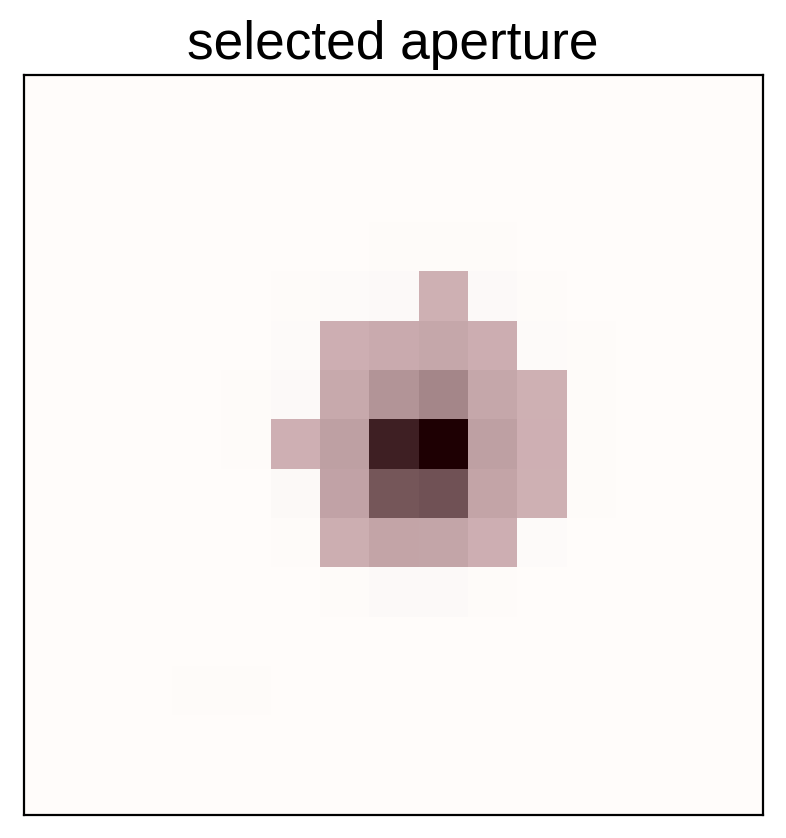

In [5]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1)**2))

# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(1, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

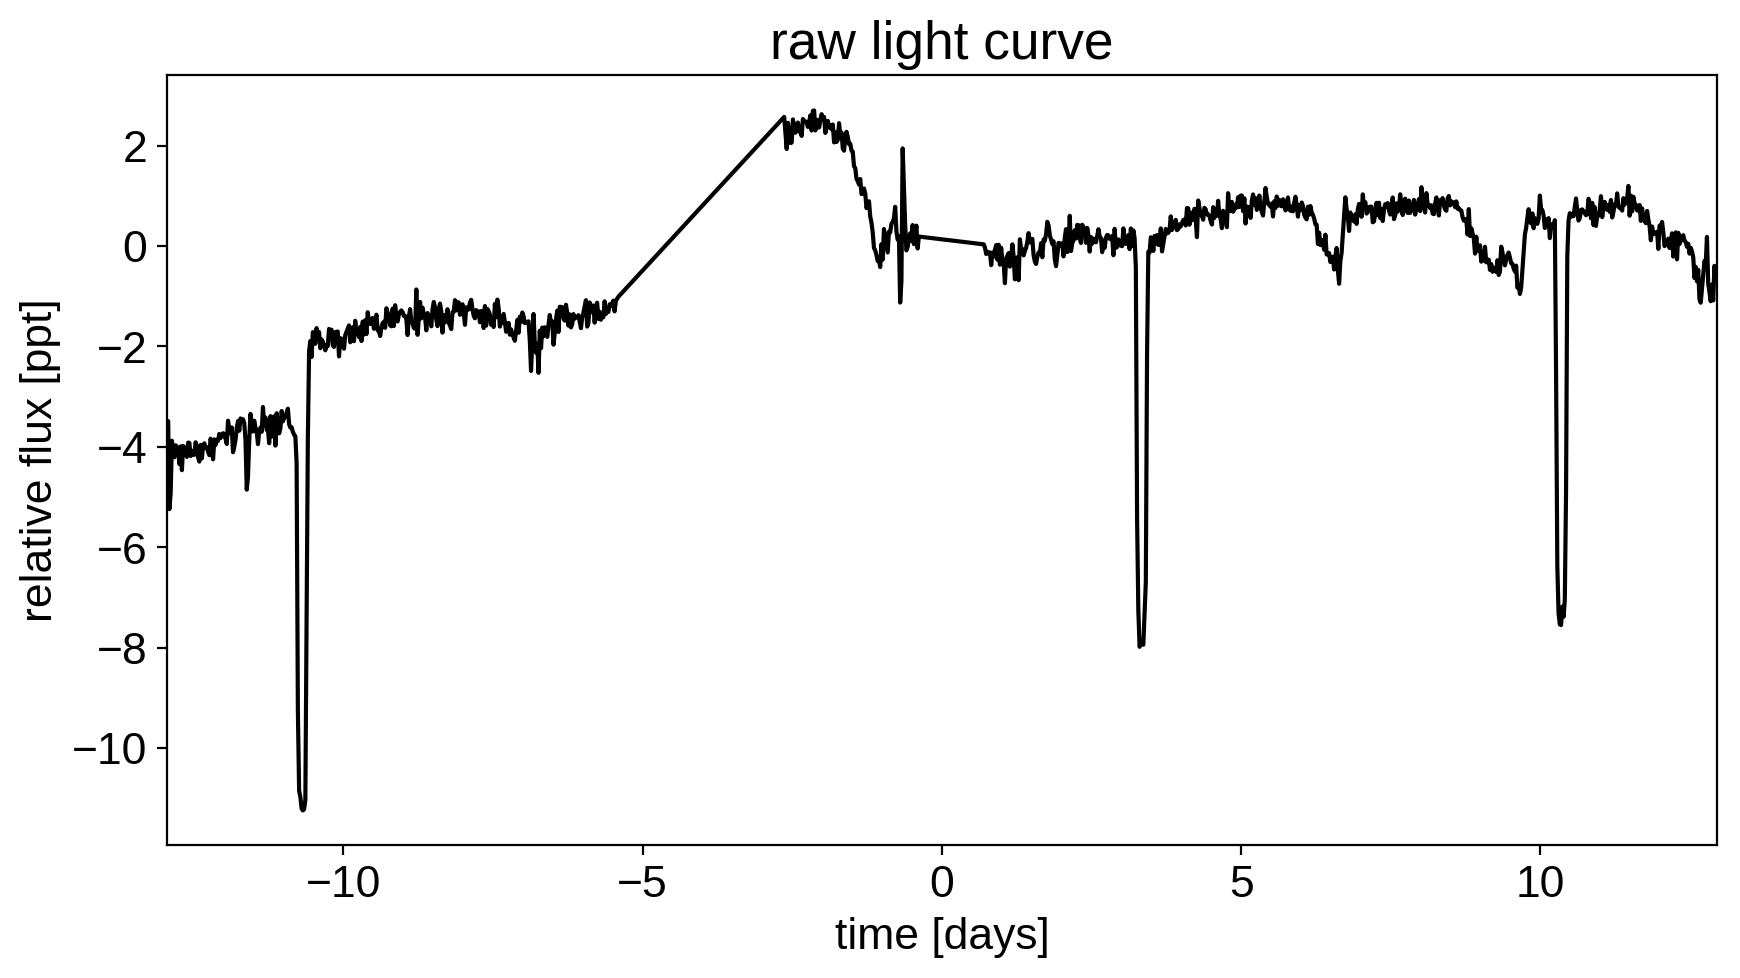

In [6]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

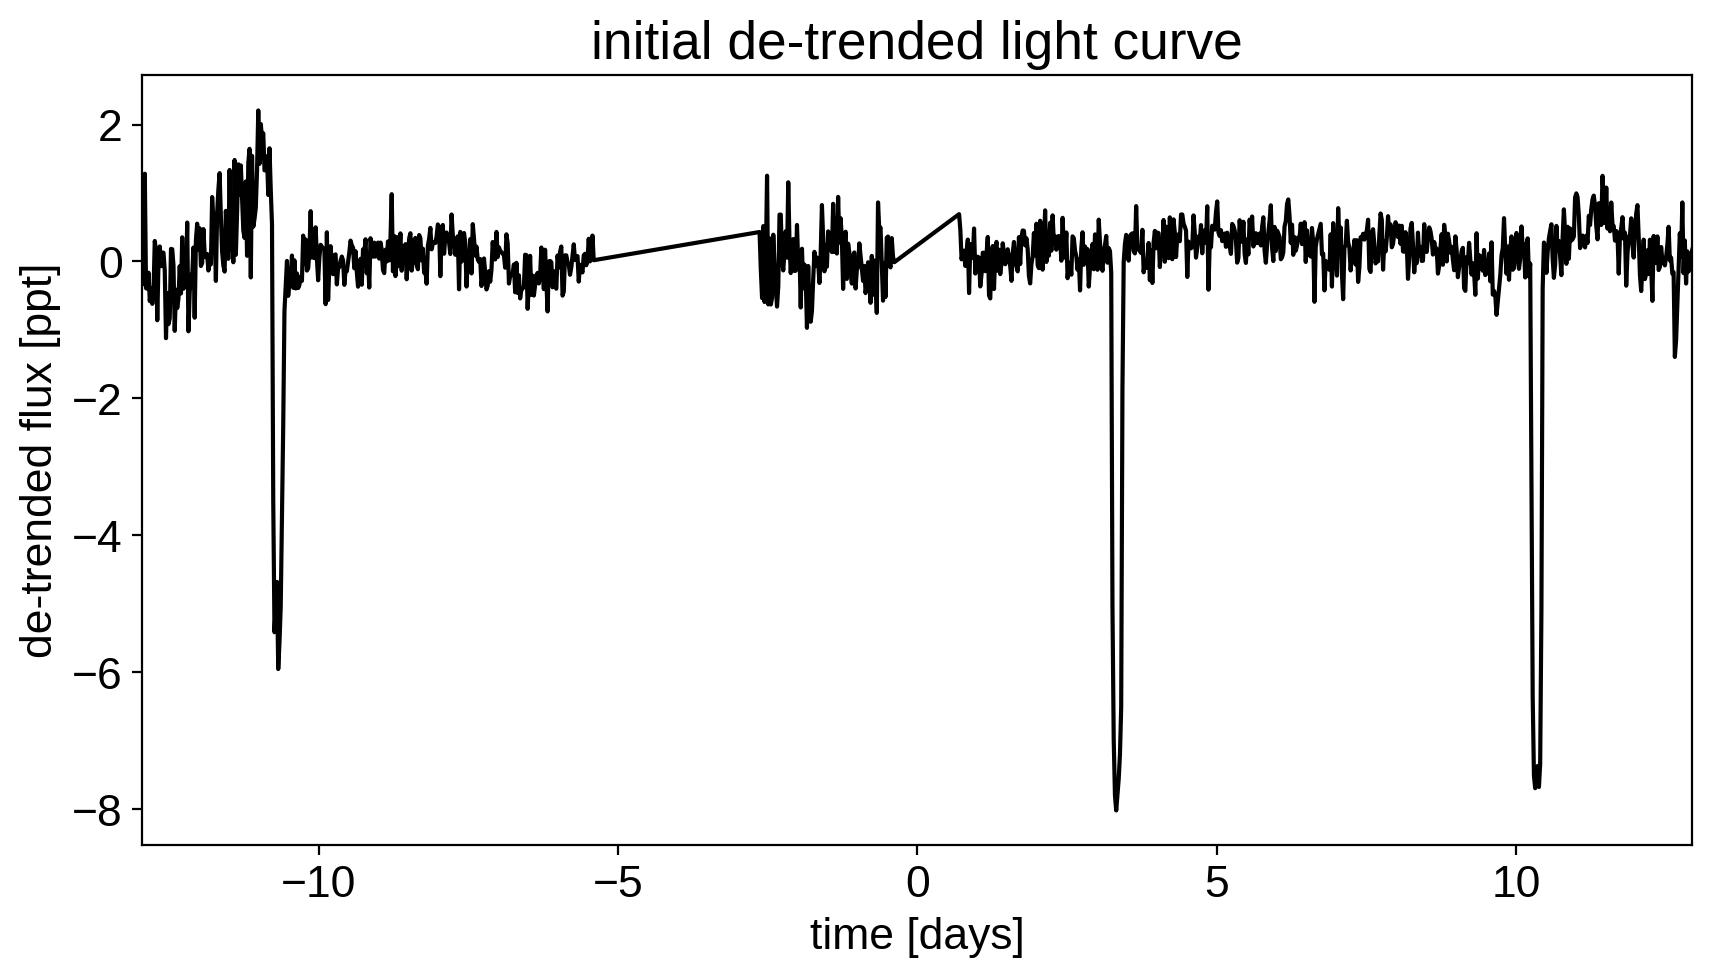

In [7]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

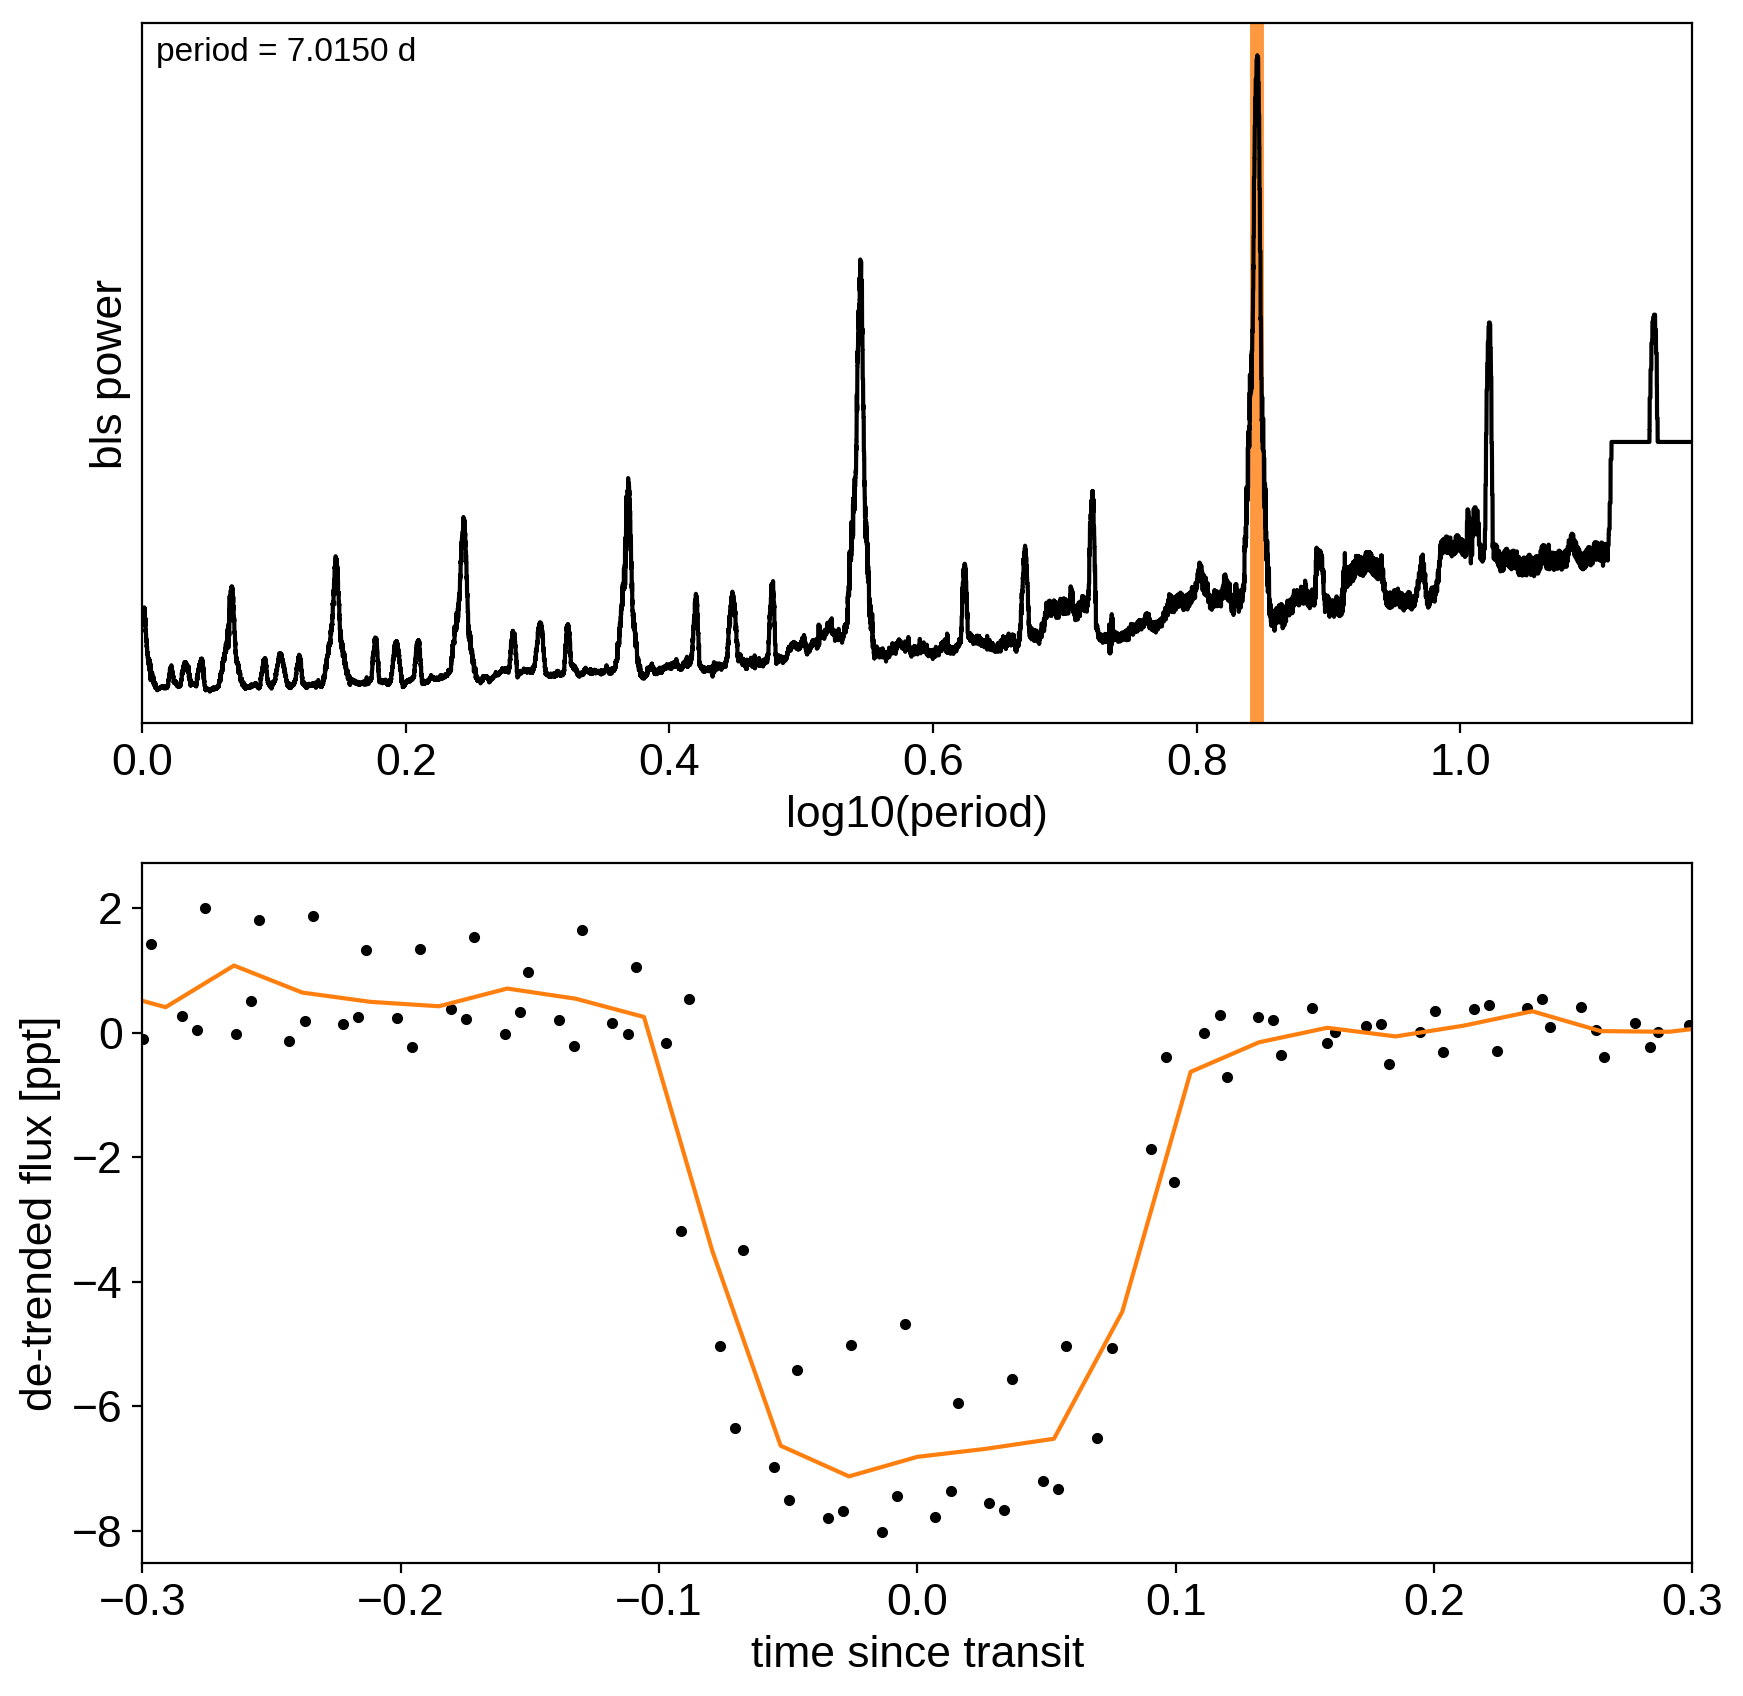

In [8]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

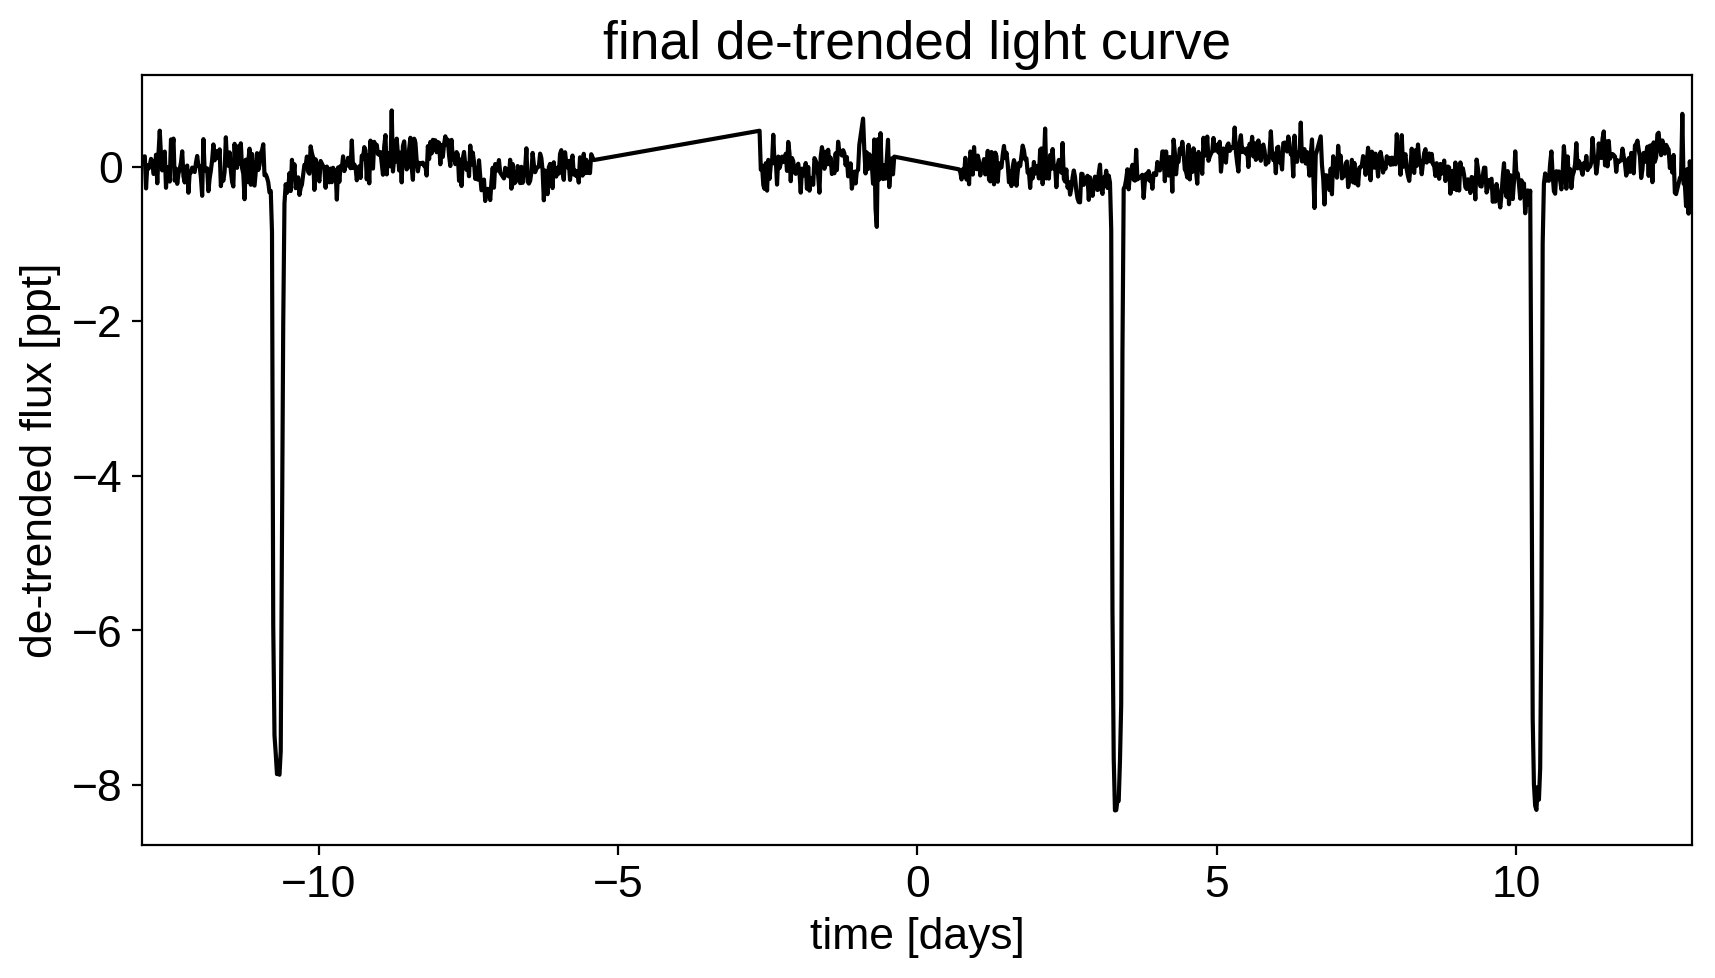

In [9]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

In [10]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        
        # Stellar parameters from TIC
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        m_star = pm.Normal("m_star", mu=tic_mass[0], sd=tic_mass[1])
        r_star = pm.Normal("r_star", mu=tic_radius[0], sd=tic_radius[1])

        # Prior to require physical parameters
        pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        b = pm.Uniform("b", lower=0, upper=1, testval=0.5)
        logr = pm.Normal("logr", sd=1.0,
                         mu=0.5*np.log(1e-3*np.array(bls_depth))+np.log(tic_radius[0]))
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, testval=0.1)
        omega = xo.distributions.Angle("omega")

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega)
        pm.Deterministic("a", orbit.a_planet)
        pm.Deterministic("incl", orbit.incl)

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: -1181.8355629633472 -> -1165.2287368771365


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: -1165.2287368771365 -> 83.7577748952358


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 83.7577748952358 -> 118.9245857261479


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_interval__', 't0', 'logP', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 118.92458572614562 -> 344.3805435085537


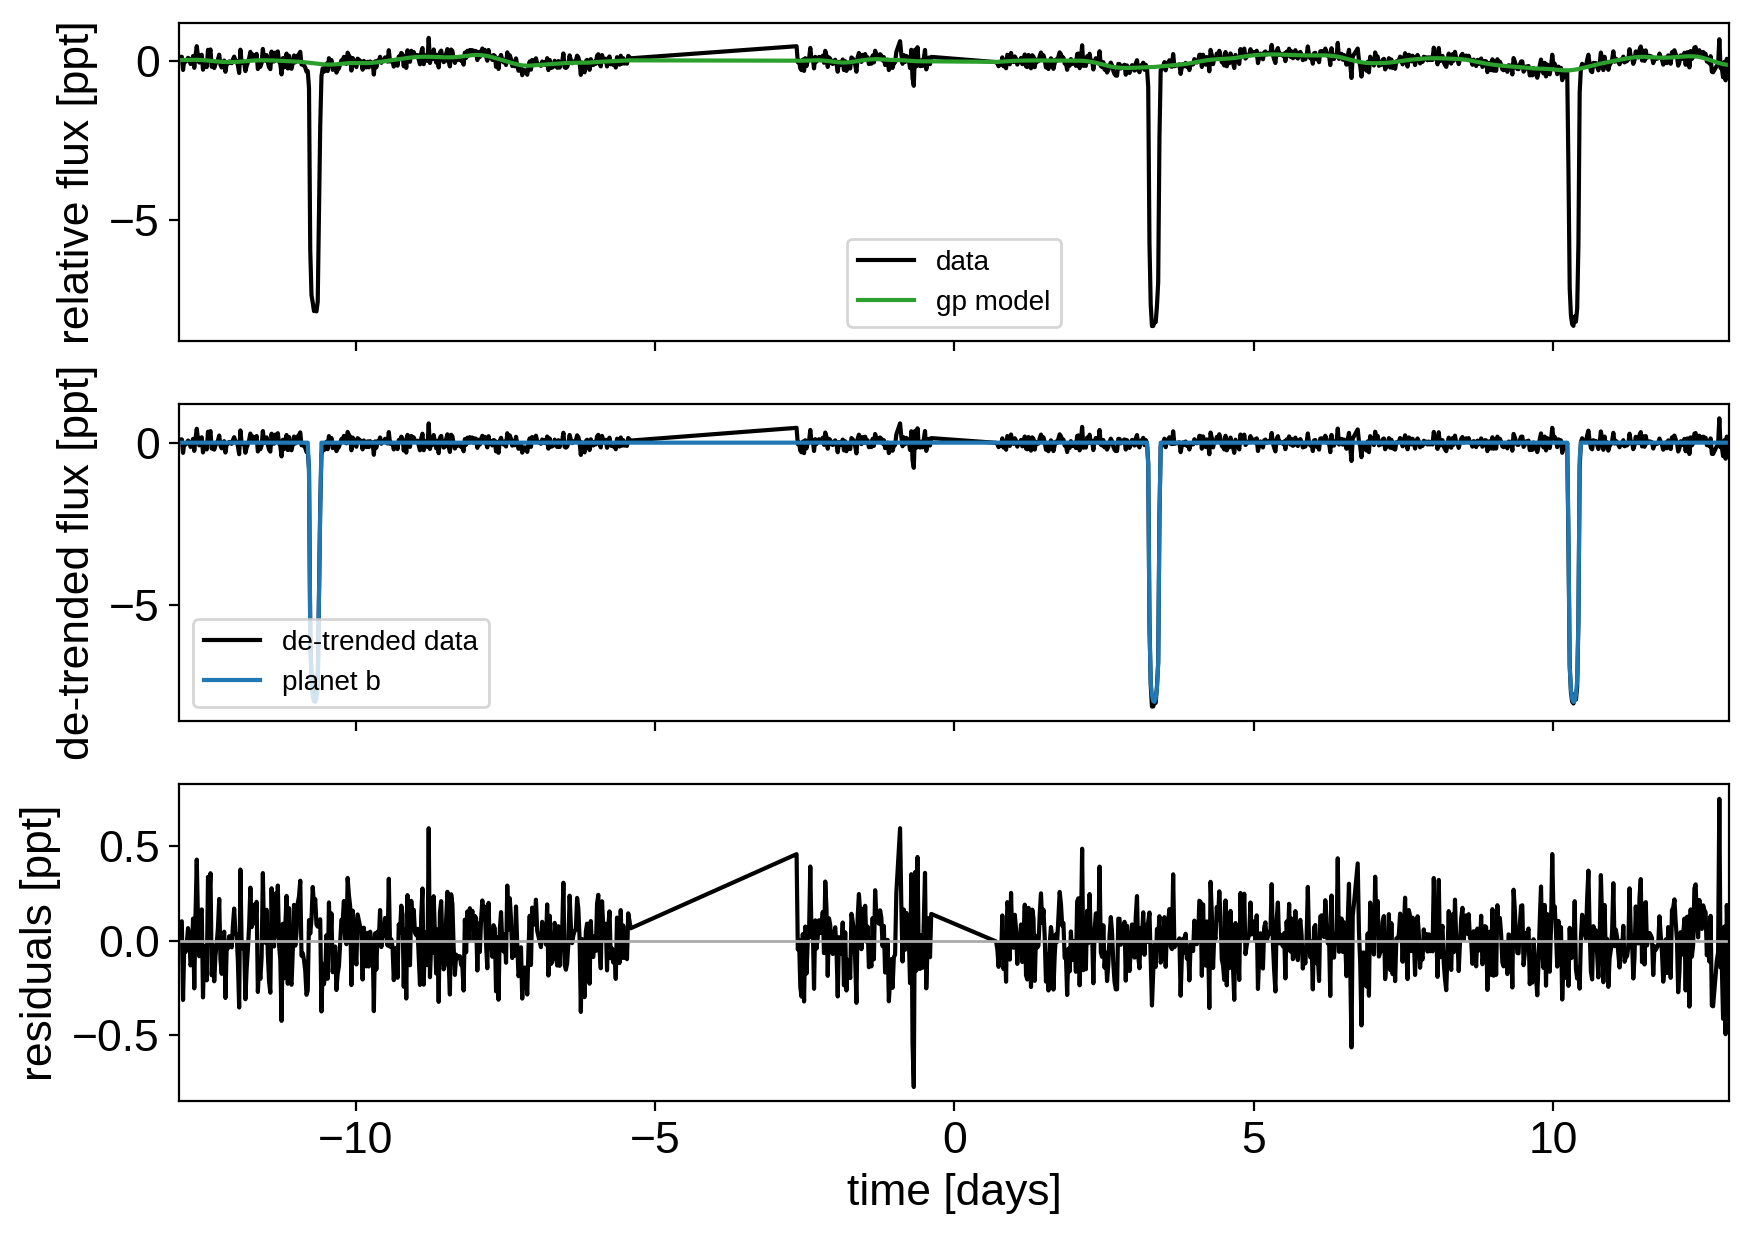

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

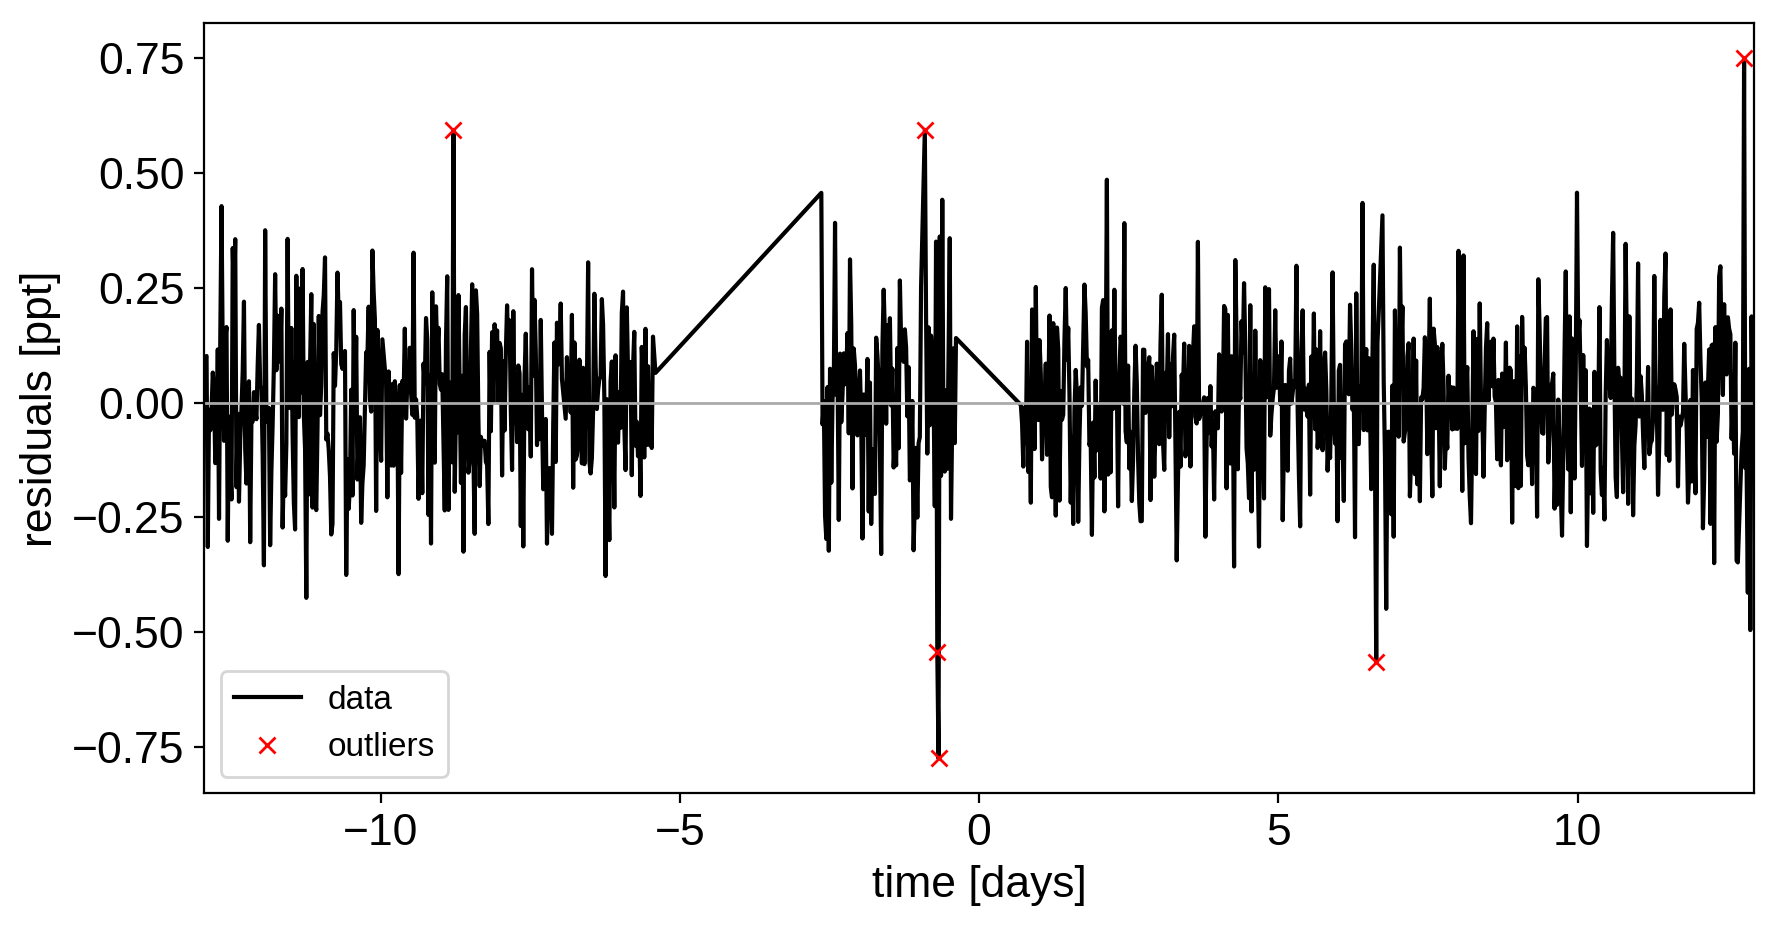

In [12]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: 386.782601898381 -> 386.7826018996256


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 386.78260189962333 -> 389.66380280235063


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 389.66380280235063 -> 389.68441488546455


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_interval__', 't0', 'logP', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 389.6844148854648 -> 389.6948927324996


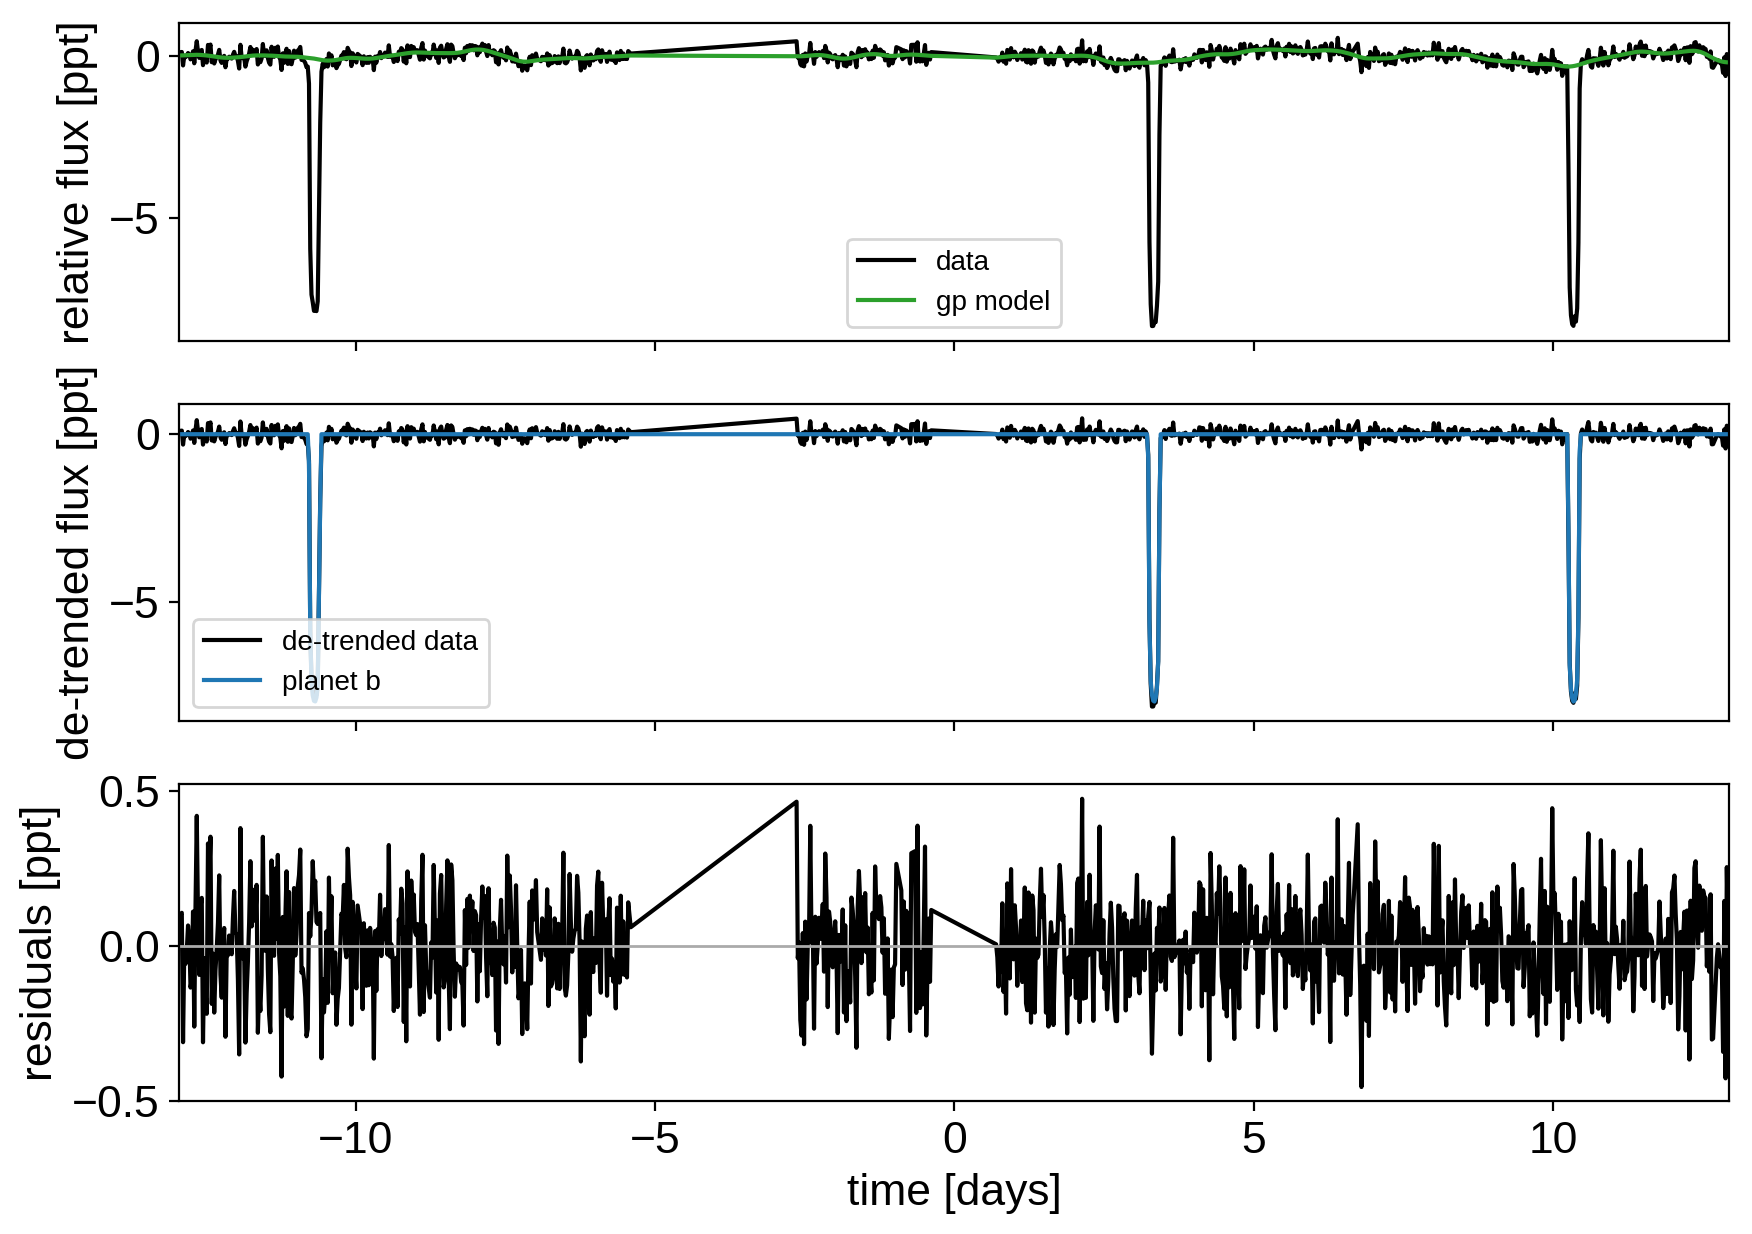

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

In [14]:
np.random.seed(12345)
sampler = xo.PyMC3Sampler(window=100, start=300, finish=500)
with model:
    burnin = sampler.tune(tune=3500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=4)

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 18/1208 [00:00<00:20, 57.07draws/s]

Sampling 4 chains:   2%|▏         | 22/1208 [00:00<00:38, 31.18draws/s]

Sampling 4 chains:   2%|▏         | 26/1208 [00:00<00:49, 23.67draws/s]

Sampling 4 chains:   2%|▏         | 30/1208 [00:01<00:58, 20.25draws/s]

Sampling 4 chains:   3%|▎         | 34/1208 [00:01<01:03, 18.41draws/s]

Sampling 4 chains:   3%|▎         | 37/1208 [00:01<00:56, 20.63draws/s]

Sampling 4 chains:   3%|▎         | 39/1208 [00:01<01:14, 15.79draws/s]

Sampling 4 chains:   3%|▎         | 42/1208 [00:01<01:18, 14.83draws/s]

Sampling 4 chains:   4%|▎         | 45/1208 [00:02<01:13, 15.81draws/s]

Sampling 4 chains:   4%|▍         | 47/1208 [00:02<01:20, 14.34draws/s]

Sampling 4 chains:   4%|▍         | 49/1208 [00:02<01:15, 15.27draws/s]

Sampling 4 chains:   4%|▍         | 51/1208 [00:02<01:20, 14.35draws/s]

Sampling 4 chains:   4%|▍         | 53/1208 [00:02<01:14, 15.44draws/s]

Sampling 4 chains:   5%|▍         | 55/1208 [00:02<01:19, 14.57draws/s]

Sampling 4 chains:   5%|▍         | 57/1208 [00:02<01:13, 15.60draws/s]

Sampling 4 chains:   5%|▍         | 59/1208 [00:03<01:17, 14.76draws/s]

Sampling 4 chains:   5%|▌         | 61/1208 [00:03<01:13, 15.65draws/s]

Sampling 4 chains:   5%|▌         | 63/1208 [00:03<01:08, 16.70draws/s]

Sampling 4 chains:   5%|▌         | 65/1208 [00:03<01:06, 17.23draws/s]

Sampling 4 chains:   6%|▌         | 68/1208 [00:03<01:04, 17.62draws/s]

Sampling 4 chains:   6%|▌         | 70/1208 [00:03<01:05, 17.33draws/s]

Sampling 4 chains:   6%|▌         | 72/1208 [00:03<01:10, 16.13draws/s]

Sampling 4 chains:   6%|▌         | 74/1208 [00:03<01:11, 15.76draws/s]

Sampling 4 chains:   6%|▋         | 77/1208 [00:04<01:04, 17.42draws/s]

Sampling 4 chains:   7%|▋         | 79/1208 [00:04<01:14, 15.20draws/s]

Sampling 4 chains:   7%|▋         | 82/1208 [00:04<01:06, 17.06draws/s]

Sampling 4 chains:   7%|▋         | 84/1208 [00:04<01:15, 14.83draws/s]

Sampling 4 chains:   7%|▋         | 87/1208 [00:04<01:22, 13.67draws/s]

Sampling 4 chains:   8%|▊         | 91/1208 [00:05<01:20, 13.88draws/s]

Sampling 4 chains:   8%|▊         | 95/1208 [00:05<01:20, 13.89draws/s]

Sampling 4 chains:   8%|▊         | 99/1208 [00:05<01:18, 14.19draws/s]

Sampling 4 chains:   9%|▊         | 104/1208 [00:05<01:13, 14.96draws/s]

Sampling 4 chains:   9%|▉         | 108/1208 [00:06<01:12, 15.09draws/s]

Sampling 4 chains:   9%|▉         | 112/1208 [00:06<01:12, 15.14draws/s]

Sampling 4 chains:  10%|▉         | 117/1208 [00:06<01:07, 16.17draws/s]

Sampling 4 chains:  10%|▉         | 120/1208 [00:06<00:58, 18.48draws/s]

Sampling 4 chains:  10%|█         | 122/1208 [00:06<01:10, 15.41draws/s]

Sampling 4 chains:  10%|█         | 124/1208 [00:07<01:07, 16.08draws/s]

Sampling 4 chains:  10%|█         | 126/1208 [00:07<01:11, 15.07draws/s]

Sampling 4 chains:  11%|█         | 128/1208 [00:07<01:12, 14.99draws/s]

Sampling 4 chains:  11%|█         | 130/1208 [00:07<01:07, 15.95draws/s]

Sampling 4 chains:  11%|█         | 133/1208 [00:07<01:06, 16.07draws/s]

Sampling 4 chains:  11%|█         | 135/1208 [00:07<01:02, 17.06draws/s]

Sampling 4 chains:  11%|█▏        | 137/1208 [00:07<01:15, 14.19draws/s]

Sampling 4 chains:  12%|█▏        | 140/1208 [00:08<01:07, 15.91draws/s]

Sampling 4 chains:  12%|█▏        | 142/1208 [00:08<01:13, 14.58draws/s]

Sampling 4 chains:  12%|█▏        | 145/1208 [00:08<01:18, 13.47draws/s]

Sampling 4 chains:  12%|█▏        | 148/1208 [00:08<01:05, 16.09draws/s]

Sampling 4 chains:  12%|█▏        | 150/1208 [00:08<01:15, 14.04draws/s]

Sampling 4 chains:  13%|█▎        | 153/1208 [00:09<01:17, 13.67draws/s]

Sampling 4 chains:  13%|█▎        | 157/1208 [00:09<01:04, 16.29draws/s]

Sampling 4 chains:  13%|█▎        | 159/1208 [00:09<01:06, 15.74draws/s]

Sampling 4 chains:  13%|█▎        | 162/1208 [00:09<01:01, 17.06draws/s]

Sampling 4 chains:  14%|█▎        | 164/1208 [00:09<01:06, 15.71draws/s]

Sampling 4 chains:  14%|█▎        | 166/1208 [00:09<01:03, 16.33draws/s]

Sampling 4 chains:  14%|█▍        | 168/1208 [00:09<01:08, 15.25draws/s]

Sampling 4 chains:  14%|█▍        | 170/1208 [00:09<01:04, 15.98draws/s]

Sampling 4 chains:  14%|█▍        | 172/1208 [00:10<01:08, 15.06draws/s]

Sampling 4 chains:  14%|█▍        | 174/1208 [00:10<01:05, 15.78draws/s]

Sampling 4 chains:  15%|█▍        | 176/1208 [00:10<01:08, 14.98draws/s]

Sampling 4 chains:  15%|█▍        | 178/1208 [00:10<01:14, 13.92draws/s]

Sampling 4 chains:  15%|█▍        | 181/1208 [00:10<01:12, 14.15draws/s]

Sampling 4 chains:  15%|█▌        | 183/1208 [00:10<01:08, 14.86draws/s]

Sampling 4 chains:  15%|█▌        | 185/1208 [00:11<01:10, 14.56draws/s]

Sampling 4 chains:  15%|█▌        | 187/1208 [00:11<01:06, 15.32draws/s]

Sampling 4 chains:  16%|█▌        | 189/1208 [00:11<01:08, 14.78draws/s]

Sampling 4 chains:  16%|█▌        | 191/1208 [00:11<01:08, 14.88draws/s]

Sampling 4 chains:  16%|█▌        | 194/1208 [00:11<01:00, 16.70draws/s]

Sampling 4 chains:  16%|█▌        | 196/1208 [00:11<01:06, 15.20draws/s]

Sampling 4 chains:  16%|█▋        | 198/1208 [00:11<01:03, 15.95draws/s]

Sampling 4 chains:  17%|█▋        | 200/1208 [00:11<01:00, 16.56draws/s]

Sampling 4 chains:  17%|█▋        | 203/1208 [00:12<00:59, 16.93draws/s]

Sampling 4 chains:  17%|█▋        | 205/1208 [00:12<01:01, 16.18draws/s]

Sampling 4 chains:  17%|█▋        | 207/1208 [00:12<01:05, 15.17draws/s]

Sampling 4 chains:  17%|█▋        | 209/1208 [00:12<01:02, 15.92draws/s]

Sampling 4 chains:  17%|█▋        | 211/1208 [00:12<01:06, 14.99draws/s]

Sampling 4 chains:  18%|█▊        | 213/1208 [00:12<01:02, 15.82draws/s]

Sampling 4 chains:  18%|█▊        | 215/1208 [00:12<01:06, 14.90draws/s]

Sampling 4 chains:  18%|█▊        | 217/1208 [00:13<01:02, 15.77draws/s]

Sampling 4 chains:  18%|█▊        | 219/1208 [00:13<01:06, 14.85draws/s]

Sampling 4 chains:  18%|█▊        | 221/1208 [00:13<01:02, 15.76draws/s]

Sampling 4 chains:  18%|█▊        | 223/1208 [00:13<01:06, 14.82draws/s]

Sampling 4 chains:  19%|█▊        | 225/1208 [00:13<01:02, 15.75draws/s]

Sampling 4 chains:  19%|█▉        | 227/1208 [00:13<01:09, 14.22draws/s]

Sampling 4 chains:  19%|█▉        | 230/1208 [00:13<01:12, 13.57draws/s]

Sampling 4 chains:  19%|█▉        | 233/1208 [00:14<01:01, 15.81draws/s]

Sampling 4 chains:  19%|█▉        | 235/1208 [00:14<01:11, 13.66draws/s]

Sampling 4 chains:  20%|█▉        | 238/1208 [00:14<01:13, 13.25draws/s]

Sampling 4 chains:  20%|██        | 242/1208 [00:14<01:10, 13.62draws/s]

Sampling 4 chains:  20%|██        | 246/1208 [00:15<01:09, 13.89draws/s]

Sampling 4 chains:  21%|██        | 251/1208 [00:15<01:04, 14.82draws/s]

Sampling 4 chains:  21%|██        | 255/1208 [00:15<01:04, 14.74draws/s]

Sampling 4 chains:  21%|██▏       | 259/1208 [00:15<01:05, 14.44draws/s]

Sampling 4 chains:  22%|██▏       | 263/1208 [00:16<01:04, 14.68draws/s]

Sampling 4 chains:  22%|██▏       | 267/1208 [00:16<01:03, 14.79draws/s]

Sampling 4 chains:  22%|██▏       | 271/1208 [00:16<01:02, 14.92draws/s]

Sampling 4 chains:  23%|██▎       | 275/1208 [00:16<01:02, 15.00draws/s]

Sampling 4 chains:  23%|██▎       | 279/1208 [00:17<01:01, 15.03draws/s]

Sampling 4 chains:  23%|██▎       | 282/1208 [00:17<00:53, 17.32draws/s]

Sampling 4 chains:  24%|██▎       | 284/1208 [00:17<01:02, 14.83draws/s]

Sampling 4 chains:  24%|██▍       | 287/1208 [00:17<01:05, 14.17draws/s]

Sampling 4 chains:  24%|██▍       | 290/1208 [00:17<00:57, 15.89draws/s]

Sampling 4 chains:  24%|██▍       | 292/1208 [00:18<01:02, 14.77draws/s]

Sampling 4 chains:  24%|██▍       | 294/1208 [00:18<01:05, 13.87draws/s]

Sampling 4 chains:  25%|██▍       | 297/1208 [00:18<01:00, 14.97draws/s]

Sampling 4 chains:  25%|██▍       | 299/1208 [00:18<01:05, 13.97draws/s]

Sampling 4 chains:  25%|██▍       | 301/1208 [00:18<00:59, 15.33draws/s]

Sampling 4 chains:  25%|██▌       | 303/1208 [00:18<01:03, 14.31draws/s]

Sampling 4 chains:  25%|██▌       | 305/1208 [00:18<00:58, 15.43draws/s]

Sampling 4 chains:  25%|██▌       | 307/1208 [00:19<01:01, 14.54draws/s]

Sampling 4 chains:  26%|██▌       | 309/1208 [00:19<00:58, 15.43draws/s]

Sampling 4 chains:  26%|██▌       | 311/1208 [00:19<01:05, 13.75draws/s]

Sampling 4 chains:  26%|██▌       | 314/1208 [00:19<01:06, 13.52draws/s]

Sampling 4 chains:  26%|██▌       | 317/1208 [00:19<00:56, 15.73draws/s]

Sampling 4 chains:  26%|██▋       | 319/1208 [00:19<01:10, 12.61draws/s]

Sampling 4 chains:  27%|██▋       | 322/1208 [00:20<01:04, 13.68draws/s]

Sampling 4 chains:  27%|██▋       | 324/1208 [00:20<01:00, 14.59draws/s]

Sampling 4 chains:  27%|██▋       | 326/1208 [00:20<01:02, 14.10draws/s]

Sampling 4 chains:  27%|██▋       | 328/1208 [00:20<01:00, 14.55draws/s]

Sampling 4 chains:  27%|██▋       | 330/1208 [00:20<01:00, 14.55draws/s]

Sampling 4 chains:  27%|██▋       | 332/1208 [00:20<00:59, 14.74draws/s]

Sampling 4 chains:  28%|██▊       | 334/1208 [00:20<00:58, 14.89draws/s]

Sampling 4 chains:  28%|██▊       | 336/1208 [00:21<00:59, 14.71draws/s]

Sampling 4 chains:  28%|██▊       | 338/1208 [00:21<00:57, 15.15draws/s]

Sampling 4 chains:  28%|██▊       | 340/1208 [00:21<00:58, 14.80draws/s]

Sampling 4 chains:  28%|██▊       | 342/1208 [00:21<00:58, 14.90draws/s]

Sampling 4 chains:  28%|██▊       | 344/1208 [00:21<00:59, 14.57draws/s]

Sampling 4 chains:  29%|██▊       | 346/1208 [00:21<00:56, 15.31draws/s]

Sampling 4 chains:  29%|██▉       | 348/1208 [00:21<00:58, 14.68draws/s]

Sampling 4 chains:  29%|██▉       | 350/1208 [00:21<00:55, 15.38draws/s]

Sampling 4 chains:  29%|██▉       | 352/1208 [00:22<00:58, 14.74draws/s]

Sampling 4 chains:  29%|██▉       | 354/1208 [00:22<00:54, 15.61draws/s]

Sampling 4 chains:  29%|██▉       | 356/1208 [00:22<00:57, 14.72draws/s]

Sampling 4 chains:  30%|██▉       | 358/1208 [00:22<00:53, 15.79draws/s]

Sampling 4 chains:  30%|██▉       | 360/1208 [00:22<00:58, 14.60draws/s]

Sampling 4 chains:  30%|██▉       | 362/1208 [00:22<00:56, 14.85draws/s]

Sampling 4 chains:  30%|███       | 364/1208 [00:22<00:58, 14.48draws/s]

Sampling 4 chains:  30%|███       | 366/1208 [00:23<01:01, 13.70draws/s]

Sampling 4 chains:  31%|███       | 369/1208 [00:23<01:01, 13.54draws/s]

Sampling 4 chains:  31%|███       | 372/1208 [00:23<00:55, 15.00draws/s]

Sampling 4 chains:  31%|███       | 374/1208 [00:23<00:58, 14.28draws/s]

Sampling 4 chains:  31%|███▏      | 378/1208 [00:23<00:47, 17.40draws/s]

Sampling 4 chains:  32%|███▏      | 381/1208 [00:23<00:48, 17.17draws/s]

Sampling 4 chains:  32%|███▏      | 383/1208 [00:24<01:04, 12.84draws/s]

Sampling 4 chains:  32%|███▏      | 386/1208 [00:24<00:53, 15.48draws/s]

Sampling 4 chains:  32%|███▏      | 389/1208 [00:24<00:53, 15.29draws/s]

Sampling 4 chains:  32%|███▏      | 391/1208 [00:24<01:05, 12.53draws/s]

Sampling 4 chains:  33%|███▎      | 394/1208 [00:24<00:54, 14.94draws/s]

Sampling 4 chains:  33%|███▎      | 396/1208 [00:24<01:01, 13.27draws/s]

Sampling 4 chains:  33%|███▎      | 399/1208 [00:25<01:03, 12.65draws/s]

Sampling 4 chains:  33%|███▎      | 403/1208 [00:25<01:01, 13.10draws/s]

Sampling 4 chains:  34%|███▎      | 407/1208 [00:25<00:59, 13.52draws/s]

Sampling 4 chains:  34%|███▍      | 412/1208 [00:26<00:54, 14.74draws/s]

Sampling 4 chains:  35%|███▍      | 417/1208 [00:26<00:49, 15.85draws/s]

Sampling 4 chains:  35%|███▍      | 419/1208 [00:26<00:47, 16.78draws/s]

Sampling 4 chains:  35%|███▍      | 421/1208 [00:26<00:51, 15.20draws/s]

Sampling 4 chains:  35%|███▌      | 423/1208 [00:26<00:48, 16.15draws/s]

Sampling 4 chains:  35%|███▌      | 425/1208 [00:26<00:51, 15.06draws/s]

Sampling 4 chains:  35%|███▌      | 427/1208 [00:26<00:49, 15.83draws/s]

Sampling 4 chains:  36%|███▌      | 429/1208 [00:27<00:51, 15.03draws/s]

Sampling 4 chains:  36%|███▌      | 431/1208 [00:27<00:51, 15.09draws/s]

Sampling 4 chains:  36%|███▌      | 433/1208 [00:27<00:50, 15.24draws/s]

Sampling 4 chains:  36%|███▌      | 435/1208 [00:27<00:51, 15.08draws/s]

Sampling 4 chains:  36%|███▌      | 437/1208 [00:27<00:50, 15.37draws/s]

Sampling 4 chains:  36%|███▋      | 439/1208 [00:27<00:50, 15.08draws/s]

Sampling 4 chains:  37%|███▋      | 441/1208 [00:27<00:49, 15.47draws/s]

Sampling 4 chains:  37%|███▋      | 443/1208 [00:28<00:52, 14.60draws/s]

Sampling 4 chains:  37%|███▋      | 445/1208 [00:28<00:48, 15.70draws/s]

Sampling 4 chains:  37%|███▋      | 447/1208 [00:28<00:52, 14.62draws/s]

Sampling 4 chains:  37%|███▋      | 449/1208 [00:28<00:49, 15.20draws/s]

Sampling 4 chains:  37%|███▋      | 451/1208 [00:28<00:51, 14.81draws/s]

Sampling 4 chains:  38%|███▊      | 453/1208 [00:28<00:52, 14.40draws/s]

Sampling 4 chains:  38%|███▊      | 455/1208 [00:28<00:49, 15.21draws/s]

Sampling 4 chains:  38%|███▊      | 457/1208 [00:28<00:53, 14.09draws/s]

Sampling 4 chains:  38%|███▊      | 460/1208 [00:29<00:47, 15.77draws/s]

Sampling 4 chains:  38%|███▊      | 462/1208 [00:29<00:51, 14.36draws/s]

Sampling 4 chains:  38%|███▊      | 465/1208 [00:29<00:54, 13.66draws/s]

Sampling 4 chains:  39%|███▊      | 468/1208 [00:29<00:45, 16.20draws/s]

Sampling 4 chains:  39%|███▉      | 470/1208 [00:29<00:57, 12.83draws/s]

Sampling 4 chains:  39%|███▉      | 473/1208 [00:30<00:56, 13.00draws/s]

Sampling 4 chains:  39%|███▉      | 477/1208 [00:30<00:54, 13.44draws/s]

Sampling 4 chains:  40%|███▉      | 481/1208 [00:30<00:52, 13.76draws/s]

Sampling 4 chains:  40%|████      | 485/1208 [00:30<00:51, 14.00draws/s]

Sampling 4 chains:  40%|████      | 489/1208 [00:31<00:50, 14.16draws/s]

Sampling 4 chains:  41%|████      | 493/1208 [00:31<00:49, 14.53draws/s]

Sampling 4 chains:  41%|████      | 497/1208 [00:31<00:48, 14.79draws/s]

Sampling 4 chains:  41%|████▏     | 501/1208 [00:31<00:47, 14.98draws/s]

Sampling 4 chains:  42%|████▏     | 505/1208 [00:32<00:46, 15.12draws/s]

Sampling 4 chains:  42%|████▏     | 509/1208 [00:32<00:45, 15.22draws/s]

Sampling 4 chains:  42%|████▏     | 511/1208 [00:32<00:43, 16.01draws/s]

Sampling 4 chains:  42%|████▏     | 513/1208 [00:32<00:45, 15.14draws/s]

Sampling 4 chains:  43%|████▎     | 515/1208 [00:32<00:44, 15.42draws/s]

Sampling 4 chains:  43%|████▎     | 517/1208 [00:33<00:45, 15.25draws/s]

Sampling 4 chains:  43%|████▎     | 519/1208 [00:33<00:46, 14.88draws/s]

Sampling 4 chains:  43%|████▎     | 521/1208 [00:33<00:44, 15.51draws/s]

Sampling 4 chains:  43%|████▎     | 523/1208 [00:33<00:46, 14.77draws/s]

Sampling 4 chains:  43%|████▎     | 525/1208 [00:33<00:45, 15.08draws/s]

Sampling 4 chains:  44%|████▎     | 527/1208 [00:33<00:44, 15.31draws/s]

Sampling 4 chains:  44%|████▍     | 529/1208 [00:33<00:44, 15.22draws/s]

Sampling 4 chains:  44%|████▍     | 531/1208 [00:33<00:44, 15.27draws/s]

Sampling 4 chains:  44%|████▍     | 533/1208 [00:34<00:44, 15.34draws/s]

Sampling 4 chains:  44%|████▍     | 535/1208 [00:34<00:44, 15.20draws/s]

Sampling 4 chains:  44%|████▍     | 537/1208 [00:34<00:43, 15.43draws/s]

Sampling 4 chains:  45%|████▍     | 539/1208 [00:34<00:44, 15.10draws/s]

Sampling 4 chains:  45%|████▍     | 541/1208 [00:34<00:43, 15.23draws/s]

Sampling 4 chains:  45%|████▍     | 543/1208 [00:34<00:44, 15.11draws/s]

Sampling 4 chains:  45%|████▌     | 545/1208 [00:34<00:43, 15.41draws/s]

Sampling 4 chains:  45%|████▌     | 547/1208 [00:34<00:43, 15.07draws/s]

Sampling 4 chains:  45%|████▌     | 549/1208 [00:35<00:42, 15.53draws/s]

Sampling 4 chains:  46%|████▌     | 551/1208 [00:35<00:45, 14.37draws/s]

Sampling 4 chains:  46%|████▌     | 554/1208 [00:35<00:48, 13.36draws/s]

Sampling 4 chains:  46%|████▌     | 558/1208 [00:35<00:47, 13.69draws/s]

Sampling 4 chains:  47%|████▋     | 562/1208 [00:36<00:46, 14.00draws/s]

Sampling 4 chains:  47%|████▋     | 566/1208 [00:36<00:44, 14.32draws/s]

Sampling 4 chains:  47%|████▋     | 570/1208 [00:36<00:43, 14.50draws/s]

Sampling 4 chains:  48%|████▊     | 574/1208 [00:36<00:43, 14.70draws/s]

Sampling 4 chains:  48%|████▊     | 578/1208 [00:37<00:42, 14.83draws/s]

Sampling 4 chains:  48%|████▊     | 582/1208 [00:37<00:41, 14.93draws/s]

Sampling 4 chains:  48%|████▊     | 585/1208 [00:37<00:35, 17.37draws/s]

Sampling 4 chains:  49%|████▊     | 587/1208 [00:37<00:41, 15.14draws/s]

Sampling 4 chains:  49%|████▉     | 589/1208 [00:37<00:38, 16.20draws/s]

Sampling 4 chains:  49%|████▉     | 591/1208 [00:37<00:41, 14.73draws/s]

Sampling 4 chains:  49%|████▉     | 593/1208 [00:38<00:41, 14.93draws/s]

Sampling 4 chains:  49%|████▉     | 595/1208 [00:38<00:40, 15.08draws/s]

Sampling 4 chains:  49%|████▉     | 597/1208 [00:38<00:45, 13.42draws/s]

Sampling 4 chains:  50%|████▉     | 601/1208 [00:38<00:44, 13.58draws/s]

Sampling 4 chains:  50%|█████     | 605/1208 [00:38<00:44, 13.47draws/s]

Sampling 4 chains:  50%|█████     | 609/1208 [00:39<00:42, 14.00draws/s]

Sampling 4 chains:  51%|█████     | 613/1208 [00:39<00:41, 14.40draws/s]

Sampling 4 chains:  51%|█████     | 617/1208 [00:39<00:40, 14.71draws/s]

Sampling 4 chains:  51%|█████▏    | 621/1208 [00:40<00:39, 14.94draws/s]

Sampling 4 chains:  52%|█████▏    | 625/1208 [00:40<00:38, 14.99draws/s]

Sampling 4 chains:  52%|█████▏    | 628/1208 [00:40<00:33, 17.52draws/s]

Sampling 4 chains:  52%|█████▏    | 630/1208 [00:40<00:37, 15.31draws/s]

Sampling 4 chains:  52%|█████▏    | 632/1208 [00:40<00:35, 16.25draws/s]

Sampling 4 chains:  52%|█████▏    | 634/1208 [00:40<00:37, 15.17draws/s]

Sampling 4 chains:  53%|█████▎    | 636/1208 [00:40<00:36, 15.52draws/s]

Sampling 4 chains:  53%|█████▎    | 638/1208 [00:41<00:37, 15.22draws/s]

Sampling 4 chains:  53%|█████▎    | 640/1208 [00:41<00:38, 14.86draws/s]

Sampling 4 chains:  53%|█████▎    | 642/1208 [00:41<00:36, 15.42draws/s]

Sampling 4 chains:  53%|█████▎    | 644/1208 [00:41<00:38, 14.54draws/s]

Sampling 4 chains:  53%|█████▎    | 646/1208 [00:41<00:37, 15.06draws/s]

Sampling 4 chains:  54%|█████▎    | 648/1208 [00:41<00:38, 14.41draws/s]

Sampling 4 chains:  54%|█████▍    | 650/1208 [00:41<00:36, 15.12draws/s]

Sampling 4 chains:  54%|█████▍    | 652/1208 [00:42<00:38, 14.31draws/s]

Sampling 4 chains:  54%|█████▍    | 654/1208 [00:42<00:35, 15.46draws/s]

Sampling 4 chains:  54%|█████▍    | 656/1208 [00:42<00:39, 14.15draws/s]

Sampling 4 chains:  55%|█████▍    | 659/1208 [00:42<00:34, 15.73draws/s]

Sampling 4 chains:  55%|█████▍    | 661/1208 [00:42<00:37, 14.41draws/s]

Sampling 4 chains:  55%|█████▍    | 663/1208 [00:42<00:35, 15.37draws/s]

Sampling 4 chains:  55%|█████▌    | 665/1208 [00:42<00:36, 14.75draws/s]

Sampling 4 chains:  55%|█████▌    | 667/1208 [00:43<00:36, 14.87draws/s]

Sampling 4 chains:  55%|█████▌    | 669/1208 [00:43<00:35, 15.10draws/s]

Sampling 4 chains:  56%|█████▌    | 671/1208 [00:43<00:35, 14.94draws/s]

Sampling 4 chains:  56%|█████▌    | 673/1208 [00:43<00:35, 14.87draws/s]

Sampling 4 chains:  56%|█████▌    | 675/1208 [00:43<00:35, 15.05draws/s]

Sampling 4 chains:  56%|█████▌    | 677/1208 [00:43<00:36, 14.64draws/s]

Sampling 4 chains:  56%|█████▌    | 679/1208 [00:43<00:35, 14.72draws/s]

Sampling 4 chains:  56%|█████▋    | 681/1208 [00:43<00:36, 14.46draws/s]

Sampling 4 chains:  57%|█████▋    | 683/1208 [00:44<00:35, 14.59draws/s]

Sampling 4 chains:  57%|█████▋    | 685/1208 [00:44<00:36, 14.27draws/s]

Sampling 4 chains:  57%|█████▋    | 687/1208 [00:44<00:34, 15.14draws/s]

Sampling 4 chains:  57%|█████▋    | 689/1208 [00:44<00:36, 14.20draws/s]

Sampling 4 chains:  57%|█████▋    | 692/1208 [00:44<00:34, 15.13draws/s]

Sampling 4 chains:  57%|█████▋    | 694/1208 [00:44<00:34, 14.92draws/s]

Sampling 4 chains:  58%|█████▊    | 696/1208 [00:44<00:33, 15.40draws/s]

Sampling 4 chains:  58%|█████▊    | 698/1208 [00:45<00:35, 14.25draws/s]

Sampling 4 chains:  58%|█████▊    | 701/1208 [00:45<00:36, 13.79draws/s]

Sampling 4 chains:  58%|█████▊    | 704/1208 [00:45<00:31, 15.93draws/s]

Sampling 4 chains:  58%|█████▊    | 706/1208 [00:45<00:36, 13.73draws/s]

Sampling 4 chains:  59%|█████▊    | 709/1208 [00:45<00:38, 13.13draws/s]

Sampling 4 chains:  59%|█████▉    | 713/1208 [00:46<00:36, 13.56draws/s]

Sampling 4 chains:  59%|█████▉    | 717/1208 [00:46<00:35, 13.99draws/s]

Sampling 4 chains:  60%|█████▉    | 720/1208 [00:46<00:30, 15.93draws/s]

Sampling 4 chains:  60%|█████▉    | 722/1208 [00:46<00:31, 15.25draws/s]

Sampling 4 chains:  60%|█████▉    | 724/1208 [00:46<00:33, 14.61draws/s]

Sampling 4 chains:  60%|██████    | 726/1208 [00:46<00:31, 15.38draws/s]

Sampling 4 chains:  60%|██████    | 728/1208 [00:47<00:35, 13.54draws/s]

Sampling 4 chains:  61%|██████    | 731/1208 [00:47<00:29, 16.10draws/s]

Sampling 4 chains:  61%|██████    | 733/1208 [00:47<00:36, 13.17draws/s]

Sampling 4 chains:  61%|██████    | 736/1208 [00:47<00:36, 12.78draws/s]

Sampling 4 chains:  61%|██████▏   | 740/1208 [00:48<00:35, 13.35draws/s]

Sampling 4 chains:  62%|██████▏   | 744/1208 [00:48<00:33, 13.89draws/s]

Sampling 4 chains:  62%|██████▏   | 748/1208 [00:48<00:32, 14.32draws/s]

Sampling 4 chains:  62%|██████▏   | 752/1208 [00:48<00:31, 14.61draws/s]

Sampling 4 chains:  63%|██████▎   | 756/1208 [00:49<00:30, 14.83draws/s]

Sampling 4 chains:  63%|██████▎   | 759/1208 [00:49<00:26, 16.89draws/s]

Sampling 4 chains:  63%|██████▎   | 761/1208 [00:49<00:30, 14.63draws/s]

Sampling 4 chains:  63%|██████▎   | 763/1208 [00:49<00:28, 15.46draws/s]

Sampling 4 chains:  63%|██████▎   | 765/1208 [00:49<00:29, 14.87draws/s]

Sampling 4 chains:  63%|██████▎   | 767/1208 [00:49<00:30, 14.29draws/s]

Sampling 4 chains:  64%|██████▎   | 769/1208 [00:49<00:28, 15.42draws/s]

Sampling 4 chains:  64%|██████▍   | 771/1208 [00:50<00:30, 14.13draws/s]

Sampling 4 chains:  64%|██████▍   | 774/1208 [00:50<00:27, 15.88draws/s]

Sampling 4 chains:  64%|██████▍   | 776/1208 [00:50<00:30, 13.97draws/s]

Sampling 4 chains:  64%|██████▍   | 779/1208 [00:50<00:32, 13.19draws/s]

Sampling 4 chains:  65%|██████▍   | 782/1208 [00:50<00:27, 15.27draws/s]

Sampling 4 chains:  65%|██████▍   | 784/1208 [00:50<00:29, 14.61draws/s]

Sampling 4 chains:  65%|██████▌   | 786/1208 [00:51<00:27, 15.30draws/s]

Sampling 4 chains:  65%|██████▌   | 788/1208 [00:51<00:29, 14.39draws/s]

Sampling 4 chains:  65%|██████▌   | 790/1208 [00:51<00:37, 11.13draws/s]

Sampling 4 chains:  66%|██████▌   | 792/1208 [00:51<00:43,  9.61draws/s]

Sampling 4 chains:  66%|██████▌   | 794/1208 [00:51<00:47,  8.77draws/s]

Sampling 4 chains:  66%|██████▌   | 796/1208 [00:52<00:49,  8.27draws/s]

Sampling 4 chains:  66%|██████▌   | 797/1208 [00:52<01:08,  5.99draws/s]

Sampling 4 chains:  66%|██████▌   | 798/1208 [00:52<01:06,  6.13draws/s]

Sampling 4 chains:  66%|██████▌   | 799/1208 [00:52<01:01,  6.66draws/s]

Sampling 4 chains:  66%|██████▌   | 800/1208 [00:52<01:02,  6.55draws/s]

Sampling 4 chains:  66%|██████▋   | 801/1208 [00:53<00:57,  7.06draws/s]

Sampling 4 chains:  66%|██████▋   | 802/1208 [00:53<00:58,  6.99draws/s]

Sampling 4 chains:  66%|██████▋   | 803/1208 [00:53<00:56,  7.14draws/s]

Sampling 4 chains:  67%|██████▋   | 804/1208 [00:53<01:12,  5.55draws/s]

Sampling 4 chains:  67%|██████▋   | 806/1208 [00:53<01:07,  5.98draws/s]

Sampling 4 chains:  67%|██████▋   | 808/1208 [00:54<01:14,  5.37draws/s]

Sampling 4 chains:  67%|██████▋   | 809/1208 [00:54<01:38,  4.04draws/s]

Sampling 4 chains:  67%|██████▋   | 810/1208 [00:55<01:38,  4.03draws/s]

Sampling 4 chains:  67%|██████▋   | 812/1208 [00:55<01:34,  4.18draws/s]

Sampling 4 chains:  67%|██████▋   | 813/1208 [00:55<01:48,  3.65draws/s]

Sampling 4 chains:  67%|██████▋   | 814/1208 [00:56<01:46,  3.70draws/s]

Sampling 4 chains:  67%|██████▋   | 815/1208 [00:56<01:26,  4.53draws/s]

Sampling 4 chains:  68%|██████▊   | 816/1208 [00:56<01:40,  3.92draws/s]

Sampling 4 chains:  68%|██████▊   | 817/1208 [00:56<01:50,  3.54draws/s]

Sampling 4 chains:  68%|██████▊   | 818/1208 [00:57<01:45,  3.68draws/s]

Sampling 4 chains:  68%|██████▊   | 819/1208 [00:57<01:40,  3.89draws/s]

Sampling 4 chains:  68%|██████▊   | 820/1208 [00:57<01:38,  3.92draws/s]

Sampling 4 chains:  68%|██████▊   | 821/1208 [00:57<01:45,  3.67draws/s]

Sampling 4 chains:  68%|██████▊   | 822/1208 [00:58<01:42,  3.77draws/s]

Sampling 4 chains:  68%|██████▊   | 823/1208 [00:58<01:51,  3.45draws/s]

Sampling 4 chains:  68%|██████▊   | 824/1208 [00:58<01:34,  4.07draws/s]

Sampling 4 chains:  68%|██████▊   | 825/1208 [00:58<01:40,  3.80draws/s]

Sampling 4 chains:  68%|██████▊   | 826/1208 [00:59<01:37,  3.91draws/s]

Sampling 4 chains:  68%|██████▊   | 827/1208 [00:59<02:02,  3.12draws/s]

Sampling 4 chains:  69%|██████▊   | 829/1208 [00:59<01:43,  3.67draws/s]

Sampling 4 chains:  69%|██████▊   | 830/1208 [01:00<01:41,  3.74draws/s]

Sampling 4 chains:  69%|██████▉   | 831/1208 [01:00<02:10,  2.88draws/s]

Sampling 4 chains:  69%|██████▉   | 833/1208 [01:00<01:44,  3.58draws/s]

Sampling 4 chains:  69%|██████▉   | 834/1208 [01:01<01:41,  3.67draws/s]

Sampling 4 chains:  69%|██████▉   | 835/1208 [01:01<02:15,  2.74draws/s]

Sampling 4 chains:  69%|██████▉   | 837/1208 [01:02<01:45,  3.52draws/s]

Sampling 4 chains:  69%|██████▉   | 838/1208 [01:02<01:42,  3.61draws/s]

Sampling 4 chains:  69%|██████▉   | 839/1208 [01:02<02:27,  2.51draws/s]

Sampling 4 chains:  70%|██████▉   | 842/1208 [01:03<01:54,  3.18draws/s]

Sampling 4 chains:  70%|██████▉   | 843/1208 [01:04<02:43,  2.23draws/s]

Sampling 4 chains:  70%|███████   | 846/1208 [01:04<02:03,  2.93draws/s]

Sampling 4 chains:  70%|███████   | 847/1208 [01:05<02:50,  2.12draws/s]

Sampling 4 chains:  70%|███████   | 849/1208 [01:05<02:03,  2.90draws/s]

Sampling 4 chains:  70%|███████   | 850/1208 [01:05<01:43,  3.46draws/s]

Sampling 4 chains:  70%|███████   | 851/1208 [01:06<02:35,  2.30draws/s]

Sampling 4 chains:  71%|███████   | 852/1208 [01:06<02:02,  2.91draws/s]

Sampling 4 chains:  71%|███████   | 854/1208 [01:06<01:32,  3.85draws/s]

Sampling 4 chains:  71%|███████   | 855/1208 [01:07<02:26,  2.42draws/s]

Sampling 4 chains:  71%|███████   | 856/1208 [01:07<02:02,  2.86draws/s]

Sampling 4 chains:  71%|███████   | 859/1208 [01:08<01:54,  3.05draws/s]

Sampling 4 chains:  71%|███████   | 860/1208 [01:08<01:42,  3.40draws/s]

Sampling 4 chains:  71%|███████▏  | 862/1208 [01:08<01:18,  4.42draws/s]

Sampling 4 chains:  71%|███████▏  | 863/1208 [01:09<02:06,  2.74draws/s]

Sampling 4 chains:  72%|███████▏  | 864/1208 [01:09<01:50,  3.10draws/s]

Sampling 4 chains:  72%|███████▏  | 866/1208 [01:09<01:27,  3.89draws/s]

Sampling 4 chains:  72%|███████▏  | 867/1208 [01:10<02:02,  2.77draws/s]

Sampling 4 chains:  72%|███████▏  | 868/1208 [01:10<01:49,  3.10draws/s]

Sampling 4 chains:  72%|███████▏  | 870/1208 [01:10<01:32,  3.64draws/s]

Sampling 4 chains:  72%|███████▏  | 871/1208 [01:11<01:52,  3.00draws/s]

Sampling 4 chains:  72%|███████▏  | 872/1208 [01:11<01:44,  3.22draws/s]

Sampling 4 chains:  72%|███████▏  | 874/1208 [01:11<01:32,  3.61draws/s]

Sampling 4 chains:  72%|███████▏  | 875/1208 [01:12<01:42,  3.25draws/s]

Sampling 4 chains:  73%|███████▎  | 876/1208 [01:12<01:37,  3.41draws/s]

Sampling 4 chains:  73%|███████▎  | 878/1208 [01:13<01:30,  3.65draws/s]

Sampling 4 chains:  73%|███████▎  | 879/1208 [01:13<01:33,  3.50draws/s]

Sampling 4 chains:  73%|███████▎  | 880/1208 [01:13<01:31,  3.59draws/s]

Sampling 4 chains:  73%|███████▎  | 881/1208 [01:13<01:20,  4.06draws/s]

Sampling 4 chains:  73%|███████▎  | 882/1208 [01:14<01:30,  3.61draws/s]

Sampling 4 chains:  73%|███████▎  | 883/1208 [01:14<01:27,  3.73draws/s]

Sampling 4 chains:  73%|███████▎  | 884/1208 [01:14<01:26,  3.75draws/s]

Sampling 4 chains:  73%|███████▎  | 885/1208 [01:14<01:22,  3.90draws/s]

Sampling 4 chains:  73%|███████▎  | 886/1208 [01:15<01:32,  3.48draws/s]

Sampling 4 chains:  73%|███████▎  | 887/1208 [01:15<01:21,  3.94draws/s]

Sampling 4 chains:  74%|███████▎  | 888/1208 [01:15<01:23,  3.83draws/s]

Sampling 4 chains:  74%|███████▎  | 889/1208 [01:16<01:24,  3.79draws/s]

Sampling 4 chains:  74%|███████▎  | 890/1208 [01:16<01:35,  3.33draws/s]

Sampling 4 chains:  74%|███████▍  | 892/1208 [01:16<01:24,  3.74draws/s]

Sampling 4 chains:  74%|███████▍  | 893/1208 [01:17<01:26,  3.64draws/s]

Sampling 4 chains:  74%|███████▍  | 894/1208 [01:17<01:44,  3.00draws/s]

Sampling 4 chains:  74%|███████▍  | 896/1208 [01:17<01:25,  3.64draws/s]

Sampling 4 chains:  74%|███████▍  | 897/1208 [01:18<01:28,  3.50draws/s]

Sampling 4 chains:  74%|███████▍  | 898/1208 [01:18<01:44,  2.97draws/s]

Sampling 4 chains:  74%|███████▍  | 899/1208 [01:18<01:27,  3.53draws/s]

Sampling 4 chains:  75%|███████▍  | 900/1208 [01:18<01:12,  4.23draws/s]

Sampling 4 chains:  75%|███████▍  | 901/1208 [01:19<01:23,  3.68draws/s]

Sampling 4 chains:  75%|███████▍  | 902/1208 [01:19<01:34,  3.25draws/s]

Sampling 4 chains:  75%|███████▍  | 903/1208 [01:19<01:32,  3.31draws/s]

Sampling 4 chains:  75%|███████▍  | 905/1208 [01:20<01:20,  3.76draws/s]

Sampling 4 chains:  75%|███████▌  | 906/1208 [01:20<01:30,  3.34draws/s]

Sampling 4 chains:  75%|███████▌  | 907/1208 [01:20<01:29,  3.37draws/s]

Sampling 4 chains:  75%|███████▌  | 908/1208 [01:21<01:16,  3.94draws/s]

Sampling 4 chains:  75%|███████▌  | 909/1208 [01:21<01:13,  4.09draws/s]

Sampling 4 chains:  75%|███████▌  | 910/1208 [01:21<01:23,  3.57draws/s]

Sampling 4 chains:  75%|███████▌  | 911/1208 [01:21<01:27,  3.40draws/s]

Sampling 4 chains:  75%|███████▌  | 912/1208 [01:22<01:17,  3.83draws/s]

Sampling 4 chains:  76%|███████▌  | 913/1208 [01:22<01:12,  4.08draws/s]

Sampling 4 chains:  76%|███████▌  | 914/1208 [01:22<01:17,  3.77draws/s]

Sampling 4 chains:  76%|███████▌  | 915/1208 [01:23<01:26,  3.39draws/s]

Sampling 4 chains:  76%|███████▌  | 916/1208 [01:23<01:18,  3.70draws/s]

Sampling 4 chains:  76%|███████▌  | 917/1208 [01:23<01:09,  4.18draws/s]

Sampling 4 chains:  76%|███████▌  | 918/1208 [01:23<01:13,  3.94draws/s]

Sampling 4 chains:  76%|███████▌  | 919/1208 [01:24<01:25,  3.38draws/s]

Sampling 4 chains:  76%|███████▌  | 920/1208 [01:24<01:21,  3.54draws/s]

Sampling 4 chains:  76%|███████▋  | 922/1208 [01:24<01:02,  4.57draws/s]

Sampling 4 chains:  76%|███████▋  | 923/1208 [01:24<01:04,  4.41draws/s]

Sampling 4 chains:  76%|███████▋  | 924/1208 [01:25<01:24,  3.35draws/s]

Sampling 4 chains:  77%|███████▋  | 925/1208 [01:25<01:26,  3.26draws/s]

Sampling 4 chains:  77%|███████▋  | 927/1208 [01:25<01:10,  3.99draws/s]

Sampling 4 chains:  77%|███████▋  | 928/1208 [01:26<01:29,  3.14draws/s]

Sampling 4 chains:  77%|███████▋  | 929/1208 [01:26<01:31,  3.04draws/s]

Sampling 4 chains:  77%|███████▋  | 931/1208 [01:26<01:12,  3.84draws/s]

Sampling 4 chains:  77%|███████▋  | 932/1208 [01:27<01:30,  3.06draws/s]

Sampling 4 chains:  77%|███████▋  | 933/1208 [01:27<01:33,  2.94draws/s]

Sampling 4 chains:  77%|███████▋  | 934/1208 [01:27<01:20,  3.39draws/s]

Sampling 4 chains:  77%|███████▋  | 936/1208 [01:28<01:15,  3.59draws/s]

Sampling 4 chains:  78%|███████▊  | 937/1208 [01:28<01:23,  3.23draws/s]

Sampling 4 chains:  78%|███████▊  | 938/1208 [01:28<01:12,  3.74draws/s]

Sampling 4 chains:  78%|███████▊  | 939/1208 [01:29<00:59,  4.53draws/s]

Sampling 4 chains:  78%|███████▊  | 940/1208 [01:29<01:11,  3.75draws/s]

Sampling 4 chains:  78%|███████▊  | 941/1208 [01:29<01:21,  3.27draws/s]

Sampling 4 chains:  78%|███████▊  | 942/1208 [01:29<01:08,  3.87draws/s]

Sampling 4 chains:  78%|███████▊  | 943/1208 [01:30<01:03,  4.15draws/s]

Sampling 4 chains:  78%|███████▊  | 944/1208 [01:30<01:07,  3.90draws/s]

Sampling 4 chains:  78%|███████▊  | 945/1208 [01:30<01:19,  3.30draws/s]

Sampling 4 chains:  78%|███████▊  | 946/1208 [01:30<01:06,  3.96draws/s]

Sampling 4 chains:  78%|███████▊  | 947/1208 [01:31<01:08,  3.79draws/s]

Sampling 4 chains:  78%|███████▊  | 948/1208 [01:31<01:03,  4.09draws/s]

Sampling 4 chains:  79%|███████▊  | 949/1208 [01:31<01:17,  3.34draws/s]

Sampling 4 chains:  79%|███████▊  | 950/1208 [01:31<01:03,  4.09draws/s]

Sampling 4 chains:  79%|███████▊  | 951/1208 [01:32<01:14,  3.45draws/s]

Sampling 4 chains:  79%|███████▉  | 952/1208 [01:32<01:02,  4.12draws/s]

Sampling 4 chains:  79%|███████▉  | 953/1208 [01:32<01:14,  3.43draws/s]

Sampling 4 chains:  79%|███████▉  | 954/1208 [01:33<00:59,  4.26draws/s]

Sampling 4 chains:  79%|███████▉  | 956/1208 [01:33<00:58,  4.30draws/s]

Sampling 4 chains:  79%|███████▉  | 957/1208 [01:33<00:49,  5.03draws/s]

Sampling 4 chains:  79%|███████▉  | 958/1208 [01:33<01:02,  3.98draws/s]

Sampling 4 chains:  79%|███████▉  | 960/1208 [01:34<01:05,  3.76draws/s]

Sampling 4 chains:  80%|███████▉  | 962/1208 [01:35<01:02,  3.95draws/s]

Sampling 4 chains:  80%|███████▉  | 964/1208 [01:35<01:08,  3.58draws/s]

Sampling 4 chains:  80%|███████▉  | 966/1208 [01:36<01:01,  3.96draws/s]

Sampling 4 chains:  80%|████████  | 968/1208 [01:36<01:08,  3.51draws/s]

Sampling 4 chains:  80%|████████  | 970/1208 [01:37<00:59,  3.97draws/s]

Sampling 4 chains:  80%|████████  | 972/1208 [01:37<01:07,  3.48draws/s]

Sampling 4 chains:  81%|████████  | 974/1208 [01:38<00:58,  4.03draws/s]

Sampling 4 chains:  81%|████████  | 976/1208 [01:38<01:05,  3.53draws/s]

Sampling 4 chains:  81%|████████  | 977/1208 [01:39<00:56,  4.10draws/s]

Sampling 4 chains:  81%|████████  | 978/1208 [01:39<00:50,  4.52draws/s]

Sampling 4 chains:  81%|████████  | 980/1208 [01:39<01:00,  3.80draws/s]

Sampling 4 chains:  81%|████████  | 981/1208 [01:40<00:58,  3.88draws/s]

Sampling 4 chains:  81%|████████▏ | 983/1208 [01:40<00:48,  4.64draws/s]

Sampling 4 chains:  81%|████████▏ | 984/1208 [01:41<01:11,  3.13draws/s]

Sampling 4 chains:  82%|████████▏ | 985/1208 [01:41<01:12,  3.06draws/s]

Sampling 4 chains:  82%|████████▏ | 987/1208 [01:41<00:55,  4.02draws/s]

Sampling 4 chains:  82%|████████▏ | 988/1208 [01:42<01:15,  2.91draws/s]

Sampling 4 chains:  82%|████████▏ | 989/1208 [01:42<01:16,  2.88draws/s]

Sampling 4 chains:  82%|████████▏ | 991/1208 [01:42<00:56,  3.83draws/s]

Sampling 4 chains:  82%|████████▏ | 992/1208 [01:43<01:20,  2.68draws/s]

Sampling 4 chains:  82%|████████▏ | 993/1208 [01:43<01:14,  2.87draws/s]

Sampling 4 chains:  82%|████████▏ | 994/1208 [01:43<00:59,  3.63draws/s]

Sampling 4 chains:  82%|████████▏ | 996/1208 [01:44<01:02,  3.39draws/s]

Sampling 4 chains:  83%|████████▎ | 997/1208 [01:44<01:04,  3.27draws/s]

Sampling 4 chains:  83%|████████▎ | 999/1208 [01:44<00:48,  4.31draws/s]

Sampling 4 chains:  83%|████████▎ | 1000/1208 [01:45<01:10,  2.94draws/s]

Sampling 4 chains:  83%|████████▎ | 1001/1208 [01:45<01:10,  2.94draws/s]

Sampling 4 chains:  83%|████████▎ | 1003/1208 [01:45<00:53,  3.81draws/s]

Sampling 4 chains:  83%|████████▎ | 1004/1208 [01:46<01:09,  2.92draws/s]

Sampling 4 chains:  83%|████████▎ | 1005/1208 [01:46<01:14,  2.73draws/s]

Sampling 4 chains:  83%|████████▎ | 1007/1208 [01:46<00:56,  3.59draws/s]

Sampling 4 chains:  83%|████████▎ | 1008/1208 [01:47<01:09,  2.87draws/s]

Sampling 4 chains:  84%|████████▎ | 1009/1208 [01:47<01:12,  2.76draws/s]

Sampling 4 chains:  84%|████████▎ | 1011/1208 [01:48<00:56,  3.49draws/s]

Sampling 4 chains:  84%|████████▍ | 1012/1208 [01:48<01:04,  3.04draws/s]

Sampling 4 chains:  84%|████████▍ | 1013/1208 [01:48<01:08,  2.83draws/s]

Sampling 4 chains:  84%|████████▍ | 1015/1208 [01:49<00:57,  3.34draws/s]

Sampling 4 chains:  84%|████████▍ | 1016/1208 [01:49<00:57,  3.35draws/s]

Sampling 4 chains:  84%|████████▍ | 1017/1208 [01:49<01:03,  3.01draws/s]

Sampling 4 chains:  84%|████████▍ | 1019/1208 [01:50<00:55,  3.38draws/s]

Sampling 4 chains:  84%|████████▍ | 1020/1208 [01:50<00:53,  3.52draws/s]

Sampling 4 chains:  85%|████████▍ | 1021/1208 [01:50<00:58,  3.20draws/s]

Sampling 4 chains:  85%|████████▍ | 1023/1208 [01:51<00:54,  3.38draws/s]

Sampling 4 chains:  85%|████████▍ | 1024/1208 [01:51<00:46,  3.99draws/s]

Sampling 4 chains:  85%|████████▍ | 1025/1208 [01:52<00:54,  3.36draws/s]

Sampling 4 chains:  85%|████████▌ | 1027/1208 [01:52<00:53,  3.41draws/s]

Sampling 4 chains:  85%|████████▌ | 1029/1208 [01:53<00:49,  3.60draws/s]

Sampling 4 chains:  85%|████████▌ | 1031/1208 [01:53<00:50,  3.48draws/s]

Sampling 4 chains:  86%|████████▌ | 1033/1208 [01:54<00:48,  3.63draws/s]

Sampling 4 chains:  86%|████████▌ | 1035/1208 [01:54<00:47,  3.63draws/s]

Sampling 4 chains:  86%|████████▌ | 1037/1208 [01:55<00:46,  3.68draws/s]

Sampling 4 chains:  86%|████████▌ | 1039/1208 [01:55<00:47,  3.53draws/s]

Sampling 4 chains:  86%|████████▌ | 1041/1208 [01:56<00:44,  3.77draws/s]

Sampling 4 chains:  86%|████████▋ | 1043/1208 [01:57<00:47,  3.50draws/s]

Sampling 4 chains:  87%|████████▋ | 1045/1208 [01:57<00:42,  3.88draws/s]

Sampling 4 chains:  87%|████████▋ | 1047/1208 [01:58<00:44,  3.59draws/s]

Sampling 4 chains:  87%|████████▋ | 1048/1208 [01:58<00:37,  4.27draws/s]

Sampling 4 chains:  87%|████████▋ | 1049/1208 [01:58<00:38,  4.10draws/s]

Sampling 4 chains:  87%|████████▋ | 1051/1208 [01:59<00:42,  3.73draws/s]

Sampling 4 chains:  87%|████████▋ | 1052/1208 [01:59<00:40,  3.87draws/s]

Sampling 4 chains:  87%|████████▋ | 1053/1208 [01:59<00:35,  4.36draws/s]

Sampling 4 chains:  87%|████████▋ | 1055/1208 [02:00<00:39,  3.88draws/s]

Sampling 4 chains:  87%|████████▋ | 1056/1208 [02:00<00:44,  3.45draws/s]

Sampling 4 chains:  88%|████████▊ | 1059/1208 [02:01<00:40,  3.69draws/s]

Sampling 4 chains:  88%|████████▊ | 1060/1208 [02:01<00:45,  3.22draws/s]

Sampling 4 chains:  88%|████████▊ | 1063/1208 [02:02<00:40,  3.56draws/s]

Sampling 4 chains:  88%|████████▊ | 1064/1208 [02:02<00:46,  3.13draws/s]

Sampling 4 chains:  88%|████████▊ | 1066/1208 [02:02<00:35,  4.01draws/s]

Sampling 4 chains:  88%|████████▊ | 1067/1208 [02:03<00:43,  3.21draws/s]

Sampling 4 chains:  88%|████████▊ | 1068/1208 [02:03<00:48,  2.91draws/s]

Sampling 4 chains:  89%|████████▊ | 1070/1208 [02:03<00:38,  3.61draws/s]

Sampling 4 chains:  89%|████████▊ | 1071/1208 [02:04<00:43,  3.16draws/s]

Sampling 4 chains:  89%|████████▊ | 1072/1208 [02:04<00:46,  2.95draws/s]

Sampling 4 chains:  89%|████████▉ | 1073/1208 [02:04<00:37,  3.62draws/s]

Sampling 4 chains:  89%|████████▉ | 1074/1208 [02:05<00:32,  4.11draws/s]

Sampling 4 chains:  89%|████████▉ | 1075/1208 [02:05<00:39,  3.38draws/s]

Sampling 4 chains:  89%|████████▉ | 1076/1208 [02:05<00:41,  3.16draws/s]

Sampling 4 chains:  89%|████████▉ | 1078/1208 [02:06<00:35,  3.67draws/s]

Sampling 4 chains:  89%|████████▉ | 1079/1208 [02:06<00:38,  3.38draws/s]

Sampling 4 chains:  89%|████████▉ | 1080/1208 [02:06<00:42,  3.01draws/s]

Sampling 4 chains:  90%|████████▉ | 1082/1208 [02:07<00:35,  3.51draws/s]

Sampling 4 chains:  90%|████████▉ | 1083/1208 [02:07<00:35,  3.48draws/s]

Sampling 4 chains:  90%|████████▉ | 1084/1208 [02:07<00:38,  3.25draws/s]

Sampling 4 chains:  90%|████████▉ | 1087/1208 [02:08<00:34,  3.49draws/s]

Sampling 4 chains:  90%|█████████ | 1088/1208 [02:09<00:38,  3.10draws/s]

Sampling 4 chains:  90%|█████████ | 1091/1208 [02:09<00:34,  3.44draws/s]

Sampling 4 chains:  90%|█████████ | 1092/1208 [02:10<00:37,  3.08draws/s]

Sampling 4 chains:  91%|█████████ | 1095/1208 [02:10<00:33,  3.37draws/s]

Sampling 4 chains:  91%|█████████ | 1096/1208 [02:11<00:35,  3.18draws/s]

Sampling 4 chains:  91%|█████████ | 1098/1208 [02:11<00:26,  4.12draws/s]

Sampling 4 chains:  91%|█████████ | 1099/1208 [02:11<00:36,  2.95draws/s]

Sampling 4 chains:  91%|█████████ | 1100/1208 [02:12<00:36,  2.97draws/s]

Sampling 4 chains:  91%|█████████ | 1102/1208 [02:12<00:29,  3.63draws/s]

Sampling 4 chains:  91%|█████████▏| 1103/1208 [02:12<00:34,  3.04draws/s]

Sampling 4 chains:  91%|█████████▏| 1104/1208 [02:13<00:34,  2.99draws/s]

Sampling 4 chains:  92%|█████████▏| 1106/1208 [02:13<00:29,  3.50draws/s]

Sampling 4 chains:  92%|█████████▏| 1107/1208 [02:13<00:31,  3.17draws/s]

Sampling 4 chains:  92%|█████████▏| 1108/1208 [02:14<00:32,  3.05draws/s]

Sampling 4 chains:  92%|█████████▏| 1110/1208 [02:14<00:27,  3.53draws/s]

Sampling 4 chains:  92%|█████████▏| 1111/1208 [02:15<00:30,  3.15draws/s]

Sampling 4 chains:  92%|█████████▏| 1112/1208 [02:15<00:29,  3.27draws/s]

Sampling 4 chains:  92%|█████████▏| 1114/1208 [02:15<00:26,  3.55draws/s]

Sampling 4 chains:  92%|█████████▏| 1115/1208 [02:16<00:28,  3.28draws/s]

Sampling 4 chains:  92%|█████████▏| 1116/1208 [02:16<00:26,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 1118/1208 [02:16<00:24,  3.73draws/s]

Sampling 4 chains:  93%|█████████▎| 1120/1208 [02:17<00:24,  3.60draws/s]

Sampling 4 chains:  93%|█████████▎| 1122/1208 [02:17<00:23,  3.71draws/s]

Sampling 4 chains:  93%|█████████▎| 1124/1208 [02:18<00:22,  3.68draws/s]

Sampling 4 chains:  93%|█████████▎| 1126/1208 [02:19<00:21,  3.80draws/s]

Sampling 4 chains:  93%|█████████▎| 1127/1208 [02:19<00:18,  4.33draws/s]

Sampling 4 chains:  93%|█████████▎| 1128/1208 [02:19<00:22,  3.60draws/s]

Sampling 4 chains:  94%|█████████▎| 1130/1208 [02:20<00:21,  3.69draws/s]

Sampling 4 chains:  94%|█████████▎| 1131/1208 [02:20<00:19,  3.92draws/s]

Sampling 4 chains:  94%|█████████▎| 1132/1208 [02:20<00:20,  3.72draws/s]

Sampling 4 chains:  94%|█████████▍| 1134/1208 [02:21<00:19,  3.76draws/s]

Sampling 4 chains:  94%|█████████▍| 1135/1208 [02:21<00:20,  3.59draws/s]

Sampling 4 chains:  94%|█████████▍| 1136/1208 [02:21<00:18,  3.91draws/s]

Sampling 4 chains:  94%|█████████▍| 1138/1208 [02:22<00:18,  3.86draws/s]

Sampling 4 chains:  94%|█████████▍| 1139/1208 [02:22<00:21,  3.18draws/s]

Sampling 4 chains:  94%|█████████▍| 1141/1208 [02:22<00:16,  4.14draws/s]

Sampling 4 chains:  95%|█████████▍| 1142/1208 [02:23<00:20,  3.28draws/s]

Sampling 4 chains:  95%|█████████▍| 1143/1208 [02:23<00:23,  2.79draws/s]

Sampling 4 chains:  95%|█████████▍| 1145/1208 [02:23<00:16,  3.74draws/s]

Sampling 4 chains:  95%|█████████▍| 1146/1208 [02:24<00:20,  2.99draws/s]

Sampling 4 chains:  95%|█████████▍| 1147/1208 [02:24<00:22,  2.77draws/s]

Sampling 4 chains:  95%|█████████▌| 1148/1208 [02:24<00:17,  3.42draws/s]

Sampling 4 chains:  95%|█████████▌| 1150/1208 [02:25<00:16,  3.61draws/s]

Sampling 4 chains:  95%|█████████▌| 1151/1208 [02:25<00:18,  3.15draws/s]

Sampling 4 chains:  95%|█████████▌| 1152/1208 [02:25<00:15,  3.54draws/s]

Sampling 4 chains:  96%|█████████▌| 1154/1208 [02:26<00:14,  3.81draws/s]

Sampling 4 chains:  96%|█████████▌| 1155/1208 [02:26<00:16,  3.31draws/s]

Sampling 4 chains:  96%|█████████▌| 1156/1208 [02:27<00:15,  3.38draws/s]

Sampling 4 chains:  96%|█████████▌| 1157/1208 [02:27<00:12,  4.17draws/s]

Sampling 4 chains:  96%|█████████▌| 1158/1208 [02:27<00:12,  4.11draws/s]

Sampling 4 chains:  96%|█████████▌| 1159/1208 [02:27<00:14,  3.50draws/s]

Sampling 4 chains:  96%|█████████▌| 1160/1208 [02:28<00:14,  3.27draws/s]

Sampling 4 chains:  96%|█████████▌| 1161/1208 [02:28<00:11,  3.99draws/s]

Sampling 4 chains:  96%|█████████▌| 1162/1208 [02:28<00:10,  4.34draws/s]

Sampling 4 chains:  96%|█████████▋| 1163/1208 [02:28<00:12,  3.67draws/s]

Sampling 4 chains:  96%|█████████▋| 1164/1208 [02:29<00:14,  3.02draws/s]

Sampling 4 chains:  97%|█████████▋| 1166/1208 [02:29<00:11,  3.81draws/s]

Sampling 4 chains:  97%|█████████▋| 1167/1208 [02:29<00:11,  3.44draws/s]

Sampling 4 chains:  97%|█████████▋| 1168/1208 [02:30<00:14,  2.74draws/s]

Sampling 4 chains:  97%|█████████▋| 1170/1208 [02:30<00:10,  3.61draws/s]

Sampling 4 chains:  97%|█████████▋| 1171/1208 [02:30<00:10,  3.37draws/s]

Sampling 4 chains:  97%|█████████▋| 1172/1208 [02:31<00:13,  2.60draws/s]

Sampling 4 chains:  97%|█████████▋| 1173/1208 [02:31<00:10,  3.30draws/s]

Sampling 4 chains:  97%|█████████▋| 1175/1208 [02:31<00:08,  3.83draws/s]

Sampling 4 chains:  97%|█████████▋| 1176/1208 [02:32<00:12,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 1178/1208 [02:32<00:08,  3.46draws/s]

Sampling 4 chains:  98%|█████████▊| 1179/1208 [02:32<00:07,  3.78draws/s]

Sampling 4 chains:  98%|█████████▊| 1180/1208 [02:33<00:10,  2.57draws/s]

Sampling 4 chains:  98%|█████████▊| 1182/1208 [02:33<00:08,  3.19draws/s]

Sampling 4 chains:  98%|█████████▊| 1184/1208 [02:34<00:08,  2.94draws/s]

Sampling 4 chains:  98%|█████████▊| 1186/1208 [02:34<00:06,  3.54draws/s]

Sampling 4 chains:  98%|█████████▊| 1188/1208 [02:35<00:06,  3.20draws/s]

Sampling 4 chains:  99%|█████████▊| 1190/1208 [02:35<00:04,  3.88draws/s]

Sampling 4 chains:  99%|█████████▊| 1191/1208 [02:36<00:03,  4.68draws/s]

Sampling 4 chains:  99%|█████████▊| 1192/1208 [02:36<00:05,  2.86draws/s]

Sampling 4 chains:  99%|█████████▉| 1194/1208 [02:37<00:03,  3.54draws/s]

Sampling 4 chains:  99%|█████████▉| 1195/1208 [02:37<00:03,  3.99draws/s]

Sampling 4 chains:  99%|█████████▉| 1196/1208 [02:37<00:04,  2.78draws/s]

Sampling 4 chains:  99%|█████████▉| 1197/1208 [02:37<00:03,  3.47draws/s]

Sampling 4 chains:  99%|█████████▉| 1198/1208 [02:38<00:03,  3.09draws/s]

Sampling 4 chains:  99%|█████████▉| 1199/1208 [02:38<00:03,  2.37draws/s]

Sampling 4 chains:  99%|█████████▉| 1200/1208 [02:39<00:03,  2.38draws/s]

Sampling 4 chains:  99%|█████████▉| 1201/1208 [02:40<00:03,  2.05draws/s]

Sampling 4 chains: 100%|█████████▉| 1202/1208 [02:40<00:02,  2.16draws/s]

Sampling 4 chains: 100%|█████████▉| 1203/1208 [02:41<00:03,  1.57draws/s]

Sampling 4 chains: 100%|█████████▉| 1204/1208 [02:42<00:03,  1.32draws/s]

Sampling 4 chains: 100%|█████████▉| 1205/1208 [02:43<00:02,  1.18draws/s]

Sampling 4 chains: 100%|█████████▉| 1206/1208 [02:44<00:01,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 1207/1208 [02:45<00:00,  1.05draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [02:46<00:00,  1.02draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:05, 67.20draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:11, 33.19draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:15, 24.37draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:01<00:18, 20.65draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:01<00:18, 20.07draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:01<00:18, 19.43draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:01<00:20, 17.94draws/s]

Sampling 4 chains:  12%|█▏        | 49/408 [00:02<00:19, 18.34draws/s]

Sampling 4 chains:  13%|█▎        | 52/408 [00:02<00:19, 18.30draws/s]

Sampling 4 chains:  13%|█▎        | 54/408 [00:02<00:19, 18.40draws/s]

Sampling 4 chains:  14%|█▎        | 56/408 [00:02<00:21, 16.22draws/s]

Sampling 4 chains:  14%|█▍        | 58/408 [00:02<00:21, 16.56draws/s]

Sampling 4 chains:  15%|█▍        | 60/408 [00:02<00:22, 15.55draws/s]

Sampling 4 chains:  15%|█▌        | 62/408 [00:02<00:21, 15.81draws/s]

Sampling 4 chains:  16%|█▌        | 65/408 [00:02<00:21, 16.32draws/s]

Sampling 4 chains:  16%|█▋        | 67/408 [00:03<00:21, 15.98draws/s]

Sampling 4 chains:  17%|█▋        | 70/408 [00:03<00:20, 16.69draws/s]

Sampling 4 chains:  18%|█▊        | 72/408 [00:03<00:19, 17.43draws/s]

Sampling 4 chains:  18%|█▊        | 74/408 [00:03<00:23, 14.35draws/s]

Sampling 4 chains:  19%|█▉        | 78/408 [00:03<00:19, 17.10draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:03<00:19, 16.59draws/s]

Sampling 4 chains:  21%|██        | 85/408 [00:04<00:20, 16.01draws/s]

Sampling 4 chains:  22%|██▏       | 90/408 [00:04<00:19, 16.70draws/s]

Sampling 4 chains:  23%|██▎       | 94/408 [00:04<00:19, 15.80draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:05<00:17, 17.23draws/s]

Sampling 4 chains:  25%|██▌       | 104/408 [00:05<00:18, 16.48draws/s]

Sampling 4 chains:  26%|██▋       | 108/408 [00:05<00:15, 19.56draws/s]

Sampling 4 chains:  27%|██▋       | 111/408 [00:05<00:16, 17.51draws/s]

Sampling 4 chains:  28%|██▊       | 113/408 [00:05<00:22, 13.05draws/s]

Sampling 4 chains:  29%|██▉       | 118/408 [00:06<00:20, 14.33draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:06<00:19, 14.42draws/s]

Sampling 4 chains:  32%|███▏      | 129/408 [00:06<00:16, 16.48draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:06<00:17, 15.97draws/s]

Sampling 4 chains:  34%|███▍      | 138/408 [00:07<00:16, 16.76draws/s]

Sampling 4 chains:  36%|███▌      | 145/408 [00:07<00:14, 18.64draws/s]

Sampling 4 chains:  37%|███▋      | 149/408 [00:07<00:14, 17.31draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:07<00:13, 18.83draws/s]

Sampling 4 chains:  38%|███▊      | 155/408 [00:08<00:15, 16.83draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [00:08<00:17, 14.34draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [00:08<00:14, 17.31draws/s]

Sampling 4 chains:  40%|████      | 165/408 [00:08<00:15, 15.62draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:08<00:16, 15.02draws/s]

Sampling 4 chains:  41%|████▏     | 169/408 [00:08<00:15, 15.28draws/s]

Sampling 4 chains:  42%|████▏     | 172/408 [00:09<00:14, 16.74draws/s]

Sampling 4 chains:  43%|████▎     | 175/408 [00:09<00:12, 17.99draws/s]

Sampling 4 chains:  43%|████▎     | 177/408 [00:09<00:12, 18.03draws/s]

Sampling 4 chains:  44%|████▍     | 180/408 [00:09<00:12, 18.24draws/s]

Sampling 4 chains:  45%|████▍     | 182/408 [00:09<00:13, 16.83draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:09<00:14, 15.68draws/s]

Sampling 4 chains:  46%|████▌     | 186/408 [00:09<00:13, 16.12draws/s]

Sampling 4 chains:  46%|████▌     | 188/408 [00:10<00:15, 14.56draws/s]

Sampling 4 chains:  47%|████▋     | 192/408 [00:10<00:12, 17.22draws/s]

Sampling 4 chains:  48%|████▊     | 194/408 [00:10<00:16, 13.35draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [00:10<00:15, 14.02draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [00:10<00:13, 15.50draws/s]

Sampling 4 chains:  50%|████▉     | 202/408 [00:10<00:15, 13.48draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:11<00:14, 13.95draws/s]

Sampling 4 chains:  51%|█████     | 208/408 [00:11<00:13, 14.61draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [00:11<00:14, 14.11draws/s]

Sampling 4 chains:  52%|█████▏    | 213/408 [00:11<00:12, 15.67draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [00:11<00:10, 17.60draws/s]

Sampling 4 chains:  54%|█████▎    | 219/408 [00:11<00:10, 18.04draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [00:12<00:09, 19.84draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:12<00:10, 17.49draws/s]

Sampling 4 chains:  56%|█████▌    | 229/408 [00:12<00:10, 16.68draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [00:12<00:09, 17.90draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [00:12<00:08, 19.11draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [00:13<00:08, 19.66draws/s]

Sampling 4 chains:  60%|██████    | 245/408 [00:13<00:09, 16.51draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [00:13<00:10, 15.79draws/s]

Sampling 4 chains:  61%|██████    | 249/408 [00:13<00:10, 15.74draws/s]

Sampling 4 chains:  62%|██████▏   | 251/408 [00:13<00:10, 15.35draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:13<00:10, 15.26draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [00:14<00:10, 14.52draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:14<00:09, 15.22draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [00:14<00:10, 14.55draws/s]

Sampling 4 chains:  64%|██████▍   | 261/408 [00:14<00:09, 15.44draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:14<00:07, 18.01draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [00:14<00:08, 15.90draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [00:14<00:08, 16.70draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [00:14<00:09, 15.25draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:15<00:08, 16.10draws/s]

Sampling 4 chains:  67%|██████▋   | 274/408 [00:15<00:09, 14.33draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [00:15<00:08, 15.28draws/s]

Sampling 4 chains:  68%|██████▊   | 278/408 [00:15<00:09, 14.42draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [00:15<00:08, 15.27draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [00:15<00:07, 15.71draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:15<00:07, 16.62draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [00:16<00:08, 14.69draws/s]

Sampling 4 chains:  71%|███████   | 289/408 [00:16<00:07, 15.89draws/s]

Sampling 4 chains:  71%|███████▏  | 291/408 [00:16<00:07, 14.68draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [00:16<00:07, 15.17draws/s]

Sampling 4 chains:  72%|███████▏  | 295/408 [00:16<00:07, 14.82draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:16<00:07, 15.31draws/s]

Sampling 4 chains:  74%|███████▎  | 300/408 [00:16<00:06, 16.67draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [00:17<00:06, 15.37draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:17<00:06, 16.14draws/s]

Sampling 4 chains:  75%|███████▌  | 306/408 [00:17<00:06, 15.58draws/s]

Sampling 4 chains:  76%|███████▌  | 310/408 [00:17<00:05, 18.43draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:17<00:05, 17.24draws/s]

Sampling 4 chains:  77%|███████▋  | 316/408 [00:17<00:05, 15.45draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [00:18<00:05, 16.34draws/s]

Sampling 4 chains:  80%|███████▉  | 325/408 [00:18<00:05, 15.82draws/s]

Sampling 4 chains:  81%|████████  | 330/408 [00:18<00:04, 16.54draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [00:18<00:03, 19.04draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [00:18<00:03, 18.16draws/s]

Sampling 4 chains:  83%|████████▎ | 338/408 [00:19<00:03, 17.75draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [00:19<00:04, 16.17draws/s]

Sampling 4 chains:  84%|████████▍ | 342/408 [00:19<00:04, 15.83draws/s]

Sampling 4 chains:  84%|████████▍ | 344/408 [00:19<00:03, 16.38draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [00:19<00:03, 16.86draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [00:19<00:03, 17.58draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [00:19<00:03, 16.65draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:20<00:03, 16.65draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [00:20<00:02, 17.27draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [00:20<00:02, 16.98draws/s]

Sampling 4 chains:  88%|████████▊ | 361/408 [00:20<00:03, 15.51draws/s]

Sampling 4 chains:  89%|████████▉ | 363/408 [00:20<00:02, 16.11draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:20<00:03, 13.62draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:21<00:02, 14.20draws/s]

Sampling 4 chains:  92%|█████████▏| 374/408 [00:21<00:02, 14.41draws/s]

Sampling 4 chains:  93%|█████████▎| 378/408 [00:21<00:02, 14.55draws/s]

Sampling 4 chains:  94%|█████████▎| 382/408 [00:21<00:01, 14.72draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [00:22<00:01, 15.69draws/s]

Sampling 4 chains:  96%|█████████▌| 392/408 [00:22<00:00, 16.56draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:22<00:00, 18.86draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:22<00:00, 15.42draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [00:22<00:00, 13.70draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [00:23<00:00, 11.29draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [00:23<00:00, 10.30draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:24<00:00,  5.44draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:24<00:00,  5.40draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/808 [00:00<01:32,  8.73draws/s]

Sampling 4 chains:   0%|          | 3/808 [00:00<01:25,  9.38draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:00<01:05, 12.17draws/s]

Sampling 4 chains:   1%|▏         | 11/808 [00:00<01:03, 12.53draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:58, 13.58draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:00<00:58, 13.60draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:00<00:55, 14.38draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:01<00:54, 14.56draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:01<00:51, 15.14draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:01<00:45, 17.19draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:01<00:53, 14.69draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:01<00:51, 14.93draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:02<00:42, 18.21draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:02<00:48, 15.95draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:02<00:56, 13.57draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:02<00:47, 16.22draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:02<00:47, 15.89draws/s]

Sampling 4 chains:   6%|▋         | 52/808 [00:03<00:49, 15.21draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:03<00:49, 15.06draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:03<00:42, 17.63draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:03<00:45, 16.46draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:03<00:47, 15.74draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:04<00:46, 15.93draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:04<00:48, 15.15draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:04<00:48, 15.11draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:04<00:49, 14.80draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:04<00:41, 17.44draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:04<00:46, 15.79draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:05<00:46, 15.49draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:05<00:45, 16.00draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:05<00:38, 18.47draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:05<00:42, 16.93draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:05<00:44, 15.87draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:05<00:39, 18.04draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:06<00:39, 17.72draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:06<00:39, 17.69draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:06<00:34, 20.13draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:06<00:33, 20.57draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:06<00:38, 18.11draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:07<00:40, 17.02draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:07<00:34, 19.48draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:07<00:39, 17.36draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:07<00:46, 14.69draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:07<00:40, 16.69draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:08<00:49, 13.46draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:08<00:43, 15.34draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:08<00:47, 14.12draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:08<00:43, 15.27draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:08<00:45, 14.45draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:08<00:38, 17.12draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [00:09<00:40, 16.23draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:09<00:39, 16.49draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:09<00:39, 16.53draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:09<00:32, 20.02draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:09<00:33, 18.94draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:09<00:32, 19.51draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:10<00:37, 16.77draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:10<00:39, 15.88draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:10<00:39, 15.75draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:10<00:38, 16.50draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:10<00:37, 16.79draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:10<00:36, 17.27draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:10<00:40, 15.43draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:10<00:37, 16.52draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [00:11<00:36, 16.85draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:11<00:32, 18.82draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:11<00:40, 15.05draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:11<00:37, 16.01draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:11<00:38, 15.74draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:11<00:38, 15.56draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:12<00:33, 17.76draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:12<00:35, 17.07draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:12<00:36, 16.28draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:12<00:35, 16.92draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [00:12<00:36, 16.23draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:12<00:37, 15.76draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:12<00:38, 15.21draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:12<00:36, 15.85draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:13<00:35, 16.41draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:13<00:40, 14.41draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:13<00:38, 15.08draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:13<00:33, 17.23draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [00:13<00:34, 16.46draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [00:13<00:32, 17.69draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:14<00:34, 16.55draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:14<00:34, 16.19draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:14<00:35, 15.65draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:14<00:35, 15.61draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:14<00:35, 15.63draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:14<00:36, 15.29draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:14<00:36, 15.33draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [00:15<00:36, 15.05draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:15<00:36, 15.02draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:15<00:36, 15.11draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [00:15<00:37, 14.54draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:15<00:32, 16.63draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:15<00:36, 14.97draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [00:15<00:31, 17.32draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:15<00:35, 15.19draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:16<00:31, 17.08draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:16<00:33, 15.65draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:16<00:29, 17.82draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:16<00:30, 17.39draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:16<00:32, 15.92draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:16<00:32, 16.22draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:16<00:30, 17.18draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:17<00:31, 16.67draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:17<00:30, 16.95draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:17<00:33, 15.16draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [00:17<00:31, 16.06draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:17<00:35, 14.46draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:17<00:32, 15.52draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [00:17<00:29, 17.01draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:18<00:31, 16.09draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [00:18<00:27, 18.11draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [00:18<00:32, 15.16draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [00:18<00:35, 14.08draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:18<00:30, 16.21draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:18<00:32, 14.91draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:18<00:31, 15.64draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:19<00:33, 14.60draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:19<00:31, 15.30draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:19<00:29, 16.30draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:19<00:25, 18.38draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:19<00:29, 16.30draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:19<00:28, 16.48draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [00:19<00:28, 16.55draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:20<00:31, 14.70draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:20<00:30, 15.40draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [00:20<00:31, 14.76draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:20<00:27, 16.70draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:20<00:28, 15.89draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [00:20<00:29, 15.61draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [00:20<00:28, 15.74draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:21<00:29, 15.31draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:21<00:29, 15.34draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:21<00:29, 15.12draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [00:21<00:29, 15.07draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:21<00:32, 13.64draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [00:21<00:28, 15.59draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [00:22<00:26, 16.66draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:22<00:26, 16.26draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:22<00:27, 15.57draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [00:22<00:24, 17.85draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [00:22<00:26, 15.97draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [00:22<00:22, 19.12draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [00:22<00:25, 16.78draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [00:23<00:20, 20.23draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [00:23<00:17, 23.61draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:23<00:20, 19.76draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [00:23<00:20, 20.22draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [00:23<00:20, 19.43draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [00:23<00:24, 16.37draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [00:24<00:21, 18.77draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [00:24<00:21, 18.53draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [00:24<00:23, 16.47draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [00:24<00:26, 14.79draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [00:24<00:23, 16.40draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [00:24<00:24, 15.88draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [00:25<00:22, 16.77draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [00:25<00:22, 16.96draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [00:25<00:24, 15.08draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:25<00:21, 17.60draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [00:25<00:22, 16.86draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [00:25<00:21, 17.05draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [00:25<00:20, 17.45draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [00:25<00:20, 17.54draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [00:26<00:20, 17.59draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [00:26<00:18, 19.48draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [00:26<00:20, 17.60draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [00:26<00:18, 19.52draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [00:26<00:19, 17.55draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [00:26<00:21, 16.04draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [00:27<00:20, 16.68draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:27<00:19, 17.27draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [00:27<00:18, 18.00draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [00:27<00:16, 20.85draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [00:27<00:19, 17.49draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [00:27<00:17, 18.50draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [00:27<00:16, 19.26draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [00:28<00:17, 18.99draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [00:28<00:16, 19.33draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [00:28<00:18, 17.12draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [00:28<00:22, 14.22draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [00:28<00:20, 15.33draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [00:29<00:20, 15.22draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [00:29<00:20, 15.10draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [00:29<00:17, 17.31draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [00:29<00:21, 13.78draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [00:29<00:19, 14.86draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [00:30<00:19, 15.34draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [00:30<00:19, 14.83draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [00:30<00:18, 15.23draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [00:30<00:18, 15.58draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [00:30<00:19, 14.85draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [00:30<00:18, 15.46draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [00:31<00:18, 15.06draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [00:31<00:15, 17.56draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [00:31<00:16, 16.34draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [00:31<00:15, 17.81draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [00:31<00:17, 15.29draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [00:31<00:15, 16.72draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [00:31<00:17, 15.16draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [00:32<00:16, 15.39draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [00:32<00:13, 18.50draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [00:32<00:14, 17.63draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [00:32<00:13, 18.84draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [00:32<00:14, 17.27draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [00:32<00:15, 15.81draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [00:33<00:15, 15.66draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [00:33<00:14, 17.06draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [00:33<00:15, 15.00draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [00:33<00:17, 13.63draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [00:33<00:14, 15.76draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [00:33<00:16, 14.28draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [00:33<00:14, 15.35draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [00:34<00:13, 16.23draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [00:34<00:14, 15.48draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [00:34<00:14, 15.40draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [00:34<00:14, 15.06draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [00:34<00:12, 16.71draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [00:34<00:11, 17.73draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [00:35<00:12, 16.75draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [00:35<00:10, 18.85draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [00:35<00:10, 19.19draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [00:35<00:10, 18.95draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [00:35<00:09, 21.19draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [00:35<00:10, 18.22draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [00:36<00:13, 13.89draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [00:36<00:12, 14.83draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [00:36<00:11, 15.61draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [00:36<00:09, 18.03draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [00:37<00:11, 15.03draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [00:37<00:10, 15.93draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [00:37<00:08, 18.91draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [00:37<00:09, 16.76draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [00:37<00:09, 16.23draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [00:37<00:09, 17.54draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [00:38<00:09, 16.62draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [00:38<00:09, 15.63draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [00:38<00:09, 15.93draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [00:38<00:09, 16.28draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [00:38<00:07, 18.43draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [00:38<00:09, 14.69draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [00:39<00:10, 13.40draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [00:39<00:09, 13.77draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [00:39<00:08, 16.21draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [00:39<00:08, 16.13draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:39<00:08, 14.92draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [00:39<00:08, 15.69draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [00:40<00:08, 14.56draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [00:40<00:07, 16.99draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [00:40<00:07, 15.16draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [00:40<00:06, 17.08draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [00:40<00:07, 15.09draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [00:40<00:06, 16.70draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [00:40<00:06, 16.37draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [00:41<00:06, 15.80draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [00:41<00:06, 15.43draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [00:41<00:05, 18.32draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [00:41<00:05, 16.14draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [00:41<00:05, 17.60draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [00:42<00:04, 18.79draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [00:42<00:04, 19.94draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [00:42<00:04, 20.21draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [00:42<00:04, 17.93draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [00:42<00:04, 16.49draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [00:42<00:03, 19.84draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [00:43<00:04, 16.82draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [00:43<00:03, 18.76draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [00:43<00:03, 17.98draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [00:43<00:03, 16.33draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [00:43<00:03, 17.86draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [00:43<00:03, 14.89draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [00:44<00:03, 17.43draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [00:44<00:03, 16.65draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [00:44<00:03, 13.95draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [00:44<00:02, 15.88draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [00:44<00:02, 17.46draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [00:44<00:02, 17.99draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [00:44<00:02, 17.14draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [00:45<00:02, 15.67draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [00:45<00:02, 15.87draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [00:45<00:02, 15.21draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [00:45<00:01, 14.62draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [00:45<00:01, 15.28draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [00:45<00:01, 14.57draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [00:46<00:01, 12.01draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [00:46<00:01, 12.32draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [00:46<00:01, 12.82draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [00:46<00:01, 12.72draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [00:46<00:01, 11.01draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [00:46<00:01, 11.32draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [00:47<00:01,  8.56draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [00:47<00:01,  8.87draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [00:47<00:00, 10.37draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:48<00:00,  6.53draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:48<00:00,  5.30draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [00:48<00:00,  4.66draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:48<00:00,  4.67draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:49<00:00,  4.33draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:49<00:00,  3.29draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:49<00:00,  3.88draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<00:28, 57.00draws/s]

Sampling 4 chains:   1%|          | 13/1608 [00:00<00:51, 30.96draws/s]

Sampling 4 chains:   1%|          | 17/1608 [00:00<01:07, 23.44draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:00<01:19, 20.06draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:01<01:27, 18.18draws/s]

Sampling 4 chains:   2%|▏         | 28/1608 [00:01<01:18, 20.02draws/s]

Sampling 4 chains:   2%|▏         | 30/1608 [00:01<01:31, 17.25draws/s]

Sampling 4 chains:   2%|▏         | 33/1608 [00:01<01:29, 17.55draws/s]

Sampling 4 chains:   2%|▏         | 35/1608 [00:01<01:48, 14.48draws/s]

Sampling 4 chains:   2%|▏         | 39/1608 [00:02<01:48, 14.40draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:02<01:48, 14.36draws/s]

Sampling 4 chains:   3%|▎         | 47/1608 [00:02<01:39, 15.75draws/s]

Sampling 4 chains:   3%|▎         | 50/1608 [00:02<01:25, 18.18draws/s]

Sampling 4 chains:   3%|▎         | 53/1608 [00:02<01:33, 16.69draws/s]

Sampling 4 chains:   3%|▎         | 56/1608 [00:03<01:29, 17.39draws/s]

Sampling 4 chains:   4%|▎         | 58/1608 [00:03<01:47, 14.41draws/s]

Sampling 4 chains:   4%|▎         | 60/1608 [00:03<01:38, 15.65draws/s]

Sampling 4 chains:   4%|▍         | 63/1608 [00:03<01:32, 16.70draws/s]

Sampling 4 chains:   4%|▍         | 65/1608 [00:03<01:36, 16.05draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:03<01:27, 17.54draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:04<01:48, 14.23draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:04<01:46, 14.46draws/s]

Sampling 4 chains:   5%|▍         | 77/1608 [00:04<01:32, 16.58draws/s]

Sampling 4 chains:   5%|▍         | 79/1608 [00:04<01:39, 15.32draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:04<01:40, 15.18draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:04<01:40, 15.20draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:04<01:42, 14.85draws/s]

Sampling 4 chains:   5%|▌         | 88/1608 [00:05<01:35, 15.90draws/s]

Sampling 4 chains:   6%|▌         | 90/1608 [00:05<01:31, 16.65draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:05<01:23, 18.24draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:05<01:29, 16.84draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:05<01:21, 18.42draws/s]

Sampling 4 chains:   6%|▋         | 101/1608 [00:05<01:26, 17.37draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:05<01:32, 16.30draws/s]

Sampling 4 chains:   7%|▋         | 106/1608 [00:06<01:26, 17.45draws/s]

Sampling 4 chains:   7%|▋         | 108/1608 [00:06<01:31, 16.42draws/s]

Sampling 4 chains:   7%|▋         | 110/1608 [00:06<01:33, 16.08draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:06<01:42, 14.55draws/s]

Sampling 4 chains:   7%|▋         | 114/1608 [00:06<01:34, 15.79draws/s]

Sampling 4 chains:   7%|▋         | 116/1608 [00:06<01:46, 13.99draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:06<01:34, 15.67draws/s]

Sampling 4 chains:   8%|▊         | 122/1608 [00:07<01:30, 16.36draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:07<01:34, 15.67draws/s]

Sampling 4 chains:   8%|▊         | 126/1608 [00:07<01:31, 16.17draws/s]

Sampling 4 chains:   8%|▊         | 130/1608 [00:07<01:36, 15.34draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:07<01:23, 17.69draws/s]

Sampling 4 chains:   8%|▊         | 136/1608 [00:07<01:29, 16.52draws/s]

Sampling 4 chains:   9%|▊         | 138/1608 [00:08<01:36, 15.16draws/s]

Sampling 4 chains:   9%|▊         | 140/1608 [00:08<01:32, 15.81draws/s]

Sampling 4 chains:   9%|▉         | 143/1608 [00:08<01:41, 14.42draws/s]

Sampling 4 chains:   9%|▉         | 147/1608 [00:08<01:25, 17.10draws/s]

Sampling 4 chains:   9%|▉         | 149/1608 [00:08<01:41, 14.42draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:08<01:29, 16.33draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:09<01:31, 15.82draws/s]

Sampling 4 chains:  10%|▉         | 157/1608 [00:09<01:22, 17.52draws/s]

Sampling 4 chains:  10%|▉         | 160/1608 [00:09<01:18, 18.54draws/s]

Sampling 4 chains:  10%|█         | 163/1608 [00:09<01:17, 18.53draws/s]

Sampling 4 chains:  10%|█         | 165/1608 [00:09<01:43, 13.95draws/s]

Sampling 4 chains:  11%|█         | 169/1608 [00:09<01:25, 16.81draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:09<01:21, 17.52draws/s]

Sampling 4 chains:  11%|█         | 175/1608 [00:10<01:32, 15.42draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [00:10<01:27, 16.34draws/s]

Sampling 4 chains:  11%|█         | 180/1608 [00:10<01:23, 17.16draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [00:10<01:22, 17.29draws/s]

Sampling 4 chains:  12%|█▏        | 186/1608 [00:10<01:13, 19.38draws/s]

Sampling 4 chains:  12%|█▏        | 189/1608 [00:10<01:25, 16.62draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [00:11<01:41, 13.92draws/s]

Sampling 4 chains:  12%|█▏        | 194/1608 [00:11<01:29, 15.76draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [00:11<01:43, 13.60draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [00:11<01:36, 14.66draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [00:11<01:28, 15.82draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [00:11<01:41, 13.83draws/s]

Sampling 4 chains:  13%|█▎        | 206/1608 [00:12<01:29, 15.63draws/s]

Sampling 4 chains:  13%|█▎        | 209/1608 [00:12<01:17, 18.14draws/s]

Sampling 4 chains:  13%|█▎        | 212/1608 [00:12<01:22, 16.85draws/s]

Sampling 4 chains:  13%|█▎        | 215/1608 [00:12<01:28, 15.66draws/s]

Sampling 4 chains:  13%|█▎        | 217/1608 [00:12<01:24, 16.41draws/s]

Sampling 4 chains:  14%|█▎        | 220/1608 [00:12<01:21, 16.93draws/s]

Sampling 4 chains:  14%|█▍        | 222/1608 [00:13<01:35, 14.44draws/s]

Sampling 4 chains:  14%|█▍        | 225/1608 [00:13<01:27, 15.89draws/s]

Sampling 4 chains:  14%|█▍        | 227/1608 [00:13<01:38, 13.97draws/s]

Sampling 4 chains:  14%|█▍        | 230/1608 [00:13<01:38, 13.99draws/s]

Sampling 4 chains:  15%|█▍        | 234/1608 [00:13<01:38, 14.02draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [00:14<01:23, 16.47draws/s]

Sampling 4 chains:  15%|█▍        | 240/1608 [00:14<01:38, 13.82draws/s]

Sampling 4 chains:  15%|█▌        | 243/1608 [00:14<01:41, 13.43draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [00:14<01:25, 16.00draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [00:14<01:32, 14.75draws/s]

Sampling 4 chains:  16%|█▌        | 251/1608 [00:14<01:19, 17.00draws/s]

Sampling 4 chains:  16%|█▌        | 253/1608 [00:15<01:34, 14.35draws/s]

Sampling 4 chains:  16%|█▌        | 256/1608 [00:15<01:36, 13.94draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [00:15<01:24, 15.92draws/s]

Sampling 4 chains:  16%|█▌        | 261/1608 [00:15<01:44, 12.93draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [00:15<01:34, 14.24draws/s]

Sampling 4 chains:  17%|█▋        | 266/1608 [00:15<01:27, 15.27draws/s]

Sampling 4 chains:  17%|█▋        | 268/1608 [00:16<01:35, 14.00draws/s]

Sampling 4 chains:  17%|█▋        | 271/1608 [00:16<01:21, 16.45draws/s]

Sampling 4 chains:  17%|█▋        | 273/1608 [00:16<01:23, 16.02draws/s]

Sampling 4 chains:  17%|█▋        | 276/1608 [00:16<01:15, 17.55draws/s]

Sampling 4 chains:  17%|█▋        | 279/1608 [00:16<01:10, 18.79draws/s]

Sampling 4 chains:  18%|█▊        | 282/1608 [00:16<01:13, 18.11draws/s]

Sampling 4 chains:  18%|█▊        | 284/1608 [00:16<01:17, 17.09draws/s]

Sampling 4 chains:  18%|█▊        | 287/1608 [00:17<01:11, 18.44draws/s]

Sampling 4 chains:  18%|█▊        | 289/1608 [00:17<01:30, 14.63draws/s]

Sampling 4 chains:  18%|█▊        | 292/1608 [00:17<01:28, 14.95draws/s]

Sampling 4 chains:  18%|█▊        | 295/1608 [00:17<01:22, 15.94draws/s]

Sampling 4 chains:  18%|█▊        | 297/1608 [00:17<01:35, 13.72draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [00:17<01:24, 15.57draws/s]

Sampling 4 chains:  19%|█▉        | 304/1608 [00:18<01:11, 18.20draws/s]

Sampling 4 chains:  19%|█▉        | 307/1608 [00:18<01:13, 17.77draws/s]

Sampling 4 chains:  19%|█▉        | 310/1608 [00:18<01:14, 17.46draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [00:18<01:05, 19.87draws/s]

Sampling 4 chains:  20%|█▉        | 316/1608 [00:18<01:19, 16.32draws/s]

Sampling 4 chains:  20%|█▉        | 319/1608 [00:18<01:14, 17.42draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [00:19<01:16, 16.92draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [00:19<01:20, 15.91draws/s]

Sampling 4 chains:  20%|██        | 325/1608 [00:19<01:23, 15.31draws/s]

Sampling 4 chains:  20%|██        | 327/1608 [00:19<01:22, 15.44draws/s]

Sampling 4 chains:  20%|██        | 329/1608 [00:19<01:24, 15.14draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [00:19<01:28, 14.44draws/s]

Sampling 4 chains:  21%|██        | 333/1608 [00:19<01:24, 15.16draws/s]

Sampling 4 chains:  21%|██        | 335/1608 [00:19<01:24, 15.12draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [00:20<01:18, 16.25draws/s]

Sampling 4 chains:  21%|██        | 340/1608 [00:20<01:20, 15.76draws/s]

Sampling 4 chains:  21%|██▏       | 342/1608 [00:20<01:20, 15.67draws/s]

Sampling 4 chains:  21%|██▏       | 344/1608 [00:20<01:24, 14.98draws/s]

Sampling 4 chains:  22%|██▏       | 346/1608 [00:20<01:21, 15.40draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [00:20<01:23, 15.03draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [00:20<01:22, 15.27draws/s]

Sampling 4 chains:  22%|██▏       | 352/1608 [00:21<01:25, 14.71draws/s]

Sampling 4 chains:  22%|██▏       | 354/1608 [00:21<01:22, 15.26draws/s]

Sampling 4 chains:  22%|██▏       | 356/1608 [00:21<01:24, 14.79draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [00:21<01:31, 13.63draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [00:21<01:20, 15.45draws/s]

Sampling 4 chains:  23%|██▎       | 365/1608 [00:21<01:15, 16.52draws/s]

Sampling 4 chains:  23%|██▎       | 368/1608 [00:22<01:23, 14.90draws/s]

Sampling 4 chains:  23%|██▎       | 372/1608 [00:22<01:09, 17.68draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [00:22<01:08, 18.04draws/s]

Sampling 4 chains:  24%|██▎       | 378/1608 [00:22<01:10, 17.55draws/s]

Sampling 4 chains:  24%|██▎       | 380/1608 [00:22<01:08, 17.83draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [00:22<01:17, 15.79draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [00:22<01:14, 16.44draws/s]

Sampling 4 chains:  24%|██▍       | 386/1608 [00:23<01:22, 14.86draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [00:23<01:16, 15.86draws/s]

Sampling 4 chains:  24%|██▍       | 390/1608 [00:23<01:25, 14.28draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [00:23<01:16, 15.89draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [00:23<01:18, 15.47draws/s]

Sampling 4 chains:  25%|██▍       | 399/1608 [00:23<01:18, 15.41draws/s]

Sampling 4 chains:  25%|██▌       | 402/1608 [00:24<01:07, 17.95draws/s]

Sampling 4 chains:  25%|██▌       | 404/1608 [00:24<01:29, 13.43draws/s]

Sampling 4 chains:  25%|██▌       | 407/1608 [00:24<01:18, 15.27draws/s]

Sampling 4 chains:  25%|██▌       | 410/1608 [00:24<01:14, 16.05draws/s]

Sampling 4 chains:  26%|██▌       | 412/1608 [00:24<01:12, 16.53draws/s]

Sampling 4 chains:  26%|██▌       | 414/1608 [00:24<01:14, 16.06draws/s]

Sampling 4 chains:  26%|██▌       | 417/1608 [00:25<01:23, 14.26draws/s]

Sampling 4 chains:  26%|██▌       | 421/1608 [00:25<01:22, 14.47draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [00:25<01:18, 15.03draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [00:25<01:06, 17.66draws/s]

Sampling 4 chains:  27%|██▋       | 432/1608 [00:26<01:16, 15.28draws/s]

Sampling 4 chains:  27%|██▋       | 434/1608 [00:26<01:11, 16.38draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [00:26<01:19, 14.70draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [00:26<01:16, 15.39draws/s]

Sampling 4 chains:  27%|██▋       | 440/1608 [00:26<01:20, 14.51draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [00:26<01:20, 14.46draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [00:26<01:17, 14.93draws/s]

Sampling 4 chains:  28%|██▊       | 448/1608 [00:26<01:07, 17.19draws/s]

Sampling 4 chains:  28%|██▊       | 450/1608 [00:27<01:20, 14.44draws/s]

Sampling 4 chains:  28%|██▊       | 453/1608 [00:27<01:19, 14.45draws/s]

Sampling 4 chains:  28%|██▊       | 455/1608 [00:27<01:14, 15.46draws/s]

Sampling 4 chains:  28%|██▊       | 457/1608 [00:27<01:24, 13.63draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [00:27<01:15, 15.29draws/s]

Sampling 4 chains:  29%|██▊       | 462/1608 [00:27<01:18, 14.54draws/s]

Sampling 4 chains:  29%|██▉       | 464/1608 [00:28<01:20, 14.15draws/s]

Sampling 4 chains:  29%|██▉       | 466/1608 [00:28<01:16, 15.02draws/s]

Sampling 4 chains:  29%|██▉       | 468/1608 [00:28<01:15, 15.03draws/s]

Sampling 4 chains:  29%|██▉       | 470/1608 [00:28<01:12, 15.68draws/s]

Sampling 4 chains:  29%|██▉       | 472/1608 [00:28<01:16, 14.89draws/s]

Sampling 4 chains:  29%|██▉       | 474/1608 [00:28<01:15, 15.08draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [00:28<01:08, 16.61draws/s]

Sampling 4 chains:  30%|██▉       | 479/1608 [00:29<01:10, 16.03draws/s]

Sampling 4 chains:  30%|██▉       | 481/1608 [00:29<01:11, 15.77draws/s]

Sampling 4 chains:  30%|███       | 483/1608 [00:29<01:15, 14.96draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [00:29<01:12, 15.49draws/s]

Sampling 4 chains:  30%|███       | 487/1608 [00:29<01:15, 14.94draws/s]

Sampling 4 chains:  30%|███       | 489/1608 [00:29<01:14, 14.99draws/s]

Sampling 4 chains:  31%|███       | 491/1608 [00:29<01:09, 16.06draws/s]

Sampling 4 chains:  31%|███       | 494/1608 [00:29<01:05, 17.00draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [00:30<01:04, 17.24draws/s]

Sampling 4 chains:  31%|███       | 499/1608 [00:30<01:01, 17.94draws/s]

Sampling 4 chains:  31%|███       | 501/1608 [00:30<01:11, 15.48draws/s]

Sampling 4 chains:  31%|███▏      | 504/1608 [00:30<01:07, 16.30draws/s]

Sampling 4 chains:  31%|███▏      | 506/1608 [00:30<01:19, 13.91draws/s]

Sampling 4 chains:  32%|███▏      | 510/1608 [00:30<01:09, 15.83draws/s]

Sampling 4 chains:  32%|███▏      | 512/1608 [00:31<01:16, 14.35draws/s]

Sampling 4 chains:  32%|███▏      | 514/1608 [00:31<01:10, 15.55draws/s]

Sampling 4 chains:  32%|███▏      | 516/1608 [00:31<01:16, 14.20draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [00:31<01:13, 14.72draws/s]

Sampling 4 chains:  32%|███▏      | 521/1608 [00:31<01:11, 15.24draws/s]

Sampling 4 chains:  33%|███▎      | 523/1608 [00:31<01:13, 14.70draws/s]

Sampling 4 chains:  33%|███▎      | 525/1608 [00:31<01:16, 14.14draws/s]

Sampling 4 chains:  33%|███▎      | 527/1608 [00:32<01:11, 15.08draws/s]

Sampling 4 chains:  33%|███▎      | 529/1608 [00:32<01:09, 15.60draws/s]

Sampling 4 chains:  33%|███▎      | 531/1608 [00:32<01:12, 14.91draws/s]

Sampling 4 chains:  33%|███▎      | 533/1608 [00:32<01:11, 15.10draws/s]

Sampling 4 chains:  33%|███▎      | 535/1608 [00:32<01:11, 14.95draws/s]

Sampling 4 chains:  33%|███▎      | 538/1608 [00:32<01:12, 14.71draws/s]

Sampling 4 chains:  34%|███▎      | 541/1608 [00:32<01:04, 16.52draws/s]

Sampling 4 chains:  34%|███▍      | 543/1608 [00:33<01:09, 15.33draws/s]

Sampling 4 chains:  34%|███▍      | 545/1608 [00:33<01:04, 16.44draws/s]

Sampling 4 chains:  34%|███▍      | 547/1608 [00:33<01:15, 14.12draws/s]

Sampling 4 chains:  34%|███▍      | 550/1608 [00:33<01:04, 16.33draws/s]

Sampling 4 chains:  34%|███▍      | 552/1608 [00:33<01:11, 14.87draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [00:33<01:08, 15.48draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [00:33<01:12, 14.53draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [00:34<01:11, 14.75draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [00:34<01:09, 15.00draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [00:34<01:09, 15.01draws/s]

Sampling 4 chains:  35%|███▌      | 564/1608 [00:34<01:09, 15.01draws/s]

Sampling 4 chains:  35%|███▌      | 566/1608 [00:34<01:09, 14.90draws/s]

Sampling 4 chains:  35%|███▌      | 568/1608 [00:34<01:10, 14.77draws/s]

Sampling 4 chains:  35%|███▌      | 570/1608 [00:34<01:10, 14.70draws/s]

Sampling 4 chains:  36%|███▌      | 572/1608 [00:34<01:09, 15.00draws/s]

Sampling 4 chains:  36%|███▌      | 574/1608 [00:35<01:10, 14.65draws/s]

Sampling 4 chains:  36%|███▌      | 576/1608 [00:35<01:09, 14.91draws/s]

Sampling 4 chains:  36%|███▌      | 579/1608 [00:35<01:06, 15.48draws/s]

Sampling 4 chains:  36%|███▌      | 581/1608 [00:35<01:02, 16.55draws/s]

Sampling 4 chains:  36%|███▋      | 583/1608 [00:35<01:14, 13.81draws/s]

Sampling 4 chains:  36%|███▋      | 586/1608 [00:35<01:02, 16.35draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [00:36<01:20, 12.72draws/s]

Sampling 4 chains:  37%|███▋      | 591/1608 [00:36<01:16, 13.22draws/s]

Sampling 4 chains:  37%|███▋      | 595/1608 [00:36<01:17, 13.08draws/s]

Sampling 4 chains:  37%|███▋      | 599/1608 [00:36<01:14, 13.55draws/s]

Sampling 4 chains:  38%|███▊      | 603/1608 [00:37<01:12, 13.93draws/s]

Sampling 4 chains:  38%|███▊      | 607/1608 [00:37<01:09, 14.34draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [00:37<01:01, 16.13draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [00:37<01:04, 15.55draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [00:37<01:04, 15.32draws/s]

Sampling 4 chains:  39%|███▊      | 620/1608 [00:38<01:07, 14.63draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [00:38<01:06, 14.69draws/s]

Sampling 4 chains:  39%|███▉      | 628/1608 [00:38<01:06, 14.83draws/s]

Sampling 4 chains:  39%|███▉      | 632/1608 [00:39<01:02, 15.70draws/s]

Sampling 4 chains:  39%|███▉      | 635/1608 [00:39<00:53, 18.30draws/s]

Sampling 4 chains:  40%|███▉      | 638/1608 [00:39<00:53, 18.17draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [00:39<00:59, 16.18draws/s]

Sampling 4 chains:  40%|████      | 645/1608 [00:39<00:50, 19.09draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [00:39<00:44, 21.36draws/s]

Sampling 4 chains:  40%|████      | 651/1608 [00:39<00:46, 20.43draws/s]

Sampling 4 chains:  41%|████      | 654/1608 [00:40<00:45, 20.98draws/s]

Sampling 4 chains:  41%|████      | 657/1608 [00:40<00:47, 20.20draws/s]

Sampling 4 chains:  41%|████      | 660/1608 [00:40<00:56, 16.87draws/s]

Sampling 4 chains:  41%|████      | 662/1608 [00:40<00:57, 16.52draws/s]

Sampling 4 chains:  41%|████▏     | 664/1608 [00:40<01:00, 15.72draws/s]

Sampling 4 chains:  41%|████▏     | 666/1608 [00:40<01:00, 15.59draws/s]

Sampling 4 chains:  42%|████▏     | 668/1608 [00:40<01:01, 15.33draws/s]

Sampling 4 chains:  42%|████▏     | 670/1608 [00:41<01:01, 15.13draws/s]

Sampling 4 chains:  42%|████▏     | 672/1608 [00:41<01:01, 15.18draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [00:41<01:01, 15.07draws/s]

Sampling 4 chains:  42%|████▏     | 676/1608 [00:41<01:00, 15.44draws/s]

Sampling 4 chains:  42%|████▏     | 678/1608 [00:41<00:58, 15.93draws/s]

Sampling 4 chains:  42%|████▏     | 681/1608 [00:41<00:53, 17.30draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [00:41<00:57, 15.98draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [00:42<00:57, 16.04draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [00:42<00:59, 15.40draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [00:42<00:59, 15.37draws/s]

Sampling 4 chains:  43%|████▎     | 691/1608 [00:42<01:03, 14.35draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [00:42<01:02, 14.58draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [00:42<01:02, 14.61draws/s]

Sampling 4 chains:  43%|████▎     | 698/1608 [00:42<00:57, 15.84draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [00:43<01:00, 15.13draws/s]

Sampling 4 chains:  44%|████▎     | 702/1608 [00:43<01:01, 14.66draws/s]

Sampling 4 chains:  44%|████▍     | 704/1608 [00:43<01:03, 14.28draws/s]

Sampling 4 chains:  44%|████▍     | 706/1608 [00:43<01:00, 14.96draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [00:43<01:04, 13.87draws/s]

Sampling 4 chains:  44%|████▍     | 710/1608 [00:43<00:59, 14.97draws/s]

Sampling 4 chains:  44%|████▍     | 712/1608 [00:43<01:05, 13.76draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [00:44<01:02, 14.28draws/s]

Sampling 4 chains:  45%|████▍     | 717/1608 [00:44<00:56, 15.78draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [00:44<00:58, 15.11draws/s]

Sampling 4 chains:  45%|████▍     | 722/1608 [00:44<00:52, 16.92draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [00:44<01:02, 14.22draws/s]

Sampling 4 chains:  45%|████▌     | 728/1608 [00:44<01:01, 14.32draws/s]

Sampling 4 chains:  46%|████▌     | 732/1608 [00:45<01:05, 13.44draws/s]

Sampling 4 chains:  46%|████▌     | 736/1608 [00:45<00:55, 15.83draws/s]

Sampling 4 chains:  46%|████▌     | 738/1608 [00:45<00:55, 15.74draws/s]

Sampling 4 chains:  46%|████▌     | 740/1608 [00:45<00:59, 14.58draws/s]

Sampling 4 chains:  46%|████▌     | 742/1608 [00:45<00:57, 15.16draws/s]

Sampling 4 chains:  46%|████▋     | 744/1608 [00:45<00:53, 16.24draws/s]

Sampling 4 chains:  46%|████▋     | 746/1608 [00:46<00:55, 15.46draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [00:46<00:55, 15.55draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [00:46<00:56, 15.12draws/s]

Sampling 4 chains:  47%|████▋     | 752/1608 [00:46<00:56, 15.10draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [00:46<00:50, 16.73draws/s]

Sampling 4 chains:  47%|████▋     | 757/1608 [00:46<00:52, 16.20draws/s]

Sampling 4 chains:  47%|████▋     | 760/1608 [00:46<00:48, 17.52draws/s]

Sampling 4 chains:  47%|████▋     | 762/1608 [00:46<00:52, 16.18draws/s]

Sampling 4 chains:  48%|████▊     | 764/1608 [00:47<00:52, 16.13draws/s]

Sampling 4 chains:  48%|████▊     | 766/1608 [00:47<00:57, 14.75draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [00:47<00:53, 15.74draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [00:47<00:59, 14.00draws/s]

Sampling 4 chains:  48%|████▊     | 773/1608 [00:47<00:52, 15.99draws/s]

Sampling 4 chains:  48%|████▊     | 775/1608 [00:47<00:57, 14.54draws/s]

Sampling 4 chains:  48%|████▊     | 778/1608 [00:48<01:01, 13.60draws/s]

Sampling 4 chains:  49%|████▊     | 782/1608 [00:48<00:59, 13.96draws/s]

Sampling 4 chains:  49%|████▉     | 785/1608 [00:48<00:49, 16.56draws/s]

Sampling 4 chains:  49%|████▉     | 787/1608 [00:48<01:06, 12.42draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [00:48<00:57, 14.30draws/s]

Sampling 4 chains:  49%|████▉     | 792/1608 [00:49<00:58, 13.92draws/s]

Sampling 4 chains:  49%|████▉     | 794/1608 [00:49<00:54, 14.82draws/s]

Sampling 4 chains:  50%|████▉     | 796/1608 [00:49<00:58, 13.92draws/s]

Sampling 4 chains:  50%|████▉     | 798/1608 [00:49<00:53, 15.21draws/s]

Sampling 4 chains:  50%|████▉     | 800/1608 [00:49<00:58, 13.88draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [00:49<00:52, 15.25draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [00:49<00:55, 14.39draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [00:49<00:51, 15.42draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [00:50<00:54, 14.56draws/s]

Sampling 4 chains:  50%|█████     | 812/1608 [00:50<00:47, 16.86draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [00:50<00:50, 15.57draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [00:50<00:51, 15.36draws/s]

Sampling 4 chains:  51%|█████     | 818/1608 [00:50<00:58, 13.60draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [00:50<00:56, 13.90draws/s]

Sampling 4 chains:  51%|█████     | 823/1608 [00:51<00:51, 15.28draws/s]

Sampling 4 chains:  51%|█████▏    | 825/1608 [00:51<00:59, 13.13draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [00:51<01:03, 12.39draws/s]

Sampling 4 chains:  52%|█████▏    | 830/1608 [00:51<00:54, 14.31draws/s]

Sampling 4 chains:  52%|█████▏    | 832/1608 [00:51<00:53, 14.49draws/s]

Sampling 4 chains:  52%|█████▏    | 835/1608 [00:51<00:54, 14.26draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [00:52<00:54, 14.08draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [00:52<00:53, 14.25draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [00:52<00:53, 14.31draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [00:52<00:56, 13.53draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [00:52<00:56, 13.54draws/s]

Sampling 4 chains:  53%|█████▎    | 847/1608 [00:52<01:09, 10.99draws/s]

Sampling 4 chains:  53%|█████▎    | 849/1608 [00:53<01:05, 11.65draws/s]

Sampling 4 chains:  53%|█████▎    | 851/1608 [00:53<01:01, 12.29draws/s]

Sampling 4 chains:  53%|█████▎    | 853/1608 [00:53<01:14, 10.07draws/s]

Sampling 4 chains:  53%|█████▎    | 855/1608 [00:53<01:21,  9.19draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [00:53<01:07, 11.19draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [00:54<01:19,  9.43draws/s]

Sampling 4 chains:  54%|█████▎    | 862/1608 [00:54<01:12, 10.23draws/s]

Sampling 4 chains:  54%|█████▎    | 864/1608 [00:54<01:05, 11.33draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [00:54<01:27,  8.48draws/s]

Sampling 4 chains:  54%|█████▍    | 869/1608 [00:55<01:19,  9.28draws/s]

Sampling 4 chains:  54%|█████▍    | 872/1608 [00:55<01:06, 11.13draws/s]

Sampling 4 chains:  54%|█████▍    | 874/1608 [00:55<01:06, 11.09draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [00:55<00:57, 12.71draws/s]

Sampling 4 chains:  55%|█████▍    | 878/1608 [00:55<00:58, 12.52draws/s]

Sampling 4 chains:  55%|█████▍    | 880/1608 [00:55<01:06, 10.99draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [00:56<00:54, 13.17draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [00:56<00:53, 13.59draws/s]

Sampling 4 chains:  55%|█████▌    | 888/1608 [00:56<00:51, 13.94draws/s]

Sampling 4 chains:  55%|█████▌    | 890/1608 [00:56<00:59, 12.04draws/s]

Sampling 4 chains:  55%|█████▌    | 892/1608 [00:56<01:10, 10.19draws/s]

Sampling 4 chains:  56%|█████▌    | 894/1608 [00:56<01:00, 11.89draws/s]

Sampling 4 chains:  56%|█████▌    | 896/1608 [00:57<01:04, 11.08draws/s]

Sampling 4 chains:  56%|█████▌    | 898/1608 [00:57<00:57, 12.38draws/s]

Sampling 4 chains:  56%|█████▌    | 900/1608 [00:57<00:58, 12.01draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [00:57<00:58, 11.98draws/s]

Sampling 4 chains:  56%|█████▋    | 905/1608 [00:57<00:52, 13.29draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [00:57<00:51, 13.71draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [00:58<00:49, 14.04draws/s]

Sampling 4 chains:  57%|█████▋    | 915/1608 [00:58<00:45, 15.31draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [00:58<00:42, 16.39draws/s]

Sampling 4 chains:  57%|█████▋    | 919/1608 [00:58<00:43, 15.93draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [00:58<00:54, 12.66draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [00:59<00:53, 12.71draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [00:59<00:42, 15.91draws/s]

Sampling 4 chains:  58%|█████▊    | 932/1608 [00:59<00:52, 12.87draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [00:59<00:51, 13.07draws/s]

Sampling 4 chains:  58%|█████▊    | 936/1608 [00:59<00:58, 11.51draws/s]

Sampling 4 chains:  58%|█████▊    | 939/1608 [01:00<00:58, 11.44draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [01:00<00:58, 11.37draws/s]

Sampling 4 chains:  59%|█████▉    | 945/1608 [01:00<00:56, 11.64draws/s]

Sampling 4 chains:  59%|█████▉    | 948/1608 [01:00<00:53, 12.37draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [01:01<00:48, 13.48draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [01:01<00:51, 12.67draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [01:01<00:51, 12.74draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [01:01<00:54, 12.07draws/s]

Sampling 4 chains:  60%|█████▉    | 958/1608 [01:01<01:00, 10.81draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [01:02<01:07,  9.57draws/s]

Sampling 4 chains:  60%|█████▉    | 964/1608 [01:02<01:00, 10.73draws/s]

Sampling 4 chains:  60%|██████    | 967/1608 [01:02<00:58, 10.92draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [01:02<01:00, 10.52draws/s]

Sampling 4 chains:  61%|██████    | 973/1608 [01:03<00:58, 10.77draws/s]

Sampling 4 chains:  61%|██████    | 977/1608 [01:03<00:54, 11.64draws/s]

Sampling 4 chains:  61%|██████    | 980/1608 [01:03<00:47, 13.21draws/s]

Sampling 4 chains:  61%|██████    | 982/1608 [01:03<00:43, 14.30draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [01:03<00:45, 13.73draws/s]

Sampling 4 chains:  61%|██████▏   | 986/1608 [01:04<00:46, 13.49draws/s]

Sampling 4 chains:  61%|██████▏   | 988/1608 [01:04<00:42, 14.50draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [01:04<00:40, 15.42draws/s]

Sampling 4 chains:  62%|██████▏   | 992/1608 [01:04<00:47, 13.05draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [01:04<00:43, 14.15draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [01:04<00:47, 12.99draws/s]

Sampling 4 chains:  62%|██████▏   | 998/1608 [01:04<00:42, 14.45draws/s]

Sampling 4 chains:  62%|██████▏   | 1000/1608 [01:05<00:48, 12.59draws/s]

Sampling 4 chains:  62%|██████▏   | 1003/1608 [01:05<00:47, 12.67draws/s]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [01:05<00:40, 14.87draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [01:05<00:43, 13.95draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [01:05<00:39, 15.07draws/s]

Sampling 4 chains:  63%|██████▎   | 1013/1608 [01:05<00:39, 15.12draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [01:06<00:51, 11.53draws/s]

Sampling 4 chains:  63%|██████▎   | 1018/1608 [01:06<00:43, 13.52draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [01:06<00:42, 13.79draws/s]

Sampling 4 chains:  64%|██████▎   | 1023/1608 [01:06<00:37, 15.71draws/s]

Sampling 4 chains:  64%|██████▍   | 1026/1608 [01:06<00:35, 16.27draws/s]

Sampling 4 chains:  64%|██████▍   | 1028/1608 [01:06<00:42, 13.64draws/s]

Sampling 4 chains:  64%|██████▍   | 1030/1608 [01:07<00:43, 13.39draws/s]

Sampling 4 chains:  64%|██████▍   | 1033/1608 [01:07<00:37, 15.14draws/s]

Sampling 4 chains:  64%|██████▍   | 1035/1608 [01:07<00:39, 14.65draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [01:07<00:35, 16.20draws/s]

Sampling 4 chains:  65%|██████▍   | 1040/1608 [01:07<00:36, 15.47draws/s]

Sampling 4 chains:  65%|██████▍   | 1042/1608 [01:07<00:38, 14.65draws/s]

Sampling 4 chains:  65%|██████▍   | 1044/1608 [01:07<00:36, 15.37draws/s]

Sampling 4 chains:  65%|██████▌   | 1047/1608 [01:08<00:35, 15.73draws/s]

Sampling 4 chains:  65%|██████▌   | 1049/1608 [01:08<00:34, 16.30draws/s]

Sampling 4 chains:  65%|██████▌   | 1051/1608 [01:08<00:38, 14.28draws/s]

Sampling 4 chains:  66%|██████▌   | 1055/1608 [01:08<00:33, 16.60draws/s]

Sampling 4 chains:  66%|██████▌   | 1057/1608 [01:08<00:34, 15.77draws/s]

Sampling 4 chains:  66%|██████▌   | 1059/1608 [01:08<00:36, 14.90draws/s]

Sampling 4 chains:  66%|██████▌   | 1061/1608 [01:08<00:40, 13.50draws/s]

Sampling 4 chains:  66%|██████▌   | 1063/1608 [01:09<00:37, 14.47draws/s]

Sampling 4 chains:  66%|██████▌   | 1065/1608 [01:09<00:47, 11.33draws/s]

Sampling 4 chains:  66%|██████▋   | 1067/1608 [01:09<00:45, 11.85draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [01:09<00:41, 13.03draws/s]

Sampling 4 chains:  67%|██████▋   | 1071/1608 [01:09<00:40, 13.15draws/s]

Sampling 4 chains:  67%|██████▋   | 1073/1608 [01:09<00:39, 13.70draws/s]

Sampling 4 chains:  67%|██████▋   | 1075/1608 [01:10<00:43, 12.38draws/s]

Sampling 4 chains:  67%|██████▋   | 1077/1608 [01:10<00:39, 13.52draws/s]

Sampling 4 chains:  67%|██████▋   | 1079/1608 [01:10<00:39, 13.54draws/s]

Sampling 4 chains:  67%|██████▋   | 1081/1608 [01:10<00:46, 11.43draws/s]

Sampling 4 chains:  67%|██████▋   | 1083/1608 [01:10<00:45, 11.56draws/s]

Sampling 4 chains:  67%|██████▋   | 1085/1608 [01:10<00:41, 12.56draws/s]

Sampling 4 chains:  68%|██████▊   | 1087/1608 [01:11<00:51, 10.14draws/s]

Sampling 4 chains:  68%|██████▊   | 1089/1608 [01:11<00:47, 10.96draws/s]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [01:11<00:39, 13.00draws/s]

Sampling 4 chains:  68%|██████▊   | 1094/1608 [01:11<00:44, 11.57draws/s]

Sampling 4 chains:  68%|██████▊   | 1098/1608 [01:11<00:41, 12.38draws/s]

Sampling 4 chains:  68%|██████▊   | 1100/1608 [01:12<00:42, 12.01draws/s]

Sampling 4 chains:  69%|██████▊   | 1102/1608 [01:12<00:37, 13.60draws/s]

Sampling 4 chains:  69%|██████▊   | 1104/1608 [01:12<00:42, 11.80draws/s]

Sampling 4 chains:  69%|██████▉   | 1107/1608 [01:12<00:36, 13.63draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [01:12<00:39, 12.78draws/s]

Sampling 4 chains:  69%|██████▉   | 1111/1608 [01:13<00:43, 11.40draws/s]

Sampling 4 chains:  69%|██████▉   | 1113/1608 [01:13<00:40, 12.12draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [01:13<00:41, 11.78draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [01:13<00:41, 11.77draws/s]

Sampling 4 chains:  70%|██████▉   | 1120/1608 [01:13<00:37, 13.07draws/s]

Sampling 4 chains:  70%|██████▉   | 1123/1608 [01:13<00:34, 13.95draws/s]

Sampling 4 chains:  70%|██████▉   | 1125/1608 [01:14<00:34, 13.96draws/s]

Sampling 4 chains:  70%|███████   | 1127/1608 [01:14<00:33, 14.40draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [01:14<00:36, 13.25draws/s]

Sampling 4 chains:  70%|███████   | 1133/1608 [01:14<00:34, 13.70draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [01:14<00:31, 15.15draws/s]

Sampling 4 chains:  71%|███████   | 1138/1608 [01:14<00:35, 13.28draws/s]

Sampling 4 chains:  71%|███████   | 1141/1608 [01:15<00:36, 12.76draws/s]

Sampling 4 chains:  71%|███████   | 1144/1608 [01:15<00:32, 14.15draws/s]

Sampling 4 chains:  71%|███████▏  | 1146/1608 [01:15<00:32, 14.44draws/s]

Sampling 4 chains:  71%|███████▏  | 1148/1608 [01:15<00:31, 14.77draws/s]

Sampling 4 chains:  72%|███████▏  | 1150/1608 [01:15<00:31, 14.60draws/s]

Sampling 4 chains:  72%|███████▏  | 1153/1608 [01:15<00:27, 16.52draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [01:16<00:36, 12.48draws/s]

Sampling 4 chains:  72%|███████▏  | 1157/1608 [01:16<00:35, 12.63draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [01:16<00:32, 13.64draws/s]

Sampling 4 chains:  72%|███████▏  | 1161/1608 [01:16<00:32, 13.66draws/s]

Sampling 4 chains:  72%|███████▏  | 1163/1608 [01:16<00:31, 14.12draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [01:16<00:39, 11.09draws/s]

Sampling 4 chains:  73%|███████▎  | 1169/1608 [01:17<00:36, 12.04draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [01:17<00:31, 13.94draws/s]

Sampling 4 chains:  73%|███████▎  | 1174/1608 [01:17<00:33, 12.78draws/s]

Sampling 4 chains:  73%|███████▎  | 1176/1608 [01:17<00:38, 11.17draws/s]

Sampling 4 chains:  73%|███████▎  | 1179/1608 [01:17<00:32, 13.16draws/s]

Sampling 4 chains:  73%|███████▎  | 1181/1608 [01:18<00:31, 13.47draws/s]

Sampling 4 chains:  74%|███████▎  | 1184/1608 [01:18<00:28, 14.95draws/s]

Sampling 4 chains:  74%|███████▍  | 1186/1608 [01:18<00:27, 15.43draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [01:18<00:26, 15.96draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [01:18<00:29, 13.98draws/s]

Sampling 4 chains:  74%|███████▍  | 1193/1608 [01:18<00:27, 14.94draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [01:18<00:26, 15.49draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [01:19<00:45,  9.12draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [01:19<00:41,  9.92draws/s]

Sampling 4 chains:  75%|███████▍  | 1201/1608 [01:19<00:38, 10.48draws/s]

Sampling 4 chains:  75%|███████▍  | 1203/1608 [01:19<00:35, 11.28draws/s]

Sampling 4 chains:  75%|███████▍  | 1205/1608 [01:19<00:33, 11.97draws/s]

Sampling 4 chains:  75%|███████▌  | 1207/1608 [01:20<00:35, 11.22draws/s]

Sampling 4 chains:  75%|███████▌  | 1209/1608 [01:20<00:33, 12.09draws/s]

Sampling 4 chains:  75%|███████▌  | 1212/1608 [01:20<00:34, 11.48draws/s]

Sampling 4 chains:  75%|███████▌  | 1214/1608 [01:20<00:31, 12.70draws/s]

Sampling 4 chains:  76%|███████▌  | 1216/1608 [01:20<00:31, 12.54draws/s]

Sampling 4 chains:  76%|███████▌  | 1219/1608 [01:21<00:27, 14.13draws/s]

Sampling 4 chains:  76%|███████▌  | 1221/1608 [01:21<00:26, 14.82draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [01:21<00:25, 15.14draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [01:21<00:27, 14.15draws/s]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [01:21<00:23, 16.41draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [01:21<00:28, 13.36draws/s]

Sampling 4 chains:  77%|███████▋  | 1232/1608 [01:21<00:31, 11.93draws/s]

Sampling 4 chains:  77%|███████▋  | 1235/1608 [01:22<00:28, 13.24draws/s]

Sampling 4 chains:  77%|███████▋  | 1237/1608 [01:22<00:28, 13.16draws/s]

Sampling 4 chains:  77%|███████▋  | 1239/1608 [01:22<00:29, 12.68draws/s]

Sampling 4 chains:  77%|███████▋  | 1241/1608 [01:22<00:28, 12.70draws/s]

Sampling 4 chains:  77%|███████▋  | 1243/1608 [01:22<00:30, 11.82draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [01:23<00:36, 10.01draws/s]

Sampling 4 chains:  78%|███████▊  | 1247/1608 [01:23<00:32, 11.16draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [01:23<00:29, 11.96draws/s]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [01:23<00:28, 12.55draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [01:23<00:29, 12.15draws/s]

Sampling 4 chains:  78%|███████▊  | 1256/1608 [01:23<00:32, 10.91draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [01:24<00:30, 11.48draws/s]

Sampling 4 chains:  78%|███████▊  | 1260/1608 [01:24<00:36,  9.63draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [01:24<00:28, 12.02draws/s]

Sampling 4 chains:  79%|███████▊  | 1266/1608 [01:24<00:29, 11.53draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [01:25<00:27, 12.38draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [01:25<00:22, 14.90draws/s]

Sampling 4 chains:  79%|███████▉  | 1275/1608 [01:25<00:27, 12.13draws/s]

Sampling 4 chains:  79%|███████▉  | 1277/1608 [01:25<00:28, 11.60draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [01:25<00:25, 12.90draws/s]

Sampling 4 chains:  80%|███████▉  | 1281/1608 [01:25<00:24, 13.24draws/s]

Sampling 4 chains:  80%|███████▉  | 1284/1608 [01:26<00:26, 12.40draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [01:26<00:27, 11.59draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [01:26<00:26, 12.24draws/s]

Sampling 4 chains:  80%|████████  | 1291/1608 [01:26<00:25, 12.46draws/s]

Sampling 4 chains:  80%|████████  | 1293/1608 [01:26<00:23, 13.52draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [01:26<00:23, 13.49draws/s]

Sampling 4 chains:  81%|████████  | 1297/1608 [01:27<00:22, 13.94draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [01:27<00:21, 14.21draws/s]

Sampling 4 chains:  81%|████████  | 1301/1608 [01:27<00:20, 15.02draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [01:27<00:21, 14.28draws/s]

Sampling 4 chains:  81%|████████  | 1306/1608 [01:27<00:18, 16.38draws/s]

Sampling 4 chains:  81%|████████▏ | 1308/1608 [01:27<00:21, 14.04draws/s]

Sampling 4 chains:  81%|████████▏ | 1310/1608 [01:28<00:24, 11.98draws/s]

Sampling 4 chains:  82%|████████▏ | 1313/1608 [01:28<00:21, 13.70draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [01:28<00:23, 12.56draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [01:28<00:23, 12.40draws/s]

Sampling 4 chains:  82%|████████▏ | 1319/1608 [01:28<00:21, 13.34draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [01:28<00:21, 13.59draws/s]

Sampling 4 chains:  82%|████████▏ | 1323/1608 [01:28<00:20, 13.87draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [01:29<00:21, 13.31draws/s]

Sampling 4 chains:  83%|████████▎ | 1327/1608 [01:29<00:19, 14.58draws/s]

Sampling 4 chains:  83%|████████▎ | 1329/1608 [01:29<00:24, 11.44draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [01:29<00:21, 12.91draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [01:30<00:21, 12.37draws/s]

Sampling 4 chains:  83%|████████▎ | 1340/1608 [01:30<00:22, 11.70draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [01:30<00:23, 11.50draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [01:30<00:20, 13.11draws/s]

Sampling 4 chains:  84%|████████▍ | 1347/1608 [01:30<00:21, 12.00draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [01:31<00:29,  8.83draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [01:31<00:26,  9.62draws/s]

Sampling 4 chains:  84%|████████▍ | 1353/1608 [01:31<00:22, 11.30draws/s]

Sampling 4 chains:  84%|████████▍ | 1355/1608 [01:31<00:26,  9.44draws/s]

Sampling 4 chains:  84%|████████▍ | 1357/1608 [01:32<00:28,  8.70draws/s]

Sampling 4 chains:  85%|████████▍ | 1359/1608 [01:32<00:24, 10.13draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [01:32<00:22, 10.79draws/s]

Sampling 4 chains:  85%|████████▍ | 1363/1608 [01:32<00:23, 10.52draws/s]

Sampling 4 chains:  85%|████████▍ | 1366/1608 [01:32<00:20, 11.84draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [01:32<00:20, 11.50draws/s]

Sampling 4 chains:  85%|████████▌ | 1370/1608 [01:33<00:20, 11.70draws/s]

Sampling 4 chains:  85%|████████▌ | 1372/1608 [01:33<00:20, 11.41draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [01:33<00:22, 10.28draws/s]

Sampling 4 chains:  86%|████████▌ | 1377/1608 [01:33<00:19, 12.14draws/s]

Sampling 4 chains:  86%|████████▌ | 1380/1608 [01:33<00:16, 13.68draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [01:33<00:16, 13.62draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [01:34<00:18, 12.38draws/s]

Sampling 4 chains:  86%|████████▌ | 1386/1608 [01:34<00:18, 11.77draws/s]

Sampling 4 chains:  86%|████████▋ | 1388/1608 [01:34<00:18, 12.02draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [01:34<00:17, 12.36draws/s]

Sampling 4 chains:  87%|████████▋ | 1392/1608 [01:34<00:17, 12.05draws/s]

Sampling 4 chains:  87%|████████▋ | 1395/1608 [01:35<00:18, 11.64draws/s]

Sampling 4 chains:  87%|████████▋ | 1398/1608 [01:35<00:16, 12.40draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [01:35<00:13, 14.96draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [01:35<00:14, 14.16draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [01:35<00:16, 12.68draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [01:35<00:14, 14.17draws/s]

Sampling 4 chains:  88%|████████▊ | 1409/1608 [01:35<00:13, 15.04draws/s]

Sampling 4 chains:  88%|████████▊ | 1411/1608 [01:36<00:13, 15.05draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [01:36<00:11, 16.74draws/s]

Sampling 4 chains:  88%|████████▊ | 1416/1608 [01:36<00:12, 15.09draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [01:36<00:10, 17.68draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [01:36<00:12, 15.09draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [01:36<00:13, 13.19draws/s]

Sampling 4 chains:  89%|████████▊ | 1427/1608 [01:37<00:11, 15.60draws/s]

Sampling 4 chains:  89%|████████▉ | 1429/1608 [01:37<00:13, 13.63draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [01:37<00:11, 14.88draws/s]

Sampling 4 chains:  89%|████████▉ | 1433/1608 [01:37<00:13, 13.08draws/s]

Sampling 4 chains:  89%|████████▉ | 1437/1608 [01:37<00:12, 13.41draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [01:37<00:11, 14.56draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [01:38<00:12, 13.58draws/s]

Sampling 4 chains:  90%|████████▉ | 1444/1608 [01:38<00:10, 15.41draws/s]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [01:38<00:14, 11.21draws/s]

Sampling 4 chains:  90%|█████████ | 1448/1608 [01:38<00:12, 12.76draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [01:38<00:11, 13.43draws/s]

Sampling 4 chains:  90%|█████████ | 1452/1608 [01:38<00:11, 13.18draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [01:39<00:13, 11.74draws/s]

Sampling 4 chains:  91%|█████████ | 1457/1608 [01:39<00:11, 13.22draws/s]

Sampling 4 chains:  91%|█████████ | 1459/1608 [01:39<00:10, 13.61draws/s]

Sampling 4 chains:  91%|█████████ | 1461/1608 [01:39<00:10, 14.13draws/s]

Sampling 4 chains:  91%|█████████ | 1463/1608 [01:39<00:11, 13.11draws/s]

Sampling 4 chains:  91%|█████████ | 1465/1608 [01:40<00:13, 10.71draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [01:40<00:14,  9.67draws/s]

Sampling 4 chains:  91%|█████████▏| 1469/1608 [01:40<00:15,  9.22draws/s]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [01:40<00:13, 10.39draws/s]

Sampling 4 chains:  92%|█████████▏| 1474/1608 [01:40<00:11, 11.80draws/s]

Sampling 4 chains:  92%|█████████▏| 1476/1608 [01:41<00:13, 10.09draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [01:41<00:12, 10.52draws/s]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [01:41<00:11, 10.87draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [01:41<00:11, 10.61draws/s]

Sampling 4 chains:  92%|█████████▏| 1484/1608 [01:41<00:13,  9.37draws/s]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [01:42<00:12,  9.48draws/s]

Sampling 4 chains:  93%|█████████▎| 1489/1608 [01:42<00:11,  9.92draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [01:42<00:09, 11.68draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [01:42<00:10, 11.38draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [01:43<00:11,  9.82draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [01:43<00:10, 10.34draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [01:43<00:08, 12.04draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [01:43<00:09, 10.73draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [01:43<00:09, 10.69draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [01:43<00:08, 12.11draws/s]

Sampling 4 chains:  94%|█████████▍| 1508/1608 [01:44<00:08, 11.54draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [01:44<00:08, 11.55draws/s]

Sampling 4 chains:  94%|█████████▍| 1514/1608 [01:44<00:06, 13.87draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [01:44<00:07, 12.15draws/s]

Sampling 4 chains:  94%|█████████▍| 1518/1608 [01:44<00:07, 12.84draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [01:44<00:06, 13.39draws/s]

Sampling 4 chains:  95%|█████████▍| 1524/1608 [01:45<00:05, 14.21draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [01:45<00:05, 13.82draws/s]

Sampling 4 chains:  95%|█████████▌| 1529/1608 [01:45<00:06, 12.97draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [01:45<00:06, 12.36draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [01:46<00:06, 11.76draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [01:46<00:05, 12.51draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [01:46<00:05, 13.16draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [01:46<00:05, 12.71draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [01:46<00:04, 13.32draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [01:46<00:05, 11.45draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [01:47<00:04, 12.74draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [01:47<00:03, 14.28draws/s]

Sampling 4 chains:  97%|█████████▋| 1554/1608 [01:47<00:04, 12.50draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [01:47<00:03, 13.13draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [01:47<00:04, 10.71draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [01:48<00:04, 11.33draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [01:48<00:03, 12.58draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [01:48<00:03, 12.67draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [01:48<00:03, 12.41draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [01:48<00:02, 13.03draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [01:48<00:03, 10.93draws/s]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [01:49<00:02, 12.83draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [01:49<00:02, 11.27draws/s]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [01:49<00:02, 11.05draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [01:49<00:02, 11.89draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [01:49<00:02, 11.08draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [01:50<00:02, 10.89draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [01:50<00:01, 11.00draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [01:50<00:01, 11.07draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [01:50<00:01, 11.93draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [01:50<00:01, 11.15draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [01:51<00:01,  8.47draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [01:51<00:02,  4.12draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [01:51<00:02,  4.72draws/s]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [01:52<00:02,  4.38draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [01:52<00:01,  4.16draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [01:52<00:01,  4.02draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [01:53<00:01,  3.93draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [01:53<00:01,  3.86draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [01:53<00:00,  4.51draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [01:53<00:00,  4.25draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [01:53<00:00,  4.08draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [01:54<00:00,  3.96draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [01:54<00:00,  3.88draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/3208 [00:00<00:40, 78.89draws/s]

Sampling 4 chains:   0%|          | 12/3208 [00:00<01:33, 34.21draws/s]

Sampling 4 chains:   0%|          | 15/3208 [00:00<02:13, 23.88draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:00<02:37, 20.24draws/s]

Sampling 4 chains:   1%|          | 19/3208 [00:00<02:55, 18.15draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:00<03:09, 16.83draws/s]

Sampling 4 chains:   1%|          | 23/3208 [00:01<03:18, 16.05draws/s]

Sampling 4 chains:   1%|          | 25/3208 [00:01<03:09, 16.76draws/s]

Sampling 4 chains:   1%|          | 27/3208 [00:01<03:34, 14.85draws/s]

Sampling 4 chains:   1%|          | 29/3208 [00:01<03:25, 15.47draws/s]

Sampling 4 chains:   1%|          | 31/3208 [00:01<03:15, 16.23draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:01<03:37, 14.58draws/s]

Sampling 4 chains:   1%|          | 35/3208 [00:01<03:22, 15.64draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:02<03:43, 14.22draws/s]

Sampling 4 chains:   1%|          | 39/3208 [00:02<03:24, 15.47draws/s]

Sampling 4 chains:   1%|▏         | 41/3208 [00:02<03:46, 13.98draws/s]

Sampling 4 chains:   1%|▏         | 44/3208 [00:02<03:53, 13.55draws/s]

Sampling 4 chains:   1%|▏         | 48/3208 [00:02<03:47, 13.86draws/s]

Sampling 4 chains:   2%|▏         | 52/3208 [00:03<03:44, 14.04draws/s]

Sampling 4 chains:   2%|▏         | 56/3208 [00:03<03:09, 16.60draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:03<03:42, 14.15draws/s]

Sampling 4 chains:   2%|▏         | 62/3208 [00:03<03:40, 14.27draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:03<03:06, 16.89draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:03<03:28, 15.06draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:04<03:15, 16.08draws/s]

Sampling 4 chains:   2%|▏         | 72/3208 [00:04<03:34, 14.63draws/s]

Sampling 4 chains:   2%|▏         | 74/3208 [00:04<03:18, 15.78draws/s]

Sampling 4 chains:   2%|▏         | 77/3208 [00:04<03:35, 14.50draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:04<03:35, 14.53draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:05<03:03, 17.03draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:05<03:21, 15.51draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:05<02:58, 17.51draws/s]

Sampling 4 chains:   3%|▎         | 92/3208 [00:05<03:28, 14.97draws/s]

Sampling 4 chains:   3%|▎         | 95/3208 [00:05<03:40, 14.11draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:05<03:14, 16.01draws/s]

Sampling 4 chains:   3%|▎         | 100/3208 [00:06<03:30, 14.73draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:06<02:56, 17.54draws/s]

Sampling 4 chains:   3%|▎         | 107/3208 [00:06<03:12, 16.15draws/s]

Sampling 4 chains:   3%|▎         | 110/3208 [00:06<03:18, 15.61draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:06<02:56, 17.54draws/s]

Sampling 4 chains:   4%|▎         | 115/3208 [00:06<03:13, 15.96draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:06<03:11, 16.10draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:07<03:16, 15.69draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:07<02:48, 18.26draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:07<02:33, 20.04draws/s]

Sampling 4 chains:   4%|▍         | 132/3208 [00:07<02:53, 17.73draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:08<03:04, 16.63draws/s]

Sampling 4 chains:   4%|▍         | 140/3208 [00:08<03:12, 15.96draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:08<02:52, 17.77draws/s]

Sampling 4 chains:   5%|▍         | 146/3208 [00:08<02:49, 18.05draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:08<03:25, 14.92draws/s]

Sampling 4 chains:   5%|▍         | 151/3208 [00:08<03:10, 16.06draws/s]

Sampling 4 chains:   5%|▍         | 154/3208 [00:09<02:56, 17.28draws/s]

Sampling 4 chains:   5%|▍         | 156/3208 [00:09<03:09, 16.12draws/s]

Sampling 4 chains:   5%|▍         | 160/3208 [00:09<03:17, 15.42draws/s]

Sampling 4 chains:   5%|▌         | 164/3208 [00:09<03:20, 15.21draws/s]

Sampling 4 chains:   5%|▌         | 168/3208 [00:10<03:21, 15.10draws/s]

Sampling 4 chains:   5%|▌         | 172/3208 [00:10<03:25, 14.75draws/s]

Sampling 4 chains:   5%|▌         | 176/3208 [00:10<02:55, 17.31draws/s]

Sampling 4 chains:   6%|▌         | 178/3208 [00:10<03:10, 15.95draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [00:10<02:50, 17.76draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [00:10<03:00, 16.80draws/s]

Sampling 4 chains:   6%|▌         | 185/3208 [00:10<02:57, 17.04draws/s]

Sampling 4 chains:   6%|▌         | 188/3208 [00:11<02:52, 17.46draws/s]

Sampling 4 chains:   6%|▌         | 190/3208 [00:11<02:58, 16.93draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [00:11<02:48, 17.91draws/s]

Sampling 4 chains:   6%|▌         | 195/3208 [00:11<02:58, 16.87draws/s]

Sampling 4 chains:   6%|▌         | 198/3208 [00:11<02:46, 18.11draws/s]

Sampling 4 chains:   6%|▌         | 200/3208 [00:11<02:51, 17.56draws/s]

Sampling 4 chains:   6%|▋         | 204/3208 [00:11<02:34, 19.43draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [00:12<02:23, 20.88draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [00:12<02:26, 20.50draws/s]

Sampling 4 chains:   7%|▋         | 213/3208 [00:12<03:02, 16.45draws/s]

Sampling 4 chains:   7%|▋         | 216/3208 [00:12<02:45, 18.10draws/s]

Sampling 4 chains:   7%|▋         | 219/3208 [00:12<02:42, 18.43draws/s]

Sampling 4 chains:   7%|▋         | 221/3208 [00:12<02:39, 18.75draws/s]

Sampling 4 chains:   7%|▋         | 224/3208 [00:13<02:37, 18.93draws/s]

Sampling 4 chains:   7%|▋         | 226/3208 [00:13<02:42, 18.31draws/s]

Sampling 4 chains:   7%|▋         | 228/3208 [00:13<03:02, 16.33draws/s]

Sampling 4 chains:   7%|▋         | 230/3208 [00:13<03:07, 15.91draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [00:13<02:57, 16.79draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [00:13<02:58, 16.67draws/s]

Sampling 4 chains:   7%|▋         | 237/3208 [00:13<03:03, 16.18draws/s]

Sampling 4 chains:   7%|▋         | 240/3208 [00:14<02:53, 17.13draws/s]

Sampling 4 chains:   8%|▊         | 242/3208 [00:14<03:06, 15.87draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [00:14<03:04, 16.11draws/s]

Sampling 4 chains:   8%|▊         | 246/3208 [00:14<03:08, 15.75draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [00:14<02:54, 16.98draws/s]

Sampling 4 chains:   8%|▊         | 251/3208 [00:14<02:55, 16.84draws/s]

Sampling 4 chains:   8%|▊         | 253/3208 [00:14<03:03, 16.13draws/s]

Sampling 4 chains:   8%|▊         | 255/3208 [00:14<02:53, 16.97draws/s]

Sampling 4 chains:   8%|▊         | 258/3208 [00:15<03:07, 15.75draws/s]

Sampling 4 chains:   8%|▊         | 262/3208 [00:15<02:59, 16.43draws/s]

Sampling 4 chains:   8%|▊         | 264/3208 [00:15<02:50, 17.25draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [00:15<02:49, 17.34draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [00:15<02:44, 17.83draws/s]

Sampling 4 chains:   8%|▊         | 272/3208 [00:16<03:12, 15.29draws/s]

Sampling 4 chains:   9%|▊         | 276/3208 [00:16<02:47, 17.48draws/s]

Sampling 4 chains:   9%|▊         | 278/3208 [00:16<03:01, 16.16draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [00:16<03:01, 16.15draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [00:16<02:59, 16.29draws/s]

Sampling 4 chains:   9%|▉         | 285/3208 [00:16<02:44, 17.72draws/s]

Sampling 4 chains:   9%|▉         | 287/3208 [00:16<02:54, 16.71draws/s]

Sampling 4 chains:   9%|▉         | 290/3208 [00:16<02:38, 18.45draws/s]

Sampling 4 chains:   9%|▉         | 293/3208 [00:17<02:31, 19.20draws/s]

Sampling 4 chains:   9%|▉         | 296/3208 [00:17<02:48, 17.26draws/s]

Sampling 4 chains:   9%|▉         | 299/3208 [00:17<02:37, 18.43draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [00:17<03:17, 14.69draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [00:17<03:04, 15.77draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [00:17<03:06, 15.56draws/s]

Sampling 4 chains:  10%|▉         | 308/3208 [00:18<02:58, 16.25draws/s]

Sampling 4 chains:  10%|▉         | 310/3208 [00:18<03:16, 14.79draws/s]

Sampling 4 chains:  10%|▉         | 312/3208 [00:18<03:04, 15.66draws/s]

Sampling 4 chains:  10%|▉         | 314/3208 [00:18<03:23, 14.23draws/s]

Sampling 4 chains:  10%|▉         | 316/3208 [00:18<03:21, 14.37draws/s]

Sampling 4 chains:  10%|▉         | 318/3208 [00:18<03:19, 14.50draws/s]

Sampling 4 chains:  10%|▉         | 320/3208 [00:18<03:21, 14.31draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [00:19<03:11, 15.11draws/s]

Sampling 4 chains:  10%|█         | 324/3208 [00:19<03:13, 14.94draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [00:19<03:04, 15.66draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [00:19<02:41, 17.81draws/s]

Sampling 4 chains:  10%|█         | 333/3208 [00:19<02:43, 17.54draws/s]

Sampling 4 chains:  10%|█         | 336/3208 [00:19<02:27, 19.46draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [00:19<02:56, 16.26draws/s]

Sampling 4 chains:  11%|█         | 341/3208 [00:20<02:53, 16.53draws/s]

Sampling 4 chains:  11%|█         | 343/3208 [00:20<03:07, 15.29draws/s]

Sampling 4 chains:  11%|█         | 345/3208 [00:20<03:02, 15.71draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [00:20<03:05, 15.39draws/s]

Sampling 4 chains:  11%|█         | 350/3208 [00:20<02:48, 16.91draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [00:20<02:47, 17.07draws/s]

Sampling 4 chains:  11%|█         | 354/3208 [00:20<02:43, 17.50draws/s]

Sampling 4 chains:  11%|█         | 356/3208 [00:21<03:03, 15.58draws/s]

Sampling 4 chains:  11%|█         | 358/3208 [00:21<02:58, 15.93draws/s]

Sampling 4 chains:  11%|█         | 360/3208 [00:21<03:09, 15.03draws/s]

Sampling 4 chains:  11%|█▏        | 362/3208 [00:21<03:12, 14.79draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [00:21<03:09, 14.98draws/s]

Sampling 4 chains:  11%|█▏        | 366/3208 [00:21<03:19, 14.25draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [00:21<03:06, 15.20draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [00:22<03:24, 13.89draws/s]

Sampling 4 chains:  12%|█▏        | 373/3208 [00:22<03:12, 14.73draws/s]

Sampling 4 chains:  12%|█▏        | 375/3208 [00:22<03:05, 15.24draws/s]

Sampling 4 chains:  12%|█▏        | 377/3208 [00:22<03:34, 13.17draws/s]

Sampling 4 chains:  12%|█▏        | 379/3208 [00:22<03:17, 14.35draws/s]

Sampling 4 chains:  12%|█▏        | 381/3208 [00:22<03:30, 13.40draws/s]

Sampling 4 chains:  12%|█▏        | 383/3208 [00:22<03:10, 14.80draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [00:23<03:13, 14.58draws/s]

Sampling 4 chains:  12%|█▏        | 388/3208 [00:23<02:44, 17.12draws/s]

Sampling 4 chains:  12%|█▏        | 390/3208 [00:23<03:16, 14.32draws/s]

Sampling 4 chains:  12%|█▏        | 393/3208 [00:23<02:49, 16.57draws/s]

Sampling 4 chains:  12%|█▏        | 395/3208 [00:23<03:05, 15.16draws/s]

Sampling 4 chains:  12%|█▏        | 398/3208 [00:23<02:42, 17.29draws/s]

Sampling 4 chains:  12%|█▏        | 400/3208 [00:23<03:07, 15.01draws/s]

Sampling 4 chains:  13%|█▎        | 402/3208 [00:24<02:54, 16.10draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [00:24<03:13, 14.51draws/s]

Sampling 4 chains:  13%|█▎        | 407/3208 [00:24<03:19, 14.05draws/s]

Sampling 4 chains:  13%|█▎        | 410/3208 [00:24<02:50, 16.45draws/s]

Sampling 4 chains:  13%|█▎        | 412/3208 [00:24<03:15, 14.30draws/s]

Sampling 4 chains:  13%|█▎        | 415/3208 [00:24<02:48, 16.55draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [00:24<02:54, 16.01draws/s]

Sampling 4 chains:  13%|█▎        | 420/3208 [00:25<02:39, 17.48draws/s]

Sampling 4 chains:  13%|█▎        | 422/3208 [00:25<02:50, 16.31draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [00:25<02:51, 16.22draws/s]

Sampling 4 chains:  13%|█▎        | 427/3208 [00:25<02:41, 17.18draws/s]

Sampling 4 chains:  13%|█▎        | 429/3208 [00:25<02:56, 15.77draws/s]

Sampling 4 chains:  13%|█▎        | 431/3208 [00:25<02:59, 15.49draws/s]

Sampling 4 chains:  13%|█▎        | 433/3208 [00:25<03:01, 15.27draws/s]

Sampling 4 chains:  14%|█▎        | 435/3208 [00:26<03:09, 14.63draws/s]

Sampling 4 chains:  14%|█▎        | 437/3208 [00:26<03:05, 14.91draws/s]

Sampling 4 chains:  14%|█▎        | 439/3208 [00:26<03:08, 14.67draws/s]

Sampling 4 chains:  14%|█▎        | 441/3208 [00:26<03:02, 15.18draws/s]

Sampling 4 chains:  14%|█▍        | 444/3208 [00:26<02:43, 16.91draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [00:26<02:50, 16.18draws/s]

Sampling 4 chains:  14%|█▍        | 448/3208 [00:26<03:10, 14.50draws/s]

Sampling 4 chains:  14%|█▍        | 451/3208 [00:27<03:02, 15.13draws/s]

Sampling 4 chains:  14%|█▍        | 453/3208 [00:27<02:52, 16.01draws/s]

Sampling 4 chains:  14%|█▍        | 455/3208 [00:27<03:08, 14.58draws/s]

Sampling 4 chains:  14%|█▍        | 457/3208 [00:27<02:59, 15.29draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [00:27<02:33, 17.92draws/s]

Sampling 4 chains:  14%|█▍        | 463/3208 [00:27<02:34, 17.75draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [00:27<02:37, 17.45draws/s]

Sampling 4 chains:  15%|█▍        | 469/3208 [00:28<02:21, 19.33draws/s]

Sampling 4 chains:  15%|█▍        | 472/3208 [00:28<02:29, 18.26draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [00:28<02:30, 18.13draws/s]

Sampling 4 chains:  15%|█▍        | 477/3208 [00:28<02:40, 17.05draws/s]

Sampling 4 chains:  15%|█▍        | 480/3208 [00:28<02:29, 18.25draws/s]

Sampling 4 chains:  15%|█▌        | 482/3208 [00:28<02:40, 17.02draws/s]

Sampling 4 chains:  15%|█▌        | 487/3208 [00:28<02:19, 19.48draws/s]

Sampling 4 chains:  15%|█▌        | 490/3208 [00:29<02:15, 20.08draws/s]

Sampling 4 chains:  15%|█▌        | 493/3208 [00:29<02:21, 19.23draws/s]

Sampling 4 chains:  15%|█▌        | 496/3208 [00:29<02:53, 15.63draws/s]

Sampling 4 chains:  16%|█▌        | 499/3208 [00:29<03:04, 14.69draws/s]

Sampling 4 chains:  16%|█▌        | 503/3208 [00:29<02:49, 15.96draws/s]

Sampling 4 chains:  16%|█▌        | 505/3208 [00:30<02:42, 16.68draws/s]

Sampling 4 chains:  16%|█▌        | 508/3208 [00:30<02:45, 16.31draws/s]

Sampling 4 chains:  16%|█▌        | 510/3208 [00:30<02:49, 15.90draws/s]

Sampling 4 chains:  16%|█▌        | 512/3208 [00:30<03:04, 14.65draws/s]

Sampling 4 chains:  16%|█▌        | 514/3208 [00:30<02:54, 15.40draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [00:30<03:05, 14.51draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [00:30<02:57, 15.19draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [00:31<03:03, 14.64draws/s]

Sampling 4 chains:  16%|█▋        | 522/3208 [00:31<03:04, 14.58draws/s]

Sampling 4 chains:  16%|█▋        | 524/3208 [00:31<03:11, 14.00draws/s]

Sampling 4 chains:  16%|█▋        | 526/3208 [00:31<03:00, 14.86draws/s]

Sampling 4 chains:  16%|█▋        | 529/3208 [00:31<02:56, 15.16draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [00:31<02:45, 16.17draws/s]

Sampling 4 chains:  17%|█▋        | 534/3208 [00:32<03:11, 13.97draws/s]

Sampling 4 chains:  17%|█▋        | 536/3208 [00:32<03:02, 14.65draws/s]

Sampling 4 chains:  17%|█▋        | 538/3208 [00:32<03:10, 13.99draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [00:32<03:04, 14.46draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [00:32<02:39, 16.71draws/s]

Sampling 4 chains:  17%|█▋        | 546/3208 [00:32<02:57, 15.01draws/s]

Sampling 4 chains:  17%|█▋        | 549/3208 [00:32<02:46, 15.98draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [00:33<02:52, 15.42draws/s]

Sampling 4 chains:  17%|█▋        | 554/3208 [00:33<02:37, 16.84draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [00:33<02:54, 15.22draws/s]

Sampling 4 chains:  17%|█▋        | 558/3208 [00:33<02:58, 14.84draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [00:33<02:53, 15.23draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [00:33<03:07, 14.13draws/s]

Sampling 4 chains:  18%|█▊        | 564/3208 [00:33<02:52, 15.31draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [00:34<03:21, 13.13draws/s]

Sampling 4 chains:  18%|█▊        | 569/3208 [00:34<02:50, 15.45draws/s]

Sampling 4 chains:  18%|█▊        | 571/3208 [00:34<03:23, 12.97draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [00:34<02:48, 15.62draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [00:34<03:07, 14.05draws/s]

Sampling 4 chains:  18%|█▊        | 579/3208 [00:34<02:44, 16.02draws/s]

Sampling 4 chains:  18%|█▊        | 582/3208 [00:35<02:31, 17.31draws/s]

Sampling 4 chains:  18%|█▊        | 585/3208 [00:35<02:30, 17.44draws/s]

Sampling 4 chains:  18%|█▊        | 587/3208 [00:35<02:25, 18.06draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [00:35<02:31, 17.24draws/s]

Sampling 4 chains:  19%|█▊        | 595/3208 [00:35<02:19, 18.71draws/s]

Sampling 4 chains:  19%|█▊        | 597/3208 [00:35<02:37, 16.56draws/s]

Sampling 4 chains:  19%|█▊        | 600/3208 [00:35<02:19, 18.72draws/s]

Sampling 4 chains:  19%|█▉        | 603/3208 [00:36<02:37, 16.53draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [00:36<03:12, 13.56draws/s]

Sampling 4 chains:  19%|█▉        | 609/3208 [00:36<02:57, 14.62draws/s]

Sampling 4 chains:  19%|█▉        | 611/3208 [00:36<02:47, 15.54draws/s]

Sampling 4 chains:  19%|█▉        | 613/3208 [00:36<02:57, 14.64draws/s]

Sampling 4 chains:  19%|█▉        | 615/3208 [00:37<02:51, 15.15draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [00:37<02:37, 16.48draws/s]

Sampling 4 chains:  19%|█▉        | 620/3208 [00:37<02:46, 15.57draws/s]

Sampling 4 chains:  19%|█▉        | 622/3208 [00:37<02:42, 15.89draws/s]

Sampling 4 chains:  19%|█▉        | 624/3208 [00:37<02:52, 14.94draws/s]

Sampling 4 chains:  20%|█▉        | 626/3208 [00:37<02:44, 15.70draws/s]

Sampling 4 chains:  20%|█▉        | 628/3208 [00:37<02:55, 14.74draws/s]

Sampling 4 chains:  20%|█▉        | 630/3208 [00:37<02:44, 15.66draws/s]

Sampling 4 chains:  20%|█▉        | 632/3208 [00:38<02:46, 15.49draws/s]

Sampling 4 chains:  20%|█▉        | 637/3208 [00:38<02:26, 17.50draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [00:38<02:22, 18.06draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [00:38<02:32, 16.86draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [00:38<02:38, 16.15draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [00:38<02:31, 16.94draws/s]

Sampling 4 chains:  20%|██        | 649/3208 [00:39<02:33, 16.65draws/s]

Sampling 4 chains:  20%|██        | 651/3208 [00:39<02:54, 14.65draws/s]

Sampling 4 chains:  20%|██        | 654/3208 [00:39<02:44, 15.57draws/s]

Sampling 4 chains:  20%|██        | 656/3208 [00:39<02:53, 14.73draws/s]

Sampling 4 chains:  21%|██        | 658/3208 [00:39<02:39, 15.96draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [00:39<03:00, 14.08draws/s]

Sampling 4 chains:  21%|██        | 664/3208 [00:39<02:25, 17.46draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [00:40<02:46, 15.22draws/s]

Sampling 4 chains:  21%|██        | 669/3208 [00:40<03:26, 12.28draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [00:40<02:55, 14.47draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [00:40<02:54, 14.49draws/s]

Sampling 4 chains:  21%|██        | 678/3208 [00:40<02:35, 16.22draws/s]

Sampling 4 chains:  21%|██        | 680/3208 [00:40<02:42, 15.54draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [00:41<03:01, 13.88draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [00:41<02:58, 14.10draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [00:41<02:31, 16.61draws/s]

Sampling 4 chains:  22%|██▏       | 693/3208 [00:41<02:37, 15.93draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [00:42<02:50, 14.73draws/s]

Sampling 4 chains:  22%|██▏       | 699/3208 [00:42<02:30, 16.69draws/s]

Sampling 4 chains:  22%|██▏       | 701/3208 [00:42<02:50, 14.73draws/s]

Sampling 4 chains:  22%|██▏       | 704/3208 [00:42<03:03, 13.63draws/s]

Sampling 4 chains:  22%|██▏       | 708/3208 [00:42<02:34, 16.13draws/s]

Sampling 4 chains:  22%|██▏       | 710/3208 [00:42<02:39, 15.68draws/s]

Sampling 4 chains:  22%|██▏       | 712/3208 [00:43<02:51, 14.52draws/s]

Sampling 4 chains:  22%|██▏       | 714/3208 [00:43<02:41, 15.49draws/s]

Sampling 4 chains:  22%|██▏       | 718/3208 [00:43<02:22, 17.45draws/s]

Sampling 4 chains:  22%|██▏       | 720/3208 [00:43<02:32, 16.29draws/s]

Sampling 4 chains:  23%|██▎       | 722/3208 [00:43<02:40, 15.44draws/s]

Sampling 4 chains:  23%|██▎       | 724/3208 [00:43<02:49, 14.63draws/s]

Sampling 4 chains:  23%|██▎       | 726/3208 [00:43<02:45, 15.01draws/s]

Sampling 4 chains:  23%|██▎       | 728/3208 [00:43<02:49, 14.61draws/s]

Sampling 4 chains:  23%|██▎       | 730/3208 [00:44<02:47, 14.81draws/s]

Sampling 4 chains:  23%|██▎       | 732/3208 [00:44<02:49, 14.59draws/s]

Sampling 4 chains:  23%|██▎       | 734/3208 [00:44<02:56, 14.03draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [00:44<02:46, 14.89draws/s]

Sampling 4 chains:  23%|██▎       | 738/3208 [00:44<02:48, 14.63draws/s]

Sampling 4 chains:  23%|██▎       | 741/3208 [00:44<02:29, 16.55draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [00:44<02:58, 13.80draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [00:45<02:42, 15.19draws/s]

Sampling 4 chains:  23%|██▎       | 749/3208 [00:45<02:33, 15.97draws/s]

Sampling 4 chains:  23%|██▎       | 751/3208 [00:45<02:37, 15.61draws/s]

Sampling 4 chains:  23%|██▎       | 753/3208 [00:45<02:30, 16.32draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [00:45<02:45, 14.79draws/s]

Sampling 4 chains:  24%|██▎       | 757/3208 [00:45<02:39, 15.40draws/s]

Sampling 4 chains:  24%|██▎       | 760/3208 [00:46<02:38, 15.45draws/s]

Sampling 4 chains:  24%|██▍       | 764/3208 [00:46<02:14, 18.11draws/s]

Sampling 4 chains:  24%|██▍       | 767/3208 [00:46<02:08, 18.94draws/s]

Sampling 4 chains:  24%|██▍       | 770/3208 [00:46<02:04, 19.55draws/s]

Sampling 4 chains:  24%|██▍       | 773/3208 [00:46<02:05, 19.47draws/s]

Sampling 4 chains:  24%|██▍       | 776/3208 [00:46<02:00, 20.13draws/s]

Sampling 4 chains:  24%|██▍       | 779/3208 [00:47<02:33, 15.78draws/s]

Sampling 4 chains:  24%|██▍       | 782/3208 [00:47<02:53, 14.02draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [00:47<03:07, 12.95draws/s]

Sampling 4 chains:  25%|██▍       | 790/3208 [00:47<02:25, 16.61draws/s]

Sampling 4 chains:  25%|██▍       | 793/3208 [00:47<02:34, 15.66draws/s]

Sampling 4 chains:  25%|██▍       | 796/3208 [00:48<03:03, 13.14draws/s]

Sampling 4 chains:  25%|██▍       | 799/3208 [00:48<02:41, 14.93draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [00:48<02:41, 14.89draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [00:48<02:43, 14.72draws/s]

Sampling 4 chains:  25%|██▌       | 805/3208 [00:48<03:31, 11.36draws/s]

Sampling 4 chains:  25%|██▌       | 808/3208 [00:49<03:00, 13.28draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [00:49<02:59, 13.35draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [00:49<02:53, 13.80draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [00:49<02:52, 13.88draws/s]

Sampling 4 chains:  25%|██▌       | 816/3208 [00:49<03:42, 10.77draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [00:49<03:25, 11.65draws/s]

Sampling 4 chains:  26%|██▌       | 820/3208 [00:50<03:15, 12.24draws/s]

Sampling 4 chains:  26%|██▌       | 822/3208 [00:50<03:05, 12.86draws/s]

Sampling 4 chains:  26%|██▌       | 824/3208 [00:50<02:56, 13.51draws/s]

Sampling 4 chains:  26%|██▌       | 826/3208 [00:50<02:56, 13.50draws/s]

Sampling 4 chains:  26%|██▌       | 829/3208 [00:50<02:30, 15.76draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [00:50<03:04, 12.87draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [00:50<03:27, 11.45draws/s]

Sampling 4 chains:  26%|██▌       | 837/3208 [00:51<02:49, 13.97draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [00:51<03:14, 12.19draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [00:51<03:44, 10.55draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [00:51<03:04, 12.78draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [00:51<02:47, 14.10draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [00:52<03:14, 12.15draws/s]

Sampling 4 chains:  27%|██▋       | 854/3208 [00:52<02:57, 13.26draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [00:52<02:55, 13.42draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [00:52<02:51, 13.64draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [00:53<02:47, 13.95draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [00:53<02:23, 16.26draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [00:53<02:38, 14.70draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [00:53<02:27, 15.88draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [00:53<02:43, 14.25draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [00:53<02:32, 15.27draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [00:54<02:32, 15.29draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [00:54<02:39, 14.60draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [00:54<02:15, 17.19draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [00:54<02:07, 18.23draws/s]

Sampling 4 chains:  28%|██▊       | 892/3208 [00:54<02:00, 19.22draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [00:54<01:56, 19.92draws/s]

Sampling 4 chains:  28%|██▊       | 898/3208 [00:54<02:05, 18.38draws/s]

Sampling 4 chains:  28%|██▊       | 900/3208 [00:55<02:21, 16.32draws/s]

Sampling 4 chains:  28%|██▊       | 902/3208 [00:55<02:47, 13.76draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [00:55<02:20, 16.38draws/s]

Sampling 4 chains:  28%|██▊       | 907/3208 [00:55<02:25, 15.79draws/s]

Sampling 4 chains:  28%|██▊       | 909/3208 [00:55<02:28, 15.53draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [00:55<02:18, 16.59draws/s]

Sampling 4 chains:  28%|██▊       | 913/3208 [00:55<02:36, 14.66draws/s]

Sampling 4 chains:  29%|██▊       | 915/3208 [00:56<02:38, 14.49draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [00:56<02:38, 14.43draws/s]

Sampling 4 chains:  29%|██▊       | 919/3208 [00:56<02:36, 14.63draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [00:56<02:36, 14.59draws/s]

Sampling 4 chains:  29%|██▉       | 923/3208 [00:56<02:32, 15.03draws/s]

Sampling 4 chains:  29%|██▉       | 925/3208 [00:56<02:39, 14.35draws/s]

Sampling 4 chains:  29%|██▉       | 927/3208 [00:56<02:30, 15.19draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [00:57<02:39, 14.32draws/s]

Sampling 4 chains:  29%|██▉       | 932/3208 [00:57<02:16, 16.72draws/s]

Sampling 4 chains:  29%|██▉       | 934/3208 [00:57<02:21, 16.03draws/s]

Sampling 4 chains:  29%|██▉       | 937/3208 [00:57<02:18, 16.43draws/s]

Sampling 4 chains:  29%|██▉       | 940/3208 [00:57<02:04, 18.17draws/s]

Sampling 4 chains:  29%|██▉       | 943/3208 [00:57<02:03, 18.40draws/s]

Sampling 4 chains:  29%|██▉       | 945/3208 [00:57<02:09, 17.51draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [00:58<02:19, 16.18draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [00:58<02:23, 15.76draws/s]

Sampling 4 chains:  30%|██▉       | 951/3208 [00:58<02:31, 14.87draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [00:58<02:32, 14.82draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [00:58<02:26, 15.37draws/s]

Sampling 4 chains:  30%|██▉       | 957/3208 [00:58<02:30, 14.93draws/s]

Sampling 4 chains:  30%|██▉       | 959/3208 [00:58<02:24, 15.59draws/s]

Sampling 4 chains:  30%|██▉       | 961/3208 [00:59<03:07, 11.98draws/s]

Sampling 4 chains:  30%|███       | 963/3208 [00:59<03:16, 11.41draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [00:59<02:51, 13.09draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [00:59<03:35, 10.38draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [00:59<03:25, 10.92draws/s]

Sampling 4 chains:  30%|███       | 971/3208 [00:59<03:08, 11.84draws/s]

Sampling 4 chains:  30%|███       | 974/3208 [01:00<02:42, 13.74draws/s]

Sampling 4 chains:  30%|███       | 976/3208 [01:00<02:43, 13.69draws/s]

Sampling 4 chains:  30%|███       | 978/3208 [01:00<02:36, 14.28draws/s]

Sampling 4 chains:  31%|███       | 980/3208 [01:00<02:35, 14.32draws/s]

Sampling 4 chains:  31%|███       | 983/3208 [01:00<02:19, 15.93draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [01:00<02:30, 14.80draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [01:01<03:08, 11.76draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [01:01<03:00, 12.27draws/s]

Sampling 4 chains:  31%|███       | 991/3208 [01:01<02:52, 12.86draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [01:01<03:22, 10.94draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [01:01<02:57, 12.49draws/s]

Sampling 4 chains:  31%|███       | 998/3208 [01:01<02:45, 13.32draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [01:02<02:47, 13.21draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [01:02<02:45, 13.29draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [01:02<02:32, 14.50draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [01:02<02:27, 14.88draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [01:02<02:31, 14.54draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [01:02<02:31, 14.47draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [01:02<02:33, 14.33draws/s]

Sampling 4 chains:  32%|███▏      | 1015/3208 [01:02<02:13, 16.43draws/s]

Sampling 4 chains:  32%|███▏      | 1017/3208 [01:03<02:30, 14.61draws/s]

Sampling 4 chains:  32%|███▏      | 1019/3208 [01:03<02:23, 15.30draws/s]

Sampling 4 chains:  32%|███▏      | 1021/3208 [01:03<02:46, 13.10draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [01:03<02:47, 13.06draws/s]

Sampling 4 chains:  32%|███▏      | 1027/3208 [01:03<02:25, 14.95draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [01:03<02:34, 14.11draws/s]

Sampling 4 chains:  32%|███▏      | 1031/3208 [01:04<02:35, 14.01draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [01:04<02:34, 14.04draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [01:04<02:34, 14.08draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [01:04<02:30, 14.42draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [01:04<02:18, 15.66draws/s]

Sampling 4 chains:  32%|███▏      | 1042/3208 [01:04<02:19, 15.56draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [01:05<03:04, 11.76draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [01:05<02:37, 13.72draws/s]

Sampling 4 chains:  33%|███▎      | 1050/3208 [01:05<02:32, 14.16draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [01:05<02:25, 14.79draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [01:05<02:26, 14.73draws/s]

Sampling 4 chains:  33%|███▎      | 1056/3208 [01:05<02:30, 14.32draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [01:05<02:17, 15.64draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [01:06<02:33, 14.02draws/s]

Sampling 4 chains:  33%|███▎      | 1062/3208 [01:06<02:24, 14.89draws/s]

Sampling 4 chains:  33%|███▎      | 1065/3208 [01:06<02:13, 16.11draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [01:06<02:00, 17.83draws/s]

Sampling 4 chains:  33%|███▎      | 1071/3208 [01:06<02:00, 17.68draws/s]

Sampling 4 chains:  33%|███▎      | 1074/3208 [01:06<01:56, 18.29draws/s]

Sampling 4 chains:  34%|███▎      | 1076/3208 [01:06<02:08, 16.59draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [01:07<02:24, 14.75draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [01:07<02:25, 14.64draws/s]

Sampling 4 chains:  34%|███▍      | 1084/3208 [01:07<02:15, 15.71draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [01:07<02:10, 16.26draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [01:07<02:22, 14.91draws/s]

Sampling 4 chains:  34%|███▍      | 1090/3208 [01:07<02:13, 15.86draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [01:08<02:15, 15.57draws/s]

Sampling 4 chains:  34%|███▍      | 1094/3208 [01:08<02:12, 15.93draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [01:08<02:28, 14.17draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [01:08<02:20, 14.98draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [01:08<02:33, 13.69draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [01:08<02:21, 14.87draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [01:08<02:33, 13.71draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [01:09<02:29, 14.09draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [01:09<03:08, 11.15draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [01:09<02:49, 12.38draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [01:09<02:33, 13.65draws/s]

Sampling 4 chains:  35%|███▍      | 1116/3208 [01:09<02:32, 13.74draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [01:10<03:10, 10.98draws/s]

Sampling 4 chains:  35%|███▍      | 1121/3208 [01:10<02:40, 13.02draws/s]

Sampling 4 chains:  35%|███▌      | 1123/3208 [01:10<02:48, 12.34draws/s]

Sampling 4 chains:  35%|███▌      | 1125/3208 [01:10<03:07, 11.14draws/s]

Sampling 4 chains:  35%|███▌      | 1127/3208 [01:10<02:59, 11.57draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [01:10<03:01, 11.46draws/s]

Sampling 4 chains:  35%|███▌      | 1131/3208 [01:11<03:31,  9.84draws/s]

Sampling 4 chains:  35%|███▌      | 1133/3208 [01:11<03:22, 10.24draws/s]

Sampling 4 chains:  35%|███▌      | 1135/3208 [01:11<03:25, 10.10draws/s]

Sampling 4 chains:  35%|███▌      | 1137/3208 [01:11<03:13, 10.71draws/s]

Sampling 4 chains:  36%|███▌      | 1139/3208 [01:11<02:58, 11.61draws/s]

Sampling 4 chains:  36%|███▌      | 1141/3208 [01:12<02:46, 12.44draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [01:12<02:52, 11.96draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [01:12<03:20, 10.30draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [01:12<02:41, 12.74draws/s]

Sampling 4 chains:  36%|███▌      | 1150/3208 [01:12<02:51, 12.02draws/s]

Sampling 4 chains:  36%|███▌      | 1152/3208 [01:12<03:13, 10.64draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [01:13<03:14, 10.58draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [01:13<02:58, 11.47draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [01:13<03:09, 10.82draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [01:13<03:11, 10.67draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [01:13<03:03, 11.13draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [01:14<03:13, 10.57draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [01:14<02:55, 11.61draws/s]

Sampling 4 chains:  36%|███▋      | 1170/3208 [01:14<03:02, 11.19draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [01:14<02:55, 11.59draws/s]

Sampling 4 chains:  37%|███▋      | 1176/3208 [01:14<02:24, 14.03draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [01:15<02:53, 11.73draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [01:15<02:50, 11.93draws/s]

Sampling 4 chains:  37%|███▋      | 1183/3208 [01:15<02:23, 14.16draws/s]

Sampling 4 chains:  37%|███▋      | 1185/3208 [01:15<02:30, 13.45draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [01:15<03:13, 10.42draws/s]

Sampling 4 chains:  37%|███▋      | 1189/3208 [01:16<02:50, 11.81draws/s]

Sampling 4 chains:  37%|███▋      | 1191/3208 [01:16<02:52, 11.73draws/s]

Sampling 4 chains:  37%|███▋      | 1193/3208 [01:16<03:13, 10.42draws/s]

Sampling 4 chains:  37%|███▋      | 1196/3208 [01:16<02:43, 12.30draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [01:16<02:36, 12.80draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [01:17<02:49, 11.87draws/s]

Sampling 4 chains:  38%|███▊      | 1204/3208 [01:17<02:25, 13.80draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [01:17<02:23, 13.93draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [01:17<02:20, 14.25draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [01:17<02:20, 14.19draws/s]

Sampling 4 chains:  38%|███▊      | 1212/3208 [01:17<02:28, 13.42draws/s]

Sampling 4 chains:  38%|███▊      | 1214/3208 [01:17<02:15, 14.68draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [01:18<02:22, 14.01draws/s]

Sampling 4 chains:  38%|███▊      | 1218/3208 [01:18<02:19, 14.21draws/s]

Sampling 4 chains:  38%|███▊      | 1220/3208 [01:18<02:19, 14.22draws/s]

Sampling 4 chains:  38%|███▊      | 1222/3208 [01:18<02:07, 15.54draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [01:18<02:13, 14.82draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [01:18<02:52, 11.49draws/s]

Sampling 4 chains:  38%|███▊      | 1229/3208 [01:18<02:27, 13.37draws/s]

Sampling 4 chains:  38%|███▊      | 1231/3208 [01:19<03:02, 10.80draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [01:19<02:50, 11.57draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [01:19<02:55, 11.22draws/s]

Sampling 4 chains:  39%|███▊      | 1238/3208 [01:19<02:50, 11.55draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [01:19<02:56, 11.14draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [01:20<02:45, 11.90draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [01:20<02:34, 12.75draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [01:20<02:26, 13.35draws/s]

Sampling 4 chains:  39%|███▉      | 1248/3208 [01:20<02:24, 13.56draws/s]

Sampling 4 chains:  39%|███▉      | 1250/3208 [01:20<02:17, 14.29draws/s]

Sampling 4 chains:  39%|███▉      | 1252/3208 [01:20<02:21, 13.79draws/s]

Sampling 4 chains:  39%|███▉      | 1254/3208 [01:20<02:17, 14.25draws/s]

Sampling 4 chains:  39%|███▉      | 1256/3208 [01:21<02:31, 12.87draws/s]

Sampling 4 chains:  39%|███▉      | 1259/3208 [01:21<02:08, 15.21draws/s]

Sampling 4 chains:  39%|███▉      | 1261/3208 [01:21<02:26, 13.34draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [01:21<02:55, 11.10draws/s]

Sampling 4 chains:  39%|███▉      | 1266/3208 [01:21<02:23, 13.55draws/s]

Sampling 4 chains:  40%|███▉      | 1268/3208 [01:21<02:27, 13.16draws/s]

Sampling 4 chains:  40%|███▉      | 1270/3208 [01:22<03:01, 10.67draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [01:22<02:46, 11.62draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [01:22<02:40, 12.04draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [01:23<03:00, 10.71draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [01:23<02:34, 12.48draws/s]

Sampling 4 chains:  40%|████      | 1286/3208 [01:23<03:07, 10.26draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [01:23<03:03, 10.48draws/s]

Sampling 4 chains:  40%|████      | 1291/3208 [01:24<03:31,  9.07draws/s]

Sampling 4 chains:  40%|████      | 1294/3208 [01:24<03:09, 10.12draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [01:24<03:05, 10.29draws/s]

Sampling 4 chains:  41%|████      | 1300/3208 [01:24<02:29, 12.77draws/s]

Sampling 4 chains:  41%|████      | 1302/3208 [01:24<02:54, 10.94draws/s]

Sampling 4 chains:  41%|████      | 1304/3208 [01:25<02:58, 10.64draws/s]

Sampling 4 chains:  41%|████      | 1307/3208 [01:25<02:56, 10.78draws/s]

Sampling 4 chains:  41%|████      | 1310/3208 [01:25<02:36, 12.15draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [01:25<02:20, 13.47draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [01:25<02:16, 13.91draws/s]

Sampling 4 chains:  41%|████      | 1317/3208 [01:25<02:02, 15.50draws/s]

Sampling 4 chains:  41%|████      | 1319/3208 [01:26<02:11, 14.33draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [01:26<01:51, 16.96draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [01:26<01:55, 16.32draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [01:26<01:55, 16.35draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [01:26<01:49, 17.16draws/s]

Sampling 4 chains:  41%|████▏     | 1330/3208 [01:26<02:04, 15.03draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [01:27<02:17, 13.66draws/s]

Sampling 4 chains:  42%|████▏     | 1336/3208 [01:27<02:26, 12.81draws/s]

Sampling 4 chains:  42%|████▏     | 1339/3208 [01:27<02:05, 14.85draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [01:27<02:15, 13.75draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [01:27<02:03, 15.09draws/s]

Sampling 4 chains:  42%|████▏     | 1345/3208 [01:27<02:31, 12.27draws/s]

Sampling 4 chains:  42%|████▏     | 1347/3208 [01:28<02:25, 12.76draws/s]

Sampling 4 chains:  42%|████▏     | 1350/3208 [01:28<02:09, 14.31draws/s]

Sampling 4 chains:  42%|████▏     | 1352/3208 [01:28<02:29, 12.41draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [01:28<02:44, 11.27draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [01:28<02:14, 13.78draws/s]

Sampling 4 chains:  42%|████▏     | 1359/3208 [01:28<02:39, 11.56draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [01:29<02:36, 11.80draws/s]

Sampling 4 chains:  43%|████▎     | 1364/3208 [01:29<02:38, 11.61draws/s]

Sampling 4 chains:  43%|████▎     | 1366/3208 [01:29<03:03, 10.02draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [01:29<02:39, 11.50draws/s]

Sampling 4 chains:  43%|████▎     | 1371/3208 [01:30<02:44, 11.16draws/s]

Sampling 4 chains:  43%|████▎     | 1373/3208 [01:30<02:44, 11.15draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [01:30<02:40, 11.43draws/s]

Sampling 4 chains:  43%|████▎     | 1377/3208 [01:30<02:32, 12.00draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [01:30<02:46, 11.00draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [01:30<02:30, 12.12draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [01:31<02:16, 13.35draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [01:31<02:16, 13.30draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [01:31<02:17, 13.22draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [01:31<02:12, 13.71draws/s]

Sampling 4 chains:  43%|████▎     | 1393/3208 [01:31<02:09, 14.04draws/s]

Sampling 4 chains:  44%|████▎     | 1396/3208 [01:31<01:54, 15.85draws/s]

Sampling 4 chains:  44%|████▎     | 1398/3208 [01:31<01:57, 15.42draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [01:32<01:44, 17.23draws/s]

Sampling 4 chains:  44%|████▎     | 1403/3208 [01:32<01:52, 16.11draws/s]

Sampling 4 chains:  44%|████▍     | 1405/3208 [01:32<01:51, 16.17draws/s]

Sampling 4 chains:  44%|████▍     | 1408/3208 [01:32<01:41, 17.68draws/s]

Sampling 4 chains:  44%|████▍     | 1411/3208 [01:32<01:34, 18.97draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [01:32<01:29, 19.97draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [01:32<01:30, 19.79draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [01:33<01:51, 16.10draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [01:33<01:56, 15.36draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [01:33<01:40, 17.81draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [01:33<01:51, 15.91draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [01:33<01:50, 16.15draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [01:33<01:49, 16.23draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [01:34<01:44, 17.02draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [01:34<01:47, 16.51draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [01:34<01:42, 17.32draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [01:34<01:43, 17.11draws/s]

Sampling 4 chains:  45%|████▌     | 1445/3208 [01:34<01:41, 17.33draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [01:34<01:38, 17.82draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [01:34<01:41, 17.33draws/s]

Sampling 4 chains:  45%|████▌     | 1452/3208 [01:35<01:49, 16.08draws/s]

Sampling 4 chains:  45%|████▌     | 1454/3208 [01:35<01:50, 15.92draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [01:35<02:04, 14.09draws/s]

Sampling 4 chains:  45%|████▌     | 1458/3208 [01:35<02:01, 14.38draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [01:35<01:54, 15.21draws/s]

Sampling 4 chains:  46%|████▌     | 1463/3208 [01:35<01:50, 15.73draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [01:35<02:17, 12.66draws/s]

Sampling 4 chains:  46%|████▌     | 1469/3208 [01:36<02:03, 14.13draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [01:36<02:00, 14.36draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [01:36<01:58, 14.59draws/s]

Sampling 4 chains:  46%|████▌     | 1475/3208 [01:36<02:06, 13.70draws/s]

Sampling 4 chains:  46%|████▌     | 1477/3208 [01:36<01:55, 14.99draws/s]

Sampling 4 chains:  46%|████▌     | 1479/3208 [01:36<01:49, 15.77draws/s]

Sampling 4 chains:  46%|████▌     | 1482/3208 [01:36<01:40, 17.22draws/s]

Sampling 4 chains:  46%|████▋     | 1484/3208 [01:37<01:50, 15.60draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [01:37<01:37, 17.68draws/s]

Sampling 4 chains:  46%|████▋     | 1489/3208 [01:37<01:47, 15.94draws/s]

Sampling 4 chains:  47%|████▋     | 1493/3208 [01:37<01:51, 15.41draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [01:37<01:35, 17.97draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [01:38<01:45, 16.21draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [01:38<01:53, 14.96draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [01:38<02:19, 12.18draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [01:38<02:05, 13.56draws/s]

Sampling 4 chains:  47%|████▋     | 1509/3208 [01:38<02:11, 12.96draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [01:39<02:42, 10.45draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [01:39<02:21, 11.95draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [01:39<02:13, 12.64draws/s]

Sampling 4 chains:  47%|████▋     | 1518/3208 [01:39<02:04, 13.62draws/s]

Sampling 4 chains:  47%|████▋     | 1520/3208 [01:39<02:17, 12.29draws/s]

Sampling 4 chains:  48%|████▊     | 1524/3208 [01:39<01:55, 14.56draws/s]

Sampling 4 chains:  48%|████▊     | 1526/3208 [01:39<01:49, 15.35draws/s]

Sampling 4 chains:  48%|████▊     | 1530/3208 [01:40<01:35, 17.56draws/s]

Sampling 4 chains:  48%|████▊     | 1532/3208 [01:40<01:35, 17.53draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [01:40<01:42, 16.38draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [01:40<01:33, 17.85draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [01:40<01:30, 18.43draws/s]

Sampling 4 chains:  48%|████▊     | 1544/3208 [01:40<01:32, 18.01draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [01:41<01:29, 18.48draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [01:41<01:46, 15.60draws/s]

Sampling 4 chains:  48%|████▊     | 1552/3208 [01:41<01:42, 16.13draws/s]

Sampling 4 chains:  48%|████▊     | 1554/3208 [01:41<01:44, 15.83draws/s]

Sampling 4 chains:  49%|████▊     | 1556/3208 [01:41<01:48, 15.25draws/s]

Sampling 4 chains:  49%|████▊     | 1559/3208 [01:41<01:38, 16.69draws/s]

Sampling 4 chains:  49%|████▊     | 1561/3208 [01:41<01:40, 16.31draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [01:42<01:33, 17.60draws/s]

Sampling 4 chains:  49%|████▉     | 1566/3208 [01:42<01:37, 16.83draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [01:42<01:42, 16.00draws/s]

Sampling 4 chains:  49%|████▉     | 1570/3208 [01:42<01:58, 13.85draws/s]

Sampling 4 chains:  49%|████▉     | 1573/3208 [01:42<01:44, 15.67draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [01:42<01:45, 15.47draws/s]

Sampling 4 chains:  49%|████▉     | 1578/3208 [01:42<01:40, 16.19draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [01:43<01:42, 15.91draws/s]

Sampling 4 chains:  49%|████▉     | 1582/3208 [01:43<01:52, 14.48draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [01:43<01:43, 15.73draws/s]

Sampling 4 chains:  49%|████▉     | 1586/3208 [01:43<01:50, 14.62draws/s]

Sampling 4 chains:  50%|████▉     | 1588/3208 [01:43<01:45, 15.42draws/s]

Sampling 4 chains:  50%|████▉     | 1591/3208 [01:43<01:38, 16.39draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [01:44<01:51, 14.43draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [01:44<01:44, 15.37draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [01:44<01:54, 14.11draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [01:44<01:47, 14.98draws/s]

Sampling 4 chains:  50%|████▉     | 1601/3208 [01:44<01:53, 14.21draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [01:44<01:46, 15.03draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [01:44<01:52, 14.28draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [01:44<01:36, 16.50draws/s]

Sampling 4 chains:  50%|█████     | 1610/3208 [01:45<01:44, 15.23draws/s]

Sampling 4 chains:  50%|█████     | 1612/3208 [01:45<01:39, 15.97draws/s]

Sampling 4 chains:  50%|█████     | 1614/3208 [01:45<01:50, 14.47draws/s]

Sampling 4 chains:  50%|█████     | 1616/3208 [01:45<01:43, 15.35draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [01:45<01:53, 13.99draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [01:45<01:38, 16.10draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [01:45<01:53, 14.00draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [01:46<01:42, 15.38draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [01:46<01:59, 13.22draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [01:46<01:45, 14.98draws/s]

Sampling 4 chains:  51%|█████     | 1632/3208 [01:46<01:50, 14.27draws/s]

Sampling 4 chains:  51%|█████     | 1634/3208 [01:46<01:43, 15.22draws/s]

Sampling 4 chains:  51%|█████     | 1636/3208 [01:46<01:43, 15.18draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [01:46<01:44, 15.04draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [01:47<01:44, 15.01draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [01:47<01:44, 15.00draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [01:47<02:02, 12.77draws/s]

Sampling 4 chains:  51%|█████▏    | 1648/3208 [01:47<01:42, 15.27draws/s]

Sampling 4 chains:  51%|█████▏    | 1651/3208 [01:47<01:35, 16.34draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [01:47<01:35, 16.20draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [01:47<01:40, 15.47draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [01:48<01:44, 14.79draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [01:48<01:41, 15.29draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [01:48<01:29, 17.35draws/s]

Sampling 4 chains:  52%|█████▏    | 1665/3208 [01:48<01:51, 13.82draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [01:48<01:41, 15.22draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [01:48<01:50, 13.87draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [01:49<02:01, 12.64draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [01:49<01:57, 13.04draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [01:49<01:55, 13.25draws/s]

Sampling 4 chains:  52%|█████▏    | 1680/3208 [01:49<01:51, 13.68draws/s]

Sampling 4 chains:  52%|█████▏    | 1683/3208 [01:49<01:38, 15.46draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [01:50<01:57, 12.99draws/s]

Sampling 4 chains:  53%|█████▎    | 1688/3208 [01:50<01:51, 13.63draws/s]

Sampling 4 chains:  53%|█████▎    | 1690/3208 [01:50<01:42, 14.83draws/s]

Sampling 4 chains:  53%|█████▎    | 1692/3208 [01:50<02:13, 11.32draws/s]

Sampling 4 chains:  53%|█████▎    | 1695/3208 [01:50<01:58, 12.75draws/s]

Sampling 4 chains:  53%|█████▎    | 1697/3208 [01:51<02:56,  8.55draws/s]

Sampling 4 chains:  53%|█████▎    | 1699/3208 [01:51<02:32,  9.88draws/s]

Sampling 4 chains:  53%|█████▎    | 1701/3208 [01:51<02:19, 10.83draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [01:51<02:06, 11.92draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [01:51<01:59, 12.53draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [01:51<01:52, 13.28draws/s]

Sampling 4 chains:  53%|█████▎    | 1709/3208 [01:52<02:04, 12.05draws/s]

Sampling 4 chains:  53%|█████▎    | 1711/3208 [01:52<02:38,  9.46draws/s]

Sampling 4 chains:  53%|█████▎    | 1714/3208 [01:52<02:23, 10.44draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [01:52<02:16, 10.93draws/s]

Sampling 4 chains:  54%|█████▎    | 1718/3208 [01:53<02:22, 10.49draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [01:53<02:28, 10.02draws/s]

Sampling 4 chains:  54%|█████▎    | 1722/3208 [01:53<02:10, 11.35draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [01:53<02:04, 11.90draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [01:53<01:46, 13.96draws/s]

Sampling 4 chains:  54%|█████▍    | 1729/3208 [01:53<02:15, 10.94draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [01:54<02:11, 11.19draws/s]

Sampling 4 chains:  54%|█████▍    | 1733/3208 [01:54<01:54, 12.84draws/s]

Sampling 4 chains:  54%|█████▍    | 1735/3208 [01:54<02:33,  9.60draws/s]

Sampling 4 chains:  54%|█████▍    | 1737/3208 [01:54<02:28,  9.90draws/s]

Sampling 4 chains:  54%|█████▍    | 1740/3208 [01:54<02:14, 10.90draws/s]

Sampling 4 chains:  54%|█████▍    | 1742/3208 [01:55<01:59, 12.28draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [01:55<01:57, 12.45draws/s]

Sampling 4 chains:  54%|█████▍    | 1746/3208 [01:55<01:50, 13.26draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [01:55<01:49, 13.36draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [01:55<01:45, 13.76draws/s]

Sampling 4 chains:  55%|█████▍    | 1752/3208 [01:55<01:44, 13.99draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [01:55<01:44, 13.86draws/s]

Sampling 4 chains:  55%|█████▍    | 1756/3208 [01:56<01:44, 13.90draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [01:56<01:41, 14.33draws/s]

Sampling 4 chains:  55%|█████▍    | 1760/3208 [01:56<01:42, 14.06draws/s]

Sampling 4 chains:  55%|█████▍    | 1762/3208 [01:56<01:43, 14.02draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [01:56<01:31, 15.74draws/s]

Sampling 4 chains:  55%|█████▌    | 1767/3208 [01:56<01:33, 15.47draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [01:56<01:35, 15.11draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [01:56<01:35, 15.12draws/s]

Sampling 4 chains:  55%|█████▌    | 1773/3208 [01:57<01:29, 15.96draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [01:57<01:38, 14.49draws/s]

Sampling 4 chains:  55%|█████▌    | 1777/3208 [01:57<01:32, 15.54draws/s]

Sampling 4 chains:  55%|█████▌    | 1779/3208 [01:57<01:39, 14.30draws/s]

Sampling 4 chains:  56%|█████▌    | 1781/3208 [01:57<01:40, 14.24draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [01:57<01:25, 16.71draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [01:58<01:39, 14.33draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [01:58<01:32, 15.32draws/s]

Sampling 4 chains:  56%|█████▌    | 1791/3208 [01:58<01:44, 13.61draws/s]

Sampling 4 chains:  56%|█████▌    | 1794/3208 [01:58<01:51, 12.71draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [01:58<01:34, 14.93draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [01:58<01:41, 13.84draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [01:58<01:36, 14.51draws/s]

Sampling 4 chains:  56%|█████▌    | 1803/3208 [01:59<01:41, 13.86draws/s]

Sampling 4 chains:  56%|█████▋    | 1805/3208 [01:59<02:00, 11.69draws/s]

Sampling 4 chains:  56%|█████▋    | 1808/3208 [01:59<01:45, 13.30draws/s]

Sampling 4 chains:  56%|█████▋    | 1810/3208 [01:59<01:55, 12.14draws/s]

Sampling 4 chains:  56%|█████▋    | 1812/3208 [01:59<01:47, 12.96draws/s]

Sampling 4 chains:  57%|█████▋    | 1814/3208 [02:00<01:44, 13.35draws/s]

Sampling 4 chains:  57%|█████▋    | 1816/3208 [02:00<01:42, 13.52draws/s]

Sampling 4 chains:  57%|█████▋    | 1818/3208 [02:00<01:53, 12.28draws/s]

Sampling 4 chains:  57%|█████▋    | 1820/3208 [02:00<01:52, 12.35draws/s]

Sampling 4 chains:  57%|█████▋    | 1822/3208 [02:00<01:41, 13.65draws/s]

Sampling 4 chains:  57%|█████▋    | 1824/3208 [02:00<01:54, 12.07draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [02:00<01:38, 14.02draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [02:01<01:52, 12.20draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [02:01<02:20,  9.77draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [02:01<02:08, 10.69draws/s]

Sampling 4 chains:  57%|█████▋    | 1835/3208 [02:01<01:59, 11.52draws/s]

Sampling 4 chains:  57%|█████▋    | 1837/3208 [02:01<01:52, 12.21draws/s]

Sampling 4 chains:  57%|█████▋    | 1839/3208 [02:02<01:44, 13.08draws/s]

Sampling 4 chains:  57%|█████▋    | 1841/3208 [02:02<01:45, 12.97draws/s]

Sampling 4 chains:  57%|█████▋    | 1844/3208 [02:02<01:28, 15.33draws/s]

Sampling 4 chains:  58%|█████▊    | 1846/3208 [02:02<01:46, 12.80draws/s]

Sampling 4 chains:  58%|█████▊    | 1849/3208 [02:02<01:41, 13.42draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [02:02<01:25, 15.95draws/s]

Sampling 4 chains:  58%|█████▊    | 1854/3208 [02:02<01:27, 15.47draws/s]

Sampling 4 chains:  58%|█████▊    | 1856/3208 [02:03<01:28, 15.33draws/s]

Sampling 4 chains:  58%|█████▊    | 1859/3208 [02:03<01:26, 15.57draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [02:03<01:18, 17.07draws/s]

Sampling 4 chains:  58%|█████▊    | 1864/3208 [02:03<01:22, 16.33draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [02:03<01:20, 16.73draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [02:03<01:30, 14.76draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [02:03<01:19, 16.81draws/s]

Sampling 4 chains:  58%|█████▊    | 1873/3208 [02:04<01:27, 15.20draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [02:04<01:30, 14.72draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [02:04<01:34, 14.07draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [02:04<01:31, 14.55draws/s]

Sampling 4 chains:  59%|█████▊    | 1884/3208 [02:04<01:22, 15.96draws/s]

Sampling 4 chains:  59%|█████▉    | 1886/3208 [02:05<01:33, 14.09draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [02:05<01:32, 14.33draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [02:05<01:28, 14.84draws/s]

Sampling 4 chains:  59%|█████▉    | 1892/3208 [02:05<01:22, 15.86draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [02:05<01:33, 13.99draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [02:05<01:27, 15.04draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [02:05<01:27, 14.96draws/s]

Sampling 4 chains:  59%|█████▉    | 1901/3208 [02:06<01:27, 14.90draws/s]

Sampling 4 chains:  59%|█████▉    | 1903/3208 [02:06<01:29, 14.52draws/s]

Sampling 4 chains:  59%|█████▉    | 1905/3208 [02:06<01:27, 14.95draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [02:06<01:18, 16.54draws/s]

Sampling 4 chains:  60%|█████▉    | 1911/3208 [02:06<01:20, 16.09draws/s]

Sampling 4 chains:  60%|█████▉    | 1913/3208 [02:06<01:17, 16.74draws/s]

Sampling 4 chains:  60%|█████▉    | 1915/3208 [02:06<01:40, 12.86draws/s]

Sampling 4 chains:  60%|█████▉    | 1918/3208 [02:07<01:26, 14.92draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [02:07<01:28, 14.51draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [02:07<01:15, 17.00draws/s]

Sampling 4 chains:  60%|██████    | 1927/3208 [02:07<01:31, 14.07draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [02:07<01:51, 11.51draws/s]

Sampling 4 chains:  60%|██████    | 1932/3208 [02:08<01:34, 13.45draws/s]

Sampling 4 chains:  60%|██████    | 1934/3208 [02:08<01:32, 13.83draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [02:08<01:21, 15.59draws/s]

Sampling 4 chains:  60%|██████    | 1940/3208 [02:08<01:17, 16.43draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [02:08<01:16, 16.46draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [02:08<01:43, 12.18draws/s]

Sampling 4 chains:  61%|██████    | 1947/3208 [02:09<01:48, 11.60draws/s]

Sampling 4 chains:  61%|██████    | 1950/3208 [02:09<01:33, 13.49draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [02:09<01:26, 14.46draws/s]

Sampling 4 chains:  61%|██████    | 1954/3208 [02:09<01:31, 13.71draws/s]

Sampling 4 chains:  61%|██████    | 1956/3208 [02:09<01:23, 14.91draws/s]

Sampling 4 chains:  61%|██████    | 1958/3208 [02:09<01:29, 13.98draws/s]

Sampling 4 chains:  61%|██████    | 1960/3208 [02:09<01:22, 15.10draws/s]

Sampling 4 chains:  61%|██████    | 1962/3208 [02:10<01:23, 14.96draws/s]

Sampling 4 chains:  61%|██████▏   | 1965/3208 [02:10<01:10, 17.51draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [02:10<01:27, 14.19draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [02:10<01:20, 15.38draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [02:10<01:12, 16.99draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [02:10<01:03, 19.27draws/s]

Sampling 4 chains:  62%|██████▏   | 1980/3208 [02:10<01:04, 19.02draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [02:11<01:05, 18.77draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [02:11<01:17, 15.71draws/s]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [02:11<01:19, 15.30draws/s]

Sampling 4 chains:  62%|██████▏   | 1991/3208 [02:11<01:10, 17.20draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [02:11<01:24, 14.42draws/s]

Sampling 4 chains:  62%|██████▏   | 1996/3208 [02:12<01:29, 13.58draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [02:12<01:14, 16.21draws/s]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [02:12<01:18, 15.38draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [02:12<01:12, 16.70draws/s]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [02:12<01:14, 16.23draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [02:12<01:04, 18.69draws/s]

Sampling 4 chains:  63%|██████▎   | 2013/3208 [02:12<01:00, 19.65draws/s]

Sampling 4 chains:  63%|██████▎   | 2016/3208 [02:13<01:12, 16.36draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [02:13<01:09, 17.20draws/s]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [02:13<01:19, 15.03draws/s]

Sampling 4 chains:  63%|██████▎   | 2022/3208 [02:13<01:35, 12.38draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [02:13<01:28, 13.36draws/s]

Sampling 4 chains:  63%|██████▎   | 2027/3208 [02:14<01:29, 13.26draws/s]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [02:14<01:37, 12.09draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [02:14<01:37, 12.01draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [02:14<01:28, 13.30draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [02:14<01:28, 13.27draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [02:14<01:27, 13.40draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [02:14<01:32, 12.63draws/s]

Sampling 4 chains:  64%|██████▎   | 2041/3208 [02:15<01:31, 12.81draws/s]

Sampling 4 chains:  64%|██████▎   | 2044/3208 [02:15<01:18, 14.87draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [02:15<01:35, 12.15draws/s]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [02:15<01:54, 10.17draws/s]

Sampling 4 chains:  64%|██████▍   | 2050/3208 [02:16<02:03,  9.36draws/s]

Sampling 4 chains:  64%|██████▍   | 2053/3208 [02:16<01:55, 10.02draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [02:16<01:32, 12.45draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [02:16<01:39, 11.51draws/s]

Sampling 4 chains:  64%|██████▍   | 2061/3208 [02:16<01:35, 12.05draws/s]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [02:16<01:26, 13.29draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [02:17<01:26, 13.17draws/s]

Sampling 4 chains:  64%|██████▍   | 2068/3208 [02:17<01:16, 14.91draws/s]

Sampling 4 chains:  65%|██████▍   | 2070/3208 [02:17<01:15, 14.99draws/s]

Sampling 4 chains:  65%|██████▍   | 2073/3208 [02:17<01:18, 14.45draws/s]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [02:17<01:15, 15.02draws/s]

Sampling 4 chains:  65%|██████▍   | 2078/3208 [02:17<01:31, 12.40draws/s]

Sampling 4 chains:  65%|██████▍   | 2080/3208 [02:18<01:27, 12.93draws/s]

Sampling 4 chains:  65%|██████▍   | 2082/3208 [02:18<01:25, 13.18draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [02:18<01:22, 13.69draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [02:18<01:23, 13.44draws/s]

Sampling 4 chains:  65%|██████▌   | 2088/3208 [02:18<01:21, 13.79draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [02:18<01:21, 13.75draws/s]

Sampling 4 chains:  65%|██████▌   | 2092/3208 [02:19<01:26, 12.97draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [02:19<01:21, 13.69draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [02:19<01:22, 13.50draws/s]

Sampling 4 chains:  65%|██████▌   | 2098/3208 [02:19<01:20, 13.85draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [02:19<01:19, 13.97draws/s]

Sampling 4 chains:  66%|██████▌   | 2102/3208 [02:19<01:12, 15.34draws/s]

Sampling 4 chains:  66%|██████▌   | 2104/3208 [02:19<01:19, 13.92draws/s]

Sampling 4 chains:  66%|██████▌   | 2108/3208 [02:20<01:24, 12.95draws/s]

Sampling 4 chains:  66%|██████▌   | 2110/3208 [02:20<01:22, 13.28draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [02:20<01:18, 14.00draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [02:20<01:42, 10.65draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [02:21<01:57,  9.26draws/s]

Sampling 4 chains:  66%|██████▌   | 2118/3208 [02:21<01:46, 10.20draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [02:21<01:34, 11.46draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [02:21<01:51,  9.74draws/s]

Sampling 4 chains:  66%|██████▌   | 2124/3208 [02:21<01:39, 10.93draws/s]

Sampling 4 chains:  66%|██████▋   | 2126/3208 [02:21<01:26, 12.49draws/s]

Sampling 4 chains:  66%|██████▋   | 2128/3208 [02:22<01:49,  9.88draws/s]

Sampling 4 chains:  66%|██████▋   | 2131/3208 [02:22<01:35, 11.26draws/s]

Sampling 4 chains:  67%|██████▋   | 2134/3208 [02:22<01:39, 10.85draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [02:22<01:28, 12.18draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [02:22<01:38, 10.87draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [02:23<01:41, 10.50draws/s]

Sampling 4 chains:  67%|██████▋   | 2142/3208 [02:23<01:34, 11.22draws/s]

Sampling 4 chains:  67%|██████▋   | 2144/3208 [02:23<01:27, 12.15draws/s]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [02:23<01:25, 12.48draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [02:23<01:20, 13.10draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [02:23<01:17, 13.61draws/s]

Sampling 4 chains:  67%|██████▋   | 2153/3208 [02:24<01:16, 13.85draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [02:24<01:31, 11.53draws/s]

Sampling 4 chains:  67%|██████▋   | 2157/3208 [02:24<01:25, 12.23draws/s]

Sampling 4 chains:  67%|██████▋   | 2159/3208 [02:24<01:23, 12.55draws/s]

Sampling 4 chains:  67%|██████▋   | 2161/3208 [02:24<01:46,  9.79draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [02:25<01:31, 11.46draws/s]

Sampling 4 chains:  67%|██████▋   | 2165/3208 [02:25<01:29, 11.63draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [02:25<01:38, 10.59draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [02:25<01:35, 10.91draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [02:25<01:30, 11.47draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [02:25<01:24, 12.32draws/s]

Sampling 4 chains:  68%|██████▊   | 2175/3208 [02:26<01:19, 12.98draws/s]

Sampling 4 chains:  68%|██████▊   | 2177/3208 [02:26<01:37, 10.57draws/s]

Sampling 4 chains:  68%|██████▊   | 2179/3208 [02:26<01:32, 11.11draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [02:26<01:22, 12.51draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [02:26<01:26, 11.87draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [02:27<01:21, 12.48draws/s]

Sampling 4 chains:  68%|██████▊   | 2191/3208 [02:27<01:13, 13.88draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [02:27<01:08, 14.88draws/s]

Sampling 4 chains:  68%|██████▊   | 2195/3208 [02:27<01:11, 14.17draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [02:27<01:06, 15.10draws/s]

Sampling 4 chains:  69%|██████▊   | 2199/3208 [02:27<01:06, 15.06draws/s]

Sampling 4 chains:  69%|██████▊   | 2201/3208 [02:27<01:07, 14.93draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [02:28<01:04, 15.59draws/s]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [02:28<01:03, 15.85draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [02:28<01:06, 15.05draws/s]

Sampling 4 chains:  69%|██████▉   | 2210/3208 [02:28<01:04, 15.47draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [02:28<01:06, 14.88draws/s]

Sampling 4 chains:  69%|██████▉   | 2214/3208 [02:28<01:05, 15.25draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [02:28<00:58, 16.81draws/s]

Sampling 4 chains:  69%|██████▉   | 2219/3208 [02:28<01:02, 15.71draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [02:29<01:02, 15.83draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [02:29<01:03, 15.51draws/s]

Sampling 4 chains:  69%|██████▉   | 2225/3208 [02:29<01:01, 15.94draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [02:29<00:55, 17.81draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [02:29<00:51, 18.98draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [02:29<00:51, 19.07draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [02:29<00:52, 18.60draws/s]

Sampling 4 chains:  70%|██████▉   | 2238/3208 [02:30<00:56, 17.30draws/s]

Sampling 4 chains:  70%|██████▉   | 2241/3208 [02:30<00:52, 18.40draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [02:30<01:04, 15.03draws/s]

Sampling 4 chains:  70%|███████   | 2246/3208 [02:30<01:04, 14.88draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [02:30<01:00, 15.99draws/s]

Sampling 4 chains:  70%|███████   | 2252/3208 [02:30<00:53, 17.83draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [02:30<00:59, 16.16draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [02:31<01:06, 14.39draws/s]

Sampling 4 chains:  70%|███████   | 2258/3208 [02:31<01:05, 14.57draws/s]

Sampling 4 chains:  70%|███████   | 2261/3208 [02:31<01:08, 13.89draws/s]

Sampling 4 chains:  71%|███████   | 2263/3208 [02:31<01:02, 15.20draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [02:31<01:07, 14.00draws/s]

Sampling 4 chains:  71%|███████   | 2267/3208 [02:31<01:09, 13.56draws/s]

Sampling 4 chains:  71%|███████   | 2269/3208 [02:32<01:21, 11.45draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [02:32<01:18, 12.00draws/s]

Sampling 4 chains:  71%|███████   | 2273/3208 [02:32<01:11, 13.01draws/s]

Sampling 4 chains:  71%|███████   | 2275/3208 [02:32<01:19, 11.77draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [02:32<01:10, 13.20draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [02:33<01:20, 11.59draws/s]

Sampling 4 chains:  71%|███████   | 2282/3208 [02:33<01:15, 12.29draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [02:33<01:14, 12.30draws/s]

Sampling 4 chains:  71%|███████▏  | 2289/3208 [02:33<01:15, 12.11draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [02:34<01:12, 12.58draws/s]

Sampling 4 chains:  72%|███████▏  | 2296/3208 [02:34<01:11, 12.84draws/s]

Sampling 4 chains:  72%|███████▏  | 2300/3208 [02:34<00:58, 15.45draws/s]

Sampling 4 chains:  72%|███████▏  | 2302/3208 [02:34<01:17, 11.75draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [02:34<01:17, 11.69draws/s]

Sampling 4 chains:  72%|███████▏  | 2306/3208 [02:34<01:07, 13.33draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [02:35<01:09, 13.02draws/s]

Sampling 4 chains:  72%|███████▏  | 2310/3208 [02:35<01:02, 14.33draws/s]

Sampling 4 chains:  72%|███████▏  | 2312/3208 [02:35<01:05, 13.71draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [02:35<01:00, 14.82draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [02:35<01:06, 13.47draws/s]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [02:36<01:06, 13.36draws/s]

Sampling 4 chains:  72%|███████▏  | 2323/3208 [02:36<00:55, 15.81draws/s]

Sampling 4 chains:  72%|███████▏  | 2325/3208 [02:36<01:13, 11.98draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [02:36<01:06, 13.22draws/s]

Sampling 4 chains:  73%|███████▎  | 2330/3208 [02:36<01:00, 14.42draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [02:36<01:03, 13.79draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [02:37<01:17, 11.29draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [02:37<01:03, 13.69draws/s]

Sampling 4 chains:  73%|███████▎  | 2339/3208 [02:37<01:09, 12.52draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [02:37<01:06, 12.97draws/s]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [02:37<01:01, 14.05draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [02:37<01:00, 14.33draws/s]

Sampling 4 chains:  73%|███████▎  | 2351/3208 [02:38<00:51, 16.69draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [02:38<00:58, 14.50draws/s]

Sampling 4 chains:  73%|███████▎  | 2355/3208 [02:38<00:55, 15.41draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [02:38<00:51, 16.58draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [02:38<00:57, 14.86draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [02:38<00:57, 14.83draws/s]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [02:38<01:00, 13.91draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [02:39<01:11, 11.84draws/s]

Sampling 4 chains:  74%|███████▍  | 2368/3208 [02:39<01:10, 11.93draws/s]

Sampling 4 chains:  74%|███████▍  | 2370/3208 [02:39<01:05, 12.84draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [02:39<01:02, 13.33draws/s]

Sampling 4 chains:  74%|███████▍  | 2374/3208 [02:39<01:04, 12.97draws/s]

Sampling 4 chains:  74%|███████▍  | 2376/3208 [02:39<00:59, 14.06draws/s]

Sampling 4 chains:  74%|███████▍  | 2378/3208 [02:40<00:57, 14.51draws/s]

Sampling 4 chains:  74%|███████▍  | 2381/3208 [02:40<00:50, 16.24draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [02:40<00:55, 14.75draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [02:40<00:57, 14.32draws/s]

Sampling 4 chains:  74%|███████▍  | 2388/3208 [02:40<00:52, 15.66draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [02:40<00:50, 16.07draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [02:41<01:04, 12.58draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [02:41<01:06, 12.28draws/s]

Sampling 4 chains:  75%|███████▍  | 2397/3208 [02:41<00:54, 14.81draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [02:41<01:00, 13.30draws/s]

Sampling 4 chains:  75%|███████▍  | 2402/3208 [02:41<00:51, 15.71draws/s]

Sampling 4 chains:  75%|███████▍  | 2404/3208 [02:41<00:59, 13.51draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [02:41<00:57, 13.88draws/s]

Sampling 4 chains:  75%|███████▌  | 2408/3208 [02:42<00:56, 14.12draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [02:42<01:01, 12.96draws/s]

Sampling 4 chains:  75%|███████▌  | 2412/3208 [02:42<01:02, 12.70draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [02:42<01:05, 12.07draws/s]

Sampling 4 chains:  75%|███████▌  | 2417/3208 [02:42<01:04, 12.27draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [02:42<00:55, 14.16draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [02:43<01:01, 12.78draws/s]

Sampling 4 chains:  76%|███████▌  | 2424/3208 [02:43<01:00, 13.00draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [02:43<01:05, 11.85draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [02:43<01:01, 12.74draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [02:43<00:55, 13.93draws/s]

Sampling 4 chains:  76%|███████▌  | 2434/3208 [02:44<00:59, 13.01draws/s]

Sampling 4 chains:  76%|███████▌  | 2436/3208 [02:44<01:04, 11.95draws/s]

Sampling 4 chains:  76%|███████▌  | 2439/3208 [02:44<00:58, 13.14draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [02:44<01:00, 12.64draws/s]

Sampling 4 chains:  76%|███████▌  | 2443/3208 [02:44<00:58, 13.15draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [02:44<00:50, 15.05draws/s]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [02:45<00:52, 14.53draws/s]

Sampling 4 chains:  76%|███████▋  | 2451/3208 [02:45<00:45, 16.58draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [02:45<00:55, 13.51draws/s]

Sampling 4 chains:  77%|███████▋  | 2456/3208 [02:45<00:59, 12.67draws/s]

Sampling 4 chains:  77%|███████▋  | 2460/3208 [02:45<00:57, 13.04draws/s]

Sampling 4 chains:  77%|███████▋  | 2463/3208 [02:46<01:01, 12.06draws/s]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [02:46<00:59, 12.53draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [02:46<01:01, 12.07draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [02:46<00:51, 14.17draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [02:47<00:47, 15.30draws/s]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [02:47<00:53, 13.65draws/s]

Sampling 4 chains:  77%|███████▋  | 2480/3208 [02:47<01:07, 10.84draws/s]

Sampling 4 chains:  77%|███████▋  | 2483/3208 [02:47<00:55, 12.96draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [02:47<00:57, 12.47draws/s]

Sampling 4 chains:  78%|███████▊  | 2487/3208 [02:47<00:52, 13.62draws/s]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [02:48<00:53, 13.42draws/s]

Sampling 4 chains:  78%|███████▊  | 2491/3208 [02:48<00:51, 13.82draws/s]

Sampling 4 chains:  78%|███████▊  | 2494/3208 [02:48<00:45, 15.54draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [02:48<00:46, 15.32draws/s]

Sampling 4 chains:  78%|███████▊  | 2499/3208 [02:48<00:44, 16.06draws/s]

Sampling 4 chains:  78%|███████▊  | 2501/3208 [02:48<00:41, 17.00draws/s]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [02:48<00:48, 14.54draws/s]

Sampling 4 chains:  78%|███████▊  | 2506/3208 [02:49<00:44, 15.65draws/s]

Sampling 4 chains:  78%|███████▊  | 2509/3208 [02:49<00:41, 16.74draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [02:49<00:42, 16.21draws/s]

Sampling 4 chains:  78%|███████▊  | 2513/3208 [02:49<00:45, 15.39draws/s]

Sampling 4 chains:  78%|███████▊  | 2515/3208 [02:49<00:46, 14.95draws/s]

Sampling 4 chains:  78%|███████▊  | 2518/3208 [02:49<00:43, 16.01draws/s]

Sampling 4 chains:  79%|███████▊  | 2520/3208 [02:49<00:44, 15.55draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [02:50<00:40, 16.93draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [02:50<00:44, 15.23draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [02:50<00:42, 16.04draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [02:50<00:43, 15.57draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [02:50<00:38, 17.53draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [02:51<00:55, 12.03draws/s]

Sampling 4 chains:  79%|███████▉  | 2538/3208 [02:51<00:53, 12.50draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [02:51<00:54, 12.35draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [02:51<00:53, 12.55draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [02:51<00:53, 12.37draws/s]

Sampling 4 chains:  79%|███████▉  | 2547/3208 [02:52<01:05, 10.03draws/s]

Sampling 4 chains:  80%|███████▉  | 2551/3208 [02:52<00:56, 11.60draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [02:52<00:52, 12.38draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [02:52<01:01, 10.56draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [02:52<01:07,  9.61draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [02:53<01:01, 10.49draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [02:53<00:58, 10.96draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [02:53<00:48, 13.13draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [02:53<00:51, 12.48draws/s]

Sampling 4 chains:  80%|████████  | 2571/3208 [02:53<00:45, 14.02draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [02:54<00:48, 13.13draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [02:54<00:43, 14.40draws/s]

Sampling 4 chains:  80%|████████  | 2577/3208 [02:54<00:46, 13.71draws/s]

Sampling 4 chains:  80%|████████  | 2580/3208 [02:54<00:40, 15.62draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [02:54<00:46, 13.53draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [02:54<00:45, 13.61draws/s]

Sampling 4 chains:  81%|████████  | 2588/3208 [02:54<00:40, 15.42draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [02:55<00:47, 13.00draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [02:55<00:45, 13.56draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [02:55<00:43, 14.06draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [02:55<00:43, 14.07draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [02:55<00:42, 14.49draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [02:55<00:42, 14.34draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [02:56<00:41, 14.65draws/s]

Sampling 4 chains:  81%|████████  | 2605/3208 [02:56<00:41, 14.50draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [02:56<00:41, 14.39draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [02:56<00:41, 14.42draws/s]

Sampling 4 chains:  81%|████████▏ | 2612/3208 [02:56<00:37, 15.91draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [02:56<00:44, 13.22draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [02:56<00:44, 13.33draws/s]

Sampling 4 chains:  82%|████████▏ | 2619/3208 [02:57<00:40, 14.58draws/s]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [02:57<00:36, 15.86draws/s]

Sampling 4 chains:  82%|████████▏ | 2624/3208 [02:57<00:38, 15.20draws/s]

Sampling 4 chains:  82%|████████▏ | 2626/3208 [02:57<00:40, 14.35draws/s]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [02:57<00:38, 15.17draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [02:57<00:39, 14.50draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [02:57<00:37, 15.16draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [02:58<00:39, 14.62draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [02:58<00:38, 14.93draws/s]

Sampling 4 chains:  82%|████████▏ | 2638/3208 [02:58<00:38, 14.83draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [02:58<00:33, 17.05draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [02:58<00:36, 15.51draws/s]

Sampling 4 chains:  83%|████████▎ | 2647/3208 [02:58<00:36, 15.37draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [02:59<00:31, 17.76draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [02:59<00:41, 13.32draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [02:59<00:41, 13.23draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [02:59<00:39, 13.95draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [02:59<00:35, 15.52draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [02:59<00:36, 15.14draws/s]

Sampling 4 chains:  83%|████████▎ | 2665/3208 [02:59<00:32, 16.68draws/s]

Sampling 4 chains:  83%|████████▎ | 2667/3208 [03:00<00:37, 14.30draws/s]

Sampling 4 chains:  83%|████████▎ | 2670/3208 [03:00<00:35, 15.27draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [03:00<00:34, 15.47draws/s]

Sampling 4 chains:  83%|████████▎ | 2676/3208 [03:00<00:29, 17.80draws/s]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [03:00<00:34, 15.27draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [03:01<00:35, 14.70draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [03:01<00:34, 15.39draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [03:01<00:36, 14.42draws/s]

Sampling 4 chains:  84%|████████▍ | 2687/3208 [03:01<00:36, 14.15draws/s]

Sampling 4 chains:  84%|████████▍ | 2689/3208 [03:01<00:38, 13.51draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [03:01<00:36, 14.29draws/s]

Sampling 4 chains:  84%|████████▍ | 2693/3208 [03:01<00:36, 14.13draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [03:01<00:35, 14.34draws/s]

Sampling 4 chains:  84%|████████▍ | 2697/3208 [03:02<00:35, 14.42draws/s]

Sampling 4 chains:  84%|████████▍ | 2699/3208 [03:02<00:33, 14.99draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [03:02<00:35, 14.45draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [03:02<00:32, 15.58draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [03:02<00:39, 12.83draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [03:02<00:34, 14.56draws/s]

Sampling 4 chains:  84%|████████▍ | 2710/3208 [03:03<00:37, 13.32draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [03:03<00:45, 10.94draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [03:03<00:42, 11.65draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [03:03<00:39, 12.45draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [03:03<00:39, 12.47draws/s]

Sampling 4 chains:  85%|████████▍ | 2723/3208 [03:03<00:30, 15.94draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [03:04<00:35, 13.67draws/s]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [03:04<00:42, 11.34draws/s]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [03:04<00:35, 13.29draws/s]

Sampling 4 chains:  85%|████████▌ | 2733/3208 [03:04<00:37, 12.59draws/s]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [03:04<00:36, 12.94draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [03:05<00:32, 14.50draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [03:05<00:37, 12.59draws/s]

Sampling 4 chains:  86%|████████▌ | 2743/3208 [03:05<00:45, 10.25draws/s]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [03:05<00:41, 11.05draws/s]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [03:06<00:37, 12.35draws/s]

Sampling 4 chains:  86%|████████▌ | 2753/3208 [03:06<00:31, 14.29draws/s]

Sampling 4 chains:  86%|████████▌ | 2755/3208 [03:06<00:31, 14.33draws/s]

Sampling 4 chains:  86%|████████▌ | 2758/3208 [03:06<00:26, 16.72draws/s]

Sampling 4 chains:  86%|████████▌ | 2760/3208 [03:06<00:33, 13.31draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [03:06<00:26, 16.74draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [03:07<00:30, 14.53draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [03:07<00:32, 13.31draws/s]

Sampling 4 chains:  86%|████████▋ | 2773/3208 [03:07<00:38, 11.18draws/s]

Sampling 4 chains:  87%|████████▋ | 2777/3208 [03:07<00:35, 11.99draws/s]

Sampling 4 chains:  87%|████████▋ | 2781/3208 [03:07<00:29, 14.30draws/s]

Sampling 4 chains:  87%|████████▋ | 2783/3208 [03:08<00:38, 11.18draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [03:08<00:37, 11.28draws/s]

Sampling 4 chains:  87%|████████▋ | 2788/3208 [03:08<00:36, 11.61draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [03:08<00:31, 13.28draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [03:08<00:32, 12.85draws/s]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [03:09<00:30, 13.48draws/s]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [03:09<00:29, 13.96draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [03:09<00:24, 16.49draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [03:09<00:31, 12.82draws/s]

Sampling 4 chains:  87%|████████▋ | 2804/3208 [03:09<00:28, 14.32draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [03:09<00:29, 13.57draws/s]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [03:09<00:28, 14.27draws/s]

Sampling 4 chains:  88%|████████▊ | 2810/3208 [03:10<00:26, 15.11draws/s]

Sampling 4 chains:  88%|████████▊ | 2812/3208 [03:10<00:27, 14.16draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [03:10<00:26, 14.75draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [03:10<00:24, 16.08draws/s]

Sampling 4 chains:  88%|████████▊ | 2819/3208 [03:10<00:25, 15.09draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [03:10<00:23, 16.27draws/s]

Sampling 4 chains:  88%|████████▊ | 2823/3208 [03:10<00:24, 15.88draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [03:10<00:20, 18.48draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [03:11<00:20, 18.25draws/s]

Sampling 4 chains:  88%|████████▊ | 2831/3208 [03:11<00:20, 18.63draws/s]

Sampling 4 chains:  88%|████████▊ | 2833/3208 [03:11<00:25, 14.97draws/s]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [03:11<00:28, 13.24draws/s]

Sampling 4 chains:  88%|████████▊ | 2837/3208 [03:11<00:27, 13.56draws/s]

Sampling 4 chains:  88%|████████▊ | 2839/3208 [03:11<00:26, 13.90draws/s]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [03:12<00:26, 13.98draws/s]

Sampling 4 chains:  89%|████████▊ | 2843/3208 [03:12<00:31, 11.45draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [03:12<00:28, 12.49draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [03:12<00:24, 14.83draws/s]

Sampling 4 chains:  89%|████████▉ | 2851/3208 [03:12<00:22, 15.93draws/s]

Sampling 4 chains:  89%|████████▉ | 2853/3208 [03:12<00:23, 15.28draws/s]

Sampling 4 chains:  89%|████████▉ | 2856/3208 [03:12<00:20, 17.10draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [03:13<00:25, 13.88draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [03:13<00:28, 12.17draws/s]

Sampling 4 chains:  89%|████████▉ | 2863/3208 [03:13<00:24, 14.25draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [03:13<00:26, 12.71draws/s]

Sampling 4 chains:  89%|████████▉ | 2868/3208 [03:13<00:23, 14.41draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [03:14<00:24, 14.08draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [03:14<00:22, 14.81draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [03:14<00:23, 13.93draws/s]

Sampling 4 chains:  90%|████████▉ | 2876/3208 [03:14<00:21, 15.18draws/s]

Sampling 4 chains:  90%|████████▉ | 2879/3208 [03:14<00:23, 13.74draws/s]

Sampling 4 chains:  90%|████████▉ | 2881/3208 [03:14<00:22, 14.22draws/s]

Sampling 4 chains:  90%|████████▉ | 2883/3208 [03:14<00:22, 14.34draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [03:15<00:22, 14.40draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [03:15<00:22, 14.33draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [03:15<00:21, 14.56draws/s]

Sampling 4 chains:  90%|█████████ | 2891/3208 [03:15<00:21, 14.64draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [03:15<00:22, 14.07draws/s]

Sampling 4 chains:  90%|█████████ | 2895/3208 [03:15<00:20, 15.03draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [03:15<00:23, 13.43draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [03:16<00:23, 13.29draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [03:16<00:19, 15.63draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [03:16<00:22, 13.45draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [03:16<00:22, 13.20draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [03:16<00:20, 14.40draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [03:17<00:21, 13.63draws/s]

Sampling 4 chains:  91%|█████████ | 2915/3208 [03:17<00:19, 14.87draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [03:17<00:21, 13.45draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [03:17<00:20, 14.45draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [03:17<00:20, 13.73draws/s]

Sampling 4 chains:  91%|█████████ | 2923/3208 [03:17<00:20, 14.20draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [03:17<00:20, 13.95draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [03:18<00:22, 12.23draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [03:18<00:21, 12.82draws/s]

Sampling 4 chains:  91%|█████████▏| 2932/3208 [03:18<00:20, 13.21draws/s]

Sampling 4 chains:  91%|█████████▏| 2934/3208 [03:18<00:19, 13.78draws/s]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [03:18<00:19, 13.80draws/s]

Sampling 4 chains:  92%|█████████▏| 2938/3208 [03:18<00:18, 14.36draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [03:19<00:19, 13.49draws/s]

Sampling 4 chains:  92%|█████████▏| 2942/3208 [03:19<00:17, 14.92draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [03:19<00:19, 13.44draws/s]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [03:19<00:18, 14.47draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [03:19<00:18, 13.95draws/s]

Sampling 4 chains:  92%|█████████▏| 2950/3208 [03:19<00:17, 14.88draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [03:19<00:17, 14.29draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [03:19<00:15, 16.04draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [03:20<00:16, 15.61draws/s]

Sampling 4 chains:  92%|█████████▏| 2959/3208 [03:20<00:15, 15.70draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [03:20<00:16, 15.29draws/s]

Sampling 4 chains:  92%|█████████▏| 2963/3208 [03:20<00:16, 14.62draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [03:20<00:15, 15.23draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [03:20<00:21, 11.30draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [03:21<00:20, 11.93draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [03:21<00:17, 13.43draws/s]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [03:21<00:16, 14.22draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [03:21<00:16, 14.33draws/s]

Sampling 4 chains:  93%|█████████▎| 2980/3208 [03:21<00:13, 16.73draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [03:21<00:14, 15.18draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [03:22<00:12, 17.29draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [03:22<00:13, 15.85draws/s]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [03:22<00:14, 15.11draws/s]

Sampling 4 chains:  93%|█████████▎| 2992/3208 [03:22<00:13, 15.65draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [03:22<00:12, 16.80draws/s]

Sampling 4 chains:  93%|█████████▎| 2997/3208 [03:22<00:12, 16.99draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [03:22<00:10, 19.47draws/s]

Sampling 4 chains:  94%|█████████▎| 3004/3208 [03:22<00:10, 20.27draws/s]

Sampling 4 chains:  94%|█████████▎| 3007/3208 [03:23<00:11, 17.71draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [03:23<00:11, 17.62draws/s]

Sampling 4 chains:  94%|█████████▍| 3014/3208 [03:23<00:10, 19.10draws/s]

Sampling 4 chains:  94%|█████████▍| 3017/3208 [03:23<00:10, 18.01draws/s]

Sampling 4 chains:  94%|█████████▍| 3020/3208 [03:23<00:11, 16.62draws/s]

Sampling 4 chains:  94%|█████████▍| 3022/3208 [03:24<00:12, 15.44draws/s]

Sampling 4 chains:  94%|█████████▍| 3024/3208 [03:24<00:12, 15.20draws/s]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [03:24<00:13, 13.76draws/s]

Sampling 4 chains:  94%|█████████▍| 3028/3208 [03:24<00:12, 14.95draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [03:24<00:12, 14.59draws/s]

Sampling 4 chains:  95%|█████████▍| 3032/3208 [03:24<00:14, 12.36draws/s]

Sampling 4 chains:  95%|█████████▍| 3034/3208 [03:25<00:13, 13.06draws/s]

Sampling 4 chains:  95%|█████████▍| 3037/3208 [03:25<00:13, 12.81draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [03:25<00:11, 14.28draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [03:25<00:13, 12.54draws/s]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [03:25<00:14, 11.65draws/s]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [03:26<00:13, 11.53draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [03:26<00:12, 13.12draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [03:26<00:11, 13.55draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [03:26<00:10, 14.88draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [03:26<00:11, 13.36draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [03:26<00:10, 13.95draws/s]

Sampling 4 chains:  95%|█████████▌| 3061/3208 [03:27<00:10, 13.49draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [03:27<00:11, 12.33draws/s]

Sampling 4 chains:  96%|█████████▌| 3066/3208 [03:27<00:10, 13.02draws/s]

Sampling 4 chains:  96%|█████████▌| 3068/3208 [03:27<00:10, 13.63draws/s]

Sampling 4 chains:  96%|█████████▌| 3070/3208 [03:27<00:11, 11.93draws/s]

Sampling 4 chains:  96%|█████████▌| 3073/3208 [03:28<00:10, 12.91draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [03:28<00:09, 13.53draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [03:28<00:09, 13.25draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [03:28<00:10, 12.12draws/s]

Sampling 4 chains:  96%|█████████▌| 3083/3208 [03:28<00:08, 13.96draws/s]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [03:28<00:08, 13.93draws/s]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [03:29<00:07, 15.30draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [03:29<00:08, 13.45draws/s]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [03:29<00:09, 12.40draws/s]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [03:29<00:09, 12.24draws/s]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [03:29<00:08, 13.44draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [03:30<00:11,  9.50draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [03:30<00:10, 10.63draws/s]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [03:30<00:11,  8.97draws/s]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [03:30<00:10,  9.81draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [03:30<00:09, 10.89draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [03:31<00:10,  9.05draws/s]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [03:31<00:09, 10.65draws/s]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [03:31<00:08, 11.66draws/s]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [03:31<00:08, 11.07draws/s]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [03:31<00:08, 10.69draws/s]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [03:32<00:08, 10.76draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [03:32<00:08,  9.65draws/s]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [03:32<00:07, 11.02draws/s]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [03:32<00:07, 11.40draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [03:32<00:08,  9.79draws/s]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [03:33<00:08,  8.90draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [03:33<00:07,  9.78draws/s]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [03:33<00:06, 11.31draws/s]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [03:33<00:07,  9.58draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [03:33<00:06, 10.47draws/s]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [03:34<00:06, 11.10draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [03:34<00:06,  9.73draws/s]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [03:34<00:06,  9.47draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [03:34<00:05, 10.34draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [03:34<00:06,  9.32draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [03:35<00:05, 10.52draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [03:35<00:05,  9.33draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [03:35<00:06,  8.59draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [03:35<00:08,  6.12draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [03:36<00:10,  5.03draws/s]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [03:36<00:09,  5.47draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [03:36<00:09,  4.96draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [03:36<00:07,  6.07draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [03:37<00:09,  5.09draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [03:37<00:07,  5.89draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [03:37<00:06,  6.97draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [03:37<00:05,  7.55draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [03:37<00:05,  7.05draws/s]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [03:37<00:05,  7.70draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [03:37<00:05,  7.02draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [03:38<00:05,  7.12draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [03:38<00:04,  8.42draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [03:38<00:04,  8.05draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [03:38<00:03,  9.31draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [03:38<00:03,  8.63draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [03:39<00:03,  8.19draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [03:39<00:02,  9.45draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [03:39<00:02,  9.48draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [03:39<00:02,  8.80draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [03:39<00:02,  8.31draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [03:40<00:02,  8.05draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [03:40<00:02,  7.88draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [03:40<00:01,  8.34draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [03:40<00:01,  8.04draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [03:41<00:01,  7.85draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [03:41<00:00,  9.14draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [03:41<00:00, 10.32draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [03:41<00:00,  9.21draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [03:42<00:00,  8.39draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [03:42<00:00,  6.05draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [03:42<00:00,  5.07draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [03:42<00:00,  4.53draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/6808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/6808 [00:00<02:07, 53.36draws/s]

Sampling 4 chains:   0%|          | 11/6808 [00:00<03:44, 30.27draws/s]

Sampling 4 chains:   0%|          | 14/6808 [00:00<04:37, 24.51draws/s]

Sampling 4 chains:   0%|          | 17/6808 [00:00<04:39, 24.33draws/s]

Sampling 4 chains:   0%|          | 19/6808 [00:00<07:19, 15.45draws/s]

Sampling 4 chains:   0%|          | 22/6808 [00:01<07:04, 15.98draws/s]

Sampling 4 chains:   0%|          | 24/6808 [00:01<06:47, 16.66draws/s]

Sampling 4 chains:   0%|          | 26/6808 [00:01<07:26, 15.20draws/s]

Sampling 4 chains:   0%|          | 28/6808 [00:01<07:07, 15.87draws/s]

Sampling 4 chains:   0%|          | 30/6808 [00:01<07:35, 14.88draws/s]

Sampling 4 chains:   0%|          | 32/6808 [00:01<07:29, 15.08draws/s]

Sampling 4 chains:   0%|          | 34/6808 [00:01<07:44, 14.59draws/s]

Sampling 4 chains:   1%|          | 36/6808 [00:01<07:39, 14.74draws/s]

Sampling 4 chains:   1%|          | 38/6808 [00:02<07:19, 15.40draws/s]

Sampling 4 chains:   1%|          | 41/6808 [00:02<06:16, 17.95draws/s]

Sampling 4 chains:   1%|          | 43/6808 [00:02<08:03, 13.99draws/s]

Sampling 4 chains:   1%|          | 46/6808 [00:02<07:49, 14.39draws/s]

Sampling 4 chains:   1%|          | 50/6808 [00:02<06:29, 17.37draws/s]

Sampling 4 chains:   1%|          | 53/6808 [00:02<06:38, 16.93draws/s]

Sampling 4 chains:   1%|          | 56/6808 [00:03<07:23, 15.22draws/s]

Sampling 4 chains:   1%|          | 59/6808 [00:03<06:21, 17.69draws/s]

Sampling 4 chains:   1%|          | 62/6808 [00:03<07:29, 14.99draws/s]

Sampling 4 chains:   1%|          | 65/6808 [00:03<07:07, 15.79draws/s]

Sampling 4 chains:   1%|          | 67/6808 [00:03<06:44, 16.68draws/s]

Sampling 4 chains:   1%|          | 71/6808 [00:03<06:07, 18.34draws/s]

Sampling 4 chains:   1%|          | 73/6808 [00:04<06:11, 18.11draws/s]

Sampling 4 chains:   1%|          | 75/6808 [00:04<06:52, 16.31draws/s]

Sampling 4 chains:   1%|          | 77/6808 [00:04<07:12, 15.57draws/s]

Sampling 4 chains:   1%|          | 79/6808 [00:04<07:23, 15.16draws/s]

Sampling 4 chains:   1%|          | 82/6808 [00:04<06:36, 16.96draws/s]

Sampling 4 chains:   1%|          | 84/6808 [00:04<07:08, 15.70draws/s]

Sampling 4 chains:   1%|▏         | 86/6808 [00:04<07:00, 15.97draws/s]

Sampling 4 chains:   1%|▏         | 88/6808 [00:05<07:26, 15.06draws/s]

Sampling 4 chains:   1%|▏         | 90/6808 [00:05<07:09, 15.66draws/s]

Sampling 4 chains:   1%|▏         | 92/6808 [00:05<06:50, 16.35draws/s]

Sampling 4 chains:   1%|▏         | 94/6808 [00:05<07:07, 15.69draws/s]

Sampling 4 chains:   1%|▏         | 96/6808 [00:05<07:09, 15.64draws/s]

Sampling 4 chains:   1%|▏         | 99/6808 [00:05<06:54, 16.19draws/s]

Sampling 4 chains:   1%|▏         | 101/6808 [00:05<07:38, 14.64draws/s]

Sampling 4 chains:   2%|▏         | 103/6808 [00:05<07:06, 15.72draws/s]

Sampling 4 chains:   2%|▏         | 105/6808 [00:06<07:53, 14.16draws/s]

Sampling 4 chains:   2%|▏         | 107/6808 [00:06<07:12, 15.50draws/s]

Sampling 4 chains:   2%|▏         | 109/6808 [00:06<08:06, 13.78draws/s]

Sampling 4 chains:   2%|▏         | 112/6808 [00:06<07:57, 14.04draws/s]

Sampling 4 chains:   2%|▏         | 114/6808 [00:06<07:28, 14.94draws/s]

Sampling 4 chains:   2%|▏         | 117/6808 [00:06<07:45, 14.39draws/s]

Sampling 4 chains:   2%|▏         | 121/6808 [00:07<07:39, 14.56draws/s]

Sampling 4 chains:   2%|▏         | 124/6808 [00:07<06:31, 17.09draws/s]

Sampling 4 chains:   2%|▏         | 126/6808 [00:07<07:21, 15.14draws/s]

Sampling 4 chains:   2%|▏         | 128/6808 [00:07<07:21, 15.15draws/s]

Sampling 4 chains:   2%|▏         | 130/6808 [00:07<07:01, 15.86draws/s]

Sampling 4 chains:   2%|▏         | 132/6808 [00:07<07:17, 15.25draws/s]

Sampling 4 chains:   2%|▏         | 135/6808 [00:08<06:48, 16.33draws/s]

Sampling 4 chains:   2%|▏         | 137/6808 [00:08<06:49, 16.31draws/s]

Sampling 4 chains:   2%|▏         | 140/6808 [00:08<05:59, 18.55draws/s]

Sampling 4 chains:   2%|▏         | 142/6808 [00:08<06:30, 17.08draws/s]

Sampling 4 chains:   2%|▏         | 146/6808 [00:08<06:49, 16.27draws/s]

Sampling 4 chains:   2%|▏         | 150/6808 [00:09<07:12, 15.41draws/s]

Sampling 4 chains:   2%|▏         | 154/6808 [00:09<06:11, 17.90draws/s]

Sampling 4 chains:   2%|▏         | 156/6808 [00:09<07:32, 14.69draws/s]

Sampling 4 chains:   2%|▏         | 159/6808 [00:09<06:46, 16.35draws/s]

Sampling 4 chains:   2%|▏         | 161/6808 [00:09<07:18, 15.16draws/s]

Sampling 4 chains:   2%|▏         | 164/6808 [00:09<07:21, 15.06draws/s]

Sampling 4 chains:   2%|▏         | 169/6808 [00:10<06:40, 16.56draws/s]

Sampling 4 chains:   3%|▎         | 171/6808 [00:10<06:34, 16.81draws/s]

Sampling 4 chains:   3%|▎         | 175/6808 [00:10<05:54, 18.71draws/s]

Sampling 4 chains:   3%|▎         | 178/6808 [00:10<05:37, 19.65draws/s]

Sampling 4 chains:   3%|▎         | 181/6808 [00:10<05:29, 20.14draws/s]

Sampling 4 chains:   3%|▎         | 184/6808 [00:10<06:31, 16.91draws/s]

Sampling 4 chains:   3%|▎         | 187/6808 [00:10<05:51, 18.86draws/s]

Sampling 4 chains:   3%|▎         | 190/6808 [00:11<06:40, 16.52draws/s]

Sampling 4 chains:   3%|▎         | 193/6808 [00:11<06:15, 17.63draws/s]

Sampling 4 chains:   3%|▎         | 195/6808 [00:11<06:44, 16.33draws/s]

Sampling 4 chains:   3%|▎         | 200/6808 [00:11<06:03, 18.16draws/s]

Sampling 4 chains:   3%|▎         | 202/6808 [00:11<06:09, 17.88draws/s]

Sampling 4 chains:   3%|▎         | 204/6808 [00:11<06:38, 16.57draws/s]

Sampling 4 chains:   3%|▎         | 207/6808 [00:12<06:12, 17.73draws/s]

Sampling 4 chains:   3%|▎         | 209/6808 [00:12<06:59, 15.74draws/s]

Sampling 4 chains:   3%|▎         | 211/6808 [00:12<06:57, 15.79draws/s]

Sampling 4 chains:   3%|▎         | 213/6808 [00:12<07:20, 14.96draws/s]

Sampling 4 chains:   3%|▎         | 215/6808 [00:12<07:03, 15.55draws/s]

Sampling 4 chains:   3%|▎         | 218/6808 [00:12<06:50, 16.06draws/s]

Sampling 4 chains:   3%|▎         | 221/6808 [00:12<06:35, 16.66draws/s]

Sampling 4 chains:   3%|▎         | 224/6808 [00:13<05:54, 18.55draws/s]

Sampling 4 chains:   3%|▎         | 226/6808 [00:13<06:34, 16.67draws/s]

Sampling 4 chains:   3%|▎         | 228/6808 [00:13<06:52, 15.94draws/s]

Sampling 4 chains:   3%|▎         | 230/6808 [00:13<06:55, 15.82draws/s]

Sampling 4 chains:   3%|▎         | 232/6808 [00:13<07:18, 14.99draws/s]

Sampling 4 chains:   3%|▎         | 234/6808 [00:13<07:06, 15.42draws/s]

Sampling 4 chains:   3%|▎         | 236/6808 [00:13<07:28, 14.66draws/s]

Sampling 4 chains:   3%|▎         | 238/6808 [00:14<07:06, 15.41draws/s]

Sampling 4 chains:   4%|▎         | 240/6808 [00:14<06:56, 15.76draws/s]

Sampling 4 chains:   4%|▎         | 243/6808 [00:14<06:25, 17.02draws/s]

Sampling 4 chains:   4%|▎         | 245/6808 [00:14<06:59, 15.65draws/s]

Sampling 4 chains:   4%|▎         | 248/6808 [00:14<06:11, 17.68draws/s]

Sampling 4 chains:   4%|▎         | 250/6808 [00:14<07:11, 15.21draws/s]

Sampling 4 chains:   4%|▎         | 254/6808 [00:14<06:21, 17.19draws/s]

Sampling 4 chains:   4%|▍         | 256/6808 [00:15<06:15, 17.45draws/s]

Sampling 4 chains:   4%|▍         | 259/6808 [00:15<06:20, 17.21draws/s]

Sampling 4 chains:   4%|▍         | 261/6808 [00:15<06:14, 17.48draws/s]

Sampling 4 chains:   4%|▍         | 263/6808 [00:15<07:02, 15.49draws/s]

Sampling 4 chains:   4%|▍         | 267/6808 [00:15<05:46, 18.90draws/s]

Sampling 4 chains:   4%|▍         | 270/6808 [00:15<06:26, 16.92draws/s]

Sampling 4 chains:   4%|▍         | 273/6808 [00:15<06:26, 16.91draws/s]

Sampling 4 chains:   4%|▍         | 275/6808 [00:16<06:44, 16.14draws/s]

Sampling 4 chains:   4%|▍         | 277/6808 [00:16<06:48, 15.98draws/s]

Sampling 4 chains:   4%|▍         | 279/6808 [00:16<07:21, 14.79draws/s]

Sampling 4 chains:   4%|▍         | 281/6808 [00:16<06:51, 15.86draws/s]

Sampling 4 chains:   4%|▍         | 284/6808 [00:16<06:20, 17.13draws/s]

Sampling 4 chains:   4%|▍         | 286/6808 [00:16<06:25, 16.93draws/s]

Sampling 4 chains:   4%|▍         | 289/6808 [00:16<06:15, 17.36draws/s]

Sampling 4 chains:   4%|▍         | 292/6808 [00:17<05:34, 19.47draws/s]

Sampling 4 chains:   4%|▍         | 295/6808 [00:17<06:39, 16.29draws/s]

Sampling 4 chains:   4%|▍         | 298/6808 [00:17<06:50, 15.84draws/s]

Sampling 4 chains:   4%|▍         | 301/6808 [00:17<06:19, 17.15draws/s]

Sampling 4 chains:   4%|▍         | 303/6808 [00:17<07:02, 15.40draws/s]

Sampling 4 chains:   4%|▍         | 306/6808 [00:17<06:08, 17.66draws/s]

Sampling 4 chains:   5%|▍         | 308/6808 [00:18<07:16, 14.90draws/s]

Sampling 4 chains:   5%|▍         | 311/6808 [00:18<06:28, 16.73draws/s]

Sampling 4 chains:   5%|▍         | 313/6808 [00:18<06:49, 15.85draws/s]

Sampling 4 chains:   5%|▍         | 315/6808 [00:18<06:55, 15.64draws/s]

Sampling 4 chains:   5%|▍         | 318/6808 [00:18<06:29, 16.68draws/s]

Sampling 4 chains:   5%|▍         | 320/6808 [00:18<06:24, 16.87draws/s]

Sampling 4 chains:   5%|▍         | 322/6808 [00:18<06:28, 16.68draws/s]

Sampling 4 chains:   5%|▍         | 325/6808 [00:19<06:11, 17.43draws/s]

Sampling 4 chains:   5%|▍         | 328/6808 [00:19<05:46, 18.72draws/s]

Sampling 4 chains:   5%|▍         | 330/6808 [00:19<06:14, 17.31draws/s]

Sampling 4 chains:   5%|▍         | 333/6808 [00:19<05:48, 18.56draws/s]

Sampling 4 chains:   5%|▍         | 335/6808 [00:19<06:22, 16.93draws/s]

Sampling 4 chains:   5%|▍         | 338/6808 [00:19<06:18, 17.08draws/s]

Sampling 4 chains:   5%|▍         | 340/6808 [00:19<06:26, 16.74draws/s]

Sampling 4 chains:   5%|▌         | 343/6808 [00:20<06:21, 16.95draws/s]

Sampling 4 chains:   5%|▌         | 346/6808 [00:20<05:31, 19.49draws/s]

Sampling 4 chains:   5%|▌         | 349/6808 [00:20<05:01, 21.42draws/s]

Sampling 4 chains:   5%|▌         | 352/6808 [00:20<05:37, 19.14draws/s]

Sampling 4 chains:   5%|▌         | 355/6808 [00:20<06:14, 17.25draws/s]

Sampling 4 chains:   5%|▌         | 358/6808 [00:20<05:49, 18.44draws/s]

Sampling 4 chains:   5%|▌         | 362/6808 [00:20<05:10, 20.78draws/s]

Sampling 4 chains:   5%|▌         | 365/6808 [00:21<05:43, 18.74draws/s]

Sampling 4 chains:   5%|▌         | 368/6808 [00:21<05:41, 18.87draws/s]

Sampling 4 chains:   5%|▌         | 371/6808 [00:21<05:59, 17.92draws/s]

Sampling 4 chains:   5%|▌         | 373/6808 [00:21<05:55, 18.08draws/s]

Sampling 4 chains:   6%|▌         | 376/6808 [00:21<05:51, 18.31draws/s]

Sampling 4 chains:   6%|▌         | 378/6808 [00:21<06:14, 17.16draws/s]

Sampling 4 chains:   6%|▌         | 381/6808 [00:22<06:32, 16.39draws/s]

Sampling 4 chains:   6%|▌         | 383/6808 [00:22<06:45, 15.84draws/s]

Sampling 4 chains:   6%|▌         | 385/6808 [00:22<06:52, 15.58draws/s]

Sampling 4 chains:   6%|▌         | 388/6808 [00:22<06:15, 17.11draws/s]

Sampling 4 chains:   6%|▌         | 390/6808 [00:22<06:44, 15.85draws/s]

Sampling 4 chains:   6%|▌         | 392/6808 [00:22<06:43, 15.92draws/s]

Sampling 4 chains:   6%|▌         | 395/6808 [00:22<06:12, 17.24draws/s]

Sampling 4 chains:   6%|▌         | 397/6808 [00:23<06:25, 16.62draws/s]

Sampling 4 chains:   6%|▌         | 400/6808 [00:23<05:56, 17.96draws/s]

Sampling 4 chains:   6%|▌         | 402/6808 [00:23<06:23, 16.70draws/s]

Sampling 4 chains:   6%|▌         | 405/6808 [00:23<06:00, 17.76draws/s]

Sampling 4 chains:   6%|▌         | 407/6808 [00:23<06:22, 16.74draws/s]

Sampling 4 chains:   6%|▌         | 411/6808 [00:23<05:45, 18.51draws/s]

Sampling 4 chains:   6%|▌         | 413/6808 [00:23<06:13, 17.13draws/s]

Sampling 4 chains:   6%|▌         | 416/6808 [00:24<05:28, 19.44draws/s]

Sampling 4 chains:   6%|▌         | 419/6808 [00:24<06:03, 17.57draws/s]

Sampling 4 chains:   6%|▌         | 422/6808 [00:24<06:51, 15.50draws/s]

Sampling 4 chains:   6%|▌         | 424/6808 [00:24<06:33, 16.21draws/s]

Sampling 4 chains:   6%|▋         | 427/6808 [00:24<06:20, 16.79draws/s]

Sampling 4 chains:   6%|▋         | 429/6808 [00:24<06:40, 15.94draws/s]

Sampling 4 chains:   6%|▋         | 431/6808 [00:25<06:52, 15.47draws/s]

Sampling 4 chains:   6%|▋         | 433/6808 [00:25<07:23, 14.38draws/s]

Sampling 4 chains:   6%|▋         | 436/6808 [00:25<06:20, 16.76draws/s]

Sampling 4 chains:   6%|▋         | 438/6808 [00:25<06:13, 17.06draws/s]

Sampling 4 chains:   6%|▋         | 441/6808 [00:25<06:26, 16.48draws/s]

Sampling 4 chains:   7%|▋         | 444/6808 [00:25<05:36, 18.89draws/s]

Sampling 4 chains:   7%|▋         | 447/6808 [00:25<05:58, 17.76draws/s]

Sampling 4 chains:   7%|▋         | 449/6808 [00:26<06:03, 17.47draws/s]

Sampling 4 chains:   7%|▋         | 451/6808 [00:26<06:13, 17.02draws/s]

Sampling 4 chains:   7%|▋         | 453/6808 [00:26<06:42, 15.79draws/s]

Sampling 4 chains:   7%|▋         | 455/6808 [00:26<07:15, 14.60draws/s]

Sampling 4 chains:   7%|▋         | 457/6808 [00:26<07:03, 15.00draws/s]

Sampling 4 chains:   7%|▋         | 459/6808 [00:26<07:03, 14.98draws/s]

Sampling 4 chains:   7%|▋         | 462/6808 [00:26<06:29, 16.30draws/s]

Sampling 4 chains:   7%|▋         | 464/6808 [00:27<07:10, 14.73draws/s]

Sampling 4 chains:   7%|▋         | 467/6808 [00:27<06:17, 16.78draws/s]

Sampling 4 chains:   7%|▋         | 469/6808 [00:27<07:14, 14.60draws/s]

Sampling 4 chains:   7%|▋         | 471/6808 [00:27<07:14, 14.60draws/s]

Sampling 4 chains:   7%|▋         | 473/6808 [00:27<07:41, 13.72draws/s]

Sampling 4 chains:   7%|▋         | 475/6808 [00:27<07:12, 14.63draws/s]

Sampling 4 chains:   7%|▋         | 477/6808 [00:27<07:14, 14.56draws/s]

Sampling 4 chains:   7%|▋         | 480/6808 [00:28<06:48, 15.50draws/s]

Sampling 4 chains:   7%|▋         | 482/6808 [00:28<06:56, 15.20draws/s]

Sampling 4 chains:   7%|▋         | 484/6808 [00:28<06:55, 15.21draws/s]

Sampling 4 chains:   7%|▋         | 486/6808 [00:28<06:54, 15.24draws/s]

Sampling 4 chains:   7%|▋         | 488/6808 [00:28<07:01, 15.00draws/s]

Sampling 4 chains:   7%|▋         | 490/6808 [00:28<07:20, 14.36draws/s]

Sampling 4 chains:   7%|▋         | 492/6808 [00:28<06:57, 15.14draws/s]

Sampling 4 chains:   7%|▋         | 494/6808 [00:28<06:58, 15.08draws/s]

Sampling 4 chains:   7%|▋         | 496/6808 [00:29<07:03, 14.90draws/s]

Sampling 4 chains:   7%|▋         | 499/6808 [00:29<06:21, 16.52draws/s]

Sampling 4 chains:   7%|▋         | 502/6808 [00:29<05:51, 17.93draws/s]

Sampling 4 chains:   7%|▋         | 504/6808 [00:29<06:13, 16.87draws/s]

Sampling 4 chains:   7%|▋         | 508/6808 [00:29<05:54, 17.79draws/s]

Sampling 4 chains:   8%|▊         | 511/6808 [00:29<05:41, 18.46draws/s]

Sampling 4 chains:   8%|▊         | 513/6808 [00:30<06:14, 16.83draws/s]

Sampling 4 chains:   8%|▊         | 516/6808 [00:30<05:47, 18.08draws/s]

Sampling 4 chains:   8%|▊         | 519/6808 [00:30<05:54, 17.74draws/s]

Sampling 4 chains:   8%|▊         | 523/6808 [00:30<06:17, 16.67draws/s]

Sampling 4 chains:   8%|▊         | 527/6808 [00:30<05:27, 19.16draws/s]

Sampling 4 chains:   8%|▊         | 530/6808 [00:30<05:04, 20.62draws/s]

Sampling 4 chains:   8%|▊         | 533/6808 [00:31<05:17, 19.75draws/s]

Sampling 4 chains:   8%|▊         | 536/6808 [00:31<05:08, 20.36draws/s]

Sampling 4 chains:   8%|▊         | 539/6808 [00:31<06:26, 16.23draws/s]

Sampling 4 chains:   8%|▊         | 542/6808 [00:31<06:23, 16.34draws/s]

Sampling 4 chains:   8%|▊         | 544/6808 [00:31<06:03, 17.24draws/s]

Sampling 4 chains:   8%|▊         | 546/6808 [00:31<07:07, 14.66draws/s]

Sampling 4 chains:   8%|▊         | 549/6808 [00:32<06:15, 16.67draws/s]

Sampling 4 chains:   8%|▊         | 551/6808 [00:32<06:13, 16.73draws/s]

Sampling 4 chains:   8%|▊         | 553/6808 [00:32<06:12, 16.81draws/s]

Sampling 4 chains:   8%|▊         | 555/6808 [00:32<06:20, 16.43draws/s]

Sampling 4 chains:   8%|▊         | 557/6808 [00:32<06:33, 15.90draws/s]

Sampling 4 chains:   8%|▊         | 560/6808 [00:32<05:59, 17.38draws/s]

Sampling 4 chains:   8%|▊         | 562/6808 [00:32<06:19, 16.48draws/s]

Sampling 4 chains:   8%|▊         | 566/6808 [00:33<06:13, 16.70draws/s]

Sampling 4 chains:   8%|▊         | 569/6808 [00:33<05:28, 18.97draws/s]

Sampling 4 chains:   8%|▊         | 572/6808 [00:33<06:09, 16.88draws/s]

Sampling 4 chains:   8%|▊         | 574/6808 [00:33<07:39, 13.56draws/s]

Sampling 4 chains:   8%|▊         | 577/6808 [00:33<06:27, 16.08draws/s]

Sampling 4 chains:   9%|▊         | 579/6808 [00:33<07:55, 13.09draws/s]

Sampling 4 chains:   9%|▊         | 583/6808 [00:34<07:40, 13.51draws/s]

Sampling 4 chains:   9%|▊         | 587/6808 [00:34<07:27, 13.89draws/s]

Sampling 4 chains:   9%|▊         | 591/6808 [00:34<07:17, 14.21draws/s]

Sampling 4 chains:   9%|▊         | 595/6808 [00:34<07:22, 14.05draws/s]

Sampling 4 chains:   9%|▉         | 599/6808 [00:35<07:18, 14.16draws/s]

Sampling 4 chains:   9%|▉         | 603/6808 [00:35<06:11, 16.72draws/s]

Sampling 4 chains:   9%|▉         | 605/6808 [00:35<06:27, 16.03draws/s]

Sampling 4 chains:   9%|▉         | 609/6808 [00:35<05:34, 18.55draws/s]

Sampling 4 chains:   9%|▉         | 612/6808 [00:35<05:48, 17.80draws/s]

Sampling 4 chains:   9%|▉         | 615/6808 [00:35<05:17, 19.48draws/s]

Sampling 4 chains:   9%|▉         | 618/6808 [00:36<05:14, 19.66draws/s]

Sampling 4 chains:   9%|▉         | 621/6808 [00:36<05:04, 20.34draws/s]

Sampling 4 chains:   9%|▉         | 624/6808 [00:36<05:16, 19.53draws/s]

Sampling 4 chains:   9%|▉         | 627/6808 [00:36<04:50, 21.27draws/s]

Sampling 4 chains:   9%|▉         | 630/6808 [00:36<04:49, 21.32draws/s]

Sampling 4 chains:   9%|▉         | 633/6808 [00:36<04:56, 20.85draws/s]

Sampling 4 chains:   9%|▉         | 636/6808 [00:37<05:57, 17.28draws/s]

Sampling 4 chains:   9%|▉         | 638/6808 [00:37<06:54, 14.90draws/s]

Sampling 4 chains:   9%|▉         | 641/6808 [00:37<06:22, 16.11draws/s]

Sampling 4 chains:   9%|▉         | 643/6808 [00:37<06:37, 15.51draws/s]

Sampling 4 chains:   9%|▉         | 646/6808 [00:37<06:04, 16.89draws/s]

Sampling 4 chains:  10%|▉         | 648/6808 [00:37<06:20, 16.18draws/s]

Sampling 4 chains:  10%|▉         | 650/6808 [00:37<06:49, 15.06draws/s]

Sampling 4 chains:  10%|▉         | 652/6808 [00:38<06:52, 14.91draws/s]

Sampling 4 chains:  10%|▉         | 654/6808 [00:38<06:55, 14.82draws/s]

Sampling 4 chains:  10%|▉         | 656/6808 [00:38<07:34, 13.52draws/s]

Sampling 4 chains:  10%|▉         | 659/6808 [00:38<06:56, 14.77draws/s]

Sampling 4 chains:  10%|▉         | 661/6808 [00:38<06:34, 15.59draws/s]

Sampling 4 chains:  10%|▉         | 663/6808 [00:38<07:13, 14.19draws/s]

Sampling 4 chains:  10%|▉         | 665/6808 [00:38<06:45, 15.15draws/s]

Sampling 4 chains:  10%|▉         | 668/6808 [00:39<06:24, 15.95draws/s]

Sampling 4 chains:  10%|▉         | 670/6808 [00:39<07:24, 13.82draws/s]

Sampling 4 chains:  10%|▉         | 673/6808 [00:39<06:48, 15.02draws/s]

Sampling 4 chains:  10%|▉         | 675/6808 [00:39<06:27, 15.84draws/s]

Sampling 4 chains:  10%|▉         | 678/6808 [00:39<05:44, 17.80draws/s]

Sampling 4 chains:  10%|█         | 681/6808 [00:39<05:31, 18.46draws/s]

Sampling 4 chains:  10%|█         | 683/6808 [00:39<05:39, 18.06draws/s]

Sampling 4 chains:  10%|█         | 685/6808 [00:40<06:16, 16.26draws/s]

Sampling 4 chains:  10%|█         | 687/6808 [00:40<06:15, 16.31draws/s]

Sampling 4 chains:  10%|█         | 690/6808 [00:40<05:53, 17.31draws/s]

Sampling 4 chains:  10%|█         | 692/6808 [00:40<06:13, 16.39draws/s]

Sampling 4 chains:  10%|█         | 694/6808 [00:40<06:19, 16.10draws/s]

Sampling 4 chains:  10%|█         | 696/6808 [00:40<06:03, 16.83draws/s]

Sampling 4 chains:  10%|█         | 698/6808 [00:40<06:41, 15.22draws/s]

Sampling 4 chains:  10%|█         | 700/6808 [00:41<06:25, 15.83draws/s]

Sampling 4 chains:  10%|█         | 702/6808 [00:41<06:07, 16.60draws/s]

Sampling 4 chains:  10%|█         | 706/6808 [00:41<05:54, 17.21draws/s]

Sampling 4 chains:  10%|█         | 708/6808 [00:41<05:56, 17.10draws/s]

Sampling 4 chains:  10%|█         | 711/6808 [00:41<05:37, 18.08draws/s]

Sampling 4 chains:  10%|█         | 713/6808 [00:41<06:12, 16.36draws/s]

Sampling 4 chains:  11%|█         | 715/6808 [00:41<06:35, 15.40draws/s]

Sampling 4 chains:  11%|█         | 718/6808 [00:42<05:50, 17.36draws/s]

Sampling 4 chains:  11%|█         | 720/6808 [00:42<06:17, 16.12draws/s]

Sampling 4 chains:  11%|█         | 723/6808 [00:42<05:39, 17.91draws/s]

Sampling 4 chains:  11%|█         | 725/6808 [00:42<06:20, 16.01draws/s]

Sampling 4 chains:  11%|█         | 727/6808 [00:42<06:07, 16.54draws/s]

Sampling 4 chains:  11%|█         | 729/6808 [00:42<06:27, 15.68draws/s]

Sampling 4 chains:  11%|█         | 732/6808 [00:42<05:47, 17.50draws/s]

Sampling 4 chains:  11%|█         | 734/6808 [00:43<06:19, 16.00draws/s]

Sampling 4 chains:  11%|█         | 737/6808 [00:43<05:38, 17.94draws/s]

Sampling 4 chains:  11%|█         | 739/6808 [00:43<06:28, 15.63draws/s]

Sampling 4 chains:  11%|█         | 741/6808 [00:43<06:03, 16.70draws/s]

Sampling 4 chains:  11%|█         | 744/6808 [00:43<05:52, 17.21draws/s]

Sampling 4 chains:  11%|█         | 746/6808 [00:43<06:20, 15.93draws/s]

Sampling 4 chains:  11%|█         | 749/6808 [00:43<05:43, 17.63draws/s]

Sampling 4 chains:  11%|█         | 751/6808 [00:43<06:04, 16.62draws/s]

Sampling 4 chains:  11%|█         | 755/6808 [00:44<06:19, 15.94draws/s]

Sampling 4 chains:  11%|█         | 759/6808 [00:44<06:30, 15.48draws/s]

Sampling 4 chains:  11%|█         | 763/6808 [00:44<05:37, 17.93draws/s]

Sampling 4 chains:  11%|█         | 765/6808 [00:44<06:04, 16.58draws/s]

Sampling 4 chains:  11%|█▏        | 768/6808 [00:44<06:04, 16.56draws/s]

Sampling 4 chains:  11%|█▏        | 771/6808 [00:45<06:03, 16.62draws/s]

Sampling 4 chains:  11%|█▏        | 774/6808 [00:45<05:34, 18.02draws/s]

Sampling 4 chains:  11%|█▏        | 777/6808 [00:45<05:14, 19.18draws/s]

Sampling 4 chains:  11%|█▏        | 779/6808 [00:45<05:42, 17.61draws/s]

Sampling 4 chains:  11%|█▏        | 782/6808 [00:45<05:26, 18.48draws/s]

Sampling 4 chains:  12%|█▏        | 784/6808 [00:45<05:37, 17.84draws/s]

Sampling 4 chains:  12%|█▏        | 788/6808 [00:46<05:55, 16.91draws/s]

Sampling 4 chains:  12%|█▏        | 791/6808 [00:46<05:12, 19.23draws/s]

Sampling 4 chains:  12%|█▏        | 794/6808 [00:46<06:14, 16.05draws/s]

Sampling 4 chains:  12%|█▏        | 796/6808 [00:46<06:00, 16.67draws/s]

Sampling 4 chains:  12%|█▏        | 799/6808 [00:46<05:58, 16.75draws/s]

Sampling 4 chains:  12%|█▏        | 801/6808 [00:46<06:36, 15.17draws/s]

Sampling 4 chains:  12%|█▏        | 804/6808 [00:47<05:47, 17.26draws/s]

Sampling 4 chains:  12%|█▏        | 807/6808 [00:47<05:33, 18.01draws/s]

Sampling 4 chains:  12%|█▏        | 809/6808 [00:47<05:37, 17.78draws/s]

Sampling 4 chains:  12%|█▏        | 811/6808 [00:47<06:11, 16.15draws/s]

Sampling 4 chains:  12%|█▏        | 814/6808 [00:47<05:30, 18.12draws/s]

Sampling 4 chains:  12%|█▏        | 816/6808 [00:47<06:04, 16.42draws/s]

Sampling 4 chains:  12%|█▏        | 821/6808 [00:47<05:28, 18.23draws/s]

Sampling 4 chains:  12%|█▏        | 823/6808 [00:48<06:03, 16.46draws/s]

Sampling 4 chains:  12%|█▏        | 825/6808 [00:48<07:47, 12.80draws/s]

Sampling 4 chains:  12%|█▏        | 830/6808 [00:48<07:18, 13.64draws/s]

Sampling 4 chains:  12%|█▏        | 832/6808 [00:48<09:08, 10.90draws/s]

Sampling 4 chains:  12%|█▏        | 834/6808 [00:49<08:54, 11.17draws/s]

Sampling 4 chains:  12%|█▏        | 836/6808 [00:49<10:16,  9.69draws/s]

Sampling 4 chains:  12%|█▏        | 839/6808 [00:49<08:12, 12.11draws/s]

Sampling 4 chains:  12%|█▏        | 841/6808 [00:49<09:44, 10.21draws/s]

Sampling 4 chains:  12%|█▏        | 843/6808 [00:49<10:39,  9.33draws/s]

Sampling 4 chains:  12%|█▏        | 846/6808 [00:50<09:24, 10.56draws/s]

Sampling 4 chains:  12%|█▏        | 848/6808 [00:50<11:39,  8.52draws/s]

Sampling 4 chains:  12%|█▏        | 850/6808 [00:50<09:41, 10.25draws/s]

Sampling 4 chains:  13%|█▎        | 852/6808 [00:51<13:10,  7.53draws/s]

Sampling 4 chains:  13%|█▎        | 856/6808 [00:51<10:20,  9.59draws/s]

Sampling 4 chains:  13%|█▎        | 858/6808 [00:51<10:24,  9.53draws/s]

Sampling 4 chains:  13%|█▎        | 860/6808 [00:51<08:47, 11.27draws/s]

Sampling 4 chains:  13%|█▎        | 863/6808 [00:51<07:13, 13.72draws/s]

Sampling 4 chains:  13%|█▎        | 865/6808 [00:51<07:56, 12.47draws/s]

Sampling 4 chains:  13%|█▎        | 867/6808 [00:52<11:18,  8.76draws/s]

Sampling 4 chains:  13%|█▎        | 869/6808 [00:52<10:10,  9.72draws/s]

Sampling 4 chains:  13%|█▎        | 871/6808 [00:52<11:06,  8.91draws/s]

Sampling 4 chains:  13%|█▎        | 873/6808 [00:52<10:00,  9.88draws/s]

Sampling 4 chains:  13%|█▎        | 875/6808 [00:52<08:56, 11.06draws/s]

Sampling 4 chains:  13%|█▎        | 877/6808 [00:53<08:14, 12.01draws/s]

Sampling 4 chains:  13%|█▎        | 879/6808 [00:53<07:52, 12.55draws/s]

Sampling 4 chains:  13%|█▎        | 881/6808 [00:53<07:47, 12.67draws/s]

Sampling 4 chains:  13%|█▎        | 883/6808 [00:53<06:59, 14.12draws/s]

Sampling 4 chains:  13%|█▎        | 886/6808 [00:53<06:50, 14.41draws/s]

Sampling 4 chains:  13%|█▎        | 889/6808 [00:53<06:08, 16.07draws/s]

Sampling 4 chains:  13%|█▎        | 891/6808 [00:53<06:00, 16.42draws/s]

Sampling 4 chains:  13%|█▎        | 893/6808 [00:54<07:25, 13.26draws/s]

Sampling 4 chains:  13%|█▎        | 895/6808 [00:54<07:59, 12.32draws/s]

Sampling 4 chains:  13%|█▎        | 898/6808 [00:54<06:52, 14.33draws/s]

Sampling 4 chains:  13%|█▎        | 901/6808 [00:54<08:03, 12.22draws/s]

Sampling 4 chains:  13%|█▎        | 903/6808 [00:55<09:36, 10.24draws/s]

Sampling 4 chains:  13%|█▎        | 906/6808 [00:55<07:53, 12.46draws/s]

Sampling 4 chains:  13%|█▎        | 908/6808 [00:55<07:52, 12.47draws/s]

Sampling 4 chains:  13%|█▎        | 910/6808 [00:55<07:12, 13.64draws/s]

Sampling 4 chains:  13%|█▎        | 912/6808 [00:55<07:24, 13.26draws/s]

Sampling 4 chains:  13%|█▎        | 914/6808 [00:55<07:13, 13.60draws/s]

Sampling 4 chains:  13%|█▎        | 916/6808 [00:55<07:22, 13.31draws/s]

Sampling 4 chains:  13%|█▎        | 919/6808 [00:56<07:39, 12.82draws/s]

Sampling 4 chains:  14%|█▎        | 921/6808 [00:56<09:16, 10.58draws/s]

Sampling 4 chains:  14%|█▎        | 924/6808 [00:56<07:43, 12.68draws/s]

Sampling 4 chains:  14%|█▎        | 926/6808 [00:56<08:54, 11.00draws/s]

Sampling 4 chains:  14%|█▎        | 928/6808 [00:57<11:00,  8.90draws/s]

Sampling 4 chains:  14%|█▎        | 931/6808 [00:57<09:02, 10.84draws/s]

Sampling 4 chains:  14%|█▎        | 933/6808 [00:57<09:04, 10.79draws/s]

Sampling 4 chains:  14%|█▎        | 936/6808 [00:57<07:21, 13.30draws/s]

Sampling 4 chains:  14%|█▍        | 938/6808 [00:57<07:05, 13.79draws/s]

Sampling 4 chains:  14%|█▍        | 941/6808 [00:57<06:20, 15.40draws/s]

Sampling 4 chains:  14%|█▍        | 943/6808 [00:57<07:18, 13.37draws/s]

Sampling 4 chains:  14%|█▍        | 945/6808 [00:58<07:05, 13.76draws/s]

Sampling 4 chains:  14%|█▍        | 947/6808 [00:58<07:00, 13.95draws/s]

Sampling 4 chains:  14%|█▍        | 950/6808 [00:58<06:57, 14.04draws/s]

Sampling 4 chains:  14%|█▍        | 952/6808 [00:58<06:45, 14.44draws/s]

Sampling 4 chains:  14%|█▍        | 954/6808 [00:58<08:06, 12.02draws/s]

Sampling 4 chains:  14%|█▍        | 956/6808 [00:58<08:14, 11.83draws/s]

Sampling 4 chains:  14%|█▍        | 958/6808 [00:59<08:17, 11.76draws/s]

Sampling 4 chains:  14%|█▍        | 961/6808 [00:59<07:40, 12.71draws/s]

Sampling 4 chains:  14%|█▍        | 963/6808 [00:59<09:15, 10.53draws/s]

Sampling 4 chains:  14%|█▍        | 965/6808 [00:59<08:24, 11.58draws/s]

Sampling 4 chains:  14%|█▍        | 967/6808 [01:00<09:48,  9.93draws/s]

Sampling 4 chains:  14%|█▍        | 970/6808 [01:00<09:27, 10.29draws/s]

Sampling 4 chains:  14%|█▍        | 973/6808 [01:00<09:11, 10.57draws/s]

Sampling 4 chains:  14%|█▍        | 975/6808 [01:00<07:56, 12.24draws/s]

Sampling 4 chains:  14%|█▍        | 977/6808 [01:00<09:29, 10.23draws/s]

Sampling 4 chains:  14%|█▍        | 979/6808 [01:01<10:35,  9.17draws/s]

Sampling 4 chains:  14%|█▍        | 981/6808 [01:01<11:22,  8.54draws/s]

Sampling 4 chains:  14%|█▍        | 983/6808 [01:01<10:51,  8.94draws/s]

Sampling 4 chains:  14%|█▍        | 984/6808 [01:01<10:34,  9.18draws/s]

Sampling 4 chains:  14%|█▍        | 985/6808 [01:01<10:42,  9.06draws/s]

Sampling 4 chains:  14%|█▍        | 987/6808 [01:02<09:45,  9.94draws/s]

Sampling 4 chains:  15%|█▍        | 989/6808 [01:02<08:47, 11.02draws/s]

Sampling 4 chains:  15%|█▍        | 991/6808 [01:02<08:07, 11.94draws/s]

Sampling 4 chains:  15%|█▍        | 993/6808 [01:02<07:55, 12.23draws/s]

Sampling 4 chains:  15%|█▍        | 995/6808 [01:02<07:49, 12.37draws/s]

Sampling 4 chains:  15%|█▍        | 997/6808 [01:02<07:02, 13.75draws/s]

Sampling 4 chains:  15%|█▍        | 999/6808 [01:02<06:51, 14.13draws/s]

Sampling 4 chains:  15%|█▍        | 1001/6808 [01:03<08:37, 11.22draws/s]

Sampling 4 chains:  15%|█▍        | 1003/6808 [01:03<07:57, 12.16draws/s]

Sampling 4 chains:  15%|█▍        | 1006/6808 [01:03<08:06, 11.92draws/s]

Sampling 4 chains:  15%|█▍        | 1009/6808 [01:03<07:03, 13.71draws/s]

Sampling 4 chains:  15%|█▍        | 1011/6808 [01:03<06:50, 14.11draws/s]

Sampling 4 chains:  15%|█▍        | 1013/6808 [01:04<08:40, 11.14draws/s]

Sampling 4 chains:  15%|█▍        | 1016/6808 [01:04<07:31, 12.82draws/s]

Sampling 4 chains:  15%|█▍        | 1018/6808 [01:04<09:34, 10.08draws/s]

Sampling 4 chains:  15%|█▍        | 1021/6808 [01:04<07:58, 12.10draws/s]

Sampling 4 chains:  15%|█▌        | 1023/6808 [01:04<08:47, 10.96draws/s]

Sampling 4 chains:  15%|█▌        | 1026/6808 [01:05<08:45, 11.01draws/s]

Sampling 4 chains:  15%|█▌        | 1029/6808 [01:05<07:25, 12.96draws/s]

Sampling 4 chains:  15%|█▌        | 1031/6808 [01:05<07:53, 12.20draws/s]

Sampling 4 chains:  15%|█▌        | 1033/6808 [01:05<07:25, 12.97draws/s]

Sampling 4 chains:  15%|█▌        | 1035/6808 [01:05<07:19, 13.12draws/s]

Sampling 4 chains:  15%|█▌        | 1038/6808 [01:05<06:26, 14.94draws/s]

Sampling 4 chains:  15%|█▌        | 1041/6808 [01:06<07:07, 13.50draws/s]

Sampling 4 chains:  15%|█▌        | 1044/6808 [01:06<06:50, 14.04draws/s]

Sampling 4 chains:  15%|█▌        | 1046/6808 [01:06<06:21, 15.11draws/s]

Sampling 4 chains:  15%|█▌        | 1048/6808 [01:06<07:57, 12.06draws/s]

Sampling 4 chains:  15%|█▌        | 1051/6808 [01:06<08:10, 11.73draws/s]

Sampling 4 chains:  15%|█▌        | 1055/6808 [01:07<06:37, 14.46draws/s]

Sampling 4 chains:  16%|█▌        | 1057/6808 [01:07<06:44, 14.22draws/s]

Sampling 4 chains:  16%|█▌        | 1059/6808 [01:07<07:31, 12.73draws/s]

Sampling 4 chains:  16%|█▌        | 1061/6808 [01:07<08:17, 11.54draws/s]

Sampling 4 chains:  16%|█▌        | 1063/6808 [01:07<07:45, 12.34draws/s]

Sampling 4 chains:  16%|█▌        | 1065/6808 [01:07<07:34, 12.63draws/s]

Sampling 4 chains:  16%|█▌        | 1067/6808 [01:08<07:03, 13.57draws/s]

Sampling 4 chains:  16%|█▌        | 1069/6808 [01:08<06:52, 13.92draws/s]

Sampling 4 chains:  16%|█▌        | 1072/6808 [01:08<06:06, 15.67draws/s]

Sampling 4 chains:  16%|█▌        | 1074/6808 [01:08<06:31, 14.63draws/s]

Sampling 4 chains:  16%|█▌        | 1076/6808 [01:08<06:32, 14.61draws/s]

Sampling 4 chains:  16%|█▌        | 1078/6808 [01:08<06:31, 14.64draws/s]

Sampling 4 chains:  16%|█▌        | 1081/6808 [01:08<05:41, 16.78draws/s]

Sampling 4 chains:  16%|█▌        | 1084/6808 [01:09<05:53, 16.19draws/s]

Sampling 4 chains:  16%|█▌        | 1087/6808 [01:09<05:34, 17.10draws/s]

Sampling 4 chains:  16%|█▌        | 1090/6808 [01:09<05:12, 18.28draws/s]

Sampling 4 chains:  16%|█▌        | 1094/6808 [01:09<04:37, 20.61draws/s]

Sampling 4 chains:  16%|█▌        | 1097/6808 [01:09<04:43, 20.11draws/s]

Sampling 4 chains:  16%|█▌        | 1100/6808 [01:09<05:54, 16.11draws/s]

Sampling 4 chains:  16%|█▌        | 1103/6808 [01:10<05:23, 17.62draws/s]

Sampling 4 chains:  16%|█▌        | 1106/6808 [01:10<05:04, 18.73draws/s]

Sampling 4 chains:  16%|█▋        | 1109/6808 [01:10<05:09, 18.43draws/s]

Sampling 4 chains:  16%|█▋        | 1111/6808 [01:10<05:27, 17.42draws/s]

Sampling 4 chains:  16%|█▋        | 1113/6808 [01:10<05:47, 16.41draws/s]

Sampling 4 chains:  16%|█▋        | 1115/6808 [01:10<05:57, 15.92draws/s]

Sampling 4 chains:  16%|█▋        | 1117/6808 [01:10<06:07, 15.47draws/s]

Sampling 4 chains:  16%|█▋        | 1119/6808 [01:11<06:23, 14.84draws/s]

Sampling 4 chains:  16%|█▋        | 1121/6808 [01:11<06:41, 14.16draws/s]

Sampling 4 chains:  16%|█▋        | 1123/6808 [01:11<06:35, 14.39draws/s]

Sampling 4 chains:  17%|█▋        | 1125/6808 [01:11<06:30, 14.57draws/s]

Sampling 4 chains:  17%|█▋        | 1127/6808 [01:11<06:27, 14.67draws/s]

Sampling 4 chains:  17%|█▋        | 1131/6808 [01:11<05:44, 16.50draws/s]

Sampling 4 chains:  17%|█▋        | 1133/6808 [01:11<05:30, 17.19draws/s]

Sampling 4 chains:  17%|█▋        | 1137/6808 [01:11<04:33, 20.74draws/s]

Sampling 4 chains:  17%|█▋        | 1140/6808 [01:12<05:07, 18.45draws/s]

Sampling 4 chains:  17%|█▋        | 1143/6808 [01:12<05:28, 17.25draws/s]

Sampling 4 chains:  17%|█▋        | 1145/6808 [01:12<05:27, 17.28draws/s]

Sampling 4 chains:  17%|█▋        | 1147/6808 [01:12<05:58, 15.81draws/s]

Sampling 4 chains:  17%|█▋        | 1150/6808 [01:12<05:34, 16.92draws/s]

Sampling 4 chains:  17%|█▋        | 1153/6808 [01:12<05:09, 18.24draws/s]

Sampling 4 chains:  17%|█▋        | 1157/6808 [01:13<04:43, 19.93draws/s]

Sampling 4 chains:  17%|█▋        | 1160/6808 [01:13<04:35, 20.48draws/s]

Sampling 4 chains:  17%|█▋        | 1163/6808 [01:13<06:01, 15.62draws/s]

Sampling 4 chains:  17%|█▋        | 1165/6808 [01:13<05:48, 16.20draws/s]

Sampling 4 chains:  17%|█▋        | 1167/6808 [01:13<05:43, 16.42draws/s]

Sampling 4 chains:  17%|█▋        | 1170/6808 [01:13<05:14, 17.91draws/s]

Sampling 4 chains:  17%|█▋        | 1173/6808 [01:14<04:44, 19.84draws/s]

Sampling 4 chains:  17%|█▋        | 1176/6808 [01:14<04:44, 19.79draws/s]

Sampling 4 chains:  17%|█▋        | 1179/6808 [01:14<04:36, 20.39draws/s]

Sampling 4 chains:  17%|█▋        | 1182/6808 [01:14<04:27, 21.07draws/s]

Sampling 4 chains:  17%|█▋        | 1185/6808 [01:14<05:34, 16.80draws/s]

Sampling 4 chains:  17%|█▋        | 1188/6808 [01:14<05:10, 18.10draws/s]

Sampling 4 chains:  17%|█▋        | 1191/6808 [01:14<04:51, 19.24draws/s]

Sampling 4 chains:  18%|█▊        | 1194/6808 [01:15<04:31, 20.67draws/s]

Sampling 4 chains:  18%|█▊        | 1197/6808 [01:15<04:37, 20.20draws/s]

Sampling 4 chains:  18%|█▊        | 1200/6808 [01:15<04:23, 21.32draws/s]

Sampling 4 chains:  18%|█▊        | 1203/6808 [01:15<04:24, 21.23draws/s]

Sampling 4 chains:  18%|█▊        | 1206/6808 [01:15<05:19, 17.51draws/s]

Sampling 4 chains:  18%|█▊        | 1209/6808 [01:15<05:16, 17.66draws/s]

Sampling 4 chains:  18%|█▊        | 1211/6808 [01:16<05:25, 17.22draws/s]

Sampling 4 chains:  18%|█▊        | 1214/6808 [01:16<05:12, 17.92draws/s]

Sampling 4 chains:  18%|█▊        | 1216/6808 [01:16<05:17, 17.60draws/s]

Sampling 4 chains:  18%|█▊        | 1219/6808 [01:16<04:59, 18.63draws/s]

Sampling 4 chains:  18%|█▊        | 1221/6808 [01:16<04:55, 18.90draws/s]

Sampling 4 chains:  18%|█▊        | 1224/6808 [01:16<05:11, 17.94draws/s]

Sampling 4 chains:  18%|█▊        | 1226/6808 [01:16<05:15, 17.67draws/s]

Sampling 4 chains:  18%|█▊        | 1228/6808 [01:17<07:15, 12.81draws/s]

Sampling 4 chains:  18%|█▊        | 1231/6808 [01:17<06:20, 14.67draws/s]

Sampling 4 chains:  18%|█▊        | 1233/6808 [01:17<06:16, 14.82draws/s]

Sampling 4 chains:  18%|█▊        | 1237/6808 [01:17<05:17, 17.52draws/s]

Sampling 4 chains:  18%|█▊        | 1240/6808 [01:17<05:53, 15.76draws/s]

Sampling 4 chains:  18%|█▊        | 1244/6808 [01:17<05:13, 17.74draws/s]

Sampling 4 chains:  18%|█▊        | 1247/6808 [01:18<05:35, 16.59draws/s]

Sampling 4 chains:  18%|█▊        | 1249/6808 [01:18<06:31, 14.21draws/s]

Sampling 4 chains:  18%|█▊        | 1251/6808 [01:18<06:23, 14.50draws/s]

Sampling 4 chains:  18%|█▊        | 1253/6808 [01:18<06:55, 13.36draws/s]

Sampling 4 chains:  18%|█▊        | 1256/6808 [01:18<06:14, 14.84draws/s]

Sampling 4 chains:  18%|█▊        | 1258/6808 [01:18<06:41, 13.82draws/s]

Sampling 4 chains:  19%|█▊        | 1260/6808 [01:19<07:20, 12.59draws/s]

Sampling 4 chains:  19%|█▊        | 1264/6808 [01:19<06:54, 13.38draws/s]

Sampling 4 chains:  19%|█▊        | 1266/6808 [01:19<06:20, 14.57draws/s]

Sampling 4 chains:  19%|█▊        | 1268/6808 [01:19<07:15, 12.71draws/s]

Sampling 4 chains:  19%|█▊        | 1271/6808 [01:19<07:39, 12.04draws/s]

Sampling 4 chains:  19%|█▊        | 1273/6808 [01:20<06:47, 13.57draws/s]

Sampling 4 chains:  19%|█▊        | 1275/6808 [01:20<07:07, 12.94draws/s]

Sampling 4 chains:  19%|█▉        | 1277/6808 [01:20<06:23, 14.41draws/s]

Sampling 4 chains:  19%|█▉        | 1279/6808 [01:20<07:40, 12.01draws/s]

Sampling 4 chains:  19%|█▉        | 1281/6808 [01:20<08:22, 11.00draws/s]

Sampling 4 chains:  19%|█▉        | 1284/6808 [01:20<06:56, 13.27draws/s]

Sampling 4 chains:  19%|█▉        | 1286/6808 [01:21<08:05, 11.38draws/s]

Sampling 4 chains:  19%|█▉        | 1289/6808 [01:21<07:44, 11.89draws/s]

Sampling 4 chains:  19%|█▉        | 1292/6808 [01:21<06:47, 13.55draws/s]

Sampling 4 chains:  19%|█▉        | 1294/6808 [01:21<07:27, 12.31draws/s]

Sampling 4 chains:  19%|█▉        | 1296/6808 [01:21<08:21, 10.99draws/s]

Sampling 4 chains:  19%|█▉        | 1299/6808 [01:22<07:07, 12.90draws/s]

Sampling 4 chains:  19%|█▉        | 1302/6808 [01:22<07:30, 12.23draws/s]

Sampling 4 chains:  19%|█▉        | 1305/6808 [01:22<06:24, 14.30draws/s]

Sampling 4 chains:  19%|█▉        | 1307/6808 [01:22<06:24, 14.32draws/s]

Sampling 4 chains:  19%|█▉        | 1311/6808 [01:22<05:39, 16.18draws/s]

Sampling 4 chains:  19%|█▉        | 1313/6808 [01:22<05:57, 15.37draws/s]

Sampling 4 chains:  19%|█▉        | 1315/6808 [01:23<06:08, 14.89draws/s]

Sampling 4 chains:  19%|█▉        | 1317/6808 [01:23<06:04, 15.08draws/s]

Sampling 4 chains:  19%|█▉        | 1319/6808 [01:23<06:23, 14.30draws/s]

Sampling 4 chains:  19%|█▉        | 1321/6808 [01:23<06:22, 14.34draws/s]

Sampling 4 chains:  19%|█▉        | 1323/6808 [01:23<06:03, 15.09draws/s]

Sampling 4 chains:  19%|█▉        | 1325/6808 [01:23<08:20, 10.96draws/s]

Sampling 4 chains:  20%|█▉        | 1328/6808 [01:24<06:52, 13.28draws/s]

Sampling 4 chains:  20%|█▉        | 1330/6808 [01:24<07:14, 12.62draws/s]

Sampling 4 chains:  20%|█▉        | 1333/6808 [01:24<06:37, 13.77draws/s]

Sampling 4 chains:  20%|█▉        | 1335/6808 [01:24<07:08, 12.78draws/s]

Sampling 4 chains:  20%|█▉        | 1337/6808 [01:24<06:31, 13.97draws/s]

Sampling 4 chains:  20%|█▉        | 1339/6808 [01:24<06:41, 13.62draws/s]

Sampling 4 chains:  20%|█▉        | 1341/6808 [01:25<08:20, 10.93draws/s]

Sampling 4 chains:  20%|█▉        | 1345/6808 [01:25<07:09, 12.72draws/s]

Sampling 4 chains:  20%|█▉        | 1348/6808 [01:25<07:40, 11.87draws/s]

Sampling 4 chains:  20%|█▉        | 1352/6808 [01:25<06:18, 14.43draws/s]

Sampling 4 chains:  20%|█▉        | 1354/6808 [01:25<07:29, 12.13draws/s]

Sampling 4 chains:  20%|█▉        | 1358/6808 [01:26<06:29, 14.00draws/s]

Sampling 4 chains:  20%|█▉        | 1361/6808 [01:26<06:50, 13.28draws/s]

Sampling 4 chains:  20%|██        | 1364/6808 [01:26<06:11, 14.63draws/s]

Sampling 4 chains:  20%|██        | 1366/6808 [01:26<06:19, 14.35draws/s]

Sampling 4 chains:  20%|██        | 1368/6808 [01:26<05:58, 15.19draws/s]

Sampling 4 chains:  20%|██        | 1370/6808 [01:26<06:11, 14.64draws/s]

Sampling 4 chains:  20%|██        | 1373/6808 [01:27<06:55, 13.10draws/s]

Sampling 4 chains:  20%|██        | 1377/6808 [01:27<06:50, 13.22draws/s]

Sampling 4 chains:  20%|██        | 1379/6808 [01:27<06:46, 13.37draws/s]

Sampling 4 chains:  20%|██        | 1381/6808 [01:27<07:04, 12.80draws/s]

Sampling 4 chains:  20%|██        | 1383/6808 [01:27<06:25, 14.08draws/s]

Sampling 4 chains:  20%|██        | 1385/6808 [01:28<06:59, 12.93draws/s]

Sampling 4 chains:  20%|██        | 1388/6808 [01:28<06:14, 14.47draws/s]

Sampling 4 chains:  20%|██        | 1390/6808 [01:28<07:11, 12.56draws/s]

Sampling 4 chains:  20%|██        | 1393/6808 [01:28<07:28, 12.08draws/s]

Sampling 4 chains:  21%|██        | 1396/6808 [01:28<06:42, 13.45draws/s]

Sampling 4 chains:  21%|██        | 1398/6808 [01:29<06:36, 13.65draws/s]

Sampling 4 chains:  21%|██        | 1400/6808 [01:29<06:53, 13.06draws/s]

Sampling 4 chains:  21%|██        | 1402/6808 [01:29<07:56, 11.35draws/s]

Sampling 4 chains:  21%|██        | 1405/6808 [01:29<07:06, 12.67draws/s]

Sampling 4 chains:  21%|██        | 1407/6808 [01:29<06:31, 13.80draws/s]

Sampling 4 chains:  21%|██        | 1410/6808 [01:29<05:56, 15.13draws/s]

Sampling 4 chains:  21%|██        | 1412/6808 [01:30<05:59, 15.02draws/s]

Sampling 4 chains:  21%|██        | 1415/6808 [01:30<05:36, 16.01draws/s]

Sampling 4 chains:  21%|██        | 1417/6808 [01:30<05:37, 15.98draws/s]

Sampling 4 chains:  21%|██        | 1420/6808 [01:30<05:02, 17.82draws/s]

Sampling 4 chains:  21%|██        | 1422/6808 [01:30<05:52, 15.29draws/s]

Sampling 4 chains:  21%|██        | 1426/6808 [01:30<05:17, 16.96draws/s]

Sampling 4 chains:  21%|██        | 1428/6808 [01:30<05:08, 17.44draws/s]

Sampling 4 chains:  21%|██        | 1430/6808 [01:31<05:02, 17.75draws/s]

Sampling 4 chains:  21%|██        | 1433/6808 [01:31<05:08, 17.41draws/s]

Sampling 4 chains:  21%|██        | 1437/6808 [01:31<04:30, 19.89draws/s]

Sampling 4 chains:  21%|██        | 1440/6808 [01:31<05:09, 17.35draws/s]

Sampling 4 chains:  21%|██        | 1443/6808 [01:31<04:50, 18.44draws/s]

Sampling 4 chains:  21%|██        | 1446/6808 [01:31<04:35, 19.44draws/s]

Sampling 4 chains:  21%|██▏       | 1449/6808 [01:31<04:25, 20.18draws/s]

Sampling 4 chains:  21%|██▏       | 1452/6808 [01:32<05:11, 17.19draws/s]

Sampling 4 chains:  21%|██▏       | 1454/6808 [01:32<05:12, 17.15draws/s]

Sampling 4 chains:  21%|██▏       | 1457/6808 [01:32<04:46, 18.65draws/s]

Sampling 4 chains:  21%|██▏       | 1459/6808 [01:32<04:59, 17.83draws/s]

Sampling 4 chains:  21%|██▏       | 1462/6808 [01:32<04:48, 18.50draws/s]

Sampling 4 chains:  22%|██▏       | 1464/6808 [01:32<05:14, 16.99draws/s]

Sampling 4 chains:  22%|██▏       | 1466/6808 [01:33<05:37, 15.84draws/s]

Sampling 4 chains:  22%|██▏       | 1469/6808 [01:33<04:55, 18.07draws/s]

Sampling 4 chains:  22%|██▏       | 1471/6808 [01:33<06:00, 14.80draws/s]

Sampling 4 chains:  22%|██▏       | 1474/6808 [01:33<05:26, 16.36draws/s]

Sampling 4 chains:  22%|██▏       | 1477/6808 [01:33<05:01, 17.66draws/s]

Sampling 4 chains:  22%|██▏       | 1479/6808 [01:33<06:06, 14.53draws/s]

Sampling 4 chains:  22%|██▏       | 1481/6808 [01:33<07:11, 12.33draws/s]

Sampling 4 chains:  22%|██▏       | 1484/6808 [01:34<06:08, 14.45draws/s]

Sampling 4 chains:  22%|██▏       | 1486/6808 [01:34<06:05, 14.56draws/s]

Sampling 4 chains:  22%|██▏       | 1489/6808 [01:34<06:03, 14.61draws/s]

Sampling 4 chains:  22%|██▏       | 1492/6808 [01:34<05:21, 16.52draws/s]

Sampling 4 chains:  22%|██▏       | 1494/6808 [01:34<06:34, 13.47draws/s]

Sampling 4 chains:  22%|██▏       | 1497/6808 [01:34<05:47, 15.27draws/s]

Sampling 4 chains:  22%|██▏       | 1499/6808 [01:35<05:51, 15.11draws/s]

Sampling 4 chains:  22%|██▏       | 1502/6808 [01:35<05:26, 16.23draws/s]

Sampling 4 chains:  22%|██▏       | 1504/6808 [01:35<06:17, 14.07draws/s]

Sampling 4 chains:  22%|██▏       | 1508/6808 [01:35<05:17, 16.67draws/s]

Sampling 4 chains:  22%|██▏       | 1511/6808 [01:35<05:22, 16.40draws/s]

Sampling 4 chains:  22%|██▏       | 1513/6808 [01:35<05:58, 14.78draws/s]

Sampling 4 chains:  22%|██▏       | 1515/6808 [01:36<06:39, 13.26draws/s]

Sampling 4 chains:  22%|██▏       | 1517/6808 [01:36<05:59, 14.74draws/s]

Sampling 4 chains:  22%|██▏       | 1519/6808 [01:36<06:26, 13.68draws/s]

Sampling 4 chains:  22%|██▏       | 1522/6808 [01:36<05:32, 15.92draws/s]

Sampling 4 chains:  22%|██▏       | 1524/6808 [01:36<05:53, 14.95draws/s]

Sampling 4 chains:  22%|██▏       | 1526/6808 [01:36<06:01, 14.59draws/s]

Sampling 4 chains:  22%|██▏       | 1528/6808 [01:36<05:53, 14.93draws/s]

Sampling 4 chains:  22%|██▏       | 1531/6808 [01:37<05:23, 16.30draws/s]

Sampling 4 chains:  23%|██▎       | 1533/6808 [01:37<05:29, 16.03draws/s]

Sampling 4 chains:  23%|██▎       | 1535/6808 [01:37<05:38, 15.58draws/s]

Sampling 4 chains:  23%|██▎       | 1537/6808 [01:37<05:44, 15.31draws/s]

Sampling 4 chains:  23%|██▎       | 1539/6808 [01:37<05:48, 15.11draws/s]

Sampling 4 chains:  23%|██▎       | 1542/6808 [01:37<05:40, 15.47draws/s]

Sampling 4 chains:  23%|██▎       | 1545/6808 [01:38<06:18, 13.91draws/s]

Sampling 4 chains:  23%|██▎       | 1547/6808 [01:38<05:47, 15.13draws/s]

Sampling 4 chains:  23%|██▎       | 1550/6808 [01:38<05:14, 16.72draws/s]

Sampling 4 chains:  23%|██▎       | 1553/6808 [01:38<04:50, 18.08draws/s]

Sampling 4 chains:  23%|██▎       | 1555/6808 [01:38<04:42, 18.56draws/s]

Sampling 4 chains:  23%|██▎       | 1557/6808 [01:38<05:10, 16.90draws/s]

Sampling 4 chains:  23%|██▎       | 1560/6808 [01:38<06:08, 14.24draws/s]

Sampling 4 chains:  23%|██▎       | 1564/6808 [01:39<05:26, 16.04draws/s]

Sampling 4 chains:  23%|██▎       | 1566/6808 [01:39<05:22, 16.23draws/s]

Sampling 4 chains:  23%|██▎       | 1568/6808 [01:39<05:26, 16.04draws/s]

Sampling 4 chains:  23%|██▎       | 1570/6808 [01:39<05:41, 15.32draws/s]

Sampling 4 chains:  23%|██▎       | 1573/6808 [01:39<05:07, 17.04draws/s]

Sampling 4 chains:  23%|██▎       | 1575/6808 [01:39<05:40, 15.38draws/s]

Sampling 4 chains:  23%|██▎       | 1578/6808 [01:39<05:09, 16.90draws/s]

Sampling 4 chains:  23%|██▎       | 1581/6808 [01:40<05:57, 14.62draws/s]

Sampling 4 chains:  23%|██▎       | 1586/6808 [01:40<04:58, 17.51draws/s]

Sampling 4 chains:  23%|██▎       | 1589/6808 [01:40<04:47, 18.14draws/s]

Sampling 4 chains:  23%|██▎       | 1592/6808 [01:40<05:37, 15.44draws/s]

Sampling 4 chains:  23%|██▎       | 1596/6808 [01:40<04:40, 18.61draws/s]

Sampling 4 chains:  23%|██▎       | 1599/6808 [01:41<04:44, 18.28draws/s]

Sampling 4 chains:  24%|██▎       | 1602/6808 [01:41<05:03, 17.14draws/s]

Sampling 4 chains:  24%|██▎       | 1605/6808 [01:41<04:55, 17.62draws/s]

Sampling 4 chains:  24%|██▎       | 1607/6808 [01:41<05:26, 15.92draws/s]

Sampling 4 chains:  24%|██▎       | 1610/6808 [01:41<04:48, 18.02draws/s]

Sampling 4 chains:  24%|██▎       | 1613/6808 [01:41<05:40, 15.27draws/s]

Sampling 4 chains:  24%|██▎       | 1615/6808 [01:42<07:33, 11.45draws/s]

Sampling 4 chains:  24%|██▍       | 1617/6808 [01:42<06:49, 12.67draws/s]

Sampling 4 chains:  24%|██▍       | 1620/6808 [01:42<05:51, 14.75draws/s]

Sampling 4 chains:  24%|██▍       | 1622/6808 [01:42<05:56, 14.53draws/s]

Sampling 4 chains:  24%|██▍       | 1624/6808 [01:42<05:49, 14.84draws/s]

Sampling 4 chains:  24%|██▍       | 1626/6808 [01:43<07:39, 11.27draws/s]

Sampling 4 chains:  24%|██▍       | 1628/6808 [01:43<07:08, 12.08draws/s]

Sampling 4 chains:  24%|██▍       | 1630/6808 [01:43<06:44, 12.80draws/s]

Sampling 4 chains:  24%|██▍       | 1633/6808 [01:43<05:52, 14.67draws/s]

Sampling 4 chains:  24%|██▍       | 1635/6808 [01:43<06:14, 13.80draws/s]

Sampling 4 chains:  24%|██▍       | 1637/6808 [01:43<06:10, 13.94draws/s]

Sampling 4 chains:  24%|██▍       | 1639/6808 [01:43<07:28, 11.53draws/s]

Sampling 4 chains:  24%|██▍       | 1641/6808 [01:44<06:39, 12.95draws/s]

Sampling 4 chains:  24%|██▍       | 1643/6808 [01:44<07:12, 11.94draws/s]

Sampling 4 chains:  24%|██▍       | 1645/6808 [01:44<08:34, 10.03draws/s]

Sampling 4 chains:  24%|██▍       | 1647/6808 [01:44<07:48, 11.02draws/s]

Sampling 4 chains:  24%|██▍       | 1650/6808 [01:44<07:48, 11.01draws/s]

Sampling 4 chains:  24%|██▍       | 1653/6808 [01:45<07:48, 10.99draws/s]

Sampling 4 chains:  24%|██▍       | 1657/6808 [01:45<07:12, 11.90draws/s]

Sampling 4 chains:  24%|██▍       | 1659/6808 [01:45<08:24, 10.20draws/s]

Sampling 4 chains:  24%|██▍       | 1663/6808 [01:45<07:13, 11.86draws/s]

Sampling 4 chains:  24%|██▍       | 1665/6808 [01:46<06:46, 12.66draws/s]

Sampling 4 chains:  24%|██▍       | 1667/6808 [01:46<07:48, 10.98draws/s]

Sampling 4 chains:  25%|██▍       | 1670/6808 [01:46<06:50, 12.52draws/s]

Sampling 4 chains:  25%|██▍       | 1672/6808 [01:46<06:26, 13.29draws/s]

Sampling 4 chains:  25%|██▍       | 1674/6808 [01:46<06:17, 13.60draws/s]

Sampling 4 chains:  25%|██▍       | 1676/6808 [01:46<06:21, 13.47draws/s]

Sampling 4 chains:  25%|██▍       | 1678/6808 [01:47<05:54, 14.49draws/s]

Sampling 4 chains:  25%|██▍       | 1680/6808 [01:47<06:41, 12.78draws/s]

Sampling 4 chains:  25%|██▍       | 1682/6808 [01:47<06:53, 12.40draws/s]

Sampling 4 chains:  25%|██▍       | 1685/6808 [01:47<06:06, 13.96draws/s]

Sampling 4 chains:  25%|██▍       | 1687/6808 [01:47<06:49, 12.52draws/s]

Sampling 4 chains:  25%|██▍       | 1690/6808 [01:47<06:28, 13.16draws/s]

Sampling 4 chains:  25%|██▍       | 1692/6808 [01:48<05:53, 14.49draws/s]

Sampling 4 chains:  25%|██▍       | 1694/6808 [01:48<06:15, 13.64draws/s]

Sampling 4 chains:  25%|██▍       | 1696/6808 [01:48<05:59, 14.21draws/s]

Sampling 4 chains:  25%|██▍       | 1698/6808 [01:48<07:05, 12.02draws/s]

Sampling 4 chains:  25%|██▍       | 1701/6808 [01:48<06:06, 13.93draws/s]

Sampling 4 chains:  25%|██▌       | 1703/6808 [01:48<06:14, 13.64draws/s]

Sampling 4 chains:  25%|██▌       | 1705/6808 [01:49<06:08, 13.84draws/s]

Sampling 4 chains:  25%|██▌       | 1707/6808 [01:49<06:12, 13.70draws/s]

Sampling 4 chains:  25%|██▌       | 1709/6808 [01:49<06:07, 13.89draws/s]

Sampling 4 chains:  25%|██▌       | 1712/6808 [01:49<05:50, 14.52draws/s]

Sampling 4 chains:  25%|██▌       | 1714/6808 [01:49<05:27, 15.57draws/s]

Sampling 4 chains:  25%|██▌       | 1716/6808 [01:49<05:32, 15.29draws/s]

Sampling 4 chains:  25%|██▌       | 1719/6808 [01:49<04:49, 17.57draws/s]

Sampling 4 chains:  25%|██▌       | 1721/6808 [01:50<05:24, 15.68draws/s]

Sampling 4 chains:  25%|██▌       | 1724/6808 [01:50<04:55, 17.20draws/s]

Sampling 4 chains:  25%|██▌       | 1726/6808 [01:50<06:24, 13.20draws/s]

Sampling 4 chains:  25%|██▌       | 1729/6808 [01:50<05:38, 15.02draws/s]

Sampling 4 chains:  25%|██▌       | 1731/6808 [01:50<05:38, 14.98draws/s]

Sampling 4 chains:  25%|██▌       | 1733/6808 [01:50<05:45, 14.69draws/s]

Sampling 4 chains:  26%|██▌       | 1737/6808 [01:50<05:01, 16.84draws/s]

Sampling 4 chains:  26%|██▌       | 1739/6808 [01:51<05:19, 15.86draws/s]

Sampling 4 chains:  26%|██▌       | 1741/6808 [01:51<05:35, 15.09draws/s]

Sampling 4 chains:  26%|██▌       | 1744/6808 [01:51<05:04, 16.64draws/s]

Sampling 4 chains:  26%|██▌       | 1746/6808 [01:51<06:18, 13.36draws/s]

Sampling 4 chains:  26%|██▌       | 1749/6808 [01:51<06:01, 14.01draws/s]

Sampling 4 chains:  26%|██▌       | 1752/6808 [01:51<05:17, 15.91draws/s]

Sampling 4 chains:  26%|██▌       | 1754/6808 [01:52<05:24, 15.57draws/s]

Sampling 4 chains:  26%|██▌       | 1757/6808 [01:52<05:48, 14.50draws/s]

Sampling 4 chains:  26%|██▌       | 1759/6808 [01:52<06:35, 12.76draws/s]

Sampling 4 chains:  26%|██▌       | 1762/6808 [01:52<06:03, 13.90draws/s]

Sampling 4 chains:  26%|██▌       | 1764/6808 [01:52<05:57, 14.12draws/s]

Sampling 4 chains:  26%|██▌       | 1767/6808 [01:52<05:27, 15.38draws/s]

Sampling 4 chains:  26%|██▌       | 1769/6808 [01:53<05:18, 15.81draws/s]

Sampling 4 chains:  26%|██▌       | 1771/6808 [01:53<06:15, 13.42draws/s]

Sampling 4 chains:  26%|██▌       | 1773/6808 [01:53<05:38, 14.89draws/s]

Sampling 4 chains:  26%|██▌       | 1775/6808 [01:53<06:44, 12.45draws/s]

Sampling 4 chains:  26%|██▌       | 1777/6808 [01:53<07:50, 10.69draws/s]

Sampling 4 chains:  26%|██▌       | 1781/6808 [01:54<07:17, 11.50draws/s]

Sampling 4 chains:  26%|██▌       | 1783/6808 [01:54<07:11, 11.64draws/s]

Sampling 4 chains:  26%|██▌       | 1785/6808 [01:54<06:49, 12.28draws/s]

Sampling 4 chains:  26%|██▋       | 1788/6808 [01:54<05:57, 14.05draws/s]

Sampling 4 chains:  26%|██▋       | 1790/6808 [01:54<05:52, 14.24draws/s]

Sampling 4 chains:  26%|██▋       | 1793/6808 [01:54<06:20, 13.19draws/s]

Sampling 4 chains:  26%|██▋       | 1796/6808 [01:55<05:27, 15.29draws/s]

Sampling 4 chains:  26%|██▋       | 1798/6808 [01:55<05:42, 14.61draws/s]

Sampling 4 chains:  26%|██▋       | 1800/6808 [01:55<05:39, 14.74draws/s]

Sampling 4 chains:  26%|██▋       | 1802/6808 [01:55<05:39, 14.75draws/s]

Sampling 4 chains:  27%|██▋       | 1805/6808 [01:55<05:05, 16.38draws/s]

Sampling 4 chains:  27%|██▋       | 1807/6808 [01:55<05:35, 14.88draws/s]

Sampling 4 chains:  27%|██▋       | 1810/6808 [01:55<05:04, 16.42draws/s]

Sampling 4 chains:  27%|██▋       | 1813/6808 [01:56<04:36, 18.05draws/s]

Sampling 4 chains:  27%|██▋       | 1815/6808 [01:56<05:04, 16.37draws/s]

Sampling 4 chains:  27%|██▋       | 1817/6808 [01:56<04:59, 16.65draws/s]

Sampling 4 chains:  27%|██▋       | 1819/6808 [01:56<05:18, 15.66draws/s]

Sampling 4 chains:  27%|██▋       | 1822/6808 [01:56<04:44, 17.50draws/s]

Sampling 4 chains:  27%|██▋       | 1824/6808 [01:56<05:28, 15.18draws/s]

Sampling 4 chains:  27%|██▋       | 1827/6808 [01:56<04:53, 16.96draws/s]

Sampling 4 chains:  27%|██▋       | 1829/6808 [01:57<06:17, 13.20draws/s]

Sampling 4 chains:  27%|██▋       | 1833/6808 [01:57<05:04, 16.34draws/s]

Sampling 4 chains:  27%|██▋       | 1836/6808 [01:57<05:29, 15.11draws/s]

Sampling 4 chains:  27%|██▋       | 1839/6808 [01:57<05:32, 14.92draws/s]

Sampling 4 chains:  27%|██▋       | 1841/6808 [01:57<05:40, 14.60draws/s]

Sampling 4 chains:  27%|██▋       | 1843/6808 [01:58<06:38, 12.45draws/s]

Sampling 4 chains:  27%|██▋       | 1847/6808 [01:58<05:44, 14.41draws/s]

Sampling 4 chains:  27%|██▋       | 1849/6808 [01:58<05:55, 13.94draws/s]

Sampling 4 chains:  27%|██▋       | 1852/6808 [01:58<05:16, 15.66draws/s]

Sampling 4 chains:  27%|██▋       | 1854/6808 [01:58<05:21, 15.43draws/s]

Sampling 4 chains:  27%|██▋       | 1857/6808 [01:58<05:57, 13.84draws/s]

Sampling 4 chains:  27%|██▋       | 1860/6808 [01:59<05:19, 15.49draws/s]

Sampling 4 chains:  27%|██▋       | 1862/6808 [01:59<06:02, 13.65draws/s]

Sampling 4 chains:  27%|██▋       | 1865/6808 [01:59<05:58, 13.77draws/s]

Sampling 4 chains:  27%|██▋       | 1867/6808 [01:59<05:31, 14.93draws/s]

Sampling 4 chains:  27%|██▋       | 1869/6808 [01:59<05:50, 14.10draws/s]

Sampling 4 chains:  27%|██▋       | 1871/6808 [01:59<05:28, 15.01draws/s]

Sampling 4 chains:  28%|██▊       | 1874/6808 [02:00<05:08, 16.01draws/s]

Sampling 4 chains:  28%|██▊       | 1876/6808 [02:00<05:19, 15.42draws/s]

Sampling 4 chains:  28%|██▊       | 1878/6808 [02:00<06:17, 13.06draws/s]

Sampling 4 chains:  28%|██▊       | 1882/6808 [02:00<05:49, 14.10draws/s]

Sampling 4 chains:  28%|██▊       | 1886/6808 [02:00<04:54, 16.71draws/s]

Sampling 4 chains:  28%|██▊       | 1888/6808 [02:00<05:04, 16.16draws/s]

Sampling 4 chains:  28%|██▊       | 1890/6808 [02:00<04:55, 16.62draws/s]

Sampling 4 chains:  28%|██▊       | 1892/6808 [02:01<05:23, 15.20draws/s]

Sampling 4 chains:  28%|██▊       | 1894/6808 [02:01<05:23, 15.18draws/s]

Sampling 4 chains:  28%|██▊       | 1896/6808 [02:01<05:26, 15.03draws/s]

Sampling 4 chains:  28%|██▊       | 1898/6808 [02:01<05:24, 15.11draws/s]

Sampling 4 chains:  28%|██▊       | 1900/6808 [02:01<05:25, 15.06draws/s]

Sampling 4 chains:  28%|██▊       | 1903/6808 [02:01<05:17, 15.43draws/s]

Sampling 4 chains:  28%|██▊       | 1906/6808 [02:01<04:52, 16.75draws/s]

Sampling 4 chains:  28%|██▊       | 1910/6808 [02:02<04:44, 17.25draws/s]

Sampling 4 chains:  28%|██▊       | 1913/6808 [02:02<04:20, 18.81draws/s]

Sampling 4 chains:  28%|██▊       | 1915/6808 [02:02<05:47, 14.08draws/s]

Sampling 4 chains:  28%|██▊       | 1919/6808 [02:02<05:41, 14.32draws/s]

Sampling 4 chains:  28%|██▊       | 1923/6808 [02:02<04:53, 16.63draws/s]

Sampling 4 chains:  28%|██▊       | 1925/6808 [02:03<05:28, 14.86draws/s]

Sampling 4 chains:  28%|██▊       | 1927/6808 [02:03<05:27, 14.91draws/s]

Sampling 4 chains:  28%|██▊       | 1930/6808 [02:03<05:02, 16.11draws/s]

Sampling 4 chains:  28%|██▊       | 1932/6808 [02:03<05:11, 15.67draws/s]

Sampling 4 chains:  28%|██▊       | 1935/6808 [02:03<05:38, 14.40draws/s]

Sampling 4 chains:  28%|██▊       | 1938/6808 [02:03<05:01, 16.15draws/s]

Sampling 4 chains:  28%|██▊       | 1940/6808 [02:04<05:05, 15.95draws/s]

Sampling 4 chains:  29%|██▊       | 1942/6808 [02:04<04:51, 16.69draws/s]

Sampling 4 chains:  29%|██▊       | 1945/6808 [02:04<04:43, 17.16draws/s]

Sampling 4 chains:  29%|██▊       | 1947/6808 [02:04<04:36, 17.57draws/s]

Sampling 4 chains:  29%|██▊       | 1950/6808 [02:04<04:19, 18.69draws/s]

Sampling 4 chains:  29%|██▊       | 1952/6808 [02:04<04:58, 16.27draws/s]

Sampling 4 chains:  29%|██▊       | 1954/6808 [02:04<04:48, 16.80draws/s]

Sampling 4 chains:  29%|██▉       | 1958/6808 [02:04<04:10, 19.32draws/s]

Sampling 4 chains:  29%|██▉       | 1961/6808 [02:05<04:49, 16.77draws/s]

Sampling 4 chains:  29%|██▉       | 1963/6808 [02:05<05:40, 14.23draws/s]

Sampling 4 chains:  29%|██▉       | 1965/6808 [02:05<07:14, 11.14draws/s]

Sampling 4 chains:  29%|██▉       | 1967/6808 [02:05<06:22, 12.67draws/s]

Sampling 4 chains:  29%|██▉       | 1969/6808 [02:05<06:25, 12.55draws/s]

Sampling 4 chains:  29%|██▉       | 1971/6808 [02:06<06:53, 11.71draws/s]

Sampling 4 chains:  29%|██▉       | 1974/6808 [02:06<06:20, 12.71draws/s]

Sampling 4 chains:  29%|██▉       | 1976/6808 [02:06<06:14, 12.89draws/s]

Sampling 4 chains:  29%|██▉       | 1978/6808 [02:06<06:06, 13.19draws/s]

Sampling 4 chains:  29%|██▉       | 1981/6808 [02:06<05:16, 15.25draws/s]

Sampling 4 chains:  29%|██▉       | 1983/6808 [02:06<06:04, 13.23draws/s]

Sampling 4 chains:  29%|██▉       | 1986/6808 [02:07<06:04, 13.23draws/s]

Sampling 4 chains:  29%|██▉       | 1988/6808 [02:07<05:31, 14.56draws/s]

Sampling 4 chains:  29%|██▉       | 1991/6808 [02:07<05:32, 14.49draws/s]

Sampling 4 chains:  29%|██▉       | 1993/6808 [02:07<05:05, 15.78draws/s]

Sampling 4 chains:  29%|██▉       | 1995/6808 [02:07<06:47, 11.80draws/s]

Sampling 4 chains:  29%|██▉       | 1999/6808 [02:08<06:22, 12.58draws/s]

Sampling 4 chains:  29%|██▉       | 2003/6808 [02:08<05:28, 14.64draws/s]

Sampling 4 chains:  29%|██▉       | 2005/6808 [02:08<05:03, 15.84draws/s]

Sampling 4 chains:  30%|██▉       | 2009/6808 [02:08<04:32, 17.61draws/s]

Sampling 4 chains:  30%|██▉       | 2012/6808 [02:08<04:04, 19.61draws/s]

Sampling 4 chains:  30%|██▉       | 2015/6808 [02:08<04:46, 16.76draws/s]

Sampling 4 chains:  30%|██▉       | 2019/6808 [02:09<04:27, 17.89draws/s]

Sampling 4 chains:  30%|██▉       | 2022/6808 [02:09<04:00, 19.88draws/s]

Sampling 4 chains:  30%|██▉       | 2025/6808 [02:09<04:48, 16.61draws/s]

Sampling 4 chains:  30%|██▉       | 2029/6808 [02:09<04:35, 17.32draws/s]

Sampling 4 chains:  30%|██▉       | 2031/6808 [02:09<04:27, 17.88draws/s]

Sampling 4 chains:  30%|██▉       | 2034/6808 [02:10<05:06, 15.58draws/s]

Sampling 4 chains:  30%|██▉       | 2037/6808 [02:10<04:31, 17.55draws/s]

Sampling 4 chains:  30%|██▉       | 2039/6808 [02:10<05:30, 14.42draws/s]

Sampling 4 chains:  30%|██▉       | 2041/6808 [02:10<05:26, 14.60draws/s]

Sampling 4 chains:  30%|███       | 2043/6808 [02:10<05:08, 15.44draws/s]

Sampling 4 chains:  30%|███       | 2045/6808 [02:10<05:28, 14.50draws/s]

Sampling 4 chains:  30%|███       | 2047/6808 [02:10<05:22, 14.74draws/s]

Sampling 4 chains:  30%|███       | 2049/6808 [02:11<05:23, 14.71draws/s]

Sampling 4 chains:  30%|███       | 2051/6808 [02:11<05:05, 15.57draws/s]

Sampling 4 chains:  30%|███       | 2054/6808 [02:11<04:26, 17.83draws/s]

Sampling 4 chains:  30%|███       | 2056/6808 [02:11<04:58, 15.93draws/s]

Sampling 4 chains:  30%|███       | 2059/6808 [02:11<04:20, 18.21draws/s]

Sampling 4 chains:  30%|███       | 2062/6808 [02:11<06:09, 12.85draws/s]

Sampling 4 chains:  30%|███       | 2065/6808 [02:12<05:23, 14.64draws/s]

Sampling 4 chains:  30%|███       | 2067/6808 [02:12<05:40, 13.91draws/s]

Sampling 4 chains:  30%|███       | 2069/6808 [02:12<07:20, 10.77draws/s]

Sampling 4 chains:  30%|███       | 2072/6808 [02:12<07:16, 10.85draws/s]

Sampling 4 chains:  30%|███       | 2074/6808 [02:12<06:28, 12.17draws/s]

Sampling 4 chains:  30%|███       | 2076/6808 [02:13<06:23, 12.35draws/s]

Sampling 4 chains:  31%|███       | 2078/6808 [02:13<05:52, 13.41draws/s]

Sampling 4 chains:  31%|███       | 2080/6808 [02:13<05:55, 13.31draws/s]

Sampling 4 chains:  31%|███       | 2082/6808 [02:13<05:39, 13.91draws/s]

Sampling 4 chains:  31%|███       | 2084/6808 [02:13<05:38, 13.94draws/s]

Sampling 4 chains:  31%|███       | 2086/6808 [02:13<05:47, 13.61draws/s]

Sampling 4 chains:  31%|███       | 2088/6808 [02:13<05:24, 14.55draws/s]

Sampling 4 chains:  31%|███       | 2090/6808 [02:14<05:44, 13.69draws/s]

Sampling 4 chains:  31%|███       | 2092/6808 [02:14<05:15, 14.95draws/s]

Sampling 4 chains:  31%|███       | 2094/6808 [02:14<05:38, 13.93draws/s]

Sampling 4 chains:  31%|███       | 2097/6808 [02:14<04:47, 16.40draws/s]

Sampling 4 chains:  31%|███       | 2099/6808 [02:14<05:28, 14.34draws/s]

Sampling 4 chains:  31%|███       | 2103/6808 [02:14<05:10, 15.14draws/s]

Sampling 4 chains:  31%|███       | 2106/6808 [02:14<04:27, 17.56draws/s]

Sampling 4 chains:  31%|███       | 2109/6808 [02:15<05:02, 15.54draws/s]

Sampling 4 chains:  31%|███       | 2112/6808 [02:15<05:17, 14.80draws/s]

Sampling 4 chains:  31%|███       | 2114/6808 [02:15<05:24, 14.46draws/s]

Sampling 4 chains:  31%|███       | 2116/6808 [02:15<05:18, 14.75draws/s]

Sampling 4 chains:  31%|███       | 2118/6808 [02:15<05:25, 14.43draws/s]

Sampling 4 chains:  31%|███       | 2120/6808 [02:15<05:51, 13.33draws/s]

Sampling 4 chains:  31%|███       | 2123/6808 [02:16<05:52, 13.30draws/s]

Sampling 4 chains:  31%|███       | 2126/6808 [02:16<04:54, 15.91draws/s]

Sampling 4 chains:  31%|███▏      | 2130/6808 [02:16<05:00, 15.57draws/s]

Sampling 4 chains:  31%|███▏      | 2134/6808 [02:16<04:53, 15.92draws/s]

Sampling 4 chains:  31%|███▏      | 2136/6808 [02:16<04:51, 16.01draws/s]

Sampling 4 chains:  31%|███▏      | 2138/6808 [02:17<05:22, 14.47draws/s]

Sampling 4 chains:  31%|███▏      | 2141/6808 [02:17<05:24, 14.36draws/s]

Sampling 4 chains:  32%|███▏      | 2145/6808 [02:17<04:34, 16.98draws/s]

Sampling 4 chains:  32%|███▏      | 2147/6808 [02:17<05:54, 13.14draws/s]

Sampling 4 chains:  32%|███▏      | 2149/6808 [02:17<06:08, 12.65draws/s]

Sampling 4 chains:  32%|███▏      | 2152/6808 [02:17<05:05, 15.23draws/s]

Sampling 4 chains:  32%|███▏      | 2154/6808 [02:18<05:48, 13.36draws/s]

Sampling 4 chains:  32%|███▏      | 2157/6808 [02:18<05:01, 15.43draws/s]

Sampling 4 chains:  32%|███▏      | 2159/6808 [02:18<06:11, 12.52draws/s]

Sampling 4 chains:  32%|███▏      | 2161/6808 [02:18<05:54, 13.10draws/s]

Sampling 4 chains:  32%|███▏      | 2164/6808 [02:18<05:51, 13.20draws/s]

Sampling 4 chains:  32%|███▏      | 2167/6808 [02:19<05:30, 14.06draws/s]

Sampling 4 chains:  32%|███▏      | 2169/6808 [02:19<05:25, 14.27draws/s]

Sampling 4 chains:  32%|███▏      | 2172/6808 [02:19<05:12, 14.83draws/s]

Sampling 4 chains:  32%|███▏      | 2175/6808 [02:19<05:43, 13.49draws/s]

Sampling 4 chains:  32%|███▏      | 2178/6808 [02:19<05:12, 14.82draws/s]

Sampling 4 chains:  32%|███▏      | 2180/6808 [02:19<05:19, 14.47draws/s]

Sampling 4 chains:  32%|███▏      | 2182/6808 [02:20<06:15, 12.30draws/s]

Sampling 4 chains:  32%|███▏      | 2184/6808 [02:20<06:18, 12.21draws/s]

Sampling 4 chains:  32%|███▏      | 2186/6808 [02:20<05:34, 13.81draws/s]

Sampling 4 chains:  32%|███▏      | 2188/6808 [02:20<05:48, 13.25draws/s]

Sampling 4 chains:  32%|███▏      | 2190/6808 [02:20<05:15, 14.65draws/s]

Sampling 4 chains:  32%|███▏      | 2192/6808 [02:20<05:36, 13.72draws/s]

Sampling 4 chains:  32%|███▏      | 2194/6808 [02:20<05:21, 14.34draws/s]

Sampling 4 chains:  32%|███▏      | 2196/6808 [02:21<06:34, 11.69draws/s]

Sampling 4 chains:  32%|███▏      | 2198/6808 [02:21<06:10, 12.44draws/s]

Sampling 4 chains:  32%|███▏      | 2200/6808 [02:21<06:54, 11.13draws/s]

Sampling 4 chains:  32%|███▏      | 2202/6808 [02:21<08:13,  9.34draws/s]

Sampling 4 chains:  32%|███▏      | 2206/6808 [02:22<06:32, 11.73draws/s]

Sampling 4 chains:  32%|███▏      | 2208/6808 [02:22<06:36, 11.60draws/s]

Sampling 4 chains:  32%|███▏      | 2211/6808 [02:22<06:28, 11.83draws/s]

Sampling 4 chains:  33%|███▎      | 2213/6808 [02:22<05:56, 12.90draws/s]

Sampling 4 chains:  33%|███▎      | 2215/6808 [02:22<07:18, 10.47draws/s]

Sampling 4 chains:  33%|███▎      | 2217/6808 [02:23<08:12,  9.33draws/s]

Sampling 4 chains:  33%|███▎      | 2219/6808 [02:23<07:21, 10.40draws/s]

Sampling 4 chains:  33%|███▎      | 2221/6808 [02:23<07:15, 10.53draws/s]

Sampling 4 chains:  33%|███▎      | 2224/6808 [02:23<05:54, 12.94draws/s]

Sampling 4 chains:  33%|███▎      | 2226/6808 [02:23<06:27, 11.84draws/s]

Sampling 4 chains:  33%|███▎      | 2230/6808 [02:24<06:22, 11.97draws/s]

Sampling 4 chains:  33%|███▎      | 2233/6808 [02:24<06:05, 12.51draws/s]

Sampling 4 chains:  33%|███▎      | 2237/6808 [02:24<04:51, 15.69draws/s]

Sampling 4 chains:  33%|███▎      | 2240/6808 [02:24<05:05, 14.96draws/s]

Sampling 4 chains:  33%|███▎      | 2243/6808 [02:24<05:35, 13.60draws/s]

Sampling 4 chains:  33%|███▎      | 2246/6808 [02:25<04:57, 15.34draws/s]

Sampling 4 chains:  33%|███▎      | 2248/6808 [02:25<04:57, 15.35draws/s]

Sampling 4 chains:  33%|███▎      | 2251/6808 [02:25<04:21, 17.40draws/s]

Sampling 4 chains:  33%|███▎      | 2253/6808 [02:25<05:47, 13.12draws/s]

Sampling 4 chains:  33%|███▎      | 2256/6808 [02:25<04:57, 15.30draws/s]

Sampling 4 chains:  33%|███▎      | 2258/6808 [02:25<06:43, 11.27draws/s]

Sampling 4 chains:  33%|███▎      | 2260/6808 [02:26<06:50, 11.08draws/s]

Sampling 4 chains:  33%|███▎      | 2262/6808 [02:26<05:55, 12.77draws/s]

Sampling 4 chains:  33%|███▎      | 2264/6808 [02:26<05:40, 13.36draws/s]

Sampling 4 chains:  33%|███▎      | 2266/6808 [02:26<05:39, 13.39draws/s]

Sampling 4 chains:  33%|███▎      | 2268/6808 [02:26<05:21, 14.11draws/s]

Sampling 4 chains:  33%|███▎      | 2271/6808 [02:26<04:49, 15.68draws/s]

Sampling 4 chains:  33%|███▎      | 2273/6808 [02:26<04:31, 16.70draws/s]

Sampling 4 chains:  33%|███▎      | 2275/6808 [02:26<04:42, 16.03draws/s]

Sampling 4 chains:  33%|███▎      | 2277/6808 [02:27<04:49, 15.63draws/s]

Sampling 4 chains:  33%|███▎      | 2280/6808 [02:27<04:55, 15.30draws/s]

Sampling 4 chains:  34%|███▎      | 2283/6808 [02:27<04:50, 15.59draws/s]

Sampling 4 chains:  34%|███▎      | 2286/6808 [02:27<04:41, 16.05draws/s]

Sampling 4 chains:  34%|███▎      | 2288/6808 [02:27<04:48, 15.68draws/s]

Sampling 4 chains:  34%|███▎      | 2290/6808 [02:27<04:52, 15.44draws/s]

Sampling 4 chains:  34%|███▎      | 2292/6808 [02:28<04:45, 15.81draws/s]

Sampling 4 chains:  34%|███▎      | 2294/6808 [02:28<04:52, 15.44draws/s]

Sampling 4 chains:  34%|███▎      | 2297/6808 [02:28<04:11, 17.95draws/s]

Sampling 4 chains:  34%|███▍      | 2299/6808 [02:28<05:40, 13.26draws/s]

Sampling 4 chains:  34%|███▍      | 2302/6808 [02:28<05:24, 13.88draws/s]

Sampling 4 chains:  34%|███▍      | 2305/6808 [02:28<05:23, 13.90draws/s]

Sampling 4 chains:  34%|███▍      | 2308/6808 [02:29<04:48, 15.62draws/s]

Sampling 4 chains:  34%|███▍      | 2310/6808 [02:29<04:50, 15.46draws/s]

Sampling 4 chains:  34%|███▍      | 2312/6808 [02:29<04:55, 15.21draws/s]

Sampling 4 chains:  34%|███▍      | 2315/6808 [02:29<04:25, 16.92draws/s]

Sampling 4 chains:  34%|███▍      | 2317/6808 [02:29<04:40, 16.03draws/s]

Sampling 4 chains:  34%|███▍      | 2319/6808 [02:29<05:32, 13.51draws/s]

Sampling 4 chains:  34%|███▍      | 2321/6808 [02:30<05:56, 12.57draws/s]

Sampling 4 chains:  34%|███▍      | 2325/6808 [02:30<05:37, 13.29draws/s]

Sampling 4 chains:  34%|███▍      | 2329/6808 [02:30<04:42, 15.83draws/s]

Sampling 4 chains:  34%|███▍      | 2331/6808 [02:30<04:58, 15.01draws/s]

Sampling 4 chains:  34%|███▍      | 2334/6808 [02:30<04:32, 16.43draws/s]

Sampling 4 chains:  34%|███▍      | 2336/6808 [02:30<04:36, 16.18draws/s]

Sampling 4 chains:  34%|███▍      | 2340/6808 [02:31<04:03, 18.35draws/s]

Sampling 4 chains:  34%|███▍      | 2343/6808 [02:31<04:54, 15.18draws/s]

Sampling 4 chains:  34%|███▍      | 2345/6808 [02:31<05:14, 14.20draws/s]

Sampling 4 chains:  34%|███▍      | 2347/6808 [02:31<04:56, 15.06draws/s]

Sampling 4 chains:  35%|███▍      | 2349/6808 [02:31<05:16, 14.07draws/s]

Sampling 4 chains:  35%|███▍      | 2351/6808 [02:31<06:07, 12.12draws/s]

Sampling 4 chains:  35%|███▍      | 2353/6808 [02:32<05:33, 13.34draws/s]

Sampling 4 chains:  35%|███▍      | 2356/6808 [02:32<06:07, 12.11draws/s]

Sampling 4 chains:  35%|███▍      | 2358/6808 [02:32<06:35, 11.25draws/s]

Sampling 4 chains:  35%|███▍      | 2361/6808 [02:32<05:28, 13.53draws/s]

Sampling 4 chains:  35%|███▍      | 2363/6808 [02:32<05:41, 13.01draws/s]

Sampling 4 chains:  35%|███▍      | 2365/6808 [02:32<05:08, 14.42draws/s]

Sampling 4 chains:  35%|███▍      | 2367/6808 [02:33<05:58, 12.38draws/s]

Sampling 4 chains:  35%|███▍      | 2370/6808 [02:33<05:36, 13.19draws/s]

Sampling 4 chains:  35%|███▍      | 2373/6808 [02:33<04:53, 15.09draws/s]

Sampling 4 chains:  35%|███▍      | 2375/6808 [02:33<05:17, 13.96draws/s]

Sampling 4 chains:  35%|███▍      | 2377/6808 [02:33<05:06, 14.47draws/s]

Sampling 4 chains:  35%|███▍      | 2379/6808 [02:33<05:09, 14.33draws/s]

Sampling 4 chains:  35%|███▍      | 2381/6808 [02:34<05:18, 13.89draws/s]

Sampling 4 chains:  35%|███▌      | 2383/6808 [02:34<05:22, 13.71draws/s]

Sampling 4 chains:  35%|███▌      | 2385/6808 [02:34<06:22, 11.58draws/s]

Sampling 4 chains:  35%|███▌      | 2387/6808 [02:34<06:58, 10.57draws/s]

Sampling 4 chains:  35%|███▌      | 2390/6808 [02:34<05:39, 12.99draws/s]

Sampling 4 chains:  35%|███▌      | 2392/6808 [02:34<05:53, 12.49draws/s]

Sampling 4 chains:  35%|███▌      | 2394/6808 [02:35<05:35, 13.16draws/s]

Sampling 4 chains:  35%|███▌      | 2396/6808 [02:35<05:24, 13.60draws/s]

Sampling 4 chains:  35%|███▌      | 2399/6808 [02:35<04:47, 15.35draws/s]

Sampling 4 chains:  35%|███▌      | 2401/6808 [02:35<04:47, 15.32draws/s]

Sampling 4 chains:  35%|███▌      | 2403/6808 [02:35<04:54, 14.98draws/s]

Sampling 4 chains:  35%|███▌      | 2405/6808 [02:35<04:49, 15.20draws/s]

Sampling 4 chains:  35%|███▌      | 2407/6808 [02:35<04:57, 14.82draws/s]

Sampling 4 chains:  35%|███▌      | 2410/6808 [02:36<04:22, 16.78draws/s]

Sampling 4 chains:  35%|███▌      | 2412/6808 [02:36<04:38, 15.80draws/s]

Sampling 4 chains:  35%|███▌      | 2414/6808 [02:36<04:45, 15.38draws/s]

Sampling 4 chains:  35%|███▌      | 2416/6808 [02:36<04:37, 15.81draws/s]

Sampling 4 chains:  36%|███▌      | 2421/6808 [02:36<03:54, 18.73draws/s]

Sampling 4 chains:  36%|███▌      | 2424/6808 [02:36<03:46, 19.36draws/s]

Sampling 4 chains:  36%|███▌      | 2427/6808 [02:36<03:22, 21.62draws/s]

Sampling 4 chains:  36%|███▌      | 2430/6808 [02:37<03:39, 19.95draws/s]

Sampling 4 chains:  36%|███▌      | 2433/6808 [02:37<03:28, 20.99draws/s]

Sampling 4 chains:  36%|███▌      | 2436/6808 [02:37<03:49, 19.03draws/s]

Sampling 4 chains:  36%|███▌      | 2439/6808 [02:37<04:17, 17.00draws/s]

Sampling 4 chains:  36%|███▌      | 2442/6808 [02:37<03:58, 18.34draws/s]

Sampling 4 chains:  36%|███▌      | 2444/6808 [02:37<04:15, 17.10draws/s]

Sampling 4 chains:  36%|███▌      | 2446/6808 [02:37<04:27, 16.33draws/s]

Sampling 4 chains:  36%|███▌      | 2448/6808 [02:38<04:34, 15.90draws/s]

Sampling 4 chains:  36%|███▌      | 2450/6808 [02:38<04:40, 15.52draws/s]

Sampling 4 chains:  36%|███▌      | 2454/6808 [02:38<04:00, 18.12draws/s]

Sampling 4 chains:  36%|███▌      | 2457/6808 [02:38<04:28, 16.20draws/s]

Sampling 4 chains:  36%|███▌      | 2459/6808 [02:38<05:02, 14.36draws/s]

Sampling 4 chains:  36%|███▌      | 2462/6808 [02:38<04:16, 16.95draws/s]

Sampling 4 chains:  36%|███▌      | 2464/6808 [02:39<04:23, 16.48draws/s]

Sampling 4 chains:  36%|███▌      | 2466/6808 [02:39<04:15, 17.00draws/s]

Sampling 4 chains:  36%|███▋      | 2469/6808 [02:39<04:22, 16.50draws/s]

Sampling 4 chains:  36%|███▋      | 2471/6808 [02:39<04:19, 16.72draws/s]

Sampling 4 chains:  36%|███▋      | 2474/6808 [02:39<04:08, 17.42draws/s]

Sampling 4 chains:  36%|███▋      | 2476/6808 [02:39<04:36, 15.69draws/s]

Sampling 4 chains:  36%|███▋      | 2478/6808 [02:39<05:12, 13.86draws/s]

Sampling 4 chains:  36%|███▋      | 2481/6808 [02:40<05:12, 13.85draws/s]

Sampling 4 chains:  36%|███▋      | 2484/6808 [02:40<04:24, 16.32draws/s]

Sampling 4 chains:  37%|███▋      | 2486/6808 [02:40<05:02, 14.27draws/s]

Sampling 4 chains:  37%|███▋      | 2489/6808 [02:40<04:31, 15.90draws/s]

Sampling 4 chains:  37%|███▋      | 2491/6808 [02:40<04:39, 15.45draws/s]

Sampling 4 chains:  37%|███▋      | 2494/6808 [02:40<04:10, 17.25draws/s]

Sampling 4 chains:  37%|███▋      | 2496/6808 [02:41<04:48, 14.95draws/s]

Sampling 4 chains:  37%|███▋      | 2498/6808 [02:41<04:49, 14.90draws/s]

Sampling 4 chains:  37%|███▋      | 2500/6808 [02:41<04:51, 14.79draws/s]

Sampling 4 chains:  37%|███▋      | 2502/6808 [02:41<04:37, 15.53draws/s]

Sampling 4 chains:  37%|███▋      | 2504/6808 [02:41<04:55, 14.58draws/s]

Sampling 4 chains:  37%|███▋      | 2506/6808 [02:41<04:42, 15.24draws/s]

Sampling 4 chains:  37%|███▋      | 2508/6808 [02:41<05:42, 12.57draws/s]

Sampling 4 chains:  37%|███▋      | 2511/6808 [02:42<04:51, 14.75draws/s]

Sampling 4 chains:  37%|███▋      | 2513/6808 [02:42<05:35, 12.78draws/s]

Sampling 4 chains:  37%|███▋      | 2517/6808 [02:42<04:44, 15.11draws/s]

Sampling 4 chains:  37%|███▋      | 2519/6808 [02:42<04:44, 15.06draws/s]

Sampling 4 chains:  37%|███▋      | 2522/6808 [02:42<04:17, 16.61draws/s]

Sampling 4 chains:  37%|███▋      | 2524/6808 [02:42<05:15, 13.57draws/s]

Sampling 4 chains:  37%|███▋      | 2526/6808 [02:42<04:45, 14.97draws/s]

Sampling 4 chains:  37%|███▋      | 2529/6808 [02:43<04:24, 16.17draws/s]

Sampling 4 chains:  37%|███▋      | 2531/6808 [02:43<04:31, 15.75draws/s]

Sampling 4 chains:  37%|███▋      | 2534/6808 [02:43<04:21, 16.34draws/s]

Sampling 4 chains:  37%|███▋      | 2536/6808 [02:43<04:17, 16.60draws/s]

Sampling 4 chains:  37%|███▋      | 2539/6808 [02:43<04:06, 17.35draws/s]

Sampling 4 chains:  37%|███▋      | 2541/6808 [02:43<04:18, 16.53draws/s]

Sampling 4 chains:  37%|███▋      | 2544/6808 [02:44<04:48, 14.77draws/s]

Sampling 4 chains:  37%|███▋      | 2548/6808 [02:44<04:47, 14.80draws/s]

Sampling 4 chains:  37%|███▋      | 2552/6808 [02:44<04:14, 16.71draws/s]

Sampling 4 chains:  38%|███▊      | 2554/6808 [02:44<04:02, 17.58draws/s]

Sampling 4 chains:  38%|███▊      | 2558/6808 [02:44<04:14, 16.72draws/s]

Sampling 4 chains:  38%|███▊      | 2562/6808 [02:44<03:40, 19.28draws/s]

Sampling 4 chains:  38%|███▊      | 2565/6808 [02:45<04:10, 16.95draws/s]

Sampling 4 chains:  38%|███▊      | 2567/6808 [02:45<05:26, 13.00draws/s]

Sampling 4 chains:  38%|███▊      | 2571/6808 [02:45<04:35, 15.38draws/s]

Sampling 4 chains:  38%|███▊      | 2573/6808 [02:45<04:47, 14.73draws/s]

Sampling 4 chains:  38%|███▊      | 2576/6808 [02:45<04:36, 15.29draws/s]

Sampling 4 chains:  38%|███▊      | 2578/6808 [02:46<04:47, 14.71draws/s]

Sampling 4 chains:  38%|███▊      | 2580/6808 [02:46<04:46, 14.74draws/s]

Sampling 4 chains:  38%|███▊      | 2582/6808 [02:46<04:51, 14.50draws/s]

Sampling 4 chains:  38%|███▊      | 2584/6808 [02:46<04:46, 14.77draws/s]

Sampling 4 chains:  38%|███▊      | 2586/6808 [02:46<04:29, 15.67draws/s]

Sampling 4 chains:  38%|███▊      | 2588/6808 [02:46<04:32, 15.49draws/s]

Sampling 4 chains:  38%|███▊      | 2591/6808 [02:46<04:06, 17.08draws/s]

Sampling 4 chains:  38%|███▊      | 2594/6808 [02:47<04:06, 17.13draws/s]

Sampling 4 chains:  38%|███▊      | 2596/6808 [02:47<04:40, 15.01draws/s]

Sampling 4 chains:  38%|███▊      | 2598/6808 [02:47<04:53, 14.34draws/s]

Sampling 4 chains:  38%|███▊      | 2600/6808 [02:47<04:47, 14.61draws/s]

Sampling 4 chains:  38%|███▊      | 2602/6808 [02:47<04:49, 14.52draws/s]

Sampling 4 chains:  38%|███▊      | 2604/6808 [02:47<04:53, 14.34draws/s]

Sampling 4 chains:  38%|███▊      | 2606/6808 [02:47<04:34, 15.31draws/s]

Sampling 4 chains:  38%|███▊      | 2609/6808 [02:48<04:20, 16.12draws/s]

Sampling 4 chains:  38%|███▊      | 2611/6808 [02:48<04:26, 15.72draws/s]

Sampling 4 chains:  38%|███▊      | 2613/6808 [02:48<04:33, 15.31draws/s]

Sampling 4 chains:  38%|███▊      | 2615/6808 [02:48<04:40, 14.93draws/s]

Sampling 4 chains:  38%|███▊      | 2617/6808 [02:48<04:37, 15.08draws/s]

Sampling 4 chains:  38%|███▊      | 2620/6808 [02:48<04:21, 16.04draws/s]

Sampling 4 chains:  39%|███▊      | 2622/6808 [02:48<04:31, 15.43draws/s]

Sampling 4 chains:  39%|███▊      | 2624/6808 [02:49<04:35, 15.21draws/s]

Sampling 4 chains:  39%|███▊      | 2628/6808 [02:49<04:02, 17.24draws/s]

Sampling 4 chains:  39%|███▊      | 2630/6808 [02:49<04:03, 17.16draws/s]

Sampling 4 chains:  39%|███▊      | 2634/6808 [02:49<03:48, 18.29draws/s]

Sampling 4 chains:  39%|███▊      | 2636/6808 [02:49<03:43, 18.66draws/s]

Sampling 4 chains:  39%|███▊      | 2638/6808 [02:49<03:52, 17.95draws/s]

Sampling 4 chains:  39%|███▉      | 2641/6808 [02:49<03:47, 18.29draws/s]

Sampling 4 chains:  39%|███▉      | 2643/6808 [02:49<03:48, 18.20draws/s]

Sampling 4 chains:  39%|███▉      | 2646/6808 [02:50<03:53, 17.80draws/s]

Sampling 4 chains:  39%|███▉      | 2648/6808 [02:50<04:08, 16.77draws/s]

Sampling 4 chains:  39%|███▉      | 2650/6808 [02:50<04:19, 15.99draws/s]

Sampling 4 chains:  39%|███▉      | 2652/6808 [02:50<05:16, 13.11draws/s]

Sampling 4 chains:  39%|███▉      | 2654/6808 [02:50<05:17, 13.08draws/s]

Sampling 4 chains:  39%|███▉      | 2656/6808 [02:50<04:54, 14.12draws/s]

Sampling 4 chains:  39%|███▉      | 2658/6808 [02:51<05:02, 13.74draws/s]

Sampling 4 chains:  39%|███▉      | 2660/6808 [02:51<05:10, 13.35draws/s]

Sampling 4 chains:  39%|███▉      | 2663/6808 [02:51<04:24, 15.69draws/s]

Sampling 4 chains:  39%|███▉      | 2665/6808 [02:51<04:51, 14.21draws/s]

Sampling 4 chains:  39%|███▉      | 2669/6808 [02:51<03:56, 17.48draws/s]

Sampling 4 chains:  39%|███▉      | 2672/6808 [02:51<04:26, 15.50draws/s]

Sampling 4 chains:  39%|███▉      | 2674/6808 [02:52<04:45, 14.46draws/s]

Sampling 4 chains:  39%|███▉      | 2676/6808 [02:52<04:31, 15.21draws/s]

Sampling 4 chains:  39%|███▉      | 2678/6808 [02:52<04:22, 15.71draws/s]

Sampling 4 chains:  39%|███▉      | 2680/6808 [02:52<04:40, 14.71draws/s]

Sampling 4 chains:  39%|███▉      | 2683/6808 [02:52<04:03, 16.92draws/s]

Sampling 4 chains:  39%|███▉      | 2685/6808 [02:52<04:32, 15.13draws/s]

Sampling 4 chains:  39%|███▉      | 2687/6808 [02:52<04:28, 15.33draws/s]

Sampling 4 chains:  40%|███▉      | 2690/6808 [02:52<04:06, 16.70draws/s]

Sampling 4 chains:  40%|███▉      | 2692/6808 [02:53<04:13, 16.23draws/s]

Sampling 4 chains:  40%|███▉      | 2695/6808 [02:53<03:53, 17.63draws/s]

Sampling 4 chains:  40%|███▉      | 2697/6808 [02:53<04:05, 16.76draws/s]

Sampling 4 chains:  40%|███▉      | 2700/6808 [02:53<03:48, 17.97draws/s]

Sampling 4 chains:  40%|███▉      | 2703/6808 [02:53<03:32, 19.30draws/s]

Sampling 4 chains:  40%|███▉      | 2706/6808 [02:53<03:50, 17.83draws/s]

Sampling 4 chains:  40%|███▉      | 2709/6808 [02:53<03:32, 19.29draws/s]

Sampling 4 chains:  40%|███▉      | 2712/6808 [02:54<04:00, 17.04draws/s]

Sampling 4 chains:  40%|███▉      | 2715/6808 [02:54<03:46, 18.04draws/s]

Sampling 4 chains:  40%|███▉      | 2718/6808 [02:54<03:28, 19.60draws/s]

Sampling 4 chains:  40%|███▉      | 2721/6808 [02:54<03:28, 19.59draws/s]

Sampling 4 chains:  40%|████      | 2724/6808 [02:54<03:20, 20.34draws/s]

Sampling 4 chains:  40%|████      | 2727/6808 [02:54<03:39, 18.55draws/s]

Sampling 4 chains:  40%|████      | 2730/6808 [02:55<03:46, 17.99draws/s]

Sampling 4 chains:  40%|████      | 2733/6808 [02:55<03:33, 19.13draws/s]

Sampling 4 chains:  40%|████      | 2735/6808 [02:55<03:52, 17.53draws/s]

Sampling 4 chains:  40%|████      | 2738/6808 [02:55<03:53, 17.45draws/s]

Sampling 4 chains:  40%|████      | 2740/6808 [02:55<04:06, 16.48draws/s]

Sampling 4 chains:  40%|████      | 2742/6808 [02:55<04:20, 15.60draws/s]

Sampling 4 chains:  40%|████      | 2744/6808 [02:55<04:18, 15.74draws/s]

Sampling 4 chains:  40%|████      | 2746/6808 [02:56<04:23, 15.44draws/s]

Sampling 4 chains:  40%|████      | 2749/6808 [02:56<04:41, 14.43draws/s]

Sampling 4 chains:  40%|████      | 2752/6808 [02:56<04:01, 16.81draws/s]

Sampling 4 chains:  40%|████      | 2754/6808 [02:56<04:44, 14.25draws/s]

Sampling 4 chains:  40%|████      | 2757/6808 [02:56<05:08, 13.15draws/s]

Sampling 4 chains:  41%|████      | 2761/6808 [02:57<04:58, 13.54draws/s]

Sampling 4 chains:  41%|████      | 2765/6808 [02:57<04:35, 14.68draws/s]

Sampling 4 chains:  41%|████      | 2768/6808 [02:57<04:11, 16.09draws/s]

Sampling 4 chains:  41%|████      | 2770/6808 [02:57<05:53, 11.43draws/s]

Sampling 4 chains:  41%|████      | 2772/6808 [02:57<05:39, 11.89draws/s]

Sampling 4 chains:  41%|████      | 2775/6808 [02:58<04:45, 14.13draws/s]

Sampling 4 chains:  41%|████      | 2777/6808 [02:58<04:51, 13.84draws/s]

Sampling 4 chains:  41%|████      | 2779/6808 [02:58<04:32, 14.79draws/s]

Sampling 4 chains:  41%|████      | 2781/6808 [02:58<04:44, 14.14draws/s]

Sampling 4 chains:  41%|████      | 2783/6808 [02:58<04:27, 15.05draws/s]

Sampling 4 chains:  41%|████      | 2785/6808 [02:58<04:41, 14.28draws/s]

Sampling 4 chains:  41%|████      | 2788/6808 [02:58<04:17, 15.59draws/s]

Sampling 4 chains:  41%|████      | 2790/6808 [02:59<04:55, 13.61draws/s]

Sampling 4 chains:  41%|████      | 2792/6808 [02:59<04:47, 13.95draws/s]

Sampling 4 chains:  41%|████      | 2795/6808 [02:59<04:16, 15.67draws/s]

Sampling 4 chains:  41%|████      | 2797/6808 [02:59<04:20, 15.38draws/s]

Sampling 4 chains:  41%|████      | 2800/6808 [02:59<03:56, 16.91draws/s]

Sampling 4 chains:  41%|████      | 2803/6808 [02:59<03:40, 18.19draws/s]

Sampling 4 chains:  41%|████      | 2805/6808 [03:00<04:26, 15.04draws/s]

Sampling 4 chains:  41%|████      | 2808/6808 [03:00<04:02, 16.49draws/s]

Sampling 4 chains:  41%|████▏     | 2811/6808 [03:00<03:43, 17.91draws/s]

Sampling 4 chains:  41%|████▏     | 2814/6808 [03:00<03:33, 18.72draws/s]

Sampling 4 chains:  41%|████▏     | 2816/6808 [03:00<03:51, 17.27draws/s]

Sampling 4 chains:  41%|████▏     | 2820/6808 [03:00<03:37, 18.37draws/s]

Sampling 4 chains:  41%|████▏     | 2823/6808 [03:00<03:23, 19.56draws/s]

Sampling 4 chains:  42%|████▏     | 2826/6808 [03:01<03:55, 16.88draws/s]

Sampling 4 chains:  42%|████▏     | 2829/6808 [03:01<03:39, 18.10draws/s]

Sampling 4 chains:  42%|████▏     | 2833/6808 [03:01<03:14, 20.46draws/s]

Sampling 4 chains:  42%|████▏     | 2836/6808 [03:01<03:42, 17.86draws/s]

Sampling 4 chains:  42%|████▏     | 2839/6808 [03:01<03:35, 18.41draws/s]

Sampling 4 chains:  42%|████▏     | 2841/6808 [03:01<03:47, 17.42draws/s]

Sampling 4 chains:  42%|████▏     | 2844/6808 [03:02<03:34, 18.46draws/s]

Sampling 4 chains:  42%|████▏     | 2846/6808 [03:02<03:49, 17.26draws/s]

Sampling 4 chains:  42%|████▏     | 2850/6808 [03:02<03:20, 19.74draws/s]

Sampling 4 chains:  42%|████▏     | 2853/6808 [03:02<03:15, 20.18draws/s]

Sampling 4 chains:  42%|████▏     | 2856/6808 [03:02<04:00, 16.42draws/s]

Sampling 4 chains:  42%|████▏     | 2859/6808 [03:02<03:38, 18.05draws/s]

Sampling 4 chains:  42%|████▏     | 2861/6808 [03:02<04:02, 16.29draws/s]

Sampling 4 chains:  42%|████▏     | 2863/6808 [03:03<04:00, 16.42draws/s]

Sampling 4 chains:  42%|████▏     | 2865/6808 [03:03<04:14, 15.49draws/s]

Sampling 4 chains:  42%|████▏     | 2867/6808 [03:03<04:12, 15.58draws/s]

Sampling 4 chains:  42%|████▏     | 2869/6808 [03:03<04:16, 15.35draws/s]

Sampling 4 chains:  42%|████▏     | 2872/6808 [03:03<03:52, 16.90draws/s]

Sampling 4 chains:  42%|████▏     | 2874/6808 [03:03<04:03, 16.13draws/s]

Sampling 4 chains:  42%|████▏     | 2876/6808 [03:03<04:08, 15.82draws/s]

Sampling 4 chains:  42%|████▏     | 2878/6808 [03:04<04:13, 15.53draws/s]

Sampling 4 chains:  42%|████▏     | 2880/6808 [03:04<04:14, 15.45draws/s]

Sampling 4 chains:  42%|████▏     | 2882/6808 [03:04<04:19, 15.12draws/s]

Sampling 4 chains:  42%|████▏     | 2884/6808 [03:04<04:22, 14.96draws/s]

Sampling 4 chains:  42%|████▏     | 2886/6808 [03:04<05:38, 11.60draws/s]

Sampling 4 chains:  42%|████▏     | 2889/6808 [03:04<04:49, 13.52draws/s]

Sampling 4 chains:  42%|████▏     | 2891/6808 [03:04<04:41, 13.93draws/s]

Sampling 4 chains:  43%|████▎     | 2895/6808 [03:05<03:55, 16.59draws/s]

Sampling 4 chains:  43%|████▎     | 2897/6808 [03:05<04:31, 14.40draws/s]

Sampling 4 chains:  43%|████▎     | 2900/6808 [03:05<04:40, 13.93draws/s]

Sampling 4 chains:  43%|████▎     | 2903/6808 [03:05<04:08, 15.72draws/s]

Sampling 4 chains:  43%|████▎     | 2905/6808 [03:05<04:33, 14.27draws/s]

Sampling 4 chains:  43%|████▎     | 2907/6808 [03:05<04:10, 15.60draws/s]

Sampling 4 chains:  43%|████▎     | 2909/6808 [03:06<04:14, 15.35draws/s]

Sampling 4 chains:  43%|████▎     | 2911/6808 [03:06<04:10, 15.56draws/s]

Sampling 4 chains:  43%|████▎     | 2913/6808 [03:06<04:40, 13.86draws/s]

Sampling 4 chains:  43%|████▎     | 2915/6808 [03:06<04:16, 15.19draws/s]

Sampling 4 chains:  43%|████▎     | 2917/6808 [03:06<04:21, 14.87draws/s]

Sampling 4 chains:  43%|████▎     | 2919/6808 [03:06<04:20, 14.95draws/s]

Sampling 4 chains:  43%|████▎     | 2921/6808 [03:06<04:31, 14.34draws/s]

Sampling 4 chains:  43%|████▎     | 2923/6808 [03:07<04:17, 15.11draws/s]

Sampling 4 chains:  43%|████▎     | 2925/6808 [03:07<04:28, 14.47draws/s]

Sampling 4 chains:  43%|████▎     | 2927/6808 [03:07<04:17, 15.09draws/s]

Sampling 4 chains:  43%|████▎     | 2929/6808 [03:07<04:23, 14.72draws/s]

Sampling 4 chains:  43%|████▎     | 2932/6808 [03:07<03:56, 16.36draws/s]

Sampling 4 chains:  43%|████▎     | 2934/6808 [03:07<04:06, 15.69draws/s]

Sampling 4 chains:  43%|████▎     | 2936/6808 [03:07<04:08, 15.56draws/s]

Sampling 4 chains:  43%|████▎     | 2938/6808 [03:08<04:41, 13.75draws/s]

Sampling 4 chains:  43%|████▎     | 2942/6808 [03:08<04:23, 14.69draws/s]

Sampling 4 chains:  43%|████▎     | 2945/6808 [03:08<03:52, 16.60draws/s]

Sampling 4 chains:  43%|████▎     | 2948/6808 [03:08<03:22, 19.08draws/s]

Sampling 4 chains:  43%|████▎     | 2951/6808 [03:08<04:04, 15.80draws/s]

Sampling 4 chains:  43%|████▎     | 2954/6808 [03:08<03:57, 16.25draws/s]

Sampling 4 chains:  43%|████▎     | 2956/6808 [03:09<03:44, 17.16draws/s]

Sampling 4 chains:  43%|████▎     | 2958/6808 [03:09<04:13, 15.16draws/s]

Sampling 4 chains:  43%|████▎     | 2961/6808 [03:09<03:37, 17.68draws/s]

Sampling 4 chains:  44%|████▎     | 2964/6808 [03:09<04:14, 15.08draws/s]

Sampling 4 chains:  44%|████▎     | 2966/6808 [03:09<05:14, 12.22draws/s]

Sampling 4 chains:  44%|████▎     | 2969/6808 [03:09<04:48, 13.32draws/s]

Sampling 4 chains:  44%|████▎     | 2971/6808 [03:10<04:33, 14.04draws/s]

Sampling 4 chains:  44%|████▎     | 2973/6808 [03:10<04:43, 13.53draws/s]

Sampling 4 chains:  44%|████▎     | 2975/6808 [03:10<04:34, 13.95draws/s]

Sampling 4 chains:  44%|████▎     | 2977/6808 [03:10<04:29, 14.19draws/s]

Sampling 4 chains:  44%|████▍     | 2979/6808 [03:10<04:40, 13.67draws/s]

Sampling 4 chains:  44%|████▍     | 2981/6808 [03:10<04:18, 14.79draws/s]

Sampling 4 chains:  44%|████▍     | 2983/6808 [03:10<04:18, 14.80draws/s]

Sampling 4 chains:  44%|████▍     | 2985/6808 [03:11<04:11, 15.18draws/s]

Sampling 4 chains:  44%|████▍     | 2987/6808 [03:11<05:29, 11.60draws/s]

Sampling 4 chains:  44%|████▍     | 2989/6808 [03:11<06:23,  9.97draws/s]

Sampling 4 chains:  44%|████▍     | 2991/6808 [03:11<05:43, 11.10draws/s]

Sampling 4 chains:  44%|████▍     | 2993/6808 [03:11<05:11, 12.26draws/s]

Sampling 4 chains:  44%|████▍     | 2995/6808 [03:11<05:00, 12.69draws/s]

Sampling 4 chains:  44%|████▍     | 2997/6808 [03:12<04:44, 13.42draws/s]

Sampling 4 chains:  44%|████▍     | 2999/6808 [03:12<04:37, 13.73draws/s]

Sampling 4 chains:  44%|████▍     | 3001/6808 [03:12<04:28, 14.19draws/s]

Sampling 4 chains:  44%|████▍     | 3003/6808 [03:12<04:25, 14.35draws/s]

Sampling 4 chains:  44%|████▍     | 3005/6808 [03:12<05:32, 11.44draws/s]

Sampling 4 chains:  44%|████▍     | 3009/6808 [03:12<04:30, 14.03draws/s]

Sampling 4 chains:  44%|████▍     | 3011/6808 [03:13<04:29, 14.08draws/s]

Sampling 4 chains:  44%|████▍     | 3014/6808 [03:13<04:22, 14.48draws/s]

Sampling 4 chains:  44%|████▍     | 3017/6808 [03:13<04:17, 14.71draws/s]

Sampling 4 chains:  44%|████▍     | 3019/6808 [03:13<04:22, 14.44draws/s]

Sampling 4 chains:  44%|████▍     | 3021/6808 [03:13<04:22, 14.43draws/s]

Sampling 4 chains:  44%|████▍     | 3023/6808 [03:13<04:20, 14.52draws/s]

Sampling 4 chains:  44%|████▍     | 3025/6808 [03:14<04:30, 13.98draws/s]

Sampling 4 chains:  44%|████▍     | 3027/6808 [03:14<05:59, 10.52draws/s]

Sampling 4 chains:  45%|████▍     | 3030/6808 [03:14<05:55, 10.61draws/s]

Sampling 4 chains:  45%|████▍     | 3033/6808 [03:14<05:22, 11.71draws/s]

Sampling 4 chains:  45%|████▍     | 3036/6808 [03:14<04:35, 13.69draws/s]

Sampling 4 chains:  45%|████▍     | 3038/6808 [03:15<05:11, 12.11draws/s]

Sampling 4 chains:  45%|████▍     | 3042/6808 [03:15<04:31, 13.88draws/s]

Sampling 4 chains:  45%|████▍     | 3044/6808 [03:15<04:24, 14.23draws/s]

Sampling 4 chains:  45%|████▍     | 3047/6808 [03:15<04:14, 14.75draws/s]

Sampling 4 chains:  45%|████▍     | 3050/6808 [03:15<04:30, 13.92draws/s]

Sampling 4 chains:  45%|████▍     | 3053/6808 [03:16<04:01, 15.52draws/s]

Sampling 4 chains:  45%|████▍     | 3055/6808 [03:16<04:31, 13.84draws/s]

Sampling 4 chains:  45%|████▍     | 3058/6808 [03:16<04:50, 12.91draws/s]

Sampling 4 chains:  45%|████▍     | 3061/6808 [03:16<04:06, 15.18draws/s]

Sampling 4 chains:  45%|████▍     | 3063/6808 [03:16<04:36, 13.57draws/s]

Sampling 4 chains:  45%|████▌     | 3065/6808 [03:16<04:29, 13.90draws/s]

Sampling 4 chains:  45%|████▌     | 3067/6808 [03:17<04:25, 14.08draws/s]

Sampling 4 chains:  45%|████▌     | 3069/6808 [03:17<04:28, 13.94draws/s]

Sampling 4 chains:  45%|████▌     | 3071/6808 [03:17<04:58, 12.54draws/s]

Sampling 4 chains:  45%|████▌     | 3073/6808 [03:17<04:37, 13.48draws/s]

Sampling 4 chains:  45%|████▌     | 3075/6808 [03:17<04:12, 14.76draws/s]

Sampling 4 chains:  45%|████▌     | 3077/6808 [03:17<04:02, 15.40draws/s]

Sampling 4 chains:  45%|████▌     | 3079/6808 [03:17<04:41, 13.26draws/s]

Sampling 4 chains:  45%|████▌     | 3081/6808 [03:18<05:28, 11.33draws/s]

Sampling 4 chains:  45%|████▌     | 3085/6808 [03:18<04:37, 13.40draws/s]

Sampling 4 chains:  45%|████▌     | 3087/6808 [03:18<04:51, 12.77draws/s]

Sampling 4 chains:  45%|████▌     | 3089/6808 [03:18<05:19, 11.63draws/s]

Sampling 4 chains:  45%|████▌     | 3093/6808 [03:18<04:50, 12.79draws/s]

Sampling 4 chains:  45%|████▌     | 3097/6808 [03:19<04:00, 15.44draws/s]

Sampling 4 chains:  46%|████▌     | 3099/6808 [03:19<04:02, 15.29draws/s]

Sampling 4 chains:  46%|████▌     | 3101/6808 [03:19<04:03, 15.21draws/s]

Sampling 4 chains:  46%|████▌     | 3103/6808 [03:19<04:37, 13.35draws/s]

Sampling 4 chains:  46%|████▌     | 3107/6808 [03:19<03:54, 15.77draws/s]

Sampling 4 chains:  46%|████▌     | 3109/6808 [03:19<04:34, 13.46draws/s]

Sampling 4 chains:  46%|████▌     | 3111/6808 [03:20<05:15, 11.71draws/s]

Sampling 4 chains:  46%|████▌     | 3114/6808 [03:20<04:27, 13.81draws/s]

Sampling 4 chains:  46%|████▌     | 3116/6808 [03:20<04:48, 12.81draws/s]

Sampling 4 chains:  46%|████▌     | 3118/6808 [03:20<04:17, 14.32draws/s]

Sampling 4 chains:  46%|████▌     | 3120/6808 [03:20<05:13, 11.78draws/s]

Sampling 4 chains:  46%|████▌     | 3124/6808 [03:20<04:25, 13.90draws/s]

Sampling 4 chains:  46%|████▌     | 3126/6808 [03:21<04:16, 14.37draws/s]

Sampling 4 chains:  46%|████▌     | 3128/6808 [03:21<04:25, 13.86draws/s]

Sampling 4 chains:  46%|████▌     | 3130/6808 [03:21<04:57, 12.38draws/s]

Sampling 4 chains:  46%|████▌     | 3133/6808 [03:21<04:17, 14.28draws/s]

Sampling 4 chains:  46%|████▌     | 3136/6808 [03:21<04:15, 14.35draws/s]

Sampling 4 chains:  46%|████▌     | 3139/6808 [03:21<03:37, 16.83draws/s]

Sampling 4 chains:  46%|████▌     | 3141/6808 [03:22<04:02, 15.11draws/s]

Sampling 4 chains:  46%|████▌     | 3143/6808 [03:22<03:48, 16.04draws/s]

Sampling 4 chains:  46%|████▌     | 3146/6808 [03:22<03:18, 18.44draws/s]

Sampling 4 chains:  46%|████▋     | 3149/6808 [03:22<03:51, 15.78draws/s]

Sampling 4 chains:  46%|████▋     | 3151/6808 [03:22<04:21, 13.96draws/s]

Sampling 4 chains:  46%|████▋     | 3153/6808 [03:22<04:21, 13.97draws/s]

Sampling 4 chains:  46%|████▋     | 3155/6808 [03:23<04:31, 13.48draws/s]

Sampling 4 chains:  46%|████▋     | 3159/6808 [03:23<04:23, 13.87draws/s]

Sampling 4 chains:  46%|████▋     | 3163/6808 [03:23<03:48, 15.93draws/s]

Sampling 4 chains:  46%|████▋     | 3165/6808 [03:23<03:48, 15.97draws/s]

Sampling 4 chains:  47%|████▋     | 3168/6808 [03:23<03:51, 15.73draws/s]

Sampling 4 chains:  47%|████▋     | 3171/6808 [03:23<03:21, 18.03draws/s]

Sampling 4 chains:  47%|████▋     | 3173/6808 [03:24<04:11, 14.45draws/s]

Sampling 4 chains:  47%|████▋     | 3176/6808 [03:24<03:34, 16.92draws/s]

Sampling 4 chains:  47%|████▋     | 3179/6808 [03:24<03:53, 15.55draws/s]

Sampling 4 chains:  47%|████▋     | 3181/6808 [03:24<04:32, 13.33draws/s]

Sampling 4 chains:  47%|████▋     | 3184/6808 [03:24<03:57, 15.24draws/s]

Sampling 4 chains:  47%|████▋     | 3186/6808 [03:24<03:58, 15.16draws/s]

Sampling 4 chains:  47%|████▋     | 3188/6808 [03:25<04:11, 14.38draws/s]

Sampling 4 chains:  47%|████▋     | 3191/6808 [03:25<03:35, 16.77draws/s]

Sampling 4 chains:  47%|████▋     | 3193/6808 [03:25<04:05, 14.73draws/s]

Sampling 4 chains:  47%|████▋     | 3197/6808 [03:25<03:29, 17.24draws/s]

Sampling 4 chains:  47%|████▋     | 3200/6808 [03:25<03:44, 16.06draws/s]

Sampling 4 chains:  47%|████▋     | 3202/6808 [03:25<03:48, 15.76draws/s]

Sampling 4 chains:  47%|████▋     | 3205/6808 [03:25<03:29, 17.16draws/s]

Sampling 4 chains:  47%|████▋     | 3208/6808 [03:26<03:12, 18.67draws/s]

Sampling 4 chains:  47%|████▋     | 3211/6808 [03:26<03:42, 16.15draws/s]

Sampling 4 chains:  47%|████▋     | 3213/6808 [03:26<03:54, 15.35draws/s]

Sampling 4 chains:  47%|████▋     | 3216/6808 [03:26<03:22, 17.74draws/s]

Sampling 4 chains:  47%|████▋     | 3218/6808 [03:26<04:12, 14.19draws/s]

Sampling 4 chains:  47%|████▋     | 3221/6808 [03:26<03:37, 16.52draws/s]

Sampling 4 chains:  47%|████▋     | 3223/6808 [03:27<03:57, 15.10draws/s]

Sampling 4 chains:  47%|████▋     | 3225/6808 [03:27<03:47, 15.78draws/s]

Sampling 4 chains:  47%|████▋     | 3227/6808 [03:27<04:04, 14.66draws/s]

Sampling 4 chains:  47%|████▋     | 3231/6808 [03:27<03:23, 17.54draws/s]

Sampling 4 chains:  48%|████▊     | 3234/6808 [03:27<04:02, 14.75draws/s]

Sampling 4 chains:  48%|████▊     | 3236/6808 [03:27<04:15, 13.96draws/s]

Sampling 4 chains:  48%|████▊     | 3238/6808 [03:27<03:54, 15.19draws/s]

Sampling 4 chains:  48%|████▊     | 3240/6808 [03:28<04:56, 12.02draws/s]

Sampling 4 chains:  48%|████▊     | 3243/6808 [03:28<04:59, 11.92draws/s]

Sampling 4 chains:  48%|████▊     | 3248/6808 [03:28<04:09, 14.24draws/s]

Sampling 4 chains:  48%|████▊     | 3250/6808 [03:29<06:03,  9.78draws/s]

Sampling 4 chains:  48%|████▊     | 3253/6808 [03:29<05:48, 10.20draws/s]

Sampling 4 chains:  48%|████▊     | 3256/6808 [03:29<05:45, 10.30draws/s]

Sampling 4 chains:  48%|████▊     | 3258/6808 [03:29<06:42,  8.81draws/s]

Sampling 4 chains:  48%|████▊     | 3261/6808 [03:30<06:09,  9.61draws/s]

Sampling 4 chains:  48%|████▊     | 3263/6808 [03:30<06:51,  8.61draws/s]

Sampling 4 chains:  48%|████▊     | 3266/6808 [03:30<06:20,  9.31draws/s]

Sampling 4 chains:  48%|████▊     | 3269/6808 [03:30<05:04, 11.63draws/s]

Sampling 4 chains:  48%|████▊     | 3271/6808 [03:31<06:09,  9.57draws/s]

Sampling 4 chains:  48%|████▊     | 3273/6808 [03:31<05:36, 10.50draws/s]

Sampling 4 chains:  48%|████▊     | 3275/6808 [03:31<05:01, 11.71draws/s]

Sampling 4 chains:  48%|████▊     | 3277/6808 [03:31<05:05, 11.57draws/s]

Sampling 4 chains:  48%|████▊     | 3280/6808 [03:31<04:15, 13.79draws/s]

Sampling 4 chains:  48%|████▊     | 3282/6808 [03:31<04:19, 13.58draws/s]

Sampling 4 chains:  48%|████▊     | 3284/6808 [03:31<04:02, 14.51draws/s]

Sampling 4 chains:  48%|████▊     | 3286/6808 [03:32<04:04, 14.41draws/s]

Sampling 4 chains:  48%|████▊     | 3289/6808 [03:32<04:26, 13.20draws/s]

Sampling 4 chains:  48%|████▊     | 3292/6808 [03:32<04:00, 14.61draws/s]

Sampling 4 chains:  48%|████▊     | 3294/6808 [03:32<03:50, 15.24draws/s]

Sampling 4 chains:  48%|████▊     | 3296/6808 [03:32<04:55, 11.88draws/s]

Sampling 4 chains:  48%|████▊     | 3298/6808 [03:33<04:50, 12.08draws/s]

Sampling 4 chains:  48%|████▊     | 3300/6808 [03:33<04:21, 13.42draws/s]

Sampling 4 chains:  49%|████▊     | 3302/6808 [03:33<04:29, 13.01draws/s]

Sampling 4 chains:  49%|████▊     | 3304/6808 [03:33<04:15, 13.69draws/s]

Sampling 4 chains:  49%|████▊     | 3306/6808 [03:33<04:32, 12.85draws/s]

Sampling 4 chains:  49%|████▊     | 3309/6808 [03:33<03:46, 15.47draws/s]

Sampling 4 chains:  49%|████▊     | 3311/6808 [03:33<04:16, 13.66draws/s]

Sampling 4 chains:  49%|████▊     | 3314/6808 [03:34<04:01, 14.45draws/s]

Sampling 4 chains:  49%|████▊     | 3316/6808 [03:34<04:18, 13.50draws/s]

Sampling 4 chains:  49%|████▊     | 3318/6808 [03:34<04:19, 13.44draws/s]

Sampling 4 chains:  49%|████▉     | 3320/6808 [03:34<04:05, 14.22draws/s]

Sampling 4 chains:  49%|████▉     | 3322/6808 [03:34<04:03, 14.34draws/s]

Sampling 4 chains:  49%|████▉     | 3324/6808 [03:34<03:46, 15.39draws/s]

Sampling 4 chains:  49%|████▉     | 3326/6808 [03:34<04:04, 14.26draws/s]

Sampling 4 chains:  49%|████▉     | 3328/6808 [03:35<04:03, 14.28draws/s]

Sampling 4 chains:  49%|████▉     | 3330/6808 [03:35<04:06, 14.13draws/s]

Sampling 4 chains:  49%|████▉     | 3332/6808 [03:35<04:11, 13.80draws/s]

Sampling 4 chains:  49%|████▉     | 3334/6808 [03:35<05:04, 11.40draws/s]

Sampling 4 chains:  49%|████▉     | 3338/6808 [03:35<04:43, 12.23draws/s]

Sampling 4 chains:  49%|████▉     | 3340/6808 [03:36<05:40, 10.18draws/s]

Sampling 4 chains:  49%|████▉     | 3344/6808 [03:36<04:35, 12.56draws/s]

Sampling 4 chains:  49%|████▉     | 3346/6808 [03:36<04:44, 12.17draws/s]

Sampling 4 chains:  49%|████▉     | 3348/6808 [03:36<04:13, 13.64draws/s]

Sampling 4 chains:  49%|████▉     | 3350/6808 [03:36<04:31, 12.73draws/s]

Sampling 4 chains:  49%|████▉     | 3353/6808 [03:37<04:37, 12.44draws/s]

Sampling 4 chains:  49%|████▉     | 3357/6808 [03:37<04:03, 14.15draws/s]

Sampling 4 chains:  49%|████▉     | 3361/6808 [03:37<03:59, 14.42draws/s]

Sampling 4 chains:  49%|████▉     | 3364/6808 [03:37<03:22, 16.99draws/s]

Sampling 4 chains:  49%|████▉     | 3366/6808 [03:37<04:27, 12.85draws/s]

Sampling 4 chains:  49%|████▉     | 3369/6808 [03:37<04:00, 14.32draws/s]

Sampling 4 chains:  50%|████▉     | 3371/6808 [03:38<04:01, 14.24draws/s]

Sampling 4 chains:  50%|████▉     | 3373/6808 [03:38<03:59, 14.36draws/s]

Sampling 4 chains:  50%|████▉     | 3376/6808 [03:38<03:35, 15.90draws/s]

Sampling 4 chains:  50%|████▉     | 3378/6808 [03:38<03:53, 14.71draws/s]

Sampling 4 chains:  50%|████▉     | 3380/6808 [03:38<03:40, 15.52draws/s]

Sampling 4 chains:  50%|████▉     | 3382/6808 [03:38<03:53, 14.69draws/s]

Sampling 4 chains:  50%|████▉     | 3384/6808 [03:39<04:54, 11.61draws/s]

Sampling 4 chains:  50%|████▉     | 3388/6808 [03:39<04:40, 12.21draws/s]

Sampling 4 chains:  50%|████▉     | 3392/6808 [03:39<03:58, 14.31draws/s]

Sampling 4 chains:  50%|████▉     | 3394/6808 [03:39<03:50, 14.82draws/s]

Sampling 4 chains:  50%|████▉     | 3396/6808 [03:39<03:49, 14.85draws/s]

Sampling 4 chains:  50%|████▉     | 3399/6808 [03:39<03:18, 17.17draws/s]

Sampling 4 chains:  50%|████▉     | 3401/6808 [03:40<04:10, 13.61draws/s]

Sampling 4 chains:  50%|█████     | 3404/6808 [03:40<04:04, 13.91draws/s]

Sampling 4 chains:  50%|█████     | 3407/6808 [03:40<03:29, 16.23draws/s]

Sampling 4 chains:  50%|█████     | 3409/6808 [03:40<03:45, 15.07draws/s]

Sampling 4 chains:  50%|█████     | 3412/6808 [03:40<03:16, 17.30draws/s]

Sampling 4 chains:  50%|█████     | 3414/6808 [03:40<04:12, 13.44draws/s]

Sampling 4 chains:  50%|█████     | 3417/6808 [03:41<03:44, 15.13draws/s]

Sampling 4 chains:  50%|█████     | 3419/6808 [03:41<03:45, 15.03draws/s]

Sampling 4 chains:  50%|█████     | 3422/6808 [03:41<03:29, 16.16draws/s]

Sampling 4 chains:  50%|█████     | 3424/6808 [03:41<03:25, 16.44draws/s]

Sampling 4 chains:  50%|█████     | 3427/6808 [03:41<03:19, 16.93draws/s]

Sampling 4 chains:  50%|█████     | 3430/6808 [03:41<02:54, 19.32draws/s]

Sampling 4 chains:  50%|█████     | 3434/6808 [03:41<02:46, 20.26draws/s]

Sampling 4 chains:  50%|█████     | 3437/6808 [03:42<02:43, 20.60draws/s]

Sampling 4 chains:  51%|█████     | 3440/6808 [03:42<03:08, 17.84draws/s]

Sampling 4 chains:  51%|█████     | 3443/6808 [03:42<02:51, 19.60draws/s]

Sampling 4 chains:  51%|█████     | 3446/6808 [03:42<03:18, 16.91draws/s]

Sampling 4 chains:  51%|█████     | 3450/6808 [03:42<03:04, 18.15draws/s]

Sampling 4 chains:  51%|█████     | 3452/6808 [03:42<03:30, 15.92draws/s]

Sampling 4 chains:  51%|█████     | 3454/6808 [03:43<04:01, 13.89draws/s]

Sampling 4 chains:  51%|█████     | 3458/6808 [03:43<03:22, 16.55draws/s]

Sampling 4 chains:  51%|█████     | 3460/6808 [03:43<03:31, 15.80draws/s]

Sampling 4 chains:  51%|█████     | 3462/6808 [03:43<03:32, 15.73draws/s]

Sampling 4 chains:  51%|█████     | 3464/6808 [03:43<03:38, 15.29draws/s]

Sampling 4 chains:  51%|█████     | 3466/6808 [03:43<04:30, 12.34draws/s]

Sampling 4 chains:  51%|█████     | 3469/6808 [03:44<04:00, 13.87draws/s]

Sampling 4 chains:  51%|█████     | 3471/6808 [03:44<04:35, 12.09draws/s]

Sampling 4 chains:  51%|█████     | 3473/6808 [03:44<04:54, 11.34draws/s]

Sampling 4 chains:  51%|█████     | 3475/6808 [03:44<04:38, 11.96draws/s]

Sampling 4 chains:  51%|█████     | 3477/6808 [03:44<04:32, 12.20draws/s]

Sampling 4 chains:  51%|█████     | 3479/6808 [03:45<05:08, 10.79draws/s]

Sampling 4 chains:  51%|█████     | 3481/6808 [03:45<05:49,  9.51draws/s]

Sampling 4 chains:  51%|█████     | 3485/6808 [03:45<04:50, 11.44draws/s]

Sampling 4 chains:  51%|█████     | 3487/6808 [03:45<04:44, 11.68draws/s]

Sampling 4 chains:  51%|█████     | 3489/6808 [03:45<05:26, 10.18draws/s]

Sampling 4 chains:  51%|█████▏    | 3491/6808 [03:46<05:11, 10.63draws/s]

Sampling 4 chains:  51%|█████▏    | 3493/6808 [03:46<04:50, 11.41draws/s]

Sampling 4 chains:  51%|█████▏    | 3495/6808 [03:46<05:19, 10.36draws/s]

Sampling 4 chains:  51%|█████▏    | 3497/6808 [03:46<04:51, 11.35draws/s]

Sampling 4 chains:  51%|█████▏    | 3499/6808 [03:46<05:02, 10.92draws/s]

Sampling 4 chains:  51%|█████▏    | 3502/6808 [03:47<05:00, 10.99draws/s]

Sampling 4 chains:  51%|█████▏    | 3504/6808 [03:47<04:25, 12.43draws/s]

Sampling 4 chains:  51%|█████▏    | 3506/6808 [03:47<05:08, 10.71draws/s]

Sampling 4 chains:  52%|█████▏    | 3508/6808 [03:47<05:20, 10.31draws/s]

Sampling 4 chains:  52%|█████▏    | 3510/6808 [03:47<04:35, 11.96draws/s]

Sampling 4 chains:  52%|█████▏    | 3512/6808 [03:47<05:01, 10.94draws/s]

Sampling 4 chains:  52%|█████▏    | 3514/6808 [03:48<04:37, 11.89draws/s]

Sampling 4 chains:  52%|█████▏    | 3516/6808 [03:48<06:09,  8.91draws/s]

Sampling 4 chains:  52%|█████▏    | 3518/6808 [03:48<05:08, 10.68draws/s]

Sampling 4 chains:  52%|█████▏    | 3520/6808 [03:48<05:09, 10.63draws/s]

Sampling 4 chains:  52%|█████▏    | 3522/6808 [03:48<04:41, 11.68draws/s]

Sampling 4 chains:  52%|█████▏    | 3524/6808 [03:49<04:35, 11.91draws/s]

Sampling 4 chains:  52%|█████▏    | 3526/6808 [03:49<05:25, 10.09draws/s]

Sampling 4 chains:  52%|█████▏    | 3528/6808 [03:49<04:57, 11.03draws/s]

Sampling 4 chains:  52%|█████▏    | 3530/6808 [03:49<04:30, 12.12draws/s]

Sampling 4 chains:  52%|█████▏    | 3532/6808 [03:49<05:21, 10.20draws/s]

Sampling 4 chains:  52%|█████▏    | 3536/6808 [03:49<04:13, 12.89draws/s]

Sampling 4 chains:  52%|█████▏    | 3538/6808 [03:50<04:28, 12.16draws/s]

Sampling 4 chains:  52%|█████▏    | 3541/6808 [03:50<03:42, 14.70draws/s]

Sampling 4 chains:  52%|█████▏    | 3543/6808 [03:50<03:39, 14.90draws/s]

Sampling 4 chains:  52%|█████▏    | 3545/6808 [03:50<03:35, 15.16draws/s]

Sampling 4 chains:  52%|█████▏    | 3548/6808 [03:50<03:16, 16.56draws/s]

Sampling 4 chains:  52%|█████▏    | 3550/6808 [03:50<03:51, 14.07draws/s]

Sampling 4 chains:  52%|█████▏    | 3553/6808 [03:50<03:18, 16.42draws/s]

Sampling 4 chains:  52%|█████▏    | 3555/6808 [03:51<03:44, 14.51draws/s]

Sampling 4 chains:  52%|█████▏    | 3557/6808 [03:51<03:44, 14.48draws/s]

Sampling 4 chains:  52%|█████▏    | 3559/6808 [03:51<03:42, 14.62draws/s]

Sampling 4 chains:  52%|█████▏    | 3561/6808 [03:51<04:34, 11.82draws/s]

Sampling 4 chains:  52%|█████▏    | 3565/6808 [03:51<03:51, 13.98draws/s]

Sampling 4 chains:  52%|█████▏    | 3567/6808 [03:52<04:52, 11.08draws/s]

Sampling 4 chains:  52%|█████▏    | 3570/6808 [03:52<04:14, 12.72draws/s]

Sampling 4 chains:  52%|█████▏    | 3572/6808 [03:52<03:54, 13.81draws/s]

Sampling 4 chains:  52%|█████▏    | 3574/6808 [03:52<03:49, 14.12draws/s]

Sampling 4 chains:  53%|█████▎    | 3578/6808 [03:52<03:12, 16.76draws/s]

Sampling 4 chains:  53%|█████▎    | 3580/6808 [03:52<03:21, 15.99draws/s]

Sampling 4 chains:  53%|█████▎    | 3583/6808 [03:52<02:55, 18.35draws/s]

Sampling 4 chains:  53%|█████▎    | 3586/6808 [03:53<03:34, 15.01draws/s]

Sampling 4 chains:  53%|█████▎    | 3588/6808 [03:53<03:41, 14.55draws/s]

Sampling 4 chains:  53%|█████▎    | 3590/6808 [03:53<03:59, 13.42draws/s]

Sampling 4 chains:  53%|█████▎    | 3592/6808 [03:53<03:50, 13.92draws/s]

Sampling 4 chains:  53%|█████▎    | 3594/6808 [03:53<03:40, 14.60draws/s]

Sampling 4 chains:  53%|█████▎    | 3596/6808 [03:53<03:44, 14.31draws/s]

Sampling 4 chains:  53%|█████▎    | 3598/6808 [03:54<03:42, 14.46draws/s]

Sampling 4 chains:  53%|█████▎    | 3601/6808 [03:54<03:21, 15.92draws/s]

Sampling 4 chains:  53%|█████▎    | 3604/6808 [03:54<03:01, 17.69draws/s]

Sampling 4 chains:  53%|█████▎    | 3606/6808 [03:54<03:57, 13.48draws/s]

Sampling 4 chains:  53%|█████▎    | 3609/6808 [03:54<03:41, 14.43draws/s]

Sampling 4 chains:  53%|█████▎    | 3611/6808 [03:54<03:41, 14.44draws/s]

Sampling 4 chains:  53%|█████▎    | 3613/6808 [03:54<03:49, 13.90draws/s]

Sampling 4 chains:  53%|█████▎    | 3616/6808 [03:55<03:17, 16.14draws/s]

Sampling 4 chains:  53%|█████▎    | 3618/6808 [03:55<03:46, 14.09draws/s]

Sampling 4 chains:  53%|█████▎    | 3620/6808 [03:55<04:28, 11.86draws/s]

Sampling 4 chains:  53%|█████▎    | 3622/6808 [03:55<04:02, 13.15draws/s]

Sampling 4 chains:  53%|█████▎    | 3625/6808 [03:55<03:42, 14.29draws/s]

Sampling 4 chains:  53%|█████▎    | 3627/6808 [03:55<03:30, 15.10draws/s]

Sampling 4 chains:  53%|█████▎    | 3629/6808 [03:56<03:49, 13.83draws/s]

Sampling 4 chains:  53%|█████▎    | 3631/6808 [03:56<03:35, 14.77draws/s]

Sampling 4 chains:  53%|█████▎    | 3633/6808 [03:56<03:50, 13.78draws/s]

Sampling 4 chains:  53%|█████▎    | 3635/6808 [03:56<03:30, 15.11draws/s]

Sampling 4 chains:  53%|█████▎    | 3637/6808 [03:56<03:44, 14.11draws/s]

Sampling 4 chains:  53%|█████▎    | 3640/6808 [03:56<03:11, 16.53draws/s]

Sampling 4 chains:  53%|█████▎    | 3642/6808 [03:56<03:42, 14.25draws/s]

Sampling 4 chains:  54%|█████▎    | 3645/6808 [03:57<03:17, 15.98draws/s]

Sampling 4 chains:  54%|█████▎    | 3647/6808 [03:57<03:28, 15.18draws/s]

Sampling 4 chains:  54%|█████▎    | 3650/6808 [03:57<03:09, 16.63draws/s]

Sampling 4 chains:  54%|█████▎    | 3652/6808 [03:57<03:06, 16.97draws/s]

Sampling 4 chains:  54%|█████▎    | 3654/6808 [03:57<03:24, 15.42draws/s]

Sampling 4 chains:  54%|█████▎    | 3657/6808 [03:57<02:58, 17.68draws/s]

Sampling 4 chains:  54%|█████▎    | 3659/6808 [03:57<03:04, 17.05draws/s]

Sampling 4 chains:  54%|█████▍    | 3661/6808 [03:57<03:11, 16.44draws/s]

Sampling 4 chains:  54%|█████▍    | 3663/6808 [03:58<03:33, 14.72draws/s]

Sampling 4 chains:  54%|█████▍    | 3665/6808 [03:58<03:18, 15.81draws/s]

Sampling 4 chains:  54%|█████▍    | 3668/6808 [03:58<03:32, 14.75draws/s]

Sampling 4 chains:  54%|█████▍    | 3671/6808 [03:58<04:00, 13.05draws/s]

Sampling 4 chains:  54%|█████▍    | 3674/6808 [03:58<03:40, 14.20draws/s]

Sampling 4 chains:  54%|█████▍    | 3676/6808 [03:59<03:38, 14.35draws/s]

Sampling 4 chains:  54%|█████▍    | 3679/6808 [03:59<03:19, 15.67draws/s]

Sampling 4 chains:  54%|█████▍    | 3681/6808 [03:59<03:16, 15.93draws/s]

Sampling 4 chains:  54%|█████▍    | 3683/6808 [03:59<03:33, 14.66draws/s]

Sampling 4 chains:  54%|█████▍    | 3685/6808 [03:59<03:21, 15.48draws/s]

Sampling 4 chains:  54%|█████▍    | 3687/6808 [03:59<04:06, 12.66draws/s]

Sampling 4 chains:  54%|█████▍    | 3689/6808 [03:59<03:41, 14.11draws/s]

Sampling 4 chains:  54%|█████▍    | 3691/6808 [04:00<03:51, 13.47draws/s]

Sampling 4 chains:  54%|█████▍    | 3693/6808 [04:00<03:40, 14.13draws/s]

Sampling 4 chains:  54%|█████▍    | 3695/6808 [04:00<03:40, 14.10draws/s]

Sampling 4 chains:  54%|█████▍    | 3697/6808 [04:00<03:37, 14.29draws/s]

Sampling 4 chains:  54%|█████▍    | 3700/6808 [04:00<03:13, 16.02draws/s]

Sampling 4 chains:  54%|█████▍    | 3702/6808 [04:00<03:23, 15.28draws/s]

Sampling 4 chains:  54%|█████▍    | 3704/6808 [04:00<03:52, 13.37draws/s]

Sampling 4 chains:  54%|█████▍    | 3706/6808 [04:01<03:39, 14.16draws/s]

Sampling 4 chains:  54%|█████▍    | 3709/6808 [04:01<03:06, 16.61draws/s]

Sampling 4 chains:  55%|█████▍    | 3711/6808 [04:01<03:51, 13.37draws/s]

Sampling 4 chains:  55%|█████▍    | 3714/6808 [04:01<03:47, 13.59draws/s]

Sampling 4 chains:  55%|█████▍    | 3717/6808 [04:01<03:21, 15.36draws/s]

Sampling 4 chains:  55%|█████▍    | 3719/6808 [04:01<03:44, 13.78draws/s]

Sampling 4 chains:  55%|█████▍    | 3723/6808 [04:02<03:23, 15.19draws/s]

Sampling 4 chains:  55%|█████▍    | 3725/6808 [04:02<03:32, 14.49draws/s]

Sampling 4 chains:  55%|█████▍    | 3728/6808 [04:02<03:10, 16.18draws/s]

Sampling 4 chains:  55%|█████▍    | 3730/6808 [04:02<03:15, 15.76draws/s]

Sampling 4 chains:  55%|█████▍    | 3733/6808 [04:02<03:18, 15.51draws/s]

Sampling 4 chains:  55%|█████▍    | 3736/6808 [04:02<03:00, 17.05draws/s]

Sampling 4 chains:  55%|█████▍    | 3738/6808 [04:03<03:38, 14.04draws/s]

Sampling 4 chains:  55%|█████▍    | 3742/6808 [04:03<03:04, 16.64draws/s]

Sampling 4 chains:  55%|█████▍    | 3744/6808 [04:03<03:14, 15.79draws/s]

Sampling 4 chains:  55%|█████▌    | 3747/6808 [04:03<02:54, 17.56draws/s]

Sampling 4 chains:  55%|█████▌    | 3749/6808 [04:03<03:14, 15.69draws/s]

Sampling 4 chains:  55%|█████▌    | 3751/6808 [04:03<03:21, 15.21draws/s]

Sampling 4 chains:  55%|█████▌    | 3753/6808 [04:03<03:29, 14.60draws/s]

Sampling 4 chains:  55%|█████▌    | 3755/6808 [04:04<03:29, 14.57draws/s]

Sampling 4 chains:  55%|█████▌    | 3758/6808 [04:04<03:07, 16.24draws/s]

Sampling 4 chains:  55%|█████▌    | 3761/6808 [04:04<02:52, 17.65draws/s]

Sampling 4 chains:  55%|█████▌    | 3763/6808 [04:04<03:15, 15.55draws/s]

Sampling 4 chains:  55%|█████▌    | 3766/6808 [04:04<02:56, 17.25draws/s]

Sampling 4 chains:  55%|█████▌    | 3768/6808 [04:04<03:14, 15.62draws/s]

Sampling 4 chains:  55%|█████▌    | 3770/6808 [04:04<03:07, 16.22draws/s]

Sampling 4 chains:  55%|█████▌    | 3772/6808 [04:05<03:30, 14.45draws/s]

Sampling 4 chains:  55%|█████▌    | 3775/6808 [04:05<03:16, 15.44draws/s]

Sampling 4 chains:  55%|█████▌    | 3777/6808 [04:05<03:48, 13.24draws/s]

Sampling 4 chains:  56%|█████▌    | 3779/6808 [04:05<03:25, 14.71draws/s]

Sampling 4 chains:  56%|█████▌    | 3781/6808 [04:05<03:17, 15.33draws/s]

Sampling 4 chains:  56%|█████▌    | 3783/6808 [04:05<03:14, 15.55draws/s]

Sampling 4 chains:  56%|█████▌    | 3785/6808 [04:06<03:35, 14.04draws/s]

Sampling 4 chains:  56%|█████▌    | 3787/6808 [04:06<03:27, 14.55draws/s]

Sampling 4 chains:  56%|█████▌    | 3789/6808 [04:06<04:38, 10.84draws/s]

Sampling 4 chains:  56%|█████▌    | 3791/6808 [04:06<04:23, 11.44draws/s]

Sampling 4 chains:  56%|█████▌    | 3794/6808 [04:06<04:20, 11.55draws/s]

Sampling 4 chains:  56%|█████▌    | 3796/6808 [04:06<03:56, 12.71draws/s]

Sampling 4 chains:  56%|█████▌    | 3798/6808 [04:07<04:03, 12.36draws/s]

Sampling 4 chains:  56%|█████▌    | 3800/6808 [04:07<03:40, 13.63draws/s]

Sampling 4 chains:  56%|█████▌    | 3802/6808 [04:07<03:34, 13.99draws/s]

Sampling 4 chains:  56%|█████▌    | 3804/6808 [04:07<03:23, 14.75draws/s]

Sampling 4 chains:  56%|█████▌    | 3806/6808 [04:07<03:29, 14.34draws/s]

Sampling 4 chains:  56%|█████▌    | 3808/6808 [04:07<03:42, 13.49draws/s]

Sampling 4 chains:  56%|█████▌    | 3811/6808 [04:08<03:38, 13.73draws/s]

Sampling 4 chains:  56%|█████▌    | 3815/6808 [04:08<03:38, 13.68draws/s]

Sampling 4 chains:  56%|█████▌    | 3818/6808 [04:08<03:52, 12.84draws/s]

Sampling 4 chains:  56%|█████▌    | 3822/6808 [04:08<03:43, 13.36draws/s]

Sampling 4 chains:  56%|█████▌    | 3826/6808 [04:08<03:06, 16.02draws/s]

Sampling 4 chains:  56%|█████▌    | 3828/6808 [04:09<03:25, 14.53draws/s]

Sampling 4 chains:  56%|█████▋    | 3830/6808 [04:09<03:45, 13.22draws/s]

Sampling 4 chains:  56%|█████▋    | 3832/6808 [04:09<03:26, 14.44draws/s]

Sampling 4 chains:  56%|█████▋    | 3834/6808 [04:09<03:34, 13.89draws/s]

Sampling 4 chains:  56%|█████▋    | 3836/6808 [04:09<03:22, 14.68draws/s]

Sampling 4 chains:  56%|█████▋    | 3838/6808 [04:09<03:27, 14.29draws/s]

Sampling 4 chains:  56%|█████▋    | 3840/6808 [04:09<03:21, 14.71draws/s]

Sampling 4 chains:  56%|█████▋    | 3842/6808 [04:10<03:24, 14.51draws/s]

Sampling 4 chains:  56%|█████▋    | 3844/6808 [04:10<03:22, 14.67draws/s]

Sampling 4 chains:  56%|█████▋    | 3846/6808 [04:10<03:09, 15.60draws/s]

Sampling 4 chains:  57%|█████▋    | 3848/6808 [04:10<03:14, 15.19draws/s]

Sampling 4 chains:  57%|█████▋    | 3851/6808 [04:10<02:58, 16.53draws/s]

Sampling 4 chains:  57%|█████▋    | 3853/6808 [04:10<03:14, 15.22draws/s]

Sampling 4 chains:  57%|█████▋    | 3855/6808 [04:11<03:35, 13.67draws/s]

Sampling 4 chains:  57%|█████▋    | 3859/6808 [04:11<03:01, 16.29draws/s]

Sampling 4 chains:  57%|█████▋    | 3861/6808 [04:11<03:35, 13.67draws/s]

Sampling 4 chains:  57%|█████▋    | 3864/6808 [04:11<03:10, 15.48draws/s]

Sampling 4 chains:  57%|█████▋    | 3866/6808 [04:11<03:12, 15.29draws/s]

Sampling 4 chains:  57%|█████▋    | 3870/6808 [04:11<03:14, 15.12draws/s]

Sampling 4 chains:  57%|█████▋    | 3872/6808 [04:12<03:43, 13.15draws/s]

Sampling 4 chains:  57%|█████▋    | 3874/6808 [04:12<03:45, 13.01draws/s]

Sampling 4 chains:  57%|█████▋    | 3876/6808 [04:12<03:30, 13.93draws/s]

Sampling 4 chains:  57%|█████▋    | 3880/6808 [04:12<03:11, 15.33draws/s]

Sampling 4 chains:  57%|█████▋    | 3882/6808 [04:12<03:27, 14.08draws/s]

Sampling 4 chains:  57%|█████▋    | 3884/6808 [04:12<03:09, 15.40draws/s]

Sampling 4 chains:  57%|█████▋    | 3886/6808 [04:12<03:29, 13.98draws/s]

Sampling 4 chains:  57%|█████▋    | 3889/6808 [04:13<03:16, 14.82draws/s]

Sampling 4 chains:  57%|█████▋    | 3891/6808 [04:13<03:40, 13.25draws/s]

Sampling 4 chains:  57%|█████▋    | 3893/6808 [04:13<03:57, 12.30draws/s]

Sampling 4 chains:  57%|█████▋    | 3896/6808 [04:13<03:37, 13.42draws/s]

Sampling 4 chains:  57%|█████▋    | 3898/6808 [04:13<03:18, 14.68draws/s]

Sampling 4 chains:  57%|█████▋    | 3900/6808 [04:14<03:45, 12.87draws/s]

Sampling 4 chains:  57%|█████▋    | 3904/6808 [04:14<03:33, 13.60draws/s]

Sampling 4 chains:  57%|█████▋    | 3907/6808 [04:14<03:48, 12.72draws/s]

Sampling 4 chains:  57%|█████▋    | 3911/6808 [04:14<03:26, 14.05draws/s]

Sampling 4 chains:  57%|█████▋    | 3913/6808 [04:14<03:20, 14.42draws/s]

Sampling 4 chains:  58%|█████▊    | 3915/6808 [04:15<03:20, 14.46draws/s]

Sampling 4 chains:  58%|█████▊    | 3917/6808 [04:15<03:15, 14.81draws/s]

Sampling 4 chains:  58%|█████▊    | 3919/6808 [04:15<03:24, 14.12draws/s]

Sampling 4 chains:  58%|█████▊    | 3921/6808 [04:15<03:10, 15.16draws/s]

Sampling 4 chains:  58%|█████▊    | 3923/6808 [04:15<03:17, 14.64draws/s]

Sampling 4 chains:  58%|█████▊    | 3925/6808 [04:15<03:09, 15.18draws/s]

Sampling 4 chains:  58%|█████▊    | 3928/6808 [04:15<02:57, 16.27draws/s]

Sampling 4 chains:  58%|█████▊    | 3930/6808 [04:15<02:55, 16.42draws/s]

Sampling 4 chains:  58%|█████▊    | 3932/6808 [04:16<03:14, 14.82draws/s]

Sampling 4 chains:  58%|█████▊    | 3934/6808 [04:16<03:11, 14.97draws/s]

Sampling 4 chains:  58%|█████▊    | 3937/6808 [04:16<02:58, 16.08draws/s]

Sampling 4 chains:  58%|█████▊    | 3939/6808 [04:16<03:03, 15.60draws/s]

Sampling 4 chains:  58%|█████▊    | 3943/6808 [04:16<02:37, 18.14draws/s]

Sampling 4 chains:  58%|█████▊    | 3945/6808 [04:16<02:34, 18.49draws/s]

Sampling 4 chains:  58%|█████▊    | 3948/6808 [04:16<02:36, 18.22draws/s]

Sampling 4 chains:  58%|█████▊    | 3950/6808 [04:17<02:50, 16.72draws/s]

Sampling 4 chains:  58%|█████▊    | 3952/6808 [04:17<02:57, 16.08draws/s]

Sampling 4 chains:  58%|█████▊    | 3954/6808 [04:17<03:43, 12.79draws/s]

Sampling 4 chains:  58%|█████▊    | 3956/6808 [04:17<03:51, 12.31draws/s]

Sampling 4 chains:  58%|█████▊    | 3958/6808 [04:17<03:38, 13.06draws/s]

Sampling 4 chains:  58%|█████▊    | 3960/6808 [04:18<04:18, 11.04draws/s]

Sampling 4 chains:  58%|█████▊    | 3962/6808 [04:18<04:12, 11.28draws/s]

Sampling 4 chains:  58%|█████▊    | 3964/6808 [04:18<03:41, 12.83draws/s]

Sampling 4 chains:  58%|█████▊    | 3966/6808 [04:18<03:33, 13.32draws/s]

Sampling 4 chains:  58%|█████▊    | 3968/6808 [04:18<03:20, 14.16draws/s]

Sampling 4 chains:  58%|█████▊    | 3971/6808 [04:18<03:11, 14.78draws/s]

Sampling 4 chains:  58%|█████▊    | 3973/6808 [04:18<03:01, 15.66draws/s]

Sampling 4 chains:  58%|█████▊    | 3975/6808 [04:19<03:15, 14.46draws/s]

Sampling 4 chains:  58%|█████▊    | 3977/6808 [04:19<03:06, 15.18draws/s]

Sampling 4 chains:  58%|█████▊    | 3979/6808 [04:19<03:16, 14.41draws/s]

Sampling 4 chains:  58%|█████▊    | 3981/6808 [04:19<03:08, 15.02draws/s]

Sampling 4 chains:  59%|█████▊    | 3983/6808 [04:19<03:15, 14.44draws/s]

Sampling 4 chains:  59%|█████▊    | 3986/6808 [04:19<02:51, 16.47draws/s]

Sampling 4 chains:  59%|█████▊    | 3988/6808 [04:19<03:11, 14.72draws/s]

Sampling 4 chains:  59%|█████▊    | 3990/6808 [04:19<02:57, 15.85draws/s]

Sampling 4 chains:  59%|█████▊    | 3992/6808 [04:20<03:21, 13.95draws/s]

Sampling 4 chains:  59%|█████▊    | 3995/6808 [04:20<03:37, 12.92draws/s]

Sampling 4 chains:  59%|█████▊    | 3998/6808 [04:20<03:00, 15.53draws/s]

Sampling 4 chains:  59%|█████▉    | 4000/6808 [04:20<03:23, 13.83draws/s]

Sampling 4 chains:  59%|█████▉    | 4002/6808 [04:20<03:17, 14.23draws/s]

Sampling 4 chains:  59%|█████▉    | 4004/6808 [04:20<03:15, 14.38draws/s]

Sampling 4 chains:  59%|█████▉    | 4006/6808 [04:21<03:23, 13.79draws/s]

Sampling 4 chains:  59%|█████▉    | 4008/6808 [04:21<03:08, 14.88draws/s]

Sampling 4 chains:  59%|█████▉    | 4010/6808 [04:21<03:21, 13.92draws/s]

Sampling 4 chains:  59%|█████▉    | 4012/6808 [04:21<03:03, 15.21draws/s]

Sampling 4 chains:  59%|█████▉    | 4014/6808 [04:21<03:25, 13.56draws/s]

Sampling 4 chains:  59%|█████▉    | 4018/6808 [04:21<03:09, 14.69draws/s]

Sampling 4 chains:  59%|█████▉    | 4020/6808 [04:22<03:05, 15.00draws/s]

Sampling 4 chains:  59%|█████▉    | 4022/6808 [04:22<03:11, 14.58draws/s]

Sampling 4 chains:  59%|█████▉    | 4024/6808 [04:22<03:03, 15.14draws/s]

Sampling 4 chains:  59%|█████▉    | 4026/6808 [04:22<03:11, 14.51draws/s]

Sampling 4 chains:  59%|█████▉    | 4028/6808 [04:22<03:05, 15.01draws/s]

Sampling 4 chains:  59%|█████▉    | 4030/6808 [04:22<03:33, 13.04draws/s]

Sampling 4 chains:  59%|█████▉    | 4033/6808 [04:22<03:06, 14.88draws/s]

Sampling 4 chains:  59%|█████▉    | 4036/6808 [04:23<03:03, 15.08draws/s]

Sampling 4 chains:  59%|█████▉    | 4038/6808 [04:23<03:16, 14.11draws/s]

Sampling 4 chains:  59%|█████▉    | 4040/6808 [04:23<03:34, 12.91draws/s]

Sampling 4 chains:  59%|█████▉    | 4042/6808 [04:23<03:35, 12.86draws/s]

Sampling 4 chains:  59%|█████▉    | 4044/6808 [04:23<03:17, 13.99draws/s]

Sampling 4 chains:  59%|█████▉    | 4046/6808 [04:23<03:35, 12.81draws/s]

Sampling 4 chains:  59%|█████▉    | 4048/6808 [04:24<03:36, 12.75draws/s]

Sampling 4 chains:  60%|█████▉    | 4051/6808 [04:24<03:03, 15.04draws/s]

Sampling 4 chains:  60%|█████▉    | 4053/6808 [04:24<03:24, 13.48draws/s]

Sampling 4 chains:  60%|█████▉    | 4055/6808 [04:24<03:46, 12.16draws/s]

Sampling 4 chains:  60%|█████▉    | 4058/6808 [04:24<03:18, 13.84draws/s]

Sampling 4 chains:  60%|█████▉    | 4060/6808 [04:24<03:45, 12.17draws/s]

Sampling 4 chains:  60%|█████▉    | 4063/6808 [04:25<03:27, 13.25draws/s]

Sampling 4 chains:  60%|█████▉    | 4065/6808 [04:25<03:13, 14.15draws/s]

Sampling 4 chains:  60%|█████▉    | 4068/6808 [04:25<02:45, 16.59draws/s]

Sampling 4 chains:  60%|█████▉    | 4070/6808 [04:25<02:41, 16.96draws/s]

Sampling 4 chains:  60%|█████▉    | 4072/6808 [04:25<02:48, 16.28draws/s]

Sampling 4 chains:  60%|█████▉    | 4075/6808 [04:25<03:11, 14.29draws/s]

Sampling 4 chains:  60%|█████▉    | 4078/6808 [04:25<02:45, 16.47draws/s]

Sampling 4 chains:  60%|█████▉    | 4080/6808 [04:26<03:00, 15.11draws/s]

Sampling 4 chains:  60%|█████▉    | 4082/6808 [04:26<02:58, 15.24draws/s]

Sampling 4 chains:  60%|█████▉    | 4084/6808 [04:26<03:00, 15.12draws/s]

Sampling 4 chains:  60%|██████    | 4087/6808 [04:26<02:46, 16.31draws/s]

Sampling 4 chains:  60%|██████    | 4089/6808 [04:26<02:47, 16.22draws/s]

Sampling 4 chains:  60%|██████    | 4091/6808 [04:26<02:50, 15.89draws/s]

Sampling 4 chains:  60%|██████    | 4093/6808 [04:26<02:54, 15.59draws/s]

Sampling 4 chains:  60%|██████    | 4095/6808 [04:27<02:56, 15.41draws/s]

Sampling 4 chains:  60%|██████    | 4098/6808 [04:27<02:39, 16.96draws/s]

Sampling 4 chains:  60%|██████    | 4100/6808 [04:27<02:46, 16.30draws/s]

Sampling 4 chains:  60%|██████    | 4103/6808 [04:27<02:32, 17.73draws/s]

Sampling 4 chains:  60%|██████    | 4106/6808 [04:27<02:23, 18.87draws/s]

Sampling 4 chains:  60%|██████    | 4109/6808 [04:27<02:16, 19.78draws/s]

Sampling 4 chains:  60%|██████    | 4112/6808 [04:27<02:18, 19.47draws/s]

Sampling 4 chains:  60%|██████    | 4114/6808 [04:28<02:21, 19.05draws/s]

Sampling 4 chains:  60%|██████    | 4116/6808 [04:28<02:47, 16.09draws/s]

Sampling 4 chains:  61%|██████    | 4119/6808 [04:28<03:04, 14.57draws/s]

Sampling 4 chains:  61%|██████    | 4122/6808 [04:28<02:39, 16.87draws/s]

Sampling 4 chains:  61%|██████    | 4125/6808 [04:28<02:32, 17.54draws/s]

Sampling 4 chains:  61%|██████    | 4127/6808 [04:28<03:10, 14.05draws/s]

Sampling 4 chains:  61%|██████    | 4130/6808 [04:29<03:00, 14.80draws/s]

Sampling 4 chains:  61%|██████    | 4132/6808 [04:29<03:00, 14.85draws/s]

Sampling 4 chains:  61%|██████    | 4135/6808 [04:29<02:42, 16.42draws/s]

Sampling 4 chains:  61%|██████    | 4137/6808 [04:29<02:50, 15.68draws/s]

Sampling 4 chains:  61%|██████    | 4140/6808 [04:29<02:37, 16.97draws/s]

Sampling 4 chains:  61%|██████    | 4143/6808 [04:29<02:21, 18.79draws/s]

Sampling 4 chains:  61%|██████    | 4146/6808 [04:29<02:18, 19.26draws/s]

Sampling 4 chains:  61%|██████    | 4149/6808 [04:30<02:47, 15.87draws/s]

Sampling 4 chains:  61%|██████    | 4153/6808 [04:30<02:25, 18.24draws/s]

Sampling 4 chains:  61%|██████    | 4156/6808 [04:30<02:17, 19.22draws/s]

Sampling 4 chains:  61%|██████    | 4159/6808 [04:30<02:13, 19.81draws/s]

Sampling 4 chains:  61%|██████    | 4162/6808 [04:30<02:52, 15.34draws/s]

Sampling 4 chains:  61%|██████    | 4165/6808 [04:31<02:36, 16.84draws/s]

Sampling 4 chains:  61%|██████    | 4167/6808 [04:31<03:10, 13.84draws/s]

Sampling 4 chains:  61%|██████▏   | 4170/6808 [04:31<02:46, 15.88draws/s]

Sampling 4 chains:  61%|██████▏   | 4172/6808 [04:31<02:52, 15.32draws/s]

Sampling 4 chains:  61%|██████▏   | 4175/6808 [04:31<03:10, 13.84draws/s]

Sampling 4 chains:  61%|██████▏   | 4178/6808 [04:31<02:52, 15.24draws/s]

Sampling 4 chains:  61%|██████▏   | 4180/6808 [04:32<02:47, 15.65draws/s]

Sampling 4 chains:  61%|██████▏   | 4183/6808 [04:32<03:06, 14.09draws/s]

Sampling 4 chains:  62%|██████▏   | 4187/6808 [04:32<03:05, 14.12draws/s]

Sampling 4 chains:  62%|██████▏   | 4190/6808 [04:32<03:15, 13.40draws/s]

Sampling 4 chains:  62%|██████▏   | 4193/6808 [04:32<02:43, 16.01draws/s]

Sampling 4 chains:  62%|██████▏   | 4195/6808 [04:33<03:08, 13.88draws/s]

Sampling 4 chains:  62%|██████▏   | 4197/6808 [04:33<02:54, 14.94draws/s]

Sampling 4 chains:  62%|██████▏   | 4200/6808 [04:33<02:36, 16.63draws/s]

Sampling 4 chains:  62%|██████▏   | 4203/6808 [04:33<02:50, 15.23draws/s]

Sampling 4 chains:  62%|██████▏   | 4207/6808 [04:33<02:26, 17.77draws/s]

Sampling 4 chains:  62%|██████▏   | 4210/6808 [04:33<02:24, 18.04draws/s]

Sampling 4 chains:  62%|██████▏   | 4212/6808 [04:34<02:24, 17.95draws/s]

Sampling 4 chains:  62%|██████▏   | 4214/6808 [04:34<02:33, 16.90draws/s]

Sampling 4 chains:  62%|██████▏   | 4216/6808 [04:34<02:43, 15.84draws/s]

Sampling 4 chains:  62%|██████▏   | 4218/6808 [04:34<02:52, 15.03draws/s]

Sampling 4 chains:  62%|██████▏   | 4220/6808 [04:34<02:49, 15.31draws/s]

Sampling 4 chains:  62%|██████▏   | 4222/6808 [04:34<03:02, 14.17draws/s]

Sampling 4 chains:  62%|██████▏   | 4224/6808 [04:34<02:49, 15.28draws/s]

Sampling 4 chains:  62%|██████▏   | 4226/6808 [04:34<02:43, 15.84draws/s]

Sampling 4 chains:  62%|██████▏   | 4229/6808 [04:35<02:35, 16.63draws/s]

Sampling 4 chains:  62%|██████▏   | 4231/6808 [04:35<02:41, 15.94draws/s]

Sampling 4 chains:  62%|██████▏   | 4234/6808 [04:35<02:27, 17.47draws/s]

Sampling 4 chains:  62%|██████▏   | 4236/6808 [04:35<02:59, 14.36draws/s]

Sampling 4 chains:  62%|██████▏   | 4239/6808 [04:35<02:36, 16.44draws/s]

Sampling 4 chains:  62%|██████▏   | 4241/6808 [04:35<02:56, 14.52draws/s]

Sampling 4 chains:  62%|██████▏   | 4243/6808 [04:35<02:42, 15.74draws/s]

Sampling 4 chains:  62%|██████▏   | 4245/6808 [04:36<02:32, 16.79draws/s]

Sampling 4 chains:  62%|██████▏   | 4248/6808 [04:36<02:15, 18.94draws/s]

Sampling 4 chains:  62%|██████▏   | 4251/6808 [04:36<02:41, 15.80draws/s]

Sampling 4 chains:  62%|██████▏   | 4254/6808 [04:36<02:35, 16.41draws/s]

Sampling 4 chains:  63%|██████▎   | 4256/6808 [04:36<02:51, 14.89draws/s]

Sampling 4 chains:  63%|██████▎   | 4258/6808 [04:36<02:40, 15.86draws/s]

Sampling 4 chains:  63%|██████▎   | 4260/6808 [04:37<02:56, 14.44draws/s]

Sampling 4 chains:  63%|██████▎   | 4262/6808 [04:37<02:43, 15.61draws/s]

Sampling 4 chains:  63%|██████▎   | 4264/6808 [04:37<02:58, 14.25draws/s]

Sampling 4 chains:  63%|██████▎   | 4266/6808 [04:37<02:46, 15.26draws/s]

Sampling 4 chains:  63%|██████▎   | 4268/6808 [04:37<02:59, 14.16draws/s]

Sampling 4 chains:  63%|██████▎   | 4270/6808 [04:37<02:58, 14.25draws/s]

Sampling 4 chains:  63%|██████▎   | 4272/6808 [04:37<02:56, 14.35draws/s]

Sampling 4 chains:  63%|██████▎   | 4275/6808 [04:38<02:49, 14.93draws/s]

Sampling 4 chains:  63%|██████▎   | 4278/6808 [04:38<03:12, 13.15draws/s]

Sampling 4 chains:  63%|██████▎   | 4282/6808 [04:38<03:08, 13.42draws/s]

Sampling 4 chains:  63%|██████▎   | 4285/6808 [04:38<02:59, 14.07draws/s]

Sampling 4 chains:  63%|██████▎   | 4287/6808 [04:38<03:01, 13.91draws/s]

Sampling 4 chains:  63%|██████▎   | 4289/6808 [04:39<02:53, 14.48draws/s]

Sampling 4 chains:  63%|██████▎   | 4291/6808 [04:39<03:01, 13.85draws/s]

Sampling 4 chains:  63%|██████▎   | 4293/6808 [04:39<02:55, 14.30draws/s]

Sampling 4 chains:  63%|██████▎   | 4295/6808 [04:39<02:56, 14.27draws/s]

Sampling 4 chains:  63%|██████▎   | 4297/6808 [04:39<02:52, 14.56draws/s]

Sampling 4 chains:  63%|██████▎   | 4299/6808 [04:39<02:53, 14.46draws/s]

Sampling 4 chains:  63%|██████▎   | 4301/6808 [04:39<02:48, 14.84draws/s]

Sampling 4 chains:  63%|██████▎   | 4303/6808 [04:40<02:51, 14.57draws/s]

Sampling 4 chains:  63%|██████▎   | 4305/6808 [04:40<02:47, 14.91draws/s]

Sampling 4 chains:  63%|██████▎   | 4307/6808 [04:40<02:52, 14.53draws/s]

Sampling 4 chains:  63%|██████▎   | 4309/6808 [04:40<02:46, 14.99draws/s]

Sampling 4 chains:  63%|██████▎   | 4311/6808 [04:40<02:52, 14.48draws/s]

Sampling 4 chains:  63%|██████▎   | 4314/6808 [04:40<02:30, 16.60draws/s]

Sampling 4 chains:  63%|██████▎   | 4316/6808 [04:40<02:31, 16.49draws/s]

Sampling 4 chains:  63%|██████▎   | 4318/6808 [04:41<03:19, 12.45draws/s]

Sampling 4 chains:  63%|██████▎   | 4322/6808 [04:41<02:52, 14.43draws/s]

Sampling 4 chains:  64%|██████▎   | 4324/6808 [04:41<02:54, 14.23draws/s]

Sampling 4 chains:  64%|██████▎   | 4326/6808 [04:41<03:35, 11.50draws/s]

Sampling 4 chains:  64%|██████▎   | 4329/6808 [04:41<03:36, 11.43draws/s]

Sampling 4 chains:  64%|██████▎   | 4332/6808 [04:42<03:04, 13.40draws/s]

Sampling 4 chains:  64%|██████▎   | 4334/6808 [04:42<03:13, 12.77draws/s]

Sampling 4 chains:  64%|██████▎   | 4338/6808 [04:42<02:57, 13.92draws/s]

Sampling 4 chains:  64%|██████▍   | 4342/6808 [04:42<02:28, 16.55draws/s]

Sampling 4 chains:  64%|██████▍   | 4344/6808 [04:42<02:35, 15.86draws/s]

Sampling 4 chains:  64%|██████▍   | 4347/6808 [04:42<02:17, 17.94draws/s]

Sampling 4 chains:  64%|██████▍   | 4350/6808 [04:43<02:27, 16.66draws/s]

Sampling 4 chains:  64%|██████▍   | 4354/6808 [04:43<02:37, 15.62draws/s]

Sampling 4 chains:  64%|██████▍   | 4357/6808 [04:43<02:51, 14.32draws/s]

Sampling 4 chains:  64%|██████▍   | 4361/6808 [04:43<02:34, 15.79draws/s]

Sampling 4 chains:  64%|██████▍   | 4363/6808 [04:43<02:31, 16.15draws/s]

Sampling 4 chains:  64%|██████▍   | 4365/6808 [04:44<02:49, 14.42draws/s]

Sampling 4 chains:  64%|██████▍   | 4367/6808 [04:44<02:44, 14.86draws/s]

Sampling 4 chains:  64%|██████▍   | 4370/6808 [04:44<02:32, 15.96draws/s]

Sampling 4 chains:  64%|██████▍   | 4372/6808 [04:44<02:32, 15.94draws/s]

Sampling 4 chains:  64%|██████▍   | 4375/6808 [04:44<02:22, 17.13draws/s]

Sampling 4 chains:  64%|██████▍   | 4377/6808 [04:44<02:25, 16.74draws/s]

Sampling 4 chains:  64%|██████▍   | 4380/6808 [04:44<02:14, 18.07draws/s]

Sampling 4 chains:  64%|██████▍   | 4382/6808 [04:45<02:21, 17.14draws/s]

Sampling 4 chains:  64%|██████▍   | 4387/6808 [04:45<02:12, 18.22draws/s]

Sampling 4 chains:  64%|██████▍   | 4390/6808 [04:45<02:04, 19.45draws/s]

Sampling 4 chains:  65%|██████▍   | 4393/6808 [04:45<02:19, 17.35draws/s]

Sampling 4 chains:  65%|██████▍   | 4395/6808 [04:45<02:45, 14.57draws/s]

Sampling 4 chains:  65%|██████▍   | 4398/6808 [04:45<02:35, 15.49draws/s]

Sampling 4 chains:  65%|██████▍   | 4400/6808 [04:46<03:13, 12.45draws/s]

Sampling 4 chains:  65%|██████▍   | 4402/6808 [04:46<03:01, 13.26draws/s]

Sampling 4 chains:  65%|██████▍   | 4404/6808 [04:46<02:59, 13.36draws/s]

Sampling 4 chains:  65%|██████▍   | 4406/6808 [04:46<02:48, 14.23draws/s]

Sampling 4 chains:  65%|██████▍   | 4408/6808 [04:46<03:10, 12.58draws/s]

Sampling 4 chains:  65%|██████▍   | 4410/6808 [04:46<03:09, 12.63draws/s]

Sampling 4 chains:  65%|██████▍   | 4413/6808 [04:47<02:55, 13.68draws/s]

Sampling 4 chains:  65%|██████▍   | 4415/6808 [04:47<02:52, 13.88draws/s]

Sampling 4 chains:  65%|██████▍   | 4418/6808 [04:47<02:32, 15.66draws/s]

Sampling 4 chains:  65%|██████▍   | 4420/6808 [04:47<02:47, 14.23draws/s]

Sampling 4 chains:  65%|██████▍   | 4423/6808 [04:47<02:46, 14.35draws/s]

Sampling 4 chains:  65%|██████▌   | 4426/6808 [04:47<02:34, 15.39draws/s]

Sampling 4 chains:  65%|██████▌   | 4428/6808 [04:48<02:27, 16.14draws/s]

Sampling 4 chains:  65%|██████▌   | 4430/6808 [04:48<02:33, 15.54draws/s]

Sampling 4 chains:  65%|██████▌   | 4432/6808 [04:48<03:19, 11.92draws/s]

Sampling 4 chains:  65%|██████▌   | 4435/6808 [04:48<02:46, 14.29draws/s]

Sampling 4 chains:  65%|██████▌   | 4437/6808 [04:48<02:57, 13.38draws/s]

Sampling 4 chains:  65%|██████▌   | 4441/6808 [04:48<02:39, 14.81draws/s]

Sampling 4 chains:  65%|██████▌   | 4444/6808 [04:49<02:23, 16.48draws/s]

Sampling 4 chains:  65%|██████▌   | 4446/6808 [04:49<02:28, 15.90draws/s]

Sampling 4 chains:  65%|██████▌   | 4448/6808 [04:49<02:26, 16.11draws/s]

Sampling 4 chains:  65%|██████▌   | 4451/6808 [04:49<02:15, 17.43draws/s]

Sampling 4 chains:  65%|██████▌   | 4453/6808 [04:49<02:23, 16.38draws/s]

Sampling 4 chains:  65%|██████▌   | 4456/6808 [04:49<02:17, 17.05draws/s]

Sampling 4 chains:  65%|██████▌   | 4458/6808 [04:49<02:18, 16.91draws/s]

Sampling 4 chains:  66%|██████▌   | 4461/6808 [04:50<02:12, 17.76draws/s]

Sampling 4 chains:  66%|██████▌   | 4464/6808 [04:50<02:06, 18.59draws/s]

Sampling 4 chains:  66%|██████▌   | 4467/6808 [04:50<01:59, 19.52draws/s]

Sampling 4 chains:  66%|██████▌   | 4470/6808 [04:50<01:55, 20.28draws/s]

Sampling 4 chains:  66%|██████▌   | 4473/6808 [04:50<02:03, 18.86draws/s]

Sampling 4 chains:  66%|██████▌   | 4476/6808 [04:50<02:17, 16.97draws/s]

Sampling 4 chains:  66%|██████▌   | 4479/6808 [04:50<02:01, 19.15draws/s]

Sampling 4 chains:  66%|██████▌   | 4482/6808 [04:51<02:02, 19.05draws/s]

Sampling 4 chains:  66%|██████▌   | 4485/6808 [04:51<01:56, 19.92draws/s]

Sampling 4 chains:  66%|██████▌   | 4488/6808 [04:51<02:08, 18.01draws/s]

Sampling 4 chains:  66%|██████▌   | 4491/6808 [04:51<01:56, 19.94draws/s]

Sampling 4 chains:  66%|██████▌   | 4494/6808 [04:51<02:12, 17.53draws/s]

Sampling 4 chains:  66%|██████▌   | 4497/6808 [04:51<02:04, 18.55draws/s]

Sampling 4 chains:  66%|██████▌   | 4501/6808 [04:52<01:49, 21.13draws/s]

Sampling 4 chains:  66%|██████▌   | 4504/6808 [04:52<02:02, 18.75draws/s]

Sampling 4 chains:  66%|██████▌   | 4507/6808 [04:52<01:58, 19.42draws/s]

Sampling 4 chains:  66%|██████▌   | 4510/6808 [04:52<01:53, 20.25draws/s]

Sampling 4 chains:  66%|██████▋   | 4513/6808 [04:52<02:07, 18.07draws/s]

Sampling 4 chains:  66%|██████▋   | 4516/6808 [04:52<02:07, 17.99draws/s]

Sampling 4 chains:  66%|██████▋   | 4518/6808 [04:53<02:09, 17.66draws/s]

Sampling 4 chains:  66%|██████▋   | 4521/6808 [04:53<02:05, 18.29draws/s]

Sampling 4 chains:  66%|██████▋   | 4523/6808 [04:53<02:25, 15.66draws/s]

Sampling 4 chains:  66%|██████▋   | 4525/6808 [04:53<02:16, 16.75draws/s]

Sampling 4 chains:  66%|██████▋   | 4527/6808 [04:53<02:34, 14.76draws/s]

Sampling 4 chains:  67%|██████▋   | 4529/6808 [04:53<02:59, 12.68draws/s]

Sampling 4 chains:  67%|██████▋   | 4531/6808 [04:54<02:59, 12.69draws/s]

Sampling 4 chains:  67%|██████▋   | 4534/6808 [04:54<02:32, 14.93draws/s]

Sampling 4 chains:  67%|██████▋   | 4536/6808 [04:54<02:46, 13.66draws/s]

Sampling 4 chains:  67%|██████▋   | 4538/6808 [04:54<02:31, 14.99draws/s]

Sampling 4 chains:  67%|██████▋   | 4540/6808 [04:54<02:44, 13.79draws/s]

Sampling 4 chains:  67%|██████▋   | 4542/6808 [04:54<03:16, 11.51draws/s]

Sampling 4 chains:  67%|██████▋   | 4545/6808 [04:54<02:44, 13.73draws/s]

Sampling 4 chains:  67%|██████▋   | 4548/6808 [04:55<02:29, 15.11draws/s]

Sampling 4 chains:  67%|██████▋   | 4550/6808 [04:55<02:28, 15.20draws/s]

Sampling 4 chains:  67%|██████▋   | 4552/6808 [04:55<02:31, 14.94draws/s]

Sampling 4 chains:  67%|██████▋   | 4554/6808 [04:55<02:34, 14.61draws/s]

Sampling 4 chains:  67%|██████▋   | 4556/6808 [04:55<02:31, 14.88draws/s]

Sampling 4 chains:  67%|██████▋   | 4558/6808 [04:55<02:25, 15.50draws/s]

Sampling 4 chains:  67%|██████▋   | 4561/6808 [04:55<02:11, 17.06draws/s]

Sampling 4 chains:  67%|██████▋   | 4565/6808 [04:56<02:03, 18.10draws/s]

Sampling 4 chains:  67%|██████▋   | 4567/6808 [04:56<02:01, 18.52draws/s]

Sampling 4 chains:  67%|██████▋   | 4569/6808 [04:56<02:12, 16.90draws/s]

Sampling 4 chains:  67%|██████▋   | 4571/6808 [04:56<02:15, 16.52draws/s]

Sampling 4 chains:  67%|██████▋   | 4573/6808 [04:56<02:27, 15.17draws/s]

Sampling 4 chains:  67%|██████▋   | 4575/6808 [04:56<02:20, 15.93draws/s]

Sampling 4 chains:  67%|██████▋   | 4578/6808 [04:56<02:16, 16.29draws/s]

Sampling 4 chains:  67%|██████▋   | 4581/6808 [04:57<02:11, 16.93draws/s]

Sampling 4 chains:  67%|██████▋   | 4583/6808 [04:57<02:17, 16.22draws/s]

Sampling 4 chains:  67%|██████▋   | 4585/6808 [04:57<02:20, 15.80draws/s]

Sampling 4 chains:  67%|██████▋   | 4587/6808 [04:57<02:47, 13.28draws/s]

Sampling 4 chains:  67%|██████▋   | 4589/6808 [04:57<03:05, 11.99draws/s]

Sampling 4 chains:  67%|██████▋   | 4591/6808 [04:57<02:50, 13.00draws/s]

Sampling 4 chains:  67%|██████▋   | 4593/6808 [04:57<02:48, 13.16draws/s]

Sampling 4 chains:  67%|██████▋   | 4595/6808 [04:58<02:37, 14.02draws/s]

Sampling 4 chains:  68%|██████▊   | 4597/6808 [04:58<02:40, 13.80draws/s]

Sampling 4 chains:  68%|██████▊   | 4599/6808 [04:58<02:37, 14.05draws/s]

Sampling 4 chains:  68%|██████▊   | 4601/6808 [04:58<02:34, 14.30draws/s]

Sampling 4 chains:  68%|██████▊   | 4604/6808 [04:58<02:13, 16.56draws/s]

Sampling 4 chains:  68%|██████▊   | 4606/6808 [04:58<02:25, 15.18draws/s]

Sampling 4 chains:  68%|██████▊   | 4609/6808 [04:58<02:08, 17.13draws/s]

Sampling 4 chains:  68%|██████▊   | 4611/6808 [04:59<02:46, 13.21draws/s]

Sampling 4 chains:  68%|██████▊   | 4614/6808 [04:59<02:27, 14.83draws/s]

Sampling 4 chains:  68%|██████▊   | 4616/6808 [04:59<02:31, 14.44draws/s]

Sampling 4 chains:  68%|██████▊   | 4618/6808 [04:59<02:32, 14.34draws/s]

Sampling 4 chains:  68%|██████▊   | 4620/6808 [04:59<02:33, 14.27draws/s]

Sampling 4 chains:  68%|██████▊   | 4622/6808 [04:59<02:25, 15.00draws/s]

Sampling 4 chains:  68%|██████▊   | 4624/6808 [05:00<02:35, 14.00draws/s]

Sampling 4 chains:  68%|██████▊   | 4626/6808 [05:00<02:25, 15.05draws/s]

Sampling 4 chains:  68%|██████▊   | 4628/6808 [05:00<02:36, 13.96draws/s]

Sampling 4 chains:  68%|██████▊   | 4630/6808 [05:00<02:23, 15.19draws/s]

Sampling 4 chains:  68%|██████▊   | 4632/6808 [05:00<02:38, 13.77draws/s]

Sampling 4 chains:  68%|██████▊   | 4635/6808 [05:00<02:12, 16.41draws/s]

Sampling 4 chains:  68%|██████▊   | 4637/6808 [05:00<02:34, 14.10draws/s]

Sampling 4 chains:  68%|██████▊   | 4639/6808 [05:00<02:20, 15.47draws/s]

Sampling 4 chains:  68%|██████▊   | 4641/6808 [05:01<03:06, 11.61draws/s]

Sampling 4 chains:  68%|██████▊   | 4643/6808 [05:01<02:59, 12.06draws/s]

Sampling 4 chains:  68%|██████▊   | 4645/6808 [05:01<02:44, 13.18draws/s]

Sampling 4 chains:  68%|██████▊   | 4647/6808 [05:01<02:45, 13.07draws/s]

Sampling 4 chains:  68%|██████▊   | 4649/6808 [05:01<02:34, 13.99draws/s]

Sampling 4 chains:  68%|██████▊   | 4652/6808 [05:01<02:20, 15.32draws/s]

Sampling 4 chains:  68%|██████▊   | 4654/6808 [05:02<02:26, 14.68draws/s]

Sampling 4 chains:  68%|██████▊   | 4656/6808 [05:02<02:21, 15.20draws/s]

Sampling 4 chains:  68%|██████▊   | 4658/6808 [05:02<02:28, 14.48draws/s]

Sampling 4 chains:  68%|██████▊   | 4660/6808 [05:02<02:21, 15.17draws/s]

Sampling 4 chains:  68%|██████▊   | 4662/6808 [05:02<02:28, 14.45draws/s]

Sampling 4 chains:  69%|██████▊   | 4665/6808 [05:02<02:41, 13.28draws/s]

Sampling 4 chains:  69%|██████▊   | 4669/6808 [05:03<02:25, 14.67draws/s]

Sampling 4 chains:  69%|██████▊   | 4672/6808 [05:03<02:27, 14.48draws/s]

Sampling 4 chains:  69%|██████▊   | 4675/6808 [05:03<02:14, 15.87draws/s]

Sampling 4 chains:  69%|██████▊   | 4678/6808 [05:03<02:13, 15.99draws/s]

Sampling 4 chains:  69%|██████▉   | 4681/6808 [05:03<01:54, 18.56draws/s]

Sampling 4 chains:  69%|██████▉   | 4684/6808 [05:04<02:17, 15.46draws/s]

Sampling 4 chains:  69%|██████▉   | 4687/6808 [05:04<02:12, 16.02draws/s]

Sampling 4 chains:  69%|██████▉   | 4689/6808 [05:04<02:07, 16.60draws/s]

Sampling 4 chains:  69%|██████▉   | 4691/6808 [05:04<02:13, 15.85draws/s]

Sampling 4 chains:  69%|██████▉   | 4693/6808 [05:04<02:15, 15.63draws/s]

Sampling 4 chains:  69%|██████▉   | 4696/6808 [05:04<02:03, 17.09draws/s]

Sampling 4 chains:  69%|██████▉   | 4698/6808 [05:04<02:18, 15.26draws/s]

Sampling 4 chains:  69%|██████▉   | 4701/6808 [05:04<01:59, 17.58draws/s]

Sampling 4 chains:  69%|██████▉   | 4703/6808 [05:05<02:21, 14.93draws/s]

Sampling 4 chains:  69%|██████▉   | 4705/6808 [05:05<02:15, 15.56draws/s]

Sampling 4 chains:  69%|██████▉   | 4707/6808 [05:05<02:10, 16.07draws/s]

Sampling 4 chains:  69%|██████▉   | 4709/6808 [05:05<02:22, 14.78draws/s]

Sampling 4 chains:  69%|██████▉   | 4712/6808 [05:05<02:03, 16.97draws/s]

Sampling 4 chains:  69%|██████▉   | 4714/6808 [05:05<01:58, 17.61draws/s]

Sampling 4 chains:  69%|██████▉   | 4717/6808 [05:05<01:52, 18.56draws/s]

Sampling 4 chains:  69%|██████▉   | 4719/6808 [05:06<02:16, 15.35draws/s]

Sampling 4 chains:  69%|██████▉   | 4721/6808 [05:06<02:12, 15.71draws/s]

Sampling 4 chains:  69%|██████▉   | 4723/6808 [05:06<02:25, 14.34draws/s]

Sampling 4 chains:  69%|██████▉   | 4725/6808 [05:06<02:26, 14.23draws/s]

Sampling 4 chains:  69%|██████▉   | 4727/6808 [05:06<02:24, 14.35draws/s]

Sampling 4 chains:  69%|██████▉   | 4729/6808 [05:06<02:19, 14.87draws/s]

Sampling 4 chains:  69%|██████▉   | 4731/6808 [05:06<02:25, 14.32draws/s]

Sampling 4 chains:  70%|██████▉   | 4733/6808 [05:07<02:22, 14.51draws/s]

Sampling 4 chains:  70%|██████▉   | 4735/6808 [05:07<02:47, 12.39draws/s]

Sampling 4 chains:  70%|██████▉   | 4738/6808 [05:07<02:40, 12.89draws/s]

Sampling 4 chains:  70%|██████▉   | 4741/6808 [05:07<02:47, 12.33draws/s]

Sampling 4 chains:  70%|██████▉   | 4745/6808 [05:07<02:18, 14.85draws/s]

Sampling 4 chains:  70%|██████▉   | 4747/6808 [05:08<02:41, 12.76draws/s]

Sampling 4 chains:  70%|██████▉   | 4750/6808 [05:08<02:46, 12.35draws/s]

Sampling 4 chains:  70%|██████▉   | 4755/6808 [05:08<02:22, 14.37draws/s]

Sampling 4 chains:  70%|██████▉   | 4759/6808 [05:08<02:03, 16.60draws/s]

Sampling 4 chains:  70%|██████▉   | 4761/6808 [05:08<02:30, 13.56draws/s]

Sampling 4 chains:  70%|██████▉   | 4763/6808 [05:09<02:37, 12.95draws/s]

Sampling 4 chains:  70%|███████   | 4766/6808 [05:09<02:15, 15.11draws/s]

Sampling 4 chains:  70%|███████   | 4768/6808 [05:09<02:21, 14.46draws/s]

Sampling 4 chains:  70%|███████   | 4770/6808 [05:09<02:18, 14.67draws/s]

Sampling 4 chains:  70%|███████   | 4772/6808 [05:09<02:19, 14.63draws/s]

Sampling 4 chains:  70%|███████   | 4774/6808 [05:09<02:28, 13.73draws/s]

Sampling 4 chains:  70%|███████   | 4776/6808 [05:10<02:30, 13.48draws/s]

Sampling 4 chains:  70%|███████   | 4778/6808 [05:10<02:21, 14.30draws/s]

Sampling 4 chains:  70%|███████   | 4781/6808 [05:10<02:13, 15.16draws/s]

Sampling 4 chains:  70%|███████   | 4783/6808 [05:10<02:28, 13.60draws/s]

Sampling 4 chains:  70%|███████   | 4785/6808 [05:10<02:39, 12.70draws/s]

Sampling 4 chains:  70%|███████   | 4789/6808 [05:10<02:11, 15.36draws/s]

Sampling 4 chains:  70%|███████   | 4791/6808 [05:10<02:32, 13.23draws/s]

Sampling 4 chains:  70%|███████   | 4794/6808 [05:11<02:43, 12.28draws/s]

Sampling 4 chains:  70%|███████   | 4798/6808 [05:11<02:31, 13.23draws/s]

Sampling 4 chains:  71%|███████   | 4801/6808 [05:11<02:12, 15.11draws/s]

Sampling 4 chains:  71%|███████   | 4803/6808 [05:11<02:40, 12.51draws/s]

Sampling 4 chains:  71%|███████   | 4805/6808 [05:12<02:40, 12.47draws/s]

Sampling 4 chains:  71%|███████   | 4807/6808 [05:12<02:22, 14.02draws/s]

Sampling 4 chains:  71%|███████   | 4811/6808 [05:12<01:59, 16.69draws/s]

Sampling 4 chains:  71%|███████   | 4814/6808 [05:12<02:00, 16.60draws/s]

Sampling 4 chains:  71%|███████   | 4817/6808 [05:12<02:18, 14.43draws/s]

Sampling 4 chains:  71%|███████   | 4821/6808 [05:12<01:56, 16.99draws/s]

Sampling 4 chains:  71%|███████   | 4824/6808 [05:13<02:03, 16.05draws/s]

Sampling 4 chains:  71%|███████   | 4826/6808 [05:13<02:22, 13.89draws/s]

Sampling 4 chains:  71%|███████   | 4829/6808 [05:13<02:09, 15.29draws/s]

Sampling 4 chains:  71%|███████   | 4831/6808 [05:13<02:34, 12.82draws/s]

Sampling 4 chains:  71%|███████   | 4834/6808 [05:13<02:26, 13.47draws/s]

Sampling 4 chains:  71%|███████   | 4837/6808 [05:13<02:05, 15.73draws/s]

Sampling 4 chains:  71%|███████   | 4839/6808 [05:14<01:57, 16.77draws/s]

Sampling 4 chains:  71%|███████   | 4842/6808 [05:14<01:49, 18.02draws/s]

Sampling 4 chains:  71%|███████   | 4845/6808 [05:14<01:48, 18.10draws/s]

Sampling 4 chains:  71%|███████   | 4847/6808 [05:14<01:52, 17.50draws/s]

Sampling 4 chains:  71%|███████   | 4850/6808 [05:14<01:45, 18.62draws/s]

Sampling 4 chains:  71%|███████▏  | 4854/6808 [05:14<01:33, 20.90draws/s]

Sampling 4 chains:  71%|███████▏  | 4857/6808 [05:14<01:35, 20.40draws/s]

Sampling 4 chains:  71%|███████▏  | 4860/6808 [05:15<01:52, 17.26draws/s]

Sampling 4 chains:  71%|███████▏  | 4863/6808 [05:15<01:49, 17.78draws/s]

Sampling 4 chains:  71%|███████▏  | 4865/6808 [05:15<01:49, 17.67draws/s]

Sampling 4 chains:  72%|███████▏  | 4868/6808 [05:15<01:51, 17.42draws/s]

Sampling 4 chains:  72%|███████▏  | 4871/6808 [05:15<01:44, 18.56draws/s]

Sampling 4 chains:  72%|███████▏  | 4874/6808 [05:15<01:39, 19.46draws/s]

Sampling 4 chains:  72%|███████▏  | 4877/6808 [05:15<01:30, 21.28draws/s]

Sampling 4 chains:  72%|███████▏  | 4880/6808 [05:16<01:35, 20.21draws/s]

Sampling 4 chains:  72%|███████▏  | 4883/6808 [05:16<01:45, 18.32draws/s]

Sampling 4 chains:  72%|███████▏  | 4886/6808 [05:16<01:44, 18.42draws/s]

Sampling 4 chains:  72%|███████▏  | 4888/6808 [05:16<01:51, 17.27draws/s]

Sampling 4 chains:  72%|███████▏  | 4890/6808 [05:16<01:57, 16.28draws/s]

Sampling 4 chains:  72%|███████▏  | 4893/6808 [05:16<01:50, 17.39draws/s]

Sampling 4 chains:  72%|███████▏  | 4895/6808 [05:17<01:52, 16.97draws/s]

Sampling 4 chains:  72%|███████▏  | 4898/6808 [05:17<02:00, 15.90draws/s]

Sampling 4 chains:  72%|███████▏  | 4902/6808 [05:17<01:43, 18.38draws/s]

Sampling 4 chains:  72%|███████▏  | 4905/6808 [05:17<01:55, 16.45draws/s]

Sampling 4 chains:  72%|███████▏  | 4907/6808 [05:17<02:26, 13.02draws/s]

Sampling 4 chains:  72%|███████▏  | 4910/6808 [05:17<02:06, 15.00draws/s]

Sampling 4 chains:  72%|███████▏  | 4912/6808 [05:18<02:15, 13.97draws/s]

Sampling 4 chains:  72%|███████▏  | 4914/6808 [05:18<02:05, 15.09draws/s]

Sampling 4 chains:  72%|███████▏  | 4916/6808 [05:18<02:15, 13.95draws/s]

Sampling 4 chains:  72%|███████▏  | 4918/6808 [05:18<02:04, 15.21draws/s]

Sampling 4 chains:  72%|███████▏  | 4920/6808 [05:18<02:06, 14.98draws/s]

Sampling 4 chains:  72%|███████▏  | 4923/6808 [05:18<01:53, 16.64draws/s]

Sampling 4 chains:  72%|███████▏  | 4926/6808 [05:18<01:48, 17.31draws/s]

Sampling 4 chains:  72%|███████▏  | 4928/6808 [05:19<01:47, 17.50draws/s]

Sampling 4 chains:  72%|███████▏  | 4930/6808 [05:19<01:58, 15.83draws/s]

Sampling 4 chains:  72%|███████▏  | 4933/6808 [05:19<01:44, 18.01draws/s]

Sampling 4 chains:  72%|███████▏  | 4935/6808 [05:19<02:07, 14.73draws/s]

Sampling 4 chains:  73%|███████▎  | 4938/6808 [05:19<01:50, 16.89draws/s]

Sampling 4 chains:  73%|███████▎  | 4940/6808 [05:19<02:11, 14.15draws/s]

Sampling 4 chains:  73%|███████▎  | 4943/6808 [05:20<02:16, 13.69draws/s]

Sampling 4 chains:  73%|███████▎  | 4946/6808 [05:20<01:55, 16.12draws/s]

Sampling 4 chains:  73%|███████▎  | 4948/6808 [05:20<02:21, 13.12draws/s]

Sampling 4 chains:  73%|███████▎  | 4952/6808 [05:20<02:04, 14.89draws/s]

Sampling 4 chains:  73%|███████▎  | 4954/6808 [05:20<02:00, 15.43draws/s]

Sampling 4 chains:  73%|███████▎  | 4956/6808 [05:20<02:03, 15.03draws/s]

Sampling 4 chains:  73%|███████▎  | 4960/6808 [05:20<01:47, 17.19draws/s]

Sampling 4 chains:  73%|███████▎  | 4962/6808 [05:21<02:04, 14.82draws/s]

Sampling 4 chains:  73%|███████▎  | 4965/6808 [05:21<02:08, 14.38draws/s]

Sampling 4 chains:  73%|███████▎  | 4967/6808 [05:21<02:05, 14.73draws/s]

Sampling 4 chains:  73%|███████▎  | 4969/6808 [05:21<02:26, 12.53draws/s]

Sampling 4 chains:  73%|███████▎  | 4973/6808 [05:21<02:08, 14.26draws/s]

Sampling 4 chains:  73%|███████▎  | 4975/6808 [05:22<02:02, 14.97draws/s]

Sampling 4 chains:  73%|███████▎  | 4979/6808 [05:22<01:56, 15.72draws/s]

Sampling 4 chains:  73%|███████▎  | 4982/6808 [05:22<01:44, 17.50draws/s]

Sampling 4 chains:  73%|███████▎  | 4984/6808 [05:22<01:51, 16.36draws/s]

Sampling 4 chains:  73%|███████▎  | 4986/6808 [05:22<01:52, 16.23draws/s]

Sampling 4 chains:  73%|███████▎  | 4988/6808 [05:22<01:48, 16.80draws/s]

Sampling 4 chains:  73%|███████▎  | 4990/6808 [05:22<01:59, 15.27draws/s]

Sampling 4 chains:  73%|███████▎  | 4992/6808 [05:23<01:55, 15.73draws/s]

Sampling 4 chains:  73%|███████▎  | 4995/6808 [05:23<01:40, 18.08draws/s]

Sampling 4 chains:  73%|███████▎  | 4997/6808 [05:23<01:55, 15.62draws/s]

Sampling 4 chains:  73%|███████▎  | 5001/6808 [05:23<01:40, 18.04draws/s]

Sampling 4 chains:  74%|███████▎  | 5004/6808 [05:23<01:36, 18.60draws/s]

Sampling 4 chains:  74%|███████▎  | 5007/6808 [05:23<01:43, 17.47draws/s]

Sampling 4 chains:  74%|███████▎  | 5009/6808 [05:23<01:52, 16.05draws/s]

Sampling 4 chains:  74%|███████▎  | 5012/6808 [05:24<01:40, 17.93draws/s]

Sampling 4 chains:  74%|███████▎  | 5014/6808 [05:24<01:57, 15.24draws/s]

Sampling 4 chains:  74%|███████▎  | 5017/6808 [05:24<01:47, 16.69draws/s]

Sampling 4 chains:  74%|███████▎  | 5019/6808 [05:24<02:00, 14.85draws/s]

Sampling 4 chains:  74%|███████▍  | 5021/6808 [05:24<01:56, 15.32draws/s]

Sampling 4 chains:  74%|███████▍  | 5024/6808 [05:24<01:45, 16.94draws/s]

Sampling 4 chains:  74%|███████▍  | 5026/6808 [05:24<01:49, 16.28draws/s]

Sampling 4 chains:  74%|███████▍  | 5028/6808 [05:25<02:00, 14.80draws/s]

Sampling 4 chains:  74%|███████▍  | 5030/6808 [05:25<02:10, 13.59draws/s]

Sampling 4 chains:  74%|███████▍  | 5033/6808 [05:25<02:08, 13.81draws/s]

Sampling 4 chains:  74%|███████▍  | 5035/6808 [05:25<02:04, 14.19draws/s]

Sampling 4 chains:  74%|███████▍  | 5038/6808 [05:25<01:58, 14.93draws/s]

Sampling 4 chains:  74%|███████▍  | 5040/6808 [05:25<01:55, 15.31draws/s]

Sampling 4 chains:  74%|███████▍  | 5042/6808 [05:26<01:57, 15.03draws/s]

Sampling 4 chains:  74%|███████▍  | 5044/6808 [05:26<02:00, 14.65draws/s]

Sampling 4 chains:  74%|███████▍  | 5046/6808 [05:26<01:57, 14.95draws/s]

Sampling 4 chains:  74%|███████▍  | 5048/6808 [05:26<01:56, 15.10draws/s]

Sampling 4 chains:  74%|███████▍  | 5051/6808 [05:26<01:45, 16.63draws/s]

Sampling 4 chains:  74%|███████▍  | 5053/6808 [05:26<01:52, 15.66draws/s]

Sampling 4 chains:  74%|███████▍  | 5055/6808 [05:26<01:50, 15.87draws/s]

Sampling 4 chains:  74%|███████▍  | 5058/6808 [05:27<01:57, 14.83draws/s]

Sampling 4 chains:  74%|███████▍  | 5061/6808 [05:27<01:49, 15.91draws/s]

Sampling 4 chains:  74%|███████▍  | 5063/6808 [05:27<01:55, 15.11draws/s]

Sampling 4 chains:  74%|███████▍  | 5065/6808 [05:27<01:52, 15.43draws/s]

Sampling 4 chains:  74%|███████▍  | 5068/6808 [05:27<02:06, 13.76draws/s]

Sampling 4 chains:  74%|███████▍  | 5071/6808 [05:27<01:51, 15.59draws/s]

Sampling 4 chains:  75%|███████▍  | 5074/6808 [05:28<01:42, 16.96draws/s]

Sampling 4 chains:  75%|███████▍  | 5076/6808 [05:28<02:05, 13.83draws/s]

Sampling 4 chains:  75%|███████▍  | 5080/6808 [05:28<01:50, 15.59draws/s]

Sampling 4 chains:  75%|███████▍  | 5083/6808 [05:28<01:37, 17.63draws/s]

Sampling 4 chains:  75%|███████▍  | 5085/6808 [05:28<01:44, 16.50draws/s]

Sampling 4 chains:  75%|███████▍  | 5089/6808 [05:29<01:48, 15.85draws/s]

Sampling 4 chains:  75%|███████▍  | 5093/6808 [05:29<01:44, 16.48draws/s]

Sampling 4 chains:  75%|███████▍  | 5097/6808 [05:29<01:30, 18.91draws/s]

Sampling 4 chains:  75%|███████▍  | 5100/6808 [05:29<01:32, 18.44draws/s]

Sampling 4 chains:  75%|███████▍  | 5103/6808 [05:29<01:34, 18.00draws/s]

Sampling 4 chains:  75%|███████▍  | 5105/6808 [05:29<01:37, 17.41draws/s]

Sampling 4 chains:  75%|███████▌  | 5107/6808 [05:29<01:47, 15.84draws/s]

Sampling 4 chains:  75%|███████▌  | 5110/6808 [05:30<01:35, 17.83draws/s]

Sampling 4 chains:  75%|███████▌  | 5112/6808 [05:30<01:55, 14.67draws/s]

Sampling 4 chains:  75%|███████▌  | 5115/6808 [05:30<01:59, 14.14draws/s]

Sampling 4 chains:  75%|███████▌  | 5118/6808 [05:30<01:44, 16.23draws/s]

Sampling 4 chains:  75%|███████▌  | 5120/6808 [05:30<02:11, 12.87draws/s]

Sampling 4 chains:  75%|███████▌  | 5122/6808 [05:31<02:01, 13.90draws/s]

Sampling 4 chains:  75%|███████▌  | 5125/6808 [05:31<01:57, 14.31draws/s]

Sampling 4 chains:  75%|███████▌  | 5127/6808 [05:31<02:31, 11.08draws/s]

Sampling 4 chains:  75%|███████▌  | 5129/6808 [05:31<02:29, 11.23draws/s]

Sampling 4 chains:  75%|███████▌  | 5131/6808 [05:31<02:10, 12.89draws/s]

Sampling 4 chains:  75%|███████▌  | 5133/6808 [05:32<02:58,  9.40draws/s]

Sampling 4 chains:  75%|███████▌  | 5135/6808 [05:32<02:32, 11.00draws/s]

Sampling 4 chains:  75%|███████▌  | 5137/6808 [05:32<02:57,  9.41draws/s]

Sampling 4 chains:  75%|███████▌  | 5139/6808 [05:32<02:39, 10.45draws/s]

Sampling 4 chains:  76%|███████▌  | 5141/6808 [05:32<02:29, 11.15draws/s]

Sampling 4 chains:  76%|███████▌  | 5143/6808 [05:33<02:42, 10.26draws/s]

Sampling 4 chains:  76%|███████▌  | 5145/6808 [05:33<02:27, 11.29draws/s]

Sampling 4 chains:  76%|███████▌  | 5148/6808 [05:33<02:06, 13.11draws/s]

Sampling 4 chains:  76%|███████▌  | 5150/6808 [05:33<02:21, 11.72draws/s]

Sampling 4 chains:  76%|███████▌  | 5152/6808 [05:33<02:29, 11.08draws/s]

Sampling 4 chains:  76%|███████▌  | 5154/6808 [05:33<02:20, 11.78draws/s]

Sampling 4 chains:  76%|███████▌  | 5156/6808 [05:33<02:10, 12.69draws/s]

Sampling 4 chains:  76%|███████▌  | 5158/6808 [05:34<02:37, 10.51draws/s]

Sampling 4 chains:  76%|███████▌  | 5160/6808 [05:34<02:24, 11.41draws/s]

Sampling 4 chains:  76%|███████▌  | 5162/6808 [05:34<02:13, 12.29draws/s]

Sampling 4 chains:  76%|███████▌  | 5164/6808 [05:34<02:06, 12.98draws/s]

Sampling 4 chains:  76%|███████▌  | 5166/6808 [05:34<02:02, 13.41draws/s]

Sampling 4 chains:  76%|███████▌  | 5168/6808 [05:35<02:24, 11.34draws/s]

Sampling 4 chains:  76%|███████▌  | 5171/6808 [05:35<02:06, 12.92draws/s]

Sampling 4 chains:  76%|███████▌  | 5173/6808 [05:35<02:17, 11.86draws/s]

Sampling 4 chains:  76%|███████▌  | 5175/6808 [05:35<02:27, 11.05draws/s]

Sampling 4 chains:  76%|███████▌  | 5177/6808 [05:35<02:16, 11.95draws/s]

Sampling 4 chains:  76%|███████▌  | 5179/6808 [05:35<02:12, 12.30draws/s]

Sampling 4 chains:  76%|███████▌  | 5181/6808 [05:36<02:00, 13.50draws/s]

Sampling 4 chains:  76%|███████▌  | 5183/6808 [05:36<02:04, 13.07draws/s]

Sampling 4 chains:  76%|███████▌  | 5185/6808 [05:36<01:51, 14.55draws/s]

Sampling 4 chains:  76%|███████▌  | 5187/6808 [05:36<02:08, 12.60draws/s]

Sampling 4 chains:  76%|███████▌  | 5189/6808 [05:36<02:16, 11.86draws/s]

Sampling 4 chains:  76%|███████▋  | 5193/6808 [05:36<02:07, 12.69draws/s]

Sampling 4 chains:  76%|███████▋  | 5197/6808 [05:37<02:01, 13.22draws/s]

Sampling 4 chains:  76%|███████▋  | 5199/6808 [05:37<02:36, 10.28draws/s]

Sampling 4 chains:  76%|███████▋  | 5201/6808 [05:37<02:17, 11.69draws/s]

Sampling 4 chains:  76%|███████▋  | 5203/6808 [05:37<02:04, 12.87draws/s]

Sampling 4 chains:  76%|███████▋  | 5205/6808 [05:38<02:31, 10.60draws/s]

Sampling 4 chains:  76%|███████▋  | 5207/6808 [05:38<02:26, 10.92draws/s]

Sampling 4 chains:  77%|███████▋  | 5211/6808 [05:38<02:14, 11.83draws/s]

Sampling 4 chains:  77%|███████▋  | 5214/6808 [05:38<02:24, 11.04draws/s]

Sampling 4 chains:  77%|███████▋  | 5217/6808 [05:38<02:05, 12.69draws/s]

Sampling 4 chains:  77%|███████▋  | 5219/6808 [05:39<02:01, 13.08draws/s]

Sampling 4 chains:  77%|███████▋  | 5222/6808 [05:39<01:56, 13.63draws/s]

Sampling 4 chains:  77%|███████▋  | 5224/6808 [05:39<01:48, 14.65draws/s]

Sampling 4 chains:  77%|███████▋  | 5226/6808 [05:39<01:52, 14.08draws/s]

Sampling 4 chains:  77%|███████▋  | 5228/6808 [05:39<01:49, 14.41draws/s]

Sampling 4 chains:  77%|███████▋  | 5230/6808 [05:39<01:59, 13.25draws/s]

Sampling 4 chains:  77%|███████▋  | 5232/6808 [05:39<02:00, 13.08draws/s]

Sampling 4 chains:  77%|███████▋  | 5234/6808 [05:40<02:26, 10.72draws/s]

Sampling 4 chains:  77%|███████▋  | 5237/6808 [05:40<02:07, 12.29draws/s]

Sampling 4 chains:  77%|███████▋  | 5239/6808 [05:40<01:54, 13.69draws/s]

Sampling 4 chains:  77%|███████▋  | 5241/6808 [05:40<02:10, 12.01draws/s]

Sampling 4 chains:  77%|███████▋  | 5243/6808 [05:40<02:03, 12.68draws/s]

Sampling 4 chains:  77%|███████▋  | 5245/6808 [05:41<01:57, 13.36draws/s]

Sampling 4 chains:  77%|███████▋  | 5247/6808 [05:41<01:54, 13.66draws/s]

Sampling 4 chains:  77%|███████▋  | 5249/6808 [05:41<02:01, 12.79draws/s]

Sampling 4 chains:  77%|███████▋  | 5251/6808 [05:41<02:27, 10.57draws/s]

Sampling 4 chains:  77%|███████▋  | 5254/6808 [05:41<02:26, 10.63draws/s]

Sampling 4 chains:  77%|███████▋  | 5257/6808 [05:42<02:02, 12.63draws/s]

Sampling 4 chains:  77%|███████▋  | 5259/6808 [05:42<01:58, 13.02draws/s]

Sampling 4 chains:  77%|███████▋  | 5262/6808 [05:42<01:54, 13.48draws/s]

Sampling 4 chains:  77%|███████▋  | 5265/6808 [05:42<01:37, 15.83draws/s]

Sampling 4 chains:  77%|███████▋  | 5268/6808 [05:42<01:32, 16.71draws/s]

Sampling 4 chains:  77%|███████▋  | 5270/6808 [05:42<01:39, 15.53draws/s]

Sampling 4 chains:  77%|███████▋  | 5272/6808 [05:42<01:36, 15.84draws/s]

Sampling 4 chains:  77%|███████▋  | 5275/6808 [05:43<01:33, 16.44draws/s]

Sampling 4 chains:  78%|███████▊  | 5277/6808 [05:43<01:32, 16.58draws/s]

Sampling 4 chains:  78%|███████▊  | 5279/6808 [05:43<01:40, 15.22draws/s]

Sampling 4 chains:  78%|███████▊  | 5281/6808 [05:43<01:43, 14.69draws/s]

Sampling 4 chains:  78%|███████▊  | 5283/6808 [05:43<02:07, 11.99draws/s]

Sampling 4 chains:  78%|███████▊  | 5286/6808 [05:43<01:49, 13.92draws/s]

Sampling 4 chains:  78%|███████▊  | 5288/6808 [05:43<01:42, 14.83draws/s]

Sampling 4 chains:  78%|███████▊  | 5290/6808 [05:44<01:46, 14.20draws/s]

Sampling 4 chains:  78%|███████▊  | 5294/6808 [05:44<01:43, 14.70draws/s]

Sampling 4 chains:  78%|███████▊  | 5297/6808 [05:44<01:29, 16.96draws/s]

Sampling 4 chains:  78%|███████▊  | 5299/6808 [05:44<01:38, 15.35draws/s]

Sampling 4 chains:  78%|███████▊  | 5302/6808 [05:44<01:31, 16.54draws/s]

Sampling 4 chains:  78%|███████▊  | 5304/6808 [05:44<01:30, 16.59draws/s]

Sampling 4 chains:  78%|███████▊  | 5307/6808 [05:45<01:37, 15.40draws/s]

Sampling 4 chains:  78%|███████▊  | 5310/6808 [05:45<01:24, 17.72draws/s]

Sampling 4 chains:  78%|███████▊  | 5313/6808 [05:45<01:17, 19.23draws/s]

Sampling 4 chains:  78%|███████▊  | 5316/6808 [05:45<01:25, 17.46draws/s]

Sampling 4 chains:  78%|███████▊  | 5318/6808 [05:45<01:22, 17.98draws/s]

Sampling 4 chains:  78%|███████▊  | 5320/6808 [05:45<01:34, 15.72draws/s]

Sampling 4 chains:  78%|███████▊  | 5322/6808 [05:45<01:37, 15.24draws/s]

Sampling 4 chains:  78%|███████▊  | 5324/6808 [05:46<01:36, 15.35draws/s]

Sampling 4 chains:  78%|███████▊  | 5326/6808 [05:46<01:37, 15.20draws/s]

Sampling 4 chains:  78%|███████▊  | 5328/6808 [05:46<01:35, 15.42draws/s]

Sampling 4 chains:  78%|███████▊  | 5331/6808 [05:46<01:28, 16.77draws/s]

Sampling 4 chains:  78%|███████▊  | 5333/6808 [05:46<01:29, 16.53draws/s]

Sampling 4 chains:  78%|███████▊  | 5337/6808 [05:46<01:21, 18.03draws/s]

Sampling 4 chains:  78%|███████▊  | 5339/6808 [05:46<01:19, 18.51draws/s]

Sampling 4 chains:  78%|███████▊  | 5342/6808 [05:47<01:29, 16.41draws/s]

Sampling 4 chains:  79%|███████▊  | 5345/6808 [05:47<01:23, 17.56draws/s]

Sampling 4 chains:  79%|███████▊  | 5348/6808 [05:47<01:19, 18.46draws/s]

Sampling 4 chains:  79%|███████▊  | 5350/6808 [05:47<01:26, 16.88draws/s]

Sampling 4 chains:  79%|███████▊  | 5354/6808 [05:47<01:15, 19.15draws/s]

Sampling 4 chains:  79%|███████▊  | 5357/6808 [05:47<01:14, 19.36draws/s]

Sampling 4 chains:  79%|███████▊  | 5360/6808 [05:48<01:17, 18.66draws/s]

Sampling 4 chains:  79%|███████▉  | 5362/6808 [05:48<01:16, 18.95draws/s]

Sampling 4 chains:  79%|███████▉  | 5366/6808 [05:48<01:24, 17.07draws/s]

Sampling 4 chains:  79%|███████▉  | 5370/6808 [05:48<01:13, 19.44draws/s]

Sampling 4 chains:  79%|███████▉  | 5373/6808 [05:48<01:17, 18.43draws/s]

Sampling 4 chains:  79%|███████▉  | 5376/6808 [05:48<01:25, 16.70draws/s]

Sampling 4 chains:  79%|███████▉  | 5378/6808 [05:49<01:26, 16.45draws/s]

Sampling 4 chains:  79%|███████▉  | 5380/6808 [05:49<01:29, 16.02draws/s]

Sampling 4 chains:  79%|███████▉  | 5382/6808 [05:49<01:27, 16.31draws/s]

Sampling 4 chains:  79%|███████▉  | 5385/6808 [05:49<01:22, 17.30draws/s]

Sampling 4 chains:  79%|███████▉  | 5387/6808 [05:49<01:30, 15.75draws/s]

Sampling 4 chains:  79%|███████▉  | 5390/6808 [05:49<01:18, 18.00draws/s]

Sampling 4 chains:  79%|███████▉  | 5392/6808 [05:49<01:30, 15.56draws/s]

Sampling 4 chains:  79%|███████▉  | 5396/6808 [05:50<01:21, 17.31draws/s]

Sampling 4 chains:  79%|███████▉  | 5398/6808 [05:50<01:24, 16.69draws/s]

Sampling 4 chains:  79%|███████▉  | 5401/6808 [05:50<01:17, 18.08draws/s]

Sampling 4 chains:  79%|███████▉  | 5405/6808 [05:50<01:14, 18.85draws/s]

Sampling 4 chains:  79%|███████▉  | 5407/6808 [05:50<01:20, 17.51draws/s]

Sampling 4 chains:  79%|███████▉  | 5411/6808 [05:50<01:10, 19.82draws/s]

Sampling 4 chains:  80%|███████▉  | 5414/6808 [05:50<01:08, 20.49draws/s]

Sampling 4 chains:  80%|███████▉  | 5417/6808 [05:51<01:08, 20.25draws/s]

Sampling 4 chains:  80%|███████▉  | 5420/6808 [05:51<01:21, 17.06draws/s]

Sampling 4 chains:  80%|███████▉  | 5423/6808 [05:51<01:11, 19.49draws/s]

Sampling 4 chains:  80%|███████▉  | 5426/6808 [05:51<01:09, 19.94draws/s]

Sampling 4 chains:  80%|███████▉  | 5429/6808 [05:51<01:10, 19.46draws/s]

Sampling 4 chains:  80%|███████▉  | 5432/6808 [05:51<01:04, 21.28draws/s]

Sampling 4 chains:  80%|███████▉  | 5435/6808 [05:52<01:25, 16.12draws/s]

Sampling 4 chains:  80%|███████▉  | 5437/6808 [05:52<01:22, 16.55draws/s]

Sampling 4 chains:  80%|███████▉  | 5442/6808 [05:52<01:12, 18.72draws/s]

Sampling 4 chains:  80%|███████▉  | 5445/6808 [05:52<01:10, 19.23draws/s]

Sampling 4 chains:  80%|████████  | 5448/6808 [05:52<01:19, 17.13draws/s]

Sampling 4 chains:  80%|████████  | 5451/6808 [05:52<01:13, 18.57draws/s]

Sampling 4 chains:  80%|████████  | 5454/6808 [05:53<01:15, 18.03draws/s]

Sampling 4 chains:  80%|████████  | 5456/6808 [05:53<01:15, 17.97draws/s]

Sampling 4 chains:  80%|████████  | 5459/6808 [05:53<01:13, 18.33draws/s]

Sampling 4 chains:  80%|████████  | 5461/6808 [05:53<01:14, 18.03draws/s]

Sampling 4 chains:  80%|████████  | 5464/6808 [05:53<01:11, 18.77draws/s]

Sampling 4 chains:  80%|████████  | 5466/6808 [05:53<01:19, 16.88draws/s]

Sampling 4 chains:  80%|████████  | 5468/6808 [05:53<01:22, 16.29draws/s]

Sampling 4 chains:  80%|████████  | 5471/6808 [05:54<01:15, 17.73draws/s]

Sampling 4 chains:  80%|████████  | 5473/6808 [05:54<01:21, 16.45draws/s]

Sampling 4 chains:  80%|████████  | 5477/6808 [05:54<01:10, 18.96draws/s]

Sampling 4 chains:  80%|████████  | 5480/6808 [05:54<01:07, 19.58draws/s]

Sampling 4 chains:  81%|████████  | 5483/6808 [05:54<01:13, 17.96draws/s]

Sampling 4 chains:  81%|████████  | 5486/6808 [05:54<01:09, 18.96draws/s]

Sampling 4 chains:  81%|████████  | 5488/6808 [05:54<01:16, 17.34draws/s]

Sampling 4 chains:  81%|████████  | 5491/6808 [05:55<01:10, 18.68draws/s]

Sampling 4 chains:  81%|████████  | 5493/6808 [05:55<01:18, 16.65draws/s]

Sampling 4 chains:  81%|████████  | 5496/6808 [05:55<01:12, 18.11draws/s]

Sampling 4 chains:  81%|████████  | 5499/6808 [05:55<01:03, 20.54draws/s]

Sampling 4 chains:  81%|████████  | 5502/6808 [05:55<01:06, 19.75draws/s]

Sampling 4 chains:  81%|████████  | 5505/6808 [05:55<01:03, 20.45draws/s]

Sampling 4 chains:  81%|████████  | 5508/6808 [05:56<01:15, 17.16draws/s]

Sampling 4 chains:  81%|████████  | 5511/6808 [05:56<01:17, 16.83draws/s]

Sampling 4 chains:  81%|████████  | 5513/6808 [05:56<01:20, 16.05draws/s]

Sampling 4 chains:  81%|████████  | 5517/6808 [05:56<01:10, 18.39draws/s]

Sampling 4 chains:  81%|████████  | 5520/6808 [05:56<01:18, 16.44draws/s]

Sampling 4 chains:  81%|████████  | 5524/6808 [05:57<01:22, 15.59draws/s]

Sampling 4 chains:  81%|████████  | 5528/6808 [05:57<01:14, 17.26draws/s]

Sampling 4 chains:  81%|████████  | 5530/6808 [05:57<01:18, 16.38draws/s]

Sampling 4 chains:  81%|████████▏ | 5532/6808 [05:57<01:21, 15.70draws/s]

Sampling 4 chains:  81%|████████▏ | 5534/6808 [05:57<01:17, 16.49draws/s]

Sampling 4 chains:  81%|████████▏ | 5536/6808 [05:57<01:25, 14.84draws/s]

Sampling 4 chains:  81%|████████▏ | 5538/6808 [05:57<01:19, 16.08draws/s]

Sampling 4 chains:  81%|████████▏ | 5540/6808 [05:58<01:39, 12.78draws/s]

Sampling 4 chains:  81%|████████▏ | 5542/6808 [05:58<01:52, 11.26draws/s]

Sampling 4 chains:  81%|████████▏ | 5545/6808 [05:58<01:52, 11.27draws/s]

Sampling 4 chains:  81%|████████▏ | 5548/6808 [05:58<01:53, 11.14draws/s]

Sampling 4 chains:  82%|████████▏ | 5551/6808 [05:59<01:53, 11.10draws/s]

Sampling 4 chains:  82%|████████▏ | 5555/6808 [05:59<01:30, 13.85draws/s]

Sampling 4 chains:  82%|████████▏ | 5557/6808 [05:59<01:43, 12.05draws/s]

Sampling 4 chains:  82%|████████▏ | 5560/6808 [05:59<01:44, 11.98draws/s]

Sampling 4 chains:  82%|████████▏ | 5563/6808 [05:59<01:26, 14.42draws/s]

Sampling 4 chains:  82%|████████▏ | 5565/6808 [05:59<01:21, 15.34draws/s]

Sampling 4 chains:  82%|████████▏ | 5567/6808 [06:00<01:23, 14.84draws/s]

Sampling 4 chains:  82%|████████▏ | 5569/6808 [06:00<01:24, 14.74draws/s]

Sampling 4 chains:  82%|████████▏ | 5571/6808 [06:00<01:37, 12.69draws/s]

Sampling 4 chains:  82%|████████▏ | 5574/6808 [06:00<01:33, 13.23draws/s]

Sampling 4 chains:  82%|████████▏ | 5576/6808 [06:00<01:28, 13.85draws/s]

Sampling 4 chains:  82%|████████▏ | 5578/6808 [06:00<01:27, 13.99draws/s]

Sampling 4 chains:  82%|████████▏ | 5581/6808 [06:01<01:19, 15.35draws/s]

Sampling 4 chains:  82%|████████▏ | 5583/6808 [06:01<01:17, 15.88draws/s]

Sampling 4 chains:  82%|████████▏ | 5585/6808 [06:01<01:21, 15.01draws/s]

Sampling 4 chains:  82%|████████▏ | 5587/6808 [06:01<01:18, 15.60draws/s]

Sampling 4 chains:  82%|████████▏ | 5589/6808 [06:01<01:22, 14.86draws/s]

Sampling 4 chains:  82%|████████▏ | 5591/6808 [06:01<01:21, 14.88draws/s]

Sampling 4 chains:  82%|████████▏ | 5593/6808 [06:01<01:21, 14.82draws/s]

Sampling 4 chains:  82%|████████▏ | 5595/6808 [06:01<01:22, 14.70draws/s]

Sampling 4 chains:  82%|████████▏ | 5597/6808 [06:02<01:20, 14.98draws/s]

Sampling 4 chains:  82%|████████▏ | 5600/6808 [06:02<01:17, 15.55draws/s]

Sampling 4 chains:  82%|████████▏ | 5602/6808 [06:02<01:12, 16.54draws/s]

Sampling 4 chains:  82%|████████▏ | 5604/6808 [06:02<01:22, 14.59draws/s]

Sampling 4 chains:  82%|████████▏ | 5607/6808 [06:02<01:11, 16.72draws/s]

Sampling 4 chains:  82%|████████▏ | 5609/6808 [06:02<01:24, 14.21draws/s]

Sampling 4 chains:  82%|████████▏ | 5612/6808 [06:03<01:19, 15.08draws/s]

Sampling 4 chains:  82%|████████▏ | 5614/6808 [06:03<01:14, 16.04draws/s]

Sampling 4 chains:  82%|████████▏ | 5616/6808 [06:03<01:33, 12.75draws/s]

Sampling 4 chains:  83%|████████▎ | 5620/6808 [06:03<01:29, 13.29draws/s]

Sampling 4 chains:  83%|████████▎ | 5623/6808 [06:03<01:26, 13.62draws/s]

Sampling 4 chains:  83%|████████▎ | 5625/6808 [06:03<01:20, 14.64draws/s]

Sampling 4 chains:  83%|████████▎ | 5627/6808 [06:04<01:24, 13.99draws/s]

Sampling 4 chains:  83%|████████▎ | 5629/6808 [06:04<01:22, 14.32draws/s]

Sampling 4 chains:  83%|████████▎ | 5631/6808 [06:04<01:32, 12.73draws/s]

Sampling 4 chains:  83%|████████▎ | 5634/6808 [06:04<01:20, 14.55draws/s]

Sampling 4 chains:  83%|████████▎ | 5636/6808 [06:04<01:20, 14.56draws/s]

Sampling 4 chains:  83%|████████▎ | 5638/6808 [06:04<01:16, 15.21draws/s]

Sampling 4 chains:  83%|████████▎ | 5640/6808 [06:05<01:20, 14.55draws/s]

Sampling 4 chains:  83%|████████▎ | 5642/6808 [06:05<01:18, 14.76draws/s]

Sampling 4 chains:  83%|████████▎ | 5644/6808 [06:05<01:19, 14.61draws/s]

Sampling 4 chains:  83%|████████▎ | 5646/6808 [06:05<01:19, 14.69draws/s]

Sampling 4 chains:  83%|████████▎ | 5648/6808 [06:05<01:19, 14.53draws/s]

Sampling 4 chains:  83%|████████▎ | 5650/6808 [06:05<01:18, 14.70draws/s]

Sampling 4 chains:  83%|████████▎ | 5653/6808 [06:05<01:11, 16.24draws/s]

Sampling 4 chains:  83%|████████▎ | 5655/6808 [06:05<01:12, 15.85draws/s]

Sampling 4 chains:  83%|████████▎ | 5657/6808 [06:06<01:15, 15.33draws/s]

Sampling 4 chains:  83%|████████▎ | 5659/6808 [06:06<01:15, 15.24draws/s]

Sampling 4 chains:  83%|████████▎ | 5662/6808 [06:06<01:09, 16.56draws/s]

Sampling 4 chains:  83%|████████▎ | 5664/6808 [06:06<01:11, 15.91draws/s]

Sampling 4 chains:  83%|████████▎ | 5666/6808 [06:06<01:13, 15.53draws/s]

Sampling 4 chains:  83%|████████▎ | 5668/6808 [06:06<01:12, 15.80draws/s]

Sampling 4 chains:  83%|████████▎ | 5672/6808 [06:06<01:03, 17.89draws/s]

Sampling 4 chains:  83%|████████▎ | 5674/6808 [06:07<01:04, 17.63draws/s]

Sampling 4 chains:  83%|████████▎ | 5676/6808 [06:07<01:11, 15.83draws/s]

Sampling 4 chains:  83%|████████▎ | 5678/6808 [06:07<01:09, 16.30draws/s]

Sampling 4 chains:  83%|████████▎ | 5680/6808 [06:07<01:14, 15.14draws/s]

Sampling 4 chains:  83%|████████▎ | 5683/6808 [06:07<01:04, 17.34draws/s]

Sampling 4 chains:  84%|████████▎ | 5685/6808 [06:07<01:15, 14.89draws/s]

Sampling 4 chains:  84%|████████▎ | 5688/6808 [06:07<01:08, 16.42draws/s]

Sampling 4 chains:  84%|████████▎ | 5690/6808 [06:08<01:11, 15.74draws/s]

Sampling 4 chains:  84%|████████▎ | 5693/6808 [06:08<01:03, 17.67draws/s]

Sampling 4 chains:  84%|████████▎ | 5695/6808 [06:08<01:09, 16.06draws/s]

Sampling 4 chains:  84%|████████▎ | 5700/6808 [06:08<00:57, 19.29draws/s]

Sampling 4 chains:  84%|████████▍ | 5703/6808 [06:08<00:58, 18.77draws/s]

Sampling 4 chains:  84%|████████▍ | 5706/6808 [06:08<00:55, 19.74draws/s]

Sampling 4 chains:  84%|████████▍ | 5709/6808 [06:08<00:59, 18.52draws/s]

Sampling 4 chains:  84%|████████▍ | 5712/6808 [06:09<01:01, 17.72draws/s]

Sampling 4 chains:  84%|████████▍ | 5716/6808 [06:09<01:07, 16.22draws/s]

Sampling 4 chains:  84%|████████▍ | 5720/6808 [06:09<01:01, 17.57draws/s]

Sampling 4 chains:  84%|████████▍ | 5722/6808 [06:09<01:03, 17.01draws/s]

Sampling 4 chains:  84%|████████▍ | 5724/6808 [06:09<01:07, 16.07draws/s]

Sampling 4 chains:  84%|████████▍ | 5726/6808 [06:10<01:09, 15.60draws/s]

Sampling 4 chains:  84%|████████▍ | 5729/6808 [06:10<01:02, 17.18draws/s]

Sampling 4 chains:  84%|████████▍ | 5731/6808 [06:10<01:09, 15.44draws/s]

Sampling 4 chains:  84%|████████▍ | 5734/6808 [06:10<01:00, 17.88draws/s]

Sampling 4 chains:  84%|████████▍ | 5736/6808 [06:10<01:09, 15.52draws/s]

Sampling 4 chains:  84%|████████▍ | 5740/6808 [06:10<00:59, 18.01draws/s]

Sampling 4 chains:  84%|████████▍ | 5743/6808 [06:10<01:05, 16.26draws/s]

Sampling 4 chains:  84%|████████▍ | 5745/6808 [06:11<01:15, 14.08draws/s]

Sampling 4 chains:  84%|████████▍ | 5748/6808 [06:11<01:14, 14.23draws/s]

Sampling 4 chains:  84%|████████▍ | 5751/6808 [06:11<01:07, 15.62draws/s]

Sampling 4 chains:  85%|████████▍ | 5753/6808 [06:11<01:17, 13.59draws/s]

Sampling 4 chains:  85%|████████▍ | 5756/6808 [06:11<01:06, 15.75draws/s]

Sampling 4 chains:  85%|████████▍ | 5758/6808 [06:11<01:18, 13.32draws/s]

Sampling 4 chains:  85%|████████▍ | 5760/6808 [06:12<01:14, 14.07draws/s]

Sampling 4 chains:  85%|████████▍ | 5762/6808 [06:12<01:18, 13.35draws/s]

Sampling 4 chains:  85%|████████▍ | 5764/6808 [06:12<01:13, 14.30draws/s]

Sampling 4 chains:  85%|████████▍ | 5766/6808 [06:12<01:11, 14.52draws/s]

Sampling 4 chains:  85%|████████▍ | 5768/6808 [06:12<01:14, 13.98draws/s]

Sampling 4 chains:  85%|████████▍ | 5770/6808 [06:12<01:12, 14.28draws/s]

Sampling 4 chains:  85%|████████▍ | 5772/6808 [06:12<01:12, 14.35draws/s]

Sampling 4 chains:  85%|████████▍ | 5774/6808 [06:13<01:13, 14.03draws/s]

Sampling 4 chains:  85%|████████▍ | 5776/6808 [06:13<01:14, 13.79draws/s]

Sampling 4 chains:  85%|████████▍ | 5778/6808 [06:13<01:10, 14.62draws/s]

Sampling 4 chains:  85%|████████▍ | 5780/6808 [06:13<01:10, 14.60draws/s]

Sampling 4 chains:  85%|████████▍ | 5785/6808 [06:13<01:07, 15.26draws/s]

Sampling 4 chains:  85%|████████▌ | 5789/6808 [06:13<00:56, 18.07draws/s]

Sampling 4 chains:  85%|████████▌ | 5792/6808 [06:14<00:57, 17.74draws/s]

Sampling 4 chains:  85%|████████▌ | 5794/6808 [06:14<01:16, 13.20draws/s]

Sampling 4 chains:  85%|████████▌ | 5797/6808 [06:14<01:05, 15.38draws/s]

Sampling 4 chains:  85%|████████▌ | 5800/6808 [06:14<00:58, 17.26draws/s]

Sampling 4 chains:  85%|████████▌ | 5803/6808 [06:14<01:00, 16.66draws/s]

Sampling 4 chains:  85%|████████▌ | 5806/6808 [06:14<00:52, 18.98draws/s]

Sampling 4 chains:  85%|████████▌ | 5809/6808 [06:15<00:53, 18.65draws/s]

Sampling 4 chains:  85%|████████▌ | 5812/6808 [06:15<00:59, 16.62draws/s]

Sampling 4 chains:  85%|████████▌ | 5815/6808 [06:15<00:55, 17.87draws/s]

Sampling 4 chains:  85%|████████▌ | 5817/6808 [06:15<00:59, 16.67draws/s]

Sampling 4 chains:  85%|████████▌ | 5820/6808 [06:15<00:55, 17.87draws/s]

Sampling 4 chains:  86%|████████▌ | 5822/6808 [06:15<01:03, 15.53draws/s]

Sampling 4 chains:  86%|████████▌ | 5824/6808 [06:15<01:00, 16.26draws/s]

Sampling 4 chains:  86%|████████▌ | 5826/6808 [06:16<01:02, 15.67draws/s]

Sampling 4 chains:  86%|████████▌ | 5828/6808 [06:16<01:03, 15.51draws/s]

Sampling 4 chains:  86%|████████▌ | 5831/6808 [06:16<00:58, 16.81draws/s]

Sampling 4 chains:  86%|████████▌ | 5834/6808 [06:16<00:52, 18.53draws/s]

Sampling 4 chains:  86%|████████▌ | 5837/6808 [06:16<00:51, 18.81draws/s]

Sampling 4 chains:  86%|████████▌ | 5840/6808 [06:16<00:49, 19.44draws/s]

Sampling 4 chains:  86%|████████▌ | 5843/6808 [06:16<00:45, 21.40draws/s]

Sampling 4 chains:  86%|████████▌ | 5846/6808 [06:17<00:57, 16.85draws/s]

Sampling 4 chains:  86%|████████▌ | 5848/6808 [06:17<01:07, 14.32draws/s]

Sampling 4 chains:  86%|████████▌ | 5850/6808 [06:17<01:03, 15.08draws/s]

Sampling 4 chains:  86%|████████▌ | 5853/6808 [06:17<01:06, 14.38draws/s]

Sampling 4 chains:  86%|████████▌ | 5857/6808 [06:17<00:55, 16.99draws/s]

Sampling 4 chains:  86%|████████▌ | 5859/6808 [06:18<01:09, 13.68draws/s]

Sampling 4 chains:  86%|████████▌ | 5862/6808 [06:18<01:01, 15.43draws/s]

Sampling 4 chains:  86%|████████▌ | 5864/6808 [06:18<01:08, 13.71draws/s]

Sampling 4 chains:  86%|████████▌ | 5866/6808 [06:18<01:06, 14.08draws/s]

Sampling 4 chains:  86%|████████▌ | 5868/6808 [06:18<01:09, 13.46draws/s]

Sampling 4 chains:  86%|████████▌ | 5870/6808 [06:18<01:03, 14.77draws/s]

Sampling 4 chains:  86%|████████▋ | 5872/6808 [06:18<01:02, 15.08draws/s]

Sampling 4 chains:  86%|████████▋ | 5875/6808 [06:19<00:56, 16.64draws/s]

Sampling 4 chains:  86%|████████▋ | 5879/6808 [06:19<00:52, 17.60draws/s]

Sampling 4 chains:  86%|████████▋ | 5881/6808 [06:19<00:58, 15.87draws/s]

Sampling 4 chains:  86%|████████▋ | 5883/6808 [06:19<00:57, 16.18draws/s]

Sampling 4 chains:  86%|████████▋ | 5885/6808 [06:19<01:17, 11.96draws/s]

Sampling 4 chains:  86%|████████▋ | 5887/6808 [06:20<01:32,  9.93draws/s]

Sampling 4 chains:  87%|████████▋ | 5890/6808 [06:20<01:22, 11.19draws/s]

Sampling 4 chains:  87%|████████▋ | 5893/6808 [06:20<01:08, 13.31draws/s]

Sampling 4 chains:  87%|████████▋ | 5895/6808 [06:20<01:19, 11.50draws/s]

Sampling 4 chains:  87%|████████▋ | 5899/6808 [06:20<01:11, 12.67draws/s]

Sampling 4 chains:  87%|████████▋ | 5902/6808 [06:20<00:59, 15.26draws/s]

Sampling 4 chains:  87%|████████▋ | 5904/6808 [06:21<01:10, 12.89draws/s]

Sampling 4 chains:  87%|████████▋ | 5906/6808 [06:21<01:18, 11.45draws/s]

Sampling 4 chains:  87%|████████▋ | 5909/6808 [06:21<01:04, 13.87draws/s]

Sampling 4 chains:  87%|████████▋ | 5911/6808 [06:21<01:03, 14.16draws/s]

Sampling 4 chains:  87%|████████▋ | 5913/6808 [06:21<01:01, 14.46draws/s]

Sampling 4 chains:  87%|████████▋ | 5916/6808 [06:22<01:03, 14.15draws/s]

Sampling 4 chains:  87%|████████▋ | 5919/6808 [06:22<00:56, 15.83draws/s]

Sampling 4 chains:  87%|████████▋ | 5921/6808 [06:22<01:03, 13.86draws/s]

Sampling 4 chains:  87%|████████▋ | 5925/6808 [06:22<00:51, 17.20draws/s]

Sampling 4 chains:  87%|████████▋ | 5928/6808 [06:22<00:57, 15.31draws/s]

Sampling 4 chains:  87%|████████▋ | 5930/6808 [06:22<00:57, 15.17draws/s]

Sampling 4 chains:  87%|████████▋ | 5932/6808 [06:22<00:58, 15.07draws/s]

Sampling 4 chains:  87%|████████▋ | 5935/6808 [06:23<01:02, 13.88draws/s]

Sampling 4 chains:  87%|████████▋ | 5939/6808 [06:23<01:02, 13.99draws/s]

Sampling 4 chains:  87%|████████▋ | 5943/6808 [06:23<00:53, 16.09draws/s]

Sampling 4 chains:  87%|████████▋ | 5945/6808 [06:23<00:56, 15.32draws/s]

Sampling 4 chains:  87%|████████▋ | 5947/6808 [06:23<00:56, 15.25draws/s]

Sampling 4 chains:  87%|████████▋ | 5950/6808 [06:24<00:51, 16.76draws/s]

Sampling 4 chains:  87%|████████▋ | 5952/6808 [06:24<01:00, 14.13draws/s]

Sampling 4 chains:  87%|████████▋ | 5955/6808 [06:24<00:54, 15.77draws/s]

Sampling 4 chains:  88%|████████▊ | 5957/6808 [06:24<01:05, 13.06draws/s]

Sampling 4 chains:  88%|████████▊ | 5960/6808 [06:24<00:56, 14.89draws/s]

Sampling 4 chains:  88%|████████▊ | 5963/6808 [06:24<00:48, 17.27draws/s]

Sampling 4 chains:  88%|████████▊ | 5966/6808 [06:25<00:56, 14.84draws/s]

Sampling 4 chains:  88%|████████▊ | 5968/6808 [06:25<00:56, 14.85draws/s]

Sampling 4 chains:  88%|████████▊ | 5970/6808 [06:25<00:53, 15.52draws/s]

Sampling 4 chains:  88%|████████▊ | 5972/6808 [06:25<00:57, 14.65draws/s]

Sampling 4 chains:  88%|████████▊ | 5974/6808 [06:25<00:55, 14.94draws/s]

Sampling 4 chains:  88%|████████▊ | 5976/6808 [06:25<01:10, 11.73draws/s]

Sampling 4 chains:  88%|████████▊ | 5980/6808 [06:26<00:58, 14.06draws/s]

Sampling 4 chains:  88%|████████▊ | 5982/6808 [06:26<00:57, 14.32draws/s]

Sampling 4 chains:  88%|████████▊ | 5984/6808 [06:26<00:56, 14.53draws/s]

Sampling 4 chains:  88%|████████▊ | 5986/6808 [06:26<00:56, 14.62draws/s]

Sampling 4 chains:  88%|████████▊ | 5989/6808 [06:26<00:50, 16.31draws/s]

Sampling 4 chains:  88%|████████▊ | 5991/6808 [06:26<00:51, 15.84draws/s]

Sampling 4 chains:  88%|████████▊ | 5995/6808 [06:26<00:44, 18.44draws/s]

Sampling 4 chains:  88%|████████▊ | 5998/6808 [06:27<00:44, 18.19draws/s]

Sampling 4 chains:  88%|████████▊ | 6001/6808 [06:27<00:39, 20.53draws/s]

Sampling 4 chains:  88%|████████▊ | 6004/6808 [06:27<00:59, 13.43draws/s]

Sampling 4 chains:  88%|████████▊ | 6008/6808 [06:27<00:49, 16.10draws/s]

Sampling 4 chains:  88%|████████▊ | 6011/6808 [06:27<00:50, 15.89draws/s]

Sampling 4 chains:  88%|████████▊ | 6014/6808 [06:28<00:51, 15.50draws/s]

Sampling 4 chains:  88%|████████▊ | 6017/6808 [06:28<00:53, 14.65draws/s]

Sampling 4 chains:  88%|████████▊ | 6020/6808 [06:28<00:49, 16.03draws/s]

Sampling 4 chains:  88%|████████▊ | 6022/6808 [06:28<00:51, 15.25draws/s]

Sampling 4 chains:  89%|████████▊ | 6026/6808 [06:28<00:44, 17.69draws/s]

Sampling 4 chains:  89%|████████▊ | 6029/6808 [06:29<00:51, 15.14draws/s]

Sampling 4 chains:  89%|████████▊ | 6031/6808 [06:29<00:47, 16.22draws/s]

Sampling 4 chains:  89%|████████▊ | 6033/6808 [06:29<00:52, 14.83draws/s]

Sampling 4 chains:  89%|████████▊ | 6035/6808 [06:29<00:49, 15.76draws/s]

Sampling 4 chains:  89%|████████▊ | 6037/6808 [06:29<00:53, 14.53draws/s]

Sampling 4 chains:  89%|████████▊ | 6039/6808 [06:29<00:49, 15.67draws/s]

Sampling 4 chains:  89%|████████▊ | 6041/6808 [06:29<00:48, 15.91draws/s]

Sampling 4 chains:  89%|████████▉ | 6043/6808 [06:29<00:48, 15.64draws/s]

Sampling 4 chains:  89%|████████▉ | 6045/6808 [06:30<00:49, 15.41draws/s]

Sampling 4 chains:  89%|████████▉ | 6047/6808 [06:30<00:49, 15.27draws/s]

Sampling 4 chains:  89%|████████▉ | 6050/6808 [06:30<00:46, 16.33draws/s]

Sampling 4 chains:  89%|████████▉ | 6052/6808 [06:30<00:51, 14.79draws/s]

Sampling 4 chains:  89%|████████▉ | 6054/6808 [06:30<00:49, 15.15draws/s]

Sampling 4 chains:  89%|████████▉ | 6057/6808 [06:30<00:44, 16.71draws/s]

Sampling 4 chains:  89%|████████▉ | 6059/6808 [06:30<00:43, 17.31draws/s]

Sampling 4 chains:  89%|████████▉ | 6062/6808 [06:31<00:46, 16.18draws/s]

Sampling 4 chains:  89%|████████▉ | 6065/6808 [06:31<00:42, 17.67draws/s]

Sampling 4 chains:  89%|████████▉ | 6068/6808 [06:31<00:39, 18.88draws/s]

Sampling 4 chains:  89%|████████▉ | 6070/6808 [06:31<00:45, 16.32draws/s]

Sampling 4 chains:  89%|████████▉ | 6072/6808 [06:31<00:43, 16.96draws/s]

Sampling 4 chains:  89%|████████▉ | 6075/6808 [06:31<00:46, 15.62draws/s]

Sampling 4 chains:  89%|████████▉ | 6078/6808 [06:31<00:44, 16.31draws/s]

Sampling 4 chains:  89%|████████▉ | 6080/6808 [06:32<00:46, 15.58draws/s]

Sampling 4 chains:  89%|████████▉ | 6082/6808 [06:32<00:47, 15.33draws/s]

Sampling 4 chains:  89%|████████▉ | 6084/6808 [06:32<00:45, 15.95draws/s]

Sampling 4 chains:  89%|████████▉ | 6087/6808 [06:32<00:45, 15.98draws/s]

Sampling 4 chains:  89%|████████▉ | 6089/6808 [06:32<00:42, 16.85draws/s]

Sampling 4 chains:  89%|████████▉ | 6091/6808 [06:32<00:43, 16.30draws/s]

Sampling 4 chains:  89%|████████▉ | 6093/6808 [06:32<00:44, 16.13draws/s]

Sampling 4 chains:  90%|████████▉ | 6096/6808 [06:33<00:40, 17.38draws/s]

Sampling 4 chains:  90%|████████▉ | 6098/6808 [06:33<00:45, 15.68draws/s]

Sampling 4 chains:  90%|████████▉ | 6100/6808 [06:33<00:43, 16.25draws/s]

Sampling 4 chains:  90%|████████▉ | 6102/6808 [06:33<00:47, 14.89draws/s]

Sampling 4 chains:  90%|████████▉ | 6104/6808 [06:33<00:44, 15.77draws/s]

Sampling 4 chains:  90%|████████▉ | 6106/6808 [06:33<00:50, 13.92draws/s]

Sampling 4 chains:  90%|████████▉ | 6109/6808 [06:34<00:55, 12.69draws/s]

Sampling 4 chains:  90%|████████▉ | 6113/6808 [06:34<00:46, 15.08draws/s]

Sampling 4 chains:  90%|████████▉ | 6115/6808 [06:34<00:45, 15.24draws/s]

Sampling 4 chains:  90%|████████▉ | 6119/6808 [06:34<00:45, 15.06draws/s]

Sampling 4 chains:  90%|████████▉ | 6123/6808 [06:34<00:46, 14.85draws/s]

Sampling 4 chains:  90%|████████▉ | 6127/6808 [06:35<00:48, 14.08draws/s]

Sampling 4 chains:  90%|█████████ | 6130/6808 [06:35<00:40, 16.61draws/s]

Sampling 4 chains:  90%|█████████ | 6132/6808 [06:35<00:46, 14.46draws/s]

Sampling 4 chains:  90%|█████████ | 6134/6808 [06:35<00:43, 15.59draws/s]

Sampling 4 chains:  90%|█████████ | 6136/6808 [06:35<00:46, 14.39draws/s]

Sampling 4 chains:  90%|█████████ | 6138/6808 [06:35<00:43, 15.42draws/s]

Sampling 4 chains:  90%|█████████ | 6140/6808 [06:36<00:46, 14.39draws/s]

Sampling 4 chains:  90%|█████████ | 6142/6808 [06:36<00:43, 15.34draws/s]

Sampling 4 chains:  90%|█████████ | 6144/6808 [06:36<00:46, 14.43draws/s]

Sampling 4 chains:  90%|█████████ | 6146/6808 [06:36<00:43, 15.09draws/s]

Sampling 4 chains:  90%|█████████ | 6148/6808 [06:36<00:45, 14.60draws/s]

Sampling 4 chains:  90%|█████████ | 6150/6808 [06:36<00:43, 15.17draws/s]

Sampling 4 chains:  90%|█████████ | 6152/6808 [06:36<00:44, 14.68draws/s]

Sampling 4 chains:  90%|█████████ | 6154/6808 [06:36<00:44, 14.72draws/s]

Sampling 4 chains:  90%|█████████ | 6156/6808 [06:37<00:43, 14.86draws/s]

Sampling 4 chains:  90%|█████████ | 6158/6808 [06:37<00:45, 14.17draws/s]

Sampling 4 chains:  90%|█████████ | 6160/6808 [06:37<00:42, 15.13draws/s]

Sampling 4 chains:  91%|█████████ | 6162/6808 [06:37<00:46, 13.80draws/s]

Sampling 4 chains:  91%|█████████ | 6165/6808 [06:37<00:52, 12.36draws/s]

Sampling 4 chains:  91%|█████████ | 6168/6808 [06:38<00:46, 13.70draws/s]

Sampling 4 chains:  91%|█████████ | 6170/6808 [06:38<00:47, 13.42draws/s]

Sampling 4 chains:  91%|█████████ | 6172/6808 [06:38<00:44, 14.45draws/s]

Sampling 4 chains:  91%|█████████ | 6174/6808 [06:38<00:43, 14.56draws/s]

Sampling 4 chains:  91%|█████████ | 6177/6808 [06:38<00:41, 15.18draws/s]

Sampling 4 chains:  91%|█████████ | 6180/6808 [06:38<00:35, 17.67draws/s]

Sampling 4 chains:  91%|█████████ | 6182/6808 [06:38<00:49, 12.61draws/s]

Sampling 4 chains:  91%|█████████ | 6184/6808 [06:39<00:49, 12.52draws/s]

Sampling 4 chains:  91%|█████████ | 6187/6808 [06:39<00:42, 14.77draws/s]

Sampling 4 chains:  91%|█████████ | 6189/6808 [06:39<00:46, 13.17draws/s]

Sampling 4 chains:  91%|█████████ | 6191/6808 [06:39<00:53, 11.64draws/s]

Sampling 4 chains:  91%|█████████ | 6194/6808 [06:39<00:43, 14.20draws/s]

Sampling 4 chains:  91%|█████████ | 6196/6808 [06:39<00:47, 12.90draws/s]

Sampling 4 chains:  91%|█████████ | 6198/6808 [06:40<00:46, 13.25draws/s]

Sampling 4 chains:  91%|█████████ | 6200/6808 [06:40<00:43, 13.94draws/s]

Sampling 4 chains:  91%|█████████ | 6202/6808 [06:40<00:44, 13.75draws/s]

Sampling 4 chains:  91%|█████████ | 6205/6808 [06:40<00:42, 14.11draws/s]

Sampling 4 chains:  91%|█████████ | 6209/6808 [06:40<00:40, 14.75draws/s]

Sampling 4 chains:  91%|█████████ | 6212/6808 [06:40<00:34, 17.23draws/s]

Sampling 4 chains:  91%|█████████▏| 6214/6808 [06:41<00:39, 15.19draws/s]

Sampling 4 chains:  91%|█████████▏| 6217/6808 [06:41<00:35, 16.78draws/s]

Sampling 4 chains:  91%|█████████▏| 6219/6808 [06:41<00:37, 15.50draws/s]

Sampling 4 chains:  91%|█████████▏| 6221/6808 [06:41<00:44, 13.25draws/s]

Sampling 4 chains:  91%|█████████▏| 6225/6808 [06:41<00:37, 15.41draws/s]

Sampling 4 chains:  91%|█████████▏| 6227/6808 [06:41<00:43, 13.28draws/s]

Sampling 4 chains:  91%|█████████▏| 6229/6808 [06:42<00:48, 11.99draws/s]

Sampling 4 chains:  92%|█████████▏| 6232/6808 [06:42<00:41, 13.92draws/s]

Sampling 4 chains:  92%|█████████▏| 6234/6808 [06:42<00:43, 13.32draws/s]

Sampling 4 chains:  92%|█████████▏| 6236/6808 [06:42<00:46, 12.20draws/s]

Sampling 4 chains:  92%|█████████▏| 6238/6808 [06:42<00:49, 11.55draws/s]

Sampling 4 chains:  92%|█████████▏| 6242/6808 [06:43<00:45, 12.41draws/s]

Sampling 4 chains:  92%|█████████▏| 6245/6808 [06:43<00:37, 15.01draws/s]

Sampling 4 chains:  92%|█████████▏| 6247/6808 [06:43<00:39, 14.06draws/s]

Sampling 4 chains:  92%|█████████▏| 6249/6808 [06:43<00:49, 11.20draws/s]

Sampling 4 chains:  92%|█████████▏| 6253/6808 [06:43<00:41, 13.42draws/s]

Sampling 4 chains:  92%|█████████▏| 6255/6808 [06:43<00:41, 13.38draws/s]

Sampling 4 chains:  92%|█████████▏| 6257/6808 [06:44<00:38, 14.19draws/s]

Sampling 4 chains:  92%|█████████▏| 6261/6808 [06:44<00:35, 15.61draws/s]

Sampling 4 chains:  92%|█████████▏| 6264/6808 [06:44<00:40, 13.45draws/s]

Sampling 4 chains:  92%|█████████▏| 6268/6808 [06:44<00:36, 14.86draws/s]

Sampling 4 chains:  92%|█████████▏| 6270/6808 [06:45<00:48, 11.15draws/s]

Sampling 4 chains:  92%|█████████▏| 6272/6808 [06:45<00:46, 11.64draws/s]

Sampling 4 chains:  92%|█████████▏| 6274/6808 [06:45<00:41, 12.79draws/s]

Sampling 4 chains:  92%|█████████▏| 6276/6808 [06:45<00:37, 14.13draws/s]

Sampling 4 chains:  92%|█████████▏| 6278/6808 [06:45<00:37, 14.27draws/s]

Sampling 4 chains:  92%|█████████▏| 6280/6808 [06:45<00:37, 14.23draws/s]

Sampling 4 chains:  92%|█████████▏| 6282/6808 [06:45<00:36, 14.30draws/s]

Sampling 4 chains:  92%|█████████▏| 6284/6808 [06:45<00:35, 14.87draws/s]

Sampling 4 chains:  92%|█████████▏| 6286/6808 [06:46<00:37, 13.93draws/s]

Sampling 4 chains:  92%|█████████▏| 6288/6808 [06:46<00:46, 11.27draws/s]

Sampling 4 chains:  92%|█████████▏| 6290/6808 [06:46<00:42, 12.29draws/s]

Sampling 4 chains:  92%|█████████▏| 6292/6808 [06:46<00:42, 12.19draws/s]

Sampling 4 chains:  92%|█████████▏| 6294/6808 [06:46<00:37, 13.62draws/s]

Sampling 4 chains:  92%|█████████▏| 6296/6808 [06:46<00:37, 13.68draws/s]

Sampling 4 chains:  93%|█████████▎| 6298/6808 [06:47<00:46, 10.92draws/s]

Sampling 4 chains:  93%|█████████▎| 6301/6808 [06:47<00:38, 13.14draws/s]

Sampling 4 chains:  93%|█████████▎| 6303/6808 [06:47<00:48, 10.51draws/s]

Sampling 4 chains:  93%|█████████▎| 6305/6808 [06:47<00:45, 10.96draws/s]

Sampling 4 chains:  93%|█████████▎| 6307/6808 [06:47<00:40, 12.44draws/s]

Sampling 4 chains:  93%|█████████▎| 6309/6808 [06:48<00:38, 12.95draws/s]

Sampling 4 chains:  93%|█████████▎| 6311/6808 [06:48<00:46, 10.60draws/s]

Sampling 4 chains:  93%|█████████▎| 6314/6808 [06:48<00:37, 13.04draws/s]

Sampling 4 chains:  93%|█████████▎| 6316/6808 [06:48<00:36, 13.50draws/s]

Sampling 4 chains:  93%|█████████▎| 6318/6808 [06:48<00:38, 12.78draws/s]

Sampling 4 chains:  93%|█████████▎| 6320/6808 [06:48<00:36, 13.55draws/s]

Sampling 4 chains:  93%|█████████▎| 6322/6808 [06:49<00:45, 10.79draws/s]

Sampling 4 chains:  93%|█████████▎| 6324/6808 [06:49<00:48,  9.94draws/s]

Sampling 4 chains:  93%|█████████▎| 6327/6808 [06:49<00:41, 11.47draws/s]

Sampling 4 chains:  93%|█████████▎| 6329/6808 [06:49<00:36, 13.04draws/s]

Sampling 4 chains:  93%|█████████▎| 6331/6808 [06:49<00:44, 10.72draws/s]

Sampling 4 chains:  93%|█████████▎| 6334/6808 [06:50<00:39, 11.94draws/s]

Sampling 4 chains:  93%|█████████▎| 6336/6808 [06:50<00:36, 12.91draws/s]

Sampling 4 chains:  93%|█████████▎| 6338/6808 [06:50<00:44, 10.52draws/s]

Sampling 4 chains:  93%|█████████▎| 6341/6808 [06:50<00:37, 12.39draws/s]

Sampling 4 chains:  93%|█████████▎| 6343/6808 [06:50<00:36, 12.66draws/s]

Sampling 4 chains:  93%|█████████▎| 6345/6808 [06:50<00:43, 10.69draws/s]

Sampling 4 chains:  93%|█████████▎| 6348/6808 [06:51<00:37, 12.41draws/s]

Sampling 4 chains:  93%|█████████▎| 6350/6808 [06:51<00:38, 11.82draws/s]

Sampling 4 chains:  93%|█████████▎| 6352/6808 [06:51<00:43, 10.53draws/s]

Sampling 4 chains:  93%|█████████▎| 6355/6808 [06:51<00:35, 12.84draws/s]

Sampling 4 chains:  93%|█████████▎| 6357/6808 [06:51<00:42, 10.73draws/s]

Sampling 4 chains:  93%|█████████▎| 6359/6808 [06:52<00:41, 10.83draws/s]

Sampling 4 chains:  93%|█████████▎| 6361/6808 [06:52<00:36, 12.41draws/s]

Sampling 4 chains:  93%|█████████▎| 6363/6808 [06:52<00:43, 10.31draws/s]

Sampling 4 chains:  93%|█████████▎| 6365/6808 [06:52<00:40, 10.96draws/s]

Sampling 4 chains:  94%|█████████▎| 6367/6808 [06:52<00:35, 12.35draws/s]

Sampling 4 chains:  94%|█████████▎| 6369/6808 [06:52<00:36, 12.11draws/s]

Sampling 4 chains:  94%|█████████▎| 6371/6808 [06:53<00:34, 12.70draws/s]

Sampling 4 chains:  94%|█████████▎| 6373/6808 [06:53<00:39, 11.04draws/s]

Sampling 4 chains:  94%|█████████▎| 6376/6808 [06:53<00:35, 12.18draws/s]

Sampling 4 chains:  94%|█████████▎| 6379/6808 [06:53<00:30, 14.07draws/s]

Sampling 4 chains:  94%|█████████▎| 6381/6808 [06:53<00:35, 12.12draws/s]

Sampling 4 chains:  94%|█████████▍| 6384/6808 [06:54<00:35, 11.90draws/s]

Sampling 4 chains:  94%|█████████▍| 6387/6808 [06:54<00:35, 11.71draws/s]

Sampling 4 chains:  94%|█████████▍| 6389/6808 [06:54<00:31, 13.12draws/s]

Sampling 4 chains:  94%|█████████▍| 6391/6808 [06:54<00:30, 13.57draws/s]

Sampling 4 chains:  94%|█████████▍| 6394/6808 [06:54<00:27, 14.90draws/s]

Sampling 4 chains:  94%|█████████▍| 6396/6808 [06:54<00:27, 15.18draws/s]

Sampling 4 chains:  94%|█████████▍| 6398/6808 [06:55<00:28, 14.47draws/s]

Sampling 4 chains:  94%|█████████▍| 6400/6808 [06:55<00:26, 15.17draws/s]

Sampling 4 chains:  94%|█████████▍| 6402/6808 [06:55<00:26, 15.08draws/s]

Sampling 4 chains:  94%|█████████▍| 6404/6808 [06:55<00:26, 15.30draws/s]

Sampling 4 chains:  94%|█████████▍| 6406/6808 [06:55<00:26, 15.14draws/s]

Sampling 4 chains:  94%|█████████▍| 6410/6808 [06:55<00:23, 17.12draws/s]

Sampling 4 chains:  94%|█████████▍| 6412/6808 [06:55<00:25, 15.28draws/s]

Sampling 4 chains:  94%|█████████▍| 6414/6808 [06:56<00:24, 15.94draws/s]

Sampling 4 chains:  94%|█████████▍| 6416/6808 [06:56<00:25, 15.33draws/s]

Sampling 4 chains:  94%|█████████▍| 6419/6808 [06:56<00:23, 16.69draws/s]

Sampling 4 chains:  94%|█████████▍| 6421/6808 [06:56<00:26, 14.46draws/s]

Sampling 4 chains:  94%|█████████▍| 6423/6808 [06:56<00:25, 15.21draws/s]

Sampling 4 chains:  94%|█████████▍| 6425/6808 [06:56<00:25, 14.95draws/s]

Sampling 4 chains:  94%|█████████▍| 6427/6808 [06:56<00:25, 14.97draws/s]

Sampling 4 chains:  94%|█████████▍| 6429/6808 [06:57<00:30, 12.42draws/s]

Sampling 4 chains:  94%|█████████▍| 6432/6808 [06:57<00:30, 12.52draws/s]

Sampling 4 chains:  95%|█████████▍| 6434/6808 [06:57<00:28, 13.17draws/s]

Sampling 4 chains:  95%|█████████▍| 6436/6808 [06:57<00:28, 12.98draws/s]

Sampling 4 chains:  95%|█████████▍| 6438/6808 [06:57<00:33, 10.92draws/s]

Sampling 4 chains:  95%|█████████▍| 6440/6808 [06:58<00:33, 10.89draws/s]

Sampling 4 chains:  95%|█████████▍| 6442/6808 [06:58<00:31, 11.75draws/s]

Sampling 4 chains:  95%|█████████▍| 6444/6808 [06:58<00:29, 12.34draws/s]

Sampling 4 chains:  95%|█████████▍| 6446/6808 [06:58<00:26, 13.74draws/s]

Sampling 4 chains:  95%|█████████▍| 6448/6808 [06:58<00:27, 12.93draws/s]

Sampling 4 chains:  95%|█████████▍| 6450/6808 [06:58<00:25, 14.18draws/s]

Sampling 4 chains:  95%|█████████▍| 6452/6808 [06:58<00:24, 14.41draws/s]

Sampling 4 chains:  95%|█████████▍| 6454/6808 [06:59<00:24, 14.48draws/s]

Sampling 4 chains:  95%|█████████▍| 6456/6808 [06:59<00:24, 14.59draws/s]

Sampling 4 chains:  95%|█████████▍| 6458/6808 [06:59<00:23, 15.20draws/s]

Sampling 4 chains:  95%|█████████▍| 6460/6808 [06:59<00:23, 14.56draws/s]

Sampling 4 chains:  95%|█████████▍| 6462/6808 [06:59<00:26, 13.31draws/s]

Sampling 4 chains:  95%|█████████▍| 6464/6808 [06:59<00:29, 11.62draws/s]

Sampling 4 chains:  95%|█████████▍| 6467/6808 [06:59<00:25, 13.59draws/s]

Sampling 4 chains:  95%|█████████▌| 6469/6808 [07:00<00:24, 13.94draws/s]

Sampling 4 chains:  95%|█████████▌| 6471/6808 [07:00<00:30, 11.00draws/s]

Sampling 4 chains:  95%|█████████▌| 6475/6808 [07:00<00:24, 13.57draws/s]

Sampling 4 chains:  95%|█████████▌| 6477/6808 [07:00<00:27, 11.89draws/s]

Sampling 4 chains:  95%|█████████▌| 6479/6808 [07:00<00:32, 10.28draws/s]

Sampling 4 chains:  95%|█████████▌| 6481/6808 [07:01<00:31, 10.25draws/s]

Sampling 4 chains:  95%|█████████▌| 6483/6808 [07:01<00:30, 10.70draws/s]

Sampling 4 chains:  95%|█████████▌| 6485/6808 [07:01<00:30, 10.73draws/s]

Sampling 4 chains:  95%|█████████▌| 6487/6808 [07:01<00:26, 12.05draws/s]

Sampling 4 chains:  95%|█████████▌| 6490/6808 [07:01<00:23, 13.56draws/s]

Sampling 4 chains:  95%|█████████▌| 6492/6808 [07:01<00:21, 14.53draws/s]

Sampling 4 chains:  95%|█████████▌| 6494/6808 [07:02<00:26, 12.03draws/s]

Sampling 4 chains:  95%|█████████▌| 6496/6808 [07:02<00:23, 13.10draws/s]

Sampling 4 chains:  95%|█████████▌| 6498/6808 [07:02<00:24, 12.78draws/s]

Sampling 4 chains:  95%|█████████▌| 6500/6808 [07:02<00:21, 14.29draws/s]

Sampling 4 chains:  96%|█████████▌| 6502/6808 [07:02<00:25, 11.99draws/s]

Sampling 4 chains:  96%|█████████▌| 6504/6808 [07:02<00:24, 12.36draws/s]

Sampling 4 chains:  96%|█████████▌| 6506/6808 [07:03<00:23, 12.93draws/s]

Sampling 4 chains:  96%|█████████▌| 6508/6808 [07:03<00:25, 11.77draws/s]

Sampling 4 chains:  96%|█████████▌| 6510/6808 [07:03<00:27, 10.97draws/s]

Sampling 4 chains:  96%|█████████▌| 6512/6808 [07:03<00:24, 12.16draws/s]

Sampling 4 chains:  96%|█████████▌| 6514/6808 [07:03<00:28, 10.25draws/s]

Sampling 4 chains:  96%|█████████▌| 6516/6808 [07:04<00:27, 10.76draws/s]

Sampling 4 chains:  96%|█████████▌| 6518/6808 [07:04<00:24, 11.90draws/s]

Sampling 4 chains:  96%|█████████▌| 6520/6808 [07:04<00:23, 12.30draws/s]

Sampling 4 chains:  96%|█████████▌| 6522/6808 [07:04<00:22, 12.97draws/s]

Sampling 4 chains:  96%|█████████▌| 6524/6808 [07:04<00:27, 10.42draws/s]

Sampling 4 chains:  96%|█████████▌| 6526/6808 [07:04<00:30,  9.28draws/s]

Sampling 4 chains:  96%|█████████▌| 6528/6808 [07:05<00:32,  8.63draws/s]

Sampling 4 chains:  96%|█████████▌| 6531/6808 [07:05<00:26, 10.57draws/s]

Sampling 4 chains:  96%|█████████▌| 6533/6808 [07:05<00:23, 11.56draws/s]

Sampling 4 chains:  96%|█████████▌| 6535/6808 [07:05<00:20, 13.09draws/s]

Sampling 4 chains:  96%|█████████▌| 6537/6808 [07:05<00:27, 10.02draws/s]

Sampling 4 chains:  96%|█████████▌| 6541/6808 [07:06<00:23, 11.13draws/s]

Sampling 4 chains:  96%|█████████▌| 6543/6808 [07:06<00:21, 12.19draws/s]

Sampling 4 chains:  96%|█████████▌| 6545/6808 [07:06<00:21, 12.48draws/s]

Sampling 4 chains:  96%|█████████▌| 6548/6808 [07:06<00:19, 13.08draws/s]

Sampling 4 chains:  96%|█████████▌| 6550/6808 [07:06<00:18, 14.13draws/s]

Sampling 4 chains:  96%|█████████▌| 6552/6808 [07:06<00:20, 12.52draws/s]

Sampling 4 chains:  96%|█████████▋| 6554/6808 [07:07<00:18, 13.78draws/s]

Sampling 4 chains:  96%|█████████▋| 6557/6808 [07:07<00:16, 15.13draws/s]

Sampling 4 chains:  96%|█████████▋| 6559/6808 [07:07<00:16, 15.11draws/s]

Sampling 4 chains:  96%|█████████▋| 6562/6808 [07:07<00:16, 14.70draws/s]

Sampling 4 chains:  96%|█████████▋| 6565/6808 [07:07<00:14, 16.96draws/s]

Sampling 4 chains:  96%|█████████▋| 6567/6808 [07:07<00:15, 15.36draws/s]

Sampling 4 chains:  97%|█████████▋| 6570/6808 [07:08<00:13, 17.02draws/s]

Sampling 4 chains:  97%|█████████▋| 6572/6808 [07:08<00:19, 11.89draws/s]

Sampling 4 chains:  97%|█████████▋| 6574/6808 [07:08<00:19, 11.93draws/s]

Sampling 4 chains:  97%|█████████▋| 6576/6808 [07:08<00:17, 13.52draws/s]

Sampling 4 chains:  97%|█████████▋| 6578/6808 [07:08<00:16, 13.79draws/s]

Sampling 4 chains:  97%|█████████▋| 6580/6808 [07:08<00:16, 14.22draws/s]

Sampling 4 chains:  97%|█████████▋| 6582/6808 [07:08<00:15, 14.15draws/s]

Sampling 4 chains:  97%|█████████▋| 6584/6808 [07:09<00:16, 13.95draws/s]

Sampling 4 chains:  97%|█████████▋| 6586/6808 [07:09<00:15, 14.47draws/s]

Sampling 4 chains:  97%|█████████▋| 6588/6808 [07:09<00:14, 15.06draws/s]

Sampling 4 chains:  97%|█████████▋| 6590/6808 [07:09<00:15, 14.40draws/s]

Sampling 4 chains:  97%|█████████▋| 6592/6808 [07:09<00:14, 14.95draws/s]

Sampling 4 chains:  97%|█████████▋| 6594/6808 [07:09<00:14, 14.31draws/s]

Sampling 4 chains:  97%|█████████▋| 6597/6808 [07:09<00:12, 16.47draws/s]

Sampling 4 chains:  97%|█████████▋| 6599/6808 [07:10<00:13, 15.88draws/s]

Sampling 4 chains:  97%|█████████▋| 6601/6808 [07:10<00:13, 15.50draws/s]

Sampling 4 chains:  97%|█████████▋| 6603/6808 [07:10<00:14, 14.50draws/s]

Sampling 4 chains:  97%|█████████▋| 6606/6808 [07:10<00:12, 16.80draws/s]

Sampling 4 chains:  97%|█████████▋| 6608/6808 [07:10<00:13, 14.97draws/s]

Sampling 4 chains:  97%|█████████▋| 6610/6808 [07:10<00:13, 15.15draws/s]

Sampling 4 chains:  97%|█████████▋| 6612/6808 [07:10<00:13, 14.28draws/s]

Sampling 4 chains:  97%|█████████▋| 6614/6808 [07:11<00:13, 14.39draws/s]

Sampling 4 chains:  97%|█████████▋| 6617/6808 [07:11<00:12, 15.38draws/s]

Sampling 4 chains:  97%|█████████▋| 6619/6808 [07:11<00:12, 15.10draws/s]

Sampling 4 chains:  97%|█████████▋| 6621/6808 [07:11<00:12, 15.14draws/s]

Sampling 4 chains:  97%|█████████▋| 6623/6808 [07:11<00:12, 14.33draws/s]

Sampling 4 chains:  97%|█████████▋| 6625/6808 [07:11<00:15, 11.46draws/s]

Sampling 4 chains:  97%|█████████▋| 6628/6808 [07:12<00:13, 13.49draws/s]

Sampling 4 chains:  97%|█████████▋| 6631/6808 [07:12<00:11, 15.98draws/s]

Sampling 4 chains:  97%|█████████▋| 6634/6808 [07:12<00:11, 15.26draws/s]

Sampling 4 chains:  97%|█████████▋| 6636/6808 [07:12<00:10, 16.37draws/s]

Sampling 4 chains:  98%|█████████▊| 6638/6808 [07:12<00:11, 14.18draws/s]

Sampling 4 chains:  98%|█████████▊| 6641/6808 [07:12<00:10, 16.13draws/s]

Sampling 4 chains:  98%|█████████▊| 6643/6808 [07:13<00:13, 11.97draws/s]

Sampling 4 chains:  98%|█████████▊| 6645/6808 [07:13<00:12, 12.58draws/s]

Sampling 4 chains:  98%|█████████▊| 6648/6808 [07:13<00:11, 13.86draws/s]

Sampling 4 chains:  98%|█████████▊| 6650/6808 [07:13<00:12, 13.10draws/s]

Sampling 4 chains:  98%|█████████▊| 6652/6808 [07:13<00:13, 11.94draws/s]

Sampling 4 chains:  98%|█████████▊| 6655/6808 [07:13<00:12, 12.67draws/s]

Sampling 4 chains:  98%|█████████▊| 6657/6808 [07:14<00:11, 13.43draws/s]

Sampling 4 chains:  98%|█████████▊| 6659/6808 [07:14<00:12, 11.95draws/s]

Sampling 4 chains:  98%|█████████▊| 6661/6808 [07:14<00:11, 12.44draws/s]

Sampling 4 chains:  98%|█████████▊| 6663/6808 [07:14<00:13, 11.01draws/s]

Sampling 4 chains:  98%|█████████▊| 6665/6808 [07:14<00:11, 12.13draws/s]

Sampling 4 chains:  98%|█████████▊| 6668/6808 [07:14<00:09, 14.05draws/s]

Sampling 4 chains:  98%|█████████▊| 6670/6808 [07:15<00:10, 13.20draws/s]

Sampling 4 chains:  98%|█████████▊| 6672/6808 [07:15<00:11, 12.16draws/s]

Sampling 4 chains:  98%|█████████▊| 6674/6808 [07:15<00:13,  9.74draws/s]

Sampling 4 chains:  98%|█████████▊| 6677/6808 [07:15<00:12, 10.12draws/s]

Sampling 4 chains:  98%|█████████▊| 6679/6808 [07:16<00:14,  9.09draws/s]

Sampling 4 chains:  98%|█████████▊| 6682/6808 [07:16<00:11, 11.05draws/s]

Sampling 4 chains:  98%|█████████▊| 6684/6808 [07:16<00:11, 10.68draws/s]

Sampling 4 chains:  98%|█████████▊| 6686/6808 [07:16<00:10, 11.19draws/s]

Sampling 4 chains:  98%|█████████▊| 6688/6808 [07:16<00:10, 11.20draws/s]

Sampling 4 chains:  98%|█████████▊| 6690/6808 [07:16<00:10, 10.80draws/s]

Sampling 4 chains:  98%|█████████▊| 6692/6808 [07:17<00:10, 10.72draws/s]

Sampling 4 chains:  98%|█████████▊| 6694/6808 [07:17<00:09, 11.52draws/s]

Sampling 4 chains:  98%|█████████▊| 6696/6808 [07:17<00:09, 12.19draws/s]

Sampling 4 chains:  98%|█████████▊| 6699/6808 [07:17<00:07, 14.10draws/s]

Sampling 4 chains:  98%|█████████▊| 6701/6808 [07:17<00:07, 13.83draws/s]

Sampling 4 chains:  98%|█████████▊| 6703/6808 [07:17<00:08, 13.08draws/s]

Sampling 4 chains:  98%|█████████▊| 6705/6808 [07:18<00:07, 13.24draws/s]

Sampling 4 chains:  99%|█████████▊| 6707/6808 [07:18<00:09, 10.81draws/s]

Sampling 4 chains:  99%|█████████▊| 6709/6808 [07:18<00:08, 11.03draws/s]

Sampling 4 chains:  99%|█████████▊| 6711/6808 [07:18<00:10,  9.55draws/s]

Sampling 4 chains:  99%|█████████▊| 6713/6808 [07:19<00:11,  8.39draws/s]

Sampling 4 chains:  99%|█████████▊| 6715/6808 [07:19<00:11,  7.77draws/s]

Sampling 4 chains:  99%|█████████▊| 6717/6808 [07:19<00:11,  7.67draws/s]

Sampling 4 chains:  99%|█████████▊| 6719/6808 [07:19<00:11,  7.62draws/s]

Sampling 4 chains:  99%|█████████▊| 6721/6808 [07:20<00:11,  7.80draws/s]

Sampling 4 chains:  99%|█████████▉| 6723/6808 [07:20<00:09,  8.80draws/s]

Sampling 4 chains:  99%|█████████▉| 6724/6808 [07:20<00:09,  8.44draws/s]

Sampling 4 chains:  99%|█████████▉| 6726/6808 [07:20<00:08,  9.65draws/s]

Sampling 4 chains:  99%|█████████▉| 6728/6808 [07:20<00:08,  8.89draws/s]

Sampling 4 chains:  99%|█████████▉| 6730/6808 [07:21<00:09,  8.40draws/s]

Sampling 4 chains:  99%|█████████▉| 6732/6808 [07:21<00:09,  8.06draws/s]

Sampling 4 chains:  99%|█████████▉| 6734/6808 [07:21<00:09,  7.87draws/s]

Sampling 4 chains:  99%|█████████▉| 6736/6808 [07:21<00:09,  7.75draws/s]

Sampling 4 chains:  99%|█████████▉| 6738/6808 [07:22<00:09,  7.64draws/s]

Sampling 4 chains:  99%|█████████▉| 6740/6808 [07:22<00:08,  7.59draws/s]

Sampling 4 chains:  99%|█████████▉| 6742/6808 [07:22<00:08,  8.12draws/s]

Sampling 4 chains:  99%|█████████▉| 6744/6808 [07:22<00:06,  9.38draws/s]

Sampling 4 chains:  99%|█████████▉| 6746/6808 [07:23<00:07,  8.69draws/s]

Sampling 4 chains:  99%|█████████▉| 6747/6808 [07:23<00:08,  7.11draws/s]

Sampling 4 chains:  99%|█████████▉| 6749/6808 [07:23<00:07,  8.41draws/s]

Sampling 4 chains:  99%|█████████▉| 6751/6808 [07:23<00:06,  8.81draws/s]

Sampling 4 chains:  99%|█████████▉| 6753/6808 [07:23<00:05, 10.05draws/s]

Sampling 4 chains:  99%|█████████▉| 6755/6808 [07:23<00:05,  9.68draws/s]

Sampling 4 chains:  99%|█████████▉| 6757/6808 [07:24<00:05,  8.57draws/s]

Sampling 4 chains:  99%|█████████▉| 6759/6808 [07:24<00:05,  9.28draws/s]

Sampling 4 chains:  99%|█████████▉| 6761/6808 [07:24<00:04, 10.48draws/s]

Sampling 4 chains:  99%|█████████▉| 6763/6808 [07:24<00:04,  9.34draws/s]

Sampling 4 chains:  99%|█████████▉| 6765/6808 [07:25<00:04,  8.65draws/s]

Sampling 4 chains:  99%|█████████▉| 6767/6808 [07:25<00:04,  9.91draws/s]

Sampling 4 chains:  99%|█████████▉| 6769/6808 [07:25<00:03, 10.54draws/s]

Sampling 4 chains:  99%|█████████▉| 6771/6808 [07:25<00:03,  9.27draws/s]

Sampling 4 chains:  99%|█████████▉| 6773/6808 [07:25<00:03,  9.05draws/s]

Sampling 4 chains: 100%|█████████▉| 6775/6808 [07:26<00:03,  8.53draws/s]

Sampling 4 chains: 100%|█████████▉| 6777/6808 [07:26<00:03,  8.20draws/s]

Sampling 4 chains: 100%|█████████▉| 6779/6808 [07:26<00:03,  7.97draws/s]

Sampling 4 chains: 100%|█████████▉| 6781/6808 [07:26<00:02,  9.20draws/s]

Sampling 4 chains: 100%|█████████▉| 6783/6808 [07:27<00:02,  8.47draws/s]

Sampling 4 chains: 100%|█████████▉| 6784/6808 [07:27<00:02,  8.51draws/s]

Sampling 4 chains: 100%|█████████▉| 6785/6808 [07:27<00:03,  7.09draws/s]

Sampling 4 chains: 100%|█████████▉| 6787/6808 [07:27<00:02,  7.70draws/s]

Sampling 4 chains: 100%|█████████▉| 6789/6808 [07:27<00:02,  7.62draws/s]

Sampling 4 chains: 100%|█████████▉| 6790/6808 [07:28<00:02,  6.10draws/s]

Sampling 4 chains: 100%|█████████▉| 6792/6808 [07:28<00:02,  6.28draws/s]

Sampling 4 chains: 100%|█████████▉| 6793/6808 [07:28<00:02,  5.20draws/s]

Sampling 4 chains: 100%|█████████▉| 6795/6808 [07:28<00:02,  5.73draws/s]

Sampling 4 chains: 100%|█████████▉| 6797/6808 [07:29<00:01,  6.17draws/s]

Sampling 4 chains: 100%|█████████▉| 6799/6808 [07:29<00:01,  6.52draws/s]

Sampling 4 chains: 100%|█████████▉| 6800/6808 [07:29<00:01,  6.93draws/s]

Sampling 4 chains: 100%|█████████▉| 6802/6808 [07:29<00:00,  6.97draws/s]

Sampling 4 chains: 100%|█████████▉| 6804/6808 [07:30<00:00,  6.96draws/s]

Sampling 4 chains: 100%|█████████▉| 6806/6808 [07:30<00:00,  6.98draws/s]

Sampling 4 chains: 100%|█████████▉| 6807/6808 [07:30<00:00,  5.56draws/s]

Sampling 4 chains: 100%|██████████| 6808/6808 [07:31<00:00,  4.84draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/2008 [00:00<00:34, 57.15draws/s]

Sampling 4 chains:   1%|          | 13/2008 [00:00<00:46, 42.96draws/s]

Sampling 4 chains:   1%|          | 16/2008 [00:00<01:01, 32.61draws/s]

Sampling 4 chains:   1%|          | 19/2008 [00:00<01:35, 20.88draws/s]

Sampling 4 chains:   1%|          | 21/2008 [00:00<01:48, 18.33draws/s]

Sampling 4 chains:   1%|          | 23/2008 [00:00<01:54, 17.39draws/s]

Sampling 4 chains:   1%|          | 25/2008 [00:01<02:04, 15.90draws/s]

Sampling 4 chains:   1%|▏         | 27/2008 [00:01<02:03, 16.08draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:01<02:06, 15.67draws/s]

Sampling 4 chains:   2%|▏         | 31/2008 [00:01<02:07, 15.49draws/s]

Sampling 4 chains:   2%|▏         | 33/2008 [00:01<02:09, 15.21draws/s]

Sampling 4 chains:   2%|▏         | 35/2008 [00:01<02:15, 14.59draws/s]

Sampling 4 chains:   2%|▏         | 37/2008 [00:01<02:10, 15.06draws/s]

Sampling 4 chains:   2%|▏         | 39/2008 [00:02<02:15, 14.52draws/s]

Sampling 4 chains:   2%|▏         | 41/2008 [00:02<02:11, 15.01draws/s]

Sampling 4 chains:   2%|▏         | 43/2008 [00:02<02:20, 14.00draws/s]

Sampling 4 chains:   2%|▏         | 45/2008 [00:02<02:09, 15.14draws/s]

Sampling 4 chains:   2%|▏         | 47/2008 [00:02<02:19, 14.03draws/s]

Sampling 4 chains:   2%|▏         | 49/2008 [00:02<02:17, 14.22draws/s]

Sampling 4 chains:   3%|▎         | 51/2008 [00:02<02:06, 15.50draws/s]

Sampling 4 chains:   3%|▎         | 53/2008 [00:03<02:13, 14.60draws/s]

Sampling 4 chains:   3%|▎         | 55/2008 [00:03<02:07, 15.29draws/s]

Sampling 4 chains:   3%|▎         | 57/2008 [00:03<02:15, 14.36draws/s]

Sampling 4 chains:   3%|▎         | 59/2008 [00:03<02:11, 14.85draws/s]

Sampling 4 chains:   3%|▎         | 63/2008 [00:03<01:51, 17.46draws/s]

Sampling 4 chains:   3%|▎         | 65/2008 [00:03<02:05, 15.52draws/s]

Sampling 4 chains:   3%|▎         | 67/2008 [00:03<01:59, 16.29draws/s]

Sampling 4 chains:   3%|▎         | 69/2008 [00:04<02:09, 14.96draws/s]

Sampling 4 chains:   4%|▎         | 71/2008 [00:04<02:03, 15.65draws/s]

Sampling 4 chains:   4%|▎         | 73/2008 [00:04<02:11, 14.76draws/s]

Sampling 4 chains:   4%|▎         | 75/2008 [00:04<02:06, 15.30draws/s]

Sampling 4 chains:   4%|▍         | 77/2008 [00:04<02:12, 14.53draws/s]

Sampling 4 chains:   4%|▍         | 79/2008 [00:04<02:10, 14.81draws/s]

Sampling 4 chains:   4%|▍         | 81/2008 [00:04<02:11, 14.64draws/s]

Sampling 4 chains:   4%|▍         | 84/2008 [00:04<01:56, 16.54draws/s]

Sampling 4 chains:   4%|▍         | 86/2008 [00:05<02:03, 15.60draws/s]

Sampling 4 chains:   4%|▍         | 88/2008 [00:05<02:03, 15.54draws/s]

Sampling 4 chains:   4%|▍         | 90/2008 [00:05<02:06, 15.15draws/s]

Sampling 4 chains:   5%|▍         | 92/2008 [00:05<02:14, 14.28draws/s]

Sampling 4 chains:   5%|▍         | 94/2008 [00:05<02:06, 15.16draws/s]

Sampling 4 chains:   5%|▍         | 96/2008 [00:05<02:04, 15.41draws/s]

Sampling 4 chains:   5%|▍         | 98/2008 [00:05<02:04, 15.33draws/s]

Sampling 4 chains:   5%|▍         | 100/2008 [00:06<02:07, 14.95draws/s]

Sampling 4 chains:   5%|▌         | 103/2008 [00:06<01:56, 16.38draws/s]

Sampling 4 chains:   5%|▌         | 105/2008 [00:06<02:03, 15.44draws/s]

Sampling 4 chains:   5%|▌         | 108/2008 [00:06<01:51, 17.07draws/s]

Sampling 4 chains:   5%|▌         | 110/2008 [00:06<02:06, 15.04draws/s]

Sampling 4 chains:   6%|▌         | 113/2008 [00:06<01:47, 17.66draws/s]

Sampling 4 chains:   6%|▌         | 116/2008 [00:06<01:54, 16.52draws/s]

Sampling 4 chains:   6%|▌         | 119/2008 [00:07<02:05, 15.04draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:07<02:00, 15.67draws/s]

Sampling 4 chains:   6%|▋         | 127/2008 [00:07<01:43, 18.13draws/s]

Sampling 4 chains:   6%|▋         | 130/2008 [00:07<01:54, 16.34draws/s]

Sampling 4 chains:   7%|▋         | 132/2008 [00:07<02:20, 13.39draws/s]

Sampling 4 chains:   7%|▋         | 135/2008 [00:08<01:57, 15.90draws/s]

Sampling 4 chains:   7%|▋         | 137/2008 [00:08<02:27, 12.68draws/s]

Sampling 4 chains:   7%|▋         | 140/2008 [00:08<02:20, 13.31draws/s]

Sampling 4 chains:   7%|▋         | 142/2008 [00:08<02:14, 13.84draws/s]

Sampling 4 chains:   7%|▋         | 145/2008 [00:08<02:01, 15.39draws/s]

Sampling 4 chains:   7%|▋         | 149/2008 [00:08<01:42, 18.12draws/s]

Sampling 4 chains:   8%|▊         | 152/2008 [00:09<01:52, 16.56draws/s]

Sampling 4 chains:   8%|▊         | 155/2008 [00:09<01:58, 15.65draws/s]

Sampling 4 chains:   8%|▊         | 158/2008 [00:09<01:48, 16.98draws/s]

Sampling 4 chains:   8%|▊         | 160/2008 [00:09<01:51, 16.61draws/s]

Sampling 4 chains:   8%|▊         | 163/2008 [00:09<01:39, 18.63draws/s]

Sampling 4 chains:   8%|▊         | 166/2008 [00:09<01:55, 15.99draws/s]

Sampling 4 chains:   8%|▊         | 170/2008 [00:10<01:44, 17.51draws/s]

Sampling 4 chains:   9%|▊         | 172/2008 [00:10<01:43, 17.82draws/s]

Sampling 4 chains:   9%|▊         | 175/2008 [00:10<01:33, 19.54draws/s]

Sampling 4 chains:   9%|▉         | 178/2008 [00:10<01:38, 18.64draws/s]

Sampling 4 chains:   9%|▉         | 181/2008 [00:10<01:36, 18.91draws/s]

Sampling 4 chains:   9%|▉         | 185/2008 [00:10<01:24, 21.50draws/s]

Sampling 4 chains:   9%|▉         | 188/2008 [00:11<01:39, 18.32draws/s]

Sampling 4 chains:  10%|▉         | 191/2008 [00:11<01:41, 17.95draws/s]

Sampling 4 chains:  10%|▉         | 195/2008 [00:11<01:32, 19.70draws/s]

Sampling 4 chains:  10%|▉         | 198/2008 [00:11<01:37, 18.61draws/s]

Sampling 4 chains:  10%|█         | 201/2008 [00:11<01:39, 18.09draws/s]

Sampling 4 chains:  10%|█         | 203/2008 [00:11<01:37, 18.51draws/s]

Sampling 4 chains:  10%|█         | 205/2008 [00:12<01:55, 15.62draws/s]

Sampling 4 chains:  10%|█         | 207/2008 [00:12<01:49, 16.39draws/s]

Sampling 4 chains:  10%|█         | 209/2008 [00:12<02:06, 14.22draws/s]

Sampling 4 chains:  11%|█         | 212/2008 [00:12<01:48, 16.62draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [00:12<02:23, 12.53draws/s]

Sampling 4 chains:  11%|█         | 217/2008 [00:12<02:04, 14.44draws/s]

Sampling 4 chains:  11%|█         | 220/2008 [00:12<01:57, 15.21draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:13<02:00, 14.81draws/s]

Sampling 4 chains:  11%|█         | 225/2008 [00:13<01:52, 15.91draws/s]

Sampling 4 chains:  11%|█▏        | 227/2008 [00:13<01:56, 15.29draws/s]

Sampling 4 chains:  11%|█▏        | 229/2008 [00:13<02:02, 14.55draws/s]

Sampling 4 chains:  12%|█▏        | 231/2008 [00:13<02:00, 14.72draws/s]

Sampling 4 chains:  12%|█▏        | 233/2008 [00:13<02:05, 14.18draws/s]

Sampling 4 chains:  12%|█▏        | 235/2008 [00:14<02:01, 14.56draws/s]

Sampling 4 chains:  12%|█▏        | 238/2008 [00:14<02:02, 14.46draws/s]

Sampling 4 chains:  12%|█▏        | 241/2008 [00:14<01:45, 16.69draws/s]

Sampling 4 chains:  12%|█▏        | 243/2008 [00:14<02:12, 13.28draws/s]

Sampling 4 chains:  12%|█▏        | 247/2008 [00:14<02:08, 13.70draws/s]

Sampling 4 chains:  12%|█▎        | 251/2008 [00:15<02:05, 13.99draws/s]

Sampling 4 chains:  13%|█▎        | 255/2008 [00:15<01:57, 14.87draws/s]

Sampling 4 chains:  13%|█▎        | 258/2008 [00:15<01:42, 17.05draws/s]

Sampling 4 chains:  13%|█▎        | 260/2008 [00:15<01:51, 15.68draws/s]

Sampling 4 chains:  13%|█▎        | 262/2008 [00:15<01:46, 16.33draws/s]

Sampling 4 chains:  13%|█▎        | 265/2008 [00:15<01:38, 17.67draws/s]

Sampling 4 chains:  13%|█▎        | 267/2008 [00:15<01:44, 16.59draws/s]

Sampling 4 chains:  13%|█▎        | 269/2008 [00:16<01:40, 17.38draws/s]

Sampling 4 chains:  13%|█▎        | 271/2008 [00:16<01:57, 14.80draws/s]

Sampling 4 chains:  14%|█▎        | 274/2008 [00:16<01:44, 16.57draws/s]

Sampling 4 chains:  14%|█▎        | 276/2008 [00:16<01:48, 15.95draws/s]

Sampling 4 chains:  14%|█▍        | 278/2008 [00:16<01:42, 16.96draws/s]

Sampling 4 chains:  14%|█▍        | 280/2008 [00:16<01:46, 16.17draws/s]

Sampling 4 chains:  14%|█▍        | 283/2008 [00:16<01:35, 17.97draws/s]

Sampling 4 chains:  14%|█▍        | 285/2008 [00:17<01:48, 15.85draws/s]

Sampling 4 chains:  14%|█▍        | 289/2008 [00:17<01:44, 16.47draws/s]

Sampling 4 chains:  15%|█▍        | 293/2008 [00:17<01:27, 19.61draws/s]

Sampling 4 chains:  15%|█▍        | 296/2008 [00:17<01:41, 16.85draws/s]

Sampling 4 chains:  15%|█▍        | 299/2008 [00:17<01:56, 14.66draws/s]

Sampling 4 chains:  15%|█▌        | 302/2008 [00:18<01:43, 16.45draws/s]

Sampling 4 chains:  15%|█▌        | 304/2008 [00:18<01:50, 15.43draws/s]

Sampling 4 chains:  15%|█▌        | 306/2008 [00:18<01:56, 14.61draws/s]

Sampling 4 chains:  15%|█▌        | 308/2008 [00:18<01:52, 15.14draws/s]

Sampling 4 chains:  15%|█▌        | 310/2008 [00:18<02:03, 13.72draws/s]

Sampling 4 chains:  16%|█▌        | 313/2008 [00:18<01:57, 14.43draws/s]

Sampling 4 chains:  16%|█▌        | 315/2008 [00:18<02:08, 13.15draws/s]

Sampling 4 chains:  16%|█▌        | 318/2008 [00:19<01:47, 15.70draws/s]

Sampling 4 chains:  16%|█▌        | 320/2008 [00:19<02:04, 13.59draws/s]

Sampling 4 chains:  16%|█▌        | 323/2008 [00:19<02:07, 13.17draws/s]

Sampling 4 chains:  16%|█▋        | 327/2008 [00:19<01:49, 15.34draws/s]

Sampling 4 chains:  16%|█▋        | 330/2008 [00:19<01:34, 17.70draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [00:20<01:49, 15.29draws/s]

Sampling 4 chains:  17%|█▋        | 335/2008 [00:20<02:07, 13.10draws/s]

Sampling 4 chains:  17%|█▋        | 339/2008 [00:20<01:50, 15.05draws/s]

Sampling 4 chains:  17%|█▋        | 341/2008 [00:20<02:02, 13.66draws/s]

Sampling 4 chains:  17%|█▋        | 343/2008 [00:20<01:51, 14.95draws/s]

Sampling 4 chains:  17%|█▋        | 345/2008 [00:20<01:43, 16.02draws/s]

Sampling 4 chains:  17%|█▋        | 347/2008 [00:20<01:46, 15.60draws/s]

Sampling 4 chains:  17%|█▋        | 349/2008 [00:21<01:48, 15.29draws/s]

Sampling 4 chains:  18%|█▊        | 352/2008 [00:21<01:44, 15.90draws/s]

Sampling 4 chains:  18%|█▊        | 354/2008 [00:21<01:38, 16.77draws/s]

Sampling 4 chains:  18%|█▊        | 357/2008 [00:21<01:42, 16.08draws/s]

Sampling 4 chains:  18%|█▊        | 361/2008 [00:21<01:40, 16.35draws/s]

Sampling 4 chains:  18%|█▊        | 364/2008 [00:21<01:31, 17.89draws/s]

Sampling 4 chains:  18%|█▊        | 367/2008 [00:22<01:26, 18.94draws/s]

Sampling 4 chains:  18%|█▊        | 369/2008 [00:22<01:27, 18.77draws/s]

Sampling 4 chains:  19%|█▊        | 372/2008 [00:22<01:26, 18.86draws/s]

Sampling 4 chains:  19%|█▊        | 375/2008 [00:22<01:22, 19.88draws/s]

Sampling 4 chains:  19%|█▉        | 378/2008 [00:22<01:20, 20.13draws/s]

Sampling 4 chains:  19%|█▉        | 381/2008 [00:22<01:18, 20.69draws/s]

Sampling 4 chains:  19%|█▉        | 384/2008 [00:22<01:17, 20.87draws/s]

Sampling 4 chains:  19%|█▉        | 387/2008 [00:23<01:19, 20.36draws/s]

Sampling 4 chains:  19%|█▉        | 390/2008 [00:23<01:36, 16.75draws/s]

Sampling 4 chains:  20%|█▉        | 393/2008 [00:23<01:30, 17.80draws/s]

Sampling 4 chains:  20%|█▉        | 395/2008 [00:23<01:40, 16.10draws/s]

Sampling 4 chains:  20%|█▉        | 397/2008 [00:23<01:39, 16.22draws/s]

Sampling 4 chains:  20%|█▉        | 399/2008 [00:23<01:52, 14.29draws/s]

Sampling 4 chains:  20%|██        | 402/2008 [00:24<01:55, 13.88draws/s]

Sampling 4 chains:  20%|██        | 404/2008 [00:24<01:48, 14.73draws/s]

Sampling 4 chains:  20%|██        | 407/2008 [00:24<01:41, 15.77draws/s]

Sampling 4 chains:  20%|██        | 409/2008 [00:24<01:55, 13.86draws/s]

Sampling 4 chains:  21%|██        | 412/2008 [00:24<01:42, 15.62draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [00:24<01:38, 16.25draws/s]

Sampling 4 chains:  21%|██        | 417/2008 [00:24<01:32, 17.16draws/s]

Sampling 4 chains:  21%|██        | 419/2008 [00:25<01:32, 17.24draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [00:25<01:31, 17.43draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [00:25<01:18, 20.10draws/s]

Sampling 4 chains:  21%|██▏       | 428/2008 [00:25<01:34, 16.65draws/s]

Sampling 4 chains:  21%|██▏       | 431/2008 [00:25<01:40, 15.76draws/s]

Sampling 4 chains:  22%|██▏       | 434/2008 [00:25<01:28, 17.88draws/s]

Sampling 4 chains:  22%|██▏       | 437/2008 [00:26<01:35, 16.51draws/s]

Sampling 4 chains:  22%|██▏       | 440/2008 [00:26<01:32, 16.90draws/s]

Sampling 4 chains:  22%|██▏       | 442/2008 [00:26<01:29, 17.49draws/s]

Sampling 4 chains:  22%|██▏       | 444/2008 [00:26<01:41, 15.47draws/s]

Sampling 4 chains:  22%|██▏       | 447/2008 [00:26<01:31, 17.04draws/s]

Sampling 4 chains:  22%|██▏       | 450/2008 [00:26<01:27, 17.71draws/s]

Sampling 4 chains:  23%|██▎       | 452/2008 [00:26<01:32, 16.74draws/s]

Sampling 4 chains:  23%|██▎       | 455/2008 [00:27<01:29, 17.31draws/s]

Sampling 4 chains:  23%|██▎       | 457/2008 [00:27<01:30, 17.12draws/s]

Sampling 4 chains:  23%|██▎       | 460/2008 [00:27<01:23, 18.56draws/s]

Sampling 4 chains:  23%|██▎       | 462/2008 [00:27<01:29, 17.22draws/s]

Sampling 4 chains:  23%|██▎       | 466/2008 [00:27<01:25, 18.02draws/s]

Sampling 4 chains:  23%|██▎       | 469/2008 [00:27<01:21, 18.83draws/s]

Sampling 4 chains:  23%|██▎       | 471/2008 [00:28<01:34, 16.18draws/s]

Sampling 4 chains:  24%|██▎       | 474/2008 [00:28<01:22, 18.54draws/s]

Sampling 4 chains:  24%|██▍       | 477/2008 [00:28<01:23, 18.34draws/s]

Sampling 4 chains:  24%|██▍       | 479/2008 [00:28<01:22, 18.60draws/s]

Sampling 4 chains:  24%|██▍       | 481/2008 [00:28<01:37, 15.68draws/s]

Sampling 4 chains:  24%|██▍       | 483/2008 [00:28<01:35, 15.97draws/s]

Sampling 4 chains:  24%|██▍       | 485/2008 [00:28<01:41, 15.02draws/s]

Sampling 4 chains:  24%|██▍       | 487/2008 [00:28<01:36, 15.69draws/s]

Sampling 4 chains:  24%|██▍       | 490/2008 [00:29<01:34, 16.06draws/s]

Sampling 4 chains:  25%|██▍       | 492/2008 [00:29<01:32, 16.33draws/s]

Sampling 4 chains:  25%|██▍       | 494/2008 [00:29<01:40, 15.09draws/s]

Sampling 4 chains:  25%|██▍       | 496/2008 [00:29<01:36, 15.74draws/s]

Sampling 4 chains:  25%|██▍       | 499/2008 [00:29<01:31, 16.57draws/s]

Sampling 4 chains:  25%|██▍       | 501/2008 [00:29<01:28, 17.07draws/s]

Sampling 4 chains:  25%|██▌       | 504/2008 [00:29<01:25, 17.49draws/s]

Sampling 4 chains:  25%|██▌       | 507/2008 [00:30<01:18, 19.08draws/s]

Sampling 4 chains:  25%|██▌       | 509/2008 [00:30<01:25, 17.57draws/s]

Sampling 4 chains:  26%|██▌       | 513/2008 [00:30<01:15, 19.90draws/s]

Sampling 4 chains:  26%|██▌       | 516/2008 [00:30<01:12, 20.55draws/s]

Sampling 4 chains:  26%|██▌       | 520/2008 [00:30<01:02, 23.99draws/s]

Sampling 4 chains:  26%|██▌       | 523/2008 [00:30<01:03, 23.43draws/s]

Sampling 4 chains:  26%|██▌       | 526/2008 [00:30<01:04, 23.08draws/s]

Sampling 4 chains:  26%|██▋       | 529/2008 [00:31<01:19, 18.61draws/s]

Sampling 4 chains:  26%|██▋       | 532/2008 [00:31<01:20, 18.25draws/s]

Sampling 4 chains:  27%|██▋       | 535/2008 [00:31<01:15, 19.49draws/s]

Sampling 4 chains:  27%|██▋       | 538/2008 [00:31<01:28, 16.66draws/s]

Sampling 4 chains:  27%|██▋       | 541/2008 [00:31<01:33, 15.61draws/s]

Sampling 4 chains:  27%|██▋       | 544/2008 [00:32<01:25, 17.20draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [00:32<01:31, 16.03draws/s]

Sampling 4 chains:  27%|██▋       | 549/2008 [00:32<01:25, 17.16draws/s]

Sampling 4 chains:  27%|██▋       | 551/2008 [00:32<01:30, 16.13draws/s]

Sampling 4 chains:  28%|██▊       | 553/2008 [00:32<01:31, 15.89draws/s]

Sampling 4 chains:  28%|██▊       | 555/2008 [00:32<01:37, 14.93draws/s]

Sampling 4 chains:  28%|██▊       | 557/2008 [00:32<01:33, 15.45draws/s]

Sampling 4 chains:  28%|██▊       | 559/2008 [00:32<01:35, 15.17draws/s]

Sampling 4 chains:  28%|██▊       | 562/2008 [00:33<01:29, 16.15draws/s]

Sampling 4 chains:  28%|██▊       | 564/2008 [00:33<01:27, 16.46draws/s]

Sampling 4 chains:  28%|██▊       | 566/2008 [00:33<01:34, 15.32draws/s]

Sampling 4 chains:  28%|██▊       | 568/2008 [00:33<01:31, 15.75draws/s]

Sampling 4 chains:  28%|██▊       | 570/2008 [00:33<01:33, 15.34draws/s]

Sampling 4 chains:  29%|██▊       | 573/2008 [00:33<01:24, 16.92draws/s]

Sampling 4 chains:  29%|██▊       | 575/2008 [00:33<01:28, 16.27draws/s]

Sampling 4 chains:  29%|██▉       | 579/2008 [00:34<01:15, 18.80draws/s]

Sampling 4 chains:  29%|██▉       | 582/2008 [00:34<01:12, 19.58draws/s]

Sampling 4 chains:  29%|██▉       | 586/2008 [00:34<01:05, 21.78draws/s]

Sampling 4 chains:  29%|██▉       | 589/2008 [00:34<01:14, 19.15draws/s]

Sampling 4 chains:  29%|██▉       | 592/2008 [00:34<01:21, 17.46draws/s]

Sampling 4 chains:  30%|██▉       | 594/2008 [00:34<01:23, 16.91draws/s]

Sampling 4 chains:  30%|██▉       | 596/2008 [00:35<01:27, 16.05draws/s]

Sampling 4 chains:  30%|██▉       | 598/2008 [00:35<01:29, 15.80draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [00:35<01:32, 15.18draws/s]

Sampling 4 chains:  30%|██▉       | 602/2008 [00:35<01:31, 15.43draws/s]

Sampling 4 chains:  30%|███       | 604/2008 [00:35<01:32, 15.15draws/s]

Sampling 4 chains:  30%|███       | 607/2008 [00:35<01:23, 16.88draws/s]

Sampling 4 chains:  30%|███       | 609/2008 [00:35<01:26, 16.10draws/s]

Sampling 4 chains:  30%|███       | 611/2008 [00:35<01:28, 15.81draws/s]

Sampling 4 chains:  31%|███       | 614/2008 [00:36<01:20, 17.24draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [00:36<01:25, 16.20draws/s]

Sampling 4 chains:  31%|███       | 618/2008 [00:36<01:27, 15.95draws/s]

Sampling 4 chains:  31%|███       | 621/2008 [00:36<01:22, 16.72draws/s]

Sampling 4 chains:  31%|███       | 623/2008 [00:36<01:20, 17.28draws/s]

Sampling 4 chains:  31%|███       | 626/2008 [00:36<01:15, 18.21draws/s]

Sampling 4 chains:  31%|███▏      | 628/2008 [00:36<01:18, 17.53draws/s]

Sampling 4 chains:  31%|███▏      | 630/2008 [00:37<01:29, 15.40draws/s]

Sampling 4 chains:  31%|███▏      | 632/2008 [00:37<01:23, 16.46draws/s]

Sampling 4 chains:  32%|███▏      | 634/2008 [00:37<01:24, 16.27draws/s]

Sampling 4 chains:  32%|███▏      | 636/2008 [00:37<01:27, 15.60draws/s]

Sampling 4 chains:  32%|███▏      | 639/2008 [00:37<01:31, 14.99draws/s]

Sampling 4 chains:  32%|███▏      | 642/2008 [00:37<01:24, 16.18draws/s]

Sampling 4 chains:  32%|███▏      | 644/2008 [00:37<01:35, 14.35draws/s]

Sampling 4 chains:  32%|███▏      | 646/2008 [00:38<01:27, 15.55draws/s]

Sampling 4 chains:  32%|███▏      | 649/2008 [00:38<01:23, 16.33draws/s]

Sampling 4 chains:  32%|███▏      | 651/2008 [00:38<01:22, 16.38draws/s]

Sampling 4 chains:  33%|███▎      | 653/2008 [00:38<01:27, 15.46draws/s]

Sampling 4 chains:  33%|███▎      | 655/2008 [00:38<01:32, 14.68draws/s]

Sampling 4 chains:  33%|███▎      | 657/2008 [00:38<01:28, 15.35draws/s]

Sampling 4 chains:  33%|███▎      | 659/2008 [00:38<01:35, 14.14draws/s]

Sampling 4 chains:  33%|███▎      | 661/2008 [00:39<01:27, 15.38draws/s]

Sampling 4 chains:  33%|███▎      | 663/2008 [00:39<01:28, 15.19draws/s]

Sampling 4 chains:  33%|███▎      | 666/2008 [00:39<01:26, 15.50draws/s]

Sampling 4 chains:  33%|███▎      | 669/2008 [00:39<01:19, 16.82draws/s]

Sampling 4 chains:  33%|███▎      | 671/2008 [00:39<01:22, 16.14draws/s]

Sampling 4 chains:  34%|███▎      | 674/2008 [00:39<01:17, 17.29draws/s]

Sampling 4 chains:  34%|███▎      | 677/2008 [00:39<01:10, 18.78draws/s]

Sampling 4 chains:  34%|███▍      | 679/2008 [00:40<01:16, 17.38draws/s]

Sampling 4 chains:  34%|███▍      | 682/2008 [00:40<01:11, 18.46draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [00:40<01:17, 17.11draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [00:40<01:14, 17.75draws/s]

Sampling 4 chains:  34%|███▍      | 691/2008 [00:40<01:08, 19.33draws/s]

Sampling 4 chains:  35%|███▍      | 694/2008 [00:40<01:05, 20.16draws/s]

Sampling 4 chains:  35%|███▍      | 697/2008 [00:40<01:02, 20.82draws/s]

Sampling 4 chains:  35%|███▍      | 700/2008 [00:41<01:12, 18.16draws/s]

Sampling 4 chains:  35%|███▌      | 703/2008 [00:41<01:12, 18.10draws/s]

Sampling 4 chains:  35%|███▌      | 705/2008 [00:41<01:13, 17.74draws/s]

Sampling 4 chains:  35%|███▌      | 709/2008 [00:41<01:02, 20.72draws/s]

Sampling 4 chains:  35%|███▌      | 712/2008 [00:41<01:01, 21.20draws/s]

Sampling 4 chains:  36%|███▌      | 715/2008 [00:41<00:59, 21.58draws/s]

Sampling 4 chains:  36%|███▌      | 718/2008 [00:41<00:59, 21.83draws/s]

Sampling 4 chains:  36%|███▌      | 721/2008 [00:42<01:05, 19.72draws/s]

Sampling 4 chains:  36%|███▌      | 724/2008 [00:42<01:11, 17.99draws/s]

Sampling 4 chains:  36%|███▌      | 727/2008 [00:42<01:16, 16.81draws/s]

Sampling 4 chains:  36%|███▋      | 731/2008 [00:42<01:19, 16.13draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [00:43<01:14, 17.10draws/s]

Sampling 4 chains:  37%|███▋      | 737/2008 [00:43<01:12, 17.65draws/s]

Sampling 4 chains:  37%|███▋      | 740/2008 [00:43<01:05, 19.49draws/s]

Sampling 4 chains:  37%|███▋      | 743/2008 [00:43<01:08, 18.36draws/s]

Sampling 4 chains:  37%|███▋      | 745/2008 [00:43<01:10, 17.88draws/s]

Sampling 4 chains:  37%|███▋      | 747/2008 [00:43<01:18, 16.12draws/s]

Sampling 4 chains:  37%|███▋      | 750/2008 [00:43<01:28, 14.17draws/s]

Sampling 4 chains:  38%|███▊      | 754/2008 [00:44<01:17, 16.26draws/s]

Sampling 4 chains:  38%|███▊      | 756/2008 [00:44<01:13, 17.03draws/s]

Sampling 4 chains:  38%|███▊      | 759/2008 [00:44<01:13, 17.00draws/s]

Sampling 4 chains:  38%|███▊      | 761/2008 [00:44<01:10, 17.75draws/s]

Sampling 4 chains:  38%|███▊      | 763/2008 [00:44<01:21, 15.19draws/s]

Sampling 4 chains:  38%|███▊      | 766/2008 [00:44<01:23, 14.88draws/s]

Sampling 4 chains:  38%|███▊      | 769/2008 [00:45<01:16, 16.26draws/s]

Sampling 4 chains:  38%|███▊      | 771/2008 [00:45<01:29, 13.79draws/s]

Sampling 4 chains:  39%|███▊      | 775/2008 [00:45<01:15, 16.40draws/s]

Sampling 4 chains:  39%|███▊      | 777/2008 [00:45<01:26, 14.30draws/s]

Sampling 4 chains:  39%|███▉      | 780/2008 [00:45<01:13, 16.74draws/s]

Sampling 4 chains:  39%|███▉      | 783/2008 [00:45<01:15, 16.31draws/s]

Sampling 4 chains:  39%|███▉      | 785/2008 [00:46<01:19, 15.41draws/s]

Sampling 4 chains:  39%|███▉      | 787/2008 [00:46<01:19, 15.42draws/s]

Sampling 4 chains:  39%|███▉      | 790/2008 [00:46<01:13, 16.67draws/s]

Sampling 4 chains:  39%|███▉      | 792/2008 [00:46<01:17, 15.64draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [00:46<01:38, 12.32draws/s]

Sampling 4 chains:  40%|███▉      | 797/2008 [00:46<01:31, 13.21draws/s]

Sampling 4 chains:  40%|███▉      | 799/2008 [00:46<01:28, 13.67draws/s]

Sampling 4 chains:  40%|███▉      | 802/2008 [00:47<01:34, 12.73draws/s]

Sampling 4 chains:  40%|████      | 805/2008 [00:47<01:22, 14.55draws/s]

Sampling 4 chains:  40%|████      | 807/2008 [00:47<01:21, 14.78draws/s]

Sampling 4 chains:  40%|████      | 809/2008 [00:47<01:23, 14.42draws/s]

Sampling 4 chains:  40%|████      | 811/2008 [00:47<01:34, 12.68draws/s]

Sampling 4 chains:  40%|████      | 813/2008 [00:48<02:05,  9.49draws/s]

Sampling 4 chains:  41%|████      | 815/2008 [00:48<02:07,  9.39draws/s]

Sampling 4 chains:  41%|████      | 817/2008 [00:48<01:57, 10.11draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [00:48<02:00,  9.86draws/s]

Sampling 4 chains:  41%|████      | 821/2008 [00:48<01:55, 10.30draws/s]

Sampling 4 chains:  41%|████      | 823/2008 [00:49<01:58, 10.04draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [00:49<01:40, 11.73draws/s]

Sampling 4 chains:  41%|████      | 828/2008 [00:49<01:37, 12.16draws/s]

Sampling 4 chains:  41%|████▏     | 832/2008 [00:49<01:18, 15.04draws/s]

Sampling 4 chains:  42%|████▏     | 834/2008 [00:49<01:27, 13.37draws/s]

Sampling 4 chains:  42%|████▏     | 836/2008 [00:49<01:25, 13.72draws/s]

Sampling 4 chains:  42%|████▏     | 838/2008 [00:50<01:26, 13.60draws/s]

Sampling 4 chains:  42%|████▏     | 840/2008 [00:50<01:22, 14.18draws/s]

Sampling 4 chains:  42%|████▏     | 842/2008 [00:50<01:22, 14.12draws/s]

Sampling 4 chains:  42%|████▏     | 844/2008 [00:50<01:22, 14.07draws/s]

Sampling 4 chains:  42%|████▏     | 846/2008 [00:50<01:23, 13.84draws/s]

Sampling 4 chains:  42%|████▏     | 848/2008 [00:50<01:23, 13.87draws/s]

Sampling 4 chains:  42%|████▏     | 850/2008 [00:50<01:25, 13.48draws/s]

Sampling 4 chains:  42%|████▏     | 852/2008 [00:51<01:18, 14.66draws/s]

Sampling 4 chains:  43%|████▎     | 854/2008 [00:51<01:16, 15.17draws/s]

Sampling 4 chains:  43%|████▎     | 856/2008 [00:51<01:25, 13.43draws/s]

Sampling 4 chains:  43%|████▎     | 858/2008 [00:51<01:40, 11.49draws/s]

Sampling 4 chains:  43%|████▎     | 860/2008 [00:51<01:36, 11.86draws/s]

Sampling 4 chains:  43%|████▎     | 862/2008 [00:52<01:49, 10.45draws/s]

Sampling 4 chains:  43%|████▎     | 865/2008 [00:52<01:32, 12.33draws/s]

Sampling 4 chains:  43%|████▎     | 867/2008 [00:52<01:37, 11.69draws/s]

Sampling 4 chains:  43%|████▎     | 870/2008 [00:52<01:38, 11.50draws/s]

Sampling 4 chains:  44%|████▎     | 874/2008 [00:52<01:35, 11.82draws/s]

Sampling 4 chains:  44%|████▎     | 877/2008 [00:53<01:32, 12.24draws/s]

Sampling 4 chains:  44%|████▍     | 880/2008 [00:53<01:37, 11.54draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [00:53<01:34, 11.86draws/s]

Sampling 4 chains:  44%|████▍     | 884/2008 [00:53<01:59,  9.43draws/s]

Sampling 4 chains:  44%|████▍     | 886/2008 [00:54<01:48, 10.38draws/s]

Sampling 4 chains:  44%|████▍     | 888/2008 [00:54<01:38, 11.38draws/s]

Sampling 4 chains:  44%|████▍     | 890/2008 [00:54<01:31, 12.26draws/s]

Sampling 4 chains:  44%|████▍     | 892/2008 [00:54<01:44, 10.67draws/s]

Sampling 4 chains:  45%|████▍     | 895/2008 [00:54<01:30, 12.26draws/s]

Sampling 4 chains:  45%|████▍     | 897/2008 [00:54<01:20, 13.72draws/s]

Sampling 4 chains:  45%|████▍     | 900/2008 [00:55<01:31, 12.15draws/s]

Sampling 4 chains:  45%|████▍     | 902/2008 [00:55<01:25, 12.95draws/s]

Sampling 4 chains:  45%|████▌     | 905/2008 [00:55<01:11, 15.40draws/s]

Sampling 4 chains:  45%|████▌     | 907/2008 [00:55<01:27, 12.55draws/s]

Sampling 4 chains:  45%|████▌     | 909/2008 [00:55<01:40, 10.92draws/s]

Sampling 4 chains:  45%|████▌     | 912/2008 [00:55<01:22, 13.33draws/s]

Sampling 4 chains:  46%|████▌     | 914/2008 [00:56<01:28, 12.40draws/s]

Sampling 4 chains:  46%|████▌     | 917/2008 [00:56<01:25, 12.79draws/s]

Sampling 4 chains:  46%|████▌     | 919/2008 [00:56<01:23, 13.08draws/s]

Sampling 4 chains:  46%|████▌     | 922/2008 [00:56<01:11, 15.17draws/s]

Sampling 4 chains:  46%|████▌     | 924/2008 [00:56<01:19, 13.63draws/s]

Sampling 4 chains:  46%|████▌     | 927/2008 [00:57<01:25, 12.65draws/s]

Sampling 4 chains:  46%|████▋     | 931/2008 [00:57<01:10, 15.30draws/s]

Sampling 4 chains:  47%|████▋     | 934/2008 [00:57<01:03, 16.90draws/s]

Sampling 4 chains:  47%|████▋     | 936/2008 [00:57<01:05, 16.25draws/s]

Sampling 4 chains:  47%|████▋     | 938/2008 [00:57<01:15, 14.10draws/s]

Sampling 4 chains:  47%|████▋     | 940/2008 [00:57<01:15, 14.23draws/s]

Sampling 4 chains:  47%|████▋     | 942/2008 [00:57<01:13, 14.44draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [00:58<01:13, 14.56draws/s]

Sampling 4 chains:  47%|████▋     | 947/2008 [00:58<01:06, 16.06draws/s]

Sampling 4 chains:  47%|████▋     | 949/2008 [00:58<01:05, 16.14draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [00:58<01:00, 17.46draws/s]

Sampling 4 chains:  48%|████▊     | 955/2008 [00:58<01:07, 15.62draws/s]

Sampling 4 chains:  48%|████▊     | 957/2008 [00:58<01:22, 12.79draws/s]

Sampling 4 chains:  48%|████▊     | 960/2008 [00:59<01:19, 13.17draws/s]

Sampling 4 chains:  48%|████▊     | 963/2008 [00:59<01:06, 15.66draws/s]

Sampling 4 chains:  48%|████▊     | 965/2008 [00:59<01:14, 13.98draws/s]

Sampling 4 chains:  48%|████▊     | 969/2008 [00:59<01:03, 16.45draws/s]

Sampling 4 chains:  48%|████▊     | 971/2008 [00:59<01:05, 15.92draws/s]

Sampling 4 chains:  48%|████▊     | 973/2008 [00:59<01:09, 14.82draws/s]

Sampling 4 chains:  49%|████▊     | 975/2008 [01:00<01:10, 14.56draws/s]

Sampling 4 chains:  49%|████▊     | 977/2008 [01:00<01:12, 14.21draws/s]

Sampling 4 chains:  49%|████▉     | 979/2008 [01:00<01:11, 14.35draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [01:00<01:23, 12.26draws/s]

Sampling 4 chains:  49%|████▉     | 984/2008 [01:00<01:18, 12.97draws/s]

Sampling 4 chains:  49%|████▉     | 986/2008 [01:00<01:14, 13.79draws/s]

Sampling 4 chains:  49%|████▉     | 988/2008 [01:01<01:23, 12.20draws/s]

Sampling 4 chains:  49%|████▉     | 990/2008 [01:01<01:14, 13.68draws/s]

Sampling 4 chains:  49%|████▉     | 992/2008 [01:01<01:17, 13.19draws/s]

Sampling 4 chains:  50%|████▉     | 994/2008 [01:01<01:34, 10.76draws/s]

Sampling 4 chains:  50%|████▉     | 996/2008 [01:01<01:36, 10.52draws/s]

Sampling 4 chains:  50%|████▉     | 998/2008 [01:01<01:31, 11.00draws/s]

Sampling 4 chains:  50%|████▉     | 1001/2008 [01:02<01:17, 13.03draws/s]

Sampling 4 chains:  50%|████▉     | 1003/2008 [01:02<01:09, 14.51draws/s]

Sampling 4 chains:  50%|█████     | 1006/2008 [01:02<01:07, 14.74draws/s]

Sampling 4 chains:  50%|█████     | 1009/2008 [01:02<00:59, 16.76draws/s]

Sampling 4 chains:  50%|█████     | 1011/2008 [01:02<01:03, 15.66draws/s]

Sampling 4 chains:  50%|█████     | 1013/2008 [01:02<01:03, 15.72draws/s]

Sampling 4 chains:  51%|█████     | 1015/2008 [01:02<01:01, 16.11draws/s]

Sampling 4 chains:  51%|█████     | 1018/2008 [01:03<00:58, 16.96draws/s]

Sampling 4 chains:  51%|█████     | 1022/2008 [01:03<00:51, 19.10draws/s]

Sampling 4 chains:  51%|█████     | 1025/2008 [01:03<00:51, 19.19draws/s]

Sampling 4 chains:  51%|█████     | 1028/2008 [01:03<00:59, 16.44draws/s]

Sampling 4 chains:  51%|█████▏    | 1031/2008 [01:03<00:54, 17.90draws/s]

Sampling 4 chains:  51%|█████▏    | 1034/2008 [01:03<00:51, 18.88draws/s]

Sampling 4 chains:  52%|█████▏    | 1036/2008 [01:04<00:58, 16.53draws/s]

Sampling 4 chains:  52%|█████▏    | 1038/2008 [01:04<01:03, 15.28draws/s]

Sampling 4 chains:  52%|█████▏    | 1041/2008 [01:04<00:55, 17.36draws/s]

Sampling 4 chains:  52%|█████▏    | 1043/2008 [01:04<01:17, 12.38draws/s]

Sampling 4 chains:  52%|█████▏    | 1045/2008 [01:04<01:14, 13.01draws/s]

Sampling 4 chains:  52%|█████▏    | 1047/2008 [01:04<01:15, 12.75draws/s]

Sampling 4 chains:  52%|█████▏    | 1049/2008 [01:05<01:19, 12.14draws/s]

Sampling 4 chains:  52%|█████▏    | 1051/2008 [01:05<01:12, 13.26draws/s]

Sampling 4 chains:  52%|█████▏    | 1053/2008 [01:05<01:12, 13.14draws/s]

Sampling 4 chains:  53%|█████▎    | 1055/2008 [01:05<01:07, 14.13draws/s]

Sampling 4 chains:  53%|█████▎    | 1057/2008 [01:05<01:25, 11.12draws/s]

Sampling 4 chains:  53%|█████▎    | 1060/2008 [01:05<01:15, 12.62draws/s]

Sampling 4 chains:  53%|█████▎    | 1062/2008 [01:05<01:07, 13.95draws/s]

Sampling 4 chains:  53%|█████▎    | 1065/2008 [01:06<01:00, 15.69draws/s]

Sampling 4 chains:  53%|█████▎    | 1067/2008 [01:06<01:08, 13.72draws/s]

Sampling 4 chains:  53%|█████▎    | 1070/2008 [01:06<00:58, 15.96draws/s]

Sampling 4 chains:  53%|█████▎    | 1072/2008 [01:06<01:02, 14.90draws/s]

Sampling 4 chains:  54%|█████▎    | 1076/2008 [01:06<01:05, 14.28draws/s]

Sampling 4 chains:  54%|█████▎    | 1079/2008 [01:07<01:12, 12.77draws/s]

Sampling 4 chains:  54%|█████▍    | 1082/2008 [01:07<01:03, 14.57draws/s]

Sampling 4 chains:  54%|█████▍    | 1084/2008 [01:07<01:10, 13.09draws/s]

Sampling 4 chains:  54%|█████▍    | 1086/2008 [01:07<01:24, 10.95draws/s]

Sampling 4 chains:  54%|█████▍    | 1089/2008 [01:07<01:12, 12.61draws/s]

Sampling 4 chains:  54%|█████▍    | 1091/2008 [01:08<01:13, 12.52draws/s]

Sampling 4 chains:  54%|█████▍    | 1093/2008 [01:08<01:28, 10.36draws/s]

Sampling 4 chains:  55%|█████▍    | 1095/2008 [01:08<01:38,  9.23draws/s]

Sampling 4 chains:  55%|█████▍    | 1097/2008 [01:08<01:31,  9.93draws/s]

Sampling 4 chains:  55%|█████▍    | 1099/2008 [01:08<01:18, 11.52draws/s]

Sampling 4 chains:  55%|█████▍    | 1102/2008 [01:09<01:08, 13.14draws/s]

Sampling 4 chains:  55%|█████▍    | 1104/2008 [01:09<01:04, 13.99draws/s]

Sampling 4 chains:  55%|█████▌    | 1106/2008 [01:09<01:05, 13.76draws/s]

Sampling 4 chains:  55%|█████▌    | 1108/2008 [01:09<01:01, 14.64draws/s]

Sampling 4 chains:  55%|█████▌    | 1110/2008 [01:09<01:03, 14.06draws/s]

Sampling 4 chains:  55%|█████▌    | 1112/2008 [01:09<00:58, 15.28draws/s]

Sampling 4 chains:  55%|█████▌    | 1114/2008 [01:09<00:57, 15.64draws/s]

Sampling 4 chains:  56%|█████▌    | 1117/2008 [01:09<00:52, 16.96draws/s]

Sampling 4 chains:  56%|█████▌    | 1119/2008 [01:10<01:00, 14.58draws/s]

Sampling 4 chains:  56%|█████▌    | 1121/2008 [01:10<00:58, 15.19draws/s]

Sampling 4 chains:  56%|█████▌    | 1123/2008 [01:10<01:00, 14.51draws/s]

Sampling 4 chains:  56%|█████▌    | 1125/2008 [01:10<00:56, 15.65draws/s]

Sampling 4 chains:  56%|█████▌    | 1127/2008 [01:10<00:52, 16.70draws/s]

Sampling 4 chains:  56%|█████▌    | 1129/2008 [01:10<01:02, 14.13draws/s]

Sampling 4 chains:  56%|█████▋    | 1131/2008 [01:11<01:16, 11.42draws/s]

Sampling 4 chains:  56%|█████▋    | 1133/2008 [01:11<01:10, 12.39draws/s]

Sampling 4 chains:  57%|█████▋    | 1135/2008 [01:11<01:14, 11.73draws/s]

Sampling 4 chains:  57%|█████▋    | 1137/2008 [01:11<01:05, 13.26draws/s]

Sampling 4 chains:  57%|█████▋    | 1139/2008 [01:11<01:00, 14.27draws/s]

Sampling 4 chains:  57%|█████▋    | 1142/2008 [01:11<01:11, 12.17draws/s]

Sampling 4 chains:  57%|█████▋    | 1144/2008 [01:12<01:16, 11.22draws/s]

Sampling 4 chains:  57%|█████▋    | 1146/2008 [01:12<01:36,  8.94draws/s]

Sampling 4 chains:  57%|█████▋    | 1148/2008 [01:12<01:20, 10.71draws/s]

Sampling 4 chains:  57%|█████▋    | 1150/2008 [01:12<01:17, 11.03draws/s]

Sampling 4 chains:  57%|█████▋    | 1152/2008 [01:13<01:29,  9.58draws/s]

Sampling 4 chains:  57%|█████▋    | 1154/2008 [01:13<01:21, 10.50draws/s]

Sampling 4 chains:  58%|█████▊    | 1156/2008 [01:13<01:13, 11.66draws/s]

Sampling 4 chains:  58%|█████▊    | 1158/2008 [01:13<01:25,  9.93draws/s]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [01:13<01:22, 10.25draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [01:14<01:32,  9.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [01:14<01:32,  9.10draws/s]

Sampling 4 chains:  58%|█████▊    | 1167/2008 [01:14<01:28,  9.52draws/s]

Sampling 4 chains:  58%|█████▊    | 1169/2008 [01:14<01:35,  8.75draws/s]

Sampling 4 chains:  58%|█████▊    | 1172/2008 [01:14<01:18, 10.67draws/s]

Sampling 4 chains:  58%|█████▊    | 1174/2008 [01:15<01:28,  9.40draws/s]

Sampling 4 chains:  59%|█████▊    | 1176/2008 [01:15<01:31,  9.10draws/s]

Sampling 4 chains:  59%|█████▊    | 1178/2008 [01:15<01:19, 10.38draws/s]

Sampling 4 chains:  59%|█████▉    | 1180/2008 [01:15<01:17, 10.64draws/s]

Sampling 4 chains:  59%|█████▉    | 1182/2008 [01:15<01:22, 10.02draws/s]

Sampling 4 chains:  59%|█████▉    | 1185/2008 [01:16<01:09, 11.86draws/s]

Sampling 4 chains:  59%|█████▉    | 1187/2008 [01:16<01:10, 11.63draws/s]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [01:16<01:15, 10.87draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [01:16<01:05, 12.40draws/s]

Sampling 4 chains:  59%|█████▉    | 1193/2008 [01:16<01:22,  9.88draws/s]

Sampling 4 chains:  60%|█████▉    | 1196/2008 [01:17<01:07, 11.98draws/s]

Sampling 4 chains:  60%|█████▉    | 1198/2008 [01:17<01:15, 10.74draws/s]

Sampling 4 chains:  60%|█████▉    | 1200/2008 [01:17<01:19, 10.15draws/s]

Sampling 4 chains:  60%|█████▉    | 1202/2008 [01:17<01:37,  8.24draws/s]

Sampling 4 chains:  60%|█████▉    | 1204/2008 [01:18<01:35,  8.40draws/s]

Sampling 4 chains:  60%|██████    | 1206/2008 [01:18<01:44,  7.64draws/s]

Sampling 4 chains:  60%|██████    | 1208/2008 [01:18<01:25,  9.36draws/s]

Sampling 4 chains:  60%|██████    | 1210/2008 [01:18<01:24,  9.39draws/s]

Sampling 4 chains:  60%|██████    | 1212/2008 [01:18<01:27,  9.13draws/s]

Sampling 4 chains:  60%|██████    | 1214/2008 [01:19<01:48,  7.34draws/s]

Sampling 4 chains:  61%|██████    | 1215/2008 [01:19<02:15,  5.87draws/s]

Sampling 4 chains:  61%|██████    | 1217/2008 [01:19<01:48,  7.32draws/s]

Sampling 4 chains:  61%|██████    | 1219/2008 [01:19<01:40,  7.89draws/s]

Sampling 4 chains:  61%|██████    | 1221/2008 [01:20<01:41,  7.72draws/s]

Sampling 4 chains:  61%|██████    | 1225/2008 [01:20<01:28,  8.86draws/s]

Sampling 4 chains:  61%|██████    | 1228/2008 [01:20<01:23,  9.37draws/s]

Sampling 4 chains:  61%|██████▏   | 1231/2008 [01:20<01:06, 11.66draws/s]

Sampling 4 chains:  61%|██████▏   | 1233/2008 [01:21<01:11, 10.84draws/s]

Sampling 4 chains:  62%|██████▏   | 1236/2008 [01:21<01:07, 11.49draws/s]

Sampling 4 chains:  62%|██████▏   | 1238/2008 [01:21<00:59, 12.87draws/s]

Sampling 4 chains:  62%|██████▏   | 1240/2008 [01:21<01:14, 10.33draws/s]

Sampling 4 chains:  62%|██████▏   | 1242/2008 [01:21<01:08, 11.12draws/s]

Sampling 4 chains:  62%|██████▏   | 1244/2008 [01:21<01:03, 12.00draws/s]

Sampling 4 chains:  62%|██████▏   | 1246/2008 [01:22<01:15, 10.08draws/s]

Sampling 4 chains:  62%|██████▏   | 1248/2008 [01:22<01:07, 11.19draws/s]

Sampling 4 chains:  62%|██████▏   | 1251/2008 [01:22<00:59, 12.68draws/s]

Sampling 4 chains:  62%|██████▏   | 1253/2008 [01:22<00:54, 13.97draws/s]

Sampling 4 chains:  62%|██████▎   | 1255/2008 [01:22<00:59, 12.74draws/s]

Sampling 4 chains:  63%|██████▎   | 1258/2008 [01:22<00:52, 14.35draws/s]

Sampling 4 chains:  63%|██████▎   | 1260/2008 [01:23<00:59, 12.56draws/s]

Sampling 4 chains:  63%|██████▎   | 1263/2008 [01:23<00:51, 14.34draws/s]

Sampling 4 chains:  63%|██████▎   | 1265/2008 [01:23<00:51, 14.53draws/s]

Sampling 4 chains:  63%|██████▎   | 1267/2008 [01:23<00:47, 15.47draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [01:23<00:41, 17.75draws/s]

Sampling 4 chains:  63%|██████▎   | 1272/2008 [01:23<00:47, 15.56draws/s]

Sampling 4 chains:  63%|██████▎   | 1274/2008 [01:23<00:46, 15.83draws/s]

Sampling 4 chains:  64%|██████▎   | 1276/2008 [01:24<00:51, 14.24draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [01:24<00:49, 14.68draws/s]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [01:24<00:50, 14.42draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [01:24<01:02, 11.54draws/s]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [01:24<00:59, 12.19draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [01:25<00:53, 13.54draws/s]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [01:25<00:55, 13.00draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [01:25<00:51, 13.95draws/s]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [01:25<00:52, 13.71draws/s]

Sampling 4 chains:  65%|██████▍   | 1296/2008 [01:25<00:48, 14.72draws/s]

Sampling 4 chains:  65%|██████▍   | 1299/2008 [01:25<00:53, 13.30draws/s]

Sampling 4 chains:  65%|██████▍   | 1303/2008 [01:26<00:44, 15.79draws/s]

Sampling 4 chains:  65%|██████▌   | 1306/2008 [01:26<00:40, 17.22draws/s]

Sampling 4 chains:  65%|██████▌   | 1309/2008 [01:26<00:39, 17.53draws/s]

Sampling 4 chains:  65%|██████▌   | 1311/2008 [01:26<00:41, 17.00draws/s]

Sampling 4 chains:  65%|██████▌   | 1315/2008 [01:26<00:35, 19.35draws/s]

Sampling 4 chains:  66%|██████▌   | 1318/2008 [01:26<00:36, 18.85draws/s]

Sampling 4 chains:  66%|██████▌   | 1321/2008 [01:27<00:42, 16.15draws/s]

Sampling 4 chains:  66%|██████▌   | 1324/2008 [01:27<00:38, 17.75draws/s]

Sampling 4 chains:  66%|██████▌   | 1326/2008 [01:27<00:54, 12.40draws/s]

Sampling 4 chains:  66%|██████▌   | 1328/2008 [01:27<00:52, 12.97draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [01:27<00:50, 13.39draws/s]

Sampling 4 chains:  66%|██████▋   | 1333/2008 [01:27<00:50, 13.48draws/s]

Sampling 4 chains:  66%|██████▋   | 1335/2008 [01:28<00:52, 12.85draws/s]

Sampling 4 chains:  67%|██████▋   | 1339/2008 [01:28<00:41, 15.98draws/s]

Sampling 4 chains:  67%|██████▋   | 1342/2008 [01:28<00:44, 14.91draws/s]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [01:28<00:44, 14.82draws/s]

Sampling 4 chains:  67%|██████▋   | 1346/2008 [01:28<00:42, 15.64draws/s]

Sampling 4 chains:  67%|██████▋   | 1348/2008 [01:28<00:39, 16.53draws/s]

Sampling 4 chains:  67%|██████▋   | 1350/2008 [01:28<00:47, 13.94draws/s]

Sampling 4 chains:  67%|██████▋   | 1353/2008 [01:29<00:49, 13.24draws/s]

Sampling 4 chains:  68%|██████▊   | 1356/2008 [01:29<00:43, 15.03draws/s]

Sampling 4 chains:  68%|██████▊   | 1358/2008 [01:29<00:47, 13.74draws/s]

Sampling 4 chains:  68%|██████▊   | 1360/2008 [01:29<00:59, 10.93draws/s]

Sampling 4 chains:  68%|██████▊   | 1362/2008 [01:29<00:54, 11.75draws/s]

Sampling 4 chains:  68%|██████▊   | 1364/2008 [01:30<01:03, 10.17draws/s]

Sampling 4 chains:  68%|██████▊   | 1366/2008 [01:30<00:56, 11.40draws/s]

Sampling 4 chains:  68%|██████▊   | 1369/2008 [01:30<00:49, 12.90draws/s]

Sampling 4 chains:  68%|██████▊   | 1371/2008 [01:30<00:44, 14.16draws/s]

Sampling 4 chains:  68%|██████▊   | 1374/2008 [01:30<00:42, 14.95draws/s]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [01:30<00:45, 14.04draws/s]

Sampling 4 chains:  69%|██████▊   | 1378/2008 [01:31<00:51, 12.20draws/s]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [01:31<00:53, 11.77draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [01:31<00:55, 11.32draws/s]

Sampling 4 chains:  69%|██████▉   | 1385/2008 [01:31<00:52, 11.78draws/s]

Sampling 4 chains:  69%|██████▉   | 1387/2008 [01:31<00:47, 13.00draws/s]

Sampling 4 chains:  69%|██████▉   | 1389/2008 [01:32<00:44, 14.06draws/s]

Sampling 4 chains:  69%|██████▉   | 1392/2008 [01:32<00:42, 14.45draws/s]

Sampling 4 chains:  69%|██████▉   | 1394/2008 [01:32<00:46, 13.21draws/s]

Sampling 4 chains:  70%|██████▉   | 1397/2008 [01:32<00:43, 14.21draws/s]

Sampling 4 chains:  70%|██████▉   | 1399/2008 [01:32<00:39, 15.55draws/s]

Sampling 4 chains:  70%|██████▉   | 1401/2008 [01:32<00:43, 13.99draws/s]

Sampling 4 chains:  70%|██████▉   | 1404/2008 [01:32<00:36, 16.37draws/s]

Sampling 4 chains:  70%|███████   | 1406/2008 [01:33<00:34, 17.26draws/s]

Sampling 4 chains:  70%|███████   | 1409/2008 [01:33<00:30, 19.33draws/s]

Sampling 4 chains:  70%|███████   | 1412/2008 [01:33<00:37, 15.77draws/s]

Sampling 4 chains:  70%|███████   | 1414/2008 [01:33<00:45, 13.09draws/s]

Sampling 4 chains:  71%|███████   | 1417/2008 [01:33<00:48, 12.22draws/s]

Sampling 4 chains:  71%|███████   | 1420/2008 [01:34<00:49, 11.89draws/s]

Sampling 4 chains:  71%|███████   | 1424/2008 [01:34<00:46, 12.61draws/s]

Sampling 4 chains:  71%|███████   | 1427/2008 [01:34<00:39, 14.83draws/s]

Sampling 4 chains:  71%|███████   | 1429/2008 [01:34<00:40, 14.25draws/s]

Sampling 4 chains:  71%|███████▏  | 1431/2008 [01:34<00:38, 14.87draws/s]

Sampling 4 chains:  71%|███████▏  | 1433/2008 [01:35<00:40, 14.23draws/s]

Sampling 4 chains:  72%|███████▏  | 1436/2008 [01:35<00:36, 15.47draws/s]

Sampling 4 chains:  72%|███████▏  | 1438/2008 [01:35<00:35, 15.86draws/s]

Sampling 4 chains:  72%|███████▏  | 1441/2008 [01:35<00:32, 17.33draws/s]

Sampling 4 chains:  72%|███████▏  | 1443/2008 [01:35<00:34, 16.59draws/s]

Sampling 4 chains:  72%|███████▏  | 1446/2008 [01:35<00:29, 18.92draws/s]

Sampling 4 chains:  72%|███████▏  | 1449/2008 [01:35<00:37, 14.88draws/s]

Sampling 4 chains:  72%|███████▏  | 1452/2008 [01:36<00:33, 16.37draws/s]

Sampling 4 chains:  72%|███████▏  | 1454/2008 [01:36<00:37, 14.88draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [01:36<00:48, 11.30draws/s]

Sampling 4 chains:  73%|███████▎  | 1458/2008 [01:36<00:42, 12.86draws/s]

Sampling 4 chains:  73%|███████▎  | 1460/2008 [01:36<00:44, 12.32draws/s]

Sampling 4 chains:  73%|███████▎  | 1462/2008 [01:37<00:53, 10.27draws/s]

Sampling 4 chains:  73%|███████▎  | 1465/2008 [01:37<00:44, 12.22draws/s]

Sampling 4 chains:  73%|███████▎  | 1467/2008 [01:37<00:51, 10.41draws/s]

Sampling 4 chains:  73%|███████▎  | 1469/2008 [01:37<00:47, 11.29draws/s]

Sampling 4 chains:  73%|███████▎  | 1473/2008 [01:37<00:39, 13.67draws/s]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [01:37<00:38, 14.00draws/s]

Sampling 4 chains:  74%|███████▎  | 1477/2008 [01:38<00:37, 14.22draws/s]

Sampling 4 chains:  74%|███████▎  | 1479/2008 [01:38<00:35, 14.80draws/s]

Sampling 4 chains:  74%|███████▍  | 1481/2008 [01:38<00:36, 14.39draws/s]

Sampling 4 chains:  74%|███████▍  | 1483/2008 [01:38<00:35, 14.97draws/s]

Sampling 4 chains:  74%|███████▍  | 1485/2008 [01:38<00:35, 14.58draws/s]

Sampling 4 chains:  74%|███████▍  | 1487/2008 [01:38<00:44, 11.64draws/s]

Sampling 4 chains:  74%|███████▍  | 1489/2008 [01:38<00:41, 12.36draws/s]

Sampling 4 chains:  74%|███████▍  | 1491/2008 [01:39<00:48, 10.73draws/s]

Sampling 4 chains:  74%|███████▍  | 1493/2008 [01:39<00:47, 10.92draws/s]

Sampling 4 chains:  74%|███████▍  | 1495/2008 [01:39<00:42, 12.17draws/s]

Sampling 4 chains:  75%|███████▍  | 1497/2008 [01:39<00:37, 13.63draws/s]

Sampling 4 chains:  75%|███████▍  | 1501/2008 [01:39<00:38, 13.33draws/s]

Sampling 4 chains:  75%|███████▍  | 1504/2008 [01:40<00:39, 12.88draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [01:40<00:37, 13.38draws/s]

Sampling 4 chains:  75%|███████▌  | 1513/2008 [01:40<00:33, 14.58draws/s]

Sampling 4 chains:  75%|███████▌  | 1516/2008 [01:40<00:28, 17.00draws/s]

Sampling 4 chains:  76%|███████▌  | 1518/2008 [01:41<00:33, 14.85draws/s]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [01:41<00:43, 11.29draws/s]

Sampling 4 chains:  76%|███████▌  | 1523/2008 [01:41<00:43, 11.25draws/s]

Sampling 4 chains:  76%|███████▌  | 1526/2008 [01:41<00:35, 13.57draws/s]

Sampling 4 chains:  76%|███████▌  | 1528/2008 [01:41<00:39, 12.06draws/s]

Sampling 4 chains:  76%|███████▌  | 1531/2008 [01:42<00:34, 13.96draws/s]

Sampling 4 chains:  76%|███████▋  | 1533/2008 [01:42<00:35, 13.21draws/s]

Sampling 4 chains:  76%|███████▋  | 1536/2008 [01:42<00:30, 15.66draws/s]

Sampling 4 chains:  77%|███████▋  | 1538/2008 [01:42<00:36, 12.90draws/s]

Sampling 4 chains:  77%|███████▋  | 1540/2008 [01:42<00:40, 11.53draws/s]

Sampling 4 chains:  77%|███████▋  | 1544/2008 [01:43<00:40, 11.44draws/s]

Sampling 4 chains:  77%|███████▋  | 1546/2008 [01:43<00:39, 11.83draws/s]

Sampling 4 chains:  77%|███████▋  | 1548/2008 [01:43<00:35, 13.07draws/s]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [01:43<00:36, 12.65draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [01:43<00:44, 10.28draws/s]

Sampling 4 chains:  77%|███████▋  | 1556/2008 [01:44<00:40, 11.12draws/s]

Sampling 4 chains:  78%|███████▊  | 1558/2008 [01:44<00:44, 10.22draws/s]

Sampling 4 chains:  78%|███████▊  | 1560/2008 [01:44<00:37, 11.87draws/s]

Sampling 4 chains:  78%|███████▊  | 1562/2008 [01:44<00:38, 11.59draws/s]

Sampling 4 chains:  78%|███████▊  | 1564/2008 [01:44<00:37, 11.88draws/s]

Sampling 4 chains:  78%|███████▊  | 1566/2008 [01:44<00:40, 10.94draws/s]

Sampling 4 chains:  78%|███████▊  | 1568/2008 [01:45<00:35, 12.54draws/s]

Sampling 4 chains:  78%|███████▊  | 1571/2008 [01:45<00:32, 13.38draws/s]

Sampling 4 chains:  78%|███████▊  | 1573/2008 [01:45<00:34, 12.67draws/s]

Sampling 4 chains:  78%|███████▊  | 1575/2008 [01:45<00:32, 13.44draws/s]

Sampling 4 chains:  79%|███████▊  | 1577/2008 [01:45<00:31, 13.70draws/s]

Sampling 4 chains:  79%|███████▊  | 1579/2008 [01:45<00:30, 14.06draws/s]

Sampling 4 chains:  79%|███████▉  | 1583/2008 [01:46<00:29, 14.26draws/s]

Sampling 4 chains:  79%|███████▉  | 1587/2008 [01:46<00:25, 16.60draws/s]

Sampling 4 chains:  79%|███████▉  | 1589/2008 [01:46<00:28, 14.89draws/s]

Sampling 4 chains:  79%|███████▉  | 1591/2008 [01:46<00:26, 15.90draws/s]

Sampling 4 chains:  79%|███████▉  | 1594/2008 [01:46<00:28, 14.57draws/s]

Sampling 4 chains:  80%|███████▉  | 1597/2008 [01:46<00:24, 16.65draws/s]

Sampling 4 chains:  80%|███████▉  | 1599/2008 [01:47<00:27, 14.67draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [01:47<00:30, 13.36draws/s]

Sampling 4 chains:  80%|███████▉  | 1603/2008 [01:47<00:27, 14.51draws/s]

Sampling 4 chains:  80%|███████▉  | 1605/2008 [01:47<00:26, 15.32draws/s]

Sampling 4 chains:  80%|████████  | 1607/2008 [01:47<00:27, 14.44draws/s]

Sampling 4 chains:  80%|████████  | 1609/2008 [01:47<00:25, 15.39draws/s]

Sampling 4 chains:  80%|████████  | 1611/2008 [01:47<00:26, 15.25draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [01:48<00:25, 15.57draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [01:48<00:22, 17.16draws/s]

Sampling 4 chains:  81%|████████  | 1620/2008 [01:48<00:22, 17.20draws/s]

Sampling 4 chains:  81%|████████  | 1622/2008 [01:48<00:23, 16.51draws/s]

Sampling 4 chains:  81%|████████  | 1624/2008 [01:48<00:24, 15.69draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [01:48<00:22, 16.90draws/s]

Sampling 4 chains:  81%|████████  | 1629/2008 [01:48<00:25, 15.09draws/s]

Sampling 4 chains:  81%|████████  | 1631/2008 [01:49<00:24, 15.58draws/s]

Sampling 4 chains:  81%|████████▏ | 1633/2008 [01:49<00:27, 13.43draws/s]

Sampling 4 chains:  81%|████████▏ | 1636/2008 [01:49<00:27, 13.36draws/s]

Sampling 4 chains:  82%|████████▏ | 1638/2008 [01:49<00:25, 14.59draws/s]

Sampling 4 chains:  82%|████████▏ | 1640/2008 [01:49<00:26, 13.84draws/s]

Sampling 4 chains:  82%|████████▏ | 1643/2008 [01:49<00:22, 16.38draws/s]

Sampling 4 chains:  82%|████████▏ | 1645/2008 [01:50<00:26, 13.72draws/s]

Sampling 4 chains:  82%|████████▏ | 1648/2008 [01:50<00:23, 15.16draws/s]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [01:50<00:21, 16.89draws/s]

Sampling 4 chains:  82%|████████▏ | 1655/2008 [01:50<00:19, 17.98draws/s]

Sampling 4 chains:  83%|████████▎ | 1658/2008 [01:50<00:17, 20.05draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [01:50<00:20, 16.74draws/s]

Sampling 4 chains:  83%|████████▎ | 1664/2008 [01:51<00:20, 16.81draws/s]

Sampling 4 chains:  83%|████████▎ | 1666/2008 [01:51<00:21, 16.24draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [01:51<00:19, 17.78draws/s]

Sampling 4 chains:  83%|████████▎ | 1672/2008 [01:51<00:19, 17.56draws/s]

Sampling 4 chains:  83%|████████▎ | 1675/2008 [01:51<00:17, 18.73draws/s]

Sampling 4 chains:  84%|████████▎ | 1677/2008 [01:51<00:20, 16.32draws/s]

Sampling 4 chains:  84%|████████▎ | 1679/2008 [01:51<00:19, 16.87draws/s]

Sampling 4 chains:  84%|████████▍ | 1682/2008 [01:52<00:17, 18.19draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [01:52<00:16, 19.27draws/s]

Sampling 4 chains:  84%|████████▍ | 1688/2008 [01:52<00:16, 19.63draws/s]

Sampling 4 chains:  84%|████████▍ | 1691/2008 [01:52<00:15, 19.88draws/s]

Sampling 4 chains:  84%|████████▍ | 1694/2008 [01:52<00:19, 16.11draws/s]

Sampling 4 chains:  84%|████████▍ | 1696/2008 [01:52<00:21, 14.29draws/s]

Sampling 4 chains:  85%|████████▍ | 1700/2008 [01:53<00:18, 16.91draws/s]

Sampling 4 chains:  85%|████████▍ | 1702/2008 [01:53<00:19, 15.62draws/s]

Sampling 4 chains:  85%|████████▍ | 1704/2008 [01:53<00:21, 14.23draws/s]

Sampling 4 chains:  85%|████████▍ | 1706/2008 [01:53<00:20, 15.03draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [01:53<00:19, 15.18draws/s]

Sampling 4 chains:  85%|████████▌ | 1711/2008 [01:53<00:19, 15.62draws/s]

Sampling 4 chains:  85%|████████▌ | 1713/2008 [01:53<00:18, 16.38draws/s]

Sampling 4 chains:  85%|████████▌ | 1716/2008 [01:54<00:17, 16.80draws/s]

Sampling 4 chains:  86%|████████▌ | 1718/2008 [01:54<00:17, 16.21draws/s]

Sampling 4 chains:  86%|████████▌ | 1720/2008 [01:54<00:17, 16.07draws/s]

Sampling 4 chains:  86%|████████▌ | 1722/2008 [01:54<00:18, 15.42draws/s]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [01:54<00:18, 15.23draws/s]

Sampling 4 chains:  86%|████████▌ | 1727/2008 [01:54<00:16, 16.77draws/s]

Sampling 4 chains:  86%|████████▌ | 1729/2008 [01:54<00:17, 15.97draws/s]

Sampling 4 chains:  86%|████████▌ | 1731/2008 [01:55<00:17, 15.80draws/s]

Sampling 4 chains:  86%|████████▋ | 1733/2008 [01:55<00:18, 15.18draws/s]

Sampling 4 chains:  86%|████████▋ | 1735/2008 [01:55<00:21, 12.94draws/s]

Sampling 4 chains:  87%|████████▋ | 1738/2008 [01:55<00:19, 13.79draws/s]

Sampling 4 chains:  87%|████████▋ | 1741/2008 [01:55<00:17, 15.04draws/s]

Sampling 4 chains:  87%|████████▋ | 1743/2008 [01:55<00:20, 13.17draws/s]

Sampling 4 chains:  87%|████████▋ | 1745/2008 [01:56<00:18, 14.46draws/s]

Sampling 4 chains:  87%|████████▋ | 1747/2008 [01:56<00:18, 14.32draws/s]

Sampling 4 chains:  87%|████████▋ | 1749/2008 [01:56<00:17, 14.62draws/s]

Sampling 4 chains:  87%|████████▋ | 1751/2008 [01:56<00:18, 14.05draws/s]

Sampling 4 chains:  87%|████████▋ | 1753/2008 [01:56<00:17, 14.91draws/s]

Sampling 4 chains:  87%|████████▋ | 1756/2008 [01:56<00:15, 16.03draws/s]

Sampling 4 chains:  88%|████████▊ | 1758/2008 [01:56<00:15, 16.22draws/s]

Sampling 4 chains:  88%|████████▊ | 1761/2008 [01:57<00:14, 17.22draws/s]

Sampling 4 chains:  88%|████████▊ | 1763/2008 [01:57<00:14, 17.00draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [01:57<00:14, 16.73draws/s]

Sampling 4 chains:  88%|████████▊ | 1767/2008 [01:57<00:14, 17.20draws/s]

Sampling 4 chains:  88%|████████▊ | 1769/2008 [01:57<00:13, 17.75draws/s]

Sampling 4 chains:  88%|████████▊ | 1773/2008 [01:57<00:12, 18.08draws/s]

Sampling 4 chains:  88%|████████▊ | 1775/2008 [01:57<00:13, 16.75draws/s]

Sampling 4 chains:  88%|████████▊ | 1777/2008 [01:57<00:14, 16.11draws/s]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [01:58<00:14, 15.39draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [01:58<00:14, 15.45draws/s]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [01:58<00:15, 14.62draws/s]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [01:58<00:15, 14.68draws/s]

Sampling 4 chains:  89%|████████▉ | 1787/2008 [01:58<00:15, 14.73draws/s]

Sampling 4 chains:  89%|████████▉ | 1789/2008 [01:58<00:14, 14.77draws/s]

Sampling 4 chains:  89%|████████▉ | 1791/2008 [01:58<00:14, 15.02draws/s]

Sampling 4 chains:  89%|████████▉ | 1793/2008 [01:59<00:14, 14.73draws/s]

Sampling 4 chains:  89%|████████▉ | 1795/2008 [01:59<00:14, 14.81draws/s]

Sampling 4 chains:  89%|████████▉ | 1797/2008 [01:59<00:14, 14.62draws/s]

Sampling 4 chains:  90%|████████▉ | 1799/2008 [01:59<00:14, 13.95draws/s]

Sampling 4 chains:  90%|████████▉ | 1801/2008 [01:59<00:14, 14.64draws/s]

Sampling 4 chains:  90%|████████▉ | 1803/2008 [01:59<00:14, 14.10draws/s]

Sampling 4 chains:  90%|████████▉ | 1805/2008 [01:59<00:13, 14.55draws/s]

Sampling 4 chains:  90%|████████▉ | 1807/2008 [02:00<00:14, 14.29draws/s]

Sampling 4 chains:  90%|█████████ | 1809/2008 [02:00<00:13, 14.27draws/s]

Sampling 4 chains:  90%|█████████ | 1811/2008 [02:00<00:13, 14.37draws/s]

Sampling 4 chains:  90%|█████████ | 1813/2008 [02:00<00:13, 14.06draws/s]

Sampling 4 chains:  90%|█████████ | 1815/2008 [02:00<00:13, 14.37draws/s]

Sampling 4 chains:  90%|█████████ | 1817/2008 [02:00<00:12, 14.73draws/s]

Sampling 4 chains:  91%|█████████ | 1819/2008 [02:00<00:12, 14.85draws/s]

Sampling 4 chains:  91%|█████████ | 1821/2008 [02:01<00:12, 14.71draws/s]

Sampling 4 chains:  91%|█████████ | 1824/2008 [02:01<00:12, 14.86draws/s]

Sampling 4 chains:  91%|█████████ | 1827/2008 [02:01<00:11, 15.94draws/s]

Sampling 4 chains:  91%|█████████ | 1829/2008 [02:01<00:11, 15.68draws/s]

Sampling 4 chains:  91%|█████████ | 1832/2008 [02:01<00:10, 17.01draws/s]

Sampling 4 chains:  91%|█████████▏| 1836/2008 [02:01<00:08, 19.43draws/s]

Sampling 4 chains:  92%|█████████▏| 1839/2008 [02:01<00:09, 18.16draws/s]

Sampling 4 chains:  92%|█████████▏| 1841/2008 [02:02<00:09, 16.90draws/s]

Sampling 4 chains:  92%|█████████▏| 1843/2008 [02:02<00:10, 16.11draws/s]

Sampling 4 chains:  92%|█████████▏| 1846/2008 [02:02<00:09, 17.49draws/s]

Sampling 4 chains:  92%|█████████▏| 1849/2008 [02:02<00:08, 18.46draws/s]

Sampling 4 chains:  92%|█████████▏| 1852/2008 [02:02<00:08, 19.06draws/s]

Sampling 4 chains:  92%|█████████▏| 1854/2008 [02:02<00:08, 17.63draws/s]

Sampling 4 chains:  92%|█████████▏| 1857/2008 [02:02<00:08, 16.79draws/s]

Sampling 4 chains:  93%|█████████▎| 1859/2008 [02:03<00:08, 16.80draws/s]

Sampling 4 chains:  93%|█████████▎| 1861/2008 [02:03<00:11, 12.94draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [02:03<00:11, 12.15draws/s]

Sampling 4 chains:  93%|█████████▎| 1865/2008 [02:03<00:10, 13.63draws/s]

Sampling 4 chains:  93%|█████████▎| 1867/2008 [02:03<00:10, 12.95draws/s]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [02:04<00:11, 12.32draws/s]

Sampling 4 chains:  93%|█████████▎| 1872/2008 [02:04<00:10, 12.69draws/s]

Sampling 4 chains:  93%|█████████▎| 1874/2008 [02:04<00:09, 13.47draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [02:04<00:09, 13.83draws/s]

Sampling 4 chains:  94%|█████████▎| 1879/2008 [02:04<00:08, 15.58draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [02:04<00:10, 11.67draws/s]

Sampling 4 chains:  94%|█████████▍| 1883/2008 [02:05<00:10, 11.63draws/s]

Sampling 4 chains:  94%|█████████▍| 1885/2008 [02:05<00:11, 10.48draws/s]

Sampling 4 chains:  94%|█████████▍| 1887/2008 [02:05<00:11, 10.43draws/s]

Sampling 4 chains:  94%|█████████▍| 1889/2008 [02:05<00:14,  8.34draws/s]

Sampling 4 chains:  94%|█████████▍| 1890/2008 [02:05<00:13,  8.57draws/s]

Sampling 4 chains:  94%|█████████▍| 1893/2008 [02:06<00:11, 10.37draws/s]

Sampling 4 chains:  94%|█████████▍| 1895/2008 [02:06<00:10, 11.14draws/s]

Sampling 4 chains:  94%|█████████▍| 1897/2008 [02:06<00:12,  9.03draws/s]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [02:06<00:10, 10.02draws/s]

Sampling 4 chains:  95%|█████████▍| 1901/2008 [02:06<00:09, 11.08draws/s]

Sampling 4 chains:  95%|█████████▍| 1903/2008 [02:07<00:11,  9.41draws/s]

Sampling 4 chains:  95%|█████████▍| 1905/2008 [02:07<00:12,  8.55draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [02:07<00:10,  9.52draws/s]

Sampling 4 chains:  95%|█████████▌| 1910/2008 [02:08<00:12,  7.91draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [02:08<00:13,  6.97draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [02:08<00:11,  8.60draws/s]

Sampling 4 chains:  95%|█████████▌| 1915/2008 [02:08<00:11,  8.14draws/s]

Sampling 4 chains:  95%|█████████▌| 1917/2008 [02:08<00:11,  7.71draws/s]

Sampling 4 chains:  96%|█████████▌| 1919/2008 [02:09<00:09,  9.09draws/s]

Sampling 4 chains:  96%|█████████▌| 1921/2008 [02:09<00:09,  9.55draws/s]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [02:09<00:09,  9.28draws/s]

Sampling 4 chains:  96%|█████████▌| 1925/2008 [02:09<00:07, 10.63draws/s]

Sampling 4 chains:  96%|█████████▌| 1927/2008 [02:09<00:07, 10.16draws/s]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [02:09<00:07, 10.13draws/s]

Sampling 4 chains:  96%|█████████▌| 1931/2008 [02:10<00:06, 11.33draws/s]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [02:10<00:06, 12.01draws/s]

Sampling 4 chains:  96%|█████████▋| 1935/2008 [02:10<00:07, 10.24draws/s]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [02:10<00:06, 11.66draws/s]

Sampling 4 chains:  97%|█████████▋| 1939/2008 [02:10<00:05, 11.67draws/s]

Sampling 4 chains:  97%|█████████▋| 1941/2008 [02:11<00:06, 10.19draws/s]

Sampling 4 chains:  97%|█████████▋| 1944/2008 [02:11<00:06, 10.43draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [02:11<00:05, 10.64draws/s]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [02:11<00:04, 12.60draws/s]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [02:11<00:04, 13.18draws/s]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [02:12<00:03, 14.44draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [02:12<00:03, 15.50draws/s]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [02:12<00:02, 17.21draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [02:12<00:02, 15.30draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [02:12<00:02, 15.79draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [02:12<00:04,  9.27draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [02:13<00:03, 10.85draws/s]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [02:13<00:03, 10.78draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [02:13<00:03,  9.85draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [02:13<00:02, 11.49draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [02:13<00:02, 12.93draws/s]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [02:13<00:02, 11.97draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [02:14<00:02,  9.97draws/s]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [02:14<00:02, 10.05draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [02:14<00:02, 11.18draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [02:14<00:01, 11.83draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [02:14<00:01, 12.64draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [02:14<00:01, 12.57draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [02:15<00:01, 13.81draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [02:15<00:00, 13.34draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [02:15<00:01,  7.53draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [02:16<00:01,  5.79draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [02:16<00:01,  5.81draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [02:16<00:01,  4.37draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [02:17<00:01,  4.64draws/s]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [02:17<00:00,  4.27draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [02:17<00:00,  4.85draws/s]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [02:17<00:00,  5.02draws/s]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [02:18<00:00,  4.58draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [02:18<00:00,  3.20draws/s]

In [15]:
with model:
    trace = sampler.sample(draws=1000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, omega, ecc, logr, b, t0, logP, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/4000 [00:00<20:03,  3.32draws/s]

Sampling 4 chains:   0%|          | 5/4000 [00:00<15:30,  4.29draws/s]

Sampling 4 chains:   0%|          | 7/4000 [00:00<13:38,  4.88draws/s]

Sampling 4 chains:   0%|          | 9/4000 [00:01<12:13,  5.44draws/s]

Sampling 4 chains:   0%|          | 12/4000 [00:01<10:20,  6.42draws/s]

Sampling 4 chains:   0%|          | 14/4000 [00:01<08:19,  7.98draws/s]

Sampling 4 chains:   0%|          | 16/4000 [00:01<08:29,  7.82draws/s]

Sampling 4 chains:   0%|          | 18/4000 [00:01<07:35,  8.75draws/s]

Sampling 4 chains:   0%|          | 20/4000 [00:02<07:18,  9.08draws/s]

Sampling 4 chains:   1%|          | 22/4000 [00:02<07:40,  8.64draws/s]

Sampling 4 chains:   1%|          | 24/4000 [00:02<06:42,  9.89draws/s]

Sampling 4 chains:   1%|          | 26/4000 [00:02<06:13, 10.65draws/s]

Sampling 4 chains:   1%|          | 28/4000 [00:03<07:56,  8.34draws/s]

Sampling 4 chains:   1%|          | 30/4000 [00:03<07:21,  9.00draws/s]

Sampling 4 chains:   1%|          | 33/4000 [00:03<06:03, 10.92draws/s]

Sampling 4 chains:   1%|          | 35/4000 [00:03<06:25, 10.29draws/s]

Sampling 4 chains:   1%|          | 37/4000 [00:03<07:10,  9.21draws/s]

Sampling 4 chains:   1%|          | 41/4000 [00:04<06:20, 10.41draws/s]

Sampling 4 chains:   1%|          | 43/4000 [00:04<07:11,  9.18draws/s]

Sampling 4 chains:   1%|          | 46/4000 [00:04<06:45,  9.76draws/s]

Sampling 4 chains:   1%|          | 48/4000 [00:04<05:46, 11.39draws/s]

Sampling 4 chains:   1%|▏         | 50/4000 [00:04<05:48, 11.35draws/s]

Sampling 4 chains:   1%|▏         | 52/4000 [00:05<05:18, 12.38draws/s]

Sampling 4 chains:   1%|▏         | 54/4000 [00:05<06:43,  9.78draws/s]

Sampling 4 chains:   1%|▏         | 56/4000 [00:05<05:59, 10.98draws/s]

Sampling 4 chains:   1%|▏         | 58/4000 [00:05<05:34, 11.78draws/s]

Sampling 4 chains:   2%|▏         | 60/4000 [00:05<05:13, 12.57draws/s]

Sampling 4 chains:   2%|▏         | 62/4000 [00:05<05:01, 13.07draws/s]

Sampling 4 chains:   2%|▏         | 64/4000 [00:06<04:52, 13.45draws/s]

Sampling 4 chains:   2%|▏         | 66/4000 [00:06<04:46, 13.72draws/s]

Sampling 4 chains:   2%|▏         | 69/4000 [00:06<04:52, 13.44draws/s]

Sampling 4 chains:   2%|▏         | 73/4000 [00:06<04:43, 13.87draws/s]

Sampling 4 chains:   2%|▏         | 76/4000 [00:06<03:57, 16.51draws/s]

Sampling 4 chains:   2%|▏         | 78/4000 [00:07<05:18, 12.32draws/s]

Sampling 4 chains:   2%|▏         | 80/4000 [00:07<06:01, 10.83draws/s]

Sampling 4 chains:   2%|▏         | 83/4000 [00:07<05:54, 11.06draws/s]

Sampling 4 chains:   2%|▏         | 86/4000 [00:07<05:56, 10.98draws/s]

Sampling 4 chains:   2%|▏         | 90/4000 [00:08<05:31, 11.80draws/s]

Sampling 4 chains:   2%|▏         | 93/4000 [00:08<05:40, 11.48draws/s]

Sampling 4 chains:   2%|▏         | 97/4000 [00:08<05:19, 12.20draws/s]

Sampling 4 chains:   2%|▏         | 99/4000 [00:08<04:46, 13.61draws/s]

Sampling 4 chains:   3%|▎         | 101/4000 [00:08<05:08, 12.64draws/s]

Sampling 4 chains:   3%|▎         | 104/4000 [00:09<05:04, 12.78draws/s]

Sampling 4 chains:   3%|▎         | 107/4000 [00:09<04:28, 14.48draws/s]

Sampling 4 chains:   3%|▎         | 109/4000 [00:09<05:14, 12.39draws/s]

Sampling 4 chains:   3%|▎         | 111/4000 [00:09<06:02, 10.71draws/s]

Sampling 4 chains:   3%|▎         | 114/4000 [00:10<05:57, 10.87draws/s]

Sampling 4 chains:   3%|▎         | 116/4000 [00:10<05:47, 11.18draws/s]

Sampling 4 chains:   3%|▎         | 118/4000 [00:10<05:14, 12.34draws/s]

Sampling 4 chains:   3%|▎         | 120/4000 [00:10<05:14, 12.36draws/s]

Sampling 4 chains:   3%|▎         | 122/4000 [00:10<04:39, 13.90draws/s]

Sampling 4 chains:   3%|▎         | 124/4000 [00:10<05:17, 12.22draws/s]

Sampling 4 chains:   3%|▎         | 128/4000 [00:11<05:09, 12.53draws/s]

Sampling 4 chains:   3%|▎         | 132/4000 [00:11<05:10, 12.47draws/s]

Sampling 4 chains:   3%|▎         | 134/4000 [00:11<06:08, 10.50draws/s]

Sampling 4 chains:   3%|▎         | 137/4000 [00:11<05:20, 12.04draws/s]

Sampling 4 chains:   3%|▎         | 139/4000 [00:12<04:57, 12.99draws/s]

Sampling 4 chains:   4%|▎         | 141/4000 [00:12<05:54, 10.90draws/s]

Sampling 4 chains:   4%|▎         | 144/4000 [00:12<05:19, 12.07draws/s]

Sampling 4 chains:   4%|▎         | 146/4000 [00:12<05:02, 12.73draws/s]

Sampling 4 chains:   4%|▎         | 148/4000 [00:12<05:01, 12.76draws/s]

Sampling 4 chains:   4%|▍         | 150/4000 [00:12<04:42, 13.65draws/s]

Sampling 4 chains:   4%|▍         | 152/4000 [00:13<04:43, 13.56draws/s]

Sampling 4 chains:   4%|▍         | 154/4000 [00:13<04:41, 13.68draws/s]

Sampling 4 chains:   4%|▍         | 156/4000 [00:13<04:57, 12.94draws/s]

Sampling 4 chains:   4%|▍         | 158/4000 [00:13<04:30, 14.20draws/s]

Sampling 4 chains:   4%|▍         | 160/4000 [00:13<05:30, 11.62draws/s]

Sampling 4 chains:   4%|▍         | 162/4000 [00:13<05:37, 11.39draws/s]

Sampling 4 chains:   4%|▍         | 165/4000 [00:14<04:50, 13.19draws/s]

Sampling 4 chains:   4%|▍         | 167/4000 [00:14<05:06, 12.50draws/s]

Sampling 4 chains:   4%|▍         | 169/4000 [00:14<04:38, 13.78draws/s]

Sampling 4 chains:   4%|▍         | 171/4000 [00:14<05:02, 12.66draws/s]

Sampling 4 chains:   4%|▍         | 173/4000 [00:14<05:42, 11.19draws/s]

Sampling 4 chains:   4%|▍         | 176/4000 [00:15<05:58, 10.66draws/s]

Sampling 4 chains:   4%|▍         | 178/4000 [00:15<05:20, 11.91draws/s]

Sampling 4 chains:   4%|▍         | 180/4000 [00:15<05:12, 12.24draws/s]

Sampling 4 chains:   5%|▍         | 182/4000 [00:15<05:59, 10.61draws/s]

Sampling 4 chains:   5%|▍         | 185/4000 [00:15<05:12, 12.19draws/s]

Sampling 4 chains:   5%|▍         | 187/4000 [00:15<05:19, 11.94draws/s]

Sampling 4 chains:   5%|▍         | 189/4000 [00:16<06:07, 10.38draws/s]

Sampling 4 chains:   5%|▍         | 191/4000 [00:16<06:38,  9.55draws/s]

Sampling 4 chains:   5%|▍         | 194/4000 [00:16<06:20,  9.99draws/s]

Sampling 4 chains:   5%|▍         | 197/4000 [00:16<05:30, 11.50draws/s]

Sampling 4 chains:   5%|▌         | 201/4000 [00:17<05:17, 11.96draws/s]

Sampling 4 chains:   5%|▌         | 205/4000 [00:17<05:02, 12.56draws/s]

Sampling 4 chains:   5%|▌         | 209/4000 [00:17<04:55, 12.85draws/s]

Sampling 4 chains:   5%|▌         | 212/4000 [00:18<05:19, 11.87draws/s]

Sampling 4 chains:   5%|▌         | 214/4000 [00:18<06:14, 10.11draws/s]

Sampling 4 chains:   5%|▌         | 218/4000 [00:18<05:10, 12.16draws/s]

Sampling 4 chains:   6%|▌         | 220/4000 [00:18<04:58, 12.67draws/s]

Sampling 4 chains:   6%|▌         | 222/4000 [00:18<05:34, 11.29draws/s]

Sampling 4 chains:   6%|▌         | 225/4000 [00:19<05:06, 12.31draws/s]

Sampling 4 chains:   6%|▌         | 227/4000 [00:19<06:49,  9.20draws/s]

Sampling 4 chains:   6%|▌         | 229/4000 [00:19<05:59, 10.49draws/s]

Sampling 4 chains:   6%|▌         | 231/4000 [00:19<05:29, 11.44draws/s]

Sampling 4 chains:   6%|▌         | 233/4000 [00:19<06:13, 10.10draws/s]

Sampling 4 chains:   6%|▌         | 235/4000 [00:19<05:23, 11.64draws/s]

Sampling 4 chains:   6%|▌         | 237/4000 [00:20<04:54, 12.76draws/s]

Sampling 4 chains:   6%|▌         | 240/4000 [00:20<04:28, 14.01draws/s]

Sampling 4 chains:   6%|▌         | 242/4000 [00:20<04:36, 13.59draws/s]

Sampling 4 chains:   6%|▌         | 244/4000 [00:20<04:20, 14.39draws/s]

Sampling 4 chains:   6%|▌         | 246/4000 [00:20<04:41, 13.32draws/s]

Sampling 4 chains:   6%|▌         | 248/4000 [00:20<05:29, 11.39draws/s]

Sampling 4 chains:   6%|▋         | 251/4000 [00:21<04:48, 13.00draws/s]

Sampling 4 chains:   6%|▋         | 253/4000 [00:21<04:56, 12.62draws/s]

Sampling 4 chains:   6%|▋         | 255/4000 [00:21<05:27, 11.45draws/s]

Sampling 4 chains:   6%|▋         | 258/4000 [00:21<05:28, 11.38draws/s]

Sampling 4 chains:   7%|▋         | 262/4000 [00:21<04:37, 13.47draws/s]

Sampling 4 chains:   7%|▋         | 264/4000 [00:22<04:42, 13.23draws/s]

Sampling 4 chains:   7%|▋         | 266/4000 [00:22<05:51, 10.63draws/s]

Sampling 4 chains:   7%|▋         | 268/4000 [00:22<05:30, 11.30draws/s]

Sampling 4 chains:   7%|▋         | 270/4000 [00:22<05:02, 12.33draws/s]

Sampling 4 chains:   7%|▋         | 272/4000 [00:22<05:13, 11.90draws/s]

Sampling 4 chains:   7%|▋         | 275/4000 [00:22<04:20, 14.29draws/s]

Sampling 4 chains:   7%|▋         | 277/4000 [00:23<05:28, 11.35draws/s]

Sampling 4 chains:   7%|▋         | 279/4000 [00:23<05:27, 11.38draws/s]

Sampling 4 chains:   7%|▋         | 281/4000 [00:23<05:14, 11.82draws/s]

Sampling 4 chains:   7%|▋         | 283/4000 [00:23<05:41, 10.90draws/s]

Sampling 4 chains:   7%|▋         | 285/4000 [00:23<05:52, 10.54draws/s]

Sampling 4 chains:   7%|▋         | 287/4000 [00:24<05:38, 10.97draws/s]

Sampling 4 chains:   7%|▋         | 289/4000 [00:24<05:00, 12.34draws/s]

Sampling 4 chains:   7%|▋         | 291/4000 [00:24<05:11, 11.90draws/s]

Sampling 4 chains:   7%|▋         | 293/4000 [00:24<05:12, 11.88draws/s]

Sampling 4 chains:   7%|▋         | 295/4000 [00:24<06:11,  9.97draws/s]

Sampling 4 chains:   7%|▋         | 297/4000 [00:24<05:31, 11.17draws/s]

Sampling 4 chains:   7%|▋         | 299/4000 [00:25<05:14, 11.77draws/s]

Sampling 4 chains:   8%|▊         | 301/4000 [00:25<04:58, 12.39draws/s]

Sampling 4 chains:   8%|▊         | 303/4000 [00:25<04:42, 13.08draws/s]

Sampling 4 chains:   8%|▊         | 305/4000 [00:25<04:21, 14.12draws/s]

Sampling 4 chains:   8%|▊         | 307/4000 [00:25<04:31, 13.60draws/s]

Sampling 4 chains:   8%|▊         | 309/4000 [00:25<05:40, 10.84draws/s]

Sampling 4 chains:   8%|▊         | 311/4000 [00:26<04:56, 12.44draws/s]

Sampling 4 chains:   8%|▊         | 313/4000 [00:26<05:04, 12.11draws/s]

Sampling 4 chains:   8%|▊         | 316/4000 [00:26<05:13, 11.77draws/s]

Sampling 4 chains:   8%|▊         | 319/4000 [00:26<05:26, 11.29draws/s]

Sampling 4 chains:   8%|▊         | 321/4000 [00:27<06:29,  9.45draws/s]

Sampling 4 chains:   8%|▊         | 325/4000 [00:27<05:44, 10.67draws/s]

Sampling 4 chains:   8%|▊         | 327/4000 [00:27<05:00, 12.24draws/s]

Sampling 4 chains:   8%|▊         | 329/4000 [00:27<05:06, 11.97draws/s]

Sampling 4 chains:   8%|▊         | 331/4000 [00:27<04:39, 13.12draws/s]

Sampling 4 chains:   8%|▊         | 333/4000 [00:28<06:07,  9.99draws/s]

Sampling 4 chains:   8%|▊         | 335/4000 [00:28<05:30, 11.08draws/s]

Sampling 4 chains:   8%|▊         | 337/4000 [00:28<05:19, 11.46draws/s]

Sampling 4 chains:   8%|▊         | 339/4000 [00:28<04:44, 12.89draws/s]

Sampling 4 chains:   9%|▊         | 341/4000 [00:28<05:42, 10.70draws/s]

Sampling 4 chains:   9%|▊         | 344/4000 [00:28<05:10, 11.78draws/s]

Sampling 4 chains:   9%|▊         | 346/4000 [00:29<04:34, 13.30draws/s]

Sampling 4 chains:   9%|▊         | 348/4000 [00:29<05:23, 11.28draws/s]

Sampling 4 chains:   9%|▉         | 351/4000 [00:29<05:10, 11.74draws/s]

Sampling 4 chains:   9%|▉         | 354/4000 [00:29<04:15, 14.25draws/s]

Sampling 4 chains:   9%|▉         | 356/4000 [00:29<05:18, 11.44draws/s]

Sampling 4 chains:   9%|▉         | 358/4000 [00:30<05:21, 11.33draws/s]

Sampling 4 chains:   9%|▉         | 361/4000 [00:30<05:33, 10.91draws/s]

Sampling 4 chains:   9%|▉         | 363/4000 [00:30<05:18, 11.43draws/s]

Sampling 4 chains:   9%|▉         | 365/4000 [00:30<05:33, 10.90draws/s]

Sampling 4 chains:   9%|▉         | 367/4000 [00:30<05:30, 10.99draws/s]

Sampling 4 chains:   9%|▉         | 369/4000 [00:31<06:16,  9.64draws/s]

Sampling 4 chains:   9%|▉         | 371/4000 [00:31<05:26, 11.12draws/s]

Sampling 4 chains:   9%|▉         | 373/4000 [00:31<05:09, 11.71draws/s]

Sampling 4 chains:   9%|▉         | 375/4000 [00:31<05:35, 10.82draws/s]

Sampling 4 chains:   9%|▉         | 377/4000 [00:31<05:08, 11.73draws/s]

Sampling 4 chains:   9%|▉         | 379/4000 [00:31<05:14, 11.52draws/s]

Sampling 4 chains:  10%|▉         | 382/4000 [00:32<04:47, 12.60draws/s]

Sampling 4 chains:  10%|▉         | 384/4000 [00:32<05:05, 11.85draws/s]

Sampling 4 chains:  10%|▉         | 386/4000 [00:32<04:57, 12.14draws/s]

Sampling 4 chains:  10%|▉         | 388/4000 [00:32<04:46, 12.62draws/s]

Sampling 4 chains:  10%|▉         | 390/4000 [00:32<05:44, 10.48draws/s]

Sampling 4 chains:  10%|▉         | 392/4000 [00:32<04:56, 12.19draws/s]

Sampling 4 chains:  10%|▉         | 394/4000 [00:33<05:01, 11.97draws/s]

Sampling 4 chains:  10%|▉         | 396/4000 [00:33<06:02,  9.93draws/s]

Sampling 4 chains:  10%|▉         | 398/4000 [00:33<05:15, 11.41draws/s]

Sampling 4 chains:  10%|█         | 400/4000 [00:33<05:09, 11.64draws/s]

Sampling 4 chains:  10%|█         | 402/4000 [00:33<04:41, 12.77draws/s]

Sampling 4 chains:  10%|█         | 404/4000 [00:34<05:55, 10.11draws/s]

Sampling 4 chains:  10%|█         | 406/4000 [00:34<06:09,  9.72draws/s]

Sampling 4 chains:  10%|█         | 409/4000 [00:34<04:56, 12.11draws/s]

Sampling 4 chains:  10%|█         | 411/4000 [00:34<05:43, 10.45draws/s]

Sampling 4 chains:  10%|█         | 413/4000 [00:34<05:39, 10.56draws/s]

Sampling 4 chains:  10%|█         | 416/4000 [00:35<04:44, 12.62draws/s]

Sampling 4 chains:  10%|█         | 418/4000 [00:35<04:42, 12.67draws/s]

Sampling 4 chains:  10%|█         | 420/4000 [00:35<04:33, 13.10draws/s]

Sampling 4 chains:  11%|█         | 422/4000 [00:35<06:41,  8.91draws/s]

Sampling 4 chains:  11%|█         | 425/4000 [00:35<05:56, 10.03draws/s]

Sampling 4 chains:  11%|█         | 427/4000 [00:36<05:38, 10.55draws/s]

Sampling 4 chains:  11%|█         | 429/4000 [00:36<05:24, 11.02draws/s]

Sampling 4 chains:  11%|█         | 431/4000 [00:36<04:46, 12.45draws/s]

Sampling 4 chains:  11%|█         | 433/4000 [00:36<04:50, 12.28draws/s]

Sampling 4 chains:  11%|█         | 435/4000 [00:36<05:39, 10.50draws/s]

Sampling 4 chains:  11%|█         | 438/4000 [00:36<04:56, 12.02draws/s]

Sampling 4 chains:  11%|█         | 440/4000 [00:37<04:23, 13.50draws/s]

Sampling 4 chains:  11%|█         | 442/4000 [00:37<04:34, 12.98draws/s]

Sampling 4 chains:  11%|█         | 444/4000 [00:37<05:13, 11.33draws/s]

Sampling 4 chains:  11%|█         | 446/4000 [00:37<04:57, 11.94draws/s]

Sampling 4 chains:  11%|█         | 449/4000 [00:37<04:18, 13.74draws/s]

Sampling 4 chains:  11%|█▏        | 451/4000 [00:37<04:12, 14.04draws/s]

Sampling 4 chains:  11%|█▏        | 454/4000 [00:38<04:32, 13.03draws/s]

Sampling 4 chains:  11%|█▏        | 456/4000 [00:38<05:33, 10.62draws/s]

Sampling 4 chains:  11%|█▏        | 459/4000 [00:38<04:39, 12.65draws/s]

Sampling 4 chains:  12%|█▏        | 461/4000 [00:38<05:01, 11.73draws/s]

Sampling 4 chains:  12%|█▏        | 463/4000 [00:38<04:43, 12.48draws/s]

Sampling 4 chains:  12%|█▏        | 465/4000 [00:39<04:25, 13.30draws/s]

Sampling 4 chains:  12%|█▏        | 467/4000 [00:39<04:21, 13.51draws/s]

Sampling 4 chains:  12%|█▏        | 469/4000 [00:39<04:28, 13.17draws/s]

Sampling 4 chains:  12%|█▏        | 471/4000 [00:39<04:47, 12.29draws/s]

Sampling 4 chains:  12%|█▏        | 473/4000 [00:39<05:33, 10.58draws/s]

Sampling 4 chains:  12%|█▏        | 475/4000 [00:39<04:51, 12.08draws/s]

Sampling 4 chains:  12%|█▏        | 477/4000 [00:40<05:00, 11.74draws/s]

Sampling 4 chains:  12%|█▏        | 479/4000 [00:40<04:51, 12.09draws/s]

Sampling 4 chains:  12%|█▏        | 481/4000 [00:40<04:25, 13.25draws/s]

Sampling 4 chains:  12%|█▏        | 483/4000 [00:40<04:29, 13.07draws/s]

Sampling 4 chains:  12%|█▏        | 485/4000 [00:40<04:07, 14.23draws/s]

Sampling 4 chains:  12%|█▏        | 487/4000 [00:40<04:16, 13.70draws/s]

Sampling 4 chains:  12%|█▏        | 489/4000 [00:41<05:22, 10.87draws/s]

Sampling 4 chains:  12%|█▏        | 491/4000 [00:41<04:48, 12.15draws/s]

Sampling 4 chains:  12%|█▏        | 493/4000 [00:41<05:37, 10.38draws/s]

Sampling 4 chains:  12%|█▏        | 495/4000 [00:41<06:26,  9.08draws/s]

Sampling 4 chains:  12%|█▏        | 497/4000 [00:41<05:48, 10.05draws/s]

Sampling 4 chains:  12%|█▏        | 499/4000 [00:42<05:39, 10.30draws/s]

Sampling 4 chains:  13%|█▎        | 501/4000 [00:42<07:22,  7.91draws/s]

Sampling 4 chains:  13%|█▎        | 502/4000 [00:42<07:53,  7.39draws/s]

Sampling 4 chains:  13%|█▎        | 504/4000 [00:42<06:32,  8.91draws/s]

Sampling 4 chains:  13%|█▎        | 506/4000 [00:42<06:09,  9.46draws/s]

Sampling 4 chains:  13%|█▎        | 508/4000 [00:43<06:43,  8.66draws/s]

Sampling 4 chains:  13%|█▎        | 509/4000 [00:43<06:38,  8.77draws/s]

Sampling 4 chains:  13%|█▎        | 510/4000 [00:43<07:41,  7.56draws/s]

Sampling 4 chains:  13%|█▎        | 514/4000 [00:43<06:36,  8.80draws/s]

Sampling 4 chains:  13%|█▎        | 516/4000 [00:43<07:02,  8.24draws/s]

Sampling 4 chains:  13%|█▎        | 518/4000 [00:44<06:26,  9.01draws/s]

Sampling 4 chains:  13%|█▎        | 519/4000 [00:44<06:19,  9.16draws/s]

Sampling 4 chains:  13%|█▎        | 522/4000 [00:44<05:23, 10.75draws/s]

Sampling 4 chains:  13%|█▎        | 524/4000 [00:44<05:26, 10.64draws/s]

Sampling 4 chains:  13%|█▎        | 526/4000 [00:44<05:26, 10.63draws/s]

Sampling 4 chains:  13%|█▎        | 528/4000 [00:44<04:53, 11.81draws/s]

Sampling 4 chains:  13%|█▎        | 530/4000 [00:45<04:45, 12.15draws/s]

Sampling 4 chains:  13%|█▎        | 533/4000 [00:45<04:01, 14.34draws/s]

Sampling 4 chains:  13%|█▎        | 535/4000 [00:45<05:11, 11.13draws/s]

Sampling 4 chains:  13%|█▎        | 537/4000 [00:45<05:04, 11.37draws/s]

Sampling 4 chains:  13%|█▎        | 539/4000 [00:45<04:29, 12.86draws/s]

Sampling 4 chains:  14%|█▎        | 541/4000 [00:45<04:38, 12.41draws/s]

Sampling 4 chains:  14%|█▎        | 544/4000 [00:46<04:00, 14.37draws/s]

Sampling 4 chains:  14%|█▎        | 546/4000 [00:46<04:11, 13.76draws/s]

Sampling 4 chains:  14%|█▎        | 548/4000 [00:46<06:03,  9.50draws/s]

Sampling 4 chains:  14%|█▍        | 550/4000 [00:46<05:53,  9.75draws/s]

Sampling 4 chains:  14%|█▍        | 552/4000 [00:46<05:09, 11.14draws/s]

Sampling 4 chains:  14%|█▍        | 554/4000 [00:47<05:34, 10.29draws/s]

Sampling 4 chains:  14%|█▍        | 557/4000 [00:47<05:00, 11.46draws/s]

Sampling 4 chains:  14%|█▍        | 559/4000 [00:47<05:06, 11.24draws/s]

Sampling 4 chains:  14%|█▍        | 561/4000 [00:47<05:00, 11.44draws/s]

Sampling 4 chains:  14%|█▍        | 563/4000 [00:47<04:31, 12.66draws/s]

Sampling 4 chains:  14%|█▍        | 565/4000 [00:48<07:03,  8.10draws/s]

Sampling 4 chains:  14%|█▍        | 567/4000 [00:48<05:57,  9.60draws/s]

Sampling 4 chains:  14%|█▍        | 569/4000 [00:48<05:41, 10.06draws/s]

Sampling 4 chains:  14%|█▍        | 571/4000 [00:48<06:38,  8.61draws/s]

Sampling 4 chains:  14%|█▍        | 574/4000 [00:49<06:11,  9.22draws/s]

Sampling 4 chains:  14%|█▍        | 577/4000 [00:49<05:05, 11.22draws/s]

Sampling 4 chains:  14%|█▍        | 579/4000 [00:49<05:00, 11.38draws/s]

Sampling 4 chains:  15%|█▍        | 581/4000 [00:49<05:49,  9.78draws/s]

Sampling 4 chains:  15%|█▍        | 583/4000 [00:49<06:27,  8.81draws/s]

Sampling 4 chains:  15%|█▍        | 587/4000 [00:50<05:16, 10.80draws/s]

Sampling 4 chains:  15%|█▍        | 589/4000 [00:50<04:55, 11.54draws/s]

Sampling 4 chains:  15%|█▍        | 591/4000 [00:50<05:18, 10.71draws/s]

Sampling 4 chains:  15%|█▍        | 593/4000 [00:50<04:52, 11.66draws/s]

Sampling 4 chains:  15%|█▍        | 595/4000 [00:50<05:00, 11.35draws/s]

Sampling 4 chains:  15%|█▍        | 598/4000 [00:51<05:10, 10.95draws/s]

Sampling 4 chains:  15%|█▌        | 600/4000 [00:51<05:55,  9.56draws/s]

Sampling 4 chains:  15%|█▌        | 604/4000 [00:51<05:28, 10.32draws/s]

Sampling 4 chains:  15%|█▌        | 606/4000 [00:51<05:59,  9.43draws/s]

Sampling 4 chains:  15%|█▌        | 610/4000 [00:52<05:13, 10.81draws/s]

Sampling 4 chains:  15%|█▌        | 613/4000 [00:52<04:17, 13.13draws/s]

Sampling 4 chains:  15%|█▌        | 615/4000 [00:52<04:31, 12.47draws/s]

Sampling 4 chains:  15%|█▌        | 617/4000 [00:52<04:23, 12.83draws/s]

Sampling 4 chains:  15%|█▌        | 619/4000 [00:52<04:18, 13.09draws/s]

Sampling 4 chains:  16%|█▌        | 621/4000 [00:52<04:05, 13.76draws/s]

Sampling 4 chains:  16%|█▌        | 623/4000 [00:53<04:53, 11.49draws/s]

Sampling 4 chains:  16%|█▌        | 626/4000 [00:53<04:59, 11.27draws/s]

Sampling 4 chains:  16%|█▌        | 629/4000 [00:53<04:03, 13.84draws/s]

Sampling 4 chains:  16%|█▌        | 631/4000 [00:53<05:03, 11.10draws/s]

Sampling 4 chains:  16%|█▌        | 633/4000 [00:54<05:32, 10.14draws/s]

Sampling 4 chains:  16%|█▌        | 637/4000 [00:54<05:01, 11.15draws/s]

Sampling 4 chains:  16%|█▌        | 640/4000 [00:54<05:02, 11.11draws/s]

Sampling 4 chains:  16%|█▌        | 643/4000 [00:54<04:16, 13.07draws/s]

Sampling 4 chains:  16%|█▌        | 645/4000 [00:54<04:39, 12.01draws/s]

Sampling 4 chains:  16%|█▌        | 648/4000 [00:55<04:44, 11.76draws/s]

Sampling 4 chains:  16%|█▋        | 652/4000 [00:55<04:28, 12.46draws/s]

Sampling 4 chains:  16%|█▋        | 655/4000 [00:55<04:42, 11.83draws/s]

Sampling 4 chains:  16%|█▋        | 658/4000 [00:55<03:53, 14.30draws/s]

Sampling 4 chains:  16%|█▋        | 660/4000 [00:56<04:14, 13.12draws/s]

Sampling 4 chains:  17%|█▋        | 662/4000 [00:56<03:48, 14.59draws/s]

Sampling 4 chains:  17%|█▋        | 664/4000 [00:56<04:06, 13.56draws/s]

Sampling 4 chains:  17%|█▋        | 666/4000 [00:56<03:47, 14.65draws/s]

Sampling 4 chains:  17%|█▋        | 668/4000 [00:56<04:22, 12.67draws/s]

Sampling 4 chains:  17%|█▋        | 670/4000 [00:56<04:54, 11.31draws/s]

Sampling 4 chains:  17%|█▋        | 673/4000 [00:57<04:12, 13.18draws/s]

Sampling 4 chains:  17%|█▋        | 675/4000 [00:57<04:26, 12.46draws/s]

Sampling 4 chains:  17%|█▋        | 677/4000 [00:57<05:17, 10.48draws/s]

Sampling 4 chains:  17%|█▋        | 679/4000 [00:57<05:28, 10.10draws/s]

Sampling 4 chains:  17%|█▋        | 682/4000 [00:57<05:01, 11.02draws/s]

Sampling 4 chains:  17%|█▋        | 684/4000 [00:58<04:33, 12.11draws/s]

Sampling 4 chains:  17%|█▋        | 686/4000 [00:58<05:05, 10.85draws/s]

Sampling 4 chains:  17%|█▋        | 688/4000 [00:58<05:22, 10.25draws/s]

Sampling 4 chains:  17%|█▋        | 690/4000 [00:58<04:47, 11.52draws/s]

Sampling 4 chains:  17%|█▋        | 692/4000 [00:58<05:05, 10.83draws/s]

Sampling 4 chains:  17%|█▋        | 695/4000 [00:59<05:04, 10.84draws/s]

Sampling 4 chains:  17%|█▋        | 697/4000 [00:59<05:29, 10.03draws/s]

Sampling 4 chains:  18%|█▊        | 700/4000 [00:59<04:28, 12.29draws/s]

Sampling 4 chains:  18%|█▊        | 702/4000 [00:59<05:07, 10.72draws/s]

Sampling 4 chains:  18%|█▊        | 704/4000 [00:59<05:06, 10.76draws/s]

Sampling 4 chains:  18%|█▊        | 706/4000 [00:59<04:35, 11.96draws/s]

Sampling 4 chains:  18%|█▊        | 708/4000 [01:00<04:25, 12.42draws/s]

Sampling 4 chains:  18%|█▊        | 710/4000 [01:00<05:28, 10.00draws/s]

Sampling 4 chains:  18%|█▊        | 712/4000 [01:00<04:59, 10.97draws/s]

Sampling 4 chains:  18%|█▊        | 714/4000 [01:00<04:40, 11.73draws/s]

Sampling 4 chains:  18%|█▊        | 716/4000 [01:00<05:29,  9.97draws/s]

Sampling 4 chains:  18%|█▊        | 719/4000 [01:01<04:32, 12.04draws/s]

Sampling 4 chains:  18%|█▊        | 721/4000 [01:01<04:39, 11.74draws/s]

Sampling 4 chains:  18%|█▊        | 724/4000 [01:01<04:36, 11.85draws/s]

Sampling 4 chains:  18%|█▊        | 727/4000 [01:01<04:52, 11.21draws/s]

Sampling 4 chains:  18%|█▊        | 731/4000 [01:02<04:34, 11.92draws/s]

Sampling 4 chains:  18%|█▊        | 734/4000 [01:02<04:47, 11.36draws/s]

Sampling 4 chains:  18%|█▊        | 737/4000 [01:02<04:43, 11.52draws/s]

Sampling 4 chains:  18%|█▊        | 740/4000 [01:02<04:47, 11.36draws/s]

Sampling 4 chains:  19%|█▊        | 743/4000 [01:03<04:49, 11.27draws/s]

Sampling 4 chains:  19%|█▊        | 746/4000 [01:03<03:56, 13.79draws/s]

Sampling 4 chains:  19%|█▊        | 748/4000 [01:03<04:40, 11.61draws/s]

Sampling 4 chains:  19%|█▉        | 751/4000 [01:03<04:44, 11.41draws/s]

Sampling 4 chains:  19%|█▉        | 754/4000 [01:04<04:23, 12.32draws/s]

Sampling 4 chains:  19%|█▉        | 757/4000 [01:04<03:54, 13.81draws/s]

Sampling 4 chains:  19%|█▉        | 759/4000 [01:04<04:18, 12.52draws/s]

Sampling 4 chains:  19%|█▉        | 761/4000 [01:04<04:34, 11.80draws/s]

Sampling 4 chains:  19%|█▉        | 763/4000 [01:04<05:25,  9.93draws/s]

Sampling 4 chains:  19%|█▉        | 765/4000 [01:04<04:47, 11.27draws/s]

Sampling 4 chains:  19%|█▉        | 767/4000 [01:05<05:32,  9.71draws/s]

Sampling 4 chains:  19%|█▉        | 769/4000 [01:05<05:06, 10.53draws/s]

Sampling 4 chains:  19%|█▉        | 771/4000 [01:05<05:39,  9.52draws/s]

Sampling 4 chains:  19%|█▉        | 773/4000 [01:05<05:02, 10.68draws/s]

Sampling 4 chains:  19%|█▉        | 775/4000 [01:05<05:19, 10.10draws/s]

Sampling 4 chains:  19%|█▉        | 777/4000 [01:06<05:36,  9.57draws/s]

Sampling 4 chains:  19%|█▉        | 779/4000 [01:06<06:14,  8.60draws/s]

Sampling 4 chains:  20%|█▉        | 781/4000 [01:06<05:13, 10.26draws/s]

Sampling 4 chains:  20%|█▉        | 783/4000 [01:06<05:04, 10.56draws/s]

Sampling 4 chains:  20%|█▉        | 786/4000 [01:07<04:41, 11.43draws/s]

Sampling 4 chains:  20%|█▉        | 788/4000 [01:07<04:09, 12.85draws/s]

Sampling 4 chains:  20%|█▉        | 790/4000 [01:07<05:03, 10.58draws/s]

Sampling 4 chains:  20%|█▉        | 792/4000 [01:07<05:49,  9.17draws/s]

Sampling 4 chains:  20%|█▉        | 795/4000 [01:07<04:53, 10.92draws/s]

Sampling 4 chains:  20%|█▉        | 797/4000 [01:07<04:42, 11.34draws/s]

Sampling 4 chains:  20%|█▉        | 799/4000 [01:08<04:10, 12.80draws/s]

Sampling 4 chains:  20%|██        | 801/4000 [01:08<04:51, 10.98draws/s]

Sampling 4 chains:  20%|██        | 803/4000 [01:08<04:28, 11.92draws/s]

Sampling 4 chains:  20%|██        | 805/4000 [01:08<05:17, 10.06draws/s]

Sampling 4 chains:  20%|██        | 807/4000 [01:08<05:27,  9.76draws/s]

Sampling 4 chains:  20%|██        | 809/4000 [01:09<04:52, 10.91draws/s]

Sampling 4 chains:  20%|██        | 811/4000 [01:09<04:32, 11.71draws/s]

Sampling 4 chains:  20%|██        | 813/4000 [01:09<04:16, 12.42draws/s]

Sampling 4 chains:  20%|██        | 815/4000 [01:09<05:10, 10.25draws/s]

Sampling 4 chains:  20%|██        | 817/4000 [01:09<04:42, 11.27draws/s]

Sampling 4 chains:  20%|██        | 819/4000 [01:09<04:25, 11.98draws/s]

Sampling 4 chains:  21%|██        | 821/4000 [01:10<03:57, 13.36draws/s]

Sampling 4 chains:  21%|██        | 823/4000 [01:10<03:44, 14.17draws/s]

Sampling 4 chains:  21%|██        | 825/4000 [01:10<03:41, 14.36draws/s]

Sampling 4 chains:  21%|██        | 828/4000 [01:10<03:44, 14.15draws/s]

Sampling 4 chains:  21%|██        | 832/4000 [01:10<03:45, 14.08draws/s]

Sampling 4 chains:  21%|██        | 836/4000 [01:11<03:56, 13.39draws/s]

Sampling 4 chains:  21%|██        | 838/4000 [01:11<04:55, 10.71draws/s]

Sampling 4 chains:  21%|██        | 841/4000 [01:11<04:33, 11.54draws/s]

Sampling 4 chains:  21%|██        | 843/4000 [01:11<04:03, 12.97draws/s]

Sampling 4 chains:  21%|██        | 845/4000 [01:11<04:06, 12.79draws/s]

Sampling 4 chains:  21%|██        | 847/4000 [01:12<03:56, 13.32draws/s]

Sampling 4 chains:  21%|██        | 849/4000 [01:12<03:57, 13.27draws/s]

Sampling 4 chains:  21%|██▏       | 851/4000 [01:12<04:31, 11.60draws/s]

Sampling 4 chains:  21%|██▏       | 853/4000 [01:12<04:38, 11.30draws/s]

Sampling 4 chains:  21%|██▏       | 855/4000 [01:12<04:29, 11.66draws/s]

Sampling 4 chains:  21%|██▏       | 857/4000 [01:12<04:08, 12.65draws/s]

Sampling 4 chains:  21%|██▏       | 859/4000 [01:13<04:57, 10.55draws/s]

Sampling 4 chains:  22%|██▏       | 861/4000 [01:13<04:41, 11.14draws/s]

Sampling 4 chains:  22%|██▏       | 863/4000 [01:13<04:25, 11.83draws/s]

Sampling 4 chains:  22%|██▏       | 865/4000 [01:13<04:04, 12.81draws/s]

Sampling 4 chains:  22%|██▏       | 867/4000 [01:13<04:00, 13.02draws/s]

Sampling 4 chains:  22%|██▏       | 869/4000 [01:13<03:44, 13.92draws/s]

Sampling 4 chains:  22%|██▏       | 871/4000 [01:13<03:52, 13.46draws/s]

Sampling 4 chains:  22%|██▏       | 873/4000 [01:14<05:34,  9.34draws/s]

Sampling 4 chains:  22%|██▏       | 875/4000 [01:14<05:17,  9.85draws/s]

Sampling 4 chains:  22%|██▏       | 878/4000 [01:14<04:21, 11.93draws/s]

Sampling 4 chains:  22%|██▏       | 880/4000 [01:14<05:21,  9.70draws/s]

Sampling 4 chains:  22%|██▏       | 882/4000 [01:15<05:20,  9.74draws/s]

Sampling 4 chains:  22%|██▏       | 884/4000 [01:15<04:33, 11.39draws/s]

Sampling 4 chains:  22%|██▏       | 886/4000 [01:15<04:28, 11.59draws/s]

Sampling 4 chains:  22%|██▏       | 888/4000 [01:15<04:04, 12.73draws/s]

Sampling 4 chains:  22%|██▏       | 890/4000 [01:15<04:02, 12.83draws/s]

Sampling 4 chains:  22%|██▏       | 892/4000 [01:15<04:24, 11.77draws/s]

Sampling 4 chains:  22%|██▏       | 895/4000 [01:16<04:14, 12.19draws/s]

Sampling 4 chains:  22%|██▏       | 897/4000 [01:16<03:57, 13.06draws/s]

Sampling 4 chains:  22%|██▏       | 899/4000 [01:16<04:03, 12.74draws/s]

Sampling 4 chains:  23%|██▎       | 901/4000 [01:16<03:39, 14.12draws/s]

Sampling 4 chains:  23%|██▎       | 903/4000 [01:16<04:03, 12.71draws/s]

Sampling 4 chains:  23%|██▎       | 906/4000 [01:17<04:41, 11.00draws/s]

Sampling 4 chains:  23%|██▎       | 908/4000 [01:17<04:53, 10.55draws/s]

Sampling 4 chains:  23%|██▎       | 911/4000 [01:17<04:42, 10.92draws/s]

Sampling 4 chains:  23%|██▎       | 913/4000 [01:17<04:08, 12.45draws/s]

Sampling 4 chains:  23%|██▎       | 915/4000 [01:17<04:12, 12.22draws/s]

Sampling 4 chains:  23%|██▎       | 917/4000 [01:17<03:46, 13.62draws/s]

Sampling 4 chains:  23%|██▎       | 920/4000 [01:18<03:28, 14.77draws/s]

Sampling 4 chains:  23%|██▎       | 922/4000 [01:18<03:21, 15.25draws/s]

Sampling 4 chains:  23%|██▎       | 924/4000 [01:18<03:41, 13.86draws/s]

Sampling 4 chains:  23%|██▎       | 927/4000 [01:18<03:12, 15.93draws/s]

Sampling 4 chains:  23%|██▎       | 929/4000 [01:18<04:21, 11.73draws/s]

Sampling 4 chains:  23%|██▎       | 931/4000 [01:19<04:55, 10.39draws/s]

Sampling 4 chains:  23%|██▎       | 934/4000 [01:19<04:49, 10.58draws/s]

Sampling 4 chains:  23%|██▎       | 938/4000 [01:19<04:24, 11.56draws/s]

Sampling 4 chains:  24%|██▎       | 942/4000 [01:19<04:11, 12.17draws/s]

Sampling 4 chains:  24%|██▎       | 946/4000 [01:20<03:56, 12.90draws/s]

Sampling 4 chains:  24%|██▎       | 948/4000 [01:20<04:51, 10.47draws/s]

Sampling 4 chains:  24%|██▍       | 951/4000 [01:20<04:00, 12.66draws/s]

Sampling 4 chains:  24%|██▍       | 953/4000 [01:20<04:16, 11.86draws/s]

Sampling 4 chains:  24%|██▍       | 956/4000 [01:20<03:41, 13.75draws/s]

Sampling 4 chains:  24%|██▍       | 958/4000 [01:21<04:29, 11.29draws/s]

Sampling 4 chains:  24%|██▍       | 961/4000 [01:21<03:51, 13.15draws/s]

Sampling 4 chains:  24%|██▍       | 963/4000 [01:21<03:44, 13.51draws/s]

Sampling 4 chains:  24%|██▍       | 965/4000 [01:21<03:46, 13.42draws/s]

Sampling 4 chains:  24%|██▍       | 967/4000 [01:21<03:37, 13.93draws/s]

Sampling 4 chains:  24%|██▍       | 969/4000 [01:21<03:43, 13.55draws/s]

Sampling 4 chains:  24%|██▍       | 971/4000 [01:21<03:35, 14.05draws/s]

Sampling 4 chains:  24%|██▍       | 973/4000 [01:22<03:35, 14.06draws/s]

Sampling 4 chains:  24%|██▍       | 975/4000 [01:22<03:32, 14.23draws/s]

Sampling 4 chains:  24%|██▍       | 977/4000 [01:22<03:29, 14.42draws/s]

Sampling 4 chains:  24%|██▍       | 979/4000 [01:22<03:39, 13.78draws/s]

Sampling 4 chains:  25%|██▍       | 981/4000 [01:22<04:26, 11.35draws/s]

Sampling 4 chains:  25%|██▍       | 984/4000 [01:22<03:48, 13.20draws/s]

Sampling 4 chains:  25%|██▍       | 986/4000 [01:23<03:51, 13.02draws/s]

Sampling 4 chains:  25%|██▍       | 988/4000 [01:23<03:41, 13.59draws/s]

Sampling 4 chains:  25%|██▍       | 990/4000 [01:23<03:31, 14.23draws/s]

Sampling 4 chains:  25%|██▍       | 993/4000 [01:23<03:50, 13.05draws/s]

Sampling 4 chains:  25%|██▍       | 996/4000 [01:23<03:35, 13.93draws/s]

Sampling 4 chains:  25%|██▍       | 998/4000 [01:24<05:15,  9.52draws/s]

Sampling 4 chains:  25%|██▌       | 1001/4000 [01:24<04:38, 10.78draws/s]

Sampling 4 chains:  25%|██▌       | 1003/4000 [01:24<04:14, 11.79draws/s]

Sampling 4 chains:  25%|██▌       | 1005/4000 [01:24<04:40, 10.66draws/s]

Sampling 4 chains:  25%|██▌       | 1007/4000 [01:24<04:03, 12.29draws/s]

Sampling 4 chains:  25%|██▌       | 1009/4000 [01:25<04:15, 11.72draws/s]

Sampling 4 chains:  25%|██▌       | 1011/4000 [01:25<04:18, 11.55draws/s]

Sampling 4 chains:  25%|██▌       | 1013/4000 [01:25<04:00, 12.43draws/s]

Sampling 4 chains:  25%|██▌       | 1015/4000 [01:25<03:37, 13.74draws/s]

Sampling 4 chains:  25%|██▌       | 1017/4000 [01:25<03:43, 13.35draws/s]

Sampling 4 chains:  25%|██▌       | 1019/4000 [01:25<03:29, 14.22draws/s]

Sampling 4 chains:  26%|██▌       | 1021/4000 [01:25<03:35, 13.83draws/s]

Sampling 4 chains:  26%|██▌       | 1023/4000 [01:26<03:45, 13.17draws/s]

Sampling 4 chains:  26%|██▌       | 1025/4000 [01:26<04:11, 11.83draws/s]

Sampling 4 chains:  26%|██▌       | 1028/4000 [01:26<04:25, 11.21draws/s]

Sampling 4 chains:  26%|██▌       | 1031/4000 [01:26<03:46, 13.12draws/s]

Sampling 4 chains:  26%|██▌       | 1033/4000 [01:26<03:44, 13.20draws/s]

Sampling 4 chains:  26%|██▌       | 1035/4000 [01:27<04:34, 10.79draws/s]

Sampling 4 chains:  26%|██▌       | 1037/4000 [01:27<04:14, 11.66draws/s]

Sampling 4 chains:  26%|██▌       | 1039/4000 [01:27<04:09, 11.85draws/s]

Sampling 4 chains:  26%|██▌       | 1041/4000 [01:27<03:42, 13.30draws/s]

Sampling 4 chains:  26%|██▌       | 1043/4000 [01:27<03:59, 12.33draws/s]

Sampling 4 chains:  26%|██▌       | 1045/4000 [01:27<04:43, 10.44draws/s]

Sampling 4 chains:  26%|██▌       | 1048/4000 [01:28<04:34, 10.74draws/s]

Sampling 4 chains:  26%|██▋       | 1051/4000 [01:28<03:50, 12.80draws/s]

Sampling 4 chains:  26%|██▋       | 1053/4000 [01:28<03:54, 12.55draws/s]

Sampling 4 chains:  26%|██▋       | 1055/4000 [01:28<03:37, 13.55draws/s]

Sampling 4 chains:  26%|██▋       | 1057/4000 [01:28<03:31, 13.89draws/s]

Sampling 4 chains:  26%|██▋       | 1060/4000 [01:28<03:01, 16.16draws/s]

Sampling 4 chains:  27%|██▋       | 1064/4000 [01:29<02:54, 16.79draws/s]

Sampling 4 chains:  27%|██▋       | 1066/4000 [01:29<02:53, 16.92draws/s]

Sampling 4 chains:  27%|██▋       | 1068/4000 [01:29<03:44, 13.07draws/s]

Sampling 4 chains:  27%|██▋       | 1071/4000 [01:29<03:29, 14.01draws/s]

Sampling 4 chains:  27%|██▋       | 1073/4000 [01:29<04:45, 10.24draws/s]

Sampling 4 chains:  27%|██▋       | 1075/4000 [01:30<04:33, 10.69draws/s]

Sampling 4 chains:  27%|██▋       | 1077/4000 [01:30<05:15,  9.26draws/s]

Sampling 4 chains:  27%|██▋       | 1080/4000 [01:30<04:36, 10.54draws/s]

Sampling 4 chains:  27%|██▋       | 1082/4000 [01:30<04:11, 11.59draws/s]

Sampling 4 chains:  27%|██▋       | 1084/4000 [01:30<04:10, 11.64draws/s]

Sampling 4 chains:  27%|██▋       | 1086/4000 [01:30<03:39, 13.26draws/s]

Sampling 4 chains:  27%|██▋       | 1088/4000 [01:31<03:54, 12.43draws/s]

Sampling 4 chains:  27%|██▋       | 1090/4000 [01:31<03:31, 13.77draws/s]

Sampling 4 chains:  27%|██▋       | 1092/4000 [01:31<03:27, 14.04draws/s]

Sampling 4 chains:  27%|██▋       | 1094/4000 [01:31<03:24, 14.21draws/s]

Sampling 4 chains:  27%|██▋       | 1096/4000 [01:31<03:20, 14.45draws/s]

Sampling 4 chains:  27%|██▋       | 1098/4000 [01:31<03:51, 12.53draws/s]

Sampling 4 chains:  28%|██▊       | 1100/4000 [01:32<03:46, 12.78draws/s]

Sampling 4 chains:  28%|██▊       | 1102/4000 [01:32<03:38, 13.29draws/s]

Sampling 4 chains:  28%|██▊       | 1104/4000 [01:32<03:41, 13.08draws/s]

Sampling 4 chains:  28%|██▊       | 1106/4000 [01:32<03:29, 13.79draws/s]

Sampling 4 chains:  28%|██▊       | 1108/4000 [01:32<03:44, 12.87draws/s]

Sampling 4 chains:  28%|██▊       | 1110/4000 [01:32<03:30, 13.74draws/s]

Sampling 4 chains:  28%|██▊       | 1112/4000 [01:32<03:32, 13.61draws/s]

Sampling 4 chains:  28%|██▊       | 1114/4000 [01:33<03:24, 14.10draws/s]

Sampling 4 chains:  28%|██▊       | 1116/4000 [01:33<03:25, 14.01draws/s]

Sampling 4 chains:  28%|██▊       | 1118/4000 [01:33<03:27, 13.91draws/s]

Sampling 4 chains:  28%|██▊       | 1120/4000 [01:33<03:19, 14.46draws/s]

Sampling 4 chains:  28%|██▊       | 1122/4000 [01:33<03:24, 14.06draws/s]

Sampling 4 chains:  28%|██▊       | 1124/4000 [01:33<03:25, 14.00draws/s]

Sampling 4 chains:  28%|██▊       | 1126/4000 [01:33<03:31, 13.60draws/s]

Sampling 4 chains:  28%|██▊       | 1128/4000 [01:34<04:01, 11.91draws/s]

Sampling 4 chains:  28%|██▊       | 1131/4000 [01:34<04:08, 11.54draws/s]

Sampling 4 chains:  28%|██▊       | 1133/4000 [01:34<03:41, 12.93draws/s]

Sampling 4 chains:  28%|██▊       | 1135/4000 [01:34<04:10, 11.45draws/s]

Sampling 4 chains:  28%|██▊       | 1137/4000 [01:34<04:22, 10.91draws/s]

Sampling 4 chains:  28%|██▊       | 1140/4000 [01:35<03:37, 13.12draws/s]

Sampling 4 chains:  29%|██▊       | 1142/4000 [01:35<03:57, 12.03draws/s]

Sampling 4 chains:  29%|██▊       | 1144/4000 [01:35<04:40, 10.17draws/s]

Sampling 4 chains:  29%|██▊       | 1148/4000 [01:35<04:13, 11.26draws/s]

Sampling 4 chains:  29%|██▉       | 1151/4000 [01:35<03:31, 13.45draws/s]

Sampling 4 chains:  29%|██▉       | 1153/4000 [01:36<03:28, 13.63draws/s]

Sampling 4 chains:  29%|██▉       | 1155/4000 [01:36<03:26, 13.75draws/s]

Sampling 4 chains:  29%|██▉       | 1157/4000 [01:36<03:47, 12.51draws/s]

Sampling 4 chains:  29%|██▉       | 1160/4000 [01:36<03:42, 12.78draws/s]

Sampling 4 chains:  29%|██▉       | 1162/4000 [01:36<03:27, 13.65draws/s]

Sampling 4 chains:  29%|██▉       | 1164/4000 [01:36<03:30, 13.45draws/s]

Sampling 4 chains:  29%|██▉       | 1166/4000 [01:37<04:13, 11.18draws/s]

Sampling 4 chains:  29%|██▉       | 1168/4000 [01:37<03:57, 11.95draws/s]

Sampling 4 chains:  29%|██▉       | 1171/4000 [01:37<04:00, 11.74draws/s]

Sampling 4 chains:  29%|██▉       | 1174/4000 [01:37<03:33, 13.22draws/s]

Sampling 4 chains:  29%|██▉       | 1176/4000 [01:37<03:30, 13.44draws/s]

Sampling 4 chains:  29%|██▉       | 1178/4000 [01:38<04:03, 11.58draws/s]

Sampling 4 chains:  30%|██▉       | 1181/4000 [01:38<03:40, 12.80draws/s]

Sampling 4 chains:  30%|██▉       | 1183/4000 [01:38<03:42, 12.66draws/s]

Sampling 4 chains:  30%|██▉       | 1185/4000 [01:38<04:32, 10.32draws/s]

Sampling 4 chains:  30%|██▉       | 1187/4000 [01:38<04:48,  9.75draws/s]

Sampling 4 chains:  30%|██▉       | 1190/4000 [01:39<04:16, 10.95draws/s]

Sampling 4 chains:  30%|██▉       | 1192/4000 [01:39<04:54,  9.54draws/s]

Sampling 4 chains:  30%|██▉       | 1194/4000 [01:39<04:09, 11.25draws/s]

Sampling 4 chains:  30%|██▉       | 1196/4000 [01:39<04:37, 10.12draws/s]

Sampling 4 chains:  30%|██▉       | 1198/4000 [01:40<05:37,  8.29draws/s]

Sampling 4 chains:  30%|███       | 1200/4000 [01:40<05:22,  8.67draws/s]

Sampling 4 chains:  30%|███       | 1202/4000 [01:40<05:23,  8.65draws/s]

Sampling 4 chains:  30%|███       | 1205/4000 [01:40<05:03,  9.20draws/s]

Sampling 4 chains:  30%|███       | 1207/4000 [01:41<05:28,  8.51draws/s]

Sampling 4 chains:  30%|███       | 1209/4000 [01:41<04:49,  9.64draws/s]

Sampling 4 chains:  30%|███       | 1212/4000 [01:41<04:00, 11.60draws/s]

Sampling 4 chains:  30%|███       | 1214/4000 [01:41<04:23, 10.58draws/s]

Sampling 4 chains:  30%|███       | 1216/4000 [01:41<05:07,  9.06draws/s]

Sampling 4 chains:  30%|███       | 1219/4000 [01:42<04:07, 11.24draws/s]

Sampling 4 chains:  31%|███       | 1221/4000 [01:42<06:29,  7.13draws/s]

Sampling 4 chains:  31%|███       | 1224/4000 [01:42<05:47,  7.99draws/s]

Sampling 4 chains:  31%|███       | 1227/4000 [01:43<05:19,  8.69draws/s]

Sampling 4 chains:  31%|███       | 1230/4000 [01:43<04:58,  9.27draws/s]

Sampling 4 chains:  31%|███       | 1233/4000 [01:43<04:43,  9.76draws/s]

Sampling 4 chains:  31%|███       | 1235/4000 [01:43<05:09,  8.94draws/s]

Sampling 4 chains:  31%|███       | 1237/4000 [01:44<04:26, 10.38draws/s]

Sampling 4 chains:  31%|███       | 1239/4000 [01:44<04:25, 10.41draws/s]

Sampling 4 chains:  31%|███       | 1241/4000 [01:44<04:58,  9.23draws/s]

Sampling 4 chains:  31%|███       | 1243/4000 [01:44<05:00,  9.17draws/s]

Sampling 4 chains:  31%|███       | 1244/4000 [01:44<05:43,  8.01draws/s]

Sampling 4 chains:  31%|███       | 1245/4000 [01:44<05:30,  8.35draws/s]

Sampling 4 chains:  31%|███       | 1247/4000 [01:45<05:01,  9.12draws/s]

Sampling 4 chains:  31%|███▏      | 1250/4000 [01:45<04:46,  9.61draws/s]

Sampling 4 chains:  31%|███▏      | 1253/4000 [01:45<04:35,  9.99draws/s]

Sampling 4 chains:  31%|███▏      | 1257/4000 [01:45<04:08, 11.04draws/s]

Sampling 4 chains:  32%|███▏      | 1260/4000 [01:46<04:08, 11.04draws/s]

Sampling 4 chains:  32%|███▏      | 1263/4000 [01:46<03:33, 12.83draws/s]

Sampling 4 chains:  32%|███▏      | 1265/4000 [01:46<03:30, 12.97draws/s]

Sampling 4 chains:  32%|███▏      | 1267/4000 [01:46<04:08, 10.99draws/s]

Sampling 4 chains:  32%|███▏      | 1270/4000 [01:46<03:43, 12.23draws/s]

Sampling 4 chains:  32%|███▏      | 1272/4000 [01:47<03:40, 12.35draws/s]

Sampling 4 chains:  32%|███▏      | 1274/4000 [01:47<03:22, 13.45draws/s]

Sampling 4 chains:  32%|███▏      | 1276/4000 [01:47<03:26, 13.20draws/s]

Sampling 4 chains:  32%|███▏      | 1278/4000 [01:47<03:11, 14.23draws/s]

Sampling 4 chains:  32%|███▏      | 1280/4000 [01:47<03:14, 13.97draws/s]

Sampling 4 chains:  32%|███▏      | 1282/4000 [01:47<03:43, 12.16draws/s]

Sampling 4 chains:  32%|███▏      | 1284/4000 [01:48<03:53, 11.62draws/s]

Sampling 4 chains:  32%|███▏      | 1286/4000 [01:48<03:35, 12.60draws/s]

Sampling 4 chains:  32%|███▏      | 1289/4000 [01:48<03:42, 12.20draws/s]

Sampling 4 chains:  32%|███▏      | 1291/4000 [01:48<03:39, 12.35draws/s]

Sampling 4 chains:  32%|███▏      | 1293/4000 [01:48<03:54, 11.54draws/s]

Sampling 4 chains:  32%|███▏      | 1295/4000 [01:48<03:34, 12.63draws/s]

Sampling 4 chains:  32%|███▏      | 1297/4000 [01:49<03:30, 12.86draws/s]

Sampling 4 chains:  32%|███▏      | 1299/4000 [01:49<03:29, 12.92draws/s]

Sampling 4 chains:  33%|███▎      | 1301/4000 [01:49<03:14, 13.84draws/s]

Sampling 4 chains:  33%|███▎      | 1303/4000 [01:49<03:22, 13.34draws/s]

Sampling 4 chains:  33%|███▎      | 1305/4000 [01:49<03:15, 13.81draws/s]

Sampling 4 chains:  33%|███▎      | 1307/4000 [01:50<04:46,  9.39draws/s]

Sampling 4 chains:  33%|███▎      | 1309/4000 [01:50<04:22, 10.25draws/s]

Sampling 4 chains:  33%|███▎      | 1311/4000 [01:50<04:30,  9.96draws/s]

Sampling 4 chains:  33%|███▎      | 1313/4000 [01:50<04:36,  9.71draws/s]

Sampling 4 chains:  33%|███▎      | 1315/4000 [01:50<03:57, 11.32draws/s]

Sampling 4 chains:  33%|███▎      | 1317/4000 [01:50<04:35,  9.74draws/s]

Sampling 4 chains:  33%|███▎      | 1319/4000 [01:51<04:47,  9.32draws/s]

Sampling 4 chains:  33%|███▎      | 1323/4000 [01:51<04:00, 11.11draws/s]

Sampling 4 chains:  33%|███▎      | 1325/4000 [01:51<03:31, 12.66draws/s]

Sampling 4 chains:  33%|███▎      | 1327/4000 [01:51<04:05, 10.88draws/s]

Sampling 4 chains:  33%|███▎      | 1330/4000 [01:51<03:36, 12.33draws/s]

Sampling 4 chains:  33%|███▎      | 1332/4000 [01:52<03:13, 13.77draws/s]

Sampling 4 chains:  33%|███▎      | 1334/4000 [01:52<03:57, 11.21draws/s]

Sampling 4 chains:  33%|███▎      | 1337/4000 [01:52<03:34, 12.39draws/s]

Sampling 4 chains:  33%|███▎      | 1339/4000 [01:52<03:14, 13.71draws/s]

Sampling 4 chains:  34%|███▎      | 1341/4000 [01:52<03:52, 11.46draws/s]

Sampling 4 chains:  34%|███▎      | 1343/4000 [01:52<03:32, 12.51draws/s]

Sampling 4 chains:  34%|███▎      | 1345/4000 [01:53<03:29, 12.70draws/s]

Sampling 4 chains:  34%|███▎      | 1347/4000 [01:53<03:14, 13.63draws/s]

Sampling 4 chains:  34%|███▎      | 1349/4000 [01:53<03:29, 12.65draws/s]

Sampling 4 chains:  34%|███▍      | 1351/4000 [01:53<03:36, 12.21draws/s]

Sampling 4 chains:  34%|███▍      | 1353/4000 [01:53<03:12, 13.74draws/s]

Sampling 4 chains:  34%|███▍      | 1355/4000 [01:53<03:20, 13.19draws/s]

Sampling 4 chains:  34%|███▍      | 1357/4000 [01:53<03:08, 14.01draws/s]

Sampling 4 chains:  34%|███▍      | 1359/4000 [01:54<03:08, 13.98draws/s]

Sampling 4 chains:  34%|███▍      | 1361/4000 [01:54<03:00, 14.61draws/s]

Sampling 4 chains:  34%|███▍      | 1363/4000 [01:54<03:03, 14.40draws/s]

Sampling 4 chains:  34%|███▍      | 1365/4000 [01:54<03:01, 14.55draws/s]

Sampling 4 chains:  34%|███▍      | 1367/4000 [01:54<02:58, 14.75draws/s]

Sampling 4 chains:  34%|███▍      | 1369/4000 [01:54<03:50, 11.44draws/s]

Sampling 4 chains:  34%|███▍      | 1371/4000 [01:55<03:32, 12.37draws/s]

Sampling 4 chains:  34%|███▍      | 1373/4000 [01:55<03:33, 12.33draws/s]

Sampling 4 chains:  34%|███▍      | 1375/4000 [01:55<03:34, 12.24draws/s]

Sampling 4 chains:  34%|███▍      | 1377/4000 [01:55<03:47, 11.53draws/s]

Sampling 4 chains:  34%|███▍      | 1379/4000 [01:55<03:58, 10.97draws/s]

Sampling 4 chains:  35%|███▍      | 1382/4000 [01:55<03:23, 12.84draws/s]

Sampling 4 chains:  35%|███▍      | 1384/4000 [01:56<03:40, 11.88draws/s]

Sampling 4 chains:  35%|███▍      | 1387/4000 [01:56<03:33, 12.21draws/s]

Sampling 4 chains:  35%|███▍      | 1390/4000 [01:56<02:59, 14.57draws/s]

Sampling 4 chains:  35%|███▍      | 1392/4000 [01:56<03:30, 12.40draws/s]

Sampling 4 chains:  35%|███▍      | 1394/4000 [01:56<03:12, 13.57draws/s]

Sampling 4 chains:  35%|███▍      | 1396/4000 [01:56<03:17, 13.19draws/s]

Sampling 4 chains:  35%|███▍      | 1398/4000 [01:57<03:08, 13.82draws/s]

Sampling 4 chains:  35%|███▌      | 1400/4000 [01:57<03:23, 12.80draws/s]

Sampling 4 chains:  35%|███▌      | 1402/4000 [01:57<03:53, 11.14draws/s]

Sampling 4 chains:  35%|███▌      | 1404/4000 [01:57<04:33,  9.48draws/s]

Sampling 4 chains:  35%|███▌      | 1406/4000 [01:57<04:03, 10.64draws/s]

Sampling 4 chains:  35%|███▌      | 1408/4000 [01:58<03:48, 11.35draws/s]

Sampling 4 chains:  35%|███▌      | 1410/4000 [01:58<03:28, 12.45draws/s]

Sampling 4 chains:  35%|███▌      | 1412/4000 [01:58<03:21, 12.85draws/s]

Sampling 4 chains:  35%|███▌      | 1414/4000 [01:58<03:30, 12.27draws/s]

Sampling 4 chains:  35%|███▌      | 1417/4000 [01:58<03:00, 14.28draws/s]

Sampling 4 chains:  35%|███▌      | 1419/4000 [01:58<03:37, 11.85draws/s]

Sampling 4 chains:  36%|███▌      | 1422/4000 [01:59<03:24, 12.61draws/s]

Sampling 4 chains:  36%|███▌      | 1425/4000 [01:59<02:51, 15.04draws/s]

Sampling 4 chains:  36%|███▌      | 1427/4000 [01:59<03:28, 12.31draws/s]

Sampling 4 chains:  36%|███▌      | 1430/4000 [01:59<03:35, 11.90draws/s]

Sampling 4 chains:  36%|███▌      | 1433/4000 [01:59<03:40, 11.67draws/s]

Sampling 4 chains:  36%|███▌      | 1437/4000 [02:00<03:29, 12.23draws/s]

Sampling 4 chains:  36%|███▌      | 1439/4000 [02:00<04:01, 10.60draws/s]

Sampling 4 chains:  36%|███▌      | 1443/4000 [02:00<03:48, 11.18draws/s]

Sampling 4 chains:  36%|███▌      | 1446/4000 [02:01<03:37, 11.74draws/s]

Sampling 4 chains:  36%|███▌      | 1449/4000 [02:01<03:01, 14.09draws/s]

Sampling 4 chains:  36%|███▋      | 1451/4000 [02:01<03:32, 11.99draws/s]

Sampling 4 chains:  36%|███▋      | 1454/4000 [02:01<03:18, 12.80draws/s]

Sampling 4 chains:  36%|███▋      | 1456/4000 [02:01<02:59, 14.18draws/s]

Sampling 4 chains:  36%|███▋      | 1458/4000 [02:01<03:15, 13.03draws/s]

Sampling 4 chains:  37%|███▋      | 1461/4000 [02:02<03:33, 11.89draws/s]

Sampling 4 chains:  37%|███▋      | 1464/4000 [02:02<03:04, 13.74draws/s]

Sampling 4 chains:  37%|███▋      | 1466/4000 [02:02<03:24, 12.39draws/s]

Sampling 4 chains:  37%|███▋      | 1468/4000 [02:02<03:42, 11.36draws/s]

Sampling 4 chains:  37%|███▋      | 1470/4000 [02:02<03:27, 12.18draws/s]

Sampling 4 chains:  37%|███▋      | 1472/4000 [02:02<03:21, 12.55draws/s]

Sampling 4 chains:  37%|███▋      | 1474/4000 [02:03<04:07, 10.22draws/s]

Sampling 4 chains:  37%|███▋      | 1476/4000 [02:03<03:42, 11.32draws/s]

Sampling 4 chains:  37%|███▋      | 1478/4000 [02:03<03:31, 11.92draws/s]

Sampling 4 chains:  37%|███▋      | 1480/4000 [02:03<03:14, 12.94draws/s]

Sampling 4 chains:  37%|███▋      | 1482/4000 [02:04<04:53,  8.58draws/s]

Sampling 4 chains:  37%|███▋      | 1485/4000 [02:04<03:56, 10.65draws/s]

Sampling 4 chains:  37%|███▋      | 1487/4000 [02:04<03:57, 10.57draws/s]

Sampling 4 chains:  37%|███▋      | 1490/4000 [02:04<03:44, 11.20draws/s]

Sampling 4 chains:  37%|███▋      | 1493/4000 [02:04<03:05, 13.52draws/s]

Sampling 4 chains:  37%|███▋      | 1495/4000 [02:04<03:32, 11.76draws/s]

Sampling 4 chains:  37%|███▋      | 1498/4000 [02:05<03:02, 13.67draws/s]

Sampling 4 chains:  38%|███▊      | 1500/4000 [02:05<03:50, 10.83draws/s]

Sampling 4 chains:  38%|███▊      | 1502/4000 [02:05<03:39, 11.36draws/s]

Sampling 4 chains:  38%|███▊      | 1504/4000 [02:05<03:17, 12.66draws/s]

Sampling 4 chains:  38%|███▊      | 1506/4000 [02:05<03:16, 12.67draws/s]

Sampling 4 chains:  38%|███▊      | 1508/4000 [02:05<03:02, 13.67draws/s]

Sampling 4 chains:  38%|███▊      | 1510/4000 [02:06<03:04, 13.48draws/s]

Sampling 4 chains:  38%|███▊      | 1512/4000 [02:06<02:53, 14.32draws/s]

Sampling 4 chains:  38%|███▊      | 1514/4000 [02:06<02:55, 14.18draws/s]

Sampling 4 chains:  38%|███▊      | 1516/4000 [02:06<02:58, 13.92draws/s]

Sampling 4 chains:  38%|███▊      | 1518/4000 [02:06<02:59, 13.81draws/s]

Sampling 4 chains:  38%|███▊      | 1520/4000 [02:06<02:53, 14.30draws/s]

Sampling 4 chains:  38%|███▊      | 1522/4000 [02:06<02:58, 13.87draws/s]

Sampling 4 chains:  38%|███▊      | 1524/4000 [02:07<02:50, 14.56draws/s]

Sampling 4 chains:  38%|███▊      | 1526/4000 [02:07<03:40, 11.23draws/s]

Sampling 4 chains:  38%|███▊      | 1528/4000 [02:07<03:37, 11.37draws/s]

Sampling 4 chains:  38%|███▊      | 1530/4000 [02:07<03:10, 12.94draws/s]

Sampling 4 chains:  38%|███▊      | 1533/4000 [02:07<03:21, 12.25draws/s]

Sampling 4 chains:  38%|███▊      | 1536/4000 [02:08<03:31, 11.67draws/s]

Sampling 4 chains:  38%|███▊      | 1540/4000 [02:08<03:18, 12.42draws/s]

Sampling 4 chains:  39%|███▊      | 1544/4000 [02:08<03:08, 13.03draws/s]

Sampling 4 chains:  39%|███▊      | 1546/4000 [02:08<02:51, 14.29draws/s]

Sampling 4 chains:  39%|███▊      | 1548/4000 [02:09<03:10, 12.90draws/s]

Sampling 4 chains:  39%|███▉      | 1550/4000 [02:09<02:51, 14.25draws/s]

Sampling 4 chains:  39%|███▉      | 1552/4000 [02:09<03:08, 12.96draws/s]

Sampling 4 chains:  39%|███▉      | 1555/4000 [02:09<02:47, 14.60draws/s]

Sampling 4 chains:  39%|███▉      | 1557/4000 [02:09<04:09,  9.77draws/s]

Sampling 4 chains:  39%|███▉      | 1559/4000 [02:09<03:45, 10.81draws/s]

Sampling 4 chains:  39%|███▉      | 1562/4000 [02:10<03:33, 11.42draws/s]

Sampling 4 chains:  39%|███▉      | 1565/4000 [02:10<02:58, 13.64draws/s]

Sampling 4 chains:  39%|███▉      | 1567/4000 [02:10<03:21, 12.06draws/s]

Sampling 4 chains:  39%|███▉      | 1569/4000 [02:10<03:53, 10.40draws/s]

Sampling 4 chains:  39%|███▉      | 1573/4000 [02:11<03:34, 11.31draws/s]

Sampling 4 chains:  39%|███▉      | 1577/4000 [02:11<03:18, 12.19draws/s]

Sampling 4 chains:  40%|███▉      | 1580/4000 [02:11<02:43, 14.78draws/s]

Sampling 4 chains:  40%|███▉      | 1582/4000 [02:11<03:21, 12.00draws/s]

Sampling 4 chains:  40%|███▉      | 1586/4000 [02:11<03:12, 12.53draws/s]

Sampling 4 chains:  40%|███▉      | 1589/4000 [02:12<03:22, 11.91draws/s]

Sampling 4 chains:  40%|███▉      | 1593/4000 [02:12<03:11, 12.60draws/s]

Sampling 4 chains:  40%|███▉      | 1595/4000 [02:12<03:52, 10.33draws/s]

Sampling 4 chains:  40%|███▉      | 1598/4000 [02:12<03:07, 12.84draws/s]

Sampling 4 chains:  40%|████      | 1600/4000 [02:13<03:16, 12.20draws/s]

Sampling 4 chains:  40%|████      | 1602/4000 [02:13<03:26, 11.59draws/s]

Sampling 4 chains:  40%|████      | 1605/4000 [02:13<03:19, 12.00draws/s]

Sampling 4 chains:  40%|████      | 1607/4000 [02:13<03:03, 13.03draws/s]

Sampling 4 chains:  40%|████      | 1609/4000 [02:13<03:02, 13.09draws/s]

Sampling 4 chains:  40%|████      | 1611/4000 [02:14<03:47, 10.50draws/s]

Sampling 4 chains:  40%|████      | 1613/4000 [02:14<03:21, 11.85draws/s]

Sampling 4 chains:  40%|████      | 1615/4000 [02:14<03:28, 11.43draws/s]

Sampling 4 chains:  40%|████      | 1618/4000 [02:14<03:40, 10.78draws/s]

Sampling 4 chains:  41%|████      | 1622/4000 [02:14<03:22, 11.73draws/s]

Sampling 4 chains:  41%|████      | 1626/4000 [02:15<03:08, 12.58draws/s]

Sampling 4 chains:  41%|████      | 1629/4000 [02:15<02:38, 15.00draws/s]

Sampling 4 chains:  41%|████      | 1631/4000 [02:15<02:48, 14.04draws/s]

Sampling 4 chains:  41%|████      | 1633/4000 [02:15<02:36, 15.13draws/s]

Sampling 4 chains:  41%|████      | 1635/4000 [02:15<02:46, 14.20draws/s]

Sampling 4 chains:  41%|████      | 1637/4000 [02:15<02:44, 14.37draws/s]

Sampling 4 chains:  41%|████      | 1639/4000 [02:16<03:03, 12.87draws/s]

Sampling 4 chains:  41%|████      | 1641/4000 [02:16<03:29, 11.25draws/s]

Sampling 4 chains:  41%|████      | 1643/4000 [02:16<03:19, 11.84draws/s]

Sampling 4 chains:  41%|████      | 1645/4000 [02:16<03:09, 12.46draws/s]

Sampling 4 chains:  41%|████      | 1647/4000 [02:16<02:57, 13.26draws/s]

Sampling 4 chains:  41%|████      | 1649/4000 [02:16<03:38, 10.77draws/s]

Sampling 4 chains:  41%|████▏     | 1651/4000 [02:17<03:36, 10.83draws/s]

Sampling 4 chains:  41%|████▏     | 1654/4000 [02:17<03:01, 12.92draws/s]

Sampling 4 chains:  41%|████▏     | 1656/4000 [02:17<03:42, 10.53draws/s]

Sampling 4 chains:  41%|████▏     | 1658/4000 [02:17<03:30, 11.13draws/s]

Sampling 4 chains:  42%|████▏     | 1660/4000 [02:17<03:08, 12.44draws/s]

Sampling 4 chains:  42%|████▏     | 1662/4000 [02:18<03:14, 12.01draws/s]

Sampling 4 chains:  42%|████▏     | 1664/4000 [02:18<03:51, 10.10draws/s]

Sampling 4 chains:  42%|████▏     | 1666/4000 [02:18<04:21,  8.93draws/s]

Sampling 4 chains:  42%|████▏     | 1669/4000 [02:18<03:39, 10.60draws/s]

Sampling 4 chains:  42%|████▏     | 1671/4000 [02:18<04:08,  9.38draws/s]

Sampling 4 chains:  42%|████▏     | 1673/4000 [02:19<04:07,  9.40draws/s]

Sampling 4 chains:  42%|████▏     | 1676/4000 [02:19<03:37, 10.68draws/s]

Sampling 4 chains:  42%|████▏     | 1678/4000 [02:19<03:37, 10.70draws/s]

Sampling 4 chains:  42%|████▏     | 1680/4000 [02:19<03:46, 10.24draws/s]

Sampling 4 chains:  42%|████▏     | 1682/4000 [02:19<03:31, 10.96draws/s]

Sampling 4 chains:  42%|████▏     | 1684/4000 [02:20<03:13, 11.99draws/s]

Sampling 4 chains:  42%|████▏     | 1686/4000 [02:20<03:37, 10.66draws/s]

Sampling 4 chains:  42%|████▏     | 1688/4000 [02:20<03:19, 11.57draws/s]

Sampling 4 chains:  42%|████▏     | 1690/4000 [02:20<03:07, 12.34draws/s]

Sampling 4 chains:  42%|████▏     | 1692/4000 [02:20<03:46, 10.18draws/s]

Sampling 4 chains:  42%|████▏     | 1695/4000 [02:21<03:09, 12.18draws/s]

Sampling 4 chains:  42%|████▏     | 1697/4000 [02:21<03:26, 11.16draws/s]

Sampling 4 chains:  42%|████▎     | 1700/4000 [02:21<03:10, 12.06draws/s]

Sampling 4 chains:  43%|████▎     | 1703/4000 [02:21<02:42, 14.11draws/s]

Sampling 4 chains:  43%|████▎     | 1705/4000 [02:21<03:06, 12.30draws/s]

Sampling 4 chains:  43%|████▎     | 1708/4000 [02:21<02:58, 12.81draws/s]

Sampling 4 chains:  43%|████▎     | 1710/4000 [02:22<02:47, 13.66draws/s]

Sampling 4 chains:  43%|████▎     | 1712/4000 [02:22<03:20, 11.39draws/s]

Sampling 4 chains:  43%|████▎     | 1714/4000 [02:22<03:22, 11.29draws/s]

Sampling 4 chains:  43%|████▎     | 1716/4000 [02:22<03:55,  9.70draws/s]

Sampling 4 chains:  43%|████▎     | 1718/4000 [02:22<03:27, 11.01draws/s]

Sampling 4 chains:  43%|████▎     | 1720/4000 [02:23<03:16, 11.58draws/s]

Sampling 4 chains:  43%|████▎     | 1722/4000 [02:23<03:00, 12.65draws/s]

Sampling 4 chains:  43%|████▎     | 1725/4000 [02:23<02:35, 14.63draws/s]

Sampling 4 chains:  43%|████▎     | 1728/4000 [02:23<02:21, 16.10draws/s]

Sampling 4 chains:  43%|████▎     | 1730/4000 [02:23<03:11, 11.87draws/s]

Sampling 4 chains:  43%|████▎     | 1732/4000 [02:24<03:43, 10.17draws/s]

Sampling 4 chains:  43%|████▎     | 1735/4000 [02:24<03:39, 10.34draws/s]

Sampling 4 chains:  43%|████▎     | 1738/4000 [02:24<03:10, 11.89draws/s]

Sampling 4 chains:  44%|████▎     | 1740/4000 [02:24<03:13, 11.67draws/s]

Sampling 4 chains:  44%|████▎     | 1742/4000 [02:24<03:17, 11.41draws/s]

Sampling 4 chains:  44%|████▎     | 1744/4000 [02:24<02:54, 12.93draws/s]

Sampling 4 chains:  44%|████▎     | 1747/4000 [02:25<02:31, 14.83draws/s]

Sampling 4 chains:  44%|████▍     | 1750/4000 [02:25<02:21, 15.91draws/s]

Sampling 4 chains:  44%|████▍     | 1752/4000 [02:25<02:33, 14.65draws/s]

Sampling 4 chains:  44%|████▍     | 1754/4000 [02:25<02:25, 15.46draws/s]

Sampling 4 chains:  44%|████▍     | 1756/4000 [02:25<03:18, 11.31draws/s]

Sampling 4 chains:  44%|████▍     | 1758/4000 [02:25<03:05, 12.06draws/s]

Sampling 4 chains:  44%|████▍     | 1760/4000 [02:26<03:41, 10.13draws/s]

Sampling 4 chains:  44%|████▍     | 1762/4000 [02:26<03:36, 10.35draws/s]

Sampling 4 chains:  44%|████▍     | 1765/4000 [02:26<03:38, 10.23draws/s]

Sampling 4 chains:  44%|████▍     | 1767/4000 [02:26<03:19, 11.19draws/s]

Sampling 4 chains:  44%|████▍     | 1769/4000 [02:26<03:09, 11.80draws/s]

Sampling 4 chains:  44%|████▍     | 1771/4000 [02:27<03:27, 10.72draws/s]

Sampling 4 chains:  44%|████▍     | 1773/4000 [02:27<03:33, 10.43draws/s]

Sampling 4 chains:  44%|████▍     | 1775/4000 [02:27<03:18, 11.20draws/s]

Sampling 4 chains:  44%|████▍     | 1777/4000 [02:27<03:00, 12.29draws/s]

Sampling 4 chains:  44%|████▍     | 1779/4000 [02:27<03:00, 12.32draws/s]

Sampling 4 chains:  45%|████▍     | 1781/4000 [02:28<03:37, 10.21draws/s]

Sampling 4 chains:  45%|████▍     | 1783/4000 [02:28<03:17, 11.25draws/s]

Sampling 4 chains:  45%|████▍     | 1786/4000 [02:28<03:13, 11.42draws/s]

Sampling 4 chains:  45%|████▍     | 1789/4000 [02:28<03:18, 11.13draws/s]

Sampling 4 chains:  45%|████▍     | 1793/4000 [02:28<02:48, 13.09draws/s]

Sampling 4 chains:  45%|████▍     | 1795/4000 [02:29<03:03, 12.03draws/s]

Sampling 4 chains:  45%|████▍     | 1797/4000 [02:29<02:53, 12.67draws/s]

Sampling 4 chains:  45%|████▌     | 1800/4000 [02:29<02:54, 12.61draws/s]

Sampling 4 chains:  45%|████▌     | 1802/4000 [02:29<02:42, 13.51draws/s]

Sampling 4 chains:  45%|████▌     | 1804/4000 [02:29<03:05, 11.84draws/s]

Sampling 4 chains:  45%|████▌     | 1806/4000 [02:30<03:31, 10.37draws/s]

Sampling 4 chains:  45%|████▌     | 1809/4000 [02:30<03:37, 10.09draws/s]

Sampling 4 chains:  45%|████▌     | 1812/4000 [02:30<03:13, 11.32draws/s]

Sampling 4 chains:  45%|████▌     | 1817/4000 [02:30<02:31, 14.45draws/s]

Sampling 4 chains:  46%|████▌     | 1820/4000 [02:30<02:36, 13.96draws/s]

Sampling 4 chains:  46%|████▌     | 1822/4000 [02:31<02:47, 13.00draws/s]

Sampling 4 chains:  46%|████▌     | 1825/4000 [02:31<02:42, 13.37draws/s]

Sampling 4 chains:  46%|████▌     | 1827/4000 [02:31<02:45, 13.16draws/s]

Sampling 4 chains:  46%|████▌     | 1829/4000 [02:31<02:30, 14.45draws/s]

Sampling 4 chains:  46%|████▌     | 1831/4000 [02:31<02:26, 14.82draws/s]

Sampling 4 chains:  46%|████▌     | 1833/4000 [02:31<02:34, 14.04draws/s]

Sampling 4 chains:  46%|████▌     | 1835/4000 [02:32<03:37,  9.97draws/s]

Sampling 4 chains:  46%|████▌     | 1837/4000 [02:32<03:26, 10.50draws/s]

Sampling 4 chains:  46%|████▌     | 1839/4000 [02:32<02:58, 12.12draws/s]

Sampling 4 chains:  46%|████▌     | 1842/4000 [02:32<03:02, 11.80draws/s]

Sampling 4 chains:  46%|████▌     | 1846/4000 [02:32<02:27, 14.58draws/s]

Sampling 4 chains:  46%|████▌     | 1848/4000 [02:33<02:53, 12.42draws/s]

Sampling 4 chains:  46%|████▋     | 1852/4000 [02:33<02:18, 15.52draws/s]

Sampling 4 chains:  46%|████▋     | 1855/4000 [02:33<02:17, 15.57draws/s]

Sampling 4 chains:  46%|████▋     | 1858/4000 [02:33<02:18, 15.50draws/s]

Sampling 4 chains:  46%|████▋     | 1860/4000 [02:33<03:03, 11.64draws/s]

Sampling 4 chains:  47%|████▋     | 1862/4000 [02:34<03:03, 11.67draws/s]

Sampling 4 chains:  47%|████▋     | 1864/4000 [02:34<02:40, 13.33draws/s]

Sampling 4 chains:  47%|████▋     | 1866/4000 [02:34<02:58, 11.95draws/s]

Sampling 4 chains:  47%|████▋     | 1868/4000 [02:34<02:47, 12.73draws/s]

Sampling 4 chains:  47%|████▋     | 1870/4000 [02:34<02:41, 13.15draws/s]

Sampling 4 chains:  47%|████▋     | 1872/4000 [02:34<03:17, 10.78draws/s]

Sampling 4 chains:  47%|████▋     | 1876/4000 [02:35<03:00, 11.76draws/s]

Sampling 4 chains:  47%|████▋     | 1880/4000 [02:35<02:48, 12.56draws/s]

Sampling 4 chains:  47%|████▋     | 1883/4000 [02:35<02:54, 12.11draws/s]

Sampling 4 chains:  47%|████▋     | 1886/4000 [02:35<02:26, 14.40draws/s]

Sampling 4 chains:  47%|████▋     | 1888/4000 [02:36<02:39, 13.27draws/s]

Sampling 4 chains:  47%|████▋     | 1890/4000 [02:36<03:09, 11.11draws/s]

Sampling 4 chains:  47%|████▋     | 1893/4000 [02:36<03:07, 11.22draws/s]

Sampling 4 chains:  47%|████▋     | 1897/4000 [02:36<02:59, 11.69draws/s]

Sampling 4 chains:  47%|████▋     | 1899/4000 [02:37<03:18, 10.59draws/s]

Sampling 4 chains:  48%|████▊     | 1903/4000 [02:37<03:00, 11.61draws/s]

Sampling 4 chains:  48%|████▊     | 1907/4000 [02:37<02:48, 12.45draws/s]

Sampling 4 chains:  48%|████▊     | 1910/4000 [02:37<02:19, 15.00draws/s]

Sampling 4 chains:  48%|████▊     | 1912/4000 [02:37<02:44, 12.69draws/s]

Sampling 4 chains:  48%|████▊     | 1915/4000 [02:38<02:40, 13.02draws/s]

Sampling 4 chains:  48%|████▊     | 1917/4000 [02:38<03:15, 10.63draws/s]

Sampling 4 chains:  48%|████▊     | 1919/4000 [02:38<03:09, 10.99draws/s]

Sampling 4 chains:  48%|████▊     | 1921/4000 [02:38<03:39,  9.47draws/s]

Sampling 4 chains:  48%|████▊     | 1923/4000 [02:39<03:23, 10.21draws/s]

Sampling 4 chains:  48%|████▊     | 1925/4000 [02:39<03:10, 10.88draws/s]

Sampling 4 chains:  48%|████▊     | 1927/4000 [02:39<02:50, 12.18draws/s]

Sampling 4 chains:  48%|████▊     | 1929/4000 [02:39<02:56, 11.76draws/s]

Sampling 4 chains:  48%|████▊     | 1932/4000 [02:39<02:47, 12.33draws/s]

Sampling 4 chains:  48%|████▊     | 1934/4000 [02:39<02:42, 12.74draws/s]

Sampling 4 chains:  48%|████▊     | 1936/4000 [02:40<02:54, 11.82draws/s]

Sampling 4 chains:  48%|████▊     | 1939/4000 [02:40<02:50, 12.11draws/s]

Sampling 4 chains:  49%|████▊     | 1942/4000 [02:40<02:22, 14.44draws/s]

Sampling 4 chains:  49%|████▊     | 1944/4000 [02:40<03:03, 11.22draws/s]

Sampling 4 chains:  49%|████▊     | 1946/4000 [02:40<02:47, 12.23draws/s]

Sampling 4 chains:  49%|████▊     | 1948/4000 [02:40<02:43, 12.57draws/s]

Sampling 4 chains:  49%|████▉     | 1950/4000 [02:41<02:43, 12.51draws/s]

Sampling 4 chains:  49%|████▉     | 1952/4000 [02:41<02:28, 13.81draws/s]

Sampling 4 chains:  49%|████▉     | 1954/4000 [02:41<02:36, 13.10draws/s]

Sampling 4 chains:  49%|████▉     | 1956/4000 [02:41<03:02, 11.21draws/s]

Sampling 4 chains:  49%|████▉     | 1958/4000 [02:41<02:48, 12.11draws/s]

Sampling 4 chains:  49%|████▉     | 1960/4000 [02:42<03:23, 10.04draws/s]

Sampling 4 chains:  49%|████▉     | 1962/4000 [02:42<03:22, 10.05draws/s]

Sampling 4 chains:  49%|████▉     | 1966/4000 [02:42<03:13, 10.49draws/s]

Sampling 4 chains:  49%|████▉     | 1968/4000 [02:42<03:23, 10.01draws/s]

Sampling 4 chains:  49%|████▉     | 1971/4000 [02:43<03:16, 10.31draws/s]

Sampling 4 chains:  49%|████▉     | 1975/4000 [02:43<03:00, 11.21draws/s]

Sampling 4 chains:  49%|████▉     | 1978/4000 [02:43<03:00, 11.18draws/s]

Sampling 4 chains:  50%|████▉     | 1981/4000 [02:43<02:32, 13.25draws/s]

Sampling 4 chains:  50%|████▉     | 1983/4000 [02:43<02:45, 12.18draws/s]

Sampling 4 chains:  50%|████▉     | 1985/4000 [02:44<03:12, 10.44draws/s]

Sampling 4 chains:  50%|████▉     | 1987/4000 [02:44<03:36,  9.31draws/s]

Sampling 4 chains:  50%|████▉     | 1989/4000 [02:44<03:22,  9.94draws/s]

Sampling 4 chains:  50%|████▉     | 1991/4000 [02:44<02:52, 11.68draws/s]

Sampling 4 chains:  50%|████▉     | 1993/4000 [02:44<03:14, 10.30draws/s]

Sampling 4 chains:  50%|████▉     | 1996/4000 [02:45<03:09, 10.56draws/s]

Sampling 4 chains:  50%|████▉     | 1999/4000 [02:45<03:07, 10.70draws/s]

Sampling 4 chains:  50%|█████     | 2002/4000 [02:45<03:04, 10.81draws/s]

Sampling 4 chains:  50%|█████     | 2005/4000 [02:46<03:06, 10.67draws/s]

Sampling 4 chains:  50%|█████     | 2009/4000 [02:46<02:50, 11.67draws/s]

Sampling 4 chains:  50%|█████     | 2011/4000 [02:46<02:35, 12.76draws/s]

Sampling 4 chains:  50%|█████     | 2013/4000 [02:46<02:47, 11.84draws/s]

Sampling 4 chains:  50%|█████     | 2015/4000 [02:46<03:18, 10.02draws/s]

Sampling 4 chains:  50%|█████     | 2018/4000 [02:47<03:00, 11.01draws/s]

Sampling 4 chains:  51%|█████     | 2021/4000 [02:47<02:41, 12.25draws/s]

Sampling 4 chains:  51%|█████     | 2023/4000 [02:47<02:38, 12.51draws/s]

Sampling 4 chains:  51%|█████     | 2025/4000 [02:47<02:50, 11.55draws/s]

Sampling 4 chains:  51%|█████     | 2028/4000 [02:47<02:24, 13.62draws/s]

Sampling 4 chains:  51%|█████     | 2030/4000 [02:48<03:42,  8.84draws/s]

Sampling 4 chains:  51%|█████     | 2033/4000 [02:48<03:06, 10.55draws/s]

Sampling 4 chains:  51%|█████     | 2035/4000 [02:48<03:07, 10.46draws/s]

Sampling 4 chains:  51%|█████     | 2037/4000 [02:48<03:12, 10.19draws/s]

Sampling 4 chains:  51%|█████     | 2039/4000 [02:49<03:47,  8.62draws/s]

Sampling 4 chains:  51%|█████     | 2041/4000 [02:49<03:44,  8.74draws/s]

Sampling 4 chains:  51%|█████     | 2044/4000 [02:49<03:11, 10.22draws/s]

Sampling 4 chains:  51%|█████     | 2046/4000 [02:49<03:38,  8.94draws/s]

Sampling 4 chains:  51%|█████     | 2048/4000 [02:49<03:19,  9.78draws/s]

Sampling 4 chains:  51%|█████▏    | 2050/4000 [02:50<03:39,  8.90draws/s]

Sampling 4 chains:  51%|█████▏    | 2051/4000 [02:50<04:13,  7.69draws/s]

Sampling 4 chains:  51%|█████▏    | 2053/4000 [02:50<03:26,  9.42draws/s]

Sampling 4 chains:  51%|█████▏    | 2055/4000 [02:50<03:12, 10.08draws/s]

Sampling 4 chains:  51%|█████▏    | 2057/4000 [02:51<04:56,  6.55draws/s]

Sampling 4 chains:  52%|█████▏    | 2060/4000 [02:51<03:54,  8.29draws/s]

Sampling 4 chains:  52%|█████▏    | 2062/4000 [02:51<03:52,  8.34draws/s]

Sampling 4 chains:  52%|█████▏    | 2064/4000 [02:51<04:09,  7.75draws/s]

Sampling 4 chains:  52%|█████▏    | 2066/4000 [02:52<03:42,  8.70draws/s]

Sampling 4 chains:  52%|█████▏    | 2068/4000 [02:52<03:40,  8.75draws/s]

Sampling 4 chains:  52%|█████▏    | 2070/4000 [02:52<03:21,  9.60draws/s]

Sampling 4 chains:  52%|█████▏    | 2072/4000 [02:52<03:25,  9.39draws/s]

Sampling 4 chains:  52%|█████▏    | 2074/4000 [02:52<03:07, 10.27draws/s]

Sampling 4 chains:  52%|█████▏    | 2076/4000 [02:52<03:04, 10.43draws/s]

Sampling 4 chains:  52%|█████▏    | 2078/4000 [02:53<03:29,  9.20draws/s]

Sampling 4 chains:  52%|█████▏    | 2081/4000 [02:53<03:05, 10.33draws/s]

Sampling 4 chains:  52%|█████▏    | 2083/4000 [02:53<02:46, 11.50draws/s]

Sampling 4 chains:  52%|█████▏    | 2085/4000 [02:53<03:12,  9.92draws/s]

Sampling 4 chains:  52%|█████▏    | 2087/4000 [02:54<03:32,  9.01draws/s]

Sampling 4 chains:  52%|█████▏    | 2089/4000 [02:54<03:19,  9.58draws/s]

Sampling 4 chains:  52%|█████▏    | 2092/4000 [02:54<02:39, 11.97draws/s]

Sampling 4 chains:  52%|█████▏    | 2094/4000 [02:54<02:28, 12.87draws/s]

Sampling 4 chains:  52%|█████▏    | 2096/4000 [02:54<03:33,  8.91draws/s]

Sampling 4 chains:  52%|█████▏    | 2098/4000 [02:55<03:13,  9.85draws/s]

Sampling 4 chains:  52%|█████▎    | 2100/4000 [02:55<03:04, 10.29draws/s]

Sampling 4 chains:  53%|█████▎    | 2102/4000 [02:55<03:07, 10.14draws/s]

Sampling 4 chains:  53%|█████▎    | 2104/4000 [02:55<03:28,  9.08draws/s]

Sampling 4 chains:  53%|█████▎    | 2106/4000 [02:55<03:12,  9.84draws/s]

Sampling 4 chains:  53%|█████▎    | 2108/4000 [02:56<02:53, 10.88draws/s]

Sampling 4 chains:  53%|█████▎    | 2110/4000 [02:56<02:39, 11.84draws/s]

Sampling 4 chains:  53%|█████▎    | 2112/4000 [02:56<02:54, 10.84draws/s]

Sampling 4 chains:  53%|█████▎    | 2114/4000 [02:56<02:41, 11.71draws/s]

Sampling 4 chains:  53%|█████▎    | 2116/4000 [02:56<02:33, 12.26draws/s]

Sampling 4 chains:  53%|█████▎    | 2118/4000 [02:56<02:23, 13.12draws/s]

Sampling 4 chains:  53%|█████▎    | 2120/4000 [02:56<02:32, 12.32draws/s]

Sampling 4 chains:  53%|█████▎    | 2122/4000 [02:57<03:25,  9.13draws/s]

Sampling 4 chains:  53%|█████▎    | 2124/4000 [02:57<02:57, 10.59draws/s]

Sampling 4 chains:  53%|█████▎    | 2127/4000 [02:57<02:31, 12.33draws/s]

Sampling 4 chains:  53%|█████▎    | 2129/4000 [02:57<02:39, 11.76draws/s]

Sampling 4 chains:  53%|█████▎    | 2131/4000 [02:57<02:41, 11.60draws/s]

Sampling 4 chains:  53%|█████▎    | 2134/4000 [02:58<02:25, 12.82draws/s]

Sampling 4 chains:  53%|█████▎    | 2136/4000 [02:58<02:56, 10.54draws/s]

Sampling 4 chains:  53%|█████▎    | 2138/4000 [02:58<02:43, 11.37draws/s]

Sampling 4 chains:  54%|█████▎    | 2141/4000 [02:58<02:42, 11.45draws/s]

Sampling 4 chains:  54%|█████▎    | 2144/4000 [02:59<02:44, 11.30draws/s]

Sampling 4 chains:  54%|█████▎    | 2147/4000 [02:59<02:55, 10.54draws/s]

Sampling 4 chains:  54%|█████▎    | 2149/4000 [02:59<03:17,  9.36draws/s]

Sampling 4 chains:  54%|█████▍    | 2152/4000 [02:59<02:45, 11.20draws/s]

Sampling 4 chains:  54%|█████▍    | 2155/4000 [03:00<02:52, 10.72draws/s]

Sampling 4 chains:  54%|█████▍    | 2157/4000 [03:00<03:19,  9.25draws/s]

Sampling 4 chains:  54%|█████▍    | 2161/4000 [03:00<02:58, 10.30draws/s]

Sampling 4 chains:  54%|█████▍    | 2164/4000 [03:00<02:54, 10.53draws/s]

Sampling 4 chains:  54%|█████▍    | 2166/4000 [03:01<03:15,  9.37draws/s]

Sampling 4 chains:  54%|█████▍    | 2169/4000 [03:01<02:37, 11.64draws/s]

Sampling 4 chains:  54%|█████▍    | 2171/4000 [03:01<02:52, 10.61draws/s]

Sampling 4 chains:  54%|█████▍    | 2173/4000 [03:01<03:14,  9.37draws/s]

Sampling 4 chains:  54%|█████▍    | 2176/4000 [03:02<02:51, 10.66draws/s]

Sampling 4 chains:  54%|█████▍    | 2178/4000 [03:02<02:27, 12.38draws/s]

Sampling 4 chains:  55%|█████▍    | 2180/4000 [03:02<02:28, 12.23draws/s]

Sampling 4 chains:  55%|█████▍    | 2182/4000 [03:02<02:12, 13.72draws/s]

Sampling 4 chains:  55%|█████▍    | 2184/4000 [03:02<02:17, 13.22draws/s]

Sampling 4 chains:  55%|█████▍    | 2186/4000 [03:02<02:07, 14.28draws/s]

Sampling 4 chains:  55%|█████▍    | 2188/4000 [03:02<02:12, 13.63draws/s]

Sampling 4 chains:  55%|█████▍    | 2190/4000 [03:03<02:43, 11.06draws/s]

Sampling 4 chains:  55%|█████▍    | 2192/4000 [03:03<02:26, 12.35draws/s]

Sampling 4 chains:  55%|█████▍    | 2194/4000 [03:03<02:40, 11.26draws/s]

Sampling 4 chains:  55%|█████▍    | 2197/4000 [03:03<02:45, 10.89draws/s]

Sampling 4 chains:  55%|█████▌    | 2201/4000 [03:03<02:14, 13.41draws/s]

Sampling 4 chains:  55%|█████▌    | 2203/4000 [03:04<02:19, 12.90draws/s]

Sampling 4 chains:  55%|█████▌    | 2205/4000 [03:04<02:05, 14.29draws/s]

Sampling 4 chains:  55%|█████▌    | 2207/4000 [03:04<02:30, 11.88draws/s]

Sampling 4 chains:  55%|█████▌    | 2209/4000 [03:04<02:31, 11.86draws/s]

Sampling 4 chains:  55%|█████▌    | 2211/4000 [03:04<02:21, 12.61draws/s]

Sampling 4 chains:  55%|█████▌    | 2213/4000 [03:04<02:52, 10.33draws/s]

Sampling 4 chains:  55%|█████▌    | 2215/4000 [03:05<02:36, 11.44draws/s]

Sampling 4 chains:  55%|█████▌    | 2217/4000 [03:05<02:26, 12.18draws/s]

Sampling 4 chains:  55%|█████▌    | 2219/4000 [03:05<02:31, 11.76draws/s]

Sampling 4 chains:  56%|█████▌    | 2221/4000 [03:05<02:19, 12.73draws/s]

Sampling 4 chains:  56%|█████▌    | 2223/4000 [03:05<02:52, 10.32draws/s]

Sampling 4 chains:  56%|█████▌    | 2225/4000 [03:06<02:44, 10.81draws/s]

Sampling 4 chains:  56%|█████▌    | 2227/4000 [03:06<02:30, 11.79draws/s]

Sampling 4 chains:  56%|█████▌    | 2229/4000 [03:06<02:28, 11.93draws/s]

Sampling 4 chains:  56%|█████▌    | 2231/4000 [03:06<02:16, 12.97draws/s]

Sampling 4 chains:  56%|█████▌    | 2233/4000 [03:06<02:40, 11.00draws/s]

Sampling 4 chains:  56%|█████▌    | 2236/4000 [03:06<02:25, 12.14draws/s]

Sampling 4 chains:  56%|█████▌    | 2238/4000 [03:07<02:25, 12.09draws/s]

Sampling 4 chains:  56%|█████▌    | 2240/4000 [03:07<02:40, 10.97draws/s]

Sampling 4 chains:  56%|█████▌    | 2243/4000 [03:07<02:42, 10.81draws/s]

Sampling 4 chains:  56%|█████▌    | 2245/4000 [03:07<03:11,  9.15draws/s]

Sampling 4 chains:  56%|█████▌    | 2248/4000 [03:07<02:33, 11.43draws/s]

Sampling 4 chains:  56%|█████▋    | 2251/4000 [03:08<02:37, 11.10draws/s]

Sampling 4 chains:  56%|█████▋    | 2253/4000 [03:08<02:23, 12.14draws/s]

Sampling 4 chains:  56%|█████▋    | 2255/4000 [03:08<02:29, 11.69draws/s]

Sampling 4 chains:  56%|█████▋    | 2257/4000 [03:08<02:53, 10.07draws/s]

Sampling 4 chains:  56%|█████▋    | 2259/4000 [03:08<02:29, 11.61draws/s]

Sampling 4 chains:  57%|█████▋    | 2261/4000 [03:09<02:34, 11.24draws/s]

Sampling 4 chains:  57%|█████▋    | 2263/4000 [03:09<02:18, 12.57draws/s]

Sampling 4 chains:  57%|█████▋    | 2265/4000 [03:09<02:57,  9.80draws/s]

Sampling 4 chains:  57%|█████▋    | 2267/4000 [03:09<02:39, 10.89draws/s]

Sampling 4 chains:  57%|█████▋    | 2269/4000 [03:09<02:31, 11.45draws/s]

Sampling 4 chains:  57%|█████▋    | 2271/4000 [03:09<02:17, 12.59draws/s]

Sampling 4 chains:  57%|█████▋    | 2273/4000 [03:10<02:45, 10.42draws/s]

Sampling 4 chains:  57%|█████▋    | 2276/4000 [03:10<02:36, 11.03draws/s]

Sampling 4 chains:  57%|█████▋    | 2280/4000 [03:10<02:25, 11.85draws/s]

Sampling 4 chains:  57%|█████▋    | 2283/4000 [03:11<02:29, 11.49draws/s]

Sampling 4 chains:  57%|█████▋    | 2287/4000 [03:11<02:23, 11.97draws/s]

Sampling 4 chains:  57%|█████▋    | 2289/4000 [03:11<02:49, 10.08draws/s]

Sampling 4 chains:  57%|█████▋    | 2293/4000 [03:11<02:32, 11.17draws/s]

Sampling 4 chains:  57%|█████▋    | 2297/4000 [03:12<02:25, 11.69draws/s]

Sampling 4 chains:  57%|█████▊    | 2300/4000 [03:12<02:25, 11.70draws/s]

Sampling 4 chains:  58%|█████▊    | 2303/4000 [03:12<02:30, 11.24draws/s]

Sampling 4 chains:  58%|█████▊    | 2307/4000 [03:12<02:02, 13.76draws/s]

Sampling 4 chains:  58%|█████▊    | 2309/4000 [03:13<02:12, 12.77draws/s]

Sampling 4 chains:  58%|█████▊    | 2311/4000 [03:13<02:32, 11.07draws/s]

Sampling 4 chains:  58%|█████▊    | 2314/4000 [03:13<02:09, 12.99draws/s]

Sampling 4 chains:  58%|█████▊    | 2316/4000 [03:13<02:15, 12.47draws/s]

Sampling 4 chains:  58%|█████▊    | 2319/4000 [03:13<02:20, 11.96draws/s]

Sampling 4 chains:  58%|█████▊    | 2322/4000 [03:14<02:17, 12.22draws/s]

Sampling 4 chains:  58%|█████▊    | 2324/4000 [03:14<02:09, 12.91draws/s]

Sampling 4 chains:  58%|█████▊    | 2326/4000 [03:14<02:15, 12.36draws/s]

Sampling 4 chains:  58%|█████▊    | 2328/4000 [03:14<02:32, 10.95draws/s]

Sampling 4 chains:  58%|█████▊    | 2330/4000 [03:14<02:25, 11.48draws/s]

Sampling 4 chains:  58%|█████▊    | 2332/4000 [03:15<02:38, 10.54draws/s]

Sampling 4 chains:  58%|█████▊    | 2336/4000 [03:15<02:26, 11.35draws/s]

Sampling 4 chains:  58%|█████▊    | 2340/4000 [03:15<02:17, 12.04draws/s]

Sampling 4 chains:  59%|█████▊    | 2344/4000 [03:15<02:10, 12.69draws/s]

Sampling 4 chains:  59%|█████▊    | 2346/4000 [03:16<02:40, 10.32draws/s]

Sampling 4 chains:  59%|█████▉    | 2350/4000 [03:16<02:26, 11.28draws/s]

Sampling 4 chains:  59%|█████▉    | 2353/4000 [03:16<02:27, 11.14draws/s]

Sampling 4 chains:  59%|█████▉    | 2357/4000 [03:16<02:17, 11.98draws/s]

Sampling 4 chains:  59%|█████▉    | 2361/4000 [03:17<02:12, 12.36draws/s]

Sampling 4 chains:  59%|█████▉    | 2363/4000 [03:17<02:33, 10.69draws/s]

Sampling 4 chains:  59%|█████▉    | 2366/4000 [03:17<02:06, 12.87draws/s]

Sampling 4 chains:  59%|█████▉    | 2368/4000 [03:17<02:16, 11.98draws/s]

Sampling 4 chains:  59%|█████▉    | 2372/4000 [03:18<02:12, 12.28draws/s]

Sampling 4 chains:  59%|█████▉    | 2374/4000 [03:18<02:29, 10.84draws/s]

Sampling 4 chains:  59%|█████▉    | 2377/4000 [03:18<02:29, 10.82draws/s]

Sampling 4 chains:  59%|█████▉    | 2379/4000 [03:18<02:19, 11.63draws/s]

Sampling 4 chains:  60%|█████▉    | 2382/4000 [03:19<02:12, 12.19draws/s]

Sampling 4 chains:  60%|█████▉    | 2384/4000 [03:19<01:57, 13.76draws/s]

Sampling 4 chains:  60%|█████▉    | 2386/4000 [03:19<02:03, 13.08draws/s]

Sampling 4 chains:  60%|█████▉    | 2388/4000 [03:19<01:53, 14.14draws/s]

Sampling 4 chains:  60%|█████▉    | 2390/4000 [03:19<01:57, 13.65draws/s]

Sampling 4 chains:  60%|█████▉    | 2392/4000 [03:19<01:58, 13.61draws/s]

Sampling 4 chains:  60%|█████▉    | 2394/4000 [03:19<02:04, 12.93draws/s]

Sampling 4 chains:  60%|█████▉    | 2396/4000 [03:19<01:53, 14.17draws/s]

Sampling 4 chains:  60%|█████▉    | 2398/4000 [03:20<01:57, 13.62draws/s]

Sampling 4 chains:  60%|██████    | 2400/4000 [03:20<02:16, 11.76draws/s]

Sampling 4 chains:  60%|██████    | 2402/4000 [03:20<02:09, 12.30draws/s]

Sampling 4 chains:  60%|██████    | 2404/4000 [03:20<02:11, 12.17draws/s]

Sampling 4 chains:  60%|██████    | 2406/4000 [03:20<02:27, 10.84draws/s]

Sampling 4 chains:  60%|██████    | 2408/4000 [03:21<02:19, 11.39draws/s]

Sampling 4 chains:  60%|██████    | 2410/4000 [03:21<02:05, 12.68draws/s]

Sampling 4 chains:  60%|██████    | 2412/4000 [03:21<01:56, 13.61draws/s]

Sampling 4 chains:  60%|██████    | 2414/4000 [03:21<01:54, 13.80draws/s]

Sampling 4 chains:  60%|██████    | 2416/4000 [03:21<01:54, 13.88draws/s]

Sampling 4 chains:  60%|██████    | 2418/4000 [03:21<01:50, 14.28draws/s]

Sampling 4 chains:  60%|██████    | 2420/4000 [03:21<01:53, 13.89draws/s]

Sampling 4 chains:  61%|██████    | 2422/4000 [03:21<01:47, 14.65draws/s]

Sampling 4 chains:  61%|██████    | 2424/4000 [03:22<02:01, 13.02draws/s]

Sampling 4 chains:  61%|██████    | 2428/4000 [03:22<02:01, 12.91draws/s]

Sampling 4 chains:  61%|██████    | 2431/4000 [03:22<02:04, 12.62draws/s]

Sampling 4 chains:  61%|██████    | 2434/4000 [03:23<02:14, 11.61draws/s]

Sampling 4 chains:  61%|██████    | 2438/4000 [03:23<01:57, 13.30draws/s]

Sampling 4 chains:  61%|██████    | 2440/4000 [03:23<01:45, 14.72draws/s]

Sampling 4 chains:  61%|██████    | 2442/4000 [03:23<02:15, 11.52draws/s]

Sampling 4 chains:  61%|██████    | 2444/4000 [03:23<02:18, 11.26draws/s]

Sampling 4 chains:  61%|██████    | 2446/4000 [03:23<02:04, 12.44draws/s]

Sampling 4 chains:  61%|██████    | 2448/4000 [03:24<02:24, 10.72draws/s]

Sampling 4 chains:  61%|██████▏   | 2451/4000 [03:24<02:09, 11.94draws/s]

Sampling 4 chains:  61%|██████▏   | 2453/4000 [03:24<02:02, 12.61draws/s]

Sampling 4 chains:  61%|██████▏   | 2455/4000 [03:24<02:16, 11.30draws/s]

Sampling 4 chains:  61%|██████▏   | 2458/4000 [03:24<02:05, 12.27draws/s]

Sampling 4 chains:  62%|██████▏   | 2460/4000 [03:25<02:00, 12.77draws/s]

Sampling 4 chains:  62%|██████▏   | 2462/4000 [03:25<01:58, 12.99draws/s]

Sampling 4 chains:  62%|██████▏   | 2465/4000 [03:25<01:42, 14.95draws/s]

Sampling 4 chains:  62%|██████▏   | 2467/4000 [03:25<01:45, 14.52draws/s]

Sampling 4 chains:  62%|██████▏   | 2469/4000 [03:25<01:43, 14.81draws/s]

Sampling 4 chains:  62%|██████▏   | 2471/4000 [03:25<01:57, 13.01draws/s]

Sampling 4 chains:  62%|██████▏   | 2473/4000 [03:26<02:13, 11.41draws/s]

Sampling 4 chains:  62%|██████▏   | 2475/4000 [03:26<02:03, 12.35draws/s]

Sampling 4 chains:  62%|██████▏   | 2477/4000 [03:26<02:04, 12.22draws/s]

Sampling 4 chains:  62%|██████▏   | 2479/4000 [03:26<01:51, 13.60draws/s]

Sampling 4 chains:  62%|██████▏   | 2481/4000 [03:26<01:55, 13.11draws/s]

Sampling 4 chains:  62%|██████▏   | 2483/4000 [03:26<01:47, 14.05draws/s]

Sampling 4 chains:  62%|██████▏   | 2485/4000 [03:26<01:54, 13.22draws/s]

Sampling 4 chains:  62%|██████▏   | 2487/4000 [03:27<01:51, 13.54draws/s]

Sampling 4 chains:  62%|██████▏   | 2489/4000 [03:27<01:48, 13.95draws/s]

Sampling 4 chains:  62%|██████▏   | 2491/4000 [03:27<01:47, 14.09draws/s]

Sampling 4 chains:  62%|██████▏   | 2493/4000 [03:27<01:45, 14.23draws/s]

Sampling 4 chains:  62%|██████▏   | 2495/4000 [03:27<01:53, 13.24draws/s]

Sampling 4 chains:  62%|██████▏   | 2497/4000 [03:27<02:11, 11.43draws/s]

Sampling 4 chains:  62%|██████▎   | 2500/4000 [03:27<01:53, 13.18draws/s]

Sampling 4 chains:  63%|██████▎   | 2502/4000 [03:28<02:02, 12.27draws/s]

Sampling 4 chains:  63%|██████▎   | 2505/4000 [03:28<02:00, 12.45draws/s]

Sampling 4 chains:  63%|██████▎   | 2508/4000 [03:28<01:42, 14.54draws/s]

Sampling 4 chains:  63%|██████▎   | 2510/4000 [03:28<01:54, 12.99draws/s]

Sampling 4 chains:  63%|██████▎   | 2512/4000 [03:28<01:57, 12.62draws/s]

Sampling 4 chains:  63%|██████▎   | 2514/4000 [03:29<02:03, 12.01draws/s]

Sampling 4 chains:  63%|██████▎   | 2516/4000 [03:29<02:09, 11.43draws/s]

Sampling 4 chains:  63%|██████▎   | 2519/4000 [03:29<01:56, 12.74draws/s]

Sampling 4 chains:  63%|██████▎   | 2521/4000 [03:29<01:59, 12.33draws/s]

Sampling 4 chains:  63%|██████▎   | 2523/4000 [03:29<01:48, 13.55draws/s]

Sampling 4 chains:  63%|██████▎   | 2525/4000 [03:29<01:53, 13.03draws/s]

Sampling 4 chains:  63%|██████▎   | 2527/4000 [03:30<01:46, 13.82draws/s]

Sampling 4 chains:  63%|██████▎   | 2529/4000 [03:30<02:13, 10.99draws/s]

Sampling 4 chains:  63%|██████▎   | 2531/4000 [03:30<02:08, 11.45draws/s]

Sampling 4 chains:  63%|██████▎   | 2533/4000 [03:30<01:56, 12.61draws/s]

Sampling 4 chains:  63%|██████▎   | 2535/4000 [03:30<02:13, 10.99draws/s]

Sampling 4 chains:  63%|██████▎   | 2538/4000 [03:31<02:00, 12.11draws/s]

Sampling 4 chains:  64%|██████▎   | 2540/4000 [03:31<01:54, 12.78draws/s]

Sampling 4 chains:  64%|██████▎   | 2542/4000 [03:31<02:20, 10.38draws/s]

Sampling 4 chains:  64%|██████▎   | 2544/4000 [03:31<02:36,  9.32draws/s]

Sampling 4 chains:  64%|██████▎   | 2546/4000 [03:31<02:18, 10.47draws/s]

Sampling 4 chains:  64%|██████▎   | 2548/4000 [03:31<02:06, 11.44draws/s]

Sampling 4 chains:  64%|██████▍   | 2550/4000 [03:32<02:16, 10.61draws/s]

Sampling 4 chains:  64%|██████▍   | 2554/4000 [03:32<02:07, 11.30draws/s]

Sampling 4 chains:  64%|██████▍   | 2557/4000 [03:32<01:52, 12.83draws/s]

Sampling 4 chains:  64%|██████▍   | 2559/4000 [03:32<01:50, 13.05draws/s]

Sampling 4 chains:  64%|██████▍   | 2561/4000 [03:32<01:43, 13.84draws/s]

Sampling 4 chains:  64%|██████▍   | 2563/4000 [03:33<01:46, 13.50draws/s]

Sampling 4 chains:  64%|██████▍   | 2565/4000 [03:33<01:39, 14.48draws/s]

Sampling 4 chains:  64%|██████▍   | 2567/4000 [03:33<01:45, 13.59draws/s]

Sampling 4 chains:  64%|██████▍   | 2569/4000 [03:33<02:08, 11.14draws/s]

Sampling 4 chains:  64%|██████▍   | 2571/4000 [03:33<01:56, 12.30draws/s]

Sampling 4 chains:  64%|██████▍   | 2573/4000 [03:33<02:03, 11.55draws/s]

Sampling 4 chains:  64%|██████▍   | 2576/4000 [03:34<01:57, 12.11draws/s]

Sampling 4 chains:  64%|██████▍   | 2578/4000 [03:34<02:04, 11.38draws/s]

Sampling 4 chains:  64%|██████▍   | 2580/4000 [03:34<01:57, 12.12draws/s]

Sampling 4 chains:  65%|██████▍   | 2583/4000 [03:34<02:00, 11.75draws/s]

Sampling 4 chains:  65%|██████▍   | 2586/4000 [03:34<01:56, 12.16draws/s]

Sampling 4 chains:  65%|██████▍   | 2588/4000 [03:35<01:50, 12.77draws/s]

Sampling 4 chains:  65%|██████▍   | 2590/4000 [03:35<01:55, 12.19draws/s]

Sampling 4 chains:  65%|██████▍   | 2592/4000 [03:35<02:37,  8.95draws/s]

Sampling 4 chains:  65%|██████▍   | 2594/4000 [03:35<02:23,  9.77draws/s]

Sampling 4 chains:  65%|██████▍   | 2596/4000 [03:35<02:06, 11.06draws/s]

Sampling 4 chains:  65%|██████▍   | 2598/4000 [03:36<02:06, 11.10draws/s]

Sampling 4 chains:  65%|██████▌   | 2600/4000 [03:36<01:58, 11.81draws/s]

Sampling 4 chains:  65%|██████▌   | 2602/4000 [03:36<01:49, 12.72draws/s]

Sampling 4 chains:  65%|██████▌   | 2604/4000 [03:36<01:47, 13.03draws/s]

Sampling 4 chains:  65%|██████▌   | 2606/4000 [03:36<01:41, 13.69draws/s]

Sampling 4 chains:  65%|██████▌   | 2608/4000 [03:36<01:46, 13.06draws/s]

Sampling 4 chains:  65%|██████▌   | 2610/4000 [03:37<02:12, 10.51draws/s]

Sampling 4 chains:  65%|██████▌   | 2612/4000 [03:37<01:53, 12.19draws/s]

Sampling 4 chains:  65%|██████▌   | 2614/4000 [03:37<02:16, 10.17draws/s]

Sampling 4 chains:  65%|██████▌   | 2617/4000 [03:37<02:01, 11.43draws/s]

Sampling 4 chains:  66%|██████▌   | 2620/4000 [03:37<01:38, 13.96draws/s]

Sampling 4 chains:  66%|██████▌   | 2622/4000 [03:38<02:01, 11.30draws/s]

Sampling 4 chains:  66%|██████▌   | 2625/4000 [03:38<02:03, 11.12draws/s]

Sampling 4 chains:  66%|██████▌   | 2627/4000 [03:38<02:20,  9.75draws/s]

Sampling 4 chains:  66%|██████▌   | 2629/4000 [03:38<02:32,  8.99draws/s]

Sampling 4 chains:  66%|██████▌   | 2633/4000 [03:39<02:15, 10.09draws/s]

Sampling 4 chains:  66%|██████▌   | 2636/4000 [03:39<02:11, 10.34draws/s]

Sampling 4 chains:  66%|██████▌   | 2640/4000 [03:39<02:03, 11.06draws/s]

Sampling 4 chains:  66%|██████▌   | 2642/4000 [03:39<02:15, 10.04draws/s]

Sampling 4 chains:  66%|██████▌   | 2646/4000 [03:40<01:50, 12.20draws/s]

Sampling 4 chains:  66%|██████▌   | 2648/4000 [03:40<01:43, 13.05draws/s]

Sampling 4 chains:  66%|██████▋   | 2651/4000 [03:40<01:47, 12.59draws/s]

Sampling 4 chains:  66%|██████▋   | 2654/4000 [03:40<01:32, 14.56draws/s]

Sampling 4 chains:  66%|██████▋   | 2656/4000 [03:40<01:36, 13.99draws/s]

Sampling 4 chains:  66%|██████▋   | 2658/4000 [03:40<01:34, 14.24draws/s]

Sampling 4 chains:  66%|██████▋   | 2660/4000 [03:41<01:32, 14.43draws/s]

Sampling 4 chains:  67%|██████▋   | 2663/4000 [03:41<01:24, 15.89draws/s]

Sampling 4 chains:  67%|██████▋   | 2665/4000 [03:41<01:42, 12.99draws/s]

Sampling 4 chains:  67%|██████▋   | 2667/4000 [03:41<01:46, 12.54draws/s]

Sampling 4 chains:  67%|██████▋   | 2669/4000 [03:41<01:42, 12.92draws/s]

Sampling 4 chains:  67%|██████▋   | 2671/4000 [03:41<01:37, 13.62draws/s]

Sampling 4 chains:  67%|██████▋   | 2673/4000 [03:42<01:42, 12.90draws/s]

Sampling 4 chains:  67%|██████▋   | 2675/4000 [03:42<01:37, 13.59draws/s]

Sampling 4 chains:  67%|██████▋   | 2677/4000 [03:42<01:36, 13.74draws/s]

Sampling 4 chains:  67%|██████▋   | 2679/4000 [03:42<01:33, 14.18draws/s]

Sampling 4 chains:  67%|██████▋   | 2681/4000 [03:42<01:33, 14.14draws/s]

Sampling 4 chains:  67%|██████▋   | 2683/4000 [03:42<01:47, 12.29draws/s]

Sampling 4 chains:  67%|██████▋   | 2685/4000 [03:42<01:45, 12.45draws/s]

Sampling 4 chains:  67%|██████▋   | 2687/4000 [03:43<01:35, 13.69draws/s]

Sampling 4 chains:  67%|██████▋   | 2689/4000 [03:43<01:38, 13.34draws/s]

Sampling 4 chains:  67%|██████▋   | 2691/4000 [03:43<01:43, 12.68draws/s]

Sampling 4 chains:  67%|██████▋   | 2693/4000 [03:43<01:52, 11.67draws/s]

Sampling 4 chains:  67%|██████▋   | 2696/4000 [03:43<01:35, 13.61draws/s]

Sampling 4 chains:  67%|██████▋   | 2698/4000 [03:43<01:40, 12.91draws/s]

Sampling 4 chains:  68%|██████▊   | 2700/4000 [03:44<01:39, 13.01draws/s]

Sampling 4 chains:  68%|██████▊   | 2702/4000 [03:44<01:52, 11.57draws/s]

Sampling 4 chains:  68%|██████▊   | 2704/4000 [03:44<01:38, 13.22draws/s]

Sampling 4 chains:  68%|██████▊   | 2706/4000 [03:44<01:48, 11.97draws/s]

Sampling 4 chains:  68%|██████▊   | 2708/4000 [03:44<02:23,  9.01draws/s]

Sampling 4 chains:  68%|██████▊   | 2710/4000 [03:45<02:34,  8.37draws/s]

Sampling 4 chains:  68%|██████▊   | 2711/4000 [03:45<02:46,  7.73draws/s]

Sampling 4 chains:  68%|██████▊   | 2713/4000 [03:45<02:49,  7.61draws/s]

Sampling 4 chains:  68%|██████▊   | 2716/4000 [03:45<02:21,  9.08draws/s]

Sampling 4 chains:  68%|██████▊   | 2718/4000 [03:45<02:03, 10.36draws/s]

Sampling 4 chains:  68%|██████▊   | 2720/4000 [03:46<01:56, 11.01draws/s]

Sampling 4 chains:  68%|██████▊   | 2722/4000 [03:46<01:45, 12.08draws/s]

Sampling 4 chains:  68%|██████▊   | 2724/4000 [03:46<02:05, 10.17draws/s]

Sampling 4 chains:  68%|██████▊   | 2726/4000 [03:46<02:02, 10.37draws/s]

Sampling 4 chains:  68%|██████▊   | 2729/4000 [03:46<01:40, 12.64draws/s]

Sampling 4 chains:  68%|██████▊   | 2731/4000 [03:47<01:58, 10.70draws/s]

Sampling 4 chains:  68%|██████▊   | 2735/4000 [03:47<01:39, 12.67draws/s]

Sampling 4 chains:  68%|██████▊   | 2737/4000 [03:47<02:04, 10.18draws/s]

Sampling 4 chains:  68%|██████▊   | 2739/4000 [03:47<01:55, 10.90draws/s]

Sampling 4 chains:  69%|██████▊   | 2741/4000 [03:47<01:42, 12.27draws/s]

Sampling 4 chains:  69%|██████▊   | 2743/4000 [03:47<01:49, 11.53draws/s]

Sampling 4 chains:  69%|██████▊   | 2745/4000 [03:48<01:47, 11.66draws/s]

Sampling 4 chains:  69%|██████▊   | 2747/4000 [03:48<01:50, 11.38draws/s]

Sampling 4 chains:  69%|██████▊   | 2749/4000 [03:48<02:12,  9.43draws/s]

Sampling 4 chains:  69%|██████▉   | 2751/4000 [03:48<02:10,  9.59draws/s]

Sampling 4 chains:  69%|██████▉   | 2754/4000 [03:49<01:57, 10.63draws/s]

Sampling 4 chains:  69%|██████▉   | 2757/4000 [03:49<01:41, 12.21draws/s]

Sampling 4 chains:  69%|██████▉   | 2759/4000 [03:49<01:46, 11.68draws/s]

Sampling 4 chains:  69%|██████▉   | 2762/4000 [03:49<01:32, 13.39draws/s]

Sampling 4 chains:  69%|██████▉   | 2766/4000 [03:49<01:15, 16.27draws/s]

Sampling 4 chains:  69%|██████▉   | 2769/4000 [03:49<01:20, 15.34draws/s]

Sampling 4 chains:  69%|██████▉   | 2771/4000 [03:50<01:29, 13.70draws/s]

Sampling 4 chains:  69%|██████▉   | 2773/4000 [03:50<01:21, 15.01draws/s]

Sampling 4 chains:  69%|██████▉   | 2775/4000 [03:50<01:28, 13.92draws/s]

Sampling 4 chains:  69%|██████▉   | 2777/4000 [03:50<01:20, 15.22draws/s]

Sampling 4 chains:  69%|██████▉   | 2779/4000 [03:50<01:45, 11.62draws/s]

Sampling 4 chains:  70%|██████▉   | 2781/4000 [03:50<01:34, 12.94draws/s]

Sampling 4 chains:  70%|██████▉   | 2783/4000 [03:50<01:35, 12.81draws/s]

Sampling 4 chains:  70%|██████▉   | 2785/4000 [03:51<01:30, 13.46draws/s]

Sampling 4 chains:  70%|██████▉   | 2787/4000 [03:51<01:34, 12.82draws/s]

Sampling 4 chains:  70%|██████▉   | 2789/4000 [03:51<01:40, 12.10draws/s]

Sampling 4 chains:  70%|██████▉   | 2791/4000 [03:51<01:42, 11.82draws/s]

Sampling 4 chains:  70%|██████▉   | 2793/4000 [03:51<01:47, 11.24draws/s]

Sampling 4 chains:  70%|██████▉   | 2795/4000 [03:52<02:04,  9.66draws/s]

Sampling 4 chains:  70%|██████▉   | 2797/4000 [03:52<02:06,  9.51draws/s]

Sampling 4 chains:  70%|███████   | 2800/4000 [03:52<01:48, 11.07draws/s]

Sampling 4 chains:  70%|███████   | 2802/4000 [03:52<01:41, 11.79draws/s]

Sampling 4 chains:  70%|███████   | 2804/4000 [03:52<01:36, 12.45draws/s]

Sampling 4 chains:  70%|███████   | 2806/4000 [03:52<01:32, 12.97draws/s]

Sampling 4 chains:  70%|███████   | 2808/4000 [03:53<01:43, 11.53draws/s]

Sampling 4 chains:  70%|███████   | 2810/4000 [03:53<01:36, 12.28draws/s]

Sampling 4 chains:  70%|███████   | 2812/4000 [03:53<01:31, 12.95draws/s]

Sampling 4 chains:  70%|███████   | 2814/4000 [03:53<01:31, 12.98draws/s]

Sampling 4 chains:  70%|███████   | 2816/4000 [03:53<01:24, 14.04draws/s]

Sampling 4 chains:  70%|███████   | 2818/4000 [03:53<01:31, 12.98draws/s]

Sampling 4 chains:  70%|███████   | 2820/4000 [03:54<01:55, 10.21draws/s]

Sampling 4 chains:  71%|███████   | 2823/4000 [03:54<01:47, 10.97draws/s]

Sampling 4 chains:  71%|███████   | 2825/4000 [03:54<02:02,  9.59draws/s]

Sampling 4 chains:  71%|███████   | 2827/4000 [03:54<02:12,  8.85draws/s]

Sampling 4 chains:  71%|███████   | 2829/4000 [03:55<01:50, 10.61draws/s]

Sampling 4 chains:  71%|███████   | 2831/4000 [03:55<02:04,  9.39draws/s]

Sampling 4 chains:  71%|███████   | 2834/4000 [03:55<01:46, 10.98draws/s]

Sampling 4 chains:  71%|███████   | 2836/4000 [03:55<01:36, 12.06draws/s]

Sampling 4 chains:  71%|███████   | 2838/4000 [03:55<01:50, 10.47draws/s]

Sampling 4 chains:  71%|███████   | 2841/4000 [03:56<01:48, 10.66draws/s]

Sampling 4 chains:  71%|███████   | 2844/4000 [03:56<01:34, 12.21draws/s]

Sampling 4 chains:  71%|███████   | 2846/4000 [03:56<01:46, 10.85draws/s]

Sampling 4 chains:  71%|███████   | 2848/4000 [03:56<01:45, 10.87draws/s]

Sampling 4 chains:  71%|███████▏  | 2851/4000 [03:56<01:28, 12.95draws/s]

Sampling 4 chains:  71%|███████▏  | 2853/4000 [03:57<01:44, 10.99draws/s]

Sampling 4 chains:  71%|███████▏  | 2855/4000 [03:57<02:00,  9.53draws/s]

Sampling 4 chains:  71%|███████▏  | 2858/4000 [03:57<01:49, 10.48draws/s]

Sampling 4 chains:  72%|███████▏  | 2862/4000 [03:57<01:40, 11.27draws/s]

Sampling 4 chains:  72%|███████▏  | 2864/4000 [03:58<01:58,  9.63draws/s]

Sampling 4 chains:  72%|███████▏  | 2866/4000 [03:58<02:10,  8.71draws/s]

Sampling 4 chains:  72%|███████▏  | 2870/4000 [03:58<01:54,  9.89draws/s]

Sampling 4 chains:  72%|███████▏  | 2873/4000 [03:58<01:51, 10.15draws/s]

Sampling 4 chains:  72%|███████▏  | 2875/4000 [03:59<01:36, 11.72draws/s]

Sampling 4 chains:  72%|███████▏  | 2877/4000 [03:59<01:42, 10.95draws/s]

Sampling 4 chains:  72%|███████▏  | 2880/4000 [03:59<01:37, 11.48draws/s]

Sampling 4 chains:  72%|███████▏  | 2882/4000 [03:59<01:28, 12.57draws/s]

Sampling 4 chains:  72%|███████▏  | 2884/4000 [03:59<01:34, 11.81draws/s]

Sampling 4 chains:  72%|███████▏  | 2886/4000 [04:00<01:53,  9.84draws/s]

Sampling 4 chains:  72%|███████▏  | 2888/4000 [04:00<01:41, 10.94draws/s]

Sampling 4 chains:  72%|███████▏  | 2890/4000 [04:00<01:33, 11.82draws/s]

Sampling 4 chains:  72%|███████▏  | 2892/4000 [04:00<01:47, 10.26draws/s]

Sampling 4 chains:  72%|███████▏  | 2894/4000 [04:00<01:47, 10.29draws/s]

Sampling 4 chains:  72%|███████▏  | 2896/4000 [04:01<01:48, 10.21draws/s]

Sampling 4 chains:  72%|███████▏  | 2898/4000 [04:01<01:40, 10.99draws/s]

Sampling 4 chains:  72%|███████▎  | 2900/4000 [04:01<01:31, 12.07draws/s]

Sampling 4 chains:  73%|███████▎  | 2902/4000 [04:01<01:32, 11.90draws/s]

Sampling 4 chains:  73%|███████▎  | 2904/4000 [04:01<01:21, 13.51draws/s]

Sampling 4 chains:  73%|███████▎  | 2906/4000 [04:01<01:58,  9.24draws/s]

Sampling 4 chains:  73%|███████▎  | 2908/4000 [04:02<01:39, 10.95draws/s]

Sampling 4 chains:  73%|███████▎  | 2910/4000 [04:02<01:55,  9.45draws/s]

Sampling 4 chains:  73%|███████▎  | 2913/4000 [04:02<01:38, 11.03draws/s]

Sampling 4 chains:  73%|███████▎  | 2915/4000 [04:02<01:36, 11.23draws/s]

Sampling 4 chains:  73%|███████▎  | 2917/4000 [04:02<01:23, 12.93draws/s]

Sampling 4 chains:  73%|███████▎  | 2919/4000 [04:03<01:33, 11.58draws/s]

Sampling 4 chains:  73%|███████▎  | 2921/4000 [04:03<01:38, 10.98draws/s]

Sampling 4 chains:  73%|███████▎  | 2923/4000 [04:03<01:26, 12.52draws/s]

Sampling 4 chains:  73%|███████▎  | 2925/4000 [04:03<01:27, 12.32draws/s]

Sampling 4 chains:  73%|███████▎  | 2927/4000 [04:03<01:19, 13.44draws/s]

Sampling 4 chains:  73%|███████▎  | 2929/4000 [04:03<01:20, 13.29draws/s]

Sampling 4 chains:  73%|███████▎  | 2931/4000 [04:03<01:15, 14.23draws/s]

Sampling 4 chains:  73%|███████▎  | 2933/4000 [04:04<01:18, 13.58draws/s]

Sampling 4 chains:  73%|███████▎  | 2935/4000 [04:04<01:11, 14.81draws/s]

Sampling 4 chains:  73%|███████▎  | 2937/4000 [04:04<01:21, 13.09draws/s]

Sampling 4 chains:  74%|███████▎  | 2940/4000 [04:04<01:28, 11.92draws/s]

Sampling 4 chains:  74%|███████▎  | 2943/4000 [04:04<01:29, 11.86draws/s]

Sampling 4 chains:  74%|███████▎  | 2946/4000 [04:05<01:13, 14.27draws/s]

Sampling 4 chains:  74%|███████▎  | 2948/4000 [04:05<01:21, 12.95draws/s]

Sampling 4 chains:  74%|███████▍  | 2951/4000 [04:05<01:25, 12.27draws/s]

Sampling 4 chains:  74%|███████▍  | 2954/4000 [04:05<01:28, 11.84draws/s]

Sampling 4 chains:  74%|███████▍  | 2958/4000 [04:06<01:23, 12.52draws/s]

Sampling 4 chains:  74%|███████▍  | 2961/4000 [04:06<01:26, 12.02draws/s]

Sampling 4 chains:  74%|███████▍  | 2964/4000 [04:06<01:28, 11.67draws/s]

Sampling 4 chains:  74%|███████▍  | 2968/4000 [04:06<01:26, 11.90draws/s]

Sampling 4 chains:  74%|███████▍  | 2971/4000 [04:07<01:26, 11.95draws/s]

Sampling 4 chains:  74%|███████▍  | 2973/4000 [04:07<01:41, 10.10draws/s]

Sampling 4 chains:  74%|███████▍  | 2977/4000 [04:07<01:35, 10.69draws/s]

Sampling 4 chains:  74%|███████▍  | 2980/4000 [04:07<01:33, 10.87draws/s]

Sampling 4 chains:  75%|███████▍  | 2984/4000 [04:08<01:26, 11.79draws/s]

Sampling 4 chains:  75%|███████▍  | 2987/4000 [04:08<01:18, 12.86draws/s]

Sampling 4 chains:  75%|███████▍  | 2990/4000 [04:08<01:13, 13.80draws/s]

Sampling 4 chains:  75%|███████▍  | 2992/4000 [04:08<01:18, 12.86draws/s]

Sampling 4 chains:  75%|███████▍  | 2994/4000 [04:09<01:23, 12.07draws/s]

Sampling 4 chains:  75%|███████▍  | 2996/4000 [04:09<01:39, 10.09draws/s]

Sampling 4 chains:  75%|███████▍  | 2999/4000 [04:09<01:33, 10.76draws/s]

Sampling 4 chains:  75%|███████▌  | 3001/4000 [04:09<01:23, 11.91draws/s]

Sampling 4 chains:  75%|███████▌  | 3003/4000 [04:09<01:32, 10.80draws/s]

Sampling 4 chains:  75%|███████▌  | 3005/4000 [04:10<01:33, 10.66draws/s]

Sampling 4 chains:  75%|███████▌  | 3008/4000 [04:10<01:21, 12.14draws/s]

Sampling 4 chains:  75%|███████▌  | 3010/4000 [04:10<01:25, 11.63draws/s]

Sampling 4 chains:  75%|███████▌  | 3012/4000 [04:10<01:33, 10.60draws/s]

Sampling 4 chains:  75%|███████▌  | 3014/4000 [04:10<01:30, 10.87draws/s]

Sampling 4 chains:  75%|███████▌  | 3017/4000 [04:10<01:17, 12.66draws/s]

Sampling 4 chains:  75%|███████▌  | 3019/4000 [04:11<01:20, 12.16draws/s]

Sampling 4 chains:  76%|███████▌  | 3022/4000 [04:11<01:20, 12.22draws/s]

Sampling 4 chains:  76%|███████▌  | 3025/4000 [04:11<01:08, 14.24draws/s]

Sampling 4 chains:  76%|███████▌  | 3027/4000 [04:11<01:14, 13.10draws/s]

Sampling 4 chains:  76%|███████▌  | 3029/4000 [04:11<01:16, 12.64draws/s]

Sampling 4 chains:  76%|███████▌  | 3031/4000 [04:12<01:13, 13.13draws/s]

Sampling 4 chains:  76%|███████▌  | 3033/4000 [04:12<01:22, 11.67draws/s]

Sampling 4 chains:  76%|███████▌  | 3035/4000 [04:12<01:17, 12.44draws/s]

Sampling 4 chains:  76%|███████▌  | 3037/4000 [04:12<01:13, 13.02draws/s]

Sampling 4 chains:  76%|███████▌  | 3039/4000 [04:12<01:16, 12.49draws/s]

Sampling 4 chains:  76%|███████▌  | 3042/4000 [04:12<01:14, 12.78draws/s]

Sampling 4 chains:  76%|███████▌  | 3045/4000 [04:12<01:02, 15.39draws/s]

Sampling 4 chains:  76%|███████▌  | 3047/4000 [04:13<01:13, 12.91draws/s]

Sampling 4 chains:  76%|███████▌  | 3049/4000 [04:13<01:29, 10.67draws/s]

Sampling 4 chains:  76%|███████▋  | 3052/4000 [04:13<01:27, 10.81draws/s]

Sampling 4 chains:  76%|███████▋  | 3055/4000 [04:13<01:25, 11.10draws/s]

Sampling 4 chains:  76%|███████▋  | 3058/4000 [04:14<01:24, 11.17draws/s]

Sampling 4 chains:  76%|███████▋  | 3060/4000 [04:14<01:29, 10.56draws/s]

Sampling 4 chains:  77%|███████▋  | 3063/4000 [04:14<01:17, 12.16draws/s]

Sampling 4 chains:  77%|███████▋  | 3065/4000 [04:14<01:16, 12.16draws/s]

Sampling 4 chains:  77%|███████▋  | 3067/4000 [04:15<01:23, 11.14draws/s]

Sampling 4 chains:  77%|███████▋  | 3069/4000 [04:15<01:30, 10.31draws/s]

Sampling 4 chains:  77%|███████▋  | 3072/4000 [04:15<01:33,  9.98draws/s]

Sampling 4 chains:  77%|███████▋  | 3074/4000 [04:15<01:39,  9.26draws/s]

Sampling 4 chains:  77%|███████▋  | 3077/4000 [04:16<01:34,  9.76draws/s]

Sampling 4 chains:  77%|███████▋  | 3080/4000 [04:16<01:38,  9.33draws/s]

Sampling 4 chains:  77%|███████▋  | 3081/4000 [04:16<01:59,  7.69draws/s]

Sampling 4 chains:  77%|███████▋  | 3084/4000 [04:16<01:32,  9.90draws/s]

Sampling 4 chains:  77%|███████▋  | 3086/4000 [04:16<01:35,  9.57draws/s]

Sampling 4 chains:  77%|███████▋  | 3089/4000 [04:17<01:26, 10.57draws/s]

Sampling 4 chains:  77%|███████▋  | 3091/4000 [04:17<01:14, 12.15draws/s]

Sampling 4 chains:  77%|███████▋  | 3093/4000 [04:17<01:14, 12.13draws/s]

Sampling 4 chains:  77%|███████▋  | 3096/4000 [04:17<01:02, 14.37draws/s]

Sampling 4 chains:  77%|███████▋  | 3098/4000 [04:17<01:04, 14.01draws/s]

Sampling 4 chains:  78%|███████▊  | 3101/4000 [04:17<01:10, 12.84draws/s]

Sampling 4 chains:  78%|███████▊  | 3105/4000 [04:18<01:08, 13.06draws/s]

Sampling 4 chains:  78%|███████▊  | 3108/4000 [04:18<01:12, 12.30draws/s]

Sampling 4 chains:  78%|███████▊  | 3112/4000 [04:18<01:09, 12.80draws/s]

Sampling 4 chains:  78%|███████▊  | 3114/4000 [04:19<01:23, 10.56draws/s]

Sampling 4 chains:  78%|███████▊  | 3118/4000 [04:19<01:18, 11.26draws/s]

Sampling 4 chains:  78%|███████▊  | 3121/4000 [04:19<01:18, 11.19draws/s]

Sampling 4 chains:  78%|███████▊  | 3124/4000 [04:19<01:18, 11.15draws/s]

Sampling 4 chains:  78%|███████▊  | 3127/4000 [04:20<01:15, 11.56draws/s]

Sampling 4 chains:  78%|███████▊  | 3130/4000 [04:20<01:04, 13.50draws/s]

Sampling 4 chains:  78%|███████▊  | 3132/4000 [04:20<01:12, 11.93draws/s]

Sampling 4 chains:  78%|███████▊  | 3135/4000 [04:20<01:07, 12.83draws/s]

Sampling 4 chains:  78%|███████▊  | 3137/4000 [04:20<01:02, 13.88draws/s]

Sampling 4 chains:  78%|███████▊  | 3139/4000 [04:21<01:19, 10.77draws/s]

Sampling 4 chains:  79%|███████▊  | 3142/4000 [04:21<01:07, 12.66draws/s]

Sampling 4 chains:  79%|███████▊  | 3144/4000 [04:21<01:06, 12.85draws/s]

Sampling 4 chains:  79%|███████▊  | 3146/4000 [04:21<01:02, 13.73draws/s]

Sampling 4 chains:  79%|███████▊  | 3148/4000 [04:21<01:04, 13.28draws/s]

Sampling 4 chains:  79%|███████▉  | 3150/4000 [04:21<01:00, 13.94draws/s]

Sampling 4 chains:  79%|███████▉  | 3152/4000 [04:22<01:14, 11.40draws/s]

Sampling 4 chains:  79%|███████▉  | 3154/4000 [04:22<01:12, 11.60draws/s]

Sampling 4 chains:  79%|███████▉  | 3157/4000 [04:22<00:59, 14.14draws/s]

Sampling 4 chains:  79%|███████▉  | 3159/4000 [04:22<01:04, 13.04draws/s]

Sampling 4 chains:  79%|███████▉  | 3161/4000 [04:22<01:25,  9.79draws/s]

Sampling 4 chains:  79%|███████▉  | 3164/4000 [04:23<01:16, 10.93draws/s]

Sampling 4 chains:  79%|███████▉  | 3167/4000 [04:23<01:01, 13.49draws/s]

Sampling 4 chains:  79%|███████▉  | 3169/4000 [04:23<01:16, 10.90draws/s]

Sampling 4 chains:  79%|███████▉  | 3171/4000 [04:23<01:14, 11.10draws/s]

Sampling 4 chains:  79%|███████▉  | 3173/4000 [04:23<01:26,  9.57draws/s]

Sampling 4 chains:  79%|███████▉  | 3175/4000 [04:24<01:33,  8.79draws/s]

Sampling 4 chains:  79%|███████▉  | 3177/4000 [04:24<01:26,  9.53draws/s]

Sampling 4 chains:  79%|███████▉  | 3179/4000 [04:24<01:26,  9.49draws/s]

Sampling 4 chains:  80%|███████▉  | 3181/4000 [04:24<01:20, 10.20draws/s]

Sampling 4 chains:  80%|███████▉  | 3183/4000 [04:24<01:12, 11.24draws/s]

Sampling 4 chains:  80%|███████▉  | 3185/4000 [04:25<01:15, 10.77draws/s]

Sampling 4 chains:  80%|███████▉  | 3188/4000 [04:25<01:04, 12.62draws/s]

Sampling 4 chains:  80%|███████▉  | 3190/4000 [04:25<01:09, 11.69draws/s]

Sampling 4 chains:  80%|███████▉  | 3192/4000 [04:25<01:11, 11.32draws/s]

Sampling 4 chains:  80%|███████▉  | 3194/4000 [04:25<01:06, 12.05draws/s]

Sampling 4 chains:  80%|███████▉  | 3196/4000 [04:25<01:02, 12.95draws/s]

Sampling 4 chains:  80%|███████▉  | 3198/4000 [04:25<01:02, 12.92draws/s]

Sampling 4 chains:  80%|████████  | 3200/4000 [04:26<00:56, 14.05draws/s]

Sampling 4 chains:  80%|████████  | 3202/4000 [04:26<00:52, 15.27draws/s]

Sampling 4 chains:  80%|████████  | 3206/4000 [04:26<00:58, 13.56draws/s]

Sampling 4 chains:  80%|████████  | 3208/4000 [04:26<01:03, 12.47draws/s]

Sampling 4 chains:  80%|████████  | 3212/4000 [04:27<01:00, 13.05draws/s]

Sampling 4 chains:  80%|████████  | 3214/4000 [04:27<01:14, 10.62draws/s]

Sampling 4 chains:  80%|████████  | 3216/4000 [04:27<01:04, 12.19draws/s]

Sampling 4 chains:  80%|████████  | 3218/4000 [04:27<01:04, 12.20draws/s]

Sampling 4 chains:  80%|████████  | 3220/4000 [04:27<01:01, 12.63draws/s]

Sampling 4 chains:  81%|████████  | 3222/4000 [04:27<01:00, 12.91draws/s]

Sampling 4 chains:  81%|████████  | 3224/4000 [04:27<00:58, 13.27draws/s]

Sampling 4 chains:  81%|████████  | 3226/4000 [04:28<01:09, 11.07draws/s]

Sampling 4 chains:  81%|████████  | 3228/4000 [04:28<01:02, 12.27draws/s]

Sampling 4 chains:  81%|████████  | 3230/4000 [04:28<01:08, 11.22draws/s]

Sampling 4 chains:  81%|████████  | 3232/4000 [04:28<01:00, 12.77draws/s]

Sampling 4 chains:  81%|████████  | 3234/4000 [04:28<00:57, 13.30draws/s]

Sampling 4 chains:  81%|████████  | 3236/4000 [04:29<01:11, 10.71draws/s]

Sampling 4 chains:  81%|████████  | 3238/4000 [04:29<01:03, 11.98draws/s]

Sampling 4 chains:  81%|████████  | 3240/4000 [04:29<01:01, 12.35draws/s]

Sampling 4 chains:  81%|████████  | 3242/4000 [04:29<00:59, 12.82draws/s]

Sampling 4 chains:  81%|████████  | 3244/4000 [04:29<01:05, 11.47draws/s]

Sampling 4 chains:  81%|████████  | 3246/4000 [04:29<01:09, 10.92draws/s]

Sampling 4 chains:  81%|████████  | 3248/4000 [04:30<01:03, 11.82draws/s]

Sampling 4 chains:  81%|████████▏ | 3250/4000 [04:30<00:59, 12.52draws/s]

Sampling 4 chains:  81%|████████▏ | 3252/4000 [04:30<01:12, 10.35draws/s]

Sampling 4 chains:  81%|████████▏ | 3254/4000 [04:30<01:05, 11.39draws/s]

Sampling 4 chains:  81%|████████▏ | 3256/4000 [04:30<01:01, 12.19draws/s]

Sampling 4 chains:  81%|████████▏ | 3258/4000 [04:30<00:59, 12.42draws/s]

Sampling 4 chains:  82%|████████▏ | 3260/4000 [04:31<01:09, 10.66draws/s]

Sampling 4 chains:  82%|████████▏ | 3263/4000 [04:31<00:59, 12.48draws/s]

Sampling 4 chains:  82%|████████▏ | 3265/4000 [04:31<00:56, 13.06draws/s]

Sampling 4 chains:  82%|████████▏ | 3267/4000 [04:31<01:07, 10.84draws/s]

Sampling 4 chains:  82%|████████▏ | 3269/4000 [04:31<01:09, 10.59draws/s]

Sampling 4 chains:  82%|████████▏ | 3271/4000 [04:31<00:59, 12.28draws/s]

Sampling 4 chains:  82%|████████▏ | 3273/4000 [04:32<01:07, 10.73draws/s]

Sampling 4 chains:  82%|████████▏ | 3276/4000 [04:32<01:01, 11.71draws/s]

Sampling 4 chains:  82%|████████▏ | 3278/4000 [04:32<01:00, 12.00draws/s]

Sampling 4 chains:  82%|████████▏ | 3280/4000 [04:32<01:01, 11.64draws/s]

Sampling 4 chains:  82%|████████▏ | 3282/4000 [04:32<00:55, 12.91draws/s]

Sampling 4 chains:  82%|████████▏ | 3284/4000 [04:33<00:55, 12.90draws/s]

Sampling 4 chains:  82%|████████▏ | 3286/4000 [04:33<00:54, 13.04draws/s]

Sampling 4 chains:  82%|████████▏ | 3288/4000 [04:33<00:51, 13.93draws/s]

Sampling 4 chains:  82%|████████▏ | 3290/4000 [04:33<00:52, 13.42draws/s]

Sampling 4 chains:  82%|████████▏ | 3292/4000 [04:33<00:48, 14.63draws/s]

Sampling 4 chains:  82%|████████▏ | 3294/4000 [04:33<00:52, 13.57draws/s]

Sampling 4 chains:  82%|████████▏ | 3296/4000 [04:34<01:06, 10.65draws/s]

Sampling 4 chains:  82%|████████▏ | 3298/4000 [04:34<01:01, 11.38draws/s]

Sampling 4 chains:  82%|████████▎ | 3300/4000 [04:34<00:57, 12.23draws/s]

Sampling 4 chains:  83%|████████▎ | 3302/4000 [04:34<00:56, 12.39draws/s]

Sampling 4 chains:  83%|████████▎ | 3304/4000 [04:34<00:56, 12.42draws/s]

Sampling 4 chains:  83%|████████▎ | 3306/4000 [04:34<00:55, 12.46draws/s]

Sampling 4 chains:  83%|████████▎ | 3308/4000 [04:35<01:04, 10.71draws/s]

Sampling 4 chains:  83%|████████▎ | 3310/4000 [04:35<01:03, 10.82draws/s]

Sampling 4 chains:  83%|████████▎ | 3313/4000 [04:35<01:10,  9.78draws/s]

Sampling 4 chains:  83%|████████▎ | 3315/4000 [04:35<01:12,  9.45draws/s]

Sampling 4 chains:  83%|████████▎ | 3317/4000 [04:36<01:14,  9.13draws/s]

Sampling 4 chains:  83%|████████▎ | 3320/4000 [04:36<01:11,  9.56draws/s]

Sampling 4 chains:  83%|████████▎ | 3323/4000 [04:36<00:57, 11.77draws/s]

Sampling 4 chains:  83%|████████▎ | 3325/4000 [04:36<01:00, 11.22draws/s]

Sampling 4 chains:  83%|████████▎ | 3328/4000 [04:36<00:57, 11.59draws/s]

Sampling 4 chains:  83%|████████▎ | 3330/4000 [04:37<01:09,  9.70draws/s]

Sampling 4 chains:  83%|████████▎ | 3333/4000 [04:37<00:57, 11.57draws/s]

Sampling 4 chains:  83%|████████▎ | 3335/4000 [04:37<00:56, 11.78draws/s]

Sampling 4 chains:  83%|████████▎ | 3337/4000 [04:37<01:06, 10.01draws/s]

Sampling 4 chains:  83%|████████▎ | 3339/4000 [04:38<01:11,  9.25draws/s]

Sampling 4 chains:  84%|████████▎ | 3342/4000 [04:38<01:08,  9.55draws/s]

Sampling 4 chains:  84%|████████▎ | 3344/4000 [04:38<01:14,  8.81draws/s]

Sampling 4 chains:  84%|████████▎ | 3347/4000 [04:38<01:03, 10.25draws/s]

Sampling 4 chains:  84%|████████▎ | 3349/4000 [04:38<00:54, 11.97draws/s]

Sampling 4 chains:  84%|████████▍ | 3351/4000 [04:39<00:55, 11.64draws/s]

Sampling 4 chains:  84%|████████▍ | 3354/4000 [04:39<00:51, 12.66draws/s]

Sampling 4 chains:  84%|████████▍ | 3356/4000 [04:39<00:52, 12.32draws/s]

Sampling 4 chains:  84%|████████▍ | 3358/4000 [04:39<00:46, 13.81draws/s]

Sampling 4 chains:  84%|████████▍ | 3360/4000 [04:39<00:48, 13.10draws/s]

Sampling 4 chains:  84%|████████▍ | 3362/4000 [04:39<00:44, 14.42draws/s]

Sampling 4 chains:  84%|████████▍ | 3364/4000 [04:39<00:46, 13.64draws/s]

Sampling 4 chains:  84%|████████▍ | 3366/4000 [04:40<00:44, 14.41draws/s]

Sampling 4 chains:  84%|████████▍ | 3368/4000 [04:40<00:45, 14.01draws/s]

Sampling 4 chains:  84%|████████▍ | 3370/4000 [04:40<00:57, 11.04draws/s]

Sampling 4 chains:  84%|████████▍ | 3372/4000 [04:40<00:56, 11.04draws/s]

Sampling 4 chains:  84%|████████▍ | 3375/4000 [04:40<00:49, 12.61draws/s]

Sampling 4 chains:  84%|████████▍ | 3377/4000 [04:41<00:53, 11.60draws/s]

Sampling 4 chains:  84%|████████▍ | 3380/4000 [04:41<00:52, 11.89draws/s]

Sampling 4 chains:  85%|████████▍ | 3382/4000 [04:41<00:45, 13.53draws/s]

Sampling 4 chains:  85%|████████▍ | 3384/4000 [04:41<00:50, 12.13draws/s]

Sampling 4 chains:  85%|████████▍ | 3387/4000 [04:41<00:51, 11.81draws/s]

Sampling 4 chains:  85%|████████▍ | 3390/4000 [04:42<00:52, 11.54draws/s]

Sampling 4 chains:  85%|████████▍ | 3394/4000 [04:42<00:43, 14.06draws/s]

Sampling 4 chains:  85%|████████▍ | 3396/4000 [04:42<00:46, 13.13draws/s]

Sampling 4 chains:  85%|████████▍ | 3399/4000 [04:42<00:45, 13.21draws/s]

Sampling 4 chains:  85%|████████▌ | 3401/4000 [04:42<00:40, 14.69draws/s]

Sampling 4 chains:  85%|████████▌ | 3403/4000 [04:43<00:51, 11.56draws/s]

Sampling 4 chains:  85%|████████▌ | 3406/4000 [04:43<00:46, 12.79draws/s]

Sampling 4 chains:  85%|████████▌ | 3408/4000 [04:43<00:43, 13.76draws/s]

Sampling 4 chains:  85%|████████▌ | 3410/4000 [04:43<00:43, 13.57draws/s]

Sampling 4 chains:  85%|████████▌ | 3412/4000 [04:43<00:41, 14.03draws/s]

Sampling 4 chains:  85%|████████▌ | 3414/4000 [04:43<00:51, 11.48draws/s]

Sampling 4 chains:  85%|████████▌ | 3417/4000 [04:44<00:46, 12.60draws/s]

Sampling 4 chains:  85%|████████▌ | 3419/4000 [04:44<00:44, 12.95draws/s]

Sampling 4 chains:  86%|████████▌ | 3421/4000 [04:44<00:43, 13.30draws/s]

Sampling 4 chains:  86%|████████▌ | 3423/4000 [04:44<00:42, 13.67draws/s]

Sampling 4 chains:  86%|████████▌ | 3425/4000 [04:44<00:42, 13.48draws/s]

Sampling 4 chains:  86%|████████▌ | 3427/4000 [04:44<00:40, 14.16draws/s]

Sampling 4 chains:  86%|████████▌ | 3429/4000 [04:44<00:43, 13.11draws/s]

Sampling 4 chains:  86%|████████▌ | 3431/4000 [04:45<00:39, 14.29draws/s]

Sampling 4 chains:  86%|████████▌ | 3433/4000 [04:45<00:45, 12.55draws/s]

Sampling 4 chains:  86%|████████▌ | 3436/4000 [04:45<00:44, 12.55draws/s]

Sampling 4 chains:  86%|████████▌ | 3439/4000 [04:45<00:39, 14.22draws/s]

Sampling 4 chains:  86%|████████▌ | 3441/4000 [04:45<00:41, 13.57draws/s]

Sampling 4 chains:  86%|████████▌ | 3443/4000 [04:45<00:38, 14.42draws/s]

Sampling 4 chains:  86%|████████▌ | 3445/4000 [04:46<00:39, 13.95draws/s]

Sampling 4 chains:  86%|████████▌ | 3447/4000 [04:46<00:50, 11.03draws/s]

Sampling 4 chains:  86%|████████▌ | 3449/4000 [04:46<00:43, 12.58draws/s]

Sampling 4 chains:  86%|████████▋ | 3452/4000 [04:46<00:39, 13.86draws/s]

Sampling 4 chains:  86%|████████▋ | 3454/4000 [04:46<00:39, 13.97draws/s]

Sampling 4 chains:  86%|████████▋ | 3456/4000 [04:46<00:48, 11.15draws/s]

Sampling 4 chains:  86%|████████▋ | 3459/4000 [04:47<00:49, 11.01draws/s]

Sampling 4 chains:  87%|████████▋ | 3463/4000 [04:47<00:39, 13.70draws/s]

Sampling 4 chains:  87%|████████▋ | 3465/4000 [04:47<00:47, 11.17draws/s]

Sampling 4 chains:  87%|████████▋ | 3467/4000 [04:47<00:49, 10.73draws/s]

Sampling 4 chains:  87%|████████▋ | 3470/4000 [04:48<00:46, 11.37draws/s]

Sampling 4 chains:  87%|████████▋ | 3472/4000 [04:48<00:42, 12.48draws/s]

Sampling 4 chains:  87%|████████▋ | 3474/4000 [04:48<00:53,  9.87draws/s]

Sampling 4 chains:  87%|████████▋ | 3476/4000 [04:48<00:53,  9.80draws/s]

Sampling 4 chains:  87%|████████▋ | 3478/4000 [04:48<00:51, 10.19draws/s]

Sampling 4 chains:  87%|████████▋ | 3480/4000 [04:49<00:45, 11.38draws/s]

Sampling 4 chains:  87%|████████▋ | 3482/4000 [04:49<00:53,  9.77draws/s]

Sampling 4 chains:  87%|████████▋ | 3484/4000 [04:49<00:48, 10.72draws/s]

Sampling 4 chains:  87%|████████▋ | 3486/4000 [04:49<00:47, 10.82draws/s]

Sampling 4 chains:  87%|████████▋ | 3488/4000 [04:49<00:43, 11.73draws/s]

Sampling 4 chains:  87%|████████▋ | 3490/4000 [04:49<00:40, 12.52draws/s]

Sampling 4 chains:  87%|████████▋ | 3492/4000 [04:50<00:49, 10.28draws/s]

Sampling 4 chains:  87%|████████▋ | 3494/4000 [04:50<00:42, 12.00draws/s]

Sampling 4 chains:  87%|████████▋ | 3496/4000 [04:50<00:42, 11.96draws/s]

Sampling 4 chains:  87%|████████▋ | 3498/4000 [04:50<00:37, 13.34draws/s]

Sampling 4 chains:  88%|████████▊ | 3500/4000 [04:50<00:38, 13.02draws/s]

Sampling 4 chains:  88%|████████▊ | 3503/4000 [04:50<00:31, 15.55draws/s]

Sampling 4 chains:  88%|████████▊ | 3505/4000 [04:51<00:39, 12.53draws/s]

Sampling 4 chains:  88%|████████▊ | 3507/4000 [04:51<00:42, 11.58draws/s]

Sampling 4 chains:  88%|████████▊ | 3510/4000 [04:51<00:42, 11.40draws/s]

Sampling 4 chains:  88%|████████▊ | 3513/4000 [04:51<00:35, 13.73draws/s]

Sampling 4 chains:  88%|████████▊ | 3515/4000 [04:51<00:41, 11.74draws/s]

Sampling 4 chains:  88%|████████▊ | 3518/4000 [04:52<00:38, 12.59draws/s]

Sampling 4 chains:  88%|████████▊ | 3520/4000 [04:52<00:34, 14.03draws/s]

Sampling 4 chains:  88%|████████▊ | 3522/4000 [04:52<00:35, 13.28draws/s]

Sampling 4 chains:  88%|████████▊ | 3524/4000 [04:52<00:38, 12.52draws/s]

Sampling 4 chains:  88%|████████▊ | 3526/4000 [04:52<00:41, 11.41draws/s]

Sampling 4 chains:  88%|████████▊ | 3528/4000 [04:52<00:39, 12.08draws/s]

Sampling 4 chains:  88%|████████▊ | 3530/4000 [04:53<00:42, 11.08draws/s]

Sampling 4 chains:  88%|████████▊ | 3532/4000 [04:53<00:44, 10.56draws/s]

Sampling 4 chains:  88%|████████▊ | 3534/4000 [04:53<00:38, 12.10draws/s]

Sampling 4 chains:  88%|████████▊ | 3536/4000 [04:53<00:41, 11.14draws/s]

Sampling 4 chains:  88%|████████▊ | 3538/4000 [04:53<00:43, 10.51draws/s]

Sampling 4 chains:  88%|████████▊ | 3540/4000 [04:53<00:38, 12.07draws/s]

Sampling 4 chains:  89%|████████▊ | 3542/4000 [04:54<00:38, 11.77draws/s]

Sampling 4 chains:  89%|████████▊ | 3545/4000 [04:54<00:38, 11.74draws/s]

Sampling 4 chains:  89%|████████▊ | 3547/4000 [04:54<00:34, 13.04draws/s]

Sampling 4 chains:  89%|████████▊ | 3549/4000 [04:54<00:39, 11.33draws/s]

Sampling 4 chains:  89%|████████▉ | 3552/4000 [04:55<00:40, 11.10draws/s]

Sampling 4 chains:  89%|████████▉ | 3555/4000 [04:55<00:36, 12.29draws/s]

Sampling 4 chains:  89%|████████▉ | 3557/4000 [04:55<00:33, 13.37draws/s]

Sampling 4 chains:  89%|████████▉ | 3559/4000 [04:55<00:39, 11.08draws/s]

Sampling 4 chains:  89%|████████▉ | 3562/4000 [04:55<00:37, 11.57draws/s]

Sampling 4 chains:  89%|████████▉ | 3566/4000 [04:56<00:45,  9.62draws/s]

Sampling 4 chains:  89%|████████▉ | 3570/4000 [04:56<00:35, 12.04draws/s]

Sampling 4 chains:  89%|████████▉ | 3572/4000 [04:56<00:35, 12.00draws/s]

Sampling 4 chains:  89%|████████▉ | 3574/4000 [04:56<00:31, 13.53draws/s]

Sampling 4 chains:  89%|████████▉ | 3576/4000 [04:56<00:34, 12.20draws/s]

Sampling 4 chains:  89%|████████▉ | 3578/4000 [04:57<00:39, 10.68draws/s]

Sampling 4 chains:  90%|████████▉ | 3580/4000 [04:57<00:36, 11.50draws/s]

Sampling 4 chains:  90%|████████▉ | 3582/4000 [04:57<00:33, 12.40draws/s]

Sampling 4 chains:  90%|████████▉ | 3584/4000 [04:57<00:33, 12.60draws/s]

Sampling 4 chains:  90%|████████▉ | 3586/4000 [04:57<00:30, 13.36draws/s]

Sampling 4 chains:  90%|████████▉ | 3588/4000 [04:58<00:36, 11.36draws/s]

Sampling 4 chains:  90%|████████▉ | 3590/4000 [04:58<00:55,  7.39draws/s]

Sampling 4 chains:  90%|████████▉ | 3592/4000 [04:58<00:44,  9.08draws/s]

Sampling 4 chains:  90%|████████▉ | 3594/4000 [04:58<00:43,  9.26draws/s]

Sampling 4 chains:  90%|████████▉ | 3596/4000 [04:58<00:39, 10.15draws/s]

Sampling 4 chains:  90%|████████▉ | 3598/4000 [04:59<00:38, 10.39draws/s]

Sampling 4 chains:  90%|█████████ | 3601/4000 [04:59<00:36, 10.79draws/s]

Sampling 4 chains:  90%|█████████ | 3605/4000 [04:59<00:33, 11.68draws/s]

Sampling 4 chains:  90%|█████████ | 3609/4000 [04:59<00:31, 12.42draws/s]

Sampling 4 chains:  90%|█████████ | 3612/4000 [05:00<00:32, 11.92draws/s]

Sampling 4 chains:  90%|█████████ | 3616/4000 [05:00<00:30, 12.62draws/s]

Sampling 4 chains:  90%|█████████ | 3620/4000 [05:00<00:29, 12.92draws/s]

Sampling 4 chains:  91%|█████████ | 3622/4000 [05:01<00:36, 10.50draws/s]

Sampling 4 chains:  91%|█████████ | 3626/4000 [05:01<00:32, 11.42draws/s]

Sampling 4 chains:  91%|█████████ | 3629/4000 [05:01<00:33, 11.17draws/s]

Sampling 4 chains:  91%|█████████ | 3632/4000 [05:01<00:32, 11.33draws/s]

Sampling 4 chains:  91%|█████████ | 3636/4000 [05:02<00:27, 13.40draws/s]

Sampling 4 chains:  91%|█████████ | 3639/4000 [05:02<00:25, 14.19draws/s]

Sampling 4 chains:  91%|█████████ | 3641/4000 [05:02<00:24, 14.37draws/s]

Sampling 4 chains:  91%|█████████ | 3643/4000 [05:02<00:30, 11.80draws/s]

Sampling 4 chains:  91%|█████████ | 3646/4000 [05:02<00:25, 13.62draws/s]

Sampling 4 chains:  91%|█████████ | 3648/4000 [05:02<00:26, 13.30draws/s]

Sampling 4 chains:  91%|█████████▏| 3650/4000 [05:03<00:27, 12.78draws/s]

Sampling 4 chains:  91%|█████████▏| 3653/4000 [05:03<00:24, 13.98draws/s]

Sampling 4 chains:  91%|█████████▏| 3655/4000 [05:03<00:27, 12.71draws/s]

Sampling 4 chains:  91%|█████████▏| 3657/4000 [05:03<00:25, 13.23draws/s]

Sampling 4 chains:  91%|█████████▏| 3659/4000 [05:03<00:27, 12.47draws/s]

Sampling 4 chains:  92%|█████████▏| 3661/4000 [05:03<00:25, 13.36draws/s]

Sampling 4 chains:  92%|█████████▏| 3663/4000 [05:04<00:31, 10.55draws/s]

Sampling 4 chains:  92%|█████████▏| 3665/4000 [05:04<00:32, 10.15draws/s]

Sampling 4 chains:  92%|█████████▏| 3668/4000 [05:04<00:29, 11.29draws/s]

Sampling 4 chains:  92%|█████████▏| 3670/4000 [05:04<00:25, 12.79draws/s]

Sampling 4 chains:  92%|█████████▏| 3672/4000 [05:04<00:27, 11.95draws/s]

Sampling 4 chains:  92%|█████████▏| 3675/4000 [05:05<00:25, 12.89draws/s]

Sampling 4 chains:  92%|█████████▏| 3678/4000 [05:05<00:22, 14.42draws/s]

Sampling 4 chains:  92%|█████████▏| 3680/4000 [05:05<00:21, 14.61draws/s]

Sampling 4 chains:  92%|█████████▏| 3683/4000 [05:05<00:23, 13.34draws/s]

Sampling 4 chains:  92%|█████████▏| 3685/4000 [05:05<00:21, 14.65draws/s]

Sampling 4 chains:  92%|█████████▏| 3687/4000 [05:05<00:23, 13.52draws/s]

Sampling 4 chains:  92%|█████████▏| 3689/4000 [05:06<00:22, 13.78draws/s]

Sampling 4 chains:  92%|█████████▏| 3691/4000 [05:06<00:23, 13.12draws/s]

Sampling 4 chains:  92%|█████████▏| 3693/4000 [05:06<00:26, 11.77draws/s]

Sampling 4 chains:  92%|█████████▏| 3695/4000 [05:06<00:30, 10.08draws/s]

Sampling 4 chains:  92%|█████████▏| 3698/4000 [05:06<00:26, 11.47draws/s]

Sampling 4 chains:  92%|█████████▎| 3700/4000 [05:07<00:26, 11.37draws/s]

Sampling 4 chains:  93%|█████████▎| 3702/4000 [05:07<00:23, 12.77draws/s]

Sampling 4 chains:  93%|█████████▎| 3705/4000 [05:07<00:21, 13.60draws/s]

Sampling 4 chains:  93%|█████████▎| 3708/4000 [05:07<00:19, 14.96draws/s]

Sampling 4 chains:  93%|█████████▎| 3710/4000 [05:07<00:20, 13.96draws/s]

Sampling 4 chains:  93%|█████████▎| 3712/4000 [05:07<00:24, 11.65draws/s]

Sampling 4 chains:  93%|█████████▎| 3715/4000 [05:08<00:20, 13.61draws/s]

Sampling 4 chains:  93%|█████████▎| 3717/4000 [05:08<00:22, 12.70draws/s]

Sampling 4 chains:  93%|█████████▎| 3720/4000 [05:08<00:23, 12.16draws/s]

Sampling 4 chains:  93%|█████████▎| 3724/4000 [05:08<00:21, 12.67draws/s]

Sampling 4 chains:  93%|█████████▎| 3728/4000 [05:09<00:20, 13.11draws/s]

Sampling 4 chains:  93%|█████████▎| 3731/4000 [05:09<00:21, 12.37draws/s]

Sampling 4 chains:  93%|█████████▎| 3734/4000 [05:09<00:22, 11.74draws/s]

Sampling 4 chains:  93%|█████████▎| 3738/4000 [05:09<00:21, 12.20draws/s]

Sampling 4 chains:  94%|█████████▎| 3742/4000 [05:10<00:20, 12.59draws/s]

Sampling 4 chains:  94%|█████████▎| 3745/4000 [05:10<00:20, 12.34draws/s]

Sampling 4 chains:  94%|█████████▎| 3747/4000 [05:10<00:26,  9.41draws/s]

Sampling 4 chains:  94%|█████████▎| 3749/4000 [05:11<00:26,  9.36draws/s]

Sampling 4 chains:  94%|█████████▍| 3751/4000 [05:11<00:23, 10.54draws/s]

Sampling 4 chains:  94%|█████████▍| 3753/4000 [05:11<00:22, 11.01draws/s]

Sampling 4 chains:  94%|█████████▍| 3755/4000 [05:11<00:20, 11.98draws/s]

Sampling 4 chains:  94%|█████████▍| 3757/4000 [05:11<00:24,  9.85draws/s]

Sampling 4 chains:  94%|█████████▍| 3759/4000 [05:11<00:21, 11.10draws/s]

Sampling 4 chains:  94%|█████████▍| 3761/4000 [05:12<00:20, 11.83draws/s]

Sampling 4 chains:  94%|█████████▍| 3763/4000 [05:12<00:18, 12.69draws/s]

Sampling 4 chains:  94%|█████████▍| 3765/4000 [05:12<00:17, 13.16draws/s]

Sampling 4 chains:  94%|█████████▍| 3767/4000 [05:12<00:25,  9.13draws/s]

Sampling 4 chains:  94%|█████████▍| 3769/4000 [05:12<00:23,  9.96draws/s]

Sampling 4 chains:  94%|█████████▍| 3771/4000 [05:12<00:19, 11.45draws/s]

Sampling 4 chains:  94%|█████████▍| 3773/4000 [05:13<00:19, 11.80draws/s]

Sampling 4 chains:  94%|█████████▍| 3775/4000 [05:13<00:17, 12.68draws/s]

Sampling 4 chains:  94%|█████████▍| 3778/4000 [05:13<00:18, 12.15draws/s]

Sampling 4 chains:  95%|█████████▍| 3781/4000 [05:13<00:17, 12.30draws/s]

Sampling 4 chains:  95%|█████████▍| 3785/4000 [05:14<00:16, 12.65draws/s]

Sampling 4 chains:  95%|█████████▍| 3789/4000 [05:14<00:13, 15.24draws/s]

Sampling 4 chains:  95%|█████████▍| 3791/4000 [05:14<00:14, 14.24draws/s]

Sampling 4 chains:  95%|█████████▍| 3793/4000 [05:14<00:13, 15.33draws/s]

Sampling 4 chains:  95%|█████████▍| 3795/4000 [05:14<00:16, 12.77draws/s]

Sampling 4 chains:  95%|█████████▍| 3798/4000 [05:14<00:15, 13.23draws/s]

Sampling 4 chains:  95%|█████████▌| 3801/4000 [05:14<00:12, 15.58draws/s]

Sampling 4 chains:  95%|█████████▌| 3803/4000 [05:15<00:13, 14.44draws/s]

Sampling 4 chains:  95%|█████████▌| 3805/4000 [05:15<00:12, 15.05draws/s]

Sampling 4 chains:  95%|█████████▌| 3807/4000 [05:15<00:13, 14.31draws/s]

Sampling 4 chains:  95%|█████████▌| 3809/4000 [05:15<00:17, 10.94draws/s]

Sampling 4 chains:  95%|█████████▌| 3811/4000 [05:15<00:15, 11.88draws/s]

Sampling 4 chains:  95%|█████████▌| 3813/4000 [05:15<00:15, 12.45draws/s]

Sampling 4 chains:  95%|█████████▌| 3815/4000 [05:16<00:14, 12.74draws/s]

Sampling 4 chains:  95%|█████████▌| 3817/4000 [05:16<00:13, 13.52draws/s]

Sampling 4 chains:  95%|█████████▌| 3819/4000 [05:16<00:14, 12.78draws/s]

Sampling 4 chains:  96%|█████████▌| 3821/4000 [05:16<00:17, 10.37draws/s]

Sampling 4 chains:  96%|█████████▌| 3823/4000 [05:16<00:15, 11.57draws/s]

Sampling 4 chains:  96%|█████████▌| 3825/4000 [05:16<00:14, 11.78draws/s]

Sampling 4 chains:  96%|█████████▌| 3827/4000 [05:17<00:15, 11.51draws/s]

Sampling 4 chains:  96%|█████████▌| 3829/4000 [05:17<00:13, 12.55draws/s]

Sampling 4 chains:  96%|█████████▌| 3831/4000 [05:17<00:13, 12.95draws/s]

Sampling 4 chains:  96%|█████████▌| 3833/4000 [05:17<00:15, 10.45draws/s]

Sampling 4 chains:  96%|█████████▌| 3835/4000 [05:17<00:17,  9.35draws/s]

Sampling 4 chains:  96%|█████████▌| 3838/4000 [05:18<00:16,  9.83draws/s]

Sampling 4 chains:  96%|█████████▌| 3842/4000 [05:18<00:14, 10.96draws/s]

Sampling 4 chains:  96%|█████████▌| 3846/4000 [05:18<00:12, 12.65draws/s]

Sampling 4 chains:  96%|█████████▌| 3848/4000 [05:18<00:10, 13.92draws/s]

Sampling 4 chains:  96%|█████████▋| 3850/4000 [05:19<00:12, 11.84draws/s]

Sampling 4 chains:  96%|█████████▋| 3852/4000 [05:19<00:11, 12.84draws/s]

Sampling 4 chains:  96%|█████████▋| 3854/4000 [05:19<00:11, 13.15draws/s]

Sampling 4 chains:  96%|█████████▋| 3856/4000 [05:19<00:11, 12.23draws/s]

Sampling 4 chains:  96%|█████████▋| 3858/4000 [05:19<00:13, 10.74draws/s]

Sampling 4 chains:  96%|█████████▋| 3860/4000 [05:19<00:11, 12.16draws/s]

Sampling 4 chains:  97%|█████████▋| 3862/4000 [05:20<00:11, 12.15draws/s]

Sampling 4 chains:  97%|█████████▋| 3864/4000 [05:20<00:13, 10.05draws/s]

Sampling 4 chains:  97%|█████████▋| 3866/4000 [05:20<00:13,  9.65draws/s]

Sampling 4 chains:  97%|█████████▋| 3868/4000 [05:20<00:12, 10.75draws/s]

Sampling 4 chains:  97%|█████████▋| 3870/4000 [05:20<00:12, 10.39draws/s]

Sampling 4 chains:  97%|█████████▋| 3872/4000 [05:21<00:13,  9.83draws/s]

Sampling 4 chains:  97%|█████████▋| 3874/4000 [05:21<00:10, 11.54draws/s]

Sampling 4 chains:  97%|█████████▋| 3876/4000 [05:21<00:11, 10.74draws/s]

Sampling 4 chains:  97%|█████████▋| 3878/4000 [05:21<00:12,  9.40draws/s]

Sampling 4 chains:  97%|█████████▋| 3880/4000 [05:21<00:13,  8.66draws/s]

Sampling 4 chains:  97%|█████████▋| 3883/4000 [05:22<00:12,  9.21draws/s]

Sampling 4 chains:  97%|█████████▋| 3886/4000 [05:22<00:11,  9.65draws/s]

Sampling 4 chains:  97%|█████████▋| 3889/4000 [05:22<00:11,  9.97draws/s]

Sampling 4 chains:  97%|█████████▋| 3892/4000 [05:23<00:11,  9.80draws/s]

Sampling 4 chains:  97%|█████████▋| 3894/4000 [05:23<00:11,  9.43draws/s]

Sampling 4 chains:  97%|█████████▋| 3896/4000 [05:23<00:09, 10.64draws/s]

Sampling 4 chains:  97%|█████████▋| 3898/4000 [05:23<00:09, 10.45draws/s]

Sampling 4 chains:  98%|█████████▊| 3900/4000 [05:24<00:11,  8.53draws/s]

Sampling 4 chains:  98%|█████████▊| 3903/4000 [05:24<00:10,  9.20draws/s]

Sampling 4 chains:  98%|█████████▊| 3904/4000 [05:24<00:11,  8.50draws/s]

Sampling 4 chains:  98%|█████████▊| 3906/4000 [05:24<00:09,  9.83draws/s]

Sampling 4 chains:  98%|█████████▊| 3908/4000 [05:24<00:08, 10.25draws/s]

Sampling 4 chains:  98%|█████████▊| 3910/4000 [05:24<00:09,  9.09draws/s]

Sampling 4 chains:  98%|█████████▊| 3913/4000 [05:25<00:09,  8.86draws/s]

Sampling 4 chains:  98%|█████████▊| 3914/4000 [05:25<00:12,  6.73draws/s]

Sampling 4 chains:  98%|█████████▊| 3916/4000 [05:25<00:11,  7.22draws/s]

Sampling 4 chains:  98%|█████████▊| 3917/4000 [05:25<00:11,  7.41draws/s]

Sampling 4 chains:  98%|█████████▊| 3918/4000 [05:26<00:11,  6.87draws/s]

Sampling 4 chains:  98%|█████████▊| 3920/4000 [05:26<00:09,  8.43draws/s]

Sampling 4 chains:  98%|█████████▊| 3922/4000 [05:26<00:09,  8.03draws/s]

Sampling 4 chains:  98%|█████████▊| 3923/4000 [05:26<00:11,  6.99draws/s]

Sampling 4 chains:  98%|█████████▊| 3925/4000 [05:26<00:10,  7.07draws/s]

Sampling 4 chains:  98%|█████████▊| 3928/4000 [05:27<00:09,  7.84draws/s]

Sampling 4 chains:  98%|█████████▊| 3930/4000 [05:27<00:09,  7.14draws/s]

Sampling 4 chains:  98%|█████████▊| 3932/4000 [05:27<00:08,  7.72draws/s]

Sampling 4 chains:  98%|█████████▊| 3935/4000 [05:28<00:07,  8.47draws/s]

Sampling 4 chains:  98%|█████████▊| 3937/4000 [05:28<00:06, 10.18draws/s]

Sampling 4 chains:  98%|█████████▊| 3939/4000 [05:28<00:08,  7.34draws/s]

Sampling 4 chains:  98%|█████████▊| 3940/4000 [05:28<00:07,  7.74draws/s]

Sampling 4 chains:  99%|█████████▊| 3942/4000 [05:28<00:06,  8.73draws/s]

Sampling 4 chains:  99%|█████████▊| 3944/4000 [05:29<00:05,  9.88draws/s]

Sampling 4 chains:  99%|█████████▊| 3946/4000 [05:29<00:05,  9.17draws/s]

Sampling 4 chains:  99%|█████████▊| 3949/4000 [05:29<00:05,  9.51draws/s]

Sampling 4 chains:  99%|█████████▉| 3952/4000 [05:29<00:04,  9.78draws/s]

Sampling 4 chains:  99%|█████████▉| 3955/4000 [05:30<00:04,  9.95draws/s]

Sampling 4 chains:  99%|█████████▉| 3957/4000 [05:30<00:04,  9.00draws/s]

Sampling 4 chains:  99%|█████████▉| 3958/4000 [05:30<00:06,  6.30draws/s]

Sampling 4 chains:  99%|█████████▉| 3960/4000 [05:30<00:06,  6.60draws/s]

Sampling 4 chains:  99%|█████████▉| 3962/4000 [05:31<00:05,  6.84draws/s]

Sampling 4 chains:  99%|█████████▉| 3963/4000 [05:31<00:05,  7.36draws/s]

Sampling 4 chains:  99%|█████████▉| 3964/4000 [05:31<00:05,  6.98draws/s]

Sampling 4 chains:  99%|█████████▉| 3965/4000 [05:31<00:04,  7.00draws/s]

Sampling 4 chains:  99%|█████████▉| 3966/4000 [05:31<00:04,  7.23draws/s]

Sampling 4 chains:  99%|█████████▉| 3967/4000 [05:31<00:04,  6.72draws/s]

Sampling 4 chains:  99%|█████████▉| 3969/4000 [05:32<00:04,  6.65draws/s]

Sampling 4 chains:  99%|█████████▉| 3971/4000 [05:32<00:04,  6.65draws/s]

Sampling 4 chains:  99%|█████████▉| 3973/4000 [05:32<00:04,  6.74draws/s]

Sampling 4 chains:  99%|█████████▉| 3975/4000 [05:33<00:03,  6.66draws/s]

Sampling 4 chains:  99%|█████████▉| 3976/4000 [05:33<00:04,  5.75draws/s]

Sampling 4 chains:  99%|█████████▉| 3977/4000 [05:33<00:03,  6.45draws/s]

Sampling 4 chains:  99%|█████████▉| 3978/4000 [05:33<00:03,  6.42draws/s]

Sampling 4 chains:  99%|█████████▉| 3979/4000 [05:33<00:03,  6.77draws/s]

Sampling 4 chains: 100%|█████████▉| 3980/4000 [05:34<00:03,  5.07draws/s]

Sampling 4 chains: 100%|█████████▉| 3982/4000 [05:34<00:03,  5.51draws/s]

Sampling 4 chains: 100%|█████████▉| 3983/4000 [05:34<00:03,  4.62draws/s]

Sampling 4 chains: 100%|█████████▉| 3985/4000 [05:34<00:02,  5.07draws/s]

Sampling 4 chains: 100%|█████████▉| 3986/4000 [05:35<00:03,  4.55draws/s]

Sampling 4 chains: 100%|█████████▉| 3988/4000 [05:35<00:02,  5.15draws/s]

Sampling 4 chains: 100%|█████████▉| 3989/4000 [05:35<00:02,  4.61draws/s]

Sampling 4 chains: 100%|█████████▉| 3990/4000 [05:35<00:01,  5.19draws/s]

Sampling 4 chains: 100%|█████████▉| 3991/4000 [05:36<00:01,  4.61draws/s]

Sampling 4 chains: 100%|█████████▉| 3992/4000 [05:36<00:01,  4.29draws/s]

Sampling 4 chains: 100%|█████████▉| 3993/4000 [05:36<00:01,  3.53draws/s]

Sampling 4 chains: 100%|█████████▉| 3994/4000 [05:37<00:01,  4.19draws/s]

Sampling 4 chains: 100%|█████████▉| 3995/4000 [05:37<00:01,  4.04draws/s]

Sampling 4 chains: 100%|█████████▉| 3996/4000 [05:37<00:01,  3.92draws/s]

Sampling 4 chains: 100%|█████████▉| 3997/4000 [05:37<00:00,  3.85draws/s]

Sampling 4 chains: 100%|█████████▉| 3998/4000 [05:37<00:00,  4.50draws/s]

Sampling 4 chains: 100%|█████████▉| 3999/4000 [05:38<00:00,  4.23draws/s]

Sampling 4 chains: 100%|██████████| 4000/4000 [05:38<00:00,  3.06draws/s]

There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The estimated number of effective samples is smaller than 200 for some parameters.


In [16]:
pm.summary(trace, varnames=["logw0", "logS0", "logs2", "omega", "ecc", "r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"])

mean        sd      mc_error   hpd_2.5  hpd_97.5        n_eff  \
logw0      1.154881  0.247453  4.861190e-03  0.689062  1.644248  2863.305184   
logS0     -4.980790  0.415373  8.178530e-03 -5.711444 -4.119272  2759.271920   
logs2     -3.704079  0.047528  7.761141e-04 -3.798747 -3.612360  3640.301021   
omega      0.955810  1.575728  6.136835e-02 -2.853248  3.136103   566.969364   
ecc        0.196481  0.147797  7.231705e-03  0.000097  0.482854   248.239746   
r_pl       0.153409  0.008185  2.524121e-04  0.137692  0.169501   936.188225   
b          0.514205  0.172159  9.478056e-03  0.110931  0.724864   248.415198   
t0        -3.673726  0.001068  6.976409e-05 -3.675505 -3.671742   129.644118   
logP       1.947507  0.000031  5.968675e-07  1.947448  1.947571  3264.519050   
r_star     1.799265  0.079887  1.886918e-03  1.641840  1.955653  2175.745293   
m_star     1.326570  0.197115  4.575273e-03  0.919886  1.701554  1775.660087   
u_star__0  0.167915  0.129388  2.922886e-03  0.000052  0.435004  2000.662593   
u_star__1  0.427238  0.283350  1.041977e-02 -0.109603  0.939944   746.333543   
mean      -0.009547  0.025921  5.039936e-04 -0.059200  0.042659  2618.158609   

               Rhat  
logw0      1.000420  
logS0      1.001097  
logs2      1.000071  
omega      1.004311  
ecc        1.006171  
r_pl       1.004509  
b          1.007117  
t0         1.004076  
logP       1.000427  
r_star     1.001691  
m_star     1.000973  
u_star__0  0.999661  
u_star__1  1.000600  
mean       0.999574

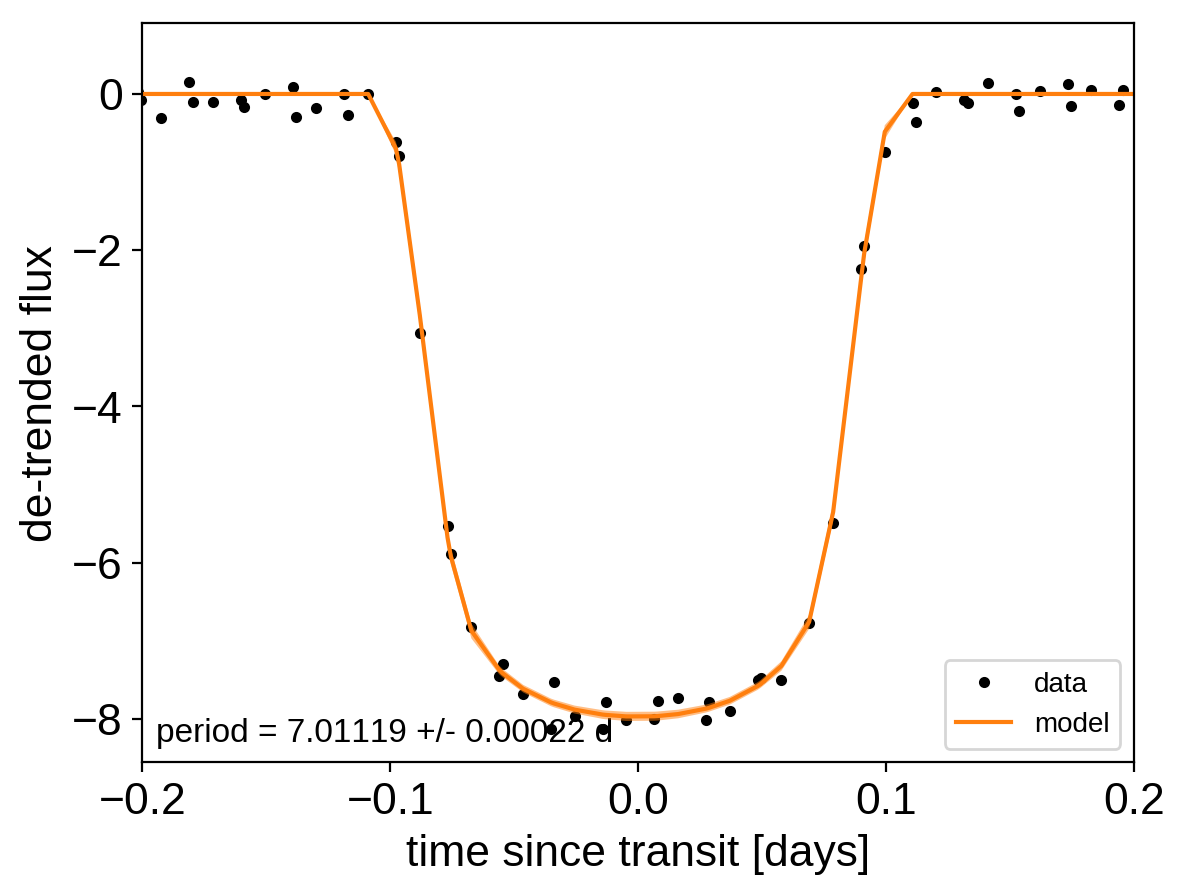

In [17]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(trace["period"]), np.std(trace["period"]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
plt.xlim(-0.2, 0.2);

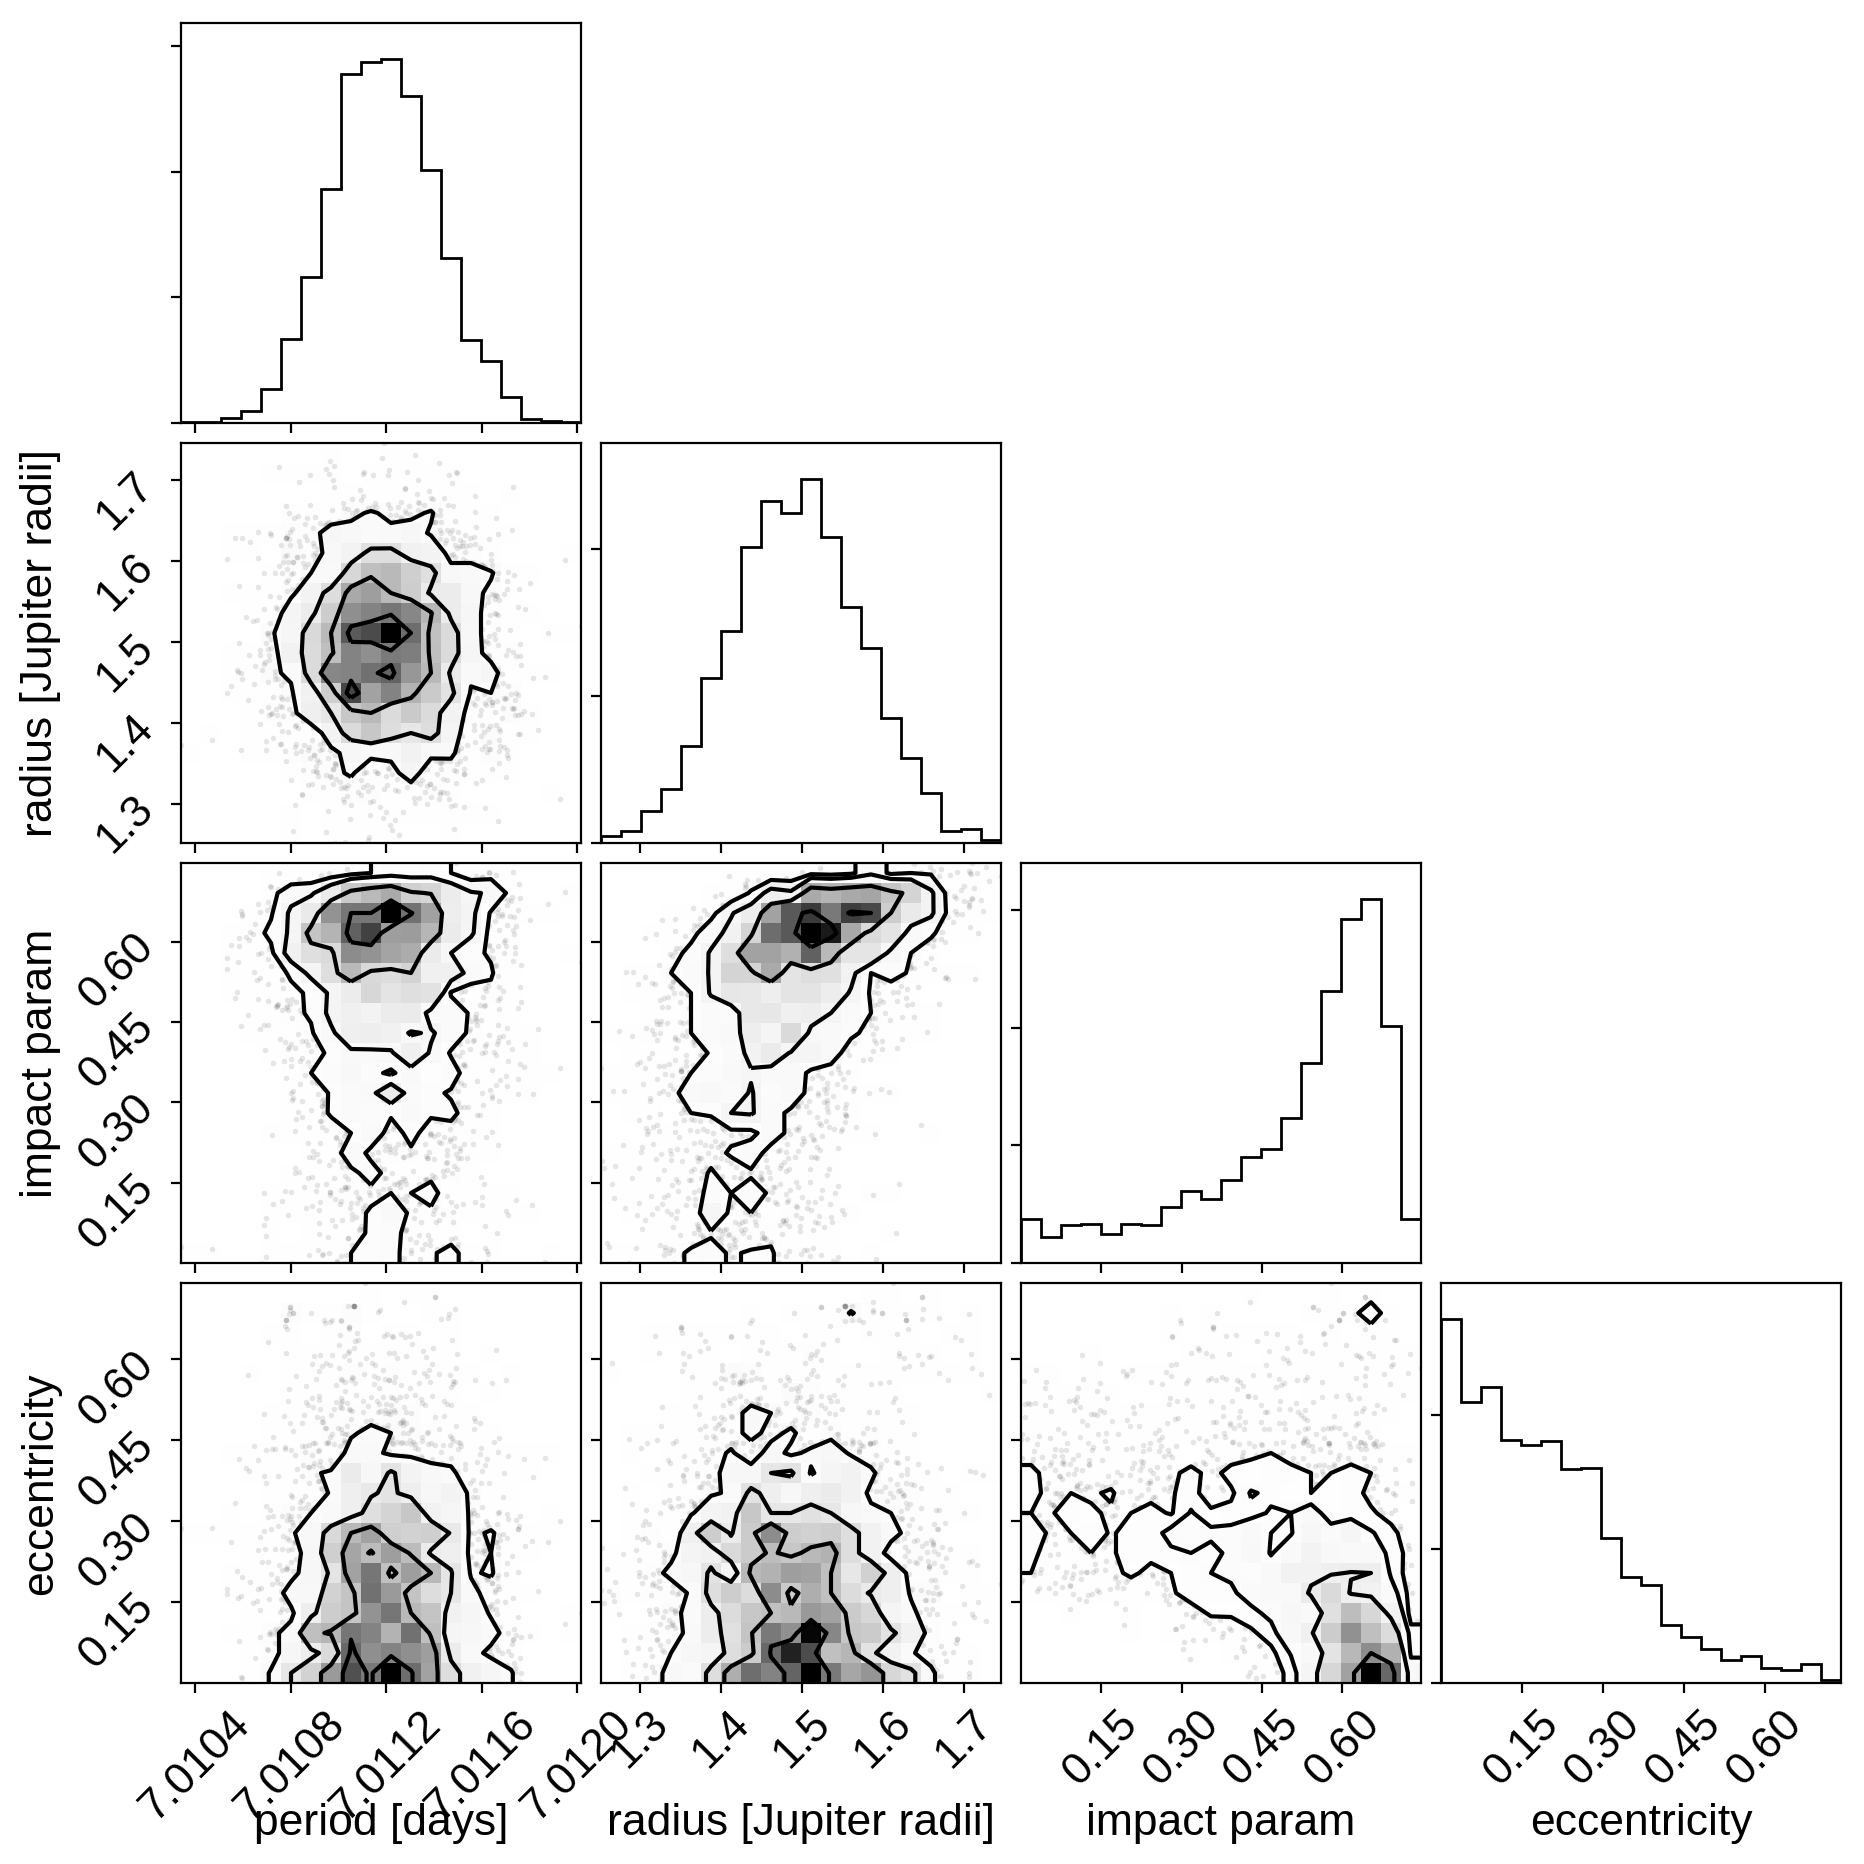

In [18]:
import corner
import astropy.units as u
varnames = ["period", "b", "ecc", "r_pl"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_jupiter).value

corner.corner(
    samples[["period", "r_pl", "b", "ecc"]],
    labels=["period [days]", "radius [Jupiter radii]", "impact param", "eccentricity"]);

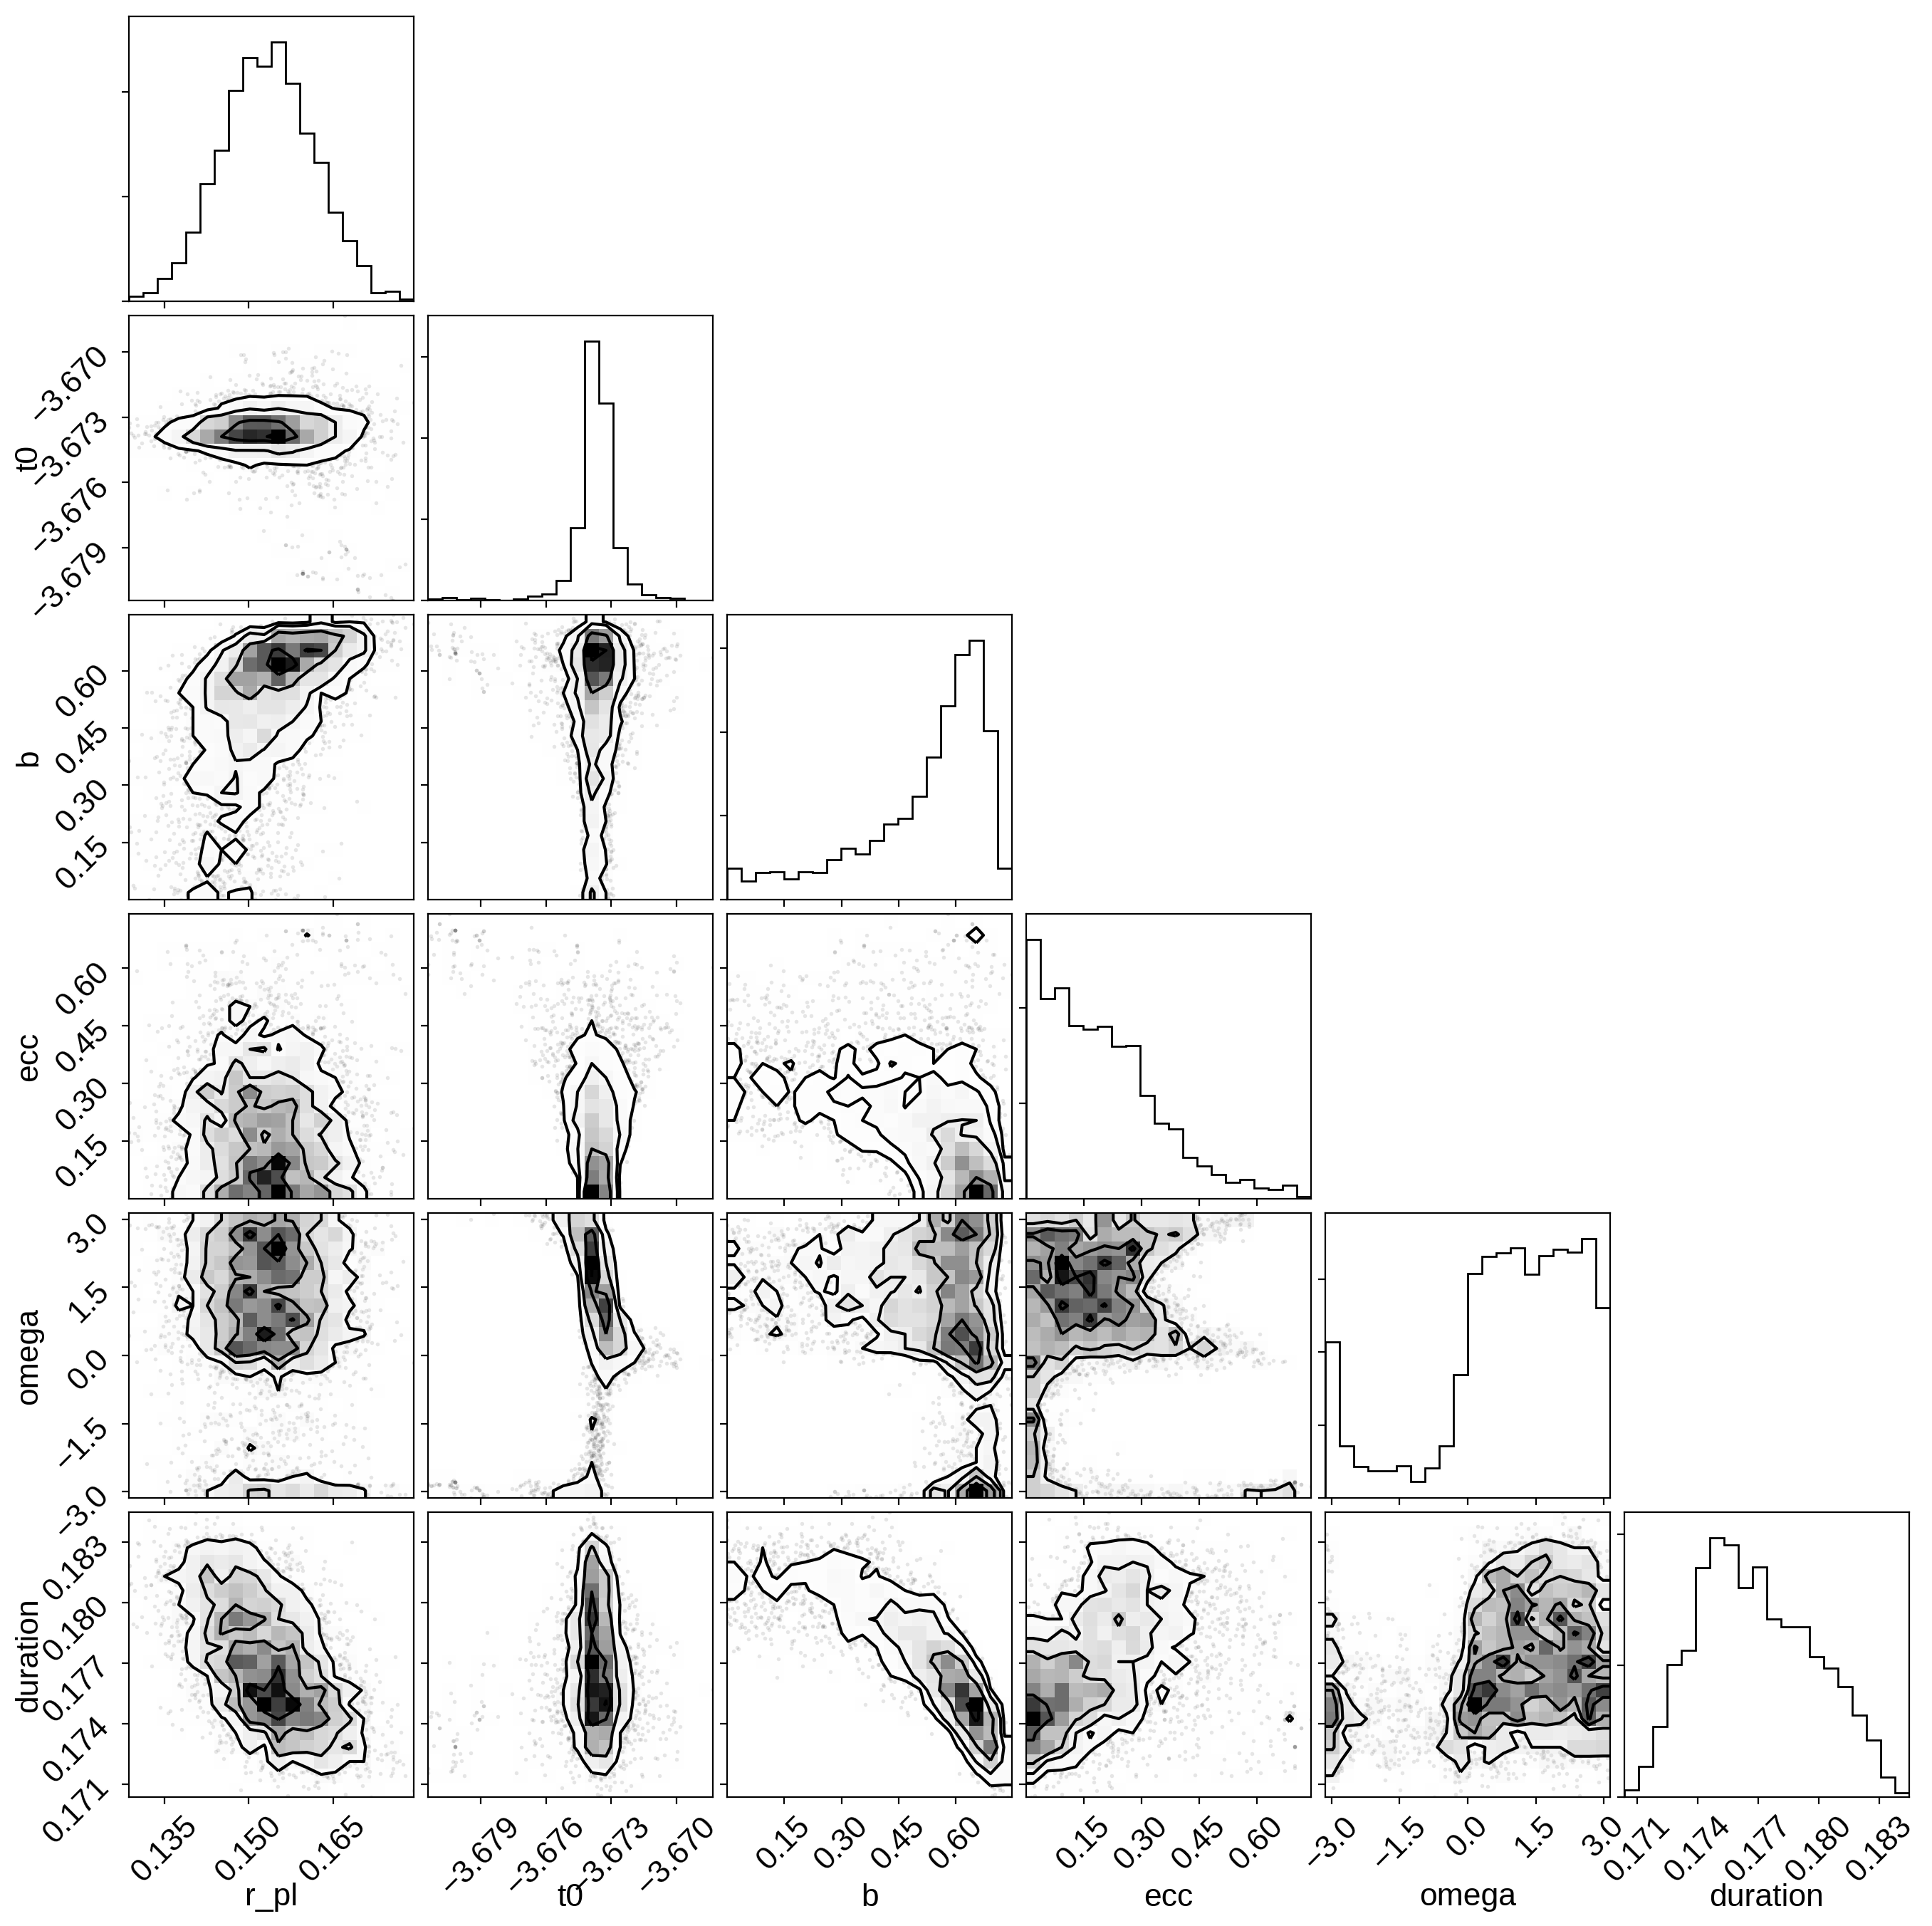

In [19]:
aor = -trace["a"] / trace["r_star"]
e = trace["ecc"]
w = trace["omega"]
i = trace["incl"]
b = trace["b"]
k = trace["r_pl"] / trace["r_star"]
P = trace["period"]

T_tot = P/np.pi * np.arcsin(np.sqrt(1 - b**2) / np.sin(i) / aor)
dur = T_tot * np.sqrt(1 - e**2) / (1 + e * np.sin(w))

samples = pm.trace_to_dataframe(trace, varnames=["r_pl", "t0", "b", "ecc", "omega"])
samples["duration"] = dur
corner.corner(samples);